# **ECE GY 7123 Deep Learning**

## *Final Project*:
## **A Confidence-Score Mechanism for Post-Processing OCR-ed Tibetan Manuscripts**

> Institute:


*   New York University

> Student Name:


*   Xiaoyu Wang
*   Yiren Dai

## 1. **Problem Statement**

Locating the exact words in ancient manuscripts is a crucial but time consuming task for
scholars in the humanities. In recent years, the Optical Character Recognition (OCR) technology has greatly facilitated
the digitization progress on ancient texts. However, the digitized e-text corpus contains many spelling errors. **Some handwritten Tibetan characters, such as “པ” and “བ” are indistinguishable to the naked eyes, and the OCR program cannot
capture these nuances.** Current popular spelling correction systems cannot correct Tibetan texts, and are not designed to
correct OCR-ed output.

## 2. **Project Goal**

The Google OCR output contains a confidence score for each character it recognizes. In general,
characters with higher than 80% confidence scores have an overall accuracy close to 100% based on human validation,
and characters with low confidence scores, such as 30%, require special attention. We propose to **implement a Tibetan
sequence-to-sequence model that incorporates a Confidence-score mechanism to target the OCR-ed output**, i.e., teach
the model to pay attention to the low confident character and copy the high confident characters during correction.

## 3. **Related Work**

There have been few attempts in applying these advances to the field of Tibetan studies. Powerful
deep seq2seq architectures, such as the Transformer, have demonstrated great improvement on translation tasks. In
particular, **the Attention mechanism has shown rich language understanding compared to more complex recurrent or
convolutional neural networks on English-to-German and English-to-French translation (Vaswani et al., 2017)**. Many
recent neural Grammatical Error Correction (GEC) models are trained on this type of Transformer architecture (JunczysDowmunt et al., 2018; Lichtarge et al., 2018). As a whole, our task of correcting the spelling errors in the OCR-ed Tibetan
corpus is very similar to the GEC task. 

## 4. **Install Project Related Packages**

*   datasets==2.8.0
*   Levenshtein == 0.20.8
*   matplotlib == 3.2.2
*   numpy == 1.21.6
*   pyvi == 0.1.1
*   seaborn == 0.11.2
*   spacy == 3.0.9
*   torch == 1.8.1
*   torchtext == 0.9.0
*   torchvision == 0.14.0+cu116
*   transformers == 4.12.2
*   vi-core-news-lg == 0.0.1

## 5. **Import Project Related Packages**

In [ ]:
# Import the necessary modules for this project:
import copy
import io
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sacrebleu
import seaborn
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import urllib.request 
import Levenshtein as ed

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from torch.autograd import Variable
from torchtext.legacy import data, datasets
from tqdm import tqdm
from wordcloud import WordCloud

## 6. **Check Runtime's GPU Availability**


In [ ]:
train_on_gpu = torch.cuda.is_available()
# check whether CUDA is available
if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    

CUDA is available


## 7. **Introduction of the Datasets for this Project**

Buddhist Digital Resource Center (BDRC) provides both human corrected clean data and OCR-ed noisy
data for the Dege Kangyur collection (70,000 pages) on their public Github repository. We choose to use the human
corrected clean data as ground truth to train our model because it has been proofread by field experts and contains minimal
errors. The OCR-ed noisy data comes from Google OCR, and it contains a confidence score for each character. 

## 8. **Download Raw Data and Preprocess Datasets**

### 8.1 **Read RAW Datasets**

*   Fetch RAW Data (part_01 and part_02) from GitHub
*   Retrive datasets to local directory



In [ ]:
# Create the local folders if NOT exist
raw_data_folder_01 = "data/raw_data/part_01/pair_data/"
raw_data_folder_02 = "data/raw_data/part_02/pair_data/"

if not os.path.isdir(raw_data_folder_01):
    os.makedirs(raw_data_folder_01)
if not os.path.isdir(raw_data_folder_02):
    os.makedirs(raw_data_folder_02)

In [ ]:
# Downloading the csv file from Public GitHub account
raw_data_url_part_01 = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/raw_data/part_01/pair_data/raw_data_paired_01.csv"
raw_data_url_part_02 = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/raw_data/part_02/pair_data/raw_data_paired_02.csv"

raw_data_file_name_01 = "data/raw_data/part_01/pair_data/raw_data_paired_01.csv"
raw_data_file_name_02 = "data/raw_data/part_02/pair_data/raw_data_paired_02.csv"

# Save the RAW data to local folder
urllib.request.urlretrieve(raw_data_url_part_01, 
                           raw_data_file_name_01)

urllib.request.urlretrieve(raw_data_url_part_02, 
                           raw_data_file_name_02)

df_part_01 = pd.read_csv(raw_data_file_name_01)
df_part_02 = pd.read_csv(raw_data_file_name_02)

df = pd.concat([df_part_01, df_part_02])
df = df.drop(['confi_score', 'ratio'], axis=1).reset_index(drop=True)

del df_part_01
del df_part_02

df

noisy_text  \
0                                ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།   
1       ཡུལཨངགཙམརལམ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་...   
2       གི་བུ་འདི་མཐུ་ཡིན་ནོསྙམཆོད།དེ་ནི་དེ་ལྟ་མ་ཡིན་ཏ...   
3       དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟ...   
4       ཀྱིས་ཀུན་ནས་ཡོངས་སུ་བསདཁར་བྱའོ།།དེ་དག་གིསསྩསཔ།...   
...                                                   ...   
125952  567ལཤིས་བརྒྱབཞི་དཔགཔསྨཱབར་རིགས་ཏེ།ངེད་འགྲོ་བསྒ...   
125953  568༨ཟུམ་འགྲོའམསགསུམདུའགྲོམིབྱེད།།དེམཡིནཔར་གྱུར...   
125954  570དབུམ་པོཡིནཔརགྱུརཔདད།དེམ་ཡིནཔརགྱུརཔདང་།ཡིན་ད...   
125955  571V"༣གནུགྱུརླགནརེརྟོགགེསྙམཔོའི་བསྟན་བཅོས་ཙམཚེ...   
125956  572ལམལངས་པ་དང་།དེབཞིན་གཤེགས་པ་དྲེདགམིསྣནས།དེནས...   

                                                true_text  
0                               ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །  
1       ཡུལ་ཨང་ག་ཙམ་པ་མ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བ...  
2       གི་བུ་འདིའི་མཐུ་ཡིན་ནོ་སྙམ་མོད་ཀྱི། དེ་ནི་དེ་ལ...  
3       དང་། གཅད་པ་དང་། དྲལ་བ་དང་། དབུག་པ་དང་། གནས་ལྔ་...  
4       ཀྱིས་ཀུན་ནས་ཡོངས་སུ་བསྲུང་བར་བྱའོ། །དེ་དག་གིས་...  
...                                                   ...  
125952  དཔག་པ་སྨྲ་བར་རིགས་ཏེ། ངེད་འགྲོ་བ་སྨྲ་བ་དག་འགྲོ...  
125953  འགྲོ་རྣམས་གསུམ་དུ་འགྲོ་མི་བྱེད། །དེ་མ་ཡིན་པར་ག...  
125954  པོ་ཡིན་པར་གྱུར་པ་དང་། དེ་མ་ཡིན་པར་གྱུར་པ་དང་། ...  
125955  ན་རེ། རྟོག་གེ་སྐམ་པོའི་བསྟན་བཅོས་ཙམ་ཉི་ཚེས་བསྒ...  
125956  ལས་ལངས་པ་དང་། དེ་བཞིན་གཤེགས་པ་དེ་དག་མི་སྣང་ནས།...  

[125957 rows x 2 columns]

### 8.2 **Read Tokenizer Datasets**

*   Fetch Tokenizer Datasets from GitHub
*   Retrive datasets to local directory



In [ ]:
# Create the local folders if NOT exist
tokenizer_folder = "data/tokenizer_data/"

if not os.path.isdir(tokenizer_folder):
    os.makedirs(tokenizer_folder)


In [ ]:
# Downloading the files from Public GitHub account
tokenizer_train_data_url = "https://media.githubusercontent.com/media/yd1257/ece-gy-7123-deep-learning-final-project/main/data/tokenizer_data/noisy_data_train.txt"
bpe_tokenizer_url_part = "https://raw.githubusercontent.com/yd1257/ece-gy-7123-deep-learning-final-project/main/data/tokenizer_data/bpe_tokenizer.json"

tokenizer_train_data_file_name = "data/tokenizer_data/noisy_data_train.txt"
bpe_tokenizer_file_name = "data/tokenizer_data/bpe_tokenizer.json"

# Save the Tokenizer data to local folder
urllib.request.urlretrieve(tokenizer_train_data_url, 
                           tokenizer_train_data_file_name)

urllib.request.urlretrieve(bpe_tokenizer_url_part, 
                           bpe_tokenizer_file_name)

('data/tokenizer_data/bpe_tokenizer.json',
 <http.client.HTTPMessage at 0x14c5280f4cd0>)

### 8.3 **Validate and QA the Datasets**

*   Check the size of the vocabulary
*   Validate the source and target sentence list


In [ ]:
# Initialize the tokenizer
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace('་')

tokenizer = tokenizer.from_file(bpe_tokenizer_file_name)

print("The size of vocabulary is: ", tokenizer.get_vocab_size())

The size of vocabulary is:  561


In [ ]:
# Set the maximum sentence length
MAX_SENT_LENGTH = 510

# Get the source and target vocabulary
src_vocab_set = list(tokenizer.get_vocab().keys())
trg_vocab_set = list(tokenizer.get_vocab().keys())

# Clean the source and target sentence lists
src_sentences_list = df.noisy_text.values.tolist()
src_sentences_list = [i[:MAX_SENT_LENGTH] for i in src_sentences_list]
trg_sentences_list = df.true_text.values.tolist()
trg_sentences_list = [i[:MAX_SENT_LENGTH] for i in trg_sentences_list]

# Split the source and target sentence lists for traning
train_src_sentences_list = src_sentences_list[:int(len(src_sentences_list) * 0.8)]
train_trg_sentences_list = trg_sentences_list[:int(len(trg_sentences_list) * 0.8)]

# Split the source and target sentence lists for test
test_src_sentences_list = src_sentences_list[int(len(src_sentences_list) * 0.8):]
test_trg_sentences_list = trg_sentences_list[int(len(trg_sentences_list) * 0.8):]


In [ ]:
# Validate the source and target sentence list
assert len(train_src_sentences_list) == len(train_trg_sentences_list)
assert len(test_src_sentences_list) == len(test_trg_sentences_list)

## 9. **Clean and Process the Source and Target Sentence for Model**

### 9.1 **Clean and Process the data for modelling purpose**

*   Create the Train and Test Data
*   Create the Validation Data
*   Create the BLEU Score Data

In [ ]:
# Set the maximum sentence length, which include the start of sentence and end of sentence
MAX_SENT_LENGTH_PLUS_SOS_EOS = 512

In [ ]:
# We only keep sentences that do not exceed (overall_limitation - 2) words, so that later when we add <s>
# and </s> to a sentence it still won't exceed the overall limitation of words.
def filter_data(src_sentences_list,
                trg_sentences_list,
                max_len):
    new_src_sentences_list, new_trg_sentences_list = [], []

    for src_sent, trg_sent in zip(src_sentences_list, trg_sentences_list):
        if (max_len >= len(src_sent) > 0 and
            len(trg_sent) <= max_len and 
            len(trg_sent)) > 0:
            
            # Add the source sentence to the new source sentence list
            new_src_sentences_list.append(src_sent)

            # Add the target sentence to the new source sentence list
            new_trg_sentences_list.append(trg_sent)

    return new_src_sentences_list, new_trg_sentences_list

In [ ]:
# Filter the training data
train_src_sentences_list, train_trg_sentences_list = filter_data(
    train_src_sentences_list, 
    train_trg_sentences_list, 
    max_len=MAX_SENT_LENGTH)

# Filter the test data
test_src_sentences_list, test_trg_sentences_list = filter_data(
    test_src_sentences_list, 
    test_trg_sentences_list, 
    max_len=MAX_SENT_LENGTH)

# We take 10% of the training data to be the validation set.
num_val = int(len(train_src_sentences_list) * 0.1)
val_src_sentences_list = train_src_sentences_list[:num_val]
val_trg_sentences_list = train_trg_sentences_list[:num_val]

# Exclude the validation sentences from training
train_src_sentences_list = train_src_sentences_list[num_val:]
train_trg_sentences_list = train_trg_sentences_list[num_val:]

# take 5000 sentences to compute BLEU score
BLEU_src_sentences_list = val_src_sentences_list[:500]
BLEU_trg_sentences_list = val_trg_sentences_list[:500]


### 9.2 **Show the Processed Data with Basic Statistic Results**

*   Show the basic model data information
*   Show sample noisy data

Number of training (src, trg) sentence pairs: 90689
Number of validation (src, trg) sentence pairs: 10076
Number of testing (src, trg) sentence pairs: 25192
Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 562
Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): 562
Training sentence avg. length: 275 
Training sentence length at 95-percentile: 380
Training sentence length distribution (x-axis is length range and y-axis is count):



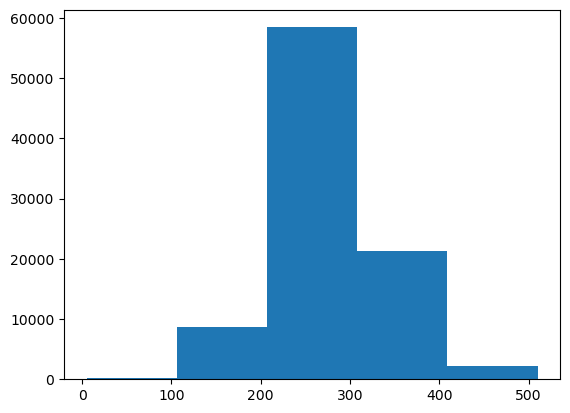

In [ ]:
# Show the processed data with basic statistic results:
print("Number of training (src, trg) sentence pairs: %d" %
      len(train_src_sentences_list))

print("Number of validation (src, trg) sentence pairs: %d" %
      len(val_src_sentences_list))

print("Number of testing (src, trg) sentence pairs: %d" %
      len(test_src_sentences_list))

src_vocab_set = ['<pad>'] + src_vocab_set
trg_vocab_set = ['<pad>'] + trg_vocab_set
print("Size of en vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(src_vocab_set))
print("Size of vi vocab set (including '<pad>', '<unk>', '<s>', '</s>'): %d" %
      len(trg_vocab_set))

length = [len(sent) for sent in train_src_sentences_list]
print('Training sentence avg. length: %d ' % np.mean(length))
print('Training sentence length at 95-percentile: %d' %
      np.percentile(length, 95))
print('Training sentence length distribution '
      '(x-axis is length range and y-axis is count):\n')

plt.hist(length, bins=5)
plt.show()


In [ ]:
print('Example noisy input: ' + str(train_src_sentences_list[0]))
print('Its target clean output: ' + str(train_trg_sentences_list[0]))

Example noisy input: sབཅོམ་ལྡན་ཀྱིས་བཀའ་ལསབཅོམ་ལྡན་འདས་ཅིའི་ཕྱིར་སལརེག་པར་མཛད་སྙམན།མཆོད་སྡོང་གཟིགས་པར་བཞེད་པར་མཐོང༌།།དེ་ནས་དེ་དག་གིས་བསྒྲེང་བ་དང་།དགེ་སློང་རྣམས་ཀྱིས་མཆོད་སྡོང་བལྟ་བར་བརྩམས་སོ།།ཚོདང་ལྡན་པལེགས་ལྡནནི་དོད་པ་ཆུང་པས་མཐའགཅིག་དུ་ཡོང་ནས་ཕྱག་དར་ཁྲོད་པདག་འཚོ་མོ།།དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས
Its target clean output: བཅོམ་ལྡན་འདས་ཅིའི་ཕྱིར་ས་ལ་རེག་པར་མཛད་སྙམ་ན། མཆོད་སྡོང་གཟིགས་པར་བཞེད་པར་མཐོང་ངོ་། །དེ་ནས་དེ་དག་གིས་བསྒྲེང་བ་དང་། དགེ་སློང་རྣམས་ཀྱིས་མཆོད་སྡོང་བལྟ་བར་བརྩམས་སོ། །ཚེ་དང་ལྡན་པ་ལེགས་ལྡན་ནི་འདོད་པ་ཆུང་བ་ཡིན་པས་མཐའ་གཅིག་ཏུ་སོང་ནས་ཕྱག་དར་ཁྲོད་པ་དག་འཚེམ་མོ། །དེ་ནས་བཅོམ་ལྡན་འདས་ཀྱིས


### 9.3 **Build Vocabulary Data**

*   tokenize the data


In [ ]:
# Create the tokenize function for different languages
def tokenize_vi(text):
    return tokenizer.encode(text).tokens

def tokenize_en(text):
    return tokenizer.encode(text).tokens
    

In [ ]:
# Generate the source and target data with field
SRC = data.Field(tokenize=tokenize_vi, 
                 pad_token='<pad>')

TRG = data.Field(tokenize=tokenize_en, 
                 pad_token='<pad>',
                 init_token='<s>', 
                 eos_token='</s>')

fields = [("src", SRC),("trg", TRG)]

In [ ]:
# Create the example function
def get_examples(src_sent_list, 
                 trg_sent_list):
    
    examples = []
    for src_sent, trg_sent in zip(src_sent_list, trg_sent_list):
        example = data.Example.fromlist([src_sent, trg_sent], fields=fields)
        examples.append(example)

    return examples
    

In [ ]:
# Get the train_examples
train_examples = get_examples(train_src_sentences_list,
                              train_trg_sentences_list)

# Get the val_examples
val_examples = get_examples(val_src_sentences_list,
                            val_trg_sentences_list)

# Get the test_examples
test_examples = get_examples(test_src_sentences_list,
                             test_trg_sentences_list)

# Get the BLEU_examples
BLEU_examples = get_examples(BLEU_src_sentences_list,
                             BLEU_trg_sentences_list)

train = data.Dataset(train_examples, 
                     fields)
val = data.Dataset(val_examples, 
                   fields)
test = data.Dataset(test_examples, 
                    fields)
BLEU_test = data.Dataset(BLEU_examples, 
                         fields)

SRC.build_vocab(train.src)
TRG.build_vocab(train.trg)


## 10. **Create the Customized Model Classes**

In [ ]:
# Create the Batch Data Class
class Batch:
    """
    Object for holding a batch of data with mask during training.
    """
    def __init__(self, 
                 src, 
                 trg=None, 
                 pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, 
                      pad):
        """
        Create a mask to hide padding and future words.
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        
        return tgt_mask

In [ ]:
# Create the MyIterator Class from data.Iterator
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, 
                     random_shuffler):
                for p in data.batch(d, 
                                    self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, 
                               key=self.sort_key),
                        self.batch_size, 
                        self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), 
                                self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), 
                                self.batch_size,
                                self.batch_size_fn):
                self.batches.append(sorted(b, 
                                           key=self.sort_key))

def rebatch(pad_idx, 
            batch):
    """
    Fix order in torchtext to match ours
    """
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, 
                 trg, 
                 pad_idx)
    

In [ ]:
# Set the context for Seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## 11. **Detailed Model Implementation**
Our project will have two phases: data preparation and language modeling. First, we will
feature-engineer our raw data into a structured dataframe as shown in Table 1. We need to align the OCR-ed noisy data to
the ground truth data. They are not naturally aligned but both contain a set of IDs. Then, we will modify a sequence-tosequence model with an encoder and decoder, similar to a translation model. The encoder takes in the OCR-ed noisy
sentence and the decoder outputs the corrected sentence, then we will compare the corrections to the ground truth sentence.
Here we want to introduce an attention model named Confidence-score. The Attention mechanism solved the problem of
long-term dependency between paired sentences, and the Self-Attention captured mutual dependencies between words of
a sentence. We expect our Confidence-score mechanism can capture the distributions and intra-dependencies of the low
confident characters to improve the model’s performance. 

In [ ]:
# Create the EncoderDecoder Class based on nn.Module
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_embed, 
                 tgt_embed, 
                 generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, 
                src, 
                tgt, 
                src_mask, 
                tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), 
                           src_mask,
                           tgt, 
                           tgt_mask)
    
    def encode(self, 
               src, 
               src_mask):
        return self.encoder(self.src_embed(src), 
                            src_mask)
    
    def decode(self, 
               memory, 
               src_mask, 
               tgt, 
               tgt_mask):
        return self.decoder(self.tgt_embed(tgt), 
                            memory, 
                            src_mask, 
                            tgt_mask)
        

In [ ]:
# Create the Generator Class based on nn.Module
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, 
                 d_model, 
                 vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, 
                              vocab)

    def forward(self, 
                x):
        return F.log_softmax(self.proj(x), 
                             dim=-1)
        

In [ ]:
# Produce N identical layers
def clones(module, 
           N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
# Create the Encoder Class based on nn.Module
class Encoder(nn.Module):
    """
    Core encoder is a stack of N layers
    """
    def __init__(self, 
                 layer, 
                 N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, 
                             N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, 
                x, 
                mask):
        """
        Pass the input (and mask) through each layer in turn.
        """
        for layer in self.layers:
            x = layer(x, 
                      mask)

        return self.norm(x)

In [ ]:
# Create the EncoderLayer Class based on nn.Module
class EncoderLayer(nn.Module):
    """
    Encoder is made up of self-attn and feed forward (defined below)
    """
    def __init__(self, 
                 size, 
                 self_attn, 
                 feed_forward, 
                 dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, 
                x, 
                mask):
        """
        Follow Figure 1 (left) for connections.
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [ ]:
# Create the Decoder Class based on nn.Module
class Decoder(nn.Module):
    """
    Generic N layer decoder with masking.
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, 
                             N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, 
                x,
                memory, 
                src_mask, 
                tgt_mask):
        for layer in self.layers:
            x = layer(x, 
                      memory, 
                      src_mask, 
                      tgt_mask)
        return self.norm(x)

In [ ]:
# Create the DecoderLayer Class based on nn.Module
class DecoderLayer(nn.Module):
    """
    Decoder is made of self-attn, src-attn, and feed forward (defined below)
    """
    def __init__(self, 
                 size, 
                 self_attn, 
                 src_attn, 
                 feed_forward, 
                 dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
    def forward(self, 
                x, 
                memory, 
                src_mask, 
                tgt_mask):
        """
        Follow Figure 1 (right) for connections.
        """
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))

        return self.sublayer[2](x, self.feed_forward)

In [ ]:
# Create the LayerNorm Class based on nn.Module
class LayerNorm(nn.Module):
    """
    Construct a layernorm module (See citation for details).
    """
    def __init__(self, 
                 features, 
                 eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, 
                      keepdim=True)
        std = x.std(-1, 
                    keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [ ]:
# Create the SublayerConnection Class based on nn.Module
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, 
                 size, 
                 dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, 
                x, 
                sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
# Create the subsequent_mask function
def subsequent_mask(size):
    """
    Mask out subsequent positions.
    """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0


In [ ]:
# Create the attention function
def attention(query, 
              key, 
              value, 
              mask=None, 
              dropout=None):
    """
    Compute 'Scaled Dot Product Attention'
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, 
                       dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [ ]:
# Create the MultiHeadedAttention Class based on nn.Module
class MultiHeadedAttention(nn.Module):
    def __init__(self, 
                 h, 
                 d_model, 
                 dropout=0.1):
        """
        Take in model size and number of heads.
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, 
                query, 
                key, 
                value, 
                mask=None):
        """
        Implements Figure 2
        """
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, 
                                 key,
                                 value, 
                                 mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [ ]:
# Create the PositionwiseFeedForward Class based on nn.Module
class PositionwiseFeedForward(nn.Module):
    """
    Implements FFN equation.
    """
    def __init__(self, 
                 d_model, 
                 d_ff, 
                 dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, 
                             d_ff)
        self.w_2 = nn.Linear(d_ff, 
                             d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [ ]:
# Create the Embeddings Class based on nn.Module
class Embeddings(nn.Module):
    def __init__(self, 
                 d_model, 
                 vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, 
                                d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [ ]:
# Create the PositionalEncoding Class based on nn.Module
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, 
                 d_model, 
                 dropout, 
                 max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, 
                         d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

## 12. **Build Functions for Training and Evaluation**

In [ ]:
# Construct the model
def make_model(src_vocab, 
               tgt_vocab, 
               N=6, 
               d_model=512, 
               d_ff=2048, 
               h=8, 
               dropout=0.1):
    """
    Helper: Construct a model from hyperparameters.
    """
    c = copy.deepcopy

    attn = MultiHeadedAttention(h, 
                                d_model)
    
    ff = PositionwiseFeedForward(d_model, 
                                 d_ff, dropout)
    
    position = PositionalEncoding(d_model, 
                                  dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, 
                             c(attn), 
                             c(ff), 
                             dropout), 
                N),
        Decoder(DecoderLayer(d_model, 
                             c(attn), 
                             c(attn), 
                             c(ff), 
                             dropout), 
                N),
        nn.Sequential(Embeddings(d_model, src_vocab),
                      c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), 
                      c(position)),
        Generator(d_model, tgt_vocab))
    
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
# Create the function for run_epoch
def run_epoch(data_iter, 
              model, 
              loss_compute):
    """
    Standard Training and Logging Function
    """
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in tqdm(list(enumerate(data_iter))):
        out = model.forward(batch.src, 
                            batch.trg, 
                            batch.src_mask, 
                            batch.trg_mask)
        
        loss = loss_compute(out, 
                            batch.trg_y, 
                            batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [ ]:
# Set the global variable for max_src_in_batch, max_tgt_in_batch
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, 
                  count, 
                  sofar):
    """
    Keep augmenting batch and calculate total number of tokens + padding.
    """
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  
                           len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  
                           len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [ ]:
# Create the NoamOpt Class
class NoamOpt:
    """
    Optim wrapper that implements rate.
    """
    def __init__(self, 
                 model_size, 
                 factor, 
                 warmup, 
                 optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, 
             step = None):
        """
        Implement `lrate` above
        """
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 
                   2, 
                   4000,
                   torch.optim.Adam(model.parameters(), 
                                    lr=0, 
                                    betas=(0.9, 0.98), 
                                    eps=1e-9))
    

In [ ]:
# Create the LabelSmoothing Class based on nn.Module
class LabelSmoothing(nn.Module):
    """
    Implement label smoothing.
    """
    def __init__(self, 
                 size, 
                 padding_idx, 
                 smoothing=0.0):
        
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [ ]:
# Create the SimpleLossCompute Class
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, 
                 generator, 
                 criterion, 
                 opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, 
                 x, 
                 y, 
                 norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm
        

## 13. **Execute the Model Training Process**

In [ ]:
pad_idx = 0
model = make_model(len(SRC.vocab), 
                   len(TRG.vocab), 
                   N=3)
device = 'cuda'
model.to(device)

criterion = LabelSmoothing(size=len(TRG.vocab), 
                           padding_idx=pad_idx, 
                           smoothing=0.1)
criterion.to(device)

BATCH_SIZE = 2048

train_iter = MyIterator(train, 
                        batch_size=BATCH_SIZE, 
                        device=device,
                        repeat=False, 
                        sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, 
                        train=True)

valid_iter = MyIterator(val, 
                        batch_size=BATCH_SIZE, 
                        device=device,
                        repeat=False, 
                        sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, 
                        train=False)


/ext3/miniconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [ ]:
num_epochs = 10
model_opt = NoamOpt(model.src_embed[0].d_model, 
                    1, 
                    2000,
                    torch.optim.Adam(model.parameters(), 
                                     lr=0, 
                                     betas=(0.9, 0.98), 
                                     eps=1e-9))

df_score = pd.DataFrame(columns=['epoch', 'score'])
for epoch in range(num_epochs):
    model.train()
    run_epoch((rebatch(pad_idx, b) for b in train_iter), 
              model,
              SimpleLossCompute(model.generator, 
                                criterion, 
                                opt=model_opt))
    model.eval()
    with torch.no_grad():
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter),
                         model, 
                         SimpleLossCompute(model.generator, criterion, opt=None))
        
    print("Epoch {} validation loss: ".format(epoch), loss.item())

    df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
    df_score.to_csv('df_score', index=False)
    

  0%|          | 5/15430 [00:00<20:25, 12.59it/s]

Epoch Step: 1 Loss: 4.459738 Tokens per Sec: 197.389648


  0%|          | 55/15430 [00:03<15:45, 16.26it/s]

Epoch Step: 51 Loss: 2.475254 Tokens per Sec: 32210.294922


  1%|          | 105/15430 [00:06<14:19, 17.83it/s]

Epoch Step: 101 Loss: 2.101624 Tokens per Sec: 32593.402344


  1%|          | 155/15430 [00:08<14:30, 17.55it/s]

Epoch Step: 151 Loss: 1.994705 Tokens per Sec: 33170.925781


  1%|▏         | 205/15430 [00:11<14:14, 17.81it/s]

Epoch Step: 201 Loss: 1.888934 Tokens per Sec: 32562.953125


  2%|▏         | 255/15430 [00:14<14:55, 16.95it/s]

Epoch Step: 251 Loss: 1.829324 Tokens per Sec: 33096.324219


  2%|▏         | 305/15430 [00:17<13:57, 18.05it/s]

Epoch Step: 301 Loss: 1.794618 Tokens per Sec: 33232.835938


  2%|▏         | 355/15430 [00:20<14:13, 17.67it/s]

Epoch Step: 351 Loss: 1.896872 Tokens per Sec: 32698.044922


  3%|▎         | 405/15430 [00:23<14:34, 17.17it/s]

Epoch Step: 401 Loss: 1.831619 Tokens per Sec: 32572.644531


  3%|▎         | 455/15430 [00:26<14:14, 17.53it/s]

Epoch Step: 451 Loss: 1.765674 Tokens per Sec: 33084.644531


  3%|▎         | 505/15430 [00:28<14:29, 17.16it/s]

Epoch Step: 501 Loss: 1.859669 Tokens per Sec: 33109.613281


  4%|▎         | 555/15430 [00:31<14:38, 16.93it/s]

Epoch Step: 551 Loss: 1.808794 Tokens per Sec: 32849.187500


  4%|▍         | 605/15430 [00:34<14:46, 16.72it/s]

Epoch Step: 601 Loss: 1.869330 Tokens per Sec: 32192.144531


  4%|▍         | 655/15430 [00:37<14:59, 16.42it/s]

Epoch Step: 651 Loss: 1.739136 Tokens per Sec: 32210.156250


  5%|▍         | 705/15430 [00:40<13:54, 17.64it/s]

Epoch Step: 701 Loss: 1.844217 Tokens per Sec: 32579.167969


  5%|▍         | 755/15430 [00:43<13:40, 17.88it/s]

Epoch Step: 751 Loss: 1.755592 Tokens per Sec: 32843.359375


  5%|▌         | 805/15430 [00:46<13:56, 17.47it/s]

Epoch Step: 801 Loss: 1.715237 Tokens per Sec: 32868.257812


  6%|▌         | 855/15430 [00:49<14:17, 17.00it/s]

Epoch Step: 851 Loss: 1.738623 Tokens per Sec: 32495.058594


  6%|▌         | 905/15430 [00:51<13:55, 17.39it/s]

Epoch Step: 901 Loss: 1.733170 Tokens per Sec: 32844.285156


  6%|▌         | 955/15430 [00:54<13:53, 17.36it/s]

Epoch Step: 951 Loss: 1.620995 Tokens per Sec: 33149.351562


  7%|▋         | 1005/15430 [00:57<13:35, 17.68it/s]

Epoch Step: 1001 Loss: 1.555195 Tokens per Sec: 32975.527344


  7%|▋         | 1055/15430 [01:00<13:47, 17.37it/s]

Epoch Step: 1051 Loss: 1.486725 Tokens per Sec: 32616.121094


  7%|▋         | 1105/15430 [01:03<13:39, 17.48it/s]

Epoch Step: 1101 Loss: 1.689653 Tokens per Sec: 32492.960938


  7%|▋         | 1155/15430 [01:06<13:51, 17.18it/s]

Epoch Step: 1151 Loss: 1.393566 Tokens per Sec: 32736.302734


  8%|▊         | 1205/15430 [01:09<13:43, 17.27it/s]

Epoch Step: 1201 Loss: 1.492061 Tokens per Sec: 32704.644531


  8%|▊         | 1255/15430 [01:12<13:45, 17.16it/s]

Epoch Step: 1251 Loss: 1.516135 Tokens per Sec: 32742.285156


  8%|▊         | 1305/15430 [01:14<13:42, 17.18it/s]

Epoch Step: 1301 Loss: 1.353440 Tokens per Sec: 32930.039062


  9%|▉         | 1355/15430 [01:17<13:48, 16.99it/s]

Epoch Step: 1351 Loss: 1.515386 Tokens per Sec: 32519.072266


  9%|▉         | 1405/15430 [01:20<13:38, 17.14it/s]

Epoch Step: 1401 Loss: 1.433525 Tokens per Sec: 32758.304688


  9%|▉         | 1455/15430 [01:23<13:53, 16.77it/s]

Epoch Step: 1451 Loss: 1.370760 Tokens per Sec: 32664.986328


 10%|▉         | 1505/15430 [01:26<13:28, 17.22it/s]

Epoch Step: 1501 Loss: 1.409856 Tokens per Sec: 32616.330078


 10%|█         | 1555/15430 [01:29<12:59, 17.80it/s]

Epoch Step: 1551 Loss: 1.273088 Tokens per Sec: 32418.523438


 10%|█         | 1605/15430 [01:32<12:55, 17.83it/s]

Epoch Step: 1601 Loss: 1.397099 Tokens per Sec: 32350.976562


 11%|█         | 1655/15430 [01:35<13:02, 17.61it/s]

Epoch Step: 1651 Loss: 1.209179 Tokens per Sec: 32343.304688


 11%|█         | 1705/15430 [01:37<12:57, 17.66it/s]

Epoch Step: 1701 Loss: 1.312523 Tokens per Sec: 32396.357422


 11%|█▏        | 1755/15430 [01:40<13:02, 17.48it/s]

Epoch Step: 1751 Loss: 1.315066 Tokens per Sec: 32531.412109


 12%|█▏        | 1805/15430 [01:43<13:12, 17.20it/s]

Epoch Step: 1801 Loss: 1.075786 Tokens per Sec: 32421.287109


 12%|█▏        | 1855/15430 [01:46<13:39, 16.56it/s]

Epoch Step: 1851 Loss: 1.273625 Tokens per Sec: 32428.656250


 12%|█▏        | 1905/15430 [01:49<12:41, 17.77it/s]

Epoch Step: 1901 Loss: 1.243494 Tokens per Sec: 32297.669922


 13%|█▎        | 1955/15430 [01:52<12:43, 17.65it/s]

Epoch Step: 1951 Loss: 1.331440 Tokens per Sec: 32377.566406


 13%|█▎        | 2005/15430 [01:55<13:04, 17.12it/s]

Epoch Step: 2001 Loss: 1.185929 Tokens per Sec: 32246.628906


 13%|█▎        | 2055/15430 [01:58<12:41, 17.57it/s]

Epoch Step: 2051 Loss: 1.300826 Tokens per Sec: 32526.068359


 14%|█▎        | 2105/15430 [02:01<12:42, 17.48it/s]

Epoch Step: 2101 Loss: 1.162885 Tokens per Sec: 32162.261719


 14%|█▍        | 2155/15430 [02:04<12:34, 17.60it/s]

Epoch Step: 2151 Loss: 1.303988 Tokens per Sec: 32161.617188


 14%|█▍        | 2205/15430 [02:06<12:46, 17.26it/s]

Epoch Step: 2201 Loss: 1.073425 Tokens per Sec: 31793.732422


 15%|█▍        | 2255/15430 [02:09<13:50, 15.87it/s]

Epoch Step: 2251 Loss: 1.269333 Tokens per Sec: 31636.070312


 15%|█▍        | 2305/15430 [02:12<12:38, 17.30it/s]

Epoch Step: 2301 Loss: 1.236339 Tokens per Sec: 32355.757812


 15%|█▌        | 2355/15430 [02:15<12:50, 16.98it/s]

Epoch Step: 2351 Loss: 1.139787 Tokens per Sec: 32263.509766


 16%|█▌        | 2405/15430 [02:18<12:21, 17.56it/s]

Epoch Step: 2401 Loss: 1.052522 Tokens per Sec: 32259.914062


 16%|█▌        | 2455/15430 [02:21<12:36, 17.14it/s]

Epoch Step: 2451 Loss: 1.107515 Tokens per Sec: 32188.986328


 16%|█▌        | 2505/15430 [02:24<12:09, 17.71it/s]

Epoch Step: 2501 Loss: 1.277166 Tokens per Sec: 32993.898438


 17%|█▋        | 2555/15430 [02:27<12:24, 17.30it/s]

Epoch Step: 2551 Loss: 1.423472 Tokens per Sec: 32262.488281


 17%|█▋        | 2605/15430 [02:30<12:20, 17.31it/s]

Epoch Step: 2601 Loss: 1.172550 Tokens per Sec: 32356.728516


 17%|█▋        | 2655/15430 [02:33<12:06, 17.58it/s]

Epoch Step: 2651 Loss: 1.072580 Tokens per Sec: 32443.689453


 18%|█▊        | 2705/15430 [02:35<12:17, 17.26it/s]

Epoch Step: 2701 Loss: 0.972344 Tokens per Sec: 32735.724609


 18%|█▊        | 2755/15430 [02:38<12:32, 16.84it/s]

Epoch Step: 2751 Loss: 1.021940 Tokens per Sec: 32213.093750


 18%|█▊        | 2805/15430 [02:41<12:05, 17.41it/s]

Epoch Step: 2801 Loss: 1.023843 Tokens per Sec: 32817.187500


 19%|█▊        | 2855/15430 [02:44<12:24, 16.88it/s]

Epoch Step: 2851 Loss: 1.139334 Tokens per Sec: 32267.320312


 19%|█▉        | 2905/15430 [02:47<11:58, 17.44it/s]

Epoch Step: 2901 Loss: 1.133515 Tokens per Sec: 32380.152344


 19%|█▉        | 2955/15430 [02:50<11:39, 17.84it/s]

Epoch Step: 2951 Loss: 1.090486 Tokens per Sec: 32464.712891


 19%|█▉        | 3005/15430 [02:53<11:59, 17.27it/s]

Epoch Step: 3001 Loss: 1.004547 Tokens per Sec: 32251.236328


 20%|█▉        | 3055/15430 [02:56<12:25, 16.59it/s]

Epoch Step: 3051 Loss: 0.992013 Tokens per Sec: 32690.824219


 20%|██        | 3105/15430 [02:59<11:46, 17.44it/s]

Epoch Step: 3101 Loss: 1.126101 Tokens per Sec: 31985.808594


 20%|██        | 3155/15430 [03:02<12:01, 17.01it/s]

Epoch Step: 3151 Loss: 1.091556 Tokens per Sec: 32088.359375


 21%|██        | 3205/15430 [03:04<11:33, 17.62it/s]

Epoch Step: 3201 Loss: 1.138252 Tokens per Sec: 32290.681641


 21%|██        | 3255/15430 [03:07<11:47, 17.20it/s]

Epoch Step: 3251 Loss: 0.893115 Tokens per Sec: 31936.035156


 21%|██▏       | 3305/15430 [03:10<11:50, 17.06it/s]

Epoch Step: 3301 Loss: 0.913231 Tokens per Sec: 32792.085938


 22%|██▏       | 3355/15430 [03:13<11:34, 17.39it/s]

Epoch Step: 3351 Loss: 0.915470 Tokens per Sec: 32389.308594


 22%|██▏       | 3405/15430 [03:16<11:46, 17.02it/s]

Epoch Step: 3401 Loss: 0.788261 Tokens per Sec: 32530.625000


 22%|██▏       | 3455/15430 [03:19<11:27, 17.41it/s]

Epoch Step: 3451 Loss: 0.821314 Tokens per Sec: 32068.291016


 23%|██▎       | 3505/15430 [03:22<11:16, 17.64it/s]

Epoch Step: 3501 Loss: 0.775521 Tokens per Sec: 32502.550781


 23%|██▎       | 3555/15430 [03:25<11:15, 17.58it/s]

Epoch Step: 3551 Loss: 1.076565 Tokens per Sec: 32959.613281


 23%|██▎       | 3605/15430 [03:28<11:04, 17.78it/s]

Epoch Step: 3601 Loss: 0.914915 Tokens per Sec: 32595.236328


 24%|██▎       | 3655/15430 [03:30<11:26, 17.15it/s]

Epoch Step: 3651 Loss: 0.567855 Tokens per Sec: 31774.298828


 24%|██▍       | 3705/15430 [03:33<11:14, 17.38it/s]

Epoch Step: 3701 Loss: 0.591936 Tokens per Sec: 32186.648438


 24%|██▍       | 3755/15430 [03:36<11:09, 17.45it/s]

Epoch Step: 3751 Loss: 0.799237 Tokens per Sec: 32625.517578


 25%|██▍       | 3805/15430 [03:39<11:17, 17.16it/s]

Epoch Step: 3801 Loss: 0.710501 Tokens per Sec: 32774.359375


 25%|██▍       | 3855/15430 [03:42<10:51, 17.76it/s]

Epoch Step: 3851 Loss: 0.658275 Tokens per Sec: 32499.779297


 25%|██▌       | 3905/15430 [03:45<11:07, 17.26it/s]

Epoch Step: 3901 Loss: 0.668498 Tokens per Sec: 32379.144531


 26%|██▌       | 3955/15430 [03:48<11:00, 17.38it/s]

Epoch Step: 3951 Loss: 0.628390 Tokens per Sec: 32253.031250


 26%|██▌       | 4005/15430 [03:51<10:34, 18.01it/s]

Epoch Step: 4001 Loss: 0.743409 Tokens per Sec: 32569.087891


 26%|██▋       | 4055/15430 [03:54<11:02, 17.18it/s]

Epoch Step: 4051 Loss: 0.526345 Tokens per Sec: 32516.199219


 27%|██▋       | 4105/15430 [03:56<10:41, 17.67it/s]

Epoch Step: 4101 Loss: 0.596396 Tokens per Sec: 32663.056641


 27%|██▋       | 4155/15430 [03:59<11:24, 16.48it/s]

Epoch Step: 4151 Loss: 0.753620 Tokens per Sec: 32387.597656


 27%|██▋       | 4205/15430 [04:02<10:35, 17.67it/s]

Epoch Step: 4201 Loss: 0.589387 Tokens per Sec: 32153.917969


 28%|██▊       | 4255/15430 [04:05<10:35, 17.60it/s]

Epoch Step: 4251 Loss: 0.507299 Tokens per Sec: 31159.523438


 28%|██▊       | 4305/15430 [04:08<10:56, 16.94it/s]

Epoch Step: 4301 Loss: 0.537140 Tokens per Sec: 32222.630859


 28%|██▊       | 4355/15430 [04:11<10:45, 17.17it/s]

Epoch Step: 4351 Loss: 0.478346 Tokens per Sec: 32262.851562


 29%|██▊       | 4405/15430 [04:14<10:44, 17.11it/s]

Epoch Step: 4401 Loss: 0.486380 Tokens per Sec: 32568.384766


 29%|██▉       | 4455/15430 [04:17<10:18, 17.74it/s]

Epoch Step: 4451 Loss: 0.566446 Tokens per Sec: 32557.544922


 29%|██▉       | 4505/15430 [04:20<10:39, 17.08it/s]

Epoch Step: 4501 Loss: 0.646292 Tokens per Sec: 32037.369141


 30%|██▉       | 4555/15430 [04:23<10:32, 17.20it/s]

Epoch Step: 4551 Loss: 0.582930 Tokens per Sec: 32807.515625


 30%|██▉       | 4605/15430 [04:25<10:22, 17.39it/s]

Epoch Step: 4601 Loss: 0.577541 Tokens per Sec: 32300.906250


 30%|███       | 4655/15430 [04:28<10:44, 16.72it/s]

Epoch Step: 4651 Loss: 0.410752 Tokens per Sec: 32270.240234


 30%|███       | 4705/15430 [04:31<09:58, 17.91it/s]

Epoch Step: 4701 Loss: 0.558202 Tokens per Sec: 33043.027344


 31%|███       | 4755/15430 [04:34<10:39, 16.68it/s]

Epoch Step: 4751 Loss: 0.472055 Tokens per Sec: 32257.634766


 31%|███       | 4805/15430 [04:37<10:15, 17.26it/s]

Epoch Step: 4801 Loss: 0.614601 Tokens per Sec: 32051.828125


 31%|███▏      | 4855/15430 [04:40<09:59, 17.63it/s]

Epoch Step: 4851 Loss: 0.447435 Tokens per Sec: 32323.445312


 32%|███▏      | 4905/15430 [04:43<09:58, 17.58it/s]

Epoch Step: 4901 Loss: 0.515510 Tokens per Sec: 32632.859375


 32%|███▏      | 4955/15430 [04:46<10:02, 17.39it/s]

Epoch Step: 4951 Loss: 0.704532 Tokens per Sec: 32742.517578


 32%|███▏      | 5005/15430 [04:49<10:12, 17.01it/s]

Epoch Step: 5001 Loss: 0.518126 Tokens per Sec: 32953.625000


 33%|███▎      | 5055/15430 [04:51<10:04, 17.15it/s]

Epoch Step: 5051 Loss: 0.569861 Tokens per Sec: 32381.636719


 33%|███▎      | 5105/15430 [04:54<10:05, 17.04it/s]

Epoch Step: 5101 Loss: 0.430853 Tokens per Sec: 32712.628906


 33%|███▎      | 5155/15430 [04:57<09:48, 17.46it/s]

Epoch Step: 5151 Loss: 0.542902 Tokens per Sec: 32558.210938


 34%|███▎      | 5205/15430 [05:00<10:02, 16.97it/s]

Epoch Step: 5201 Loss: 0.469619 Tokens per Sec: 32932.164062


 34%|███▍      | 5255/15430 [05:03<09:49, 17.26it/s]

Epoch Step: 5251 Loss: 0.449118 Tokens per Sec: 32233.792969


 34%|███▍      | 5305/15430 [05:06<10:07, 16.66it/s]

Epoch Step: 5301 Loss: 0.433351 Tokens per Sec: 32738.570312


 35%|███▍      | 5355/15430 [05:09<09:49, 17.08it/s]

Epoch Step: 5351 Loss: 0.314078 Tokens per Sec: 32363.251953


 35%|███▌      | 5405/15430 [05:12<09:37, 17.36it/s]

Epoch Step: 5401 Loss: 0.404844 Tokens per Sec: 32495.474609


 35%|███▌      | 5455/15430 [05:15<10:15, 16.21it/s]

Epoch Step: 5451 Loss: 0.378023 Tokens per Sec: 31952.644531


 36%|███▌      | 5505/15430 [05:18<09:49, 16.85it/s]

Epoch Step: 5501 Loss: 0.607198 Tokens per Sec: 32095.917969


 36%|███▌      | 5555/15430 [05:20<09:30, 17.31it/s]

Epoch Step: 5551 Loss: 0.235310 Tokens per Sec: 32301.679688


 36%|███▋      | 5605/15430 [05:23<09:27, 17.31it/s]

Epoch Step: 5601 Loss: 0.385348 Tokens per Sec: 32206.789062


 37%|███▋      | 5655/15430 [05:26<09:40, 16.83it/s]

Epoch Step: 5651 Loss: 0.338500 Tokens per Sec: 32878.476562


 37%|███▋      | 5705/15430 [05:29<09:32, 16.99it/s]

Epoch Step: 5701 Loss: 0.463892 Tokens per Sec: 32818.722656


 37%|███▋      | 5755/15430 [05:32<09:13, 17.49it/s]

Epoch Step: 5751 Loss: 0.325794 Tokens per Sec: 32637.896484


 38%|███▊      | 5805/15430 [05:35<08:55, 17.96it/s]

Epoch Step: 5801 Loss: 0.492385 Tokens per Sec: 32362.675781


 38%|███▊      | 5855/15430 [05:38<08:59, 17.75it/s]

Epoch Step: 5851 Loss: 0.274191 Tokens per Sec: 32423.224609


 38%|███▊      | 5905/15430 [05:41<09:18, 17.07it/s]

Epoch Step: 5901 Loss: 0.412055 Tokens per Sec: 32986.457031


 39%|███▊      | 5955/15430 [05:44<09:04, 17.40it/s]

Epoch Step: 5951 Loss: 0.428864 Tokens per Sec: 32096.615234


 39%|███▉      | 6005/15430 [05:46<08:53, 17.67it/s]

Epoch Step: 6001 Loss: 0.367127 Tokens per Sec: 32600.785156


 39%|███▉      | 6055/15430 [05:49<09:05, 17.19it/s]

Epoch Step: 6051 Loss: 0.453333 Tokens per Sec: 32415.910156


 40%|███▉      | 6105/15430 [05:52<09:02, 17.18it/s]

Epoch Step: 6101 Loss: 0.451975 Tokens per Sec: 32389.437500


 40%|███▉      | 6155/15430 [05:55<08:42, 17.76it/s]

Epoch Step: 6151 Loss: 0.306444 Tokens per Sec: 32493.515625


 40%|████      | 6205/15430 [05:58<08:46, 17.52it/s]

Epoch Step: 6201 Loss: 0.508786 Tokens per Sec: 32586.224609


 41%|████      | 6255/15430 [06:01<08:57, 17.07it/s]

Epoch Step: 6251 Loss: 0.473346 Tokens per Sec: 32906.199219


 41%|████      | 6305/15430 [06:04<09:05, 16.72it/s]

Epoch Step: 6301 Loss: 0.400775 Tokens per Sec: 30747.226562


 41%|████      | 6355/15430 [06:07<09:00, 16.78it/s]

Epoch Step: 6351 Loss: 0.454987 Tokens per Sec: 32651.294922


 42%|████▏     | 6405/15430 [06:10<08:53, 16.91it/s]

Epoch Step: 6401 Loss: 0.418770 Tokens per Sec: 31862.947266


 42%|████▏     | 6455/15430 [06:12<08:29, 17.62it/s]

Epoch Step: 6451 Loss: 0.495337 Tokens per Sec: 32523.933594


 42%|████▏     | 6505/15430 [06:15<08:33, 17.37it/s]

Epoch Step: 6501 Loss: 0.542264 Tokens per Sec: 32555.419922


 42%|████▏     | 6555/15430 [06:18<08:21, 17.69it/s]

Epoch Step: 6551 Loss: 0.510722 Tokens per Sec: 33016.292969


 43%|████▎     | 6605/15430 [06:21<08:19, 17.67it/s]

Epoch Step: 6601 Loss: 0.469371 Tokens per Sec: 33028.343750


 43%|████▎     | 6655/15430 [06:24<08:27, 17.28it/s]

Epoch Step: 6651 Loss: 0.344984 Tokens per Sec: 32334.986328


 43%|████▎     | 6705/15430 [06:27<08:33, 17.00it/s]

Epoch Step: 6701 Loss: 0.377585 Tokens per Sec: 32170.507812


 44%|████▍     | 6755/15430 [06:30<08:21, 17.30it/s]

Epoch Step: 6751 Loss: 0.383131 Tokens per Sec: 32006.515625


 44%|████▍     | 6805/15430 [06:33<08:21, 17.19it/s]

Epoch Step: 6801 Loss: 0.292924 Tokens per Sec: 32072.472656


 44%|████▍     | 6855/15430 [06:35<08:03, 17.73it/s]

Epoch Step: 6851 Loss: 0.551145 Tokens per Sec: 32544.947266


 45%|████▍     | 6905/15430 [06:38<08:18, 17.11it/s]

Epoch Step: 6901 Loss: 0.541092 Tokens per Sec: 32545.785156


 45%|████▌     | 6955/15430 [06:41<08:10, 17.26it/s]

Epoch Step: 6951 Loss: 0.487787 Tokens per Sec: 32682.054688


 45%|████▌     | 7005/15430 [06:44<08:06, 17.30it/s]

Epoch Step: 7001 Loss: 0.382738 Tokens per Sec: 32624.369141


 46%|████▌     | 7055/15430 [06:47<07:58, 17.52it/s]

Epoch Step: 7051 Loss: 0.510100 Tokens per Sec: 32475.394531


 46%|████▌     | 7105/15430 [06:50<07:48, 17.76it/s]

Epoch Step: 7101 Loss: 0.393786 Tokens per Sec: 32581.544922


 46%|████▋     | 7155/15430 [06:53<07:53, 17.48it/s]

Epoch Step: 7151 Loss: 0.473913 Tokens per Sec: 32044.869141


 47%|████▋     | 7205/15430 [06:56<07:50, 17.47it/s]

Epoch Step: 7201 Loss: 0.439655 Tokens per Sec: 32069.193359


 47%|████▋     | 7255/15430 [06:59<07:54, 17.22it/s]

Epoch Step: 7251 Loss: 0.382186 Tokens per Sec: 32461.425781


 47%|████▋     | 7305/15430 [07:01<07:49, 17.32it/s]

Epoch Step: 7301 Loss: 0.302014 Tokens per Sec: 32483.119141


 48%|████▊     | 7355/15430 [07:04<07:42, 17.46it/s]

Epoch Step: 7351 Loss: 0.439218 Tokens per Sec: 31804.373047


 48%|████▊     | 7405/15430 [07:07<07:35, 17.60it/s]

Epoch Step: 7401 Loss: 0.517603 Tokens per Sec: 32243.097656


 48%|████▊     | 7455/15430 [07:10<07:43, 17.22it/s]

Epoch Step: 7451 Loss: 0.264676 Tokens per Sec: 32589.001953


 49%|████▊     | 7505/15430 [07:13<07:39, 17.24it/s]

Epoch Step: 7501 Loss: 0.234143 Tokens per Sec: 31743.574219


 49%|████▉     | 7555/15430 [07:16<07:25, 17.69it/s]

Epoch Step: 7551 Loss: 0.300353 Tokens per Sec: 32389.880859


 49%|████▉     | 7605/15430 [07:19<07:30, 17.37it/s]

Epoch Step: 7601 Loss: 0.461457 Tokens per Sec: 32518.601562


 50%|████▉     | 7655/15430 [07:22<07:27, 17.38it/s]

Epoch Step: 7651 Loss: 0.473408 Tokens per Sec: 32369.824219


 50%|████▉     | 7705/15430 [07:25<07:26, 17.30it/s]

Epoch Step: 7701 Loss: 0.287813 Tokens per Sec: 32597.222656


 50%|█████     | 7755/15430 [07:28<07:21, 17.39it/s]

Epoch Step: 7751 Loss: 0.332229 Tokens per Sec: 32488.371094


 51%|█████     | 7805/15430 [07:30<07:23, 17.19it/s]

Epoch Step: 7801 Loss: 0.409245 Tokens per Sec: 32698.343750


 51%|█████     | 7855/15430 [07:33<07:17, 17.32it/s]

Epoch Step: 7851 Loss: 0.395136 Tokens per Sec: 32096.255859


 51%|█████     | 7905/15430 [07:36<07:18, 17.14it/s]

Epoch Step: 7901 Loss: 0.425836 Tokens per Sec: 32410.701172


 52%|█████▏    | 7955/15430 [07:39<07:12, 17.27it/s]

Epoch Step: 7951 Loss: 0.379532 Tokens per Sec: 32626.960938


 52%|█████▏    | 8005/15430 [07:42<07:21, 16.82it/s]

Epoch Step: 8001 Loss: 0.287989 Tokens per Sec: 32257.648438


 52%|█████▏    | 8055/15430 [07:45<07:12, 17.06it/s]

Epoch Step: 8051 Loss: 0.321722 Tokens per Sec: 32535.859375


 53%|█████▎    | 8105/15430 [07:48<06:57, 17.55it/s]

Epoch Step: 8101 Loss: 0.226007 Tokens per Sec: 32061.857422


 53%|█████▎    | 8155/15430 [07:51<07:07, 17.03it/s]

Epoch Step: 8151 Loss: 0.509488 Tokens per Sec: 32306.736328


 53%|█████▎    | 8205/15430 [07:54<06:55, 17.40it/s]

Epoch Step: 8201 Loss: 0.454733 Tokens per Sec: 32478.019531


 53%|█████▎    | 8255/15430 [07:56<06:58, 17.14it/s]

Epoch Step: 8251 Loss: 0.278284 Tokens per Sec: 32857.484375


 54%|█████▍    | 8305/15430 [07:59<06:59, 16.98it/s]

Epoch Step: 8301 Loss: 0.388953 Tokens per Sec: 32669.417969


 54%|█████▍    | 8355/15430 [08:02<06:40, 17.67it/s]

Epoch Step: 8351 Loss: 0.345907 Tokens per Sec: 32494.484375


 54%|█████▍    | 8405/15430 [08:05<06:43, 17.39it/s]

Epoch Step: 8401 Loss: 0.418114 Tokens per Sec: 30444.847656


 55%|█████▍    | 8455/15430 [08:08<06:45, 17.21it/s]

Epoch Step: 8451 Loss: 0.319635 Tokens per Sec: 32258.548828


 55%|█████▌    | 8505/15430 [08:11<06:35, 17.51it/s]

Epoch Step: 8501 Loss: 0.492158 Tokens per Sec: 32825.003906


 55%|█████▌    | 8555/15430 [08:14<06:32, 17.53it/s]

Epoch Step: 8551 Loss: 0.426945 Tokens per Sec: 32650.150391


 56%|█████▌    | 8605/15430 [08:17<06:29, 17.52it/s]

Epoch Step: 8601 Loss: 0.214984 Tokens per Sec: 32099.679688


 56%|█████▌    | 8655/15430 [08:20<06:20, 17.78it/s]

Epoch Step: 8651 Loss: 0.238624 Tokens per Sec: 32852.578125


 56%|█████▋    | 8705/15430 [08:23<06:21, 17.61it/s]

Epoch Step: 8701 Loss: 0.411444 Tokens per Sec: 32700.361328


 57%|█████▋    | 8755/15430 [08:25<06:26, 17.27it/s]

Epoch Step: 8751 Loss: 0.354250 Tokens per Sec: 32043.712891


 57%|█████▋    | 8805/15430 [08:28<06:24, 17.24it/s]

Epoch Step: 8801 Loss: 0.306432 Tokens per Sec: 32290.607422


 57%|█████▋    | 8855/15430 [08:31<06:19, 17.31it/s]

Epoch Step: 8851 Loss: 0.397097 Tokens per Sec: 32523.355469


 58%|█████▊    | 8905/15430 [08:34<06:08, 17.70it/s]

Epoch Step: 8901 Loss: 0.324876 Tokens per Sec: 33024.359375


 58%|█████▊    | 8955/15430 [08:37<06:21, 16.97it/s]

Epoch Step: 8951 Loss: 0.324689 Tokens per Sec: 32502.166016


 58%|█████▊    | 9005/15430 [08:40<06:13, 17.21it/s]

Epoch Step: 9001 Loss: 0.280560 Tokens per Sec: 32024.916016


 59%|█████▊    | 9055/15430 [08:43<06:08, 17.32it/s]

Epoch Step: 9051 Loss: 0.399830 Tokens per Sec: 32865.425781


 59%|█████▉    | 9105/15430 [08:46<06:04, 17.33it/s]

Epoch Step: 9101 Loss: 0.329945 Tokens per Sec: 32943.847656


 59%|█████▉    | 9155/15430 [08:48<06:08, 17.01it/s]

Epoch Step: 9151 Loss: 0.209387 Tokens per Sec: 32228.087891


 60%|█████▉    | 9205/15430 [08:51<05:56, 17.44it/s]

Epoch Step: 9201 Loss: 0.388676 Tokens per Sec: 32397.150391


 60%|█████▉    | 9255/15430 [08:54<06:11, 16.61it/s]

Epoch Step: 9251 Loss: 0.313943 Tokens per Sec: 32231.347656


 60%|██████    | 9305/15430 [08:57<05:51, 17.42it/s]

Epoch Step: 9301 Loss: 0.422597 Tokens per Sec: 32338.113281


 61%|██████    | 9355/15430 [09:00<05:53, 17.19it/s]

Epoch Step: 9351 Loss: 0.420210 Tokens per Sec: 32393.564453


 61%|██████    | 9405/15430 [09:03<05:44, 17.50it/s]

Epoch Step: 9401 Loss: 0.340510 Tokens per Sec: 32329.253906


 61%|██████▏   | 9455/15430 [09:06<05:55, 16.80it/s]

Epoch Step: 9451 Loss: 0.262646 Tokens per Sec: 32763.667969


 62%|██████▏   | 9505/15430 [09:09<05:34, 17.72it/s]

Epoch Step: 9501 Loss: 0.362352 Tokens per Sec: 32240.404297


 62%|██████▏   | 9555/15430 [09:12<05:40, 17.25it/s]

Epoch Step: 9551 Loss: 0.263747 Tokens per Sec: 32261.451172


 62%|██████▏   | 9605/15430 [09:15<05:31, 17.59it/s]

Epoch Step: 9601 Loss: 0.350573 Tokens per Sec: 32641.808594


 63%|██████▎   | 9655/15430 [09:17<05:35, 17.21it/s]

Epoch Step: 9651 Loss: 0.349831 Tokens per Sec: 32064.703125


 63%|██████▎   | 9705/15430 [09:20<05:30, 17.30it/s]

Epoch Step: 9701 Loss: 0.333739 Tokens per Sec: 32909.664062


 63%|██████▎   | 9755/15430 [09:23<05:25, 17.45it/s]

Epoch Step: 9751 Loss: 0.342439 Tokens per Sec: 32238.943359


 64%|██████▎   | 9805/15430 [09:26<05:22, 17.43it/s]

Epoch Step: 9801 Loss: 0.281120 Tokens per Sec: 32620.042969


 64%|██████▍   | 9855/15430 [09:29<05:14, 17.75it/s]

Epoch Step: 9851 Loss: 0.281280 Tokens per Sec: 32327.355469


 64%|██████▍   | 9905/15430 [09:32<05:25, 16.98it/s]

Epoch Step: 9901 Loss: 0.249996 Tokens per Sec: 32437.445312


 65%|██████▍   | 9955/15430 [09:35<05:17, 17.26it/s]

Epoch Step: 9951 Loss: 0.274456 Tokens per Sec: 32361.318359


 65%|██████▍   | 10005/15430 [09:38<05:25, 16.68it/s]

Epoch Step: 10001 Loss: 0.291176 Tokens per Sec: 32316.091797


 65%|██████▌   | 10055/15430 [09:41<05:12, 17.19it/s]

Epoch Step: 10051 Loss: 0.329588 Tokens per Sec: 32559.806641


 65%|██████▌   | 10105/15430 [09:43<05:06, 17.36it/s]

Epoch Step: 10101 Loss: 0.133168 Tokens per Sec: 32716.408203


 66%|██████▌   | 10155/15430 [09:46<05:02, 17.41it/s]

Epoch Step: 10151 Loss: 0.258490 Tokens per Sec: 33152.703125


 66%|██████▌   | 10205/15430 [09:49<05:02, 17.30it/s]

Epoch Step: 10201 Loss: 0.449812 Tokens per Sec: 32825.648438


 66%|██████▋   | 10255/15430 [09:52<04:56, 17.44it/s]

Epoch Step: 10251 Loss: 0.244475 Tokens per Sec: 32963.910156


 67%|██████▋   | 10305/15430 [09:55<04:55, 17.32it/s]

Epoch Step: 10301 Loss: 0.253513 Tokens per Sec: 33015.585938


 67%|██████▋   | 10355/15430 [09:58<04:52, 17.33it/s]

Epoch Step: 10351 Loss: 0.291628 Tokens per Sec: 32640.568359


 67%|██████▋   | 10405/15430 [10:01<04:41, 17.84it/s]

Epoch Step: 10401 Loss: 0.324109 Tokens per Sec: 32409.363281


 68%|██████▊   | 10455/15430 [10:04<05:22, 15.43it/s]

Epoch Step: 10451 Loss: 0.326811 Tokens per Sec: 31210.292969


 68%|██████▊   | 10505/15430 [10:07<04:39, 17.62it/s]

Epoch Step: 10501 Loss: 0.323284 Tokens per Sec: 32585.458984


 68%|██████▊   | 10555/15430 [10:09<04:41, 17.30it/s]

Epoch Step: 10551 Loss: 0.287204 Tokens per Sec: 33426.246094


 69%|██████▊   | 10605/15430 [10:12<04:30, 17.82it/s]

Epoch Step: 10601 Loss: 0.344035 Tokens per Sec: 33108.359375


 69%|██████▉   | 10655/15430 [10:15<04:45, 16.75it/s]

Epoch Step: 10651 Loss: 0.262871 Tokens per Sec: 33052.054688


 69%|██████▉   | 10705/15430 [10:18<04:21, 18.09it/s]

Epoch Step: 10701 Loss: 0.263616 Tokens per Sec: 32667.421875


 70%|██████▉   | 10755/15430 [10:21<04:25, 17.62it/s]

Epoch Step: 10751 Loss: 0.270636 Tokens per Sec: 32851.132812


 70%|███████   | 10805/15430 [10:24<04:20, 17.74it/s]

Epoch Step: 10801 Loss: 0.304777 Tokens per Sec: 32170.091797


 70%|███████   | 10855/15430 [10:27<04:30, 16.92it/s]

Epoch Step: 10851 Loss: 0.268177 Tokens per Sec: 32963.250000


 71%|███████   | 10905/15430 [10:29<04:29, 16.82it/s]

Epoch Step: 10901 Loss: 0.287809 Tokens per Sec: 32518.960938


 71%|███████   | 10955/15430 [10:32<04:19, 17.23it/s]

Epoch Step: 10951 Loss: 0.334381 Tokens per Sec: 32608.283203


 71%|███████▏  | 11005/15430 [10:35<04:15, 17.34it/s]

Epoch Step: 11001 Loss: 0.306970 Tokens per Sec: 32625.550781


 72%|███████▏  | 11055/15430 [10:38<04:10, 17.45it/s]

Epoch Step: 11051 Loss: 0.275056 Tokens per Sec: 32535.693359


 72%|███████▏  | 11105/15430 [10:41<04:18, 16.74it/s]

Epoch Step: 11101 Loss: 0.270047 Tokens per Sec: 32670.482422


 72%|███████▏  | 11155/15430 [10:44<04:04, 17.51it/s]

Epoch Step: 11151 Loss: 0.310840 Tokens per Sec: 33091.734375


 73%|███████▎  | 11205/15430 [10:47<04:11, 16.83it/s]

Epoch Step: 11201 Loss: 0.313217 Tokens per Sec: 32229.757812


 73%|███████▎  | 11255/15430 [10:49<04:00, 17.33it/s]

Epoch Step: 11251 Loss: 0.309028 Tokens per Sec: 33012.988281


 73%|███████▎  | 11305/15430 [10:52<03:55, 17.52it/s]

Epoch Step: 11301 Loss: 0.295772 Tokens per Sec: 32717.238281


 74%|███████▎  | 11355/15430 [10:55<03:49, 17.77it/s]

Epoch Step: 11351 Loss: 0.271273 Tokens per Sec: 33075.742188


 74%|███████▍  | 11405/15430 [10:58<03:54, 17.15it/s]

Epoch Step: 11401 Loss: 0.155613 Tokens per Sec: 32688.453125


 74%|███████▍  | 11455/15430 [11:01<03:47, 17.48it/s]

Epoch Step: 11451 Loss: 0.282207 Tokens per Sec: 32408.626953


 75%|███████▍  | 11505/15430 [11:04<03:44, 17.51it/s]

Epoch Step: 11501 Loss: 0.217053 Tokens per Sec: 33020.242188


 75%|███████▍  | 11555/15430 [11:07<03:39, 17.62it/s]

Epoch Step: 11551 Loss: 0.132067 Tokens per Sec: 33074.839844


 75%|███████▌  | 11605/15430 [11:09<03:41, 17.26it/s]

Epoch Step: 11601 Loss: 0.291407 Tokens per Sec: 32574.599609


 76%|███████▌  | 11655/15430 [11:12<03:37, 17.39it/s]

Epoch Step: 11651 Loss: 0.290820 Tokens per Sec: 32518.054688


 76%|███████▌  | 11705/15430 [11:15<03:39, 16.99it/s]

Epoch Step: 11701 Loss: 0.349879 Tokens per Sec: 32497.666016


 76%|███████▌  | 11755/15430 [11:18<03:26, 17.77it/s]

Epoch Step: 11751 Loss: 0.405950 Tokens per Sec: 32748.240234


 77%|███████▋  | 11805/15430 [11:21<03:28, 17.36it/s]

Epoch Step: 11801 Loss: 0.287332 Tokens per Sec: 32573.853516


 77%|███████▋  | 11855/15430 [11:24<03:38, 16.38it/s]

Epoch Step: 11851 Loss: 0.331066 Tokens per Sec: 32633.425781


 77%|███████▋  | 11905/15430 [11:27<03:22, 17.40it/s]

Epoch Step: 11901 Loss: 0.275053 Tokens per Sec: 32163.626953


 77%|███████▋  | 11955/15430 [11:30<03:21, 17.26it/s]

Epoch Step: 11951 Loss: 0.118298 Tokens per Sec: 33013.652344


 78%|███████▊  | 12005/15430 [11:33<03:12, 17.84it/s]

Epoch Step: 12001 Loss: 0.313686 Tokens per Sec: 32907.664062


 78%|███████▊  | 12055/15430 [11:35<03:19, 16.88it/s]

Epoch Step: 12051 Loss: 0.308407 Tokens per Sec: 32831.386719


 78%|███████▊  | 12105/15430 [11:38<03:16, 16.94it/s]

Epoch Step: 12101 Loss: 0.306746 Tokens per Sec: 32089.494141


 79%|███████▉  | 12155/15430 [11:41<03:11, 17.06it/s]

Epoch Step: 12151 Loss: 0.213382 Tokens per Sec: 31586.472656


 79%|███████▉  | 12205/15430 [11:44<03:03, 17.58it/s]

Epoch Step: 12201 Loss: 0.415194 Tokens per Sec: 32669.185547


 79%|███████▉  | 12255/15430 [11:47<03:07, 16.97it/s]

Epoch Step: 12251 Loss: 0.224335 Tokens per Sec: 32399.041016


 80%|███████▉  | 12305/15430 [11:50<02:53, 17.96it/s]

Epoch Step: 12301 Loss: 0.339476 Tokens per Sec: 32436.623047


 80%|████████  | 12355/15430 [11:53<02:57, 17.36it/s]

Epoch Step: 12351 Loss: 0.216736 Tokens per Sec: 31865.074219


 80%|████████  | 12405/15430 [11:56<02:51, 17.60it/s]

Epoch Step: 12401 Loss: 0.350997 Tokens per Sec: 32529.843750


 81%|████████  | 12455/15430 [11:59<02:50, 17.46it/s]

Epoch Step: 12451 Loss: 0.206388 Tokens per Sec: 32597.093750


 81%|████████  | 12505/15430 [12:01<02:47, 17.48it/s]

Epoch Step: 12501 Loss: 0.308191 Tokens per Sec: 32226.128906


 81%|████████▏ | 12555/15430 [12:05<02:47, 17.13it/s]

Epoch Step: 12551 Loss: 0.364182 Tokens per Sec: 30209.414062


 82%|████████▏ | 12605/15430 [12:07<02:44, 17.15it/s]

Epoch Step: 12601 Loss: 0.309605 Tokens per Sec: 31970.134766


 82%|████████▏ | 12655/15430 [12:10<02:41, 17.23it/s]

Epoch Step: 12651 Loss: 0.338546 Tokens per Sec: 32430.388672


 82%|████████▏ | 12705/15430 [12:13<02:36, 17.43it/s]

Epoch Step: 12701 Loss: 0.229692 Tokens per Sec: 32425.560547


 83%|████████▎ | 12755/15430 [12:16<02:33, 17.37it/s]

Epoch Step: 12751 Loss: 0.160565 Tokens per Sec: 32533.009766


 83%|████████▎ | 12805/15430 [12:19<02:30, 17.40it/s]

Epoch Step: 12801 Loss: 0.358481 Tokens per Sec: 32498.281250


 83%|████████▎ | 12855/15430 [12:22<02:33, 16.73it/s]

Epoch Step: 12851 Loss: 0.362193 Tokens per Sec: 32479.685547


 84%|████████▎ | 12905/15430 [12:25<02:26, 17.19it/s]

Epoch Step: 12901 Loss: 0.260530 Tokens per Sec: 32195.644531


 84%|████████▍ | 12955/15430 [12:28<02:23, 17.29it/s]

Epoch Step: 12951 Loss: 0.238485 Tokens per Sec: 32294.195312


 84%|████████▍ | 13005/15430 [12:31<02:19, 17.38it/s]

Epoch Step: 13001 Loss: 0.261970 Tokens per Sec: 32473.044922


 85%|████████▍ | 13055/15430 [12:34<02:17, 17.28it/s]

Epoch Step: 13051 Loss: 0.325094 Tokens per Sec: 32051.560547


 85%|████████▍ | 13105/15430 [12:36<02:15, 17.19it/s]

Epoch Step: 13101 Loss: 0.233795 Tokens per Sec: 32235.962891


 85%|████████▌ | 13155/15430 [12:39<02:14, 16.92it/s]

Epoch Step: 13151 Loss: 0.204206 Tokens per Sec: 31899.800781


 86%|████████▌ | 13205/15430 [12:42<02:02, 18.15it/s]

Epoch Step: 13201 Loss: 0.467891 Tokens per Sec: 32253.466797


 86%|████████▌ | 13255/15430 [12:45<02:02, 17.81it/s]

Epoch Step: 13251 Loss: 0.415393 Tokens per Sec: 33247.644531


 86%|████████▌ | 13305/15430 [12:48<02:02, 17.36it/s]

Epoch Step: 13301 Loss: 0.332016 Tokens per Sec: 32316.914062


 87%|████████▋ | 13355/15430 [12:51<01:59, 17.39it/s]

Epoch Step: 13351 Loss: 0.207008 Tokens per Sec: 32008.761719


 87%|████████▋ | 13405/15430 [12:54<01:58, 17.11it/s]

Epoch Step: 13401 Loss: 0.285642 Tokens per Sec: 32668.365234


 87%|████████▋ | 13455/15430 [12:57<01:52, 17.59it/s]

Epoch Step: 13451 Loss: 0.357672 Tokens per Sec: 32532.796875


 88%|████████▊ | 13505/15430 [13:00<01:52, 17.15it/s]

Epoch Step: 13501 Loss: 0.331496 Tokens per Sec: 32250.525391


 88%|████████▊ | 13555/15430 [13:02<01:48, 17.33it/s]

Epoch Step: 13551 Loss: 0.213929 Tokens per Sec: 32006.835938


 88%|████████▊ | 13605/15430 [13:05<01:45, 17.35it/s]

Epoch Step: 13601 Loss: 0.285818 Tokens per Sec: 32485.861328


 88%|████████▊ | 13655/15430 [13:08<01:40, 17.74it/s]

Epoch Step: 13651 Loss: 0.196305 Tokens per Sec: 32362.746094


 89%|████████▉ | 13705/15430 [13:11<01:40, 17.14it/s]

Epoch Step: 13701 Loss: 0.244444 Tokens per Sec: 32585.246094


 89%|████████▉ | 13755/15430 [13:14<01:37, 17.14it/s]

Epoch Step: 13751 Loss: 0.333214 Tokens per Sec: 32855.957031


 89%|████████▉ | 13805/15430 [13:17<01:35, 17.10it/s]

Epoch Step: 13801 Loss: 0.326244 Tokens per Sec: 32070.367188


 90%|████████▉ | 13855/15430 [13:20<01:32, 16.99it/s]

Epoch Step: 13851 Loss: 0.295578 Tokens per Sec: 32075.550781


 90%|█████████ | 13905/15430 [13:23<01:28, 17.25it/s]

Epoch Step: 13901 Loss: 0.362404 Tokens per Sec: 32116.615234


 90%|█████████ | 13955/15430 [13:26<01:25, 17.28it/s]

Epoch Step: 13951 Loss: 0.294178 Tokens per Sec: 32648.111328


 91%|█████████ | 14005/15430 [13:28<01:18, 18.19it/s]

Epoch Step: 14001 Loss: 0.309537 Tokens per Sec: 33037.011719


 91%|█████████ | 14055/15430 [13:31<01:19, 17.36it/s]

Epoch Step: 14051 Loss: 0.330871 Tokens per Sec: 32523.474609


 91%|█████████▏| 14105/15430 [13:34<01:16, 17.30it/s]

Epoch Step: 14101 Loss: 0.358853 Tokens per Sec: 32460.705078


 92%|█████████▏| 14155/15430 [13:37<01:15, 16.78it/s]

Epoch Step: 14151 Loss: 0.341189 Tokens per Sec: 32308.185547


 92%|█████████▏| 14205/15430 [13:40<01:13, 16.74it/s]

Epoch Step: 14201 Loss: 0.191911 Tokens per Sec: 31708.679688


 92%|█████████▏| 14255/15430 [13:43<01:12, 16.14it/s]

Epoch Step: 14251 Loss: 0.249770 Tokens per Sec: 31931.919922


 93%|█████████▎| 14305/15430 [13:46<01:06, 16.98it/s]

Epoch Step: 14301 Loss: 0.339967 Tokens per Sec: 32153.279297


 93%|█████████▎| 14355/15430 [13:49<01:02, 17.19it/s]

Epoch Step: 14351 Loss: 0.180086 Tokens per Sec: 32384.207031


 93%|█████████▎| 14405/15430 [13:52<00:58, 17.64it/s]

Epoch Step: 14401 Loss: 0.332691 Tokens per Sec: 32121.236328


 94%|█████████▎| 14455/15430 [13:55<00:55, 17.47it/s]

Epoch Step: 14451 Loss: 0.218111 Tokens per Sec: 32345.457031


 94%|█████████▍| 14505/15430 [13:57<00:53, 17.44it/s]

Epoch Step: 14501 Loss: 0.329666 Tokens per Sec: 32473.187500


 94%|█████████▍| 14555/15430 [14:00<00:50, 17.20it/s]

Epoch Step: 14551 Loss: 0.243547 Tokens per Sec: 32716.011719


 95%|█████████▍| 14605/15430 [14:03<00:57, 14.33it/s]

Epoch Step: 14601 Loss: 0.340645 Tokens per Sec: 30732.964844


 95%|█████████▍| 14655/15430 [14:06<00:44, 17.56it/s]

Epoch Step: 14651 Loss: 0.232213 Tokens per Sec: 31694.156250


 95%|█████████▌| 14705/15430 [14:09<00:41, 17.45it/s]

Epoch Step: 14701 Loss: 0.257778 Tokens per Sec: 32543.732422


 96%|█████████▌| 14755/15430 [14:12<00:39, 17.18it/s]

Epoch Step: 14751 Loss: 0.204172 Tokens per Sec: 32279.345703


 96%|█████████▌| 14805/15430 [14:15<00:36, 17.17it/s]

Epoch Step: 14801 Loss: 0.159034 Tokens per Sec: 32424.578125


 96%|█████████▋| 14855/15430 [14:18<00:32, 17.70it/s]

Epoch Step: 14851 Loss: 0.273460 Tokens per Sec: 32519.652344


 97%|█████████▋| 14905/15430 [14:21<00:29, 17.85it/s]

Epoch Step: 14901 Loss: 0.332197 Tokens per Sec: 32480.753906


 97%|█████████▋| 14955/15430 [14:24<00:26, 17.95it/s]

Epoch Step: 14951 Loss: 0.392685 Tokens per Sec: 32439.082031


 97%|█████████▋| 15005/15430 [14:26<00:24, 17.28it/s]

Epoch Step: 15001 Loss: 0.228659 Tokens per Sec: 32322.458984


 98%|█████████▊| 15055/15430 [14:29<00:21, 17.48it/s]

Epoch Step: 15051 Loss: 0.343664 Tokens per Sec: 32766.962891


 98%|█████████▊| 15105/15430 [14:32<00:19, 16.83it/s]

Epoch Step: 15101 Loss: 0.330735 Tokens per Sec: 32196.501953


 98%|█████████▊| 15155/15430 [14:35<00:16, 16.99it/s]

Epoch Step: 15151 Loss: 0.282935 Tokens per Sec: 32571.652344


 99%|█████████▊| 15205/15430 [14:38<00:13, 17.01it/s]

Epoch Step: 15201 Loss: 0.291813 Tokens per Sec: 32343.349609


 99%|█████████▉| 15255/15430 [14:41<00:09, 17.75it/s]

Epoch Step: 15251 Loss: 0.264947 Tokens per Sec: 32350.302734


 99%|█████████▉| 15305/15430 [14:44<00:07, 17.26it/s]

Epoch Step: 15301 Loss: 0.301355 Tokens per Sec: 32329.146484


100%|█████████▉| 15355/15430 [14:47<00:04, 17.56it/s]

Epoch Step: 15351 Loss: 0.272647 Tokens per Sec: 32533.837891


100%|█████████▉| 15405/15430 [14:50<00:01, 17.00it/s]

Epoch Step: 15401 Loss: 0.294386 Tokens per Sec: 32066.447266


  1%|          | 14/1710 [00:00<00:25, 66.02it/s]

Epoch Step: 1 Loss: 0.347138 Tokens per Sec: 1835.662964


  4%|▍         | 66/1710 [00:00<00:23, 69.10it/s]

Epoch Step: 51 Loss: 0.277938 Tokens per Sec: 132478.125000


  7%|▋         | 115/1710 [00:01<00:23, 68.16it/s]

Epoch Step: 101 Loss: 0.221677 Tokens per Sec: 130686.578125


 10%|▉         | 164/1710 [00:02<00:23, 66.89it/s]

Epoch Step: 151 Loss: 0.177644 Tokens per Sec: 128893.054688


 12%|█▏        | 213/1710 [00:03<00:22, 66.29it/s]

Epoch Step: 201 Loss: 0.187377 Tokens per Sec: 127419.843750


 15%|█▌        | 262/1710 [00:03<00:21, 66.09it/s]

Epoch Step: 251 Loss: 0.325561 Tokens per Sec: 126137.421875


 18%|█▊        | 311/1710 [00:04<00:21, 65.79it/s]

Epoch Step: 301 Loss: 0.197311 Tokens per Sec: 125045.460938


 21%|██        | 360/1710 [00:05<00:20, 65.39it/s]

Epoch Step: 351 Loss: 0.233634 Tokens per Sec: 124638.296875


 24%|██▍       | 409/1710 [00:06<00:19, 65.59it/s]

Epoch Step: 401 Loss: 0.225774 Tokens per Sec: 124612.390625


 27%|██▋       | 465/1710 [00:06<00:19, 65.47it/s]

Epoch Step: 451 Loss: 0.229589 Tokens per Sec: 123150.968750


 30%|███       | 514/1710 [00:07<00:18, 64.44it/s]

Epoch Step: 501 Loss: 0.307858 Tokens per Sec: 122238.343750


 33%|███▎      | 563/1710 [00:08<00:17, 64.52it/s]

Epoch Step: 551 Loss: 0.281602 Tokens per Sec: 122798.687500


 36%|███▌      | 612/1710 [00:09<00:17, 64.48it/s]

Epoch Step: 601 Loss: 0.142953 Tokens per Sec: 122310.867188


 39%|███▊      | 661/1710 [00:10<00:16, 63.84it/s]

Epoch Step: 651 Loss: 0.209800 Tokens per Sec: 122004.375000


 42%|████▏     | 710/1710 [00:10<00:15, 63.58it/s]

Epoch Step: 701 Loss: 0.309164 Tokens per Sec: 119661.039062


 44%|████▍     | 759/1710 [00:11<00:14, 64.04it/s]

Epoch Step: 751 Loss: 0.231822 Tokens per Sec: 119479.734375


 48%|████▊     | 815/1710 [00:12<00:14, 63.34it/s]

Epoch Step: 801 Loss: 0.154300 Tokens per Sec: 118682.601562


 51%|█████     | 864/1710 [00:13<00:13, 63.38it/s]

Epoch Step: 851 Loss: 0.115408 Tokens per Sec: 119103.625000


 53%|█████▎    | 913/1710 [00:14<00:12, 62.94it/s]

Epoch Step: 901 Loss: 0.189925 Tokens per Sec: 117949.718750


 56%|█████▋    | 962/1710 [00:14<00:11, 63.57it/s]

Epoch Step: 951 Loss: 0.130405 Tokens per Sec: 117629.265625


 59%|█████▉    | 1011/1710 [00:15<00:11, 62.67it/s]

Epoch Step: 1001 Loss: 0.277350 Tokens per Sec: 117032.226562


 62%|██████▏   | 1060/1710 [00:16<00:10, 61.92it/s]

Epoch Step: 1051 Loss: 0.219725 Tokens per Sec: 116186.960938


 65%|██████▍   | 1109/1710 [00:17<00:09, 60.97it/s]

Epoch Step: 1101 Loss: 0.162095 Tokens per Sec: 116012.562500


 68%|██████▊   | 1158/1710 [00:17<00:08, 61.44it/s]

Epoch Step: 1151 Loss: 0.112460 Tokens per Sec: 115678.117188


 71%|███████   | 1214/1710 [00:18<00:08, 61.09it/s]

Epoch Step: 1201 Loss: 0.124959 Tokens per Sec: 115773.648438


 74%|███████▍  | 1263/1710 [00:19<00:07, 61.56it/s]

Epoch Step: 1251 Loss: 0.144617 Tokens per Sec: 114721.125000


 77%|███████▋  | 1312/1710 [00:20<00:06, 61.87it/s]

Epoch Step: 1301 Loss: 0.117951 Tokens per Sec: 113431.812500


 80%|███████▉  | 1361/1710 [00:21<00:05, 62.28it/s]

Epoch Step: 1351 Loss: 0.223403 Tokens per Sec: 112989.406250


 82%|████████▏ | 1410/1710 [00:22<00:04, 61.36it/s]

Epoch Step: 1401 Loss: 0.085945 Tokens per Sec: 111385.242188


 85%|████████▌ | 1459/1710 [00:22<00:04, 60.72it/s]

Epoch Step: 1451 Loss: 0.255017 Tokens per Sec: 111174.468750


 88%|████████▊ | 1508/1710 [00:23<00:03, 60.41it/s]

Epoch Step: 1501 Loss: 0.207367 Tokens per Sec: 109783.359375


 91%|█████████ | 1560/1710 [00:24<00:02, 59.24it/s]

Epoch Step: 1551 Loss: 0.120105 Tokens per Sec: 109029.835938


 94%|█████████▍| 1608/1710 [00:25<00:01, 58.19it/s]

Epoch Step: 1601 Loss: 0.274062 Tokens per Sec: 108319.101562


 97%|█████████▋| 1662/1710 [00:26<00:00, 56.58it/s]

Epoch Step: 1651 Loss: 0.296856 Tokens per Sec: 107137.546875


100%|██████████| 1710/1710 [00:27<00:00, 62.90it/s]

Epoch Step: 1701 Loss: 0.297000 Tokens per Sec: 103957.015625
Epoch 0 validation loss:  0.21663083136081696



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<16:14, 15.83it/s]

Epoch Step: 1 Loss: 0.148569 Tokens per Sec: 218.662476


  0%|          | 54/15430 [00:03<15:05, 16.99it/s]

Epoch Step: 51 Loss: 0.238640 Tokens per Sec: 32508.111328


  1%|          | 104/15430 [00:05<14:30, 17.60it/s]

Epoch Step: 101 Loss: 0.256709 Tokens per Sec: 32582.761719


  1%|          | 154/15430 [00:08<14:44, 17.27it/s]

Epoch Step: 151 Loss: 0.320833 Tokens per Sec: 32026.228516


  1%|▏         | 204/15430 [00:11<14:46, 17.18it/s]

Epoch Step: 201 Loss: 0.292095 Tokens per Sec: 32517.394531


  2%|▏         | 254/15430 [00:14<14:12, 17.79it/s]

Epoch Step: 251 Loss: 0.287418 Tokens per Sec: 32692.533203


  2%|▏         | 304/15430 [00:17<14:20, 17.57it/s]

Epoch Step: 301 Loss: 0.146619 Tokens per Sec: 32115.792969


  2%|▏         | 354/15430 [00:20<14:45, 17.03it/s]

Epoch Step: 351 Loss: 0.220398 Tokens per Sec: 32472.164062


  3%|▎         | 404/15430 [00:23<14:46, 16.95it/s]

Epoch Step: 401 Loss: 0.256108 Tokens per Sec: 32798.675781


  3%|▎         | 454/15430 [00:26<14:43, 16.95it/s]

Epoch Step: 451 Loss: 0.279131 Tokens per Sec: 29829.966797


  3%|▎         | 504/15430 [00:29<15:07, 16.45it/s]

Epoch Step: 501 Loss: 0.242396 Tokens per Sec: 32671.716797


  4%|▎         | 554/15430 [00:32<14:33, 17.02it/s]

Epoch Step: 551 Loss: 0.236792 Tokens per Sec: 32085.169922


  4%|▍         | 604/15430 [00:35<14:27, 17.08it/s]

Epoch Step: 601 Loss: 0.159060 Tokens per Sec: 32375.027344


  4%|▍         | 654/15430 [00:38<14:19, 17.20it/s]

Epoch Step: 651 Loss: 0.268975 Tokens per Sec: 32473.925781


  5%|▍         | 704/15430 [00:40<13:59, 17.54it/s]

Epoch Step: 701 Loss: 0.146314 Tokens per Sec: 31854.441406


  5%|▍         | 754/15430 [00:43<14:04, 17.37it/s]

Epoch Step: 751 Loss: 0.374921 Tokens per Sec: 32530.707031


  5%|▌         | 804/15430 [00:46<14:03, 17.35it/s]

Epoch Step: 801 Loss: 0.216324 Tokens per Sec: 32181.552734


  6%|▌         | 854/15430 [00:49<13:58, 17.39it/s]

Epoch Step: 851 Loss: 0.204896 Tokens per Sec: 32470.333984


  6%|▌         | 904/15430 [00:52<13:54, 17.40it/s]

Epoch Step: 901 Loss: 0.244582 Tokens per Sec: 32443.378906


  6%|▌         | 954/15430 [00:55<14:01, 17.21it/s]

Epoch Step: 951 Loss: 0.324165 Tokens per Sec: 32081.162109


  7%|▋         | 1004/15430 [00:58<13:36, 17.66it/s]

Epoch Step: 1001 Loss: 0.238779 Tokens per Sec: 32406.023438


  7%|▋         | 1054/15430 [01:01<14:14, 16.83it/s]

Epoch Step: 1051 Loss: 0.196080 Tokens per Sec: 32404.289062


  7%|▋         | 1104/15430 [01:04<14:04, 16.97it/s]

Epoch Step: 1101 Loss: 0.207619 Tokens per Sec: 31785.917969


  7%|▋         | 1154/15430 [01:07<14:13, 16.72it/s]

Epoch Step: 1151 Loss: 0.248617 Tokens per Sec: 32118.578125


  8%|▊         | 1204/15430 [01:09<13:40, 17.35it/s]

Epoch Step: 1201 Loss: 0.181252 Tokens per Sec: 32414.023438


  8%|▊         | 1254/15430 [01:12<14:21, 16.46it/s]

Epoch Step: 1251 Loss: 0.203188 Tokens per Sec: 32565.257812


  8%|▊         | 1304/15430 [01:15<13:36, 17.29it/s]

Epoch Step: 1301 Loss: 0.193944 Tokens per Sec: 32837.960938


  9%|▉         | 1354/15430 [01:18<13:09, 17.82it/s]

Epoch Step: 1351 Loss: 0.341818 Tokens per Sec: 32608.839844


  9%|▉         | 1404/15430 [01:21<13:33, 17.25it/s]

Epoch Step: 1401 Loss: 0.303345 Tokens per Sec: 32869.546875


  9%|▉         | 1454/15430 [01:24<13:44, 16.95it/s]

Epoch Step: 1451 Loss: 0.208399 Tokens per Sec: 32659.166016


 10%|▉         | 1504/15430 [01:27<13:19, 17.42it/s]

Epoch Step: 1501 Loss: 0.279504 Tokens per Sec: 32617.970703


 10%|█         | 1554/15430 [01:30<13:50, 16.71it/s]

Epoch Step: 1551 Loss: 0.317554 Tokens per Sec: 32120.822266


 10%|█         | 1604/15430 [01:33<13:12, 17.44it/s]

Epoch Step: 1601 Loss: 0.258220 Tokens per Sec: 32868.734375


 11%|█         | 1654/15430 [01:35<13:32, 16.95it/s]

Epoch Step: 1651 Loss: 0.220624 Tokens per Sec: 32452.140625


 11%|█         | 1704/15430 [01:38<12:53, 17.74it/s]

Epoch Step: 1701 Loss: 0.271512 Tokens per Sec: 33015.714844


 11%|█▏        | 1754/15430 [01:41<12:50, 17.76it/s]

Epoch Step: 1751 Loss: 0.258445 Tokens per Sec: 32649.687500


 12%|█▏        | 1804/15430 [01:44<13:17, 17.09it/s]

Epoch Step: 1801 Loss: 0.231368 Tokens per Sec: 32705.441406


 12%|█▏        | 1854/15430 [01:47<12:57, 17.47it/s]

Epoch Step: 1851 Loss: 0.257120 Tokens per Sec: 32510.623047


 12%|█▏        | 1904/15430 [01:50<13:28, 16.73it/s]

Epoch Step: 1901 Loss: 0.211853 Tokens per Sec: 32452.630859


 13%|█▎        | 1954/15430 [01:53<13:16, 16.92it/s]

Epoch Step: 1951 Loss: 0.174375 Tokens per Sec: 32267.345703


 13%|█▎        | 2004/15430 [01:56<13:02, 17.15it/s]

Epoch Step: 2001 Loss: 0.306093 Tokens per Sec: 32315.201172


 13%|█▎        | 2054/15430 [01:58<12:59, 17.16it/s]

Epoch Step: 2051 Loss: 0.337527 Tokens per Sec: 32744.541016


 14%|█▎        | 2104/15430 [02:01<13:03, 17.01it/s]

Epoch Step: 2101 Loss: 0.333034 Tokens per Sec: 32733.185547


 14%|█▍        | 2154/15430 [02:04<12:37, 17.54it/s]

Epoch Step: 2151 Loss: 0.238428 Tokens per Sec: 32734.755859


 14%|█▍        | 2204/15430 [02:07<13:07, 16.79it/s]

Epoch Step: 2201 Loss: 0.246481 Tokens per Sec: 32307.126953


 15%|█▍        | 2254/15430 [02:10<12:34, 17.47it/s]

Epoch Step: 2251 Loss: 0.294469 Tokens per Sec: 32531.478516


 15%|█▍        | 2304/15430 [02:13<12:15, 17.83it/s]

Epoch Step: 2301 Loss: 0.269541 Tokens per Sec: 32800.582031


 15%|█▌        | 2354/15430 [02:16<12:29, 17.46it/s]

Epoch Step: 2351 Loss: 0.307100 Tokens per Sec: 32976.488281


 16%|█▌        | 2404/15430 [02:19<12:36, 17.22it/s]

Epoch Step: 2401 Loss: 0.224398 Tokens per Sec: 32344.689453


 16%|█▌        | 2454/15430 [02:22<12:40, 17.05it/s]

Epoch Step: 2451 Loss: 0.126890 Tokens per Sec: 32162.611328


 16%|█▌        | 2504/15430 [02:24<12:22, 17.41it/s]

Epoch Step: 2501 Loss: 0.354640 Tokens per Sec: 33052.496094


 17%|█▋        | 2554/15430 [02:28<12:24, 17.30it/s]

Epoch Step: 2551 Loss: 0.231142 Tokens per Sec: 29525.101562


 17%|█▋        | 2604/15430 [02:30<12:14, 17.47it/s]

Epoch Step: 2601 Loss: 0.262088 Tokens per Sec: 32355.376953


 17%|█▋        | 2654/15430 [02:33<12:03, 17.66it/s]

Epoch Step: 2651 Loss: 0.253070 Tokens per Sec: 32269.691406


 18%|█▊        | 2704/15430 [02:36<12:21, 17.17it/s]

Epoch Step: 2701 Loss: 0.257316 Tokens per Sec: 32260.406250


 18%|█▊        | 2754/15430 [02:39<12:26, 16.98it/s]

Epoch Step: 2751 Loss: 0.168628 Tokens per Sec: 32721.289062


 18%|█▊        | 2804/15430 [02:42<12:34, 16.73it/s]

Epoch Step: 2801 Loss: 0.235296 Tokens per Sec: 31946.335938


 18%|█▊        | 2854/15430 [02:45<11:59, 17.48it/s]

Epoch Step: 2851 Loss: 0.129613 Tokens per Sec: 32292.974609


 19%|█▉        | 2904/15430 [02:48<11:43, 17.80it/s]

Epoch Step: 2901 Loss: 0.271527 Tokens per Sec: 32443.867188


 19%|█▉        | 2954/15430 [02:51<12:10, 17.07it/s]

Epoch Step: 2951 Loss: 0.205901 Tokens per Sec: 32373.833984


 19%|█▉        | 3004/15430 [02:54<11:43, 17.67it/s]

Epoch Step: 3001 Loss: 0.207912 Tokens per Sec: 32530.769531


 20%|█▉        | 3054/15430 [02:56<12:02, 17.12it/s]

Epoch Step: 3051 Loss: 0.225183 Tokens per Sec: 31983.513672


 20%|██        | 3104/15430 [02:59<12:04, 17.01it/s]

Epoch Step: 3101 Loss: 0.279803 Tokens per Sec: 30925.164062


 20%|██        | 3154/15430 [03:02<12:13, 16.74it/s]

Epoch Step: 3151 Loss: 0.186814 Tokens per Sec: 31744.410156


 21%|██        | 3204/15430 [03:05<11:27, 17.78it/s]

Epoch Step: 3201 Loss: 0.249885 Tokens per Sec: 32443.175781


 21%|██        | 3254/15430 [03:08<11:46, 17.25it/s]

Epoch Step: 3251 Loss: 0.282468 Tokens per Sec: 32554.832031


 21%|██▏       | 3304/15430 [03:11<12:21, 16.36it/s]

Epoch Step: 3301 Loss: 0.292134 Tokens per Sec: 32086.656250


 22%|██▏       | 3354/15430 [03:14<11:35, 17.37it/s]

Epoch Step: 3351 Loss: 0.311021 Tokens per Sec: 32340.335938


 22%|██▏       | 3404/15430 [03:17<11:34, 17.32it/s]

Epoch Step: 3401 Loss: 0.172793 Tokens per Sec: 32257.126953


 22%|██▏       | 3454/15430 [03:20<11:22, 17.54it/s]

Epoch Step: 3451 Loss: 0.312336 Tokens per Sec: 32569.353516


 23%|██▎       | 3504/15430 [03:23<11:11, 17.75it/s]

Epoch Step: 3501 Loss: 0.268263 Tokens per Sec: 32040.736328


 23%|██▎       | 3554/15430 [03:26<11:32, 17.14it/s]

Epoch Step: 3551 Loss: 0.329059 Tokens per Sec: 32325.835938


 23%|██▎       | 3605/15430 [03:28<11:00, 17.91it/s]

Epoch Step: 3601 Loss: 0.320343 Tokens per Sec: 31798.751953


 24%|██▎       | 3655/15430 [03:31<11:23, 17.23it/s]

Epoch Step: 3651 Loss: 0.249421 Tokens per Sec: 32248.548828


 24%|██▍       | 3705/15430 [03:34<11:11, 17.46it/s]

Epoch Step: 3701 Loss: 0.338689 Tokens per Sec: 32009.058594


 24%|██▍       | 3755/15430 [03:37<11:23, 17.08it/s]

Epoch Step: 3751 Loss: 0.240526 Tokens per Sec: 31955.861328


 25%|██▍       | 3805/15430 [03:40<11:07, 17.41it/s]

Epoch Step: 3801 Loss: 0.228176 Tokens per Sec: 32752.644531


 25%|██▍       | 3855/15430 [03:43<11:26, 16.86it/s]

Epoch Step: 3851 Loss: 0.159196 Tokens per Sec: 32239.689453


 25%|██▌       | 3905/15430 [03:46<11:10, 17.20it/s]

Epoch Step: 3901 Loss: 0.211224 Tokens per Sec: 31941.177734


 26%|██▌       | 3955/15430 [03:49<10:54, 17.54it/s]

Epoch Step: 3951 Loss: 0.366848 Tokens per Sec: 32171.490234


 26%|██▌       | 4005/15430 [03:52<10:56, 17.41it/s]

Epoch Step: 4001 Loss: 0.245016 Tokens per Sec: 33137.027344


 26%|██▋       | 4055/15430 [03:55<11:03, 17.15it/s]

Epoch Step: 4051 Loss: 0.260837 Tokens per Sec: 32080.705078


 27%|██▋       | 4105/15430 [03:57<10:51, 17.39it/s]

Epoch Step: 4101 Loss: 0.194873 Tokens per Sec: 31991.314453


 27%|██▋       | 4155/15430 [04:00<10:51, 17.31it/s]

Epoch Step: 4151 Loss: 0.326564 Tokens per Sec: 32468.658203


 27%|██▋       | 4205/15430 [04:03<10:49, 17.29it/s]

Epoch Step: 4201 Loss: 0.234954 Tokens per Sec: 32837.457031


 28%|██▊       | 4255/15430 [04:06<11:04, 16.81it/s]

Epoch Step: 4251 Loss: 0.330177 Tokens per Sec: 32337.308594


 28%|██▊       | 4305/15430 [04:09<10:38, 17.42it/s]

Epoch Step: 4301 Loss: 0.322504 Tokens per Sec: 32578.310547


 28%|██▊       | 4355/15430 [04:12<10:40, 17.29it/s]

Epoch Step: 4351 Loss: 0.176406 Tokens per Sec: 32208.621094


 29%|██▊       | 4405/15430 [04:15<10:25, 17.62it/s]

Epoch Step: 4401 Loss: 0.259991 Tokens per Sec: 31891.251953


 29%|██▉       | 4455/15430 [04:18<10:48, 16.94it/s]

Epoch Step: 4451 Loss: 0.262801 Tokens per Sec: 32372.425781


 29%|██▉       | 4505/15430 [04:21<10:38, 17.11it/s]

Epoch Step: 4501 Loss: 0.278669 Tokens per Sec: 32666.417969


 30%|██▉       | 4555/15430 [04:23<10:23, 17.43it/s]

Epoch Step: 4551 Loss: 0.261783 Tokens per Sec: 32498.365234


 30%|██▉       | 4605/15430 [04:27<11:50, 15.24it/s]

Epoch Step: 4601 Loss: 0.174762 Tokens per Sec: 28962.804688


 30%|███       | 4655/15430 [04:30<10:24, 17.27it/s]

Epoch Step: 4651 Loss: 0.139906 Tokens per Sec: 32582.269531


 30%|███       | 4705/15430 [04:32<10:25, 17.15it/s]

Epoch Step: 4701 Loss: 0.328945 Tokens per Sec: 32834.046875


 31%|███       | 4755/15430 [04:35<09:59, 17.81it/s]

Epoch Step: 4751 Loss: 0.292331 Tokens per Sec: 32549.873047


 31%|███       | 4805/15430 [04:38<10:25, 16.99it/s]

Epoch Step: 4801 Loss: 0.210119 Tokens per Sec: 31548.855469


 31%|███▏      | 4855/15430 [04:41<10:22, 16.98it/s]

Epoch Step: 4851 Loss: 0.202630 Tokens per Sec: 32630.072266


 32%|███▏      | 4905/15430 [04:44<10:08, 17.31it/s]

Epoch Step: 4901 Loss: 0.313590 Tokens per Sec: 32602.994141


 32%|███▏      | 4955/15430 [04:47<10:03, 17.36it/s]

Epoch Step: 4951 Loss: 0.128420 Tokens per Sec: 32522.041016


 32%|███▏      | 5005/15430 [04:50<09:54, 17.54it/s]

Epoch Step: 5001 Loss: 0.285774 Tokens per Sec: 32179.152344


 33%|███▎      | 5055/15430 [04:53<10:02, 17.22it/s]

Epoch Step: 5051 Loss: 0.343593 Tokens per Sec: 32404.906250


 33%|███▎      | 5105/15430 [04:56<09:53, 17.40it/s]

Epoch Step: 5101 Loss: 0.190009 Tokens per Sec: 32171.300781


 33%|███▎      | 5155/15430 [04:58<09:50, 17.41it/s]

Epoch Step: 5151 Loss: 0.135921 Tokens per Sec: 32165.281250


 34%|███▎      | 5205/15430 [05:01<09:52, 17.25it/s]

Epoch Step: 5201 Loss: 0.354811 Tokens per Sec: 32381.451172


 34%|███▍      | 5255/15430 [05:04<09:33, 17.75it/s]

Epoch Step: 5251 Loss: 0.199700 Tokens per Sec: 32398.326172


 34%|███▍      | 5305/15430 [05:07<10:09, 16.61it/s]

Epoch Step: 5301 Loss: 0.248838 Tokens per Sec: 32223.802734


 35%|███▍      | 5355/15430 [05:10<10:11, 16.47it/s]

Epoch Step: 5351 Loss: 0.249381 Tokens per Sec: 31964.820312


 35%|███▌      | 5405/15430 [05:13<09:21, 17.86it/s]

Epoch Step: 5401 Loss: 0.256742 Tokens per Sec: 32163.365234


 35%|███▌      | 5455/15430 [05:16<09:33, 17.40it/s]

Epoch Step: 5451 Loss: 0.152055 Tokens per Sec: 32162.445312


 36%|███▌      | 5505/15430 [05:19<09:37, 17.18it/s]

Epoch Step: 5501 Loss: 0.252626 Tokens per Sec: 31999.998047


 36%|███▌      | 5555/15430 [05:22<09:41, 16.98it/s]

Epoch Step: 5551 Loss: 0.352927 Tokens per Sec: 32536.308594


 36%|███▋      | 5605/15430 [05:25<09:42, 16.87it/s]

Epoch Step: 5601 Loss: 0.266395 Tokens per Sec: 32304.003906


 37%|███▋      | 5655/15430 [05:27<09:23, 17.34it/s]

Epoch Step: 5651 Loss: 0.181398 Tokens per Sec: 32160.054688


 37%|███▋      | 5705/15430 [05:30<09:18, 17.40it/s]

Epoch Step: 5701 Loss: 0.230664 Tokens per Sec: 32249.759766


 37%|███▋      | 5755/15430 [05:33<09:24, 17.14it/s]

Epoch Step: 5751 Loss: 0.159584 Tokens per Sec: 32505.470703


 38%|███▊      | 5805/15430 [05:36<09:14, 17.36it/s]

Epoch Step: 5801 Loss: 0.302165 Tokens per Sec: 32295.695312


 38%|███▊      | 5855/15430 [05:39<09:18, 17.14it/s]

Epoch Step: 5851 Loss: 0.243657 Tokens per Sec: 32777.683594


 38%|███▊      | 5905/15430 [05:42<09:14, 17.17it/s]

Epoch Step: 5901 Loss: 0.261591 Tokens per Sec: 32570.992188


 39%|███▊      | 5955/15430 [05:45<09:06, 17.34it/s]

Epoch Step: 5951 Loss: 0.326450 Tokens per Sec: 32521.449219


 39%|███▉      | 6005/15430 [05:48<09:16, 16.94it/s]

Epoch Step: 6001 Loss: 0.224031 Tokens per Sec: 32092.693359


 39%|███▉      | 6055/15430 [05:51<08:50, 17.67it/s]

Epoch Step: 6051 Loss: 0.251902 Tokens per Sec: 32296.140625


 40%|███▉      | 6105/15430 [05:54<09:08, 17.00it/s]

Epoch Step: 6101 Loss: 0.276627 Tokens per Sec: 31930.718750


 40%|███▉      | 6155/15430 [05:56<08:50, 17.50it/s]

Epoch Step: 6151 Loss: 0.253352 Tokens per Sec: 32587.431641


 40%|████      | 6205/15430 [05:59<09:21, 16.42it/s]

Epoch Step: 6201 Loss: 0.251216 Tokens per Sec: 31734.976562


 41%|████      | 6255/15430 [06:02<08:55, 17.12it/s]

Epoch Step: 6251 Loss: 0.206688 Tokens per Sec: 32166.498047


 41%|████      | 6305/15430 [06:05<08:28, 17.96it/s]

Epoch Step: 6301 Loss: 0.256785 Tokens per Sec: 32912.750000


 41%|████      | 6355/15430 [06:08<09:15, 16.33it/s]

Epoch Step: 6351 Loss: 0.141400 Tokens per Sec: 32301.648438


 42%|████▏     | 6405/15430 [06:11<10:05, 14.90it/s]

Epoch Step: 6401 Loss: 0.132209 Tokens per Sec: 30711.033203


 42%|████▏     | 6455/15430 [06:14<08:25, 17.74it/s]

Epoch Step: 6451 Loss: 0.179398 Tokens per Sec: 32324.814453


 42%|████▏     | 6505/15430 [06:17<08:52, 16.75it/s]

Epoch Step: 6501 Loss: 0.138059 Tokens per Sec: 32314.066406


 42%|████▏     | 6555/15430 [06:20<08:54, 16.60it/s]

Epoch Step: 6551 Loss: 0.279482 Tokens per Sec: 30749.138672


 43%|████▎     | 6605/15430 [06:23<09:28, 15.51it/s]

Epoch Step: 6601 Loss: 0.287750 Tokens per Sec: 30289.646484


 43%|████▎     | 6653/15430 [06:26<10:59, 13.31it/s]

Epoch Step: 6651 Loss: 0.272473 Tokens per Sec: 29709.464844


 43%|████▎     | 6705/15430 [06:29<08:30, 17.09it/s]

Epoch Step: 6701 Loss: 0.181024 Tokens per Sec: 29990.847656


 44%|████▍     | 6755/15430 [06:32<08:36, 16.80it/s]

Epoch Step: 6751 Loss: 0.212374 Tokens per Sec: 31405.333984


 44%|████▍     | 6805/15430 [06:35<08:16, 17.39it/s]

Epoch Step: 6801 Loss: 0.230242 Tokens per Sec: 31318.441406


 44%|████▍     | 6855/15430 [06:38<07:58, 17.90it/s]

Epoch Step: 6851 Loss: 0.242510 Tokens per Sec: 32308.078125


 45%|████▍     | 6905/15430 [06:41<08:03, 17.63it/s]

Epoch Step: 6901 Loss: 0.349264 Tokens per Sec: 32364.814453


 45%|████▌     | 6955/15430 [06:44<08:05, 17.46it/s]

Epoch Step: 6951 Loss: 0.279227 Tokens per Sec: 32650.558594


 45%|████▌     | 7005/15430 [06:47<08:05, 17.34it/s]

Epoch Step: 7001 Loss: 0.349601 Tokens per Sec: 32473.880859


 46%|████▌     | 7055/15430 [06:50<08:21, 16.69it/s]

Epoch Step: 7051 Loss: 0.282380 Tokens per Sec: 32205.050781


 46%|████▌     | 7105/15430 [06:53<08:01, 17.29it/s]

Epoch Step: 7101 Loss: 0.248604 Tokens per Sec: 32278.699219


 46%|████▋     | 7155/15430 [06:56<08:02, 17.14it/s]

Epoch Step: 7151 Loss: 0.236085 Tokens per Sec: 32118.236328


 47%|████▋     | 7205/15430 [06:59<07:54, 17.33it/s]

Epoch Step: 7201 Loss: 0.152823 Tokens per Sec: 32405.451172


 47%|████▋     | 7255/15430 [07:01<08:02, 16.95it/s]

Epoch Step: 7251 Loss: 0.194679 Tokens per Sec: 31951.431641


 47%|████▋     | 7305/15430 [07:04<08:14, 16.45it/s]

Epoch Step: 7301 Loss: 0.173200 Tokens per Sec: 32505.117188


 48%|████▊     | 7355/15430 [07:07<07:30, 17.91it/s]

Epoch Step: 7351 Loss: 0.298207 Tokens per Sec: 32960.726562


 48%|████▊     | 7405/15430 [07:10<07:48, 17.12it/s]

Epoch Step: 7401 Loss: 0.355405 Tokens per Sec: 31738.333984


 48%|████▊     | 7455/15430 [07:13<08:08, 16.32it/s]

Epoch Step: 7451 Loss: 0.185844 Tokens per Sec: 31787.847656


 49%|████▊     | 7505/15430 [07:16<07:30, 17.59it/s]

Epoch Step: 7501 Loss: 0.111536 Tokens per Sec: 31906.908203


 49%|████▉     | 7555/15430 [07:19<07:45, 16.93it/s]

Epoch Step: 7551 Loss: 0.121719 Tokens per Sec: 31973.353516


 49%|████▉     | 7605/15430 [07:22<07:24, 17.62it/s]

Epoch Step: 7601 Loss: 0.165742 Tokens per Sec: 32295.603516


 50%|████▉     | 7655/15430 [07:25<07:28, 17.34it/s]

Epoch Step: 7651 Loss: 0.276213 Tokens per Sec: 32555.105469


 50%|████▉     | 7705/15430 [07:28<07:22, 17.47it/s]

Epoch Step: 7701 Loss: 0.315697 Tokens per Sec: 32306.748047


 50%|█████     | 7755/15430 [07:31<07:27, 17.17it/s]

Epoch Step: 7751 Loss: 0.343449 Tokens per Sec: 32572.822266


 51%|█████     | 7805/15430 [07:33<07:23, 17.18it/s]

Epoch Step: 7801 Loss: 0.344786 Tokens per Sec: 32479.810547


 51%|█████     | 7855/15430 [07:36<07:23, 17.08it/s]

Epoch Step: 7851 Loss: 0.164807 Tokens per Sec: 32348.009766


 51%|█████     | 7905/15430 [07:39<07:24, 16.91it/s]

Epoch Step: 7901 Loss: 0.304680 Tokens per Sec: 32365.220703


 52%|█████▏    | 7955/15430 [07:42<07:16, 17.12it/s]

Epoch Step: 7951 Loss: 0.166905 Tokens per Sec: 32606.667969


 52%|█████▏    | 8005/15430 [07:45<07:03, 17.51it/s]

Epoch Step: 8001 Loss: 0.197713 Tokens per Sec: 32352.093750


 52%|█████▏    | 8055/15430 [07:48<07:12, 17.06it/s]

Epoch Step: 8051 Loss: 0.190927 Tokens per Sec: 32589.664062


 53%|█████▎    | 8105/15430 [07:51<07:03, 17.30it/s]

Epoch Step: 8101 Loss: 0.247645 Tokens per Sec: 32325.271484


 53%|█████▎    | 8155/15430 [07:54<07:10, 16.91it/s]

Epoch Step: 8151 Loss: 0.205370 Tokens per Sec: 32311.291016


 53%|█████▎    | 8205/15430 [07:57<06:58, 17.25it/s]

Epoch Step: 8201 Loss: 0.267264 Tokens per Sec: 32945.414062


 53%|█████▎    | 8255/15430 [08:00<07:00, 17.06it/s]

Epoch Step: 8251 Loss: 0.217981 Tokens per Sec: 31881.550781


 54%|█████▍    | 8305/15430 [08:02<06:46, 17.54it/s]

Epoch Step: 8301 Loss: 0.175898 Tokens per Sec: 32149.267578


 54%|█████▍    | 8355/15430 [08:05<06:53, 17.09it/s]

Epoch Step: 8351 Loss: 0.169670 Tokens per Sec: 32550.492188


 54%|█████▍    | 8405/15430 [08:08<06:45, 17.34it/s]

Epoch Step: 8401 Loss: 0.350639 Tokens per Sec: 32521.449219


 55%|█████▍    | 8455/15430 [08:11<06:43, 17.28it/s]

Epoch Step: 8451 Loss: 0.312264 Tokens per Sec: 32246.097656


 55%|█████▌    | 8505/15430 [08:14<06:38, 17.37it/s]

Epoch Step: 8501 Loss: 0.168522 Tokens per Sec: 32009.828125


 55%|█████▌    | 8555/15430 [08:17<06:42, 17.06it/s]

Epoch Step: 8551 Loss: 0.230047 Tokens per Sec: 32664.275391


 56%|█████▌    | 8605/15430 [08:20<06:34, 17.32it/s]

Epoch Step: 8601 Loss: 0.235847 Tokens per Sec: 32156.718750


 56%|█████▌    | 8655/15430 [08:23<06:44, 16.74it/s]

Epoch Step: 8651 Loss: 0.194259 Tokens per Sec: 32455.439453


 56%|█████▋    | 8705/15430 [08:26<06:15, 17.93it/s]

Epoch Step: 8701 Loss: 0.188525 Tokens per Sec: 32506.003906


 57%|█████▋    | 8755/15430 [08:29<06:20, 17.55it/s]

Epoch Step: 8751 Loss: 0.287500 Tokens per Sec: 31949.273438


 57%|█████▋    | 8805/15430 [08:32<06:13, 17.74it/s]

Epoch Step: 8801 Loss: 0.272505 Tokens per Sec: 29122.214844


 57%|█████▋    | 8855/15430 [08:35<06:09, 17.79it/s]

Epoch Step: 8851 Loss: 0.234148 Tokens per Sec: 32792.726562


 58%|█████▊    | 8905/15430 [08:37<06:05, 17.85it/s]

Epoch Step: 8901 Loss: 0.226619 Tokens per Sec: 32628.583984


 58%|█████▊    | 8955/15430 [08:40<06:09, 17.50it/s]

Epoch Step: 8951 Loss: 0.213779 Tokens per Sec: 32611.441406


 58%|█████▊    | 9005/15430 [08:43<06:00, 17.83it/s]

Epoch Step: 9001 Loss: 0.313022 Tokens per Sec: 32992.851562


 59%|█████▊    | 9055/15430 [08:46<06:19, 16.78it/s]

Epoch Step: 9051 Loss: 0.291884 Tokens per Sec: 32334.400391


 59%|█████▉    | 9105/15430 [08:49<06:04, 17.37it/s]

Epoch Step: 9101 Loss: 0.143362 Tokens per Sec: 32919.109375


 59%|█████▉    | 9155/15430 [08:52<06:06, 17.11it/s]

Epoch Step: 9151 Loss: 0.242309 Tokens per Sec: 32713.804688


 60%|█████▉    | 9205/15430 [08:55<05:56, 17.46it/s]

Epoch Step: 9201 Loss: 0.314347 Tokens per Sec: 32554.126953


 60%|█████▉    | 9255/15430 [08:58<06:04, 16.93it/s]

Epoch Step: 9251 Loss: 0.109668 Tokens per Sec: 32642.208984


 60%|██████    | 9305/15430 [09:01<05:52, 17.36it/s]

Epoch Step: 9301 Loss: 0.207765 Tokens per Sec: 32469.882812


 61%|██████    | 9355/15430 [09:03<05:41, 17.78it/s]

Epoch Step: 9351 Loss: 0.298631 Tokens per Sec: 32484.632812


 61%|██████    | 9405/15430 [09:06<05:43, 17.54it/s]

Epoch Step: 9401 Loss: 0.246740 Tokens per Sec: 32610.488281


 61%|██████▏   | 9455/15430 [09:09<05:42, 17.43it/s]

Epoch Step: 9451 Loss: 0.247571 Tokens per Sec: 32684.544922


 62%|██████▏   | 9505/15430 [09:12<05:49, 16.95it/s]

Epoch Step: 9501 Loss: 0.319761 Tokens per Sec: 32938.421875


 62%|██████▏   | 9555/15430 [09:15<05:41, 17.23it/s]

Epoch Step: 9551 Loss: 0.298680 Tokens per Sec: 32663.648438


 62%|██████▏   | 9605/15430 [09:18<05:35, 17.35it/s]

Epoch Step: 9601 Loss: 0.208556 Tokens per Sec: 33263.191406


 63%|██████▎   | 9655/15430 [09:21<05:35, 17.24it/s]

Epoch Step: 9651 Loss: 0.382284 Tokens per Sec: 33010.445312


 63%|██████▎   | 9705/15430 [09:24<05:25, 17.61it/s]

Epoch Step: 9701 Loss: 0.180717 Tokens per Sec: 32249.392578


 63%|██████▎   | 9755/15430 [09:26<05:21, 17.64it/s]

Epoch Step: 9751 Loss: 0.322553 Tokens per Sec: 33043.753906


 64%|██████▎   | 9805/15430 [09:29<05:22, 17.42it/s]

Epoch Step: 9801 Loss: 0.230474 Tokens per Sec: 32765.074219


 64%|██████▍   | 9855/15430 [09:32<05:19, 17.45it/s]

Epoch Step: 9851 Loss: 0.336425 Tokens per Sec: 33014.128906


 64%|██████▍   | 9905/15430 [09:35<05:13, 17.61it/s]

Epoch Step: 9901 Loss: 0.228007 Tokens per Sec: 32934.750000


 65%|██████▍   | 9955/15430 [09:38<05:12, 17.51it/s]

Epoch Step: 9951 Loss: 0.310671 Tokens per Sec: 32914.941406


 65%|██████▍   | 10005/15430 [09:41<05:03, 17.87it/s]

Epoch Step: 10001 Loss: 0.217185 Tokens per Sec: 32338.712891


 65%|██████▌   | 10055/15430 [09:43<05:09, 17.37it/s]

Epoch Step: 10051 Loss: 0.274960 Tokens per Sec: 32448.087891


 65%|██████▌   | 10105/15430 [09:46<04:59, 17.77it/s]

Epoch Step: 10101 Loss: 0.235867 Tokens per Sec: 32742.605469


 66%|██████▌   | 10155/15430 [09:49<05:01, 17.47it/s]

Epoch Step: 10151 Loss: 0.307496 Tokens per Sec: 32212.265625


 66%|██████▌   | 10205/15430 [09:52<05:07, 16.99it/s]

Epoch Step: 10201 Loss: 0.196299 Tokens per Sec: 32189.337891


 66%|██████▋   | 10255/15430 [09:55<04:58, 17.32it/s]

Epoch Step: 10251 Loss: 0.310186 Tokens per Sec: 32691.976562


 67%|██████▋   | 10305/15430 [09:58<04:49, 17.73it/s]

Epoch Step: 10301 Loss: 0.247581 Tokens per Sec: 32657.019531


 67%|██████▋   | 10355/15430 [10:01<04:47, 17.64it/s]

Epoch Step: 10351 Loss: 0.242019 Tokens per Sec: 32666.736328


 67%|██████▋   | 10405/15430 [10:04<05:00, 16.73it/s]

Epoch Step: 10401 Loss: 0.271179 Tokens per Sec: 32296.435547


 68%|██████▊   | 10455/15430 [10:07<04:56, 16.80it/s]

Epoch Step: 10451 Loss: 0.155830 Tokens per Sec: 30759.060547


 68%|██████▊   | 10505/15430 [10:10<04:42, 17.43it/s]

Epoch Step: 10501 Loss: 0.113822 Tokens per Sec: 32084.283203


 68%|██████▊   | 10555/15430 [10:13<04:50, 16.80it/s]

Epoch Step: 10551 Loss: 0.333038 Tokens per Sec: 32510.156250


 69%|██████▊   | 10605/15430 [10:15<04:44, 16.99it/s]

Epoch Step: 10601 Loss: 0.271513 Tokens per Sec: 32278.570312


 69%|██████▉   | 10655/15430 [10:18<04:33, 17.44it/s]

Epoch Step: 10651 Loss: 0.231878 Tokens per Sec: 32228.810547


 69%|██████▉   | 10705/15430 [10:21<04:29, 17.50it/s]

Epoch Step: 10701 Loss: 0.229599 Tokens per Sec: 32447.906250


 70%|██████▉   | 10755/15430 [10:24<04:26, 17.51it/s]

Epoch Step: 10751 Loss: 0.220700 Tokens per Sec: 32755.089844


 70%|███████   | 10805/15430 [10:27<04:33, 16.93it/s]

Epoch Step: 10801 Loss: 0.212313 Tokens per Sec: 32194.552734


 70%|███████   | 10855/15430 [10:30<04:27, 17.09it/s]

Epoch Step: 10851 Loss: 0.176564 Tokens per Sec: 32451.289062


 71%|███████   | 10905/15430 [10:33<05:16, 14.28it/s]

Epoch Step: 10901 Loss: 0.208549 Tokens per Sec: 30467.029297


 71%|███████   | 10955/15430 [10:36<04:23, 17.00it/s]

Epoch Step: 10951 Loss: 0.243361 Tokens per Sec: 30481.416016


 71%|███████▏  | 11005/15430 [10:39<04:17, 17.18it/s]

Epoch Step: 11001 Loss: 0.155118 Tokens per Sec: 32089.525391


 72%|███████▏  | 11055/15430 [10:42<04:08, 17.58it/s]

Epoch Step: 11051 Loss: 0.152372 Tokens per Sec: 32163.751953


 72%|███████▏  | 11105/15430 [10:45<04:09, 17.34it/s]

Epoch Step: 11101 Loss: 0.249073 Tokens per Sec: 32415.337891


 72%|███████▏  | 11155/15430 [10:48<04:13, 16.84it/s]

Epoch Step: 11151 Loss: 0.277490 Tokens per Sec: 32150.572266


 73%|███████▎  | 11205/15430 [10:51<03:59, 17.63it/s]

Epoch Step: 11201 Loss: 0.295315 Tokens per Sec: 32538.732422


 73%|███████▎  | 11255/15430 [10:53<03:55, 17.74it/s]

Epoch Step: 11251 Loss: 0.293274 Tokens per Sec: 32063.513672


 73%|███████▎  | 11305/15430 [10:56<04:03, 16.92it/s]

Epoch Step: 11301 Loss: 0.194890 Tokens per Sec: 32287.634766


 74%|███████▎  | 11355/15430 [10:59<04:02, 16.79it/s]

Epoch Step: 11351 Loss: 0.343037 Tokens per Sec: 32652.917969


 74%|███████▍  | 11405/15430 [11:02<03:47, 17.66it/s]

Epoch Step: 11401 Loss: 0.214933 Tokens per Sec: 32794.332031


 74%|███████▍  | 11455/15430 [11:05<03:51, 17.20it/s]

Epoch Step: 11451 Loss: 0.245135 Tokens per Sec: 32128.751953


 75%|███████▍  | 11505/15430 [11:08<03:41, 17.70it/s]

Epoch Step: 11501 Loss: 0.272718 Tokens per Sec: 32969.453125


 75%|███████▍  | 11555/15430 [11:11<03:44, 17.30it/s]

Epoch Step: 11551 Loss: 0.241115 Tokens per Sec: 32267.117188


 75%|███████▌  | 11605/15430 [11:14<03:36, 17.64it/s]

Epoch Step: 11601 Loss: 0.187265 Tokens per Sec: 32238.326172


 76%|███████▌  | 11655/15430 [11:17<03:30, 17.90it/s]

Epoch Step: 11651 Loss: 0.187169 Tokens per Sec: 32187.126953


 76%|███████▌  | 11705/15430 [11:19<03:35, 17.25it/s]

Epoch Step: 11701 Loss: 0.175985 Tokens per Sec: 32583.503906


 76%|███████▌  | 11755/15430 [11:22<03:35, 17.06it/s]

Epoch Step: 11751 Loss: 0.229102 Tokens per Sec: 32417.822266


 77%|███████▋  | 11805/15430 [11:25<03:29, 17.33it/s]

Epoch Step: 11801 Loss: 0.200515 Tokens per Sec: 31758.906250


 77%|███████▋  | 11855/15430 [11:28<03:27, 17.24it/s]

Epoch Step: 11851 Loss: 0.215617 Tokens per Sec: 32589.744141


 77%|███████▋  | 11905/15430 [11:31<03:22, 17.43it/s]

Epoch Step: 11901 Loss: 0.284683 Tokens per Sec: 32410.443359


 77%|███████▋  | 11955/15430 [11:34<03:16, 17.64it/s]

Epoch Step: 11951 Loss: 0.166775 Tokens per Sec: 32252.892578


 78%|███████▊  | 12005/15430 [11:37<03:21, 17.03it/s]

Epoch Step: 12001 Loss: 0.213746 Tokens per Sec: 32200.232422


 78%|███████▊  | 12055/15430 [11:40<03:14, 17.37it/s]

Epoch Step: 12051 Loss: 0.232160 Tokens per Sec: 33175.843750


 78%|███████▊  | 12105/15430 [11:43<03:18, 16.75it/s]

Epoch Step: 12101 Loss: 0.220119 Tokens per Sec: 32206.208984


 79%|███████▉  | 12155/15430 [11:46<03:09, 17.26it/s]

Epoch Step: 12151 Loss: 0.212769 Tokens per Sec: 32205.818359


 79%|███████▉  | 12205/15430 [11:48<03:06, 17.32it/s]

Epoch Step: 12201 Loss: 0.272517 Tokens per Sec: 32816.347656


 79%|███████▉  | 12255/15430 [11:51<03:03, 17.26it/s]

Epoch Step: 12251 Loss: 0.250756 Tokens per Sec: 32282.208984


 80%|███████▉  | 12305/15430 [11:54<03:01, 17.18it/s]

Epoch Step: 12301 Loss: 0.233319 Tokens per Sec: 32580.757812


 80%|████████  | 12355/15430 [11:57<02:57, 17.36it/s]

Epoch Step: 12351 Loss: 0.244972 Tokens per Sec: 32350.228516


 80%|████████  | 12405/15430 [12:00<02:54, 17.35it/s]

Epoch Step: 12401 Loss: 0.307942 Tokens per Sec: 32431.669922


 81%|████████  | 12455/15430 [12:03<02:55, 16.99it/s]

Epoch Step: 12451 Loss: 0.160506 Tokens per Sec: 32106.595703


 81%|████████  | 12505/15430 [12:06<02:51, 17.05it/s]

Epoch Step: 12501 Loss: 0.240535 Tokens per Sec: 32366.248047


 81%|████████▏ | 12555/15430 [12:09<02:44, 17.45it/s]

Epoch Step: 12551 Loss: 0.176694 Tokens per Sec: 32323.183594


 82%|████████▏ | 12605/15430 [12:12<02:42, 17.34it/s]

Epoch Step: 12601 Loss: 0.322193 Tokens per Sec: 32195.781250


 82%|████████▏ | 12655/15430 [12:14<02:43, 17.02it/s]

Epoch Step: 12651 Loss: 0.092557 Tokens per Sec: 32180.927734


 82%|████████▏ | 12705/15430 [12:17<02:42, 16.74it/s]

Epoch Step: 12701 Loss: 0.237595 Tokens per Sec: 32128.433594


 83%|████████▎ | 12755/15430 [12:20<02:30, 17.81it/s]

Epoch Step: 12751 Loss: 0.220244 Tokens per Sec: 32469.531250


 83%|████████▎ | 12805/15430 [12:23<02:37, 16.67it/s]

Epoch Step: 12801 Loss: 0.285410 Tokens per Sec: 32549.289062


 83%|████████▎ | 12855/15430 [12:26<02:29, 17.27it/s]

Epoch Step: 12851 Loss: 0.233506 Tokens per Sec: 32407.357422


 84%|████████▎ | 12905/15430 [12:29<02:24, 17.44it/s]

Epoch Step: 12901 Loss: 0.179192 Tokens per Sec: 32326.683594


 84%|████████▍ | 12955/15430 [12:32<02:23, 17.26it/s]

Epoch Step: 12951 Loss: 0.228024 Tokens per Sec: 32106.914062


 84%|████████▍ | 13005/15430 [12:35<02:36, 15.47it/s]

Epoch Step: 13001 Loss: 0.238321 Tokens per Sec: 28867.066406


 85%|████████▍ | 13055/15430 [12:38<02:14, 17.61it/s]

Epoch Step: 13051 Loss: 0.265737 Tokens per Sec: 32167.898438


 85%|████████▍ | 13105/15430 [12:41<02:12, 17.53it/s]

Epoch Step: 13101 Loss: 0.247058 Tokens per Sec: 32216.085938


 85%|████████▌ | 13155/15430 [12:44<02:10, 17.50it/s]

Epoch Step: 13151 Loss: 0.240858 Tokens per Sec: 32145.316406


 86%|████████▌ | 13205/15430 [12:47<02:10, 17.04it/s]

Epoch Step: 13201 Loss: 0.216044 Tokens per Sec: 32349.867188


 86%|████████▌ | 13255/15430 [12:50<02:06, 17.16it/s]

Epoch Step: 13251 Loss: 0.215885 Tokens per Sec: 32048.417969


 86%|████████▌ | 13305/15430 [12:52<02:01, 17.56it/s]

Epoch Step: 13301 Loss: 0.239360 Tokens per Sec: 32055.626953


 87%|████████▋ | 13355/15430 [12:55<02:00, 17.29it/s]

Epoch Step: 13351 Loss: 0.310391 Tokens per Sec: 31872.707031


 87%|████████▋ | 13405/15430 [12:58<01:57, 17.17it/s]

Epoch Step: 13401 Loss: 0.299767 Tokens per Sec: 32581.849609


 87%|████████▋ | 13455/15430 [13:01<01:54, 17.19it/s]

Epoch Step: 13451 Loss: 0.186641 Tokens per Sec: 32294.884766


 88%|████████▊ | 13505/15430 [13:04<01:48, 17.82it/s]

Epoch Step: 13501 Loss: 0.301882 Tokens per Sec: 32522.324219


 88%|████████▊ | 13555/15430 [13:07<01:45, 17.70it/s]

Epoch Step: 13551 Loss: 0.253723 Tokens per Sec: 32546.423828


 88%|████████▊ | 13605/15430 [13:10<01:46, 17.10it/s]

Epoch Step: 13601 Loss: 0.322154 Tokens per Sec: 32195.251953


 88%|████████▊ | 13655/15430 [13:13<01:40, 17.62it/s]

Epoch Step: 13651 Loss: 0.295049 Tokens per Sec: 32518.156250


 89%|████████▉ | 13705/15430 [13:16<01:39, 17.26it/s]

Epoch Step: 13701 Loss: 0.190762 Tokens per Sec: 32811.867188


 89%|████████▉ | 13755/15430 [13:18<01:36, 17.32it/s]

Epoch Step: 13751 Loss: 0.324131 Tokens per Sec: 32599.078125


 89%|████████▉ | 13805/15430 [13:21<01:35, 17.01it/s]

Epoch Step: 13801 Loss: 0.178511 Tokens per Sec: 32405.869141


 90%|████████▉ | 13855/15430 [13:24<01:34, 16.73it/s]

Epoch Step: 13851 Loss: 0.311803 Tokens per Sec: 32530.097656


 90%|█████████ | 13905/15430 [13:27<01:36, 15.82it/s]

Epoch Step: 13901 Loss: 0.279582 Tokens per Sec: 32455.242188


 90%|█████████ | 13955/15430 [13:30<01:29, 16.55it/s]

Epoch Step: 13951 Loss: 0.202370 Tokens per Sec: 31897.375000


 91%|█████████ | 14005/15430 [13:33<01:22, 17.22it/s]

Epoch Step: 14001 Loss: 0.293429 Tokens per Sec: 32195.511719


 91%|█████████ | 14055/15430 [13:36<01:19, 17.25it/s]

Epoch Step: 14051 Loss: 0.254776 Tokens per Sec: 32147.767578


 91%|█████████▏| 14105/15430 [13:39<01:13, 18.04it/s]

Epoch Step: 14101 Loss: 0.238565 Tokens per Sec: 32833.445312


 92%|█████████▏| 14155/15430 [13:42<01:13, 17.26it/s]

Epoch Step: 14151 Loss: 0.312854 Tokens per Sec: 32647.783203


 92%|█████████▏| 14205/15430 [13:45<01:10, 17.41it/s]

Epoch Step: 14201 Loss: 0.252867 Tokens per Sec: 32544.888672


 92%|█████████▏| 14255/15430 [13:47<01:08, 17.18it/s]

Epoch Step: 14251 Loss: 0.108685 Tokens per Sec: 32328.025391


 93%|█████████▎| 14305/15430 [13:50<01:03, 17.73it/s]

Epoch Step: 14301 Loss: 0.202307 Tokens per Sec: 32560.427734


 93%|█████████▎| 14355/15430 [13:53<01:00, 17.71it/s]

Epoch Step: 14351 Loss: 0.317910 Tokens per Sec: 32286.417969


 93%|█████████▎| 14405/15430 [13:56<01:00, 17.07it/s]

Epoch Step: 14401 Loss: 0.171563 Tokens per Sec: 32134.902344


 94%|█████████▎| 14455/15430 [13:59<00:57, 16.89it/s]

Epoch Step: 14451 Loss: 0.301044 Tokens per Sec: 32516.955078


 94%|█████████▍| 14505/15430 [14:02<00:53, 17.20it/s]

Epoch Step: 14501 Loss: 0.219006 Tokens per Sec: 32092.212891


 94%|█████████▍| 14555/15430 [14:05<00:49, 17.79it/s]

Epoch Step: 14551 Loss: 0.288037 Tokens per Sec: 32430.609375


 95%|█████████▍| 14605/15430 [14:08<00:49, 16.72it/s]

Epoch Step: 14601 Loss: 0.196753 Tokens per Sec: 32421.785156


 95%|█████████▍| 14655/15430 [14:11<00:46, 16.65it/s]

Epoch Step: 14651 Loss: 0.309711 Tokens per Sec: 32015.839844


 95%|█████████▌| 14705/15430 [14:14<00:40, 17.80it/s]

Epoch Step: 14701 Loss: 0.263092 Tokens per Sec: 32362.750000


 96%|█████████▌| 14755/15430 [14:17<00:39, 16.97it/s]

Epoch Step: 14751 Loss: 0.188343 Tokens per Sec: 31853.830078


 96%|█████████▌| 14805/15430 [14:19<00:35, 17.46it/s]

Epoch Step: 14801 Loss: 0.309972 Tokens per Sec: 32054.025391


 96%|█████████▋| 14855/15430 [14:22<00:33, 16.97it/s]

Epoch Step: 14851 Loss: 0.233186 Tokens per Sec: 32275.041016


 97%|█████████▋| 14905/15430 [14:25<00:30, 17.12it/s]

Epoch Step: 14901 Loss: 0.301794 Tokens per Sec: 32135.251953


 97%|█████████▋| 14955/15430 [14:28<00:27, 17.25it/s]

Epoch Step: 14951 Loss: 0.190210 Tokens per Sec: 32632.851562


 97%|█████████▋| 15005/15430 [14:31<00:24, 17.42it/s]

Epoch Step: 15001 Loss: 0.140787 Tokens per Sec: 32976.289062


 98%|█████████▊| 15055/15430 [14:34<00:21, 17.13it/s]

Epoch Step: 15051 Loss: 0.228761 Tokens per Sec: 32193.310547


 98%|█████████▊| 15105/15430 [14:37<00:21, 14.87it/s]

Epoch Step: 15101 Loss: 0.198866 Tokens per Sec: 30781.337891


 98%|█████████▊| 15155/15430 [14:40<00:16, 16.70it/s]

Epoch Step: 15151 Loss: 0.135372 Tokens per Sec: 29711.486328


 99%|█████████▊| 15205/15430 [14:43<00:13, 17.11it/s]

Epoch Step: 15201 Loss: 0.178234 Tokens per Sec: 31816.341797


 99%|█████████▉| 15255/15430 [14:46<00:10, 17.41it/s]

Epoch Step: 15251 Loss: 0.261113 Tokens per Sec: 32349.455078


 99%|█████████▉| 15305/15430 [14:49<00:07, 17.19it/s]

Epoch Step: 15301 Loss: 0.181716 Tokens per Sec: 32006.580078


100%|█████████▉| 15355/15430 [14:52<00:04, 17.69it/s]

Epoch Step: 15351 Loss: 0.251526 Tokens per Sec: 32544.392578


100%|█████████▉| 15405/15430 [14:55<00:01, 17.60it/s]

Epoch Step: 15401 Loss: 0.293911 Tokens per Sec: 32895.445312


  1%|          | 14/1710 [00:00<00:26, 64.30it/s]

Epoch Step: 1 Loss: 0.288936 Tokens per Sec: 1981.715088


  4%|▍         | 65/1710 [00:00<00:23, 68.91it/s]

Epoch Step: 51 Loss: 0.232489 Tokens per Sec: 131104.484375


  7%|▋         | 114/1710 [00:01<00:23, 68.13it/s]

Epoch Step: 101 Loss: 0.180826 Tokens per Sec: 130859.695312


 10%|▉         | 163/1710 [00:02<00:23, 67.10it/s]

Epoch Step: 151 Loss: 0.122917 Tokens per Sec: 129244.757812


 12%|█▏        | 212/1710 [00:03<00:22, 66.40it/s]

Epoch Step: 201 Loss: 0.153178 Tokens per Sec: 127403.601562


 15%|█▌        | 261/1710 [00:03<00:21, 65.89it/s]

Epoch Step: 251 Loss: 0.298820 Tokens per Sec: 125905.140625


 18%|█▊        | 310/1710 [00:04<00:21, 65.88it/s]

Epoch Step: 301 Loss: 0.153056 Tokens per Sec: 124664.421875


 21%|██        | 359/1710 [00:05<00:20, 65.37it/s]

Epoch Step: 351 Loss: 0.187812 Tokens per Sec: 124728.226562


 24%|██▍       | 415/1710 [00:06<00:19, 64.91it/s]

Epoch Step: 401 Loss: 0.187411 Tokens per Sec: 124222.500000


 27%|██▋       | 464/1710 [00:06<00:19, 65.29it/s]

Epoch Step: 451 Loss: 0.192268 Tokens per Sec: 122836.015625


 30%|███       | 513/1710 [00:07<00:18, 64.44it/s]

Epoch Step: 501 Loss: 0.281605 Tokens per Sec: 122195.875000


 33%|███▎      | 562/1710 [00:08<00:17, 64.39it/s]

Epoch Step: 551 Loss: 0.230728 Tokens per Sec: 122952.546875


 36%|███▌      | 611/1710 [00:09<00:17, 64.32it/s]

Epoch Step: 601 Loss: 0.117678 Tokens per Sec: 122279.367188


 39%|███▊      | 660/1710 [00:10<00:16, 63.80it/s]

Epoch Step: 651 Loss: 0.170162 Tokens per Sec: 121670.671875


 41%|████▏     | 709/1710 [00:10<00:15, 63.66it/s]

Epoch Step: 701 Loss: 0.278165 Tokens per Sec: 119815.078125


 45%|████▍     | 765/1710 [00:11<00:14, 63.88it/s]

Epoch Step: 751 Loss: 0.194308 Tokens per Sec: 119286.367188


 48%|████▊     | 814/1710 [00:12<00:14, 63.31it/s]

Epoch Step: 801 Loss: 0.118720 Tokens per Sec: 118790.828125


 50%|█████     | 863/1710 [00:13<00:13, 63.48it/s]

Epoch Step: 851 Loss: 0.094390 Tokens per Sec: 118896.085938


 53%|█████▎    | 912/1710 [00:13<00:12, 63.26it/s]

Epoch Step: 901 Loss: 0.153236 Tokens per Sec: 118356.453125


 56%|█████▌    | 961/1710 [00:14<00:11, 63.45it/s]

Epoch Step: 951 Loss: 0.108568 Tokens per Sec: 117901.281250


 59%|█████▉    | 1010/1710 [00:15<00:11, 62.49it/s]

Epoch Step: 1001 Loss: 0.224915 Tokens per Sec: 116766.023438


 62%|██████▏   | 1059/1710 [00:16<00:10, 62.24it/s]

Epoch Step: 1051 Loss: 0.188027 Tokens per Sec: 116521.914062


 65%|██████▌   | 1115/1710 [00:17<00:09, 61.54it/s]

Epoch Step: 1101 Loss: 0.138868 Tokens per Sec: 115757.023438


 68%|██████▊   | 1164/1710 [00:18<00:08, 61.31it/s]

Epoch Step: 1151 Loss: 0.097936 Tokens per Sec: 116162.914062


 71%|███████   | 1213/1710 [00:18<00:08, 61.43it/s]

Epoch Step: 1201 Loss: 0.112028 Tokens per Sec: 115901.187500


 74%|███████▍  | 1262/1710 [00:19<00:07, 61.77it/s]

Epoch Step: 1251 Loss: 0.118935 Tokens per Sec: 114937.054688


 77%|███████▋  | 1311/1710 [00:20<00:06, 62.05it/s]

Epoch Step: 1301 Loss: 0.097240 Tokens per Sec: 113816.460938


 80%|███████▉  | 1360/1710 [00:21<00:05, 62.54it/s]

Epoch Step: 1351 Loss: 0.204159 Tokens per Sec: 113444.968750


 82%|████████▏ | 1409/1710 [00:22<00:04, 61.59it/s]

Epoch Step: 1401 Loss: 0.070447 Tokens per Sec: 111731.796875


 85%|████████▌ | 1458/1710 [00:22<00:04, 61.05it/s]

Epoch Step: 1451 Loss: 0.211032 Tokens per Sec: 111445.054688


 89%|████████▊ | 1514/1710 [00:23<00:03, 61.00it/s]

Epoch Step: 1501 Loss: 0.183310 Tokens per Sec: 110925.843750


 91%|█████████ | 1560/1710 [00:24<00:02, 59.72it/s]

Epoch Step: 1551 Loss: 0.112499 Tokens per Sec: 109803.039062


 94%|█████████▍| 1608/1710 [00:25<00:01, 58.31it/s]

Epoch Step: 1601 Loss: 0.243653 Tokens per Sec: 108565.562500


 97%|█████████▋| 1662/1710 [00:26<00:00, 56.92it/s]

Epoch Step: 1651 Loss: 0.265002 Tokens per Sec: 107566.742188


100%|██████████| 1710/1710 [00:27<00:00, 62.96it/s]

Epoch Step: 1701 Loss: 0.239562 Tokens per Sec: 104323.171875
Epoch 1 validation loss:  0.18347448110580444



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<17:28, 14.72it/s]

Epoch Step: 1 Loss: 0.227892 Tokens per Sec: 191.184540


  0%|          | 54/15430 [00:03<14:33, 17.59it/s]

Epoch Step: 51 Loss: 0.092501 Tokens per Sec: 32296.685547


  1%|          | 104/15430 [00:06<14:53, 17.15it/s]

Epoch Step: 101 Loss: 0.197875 Tokens per Sec: 32168.923828


  1%|          | 154/15430 [00:08<14:29, 17.56it/s]

Epoch Step: 151 Loss: 0.304151 Tokens per Sec: 32370.640625


  1%|▏         | 204/15430 [00:11<14:15, 17.79it/s]

Epoch Step: 201 Loss: 0.143396 Tokens per Sec: 32599.570312


  2%|▏         | 254/15430 [00:14<15:02, 16.81it/s]

Epoch Step: 251 Loss: 0.157338 Tokens per Sec: 32016.228516


  2%|▏         | 304/15430 [00:17<14:42, 17.13it/s]

Epoch Step: 301 Loss: 0.237953 Tokens per Sec: 32270.152344


  2%|▏         | 354/15430 [00:20<15:09, 16.58it/s]

Epoch Step: 351 Loss: 0.291962 Tokens per Sec: 32706.208984


  3%|▎         | 404/15430 [00:23<14:26, 17.35it/s]

Epoch Step: 401 Loss: 0.264089 Tokens per Sec: 32947.929688


  3%|▎         | 454/15430 [00:26<14:53, 16.76it/s]

Epoch Step: 451 Loss: 0.203885 Tokens per Sec: 32217.283203


  3%|▎         | 504/15430 [00:29<14:09, 17.56it/s]

Epoch Step: 501 Loss: 0.241695 Tokens per Sec: 32127.048828


  4%|▎         | 554/15430 [00:32<14:49, 16.72it/s]

Epoch Step: 551 Loss: 0.202563 Tokens per Sec: 32759.816406


  4%|▍         | 604/15430 [00:35<14:55, 16.56it/s]

Epoch Step: 601 Loss: 0.322752 Tokens per Sec: 31854.847656


  4%|▍         | 654/15430 [00:38<14:15, 17.28it/s]

Epoch Step: 651 Loss: 0.223438 Tokens per Sec: 32182.738281


  5%|▍         | 704/15430 [00:40<14:51, 16.51it/s]

Epoch Step: 701 Loss: 0.261882 Tokens per Sec: 32560.888672


  5%|▍         | 754/15430 [00:43<14:20, 17.05it/s]

Epoch Step: 751 Loss: 0.095206 Tokens per Sec: 32091.763672


  5%|▌         | 804/15430 [00:46<13:39, 17.84it/s]

Epoch Step: 801 Loss: 0.317857 Tokens per Sec: 32924.914062


  6%|▌         | 854/15430 [00:49<13:48, 17.58it/s]

Epoch Step: 851 Loss: 0.272780 Tokens per Sec: 32684.324219


  6%|▌         | 904/15430 [00:52<13:57, 17.35it/s]

Epoch Step: 901 Loss: 0.285584 Tokens per Sec: 32343.466797


  6%|▌         | 954/15430 [00:55<16:52, 14.30it/s]

Epoch Step: 951 Loss: 0.131058 Tokens per Sec: 28009.712891


  7%|▋         | 1004/15430 [00:58<14:07, 17.03it/s]

Epoch Step: 1001 Loss: 0.154929 Tokens per Sec: 31966.658203


  7%|▋         | 1054/15430 [01:01<13:30, 17.74it/s]

Epoch Step: 1051 Loss: 0.170002 Tokens per Sec: 31932.912109


  7%|▋         | 1104/15430 [01:04<13:48, 17.30it/s]

Epoch Step: 1101 Loss: 0.252018 Tokens per Sec: 32586.726562


  7%|▋         | 1154/15430 [01:07<13:48, 17.23it/s]

Epoch Step: 1151 Loss: 0.380592 Tokens per Sec: 32429.517578


  8%|▊         | 1204/15430 [01:10<13:35, 17.45it/s]

Epoch Step: 1201 Loss: 0.241494 Tokens per Sec: 31873.986328


  8%|▊         | 1254/15430 [01:13<13:42, 17.23it/s]

Epoch Step: 1251 Loss: 0.261716 Tokens per Sec: 32102.015625


  8%|▊         | 1304/15430 [01:16<13:29, 17.45it/s]

Epoch Step: 1301 Loss: 0.258710 Tokens per Sec: 32607.253906


  9%|▉         | 1354/15430 [01:19<14:18, 16.40it/s]

Epoch Step: 1351 Loss: 0.168990 Tokens per Sec: 32474.107422


  9%|▉         | 1404/15430 [01:22<14:10, 16.50it/s]

Epoch Step: 1401 Loss: 0.132940 Tokens per Sec: 30774.890625


  9%|▉         | 1454/15430 [01:25<13:44, 16.94it/s]

Epoch Step: 1451 Loss: 0.241504 Tokens per Sec: 30854.957031


 10%|▉         | 1504/15430 [01:28<13:30, 17.17it/s]

Epoch Step: 1501 Loss: 0.170626 Tokens per Sec: 31868.873047


 10%|█         | 1554/15430 [01:31<13:29, 17.14it/s]

Epoch Step: 1551 Loss: 0.248583 Tokens per Sec: 32182.494141


 10%|█         | 1604/15430 [01:33<13:12, 17.45it/s]

Epoch Step: 1601 Loss: 0.215776 Tokens per Sec: 32391.095703


 11%|█         | 1654/15430 [01:36<13:14, 17.34it/s]

Epoch Step: 1651 Loss: 0.291984 Tokens per Sec: 32345.705078


 11%|█         | 1704/15430 [01:39<13:16, 17.24it/s]

Epoch Step: 1701 Loss: 0.156856 Tokens per Sec: 32589.535156


 11%|█▏        | 1754/15430 [01:42<12:45, 17.87it/s]

Epoch Step: 1751 Loss: 0.251728 Tokens per Sec: 33186.554688


 12%|█▏        | 1804/15430 [01:45<12:46, 17.79it/s]

Epoch Step: 1801 Loss: 0.196161 Tokens per Sec: 33194.480469


 12%|█▏        | 1854/15430 [01:48<12:57, 17.45it/s]

Epoch Step: 1851 Loss: 0.268457 Tokens per Sec: 32488.878906


 12%|█▏        | 1904/15430 [01:51<12:54, 17.47it/s]

Epoch Step: 1901 Loss: 0.180788 Tokens per Sec: 32782.546875


 13%|█▎        | 1954/15430 [01:53<13:33, 16.56it/s]

Epoch Step: 1951 Loss: 0.169248 Tokens per Sec: 31893.273438


 13%|█▎        | 2004/15430 [01:56<12:48, 17.47it/s]

Epoch Step: 2001 Loss: 0.211259 Tokens per Sec: 32816.179688


 13%|█▎        | 2054/15430 [01:59<12:35, 17.70it/s]

Epoch Step: 2051 Loss: 0.268512 Tokens per Sec: 32581.041016


 14%|█▎        | 2104/15430 [02:02<12:37, 17.59it/s]

Epoch Step: 2101 Loss: 0.222300 Tokens per Sec: 32558.087891


 14%|█▍        | 2154/15430 [02:05<13:00, 17.01it/s]

Epoch Step: 2151 Loss: 0.240595 Tokens per Sec: 32020.107422


 14%|█▍        | 2204/15430 [02:08<13:10, 16.72it/s]

Epoch Step: 2201 Loss: 0.091797 Tokens per Sec: 32396.675781


 15%|█▍        | 2254/15430 [02:11<12:14, 17.94it/s]

Epoch Step: 2251 Loss: 0.252109 Tokens per Sec: 32486.195312


 15%|█▍        | 2304/15430 [02:14<12:43, 17.20it/s]

Epoch Step: 2301 Loss: 0.104660 Tokens per Sec: 32607.515625


 15%|█▌        | 2354/15430 [02:17<12:33, 17.35it/s]

Epoch Step: 2351 Loss: 0.212300 Tokens per Sec: 32903.863281


 16%|█▌        | 2404/15430 [02:19<12:27, 17.42it/s]

Epoch Step: 2401 Loss: 0.192276 Tokens per Sec: 32509.253906


 16%|█▌        | 2454/15430 [02:22<12:27, 17.35it/s]

Epoch Step: 2451 Loss: 0.178427 Tokens per Sec: 32487.304688


 16%|█▌        | 2504/15430 [02:25<12:36, 17.08it/s]

Epoch Step: 2501 Loss: 0.211962 Tokens per Sec: 32820.367188


 17%|█▋        | 2554/15430 [02:28<12:16, 17.48it/s]

Epoch Step: 2551 Loss: 0.211819 Tokens per Sec: 32300.792969


 17%|█▋        | 2604/15430 [02:31<12:03, 17.74it/s]

Epoch Step: 2601 Loss: 0.240032 Tokens per Sec: 32326.751953


 17%|█▋        | 2654/15430 [02:34<12:21, 17.24it/s]

Epoch Step: 2651 Loss: 0.300728 Tokens per Sec: 32972.273438


 18%|█▊        | 2704/15430 [02:37<12:13, 17.36it/s]

Epoch Step: 2701 Loss: 0.287563 Tokens per Sec: 32395.304688


 18%|█▊        | 2754/15430 [02:40<12:20, 17.13it/s]

Epoch Step: 2751 Loss: 0.232107 Tokens per Sec: 32665.664062


 18%|█▊        | 2804/15430 [02:43<13:10, 15.97it/s]

Epoch Step: 2801 Loss: 0.095617 Tokens per Sec: 27564.115234


 18%|█▊        | 2854/15430 [02:46<11:55, 17.56it/s]

Epoch Step: 2851 Loss: 0.153647 Tokens per Sec: 32925.140625


 19%|█▉        | 2904/15430 [02:49<12:09, 17.17it/s]

Epoch Step: 2901 Loss: 0.215163 Tokens per Sec: 32628.033203


 19%|█▉        | 2954/15430 [02:52<12:07, 17.15it/s]

Epoch Step: 2951 Loss: 0.182953 Tokens per Sec: 32393.285156


 19%|█▉        | 3004/15430 [02:54<11:43, 17.67it/s]

Epoch Step: 3001 Loss: 0.261979 Tokens per Sec: 32627.925781


 20%|█▉        | 3054/15430 [02:57<12:24, 16.62it/s]

Epoch Step: 3051 Loss: 0.173989 Tokens per Sec: 31705.548828


 20%|██        | 3104/15430 [03:00<11:40, 17.60it/s]

Epoch Step: 3101 Loss: 0.261306 Tokens per Sec: 32854.238281


 20%|██        | 3154/15430 [03:03<12:00, 17.04it/s]

Epoch Step: 3151 Loss: 0.144769 Tokens per Sec: 32222.240234


 21%|██        | 3204/15430 [03:06<11:41, 17.42it/s]

Epoch Step: 3201 Loss: 0.268493 Tokens per Sec: 32652.353516


 21%|██        | 3254/15430 [03:09<11:37, 17.46it/s]

Epoch Step: 3251 Loss: 0.210434 Tokens per Sec: 32642.029297


 21%|██▏       | 3304/15430 [03:12<11:52, 17.01it/s]

Epoch Step: 3301 Loss: 0.237289 Tokens per Sec: 31423.496094


 22%|██▏       | 3354/15430 [03:15<11:19, 17.77it/s]

Epoch Step: 3351 Loss: 0.270657 Tokens per Sec: 31686.447266


 22%|██▏       | 3404/15430 [03:18<11:30, 17.42it/s]

Epoch Step: 3401 Loss: 0.174085 Tokens per Sec: 32538.384766


 22%|██▏       | 3454/15430 [03:21<11:25, 17.46it/s]

Epoch Step: 3451 Loss: 0.256794 Tokens per Sec: 32262.449219


 23%|██▎       | 3504/15430 [03:24<11:06, 17.88it/s]

Epoch Step: 3501 Loss: 0.221655 Tokens per Sec: 31854.785156


 23%|██▎       | 3554/15430 [03:26<11:25, 17.33it/s]

Epoch Step: 3551 Loss: 0.215299 Tokens per Sec: 31930.900391


 23%|██▎       | 3604/15430 [03:29<11:12, 17.59it/s]

Epoch Step: 3601 Loss: 0.236375 Tokens per Sec: 32047.968750


 24%|██▎       | 3654/15430 [03:32<11:15, 17.42it/s]

Epoch Step: 3651 Loss: 0.274951 Tokens per Sec: 32543.529297


 24%|██▍       | 3704/15430 [03:35<11:10, 17.48it/s]

Epoch Step: 3701 Loss: 0.225947 Tokens per Sec: 32510.802734


 24%|██▍       | 3754/15430 [03:38<11:28, 16.96it/s]

Epoch Step: 3751 Loss: 0.192097 Tokens per Sec: 32855.039062


 25%|██▍       | 3804/15430 [03:41<11:48, 16.40it/s]

Epoch Step: 3801 Loss: 0.123413 Tokens per Sec: 31931.369141


 25%|██▍       | 3854/15430 [03:44<11:22, 16.96it/s]

Epoch Step: 3851 Loss: 0.314992 Tokens per Sec: 32114.250000


 25%|██▌       | 3904/15430 [03:47<10:55, 17.59it/s]

Epoch Step: 3901 Loss: 0.209301 Tokens per Sec: 32272.087891


 26%|██▌       | 3954/15430 [03:50<10:42, 17.87it/s]

Epoch Step: 3951 Loss: 0.307416 Tokens per Sec: 32531.720703


 26%|██▌       | 4004/15430 [03:53<10:59, 17.32it/s]

Epoch Step: 4001 Loss: 0.210454 Tokens per Sec: 32008.320312


 26%|██▋       | 4054/15430 [03:55<10:56, 17.34it/s]

Epoch Step: 4051 Loss: 0.284906 Tokens per Sec: 31889.513672


 27%|██▋       | 4104/15430 [03:58<11:24, 16.56it/s]

Epoch Step: 4101 Loss: 0.111832 Tokens per Sec: 32123.925781


 27%|██▋       | 4154/15430 [04:01<10:35, 17.76it/s]

Epoch Step: 4151 Loss: 0.264687 Tokens per Sec: 32265.361328


 27%|██▋       | 4204/15430 [04:04<10:37, 17.60it/s]

Epoch Step: 4201 Loss: 0.270533 Tokens per Sec: 32567.158203


 28%|██▊       | 4254/15430 [04:07<10:57, 17.01it/s]

Epoch Step: 4251 Loss: 0.144892 Tokens per Sec: 31908.435547


 28%|██▊       | 4304/15430 [04:10<10:38, 17.42it/s]

Epoch Step: 4301 Loss: 0.312328 Tokens per Sec: 32407.548828


 28%|██▊       | 4354/15430 [04:13<10:43, 17.21it/s]

Epoch Step: 4351 Loss: 0.226994 Tokens per Sec: 32118.837891


 29%|██▊       | 4404/15430 [04:16<10:50, 16.95it/s]

Epoch Step: 4401 Loss: 0.159820 Tokens per Sec: 32299.466797


 29%|██▉       | 4454/15430 [04:19<10:33, 17.32it/s]

Epoch Step: 4451 Loss: 0.179415 Tokens per Sec: 32655.695312


 29%|██▉       | 4504/15430 [04:22<10:41, 17.02it/s]

Epoch Step: 4501 Loss: 0.256723 Tokens per Sec: 32401.775391


 30%|██▉       | 4554/15430 [04:24<10:19, 17.54it/s]

Epoch Step: 4551 Loss: 0.145567 Tokens per Sec: 32352.464844


 30%|██▉       | 4604/15430 [04:27<10:31, 17.14it/s]

Epoch Step: 4601 Loss: 0.258053 Tokens per Sec: 32347.271484


 30%|███       | 4654/15430 [04:30<10:21, 17.33it/s]

Epoch Step: 4651 Loss: 0.194384 Tokens per Sec: 31942.144531


 30%|███       | 4704/15430 [04:33<10:05, 17.70it/s]

Epoch Step: 4701 Loss: 0.212195 Tokens per Sec: 32349.927734


 31%|███       | 4754/15430 [04:36<10:29, 16.96it/s]

Epoch Step: 4751 Loss: 0.152359 Tokens per Sec: 32245.000000


 31%|███       | 4804/15430 [04:39<10:28, 16.90it/s]

Epoch Step: 4801 Loss: 0.183916 Tokens per Sec: 32493.787109


 31%|███▏      | 4854/15430 [04:42<12:37, 13.97it/s]

Epoch Step: 4851 Loss: 0.244987 Tokens per Sec: 28978.806641


 32%|███▏      | 4904/15430 [04:45<10:09, 17.28it/s]

Epoch Step: 4901 Loss: 0.298699 Tokens per Sec: 31550.513672


 32%|███▏      | 4954/15430 [04:48<09:49, 17.78it/s]

Epoch Step: 4951 Loss: 0.138886 Tokens per Sec: 33161.488281


 32%|███▏      | 5004/15430 [04:51<10:05, 17.21it/s]

Epoch Step: 5001 Loss: 0.277683 Tokens per Sec: 32201.369141


 33%|███▎      | 5054/15430 [04:54<09:58, 17.33it/s]

Epoch Step: 5051 Loss: 0.109116 Tokens per Sec: 32381.681641


 33%|███▎      | 5104/15430 [04:57<10:09, 16.94it/s]

Epoch Step: 5101 Loss: 0.333336 Tokens per Sec: 32522.978516


 33%|███▎      | 5154/15430 [05:00<10:01, 17.08it/s]

Epoch Step: 5151 Loss: 0.172148 Tokens per Sec: 31863.521484


 34%|███▎      | 5204/15430 [05:03<09:58, 17.07it/s]

Epoch Step: 5201 Loss: 0.272386 Tokens per Sec: 32244.818359


 34%|███▍      | 5254/15430 [05:05<09:55, 17.10it/s]

Epoch Step: 5251 Loss: 0.185856 Tokens per Sec: 32636.146484


 34%|███▍      | 5304/15430 [05:08<09:43, 17.35it/s]

Epoch Step: 5301 Loss: 0.124115 Tokens per Sec: 32485.449219


 35%|███▍      | 5354/15430 [05:11<09:51, 17.03it/s]

Epoch Step: 5351 Loss: 0.218288 Tokens per Sec: 32649.035156


 35%|███▌      | 5404/15430 [05:14<09:53, 16.88it/s]

Epoch Step: 5401 Loss: 0.155486 Tokens per Sec: 32238.994141


 35%|███▌      | 5454/15430 [05:17<09:28, 17.56it/s]

Epoch Step: 5451 Loss: 0.285499 Tokens per Sec: 32576.378906


 36%|███▌      | 5504/15430 [05:20<09:25, 17.56it/s]

Epoch Step: 5501 Loss: 0.179540 Tokens per Sec: 33059.457031


 36%|███▌      | 5554/15430 [05:23<09:23, 17.52it/s]

Epoch Step: 5551 Loss: 0.283423 Tokens per Sec: 32789.609375


 36%|███▋      | 5604/15430 [05:26<09:30, 17.22it/s]

Epoch Step: 5601 Loss: 0.229732 Tokens per Sec: 32398.300781


 37%|███▋      | 5654/15430 [05:29<09:45, 16.69it/s]

Epoch Step: 5651 Loss: 0.271172 Tokens per Sec: 32417.843750


 37%|███▋      | 5704/15430 [05:31<09:29, 17.09it/s]

Epoch Step: 5701 Loss: 0.311440 Tokens per Sec: 32357.126953


 37%|███▋      | 5754/15430 [05:34<09:26, 17.07it/s]

Epoch Step: 5751 Loss: 0.181764 Tokens per Sec: 32007.167969


 38%|███▊      | 5804/15430 [05:37<09:22, 17.11it/s]

Epoch Step: 5801 Loss: 0.261946 Tokens per Sec: 31940.363281


 38%|███▊      | 5854/15430 [05:40<09:20, 17.08it/s]

Epoch Step: 5851 Loss: 0.206419 Tokens per Sec: 32491.136719


 38%|███▊      | 5904/15430 [05:43<09:19, 17.03it/s]

Epoch Step: 5901 Loss: 0.246446 Tokens per Sec: 32138.167969


 39%|███▊      | 5954/15430 [05:46<09:01, 17.51it/s]

Epoch Step: 5951 Loss: 0.340334 Tokens per Sec: 32470.185547


 39%|███▉      | 6004/15430 [05:49<09:08, 17.20it/s]

Epoch Step: 6001 Loss: 0.233622 Tokens per Sec: 32420.474609


 39%|███▉      | 6054/15430 [05:52<09:05, 17.18it/s]

Epoch Step: 6051 Loss: 0.165307 Tokens per Sec: 31981.943359


 40%|███▉      | 6104/15430 [05:55<09:03, 17.16it/s]

Epoch Step: 6101 Loss: 0.240754 Tokens per Sec: 32647.992188


 40%|███▉      | 6154/15430 [05:58<09:09, 16.89it/s]

Epoch Step: 6151 Loss: 0.096436 Tokens per Sec: 32428.523438


 40%|████      | 6204/15430 [06:00<09:00, 17.06it/s]

Epoch Step: 6201 Loss: 0.136520 Tokens per Sec: 32456.189453


 41%|████      | 6254/15430 [06:03<08:46, 17.43it/s]

Epoch Step: 6251 Loss: 0.198913 Tokens per Sec: 32510.289062


 41%|████      | 6304/15430 [06:06<08:32, 17.79it/s]

Epoch Step: 6301 Loss: 0.132585 Tokens per Sec: 32417.623047


 41%|████      | 6354/15430 [06:09<08:33, 17.69it/s]

Epoch Step: 6351 Loss: 0.320991 Tokens per Sec: 32354.417969


 42%|████▏     | 6404/15430 [06:12<08:36, 17.47it/s]

Epoch Step: 6401 Loss: 0.162533 Tokens per Sec: 32529.457031


 42%|████▏     | 6454/15430 [06:15<08:41, 17.20it/s]

Epoch Step: 6451 Loss: 0.089785 Tokens per Sec: 32177.400391


 42%|████▏     | 6504/15430 [06:18<08:42, 17.07it/s]

Epoch Step: 6501 Loss: 0.144699 Tokens per Sec: 32318.355469


 42%|████▏     | 6554/15430 [06:21<08:40, 17.07it/s]

Epoch Step: 6551 Loss: 0.234209 Tokens per Sec: 32055.117188


 43%|████▎     | 6604/15430 [06:23<08:30, 17.29it/s]

Epoch Step: 6601 Loss: 0.270122 Tokens per Sec: 32205.250000


 43%|████▎     | 6654/15430 [06:26<08:20, 17.52it/s]

Epoch Step: 6651 Loss: 0.263562 Tokens per Sec: 32260.414062


 43%|████▎     | 6704/15430 [06:29<08:25, 17.25it/s]

Epoch Step: 6701 Loss: 0.112594 Tokens per Sec: 32033.812500


 44%|████▍     | 6754/15430 [06:32<08:17, 17.45it/s]

Epoch Step: 6751 Loss: 0.203311 Tokens per Sec: 32197.353516


 44%|████▍     | 6804/15430 [06:35<08:29, 16.92it/s]

Epoch Step: 6801 Loss: 0.238472 Tokens per Sec: 32215.792969


 44%|████▍     | 6854/15430 [06:38<08:26, 16.94it/s]

Epoch Step: 6851 Loss: 0.189053 Tokens per Sec: 32528.742188


 45%|████▍     | 6904/15430 [06:41<08:09, 17.41it/s]

Epoch Step: 6901 Loss: 0.256433 Tokens per Sec: 32267.289062


 45%|████▌     | 6954/15430 [06:44<08:11, 17.24it/s]

Epoch Step: 6951 Loss: 0.125709 Tokens per Sec: 32390.724609


 45%|████▌     | 7004/15430 [06:47<08:02, 17.46it/s]

Epoch Step: 7001 Loss: 0.276892 Tokens per Sec: 32359.412109


 46%|████▌     | 7054/15430 [06:50<08:00, 17.43it/s]

Epoch Step: 7051 Loss: 0.249614 Tokens per Sec: 32536.859375


 46%|████▌     | 7104/15430 [06:52<08:01, 17.28it/s]

Epoch Step: 7101 Loss: 0.218345 Tokens per Sec: 32488.634766


 46%|████▋     | 7154/15430 [06:55<08:00, 17.24it/s]

Epoch Step: 7151 Loss: 0.178587 Tokens per Sec: 32136.628906


 47%|████▋     | 7204/15430 [06:58<08:08, 16.86it/s]

Epoch Step: 7201 Loss: 0.221844 Tokens per Sec: 32120.830078


 47%|████▋     | 7254/15430 [07:02<09:24, 14.48it/s]

Epoch Step: 7251 Loss: 0.108873 Tokens per Sec: 27342.513672


 47%|████▋     | 7304/15430 [07:05<07:52, 17.22it/s]

Epoch Step: 7301 Loss: 0.150206 Tokens per Sec: 32204.289062


 48%|████▊     | 7354/15430 [07:07<07:40, 17.52it/s]

Epoch Step: 7351 Loss: 0.266538 Tokens per Sec: 32607.968750


 48%|████▊     | 7404/15430 [07:10<07:46, 17.20it/s]

Epoch Step: 7401 Loss: 0.217637 Tokens per Sec: 32116.076172


 48%|████▊     | 7454/15430 [07:13<07:23, 18.00it/s]

Epoch Step: 7451 Loss: 0.300881 Tokens per Sec: 32754.941406


 49%|████▊     | 7504/15430 [07:16<07:21, 17.94it/s]

Epoch Step: 7501 Loss: 0.272548 Tokens per Sec: 33077.707031


 49%|████▉     | 7556/15430 [07:19<07:20, 17.87it/s]

Epoch Step: 7551 Loss: 0.246150 Tokens per Sec: 33086.414062


 49%|████▉     | 7604/15430 [07:22<07:34, 17.22it/s]

Epoch Step: 7601 Loss: 0.200508 Tokens per Sec: 32640.933594


 50%|████▉     | 7654/15430 [07:25<07:33, 17.16it/s]

Epoch Step: 7651 Loss: 0.264452 Tokens per Sec: 32637.550781


 50%|████▉     | 7704/15430 [07:28<07:24, 17.37it/s]

Epoch Step: 7701 Loss: 0.230160 Tokens per Sec: 32777.781250


 50%|█████     | 7754/15430 [07:31<07:15, 17.64it/s]

Epoch Step: 7751 Loss: 0.166592 Tokens per Sec: 32475.382812


 51%|█████     | 7804/15430 [07:33<07:09, 17.77it/s]

Epoch Step: 7801 Loss: 0.215289 Tokens per Sec: 32523.230469


 51%|█████     | 7854/15430 [07:36<07:04, 17.86it/s]

Epoch Step: 7851 Loss: 0.200809 Tokens per Sec: 32748.863281


 51%|█████     | 7904/15430 [07:39<07:16, 17.24it/s]

Epoch Step: 7901 Loss: 0.228572 Tokens per Sec: 32172.439453


 52%|█████▏    | 7954/15430 [07:42<07:18, 17.04it/s]

Epoch Step: 7951 Loss: 0.269037 Tokens per Sec: 32318.968750


 52%|█████▏    | 8004/15430 [07:45<07:02, 17.56it/s]

Epoch Step: 8001 Loss: 0.259513 Tokens per Sec: 32802.125000


 52%|█████▏    | 8054/15430 [07:48<06:59, 17.58it/s]

Epoch Step: 8051 Loss: 0.474231 Tokens per Sec: 32847.570312


 53%|█████▎    | 8104/15430 [07:51<07:02, 17.33it/s]

Epoch Step: 8101 Loss: 0.164283 Tokens per Sec: 32628.994141


 53%|█████▎    | 8154/15430 [07:54<06:53, 17.60it/s]

Epoch Step: 8151 Loss: 0.291782 Tokens per Sec: 32618.400391


 53%|█████▎    | 8204/15430 [07:56<06:49, 17.63it/s]

Epoch Step: 8201 Loss: 0.275634 Tokens per Sec: 32627.496094


 53%|█████▎    | 8254/15430 [07:59<06:48, 17.57it/s]

Epoch Step: 8251 Loss: 0.283898 Tokens per Sec: 33174.285156


 54%|█████▍    | 8304/15430 [08:02<06:41, 17.76it/s]

Epoch Step: 8301 Loss: 0.273405 Tokens per Sec: 32986.894531


 54%|█████▍    | 8354/15430 [08:05<06:45, 17.47it/s]

Epoch Step: 8351 Loss: 0.272812 Tokens per Sec: 33102.714844


 54%|█████▍    | 8404/15430 [08:08<06:52, 17.02it/s]

Epoch Step: 8401 Loss: 0.195395 Tokens per Sec: 32784.691406


 55%|█████▍    | 8454/15430 [08:11<06:41, 17.36it/s]

Epoch Step: 8451 Loss: 0.192957 Tokens per Sec: 32537.835938


 55%|█████▌    | 8504/15430 [08:14<06:33, 17.59it/s]

Epoch Step: 8501 Loss: 0.338658 Tokens per Sec: 32623.005859


 55%|█████▌    | 8554/15430 [08:17<06:40, 17.19it/s]

Epoch Step: 8551 Loss: 0.196634 Tokens per Sec: 32331.667969


 56%|█████▌    | 8604/15430 [08:19<06:29, 17.51it/s]

Epoch Step: 8601 Loss: 0.355017 Tokens per Sec: 32678.349609


 56%|█████▌    | 8654/15430 [08:22<06:23, 17.68it/s]

Epoch Step: 8651 Loss: 0.134867 Tokens per Sec: 32317.652344


 56%|█████▋    | 8704/15430 [08:25<06:28, 17.30it/s]

Epoch Step: 8701 Loss: 0.261848 Tokens per Sec: 32527.609375


 57%|█████▋    | 8754/15430 [08:28<06:28, 17.18it/s]

Epoch Step: 8751 Loss: 0.118418 Tokens per Sec: 32536.363281


 57%|█████▋    | 8804/15430 [08:31<06:32, 16.88it/s]

Epoch Step: 8801 Loss: 0.183660 Tokens per Sec: 32264.158203


 57%|█████▋    | 8854/15430 [08:34<06:19, 17.31it/s]

Epoch Step: 8851 Loss: 0.191439 Tokens per Sec: 32700.263672


 58%|█████▊    | 8904/15430 [08:37<06:10, 17.59it/s]

Epoch Step: 8901 Loss: 0.226389 Tokens per Sec: 32304.412109


 58%|█████▊    | 8954/15430 [08:40<06:18, 17.13it/s]

Epoch Step: 8951 Loss: 0.232271 Tokens per Sec: 32759.802734


 58%|█████▊    | 9004/15430 [08:42<05:55, 18.07it/s]

Epoch Step: 9001 Loss: 0.235277 Tokens per Sec: 32083.042969


 59%|█████▊    | 9054/15430 [08:45<06:08, 17.30it/s]

Epoch Step: 9051 Loss: 0.247113 Tokens per Sec: 32425.400391


 59%|█████▉    | 9104/15430 [08:48<06:13, 16.93it/s]

Epoch Step: 9101 Loss: 0.261274 Tokens per Sec: 32208.302734


 59%|█████▉    | 9154/15430 [08:51<06:14, 16.75it/s]

Epoch Step: 9151 Loss: 0.330702 Tokens per Sec: 31697.441406


 60%|█████▉    | 9204/15430 [08:54<06:06, 16.99it/s]

Epoch Step: 9201 Loss: 0.146946 Tokens per Sec: 31837.251953


 60%|█████▉    | 9254/15430 [08:57<05:52, 17.54it/s]

Epoch Step: 9251 Loss: 0.278962 Tokens per Sec: 32790.625000


 60%|██████    | 9304/15430 [09:00<06:00, 16.98it/s]

Epoch Step: 9301 Loss: 0.238925 Tokens per Sec: 32189.611328


 61%|██████    | 9354/15430 [09:03<05:55, 17.07it/s]

Epoch Step: 9351 Loss: 0.291663 Tokens per Sec: 27375.789062


 61%|██████    | 9404/15430 [09:06<05:52, 17.08it/s]

Epoch Step: 9401 Loss: 0.083509 Tokens per Sec: 32277.445312


 61%|██████▏   | 9454/15430 [09:09<05:36, 17.74it/s]

Epoch Step: 9451 Loss: 0.205417 Tokens per Sec: 32217.419922


 62%|██████▏   | 9504/15430 [09:12<05:47, 17.04it/s]

Epoch Step: 9501 Loss: 0.148524 Tokens per Sec: 32200.074219


 62%|██████▏   | 9554/15430 [09:15<05:40, 17.23it/s]

Epoch Step: 9551 Loss: 0.123245 Tokens per Sec: 32377.203125


 62%|██████▏   | 9604/15430 [09:18<05:35, 17.35it/s]

Epoch Step: 9601 Loss: 0.281282 Tokens per Sec: 32825.761719


 63%|██████▎   | 9654/15430 [09:21<05:43, 16.79it/s]

Epoch Step: 9651 Loss: 0.215562 Tokens per Sec: 32434.865234


 63%|██████▎   | 9704/15430 [09:24<05:22, 17.77it/s]

Epoch Step: 9701 Loss: 0.260702 Tokens per Sec: 32900.113281


 63%|██████▎   | 9754/15430 [09:26<05:29, 17.23it/s]

Epoch Step: 9751 Loss: 0.296786 Tokens per Sec: 31840.605469


 64%|██████▎   | 9804/15430 [09:29<05:27, 17.17it/s]

Epoch Step: 9801 Loss: 0.255648 Tokens per Sec: 31943.787109


 64%|██████▍   | 9854/15430 [09:32<05:19, 17.45it/s]

Epoch Step: 9851 Loss: 0.170626 Tokens per Sec: 32804.781250


 64%|██████▍   | 9904/15430 [09:35<05:25, 16.97it/s]

Epoch Step: 9901 Loss: 0.132155 Tokens per Sec: 32693.775391


 65%|██████▍   | 9954/15430 [09:38<05:17, 17.26it/s]

Epoch Step: 9951 Loss: 0.294392 Tokens per Sec: 32433.255859


 65%|██████▍   | 10004/15430 [09:41<05:09, 17.55it/s]

Epoch Step: 10001 Loss: 0.161044 Tokens per Sec: 32255.505859


 65%|██████▌   | 10054/15430 [09:44<05:14, 17.12it/s]

Epoch Step: 10051 Loss: 0.105859 Tokens per Sec: 32039.763672


 65%|██████▌   | 10104/15430 [09:47<05:03, 17.54it/s]

Epoch Step: 10101 Loss: 0.220076 Tokens per Sec: 31826.652344


 66%|██████▌   | 10154/15430 [09:50<05:03, 17.40it/s]

Epoch Step: 10151 Loss: 0.202739 Tokens per Sec: 32520.382812


 66%|██████▌   | 10204/15430 [09:53<05:10, 16.81it/s]

Epoch Step: 10201 Loss: 0.113842 Tokens per Sec: 31945.070312


 66%|██████▋   | 10254/15430 [09:55<05:12, 16.55it/s]

Epoch Step: 10251 Loss: 0.113705 Tokens per Sec: 32416.687500


 67%|██████▋   | 10304/15430 [09:58<04:53, 17.48it/s]

Epoch Step: 10301 Loss: 0.331142 Tokens per Sec: 32141.332031


 67%|██████▋   | 10354/15430 [10:01<04:54, 17.25it/s]

Epoch Step: 10351 Loss: 0.222335 Tokens per Sec: 32160.390625


 67%|██████▋   | 10404/15430 [10:04<04:53, 17.15it/s]

Epoch Step: 10401 Loss: 0.178939 Tokens per Sec: 31962.714844


 68%|██████▊   | 10454/15430 [10:07<04:48, 17.22it/s]

Epoch Step: 10451 Loss: 0.294383 Tokens per Sec: 32504.929688


 68%|██████▊   | 10504/15430 [10:10<04:40, 17.54it/s]

Epoch Step: 10501 Loss: 0.249800 Tokens per Sec: 32376.214844


 68%|██████▊   | 10554/15430 [10:13<04:42, 17.28it/s]

Epoch Step: 10551 Loss: 0.251257 Tokens per Sec: 32004.185547


 69%|██████▊   | 10604/15430 [10:16<04:33, 17.62it/s]

Epoch Step: 10601 Loss: 0.316051 Tokens per Sec: 32360.808594


 69%|██████▉   | 10654/15430 [10:19<04:34, 17.41it/s]

Epoch Step: 10651 Loss: 0.287749 Tokens per Sec: 33006.726562


 69%|██████▉   | 10704/15430 [10:22<04:31, 17.44it/s]

Epoch Step: 10701 Loss: 0.194022 Tokens per Sec: 31997.255859


 70%|██████▉   | 10754/15430 [10:24<04:29, 17.37it/s]

Epoch Step: 10751 Loss: 0.213813 Tokens per Sec: 32451.048828


 70%|███████   | 10804/15430 [10:27<04:28, 17.20it/s]

Epoch Step: 10801 Loss: 0.120766 Tokens per Sec: 32302.892578


 70%|███████   | 10854/15430 [10:30<04:29, 16.97it/s]

Epoch Step: 10851 Loss: 0.203977 Tokens per Sec: 32458.769531


 71%|███████   | 10904/15430 [10:33<04:17, 17.56it/s]

Epoch Step: 10901 Loss: 0.276602 Tokens per Sec: 32440.677734


 71%|███████   | 10954/15430 [10:36<04:13, 17.62it/s]

Epoch Step: 10951 Loss: 0.597688 Tokens per Sec: 32322.636719


 71%|███████▏  | 11004/15430 [10:39<04:14, 17.39it/s]

Epoch Step: 11001 Loss: 0.129380 Tokens per Sec: 32469.943359


 72%|███████▏  | 11054/15430 [10:42<04:12, 17.35it/s]

Epoch Step: 11051 Loss: 0.286130 Tokens per Sec: 31958.560547


 72%|███████▏  | 11104/15430 [10:45<04:10, 17.24it/s]

Epoch Step: 11101 Loss: 0.235686 Tokens per Sec: 32460.437500


 72%|███████▏  | 11154/15430 [10:48<04:03, 17.58it/s]

Epoch Step: 11151 Loss: 0.222336 Tokens per Sec: 32071.968750


 73%|███████▎  | 11204/15430 [10:51<04:13, 16.69it/s]

Epoch Step: 11201 Loss: 0.274818 Tokens per Sec: 32512.746094


 73%|███████▎  | 11254/15430 [10:53<04:05, 17.03it/s]

Epoch Step: 11251 Loss: 0.183572 Tokens per Sec: 32028.662109


 73%|███████▎  | 11304/15430 [10:56<04:03, 16.96it/s]

Epoch Step: 11301 Loss: 0.143599 Tokens per Sec: 32305.496094


 74%|███████▎  | 11354/15430 [10:59<04:06, 16.50it/s]

Epoch Step: 11351 Loss: 0.175642 Tokens per Sec: 31806.669922


 74%|███████▍  | 11404/15430 [11:02<04:18, 15.59it/s]

Epoch Step: 11401 Loss: 0.190632 Tokens per Sec: 32079.095703


 74%|███████▍  | 11454/15430 [11:06<04:00, 16.56it/s]

Epoch Step: 11451 Loss: 0.142285 Tokens per Sec: 27448.248047


 75%|███████▍  | 11504/15430 [11:08<03:44, 17.52it/s]

Epoch Step: 11501 Loss: 0.270094 Tokens per Sec: 32038.488281


 75%|███████▍  | 11554/15430 [11:11<03:43, 17.35it/s]

Epoch Step: 11551 Loss: 0.064482 Tokens per Sec: 31726.087891


 75%|███████▌  | 11604/15430 [11:14<03:43, 17.14it/s]

Epoch Step: 11601 Loss: 0.163714 Tokens per Sec: 32292.412109


 76%|███████▌  | 11654/15430 [11:17<03:38, 17.28it/s]

Epoch Step: 11651 Loss: 0.258287 Tokens per Sec: 32416.529297


 76%|███████▌  | 11704/15430 [11:20<03:42, 16.73it/s]

Epoch Step: 11701 Loss: 0.274432 Tokens per Sec: 32450.996094


 76%|███████▌  | 11754/15430 [11:23<03:36, 16.94it/s]

Epoch Step: 11751 Loss: 0.104823 Tokens per Sec: 32187.042969


 77%|███████▋  | 11804/15430 [11:26<03:33, 17.02it/s]

Epoch Step: 11801 Loss: 0.138689 Tokens per Sec: 32060.611328


 77%|███████▋  | 11854/15430 [11:29<03:29, 17.04it/s]

Epoch Step: 11851 Loss: 0.145594 Tokens per Sec: 32166.896484


 77%|███████▋  | 11904/15430 [11:32<03:24, 17.25it/s]

Epoch Step: 11901 Loss: 0.233489 Tokens per Sec: 32232.478516


 77%|███████▋  | 11954/15430 [11:35<03:28, 16.70it/s]

Epoch Step: 11951 Loss: 0.247111 Tokens per Sec: 32189.197266


 78%|███████▊  | 12004/15430 [11:38<03:24, 16.76it/s]

Epoch Step: 12001 Loss: 0.271121 Tokens per Sec: 32147.527344


 78%|███████▊  | 12054/15430 [11:41<03:10, 17.74it/s]

Epoch Step: 12051 Loss: 0.161011 Tokens per Sec: 32239.501953


 78%|███████▊  | 12104/15430 [11:43<03:10, 17.50it/s]

Epoch Step: 12101 Loss: 0.171676 Tokens per Sec: 32198.236328


 79%|███████▉  | 12154/15430 [11:46<03:07, 17.45it/s]

Epoch Step: 12151 Loss: 0.221886 Tokens per Sec: 32008.419922


 79%|███████▉  | 12204/15430 [11:49<03:09, 16.99it/s]

Epoch Step: 12201 Loss: 0.210358 Tokens per Sec: 32234.552734


 79%|███████▉  | 12254/15430 [11:52<03:00, 17.58it/s]

Epoch Step: 12251 Loss: 0.173930 Tokens per Sec: 32382.056641


 80%|███████▉  | 12304/15430 [11:55<03:07, 16.71it/s]

Epoch Step: 12301 Loss: 0.092338 Tokens per Sec: 31969.224609


 80%|████████  | 12354/15430 [11:58<02:59, 17.17it/s]

Epoch Step: 12351 Loss: 0.255795 Tokens per Sec: 32389.306641


 80%|████████  | 12404/15430 [12:01<02:53, 17.42it/s]

Epoch Step: 12401 Loss: 0.225511 Tokens per Sec: 32011.384766


 81%|████████  | 12454/15430 [12:04<02:50, 17.48it/s]

Epoch Step: 12451 Loss: 0.253814 Tokens per Sec: 32689.617188


 81%|████████  | 12504/15430 [12:07<02:45, 17.69it/s]

Epoch Step: 12501 Loss: 0.308611 Tokens per Sec: 32510.451172


 81%|████████▏ | 12554/15430 [12:10<02:48, 17.09it/s]

Epoch Step: 12551 Loss: 0.224085 Tokens per Sec: 32318.367188


 82%|████████▏ | 12604/15430 [12:12<02:37, 17.98it/s]

Epoch Step: 12601 Loss: 0.197620 Tokens per Sec: 32781.164062


 82%|████████▏ | 12654/15430 [12:15<02:40, 17.34it/s]

Epoch Step: 12651 Loss: 0.185514 Tokens per Sec: 32334.162109


 82%|████████▏ | 12704/15430 [12:18<02:38, 17.20it/s]

Epoch Step: 12701 Loss: 0.232918 Tokens per Sec: 32795.105469


 83%|████████▎ | 12754/15430 [12:21<02:38, 16.86it/s]

Epoch Step: 12751 Loss: 0.318812 Tokens per Sec: 32497.355469


 83%|████████▎ | 12804/15430 [12:24<02:30, 17.48it/s]

Epoch Step: 12801 Loss: 0.239736 Tokens per Sec: 32214.488281


 83%|████████▎ | 12854/15430 [12:27<02:31, 17.01it/s]

Epoch Step: 12851 Loss: 0.248061 Tokens per Sec: 32348.992188


 84%|████████▎ | 12904/15430 [12:30<02:25, 17.37it/s]

Epoch Step: 12901 Loss: 0.161026 Tokens per Sec: 31655.005859


 84%|████████▍ | 12954/15430 [12:33<02:23, 17.21it/s]

Epoch Step: 12951 Loss: 0.236948 Tokens per Sec: 32231.677734


 84%|████████▍ | 13004/15430 [12:35<02:17, 17.59it/s]

Epoch Step: 13001 Loss: 0.302849 Tokens per Sec: 32844.464844


 85%|████████▍ | 13054/15430 [12:38<02:19, 17.02it/s]

Epoch Step: 13051 Loss: 0.210048 Tokens per Sec: 32491.132812


 85%|████████▍ | 13104/15430 [12:42<02:50, 13.61it/s]

Epoch Step: 13101 Loss: 0.212181 Tokens per Sec: 29765.595703


 85%|████████▌ | 13154/15430 [12:45<02:12, 17.20it/s]

Epoch Step: 13151 Loss: 0.359346 Tokens per Sec: 28673.945312


 86%|████████▌ | 13204/15430 [12:48<02:12, 16.81it/s]

Epoch Step: 13201 Loss: 0.146873 Tokens per Sec: 32209.667969


 86%|████████▌ | 13254/15430 [12:51<02:04, 17.43it/s]

Epoch Step: 13251 Loss: 0.238557 Tokens per Sec: 32329.365234


 86%|████████▌ | 13304/15430 [12:53<02:01, 17.43it/s]

Epoch Step: 13301 Loss: 0.144491 Tokens per Sec: 32624.621094


 87%|████████▋ | 13354/15430 [12:56<02:01, 17.11it/s]

Epoch Step: 13351 Loss: 0.173081 Tokens per Sec: 32357.373047


 87%|████████▋ | 13404/15430 [12:59<01:59, 16.98it/s]

Epoch Step: 13401 Loss: 0.158650 Tokens per Sec: 32223.419922


 87%|████████▋ | 13454/15430 [13:02<01:52, 17.52it/s]

Epoch Step: 13451 Loss: 0.207437 Tokens per Sec: 32116.501953


 88%|████████▊ | 13504/15430 [13:05<01:50, 17.46it/s]

Epoch Step: 13501 Loss: 0.239861 Tokens per Sec: 32736.685547


 88%|████████▊ | 13554/15430 [13:08<01:45, 17.86it/s]

Epoch Step: 13551 Loss: 0.251317 Tokens per Sec: 32158.757812


 88%|████████▊ | 13604/15430 [13:11<01:49, 16.70it/s]

Epoch Step: 13601 Loss: 0.225965 Tokens per Sec: 32310.441406


 88%|████████▊ | 13654/15430 [13:14<01:40, 17.67it/s]

Epoch Step: 13651 Loss: 0.283218 Tokens per Sec: 32664.404297


 89%|████████▉ | 13704/15430 [13:17<01:37, 17.72it/s]

Epoch Step: 13701 Loss: 0.248196 Tokens per Sec: 32699.099609


 89%|████████▉ | 13754/15430 [13:19<01:38, 16.97it/s]

Epoch Step: 13751 Loss: 0.266968 Tokens per Sec: 32828.742188


 89%|████████▉ | 13804/15430 [13:22<01:31, 17.73it/s]

Epoch Step: 13801 Loss: 0.212224 Tokens per Sec: 32430.703125


 90%|████████▉ | 13854/15430 [13:25<01:29, 17.66it/s]

Epoch Step: 13851 Loss: 0.243347 Tokens per Sec: 32492.828125


 90%|█████████ | 13904/15430 [13:28<01:26, 17.55it/s]

Epoch Step: 13901 Loss: 0.222275 Tokens per Sec: 32640.617188


 90%|█████████ | 13954/15430 [13:31<01:27, 16.90it/s]

Epoch Step: 13951 Loss: 0.108985 Tokens per Sec: 32325.890625


 91%|█████████ | 14004/15430 [13:34<01:17, 18.30it/s]

Epoch Step: 14001 Loss: 0.197678 Tokens per Sec: 33061.851562


 91%|█████████ | 14054/15430 [13:37<01:18, 17.54it/s]

Epoch Step: 14051 Loss: 0.165129 Tokens per Sec: 32616.673828


 91%|█████████▏| 14104/15430 [13:40<01:16, 17.33it/s]

Epoch Step: 14101 Loss: 0.291761 Tokens per Sec: 32696.271484


 92%|█████████▏| 14154/15430 [13:42<01:15, 17.01it/s]

Epoch Step: 14151 Loss: 0.321416 Tokens per Sec: 32799.230469


 92%|█████████▏| 14204/15430 [13:45<01:10, 17.42it/s]

Epoch Step: 14201 Loss: 0.256339 Tokens per Sec: 32638.763672


 92%|█████████▏| 14254/15430 [13:48<01:06, 17.79it/s]

Epoch Step: 14251 Loss: 0.179224 Tokens per Sec: 33163.703125


 93%|█████████▎| 14304/15430 [13:51<01:03, 17.74it/s]

Epoch Step: 14301 Loss: 0.132063 Tokens per Sec: 32731.322266


 93%|█████████▎| 14354/15430 [13:54<01:02, 17.32it/s]

Epoch Step: 14351 Loss: 0.178683 Tokens per Sec: 32540.816406


 93%|█████████▎| 14404/15430 [13:57<00:59, 17.22it/s]

Epoch Step: 14401 Loss: 0.255472 Tokens per Sec: 32500.150391


 94%|█████████▎| 14454/15430 [14:00<00:57, 16.85it/s]

Epoch Step: 14451 Loss: 0.293140 Tokens per Sec: 32488.820312


 94%|█████████▍| 14504/15430 [14:03<00:52, 17.74it/s]

Epoch Step: 14501 Loss: 0.286086 Tokens per Sec: 32813.527344


 94%|█████████▍| 14554/15430 [14:05<00:49, 17.54it/s]

Epoch Step: 14551 Loss: 0.083275 Tokens per Sec: 32338.570312


 95%|█████████▍| 14604/15430 [14:08<00:47, 17.35it/s]

Epoch Step: 14601 Loss: 0.279173 Tokens per Sec: 32506.611328


 95%|█████████▍| 14654/15430 [14:11<00:43, 17.82it/s]

Epoch Step: 14651 Loss: 0.201837 Tokens per Sec: 32609.863281


 95%|█████████▌| 14704/15430 [14:14<00:41, 17.60it/s]

Epoch Step: 14701 Loss: 0.205469 Tokens per Sec: 32436.826172


 96%|█████████▌| 14754/15430 [14:17<00:39, 17.26it/s]

Epoch Step: 14751 Loss: 0.288952 Tokens per Sec: 32574.736328


 96%|█████████▌| 14804/15430 [14:20<00:35, 17.54it/s]

Epoch Step: 14801 Loss: 0.247763 Tokens per Sec: 32895.386719


 96%|█████████▋| 14854/15430 [14:23<00:32, 17.67it/s]

Epoch Step: 14851 Loss: 0.349026 Tokens per Sec: 32907.335938


 97%|█████████▋| 14904/15430 [14:25<00:29, 17.57it/s]

Epoch Step: 14901 Loss: 0.219714 Tokens per Sec: 32897.910156


 97%|█████████▋| 14954/15430 [14:28<00:27, 17.16it/s]

Epoch Step: 14951 Loss: 0.218264 Tokens per Sec: 32631.626953


 97%|█████████▋| 15004/15430 [14:31<00:24, 17.44it/s]

Epoch Step: 15001 Loss: 0.152106 Tokens per Sec: 32647.236328


 98%|█████████▊| 15054/15430 [14:34<00:20, 18.06it/s]

Epoch Step: 15051 Loss: 0.306831 Tokens per Sec: 32691.371094


 98%|█████████▊| 15104/15430 [14:37<00:18, 17.91it/s]

Epoch Step: 15101 Loss: 0.115328 Tokens per Sec: 32654.875000


 98%|█████████▊| 15154/15430 [14:40<00:16, 16.97it/s]

Epoch Step: 15151 Loss: 0.124880 Tokens per Sec: 32495.080078


 99%|█████████▊| 15204/15430 [14:43<00:14, 15.32it/s]

Epoch Step: 15201 Loss: 0.243187 Tokens per Sec: 26508.650391


 99%|█████████▉| 15254/15430 [14:46<00:10, 16.58it/s]

Epoch Step: 15251 Loss: 0.300555 Tokens per Sec: 32164.044922


 99%|█████████▉| 15304/15430 [14:49<00:07, 17.48it/s]

Epoch Step: 15301 Loss: 0.168343 Tokens per Sec: 32728.802734


100%|█████████▉| 15354/15430 [14:52<00:04, 17.50it/s]

Epoch Step: 15351 Loss: 0.280520 Tokens per Sec: 32845.359375


100%|█████████▉| 15404/15430 [14:55<00:01, 18.05it/s]

Epoch Step: 15401 Loss: 0.355715 Tokens per Sec: 32835.597656


  1%|          | 14/1710 [00:00<00:27, 60.73it/s]

Epoch Step: 1 Loss: 0.261725 Tokens per Sec: 1942.908203


  4%|▎         | 63/1710 [00:00<00:24, 67.99it/s]

Epoch Step: 51 Loss: 0.222011 Tokens per Sec: 127554.148438


  7%|▋         | 112/1710 [00:01<00:23, 67.38it/s]

Epoch Step: 101 Loss: 0.162073 Tokens per Sec: 129559.328125


  9%|▉         | 161/1710 [00:02<00:23, 66.13it/s]

Epoch Step: 151 Loss: 0.117745 Tokens per Sec: 127250.210938


 12%|█▏        | 210/1710 [00:03<00:22, 66.27it/s]

Epoch Step: 201 Loss: 0.137645 Tokens per Sec: 126482.906250


 15%|█▌        | 259/1710 [00:03<00:22, 65.84it/s]

Epoch Step: 251 Loss: 0.281817 Tokens per Sec: 125694.242188


 18%|█▊        | 315/1710 [00:04<00:21, 66.00it/s]

Epoch Step: 301 Loss: 0.141568 Tokens per Sec: 124399.546875


 21%|██▏       | 364/1710 [00:05<00:20, 64.75it/s]

Epoch Step: 351 Loss: 0.181672 Tokens per Sec: 124608.187500


 24%|██▍       | 413/1710 [00:06<00:19, 65.55it/s]

Epoch Step: 401 Loss: 0.170210 Tokens per Sec: 124587.062500


 27%|██▋       | 462/1710 [00:06<00:19, 65.45it/s]

Epoch Step: 451 Loss: 0.182296 Tokens per Sec: 123842.859375


 30%|██▉       | 511/1710 [00:07<00:18, 64.58it/s]

Epoch Step: 501 Loss: 0.265762 Tokens per Sec: 122982.703125


 33%|███▎      | 560/1710 [00:08<00:17, 64.44it/s]

Epoch Step: 551 Loss: 0.224807 Tokens per Sec: 123179.031250


 36%|███▌      | 609/1710 [00:09<00:17, 64.29it/s]

Epoch Step: 601 Loss: 0.105002 Tokens per Sec: 122639.039062


 39%|███▉      | 665/1710 [00:10<00:16, 63.42it/s]

Epoch Step: 651 Loss: 0.149106 Tokens per Sec: 121457.804688


 42%|████▏     | 714/1710 [00:10<00:15, 63.53it/s]

Epoch Step: 701 Loss: 0.272094 Tokens per Sec: 119739.828125


 45%|████▍     | 763/1710 [00:11<00:14, 63.76it/s]

Epoch Step: 751 Loss: 0.193093 Tokens per Sec: 119453.851562


 47%|████▋     | 812/1710 [00:12<00:14, 63.11it/s]

Epoch Step: 801 Loss: 0.108997 Tokens per Sec: 118908.921875


 50%|█████     | 861/1710 [00:13<00:13, 63.40it/s]

Epoch Step: 851 Loss: 0.086538 Tokens per Sec: 118932.125000


 53%|█████▎    | 910/1710 [00:13<00:12, 63.58it/s]

Epoch Step: 901 Loss: 0.144469 Tokens per Sec: 118483.062500


 56%|█████▌    | 959/1710 [00:14<00:11, 63.20it/s]

Epoch Step: 951 Loss: 0.098567 Tokens per Sec: 117777.835938


 59%|█████▉    | 1015/1710 [00:15<00:11, 62.97it/s]

Epoch Step: 1001 Loss: 0.222040 Tokens per Sec: 116808.625000


 62%|██████▏   | 1064/1710 [00:16<00:10, 62.55it/s]

Epoch Step: 1051 Loss: 0.170383 Tokens per Sec: 116364.820312


 65%|██████▌   | 1113/1710 [00:17<00:09, 61.47it/s]

Epoch Step: 1101 Loss: 0.137279 Tokens per Sec: 116196.437500


 68%|██████▊   | 1162/1710 [00:18<00:08, 61.63it/s]

Epoch Step: 1151 Loss: 0.087353 Tokens per Sec: 116136.187500


 71%|███████   | 1211/1710 [00:18<00:08, 61.73it/s]

Epoch Step: 1201 Loss: 0.102023 Tokens per Sec: 115869.679688


 74%|███████▎  | 1260/1710 [00:19<00:07, 61.65it/s]

Epoch Step: 1251 Loss: 0.109699 Tokens per Sec: 115076.132812


 77%|███████▋  | 1309/1710 [00:20<00:06, 62.23it/s]

Epoch Step: 1301 Loss: 0.098943 Tokens per Sec: 113767.906250


 80%|███████▉  | 1365/1710 [00:21<00:05, 62.30it/s]

Epoch Step: 1351 Loss: 0.199363 Tokens per Sec: 112811.570312


 83%|████████▎ | 1414/1710 [00:22<00:04, 62.03it/s]

Epoch Step: 1401 Loss: 0.061295 Tokens per Sec: 111765.476562


 86%|████████▌ | 1463/1710 [00:22<00:04, 60.83it/s]

Epoch Step: 1451 Loss: 0.208551 Tokens per Sec: 111703.187500


 88%|████████▊ | 1512/1710 [00:23<00:03, 60.35it/s]

Epoch Step: 1501 Loss: 0.173586 Tokens per Sec: 110766.710938


 91%|█████████▏| 1564/1710 [00:24<00:02, 59.81it/s]

Epoch Step: 1551 Loss: 0.082533 Tokens per Sec: 109147.898438


 94%|█████████▍| 1612/1710 [00:25<00:01, 57.78it/s]

Epoch Step: 1601 Loss: 0.236268 Tokens per Sec: 108684.625000


 97%|█████████▋| 1660/1710 [00:26<00:00, 56.97it/s]

Epoch Step: 1651 Loss: 0.253833 Tokens per Sec: 107676.335938


100%|██████████| 1710/1710 [00:27<00:00, 62.88it/s]

Epoch Step: 1701 Loss: 0.247419 Tokens per Sec: 104196.937500
Epoch 2 validation loss:  0.17069588601589203



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<17:08, 14.99it/s]

Epoch Step: 1 Loss: 0.134107 Tokens per Sec: 181.023926


  0%|          | 54/15430 [00:03<14:36, 17.54it/s]

Epoch Step: 51 Loss: 0.270844 Tokens per Sec: 32484.843750


  1%|          | 104/15430 [00:05<14:35, 17.51it/s]

Epoch Step: 101 Loss: 0.251188 Tokens per Sec: 32935.566406


  1%|          | 154/15430 [00:08<14:48, 17.19it/s]

Epoch Step: 151 Loss: 0.135274 Tokens per Sec: 32538.761719


  1%|▏         | 204/15430 [00:11<14:26, 17.57it/s]

Epoch Step: 201 Loss: 0.313802 Tokens per Sec: 32590.855469


  2%|▏         | 254/15430 [00:14<14:10, 17.84it/s]

Epoch Step: 251 Loss: 0.179616 Tokens per Sec: 31842.853516


  2%|▏         | 304/15430 [00:17<14:18, 17.62it/s]

Epoch Step: 301 Loss: 0.264814 Tokens per Sec: 32679.625000


  2%|▏         | 354/15430 [00:20<14:42, 17.08it/s]

Epoch Step: 351 Loss: 0.148759 Tokens per Sec: 32565.785156


  3%|▎         | 404/15430 [00:23<14:28, 17.30it/s]

Epoch Step: 401 Loss: 0.294247 Tokens per Sec: 32276.583984


  3%|▎         | 454/15430 [00:26<14:38, 17.05it/s]

Epoch Step: 451 Loss: 0.228405 Tokens per Sec: 32479.126953


  3%|▎         | 504/15430 [00:29<14:14, 17.46it/s]

Epoch Step: 501 Loss: 0.240344 Tokens per Sec: 32572.271484


  4%|▎         | 554/15430 [00:32<14:54, 16.64it/s]

Epoch Step: 551 Loss: 0.321661 Tokens per Sec: 32222.810547


  4%|▍         | 604/15430 [00:34<14:07, 17.50it/s]

Epoch Step: 601 Loss: 0.196632 Tokens per Sec: 32553.736328


  4%|▍         | 654/15430 [00:37<14:06, 17.45it/s]

Epoch Step: 651 Loss: 0.274959 Tokens per Sec: 31954.519531


  5%|▍         | 704/15430 [00:40<14:05, 17.42it/s]

Epoch Step: 701 Loss: 0.137321 Tokens per Sec: 32803.734375


  5%|▍         | 754/15430 [00:43<14:13, 17.20it/s]

Epoch Step: 751 Loss: 0.201781 Tokens per Sec: 32366.240234


  5%|▌         | 804/15430 [00:46<14:02, 17.36it/s]

Epoch Step: 801 Loss: 0.284566 Tokens per Sec: 32594.974609


  6%|▌         | 854/15430 [00:49<14:08, 17.18it/s]

Epoch Step: 851 Loss: 0.300676 Tokens per Sec: 32754.503906


  6%|▌         | 904/15430 [00:52<14:17, 16.94it/s]

Epoch Step: 901 Loss: 0.201460 Tokens per Sec: 32512.658203


  6%|▌         | 954/15430 [00:55<14:34, 16.55it/s]

Epoch Step: 951 Loss: 0.120784 Tokens per Sec: 32080.460938


  7%|▋         | 1004/15430 [00:58<18:08, 13.26it/s]

Epoch Step: 1001 Loss: 0.102142 Tokens per Sec: 30562.779297


  7%|▋         | 1054/15430 [01:01<13:37, 17.59it/s]

Epoch Step: 1051 Loss: 0.282113 Tokens per Sec: 27903.945312


  7%|▋         | 1104/15430 [01:04<14:03, 16.99it/s]

Epoch Step: 1101 Loss: 0.300148 Tokens per Sec: 32344.660156


  7%|▋         | 1154/15430 [01:07<13:47, 17.26it/s]

Epoch Step: 1151 Loss: 0.235128 Tokens per Sec: 32640.626953


  8%|▊         | 1204/15430 [01:10<13:47, 17.20it/s]

Epoch Step: 1201 Loss: 0.284152 Tokens per Sec: 32198.492188


  8%|▊         | 1254/15430 [01:13<13:54, 16.99it/s]

Epoch Step: 1251 Loss: 0.239981 Tokens per Sec: 32220.273438


  8%|▊         | 1304/15430 [01:16<13:19, 17.67it/s]

Epoch Step: 1301 Loss: 0.209016 Tokens per Sec: 32390.027344


  9%|▉         | 1354/15430 [01:19<13:11, 17.79it/s]

Epoch Step: 1351 Loss: 0.236691 Tokens per Sec: 32425.578125


  9%|▉         | 1404/15430 [01:21<13:23, 17.45it/s]

Epoch Step: 1401 Loss: 0.307849 Tokens per Sec: 32531.617188


  9%|▉         | 1454/15430 [01:24<13:24, 17.38it/s]

Epoch Step: 1451 Loss: 0.195563 Tokens per Sec: 32306.529297


 10%|▉         | 1504/15430 [01:27<13:22, 17.35it/s]

Epoch Step: 1501 Loss: 0.268519 Tokens per Sec: 32336.222656


 10%|█         | 1554/15430 [01:30<13:23, 17.26it/s]

Epoch Step: 1551 Loss: 0.164515 Tokens per Sec: 32489.324219


 10%|█         | 1604/15430 [01:33<13:36, 16.94it/s]

Epoch Step: 1601 Loss: 0.202913 Tokens per Sec: 32228.201172


 11%|█         | 1654/15430 [01:36<13:13, 17.36it/s]

Epoch Step: 1651 Loss: 0.245014 Tokens per Sec: 32348.603516


 11%|█         | 1704/15430 [01:39<13:35, 16.83it/s]

Epoch Step: 1701 Loss: 0.184293 Tokens per Sec: 33005.378906


 11%|█▏        | 1754/15430 [01:42<13:17, 17.14it/s]

Epoch Step: 1751 Loss: 0.089864 Tokens per Sec: 32531.574219


 12%|█▏        | 1804/15430 [01:45<13:14, 17.16it/s]

Epoch Step: 1801 Loss: 0.212449 Tokens per Sec: 32289.849609


 12%|█▏        | 1854/15430 [01:48<13:04, 17.32it/s]

Epoch Step: 1851 Loss: 0.264746 Tokens per Sec: 32373.392578


 12%|█▏        | 1904/15430 [01:50<12:49, 17.58it/s]

Epoch Step: 1901 Loss: 0.171730 Tokens per Sec: 32456.703125


 13%|█▎        | 1954/15430 [01:53<12:44, 17.64it/s]

Epoch Step: 1951 Loss: 0.212252 Tokens per Sec: 32271.386719


 13%|█▎        | 2004/15430 [01:56<12:49, 17.46it/s]

Epoch Step: 2001 Loss: 0.094366 Tokens per Sec: 32447.179688


 13%|█▎        | 2054/15430 [01:59<12:45, 17.46it/s]

Epoch Step: 2051 Loss: 0.219689 Tokens per Sec: 32504.466797


 14%|█▎        | 2104/15430 [02:02<13:15, 16.75it/s]

Epoch Step: 2101 Loss: 0.130461 Tokens per Sec: 32663.986328


 14%|█▍        | 2154/15430 [02:05<12:41, 17.44it/s]

Epoch Step: 2151 Loss: 0.165894 Tokens per Sec: 32777.238281


 14%|█▍        | 2204/15430 [02:08<12:36, 17.49it/s]

Epoch Step: 2201 Loss: 0.252367 Tokens per Sec: 32372.039062


 15%|█▍        | 2254/15430 [02:11<12:37, 17.40it/s]

Epoch Step: 2251 Loss: 0.236963 Tokens per Sec: 32462.453125


 15%|█▍        | 2304/15430 [02:14<12:25, 17.61it/s]

Epoch Step: 2301 Loss: 0.268521 Tokens per Sec: 32176.521484


 15%|█▌        | 2354/15430 [02:16<12:31, 17.40it/s]

Epoch Step: 2351 Loss: 0.167545 Tokens per Sec: 32673.710938


 16%|█▌        | 2404/15430 [02:19<12:36, 17.21it/s]

Epoch Step: 2401 Loss: 0.254567 Tokens per Sec: 32476.705078


 16%|█▌        | 2454/15430 [02:22<12:45, 16.94it/s]

Epoch Step: 2451 Loss: 0.255607 Tokens per Sec: 32072.281250


 16%|█▌        | 2504/15430 [02:25<12:14, 17.60it/s]

Epoch Step: 2501 Loss: 0.239305 Tokens per Sec: 32564.062500


 17%|█▋        | 2554/15430 [02:28<12:34, 17.06it/s]

Epoch Step: 2551 Loss: 0.137606 Tokens per Sec: 32154.070312


 17%|█▋        | 2604/15430 [02:31<12:35, 16.98it/s]

Epoch Step: 2601 Loss: 0.074458 Tokens per Sec: 32354.710938


 17%|█▋        | 2654/15430 [02:34<12:25, 17.15it/s]

Epoch Step: 2651 Loss: 0.287185 Tokens per Sec: 32205.191406


 18%|█▊        | 2704/15430 [02:37<12:11, 17.40it/s]

Epoch Step: 2701 Loss: 0.189063 Tokens per Sec: 32037.083984


 18%|█▊        | 2754/15430 [02:40<12:34, 16.81it/s]

Epoch Step: 2751 Loss: 0.122216 Tokens per Sec: 32052.806641


 18%|█▊        | 2804/15430 [02:43<12:05, 17.39it/s]

Epoch Step: 2801 Loss: 0.299858 Tokens per Sec: 32210.738281


 18%|█▊        | 2854/15430 [02:45<12:04, 17.36it/s]

Epoch Step: 2851 Loss: 0.288020 Tokens per Sec: 32125.029297


 19%|█▉        | 2904/15430 [02:48<12:13, 17.08it/s]

Epoch Step: 2901 Loss: 0.239767 Tokens per Sec: 32274.478516


 19%|█▉        | 2954/15430 [02:51<12:15, 16.96it/s]

Epoch Step: 2951 Loss: 0.134958 Tokens per Sec: 32806.574219


 19%|█▉        | 3004/15430 [02:54<11:58, 17.30it/s]

Epoch Step: 3001 Loss: 0.196026 Tokens per Sec: 32127.955078


 20%|█▉        | 3054/15430 [02:58<15:46, 13.08it/s]

Epoch Step: 3051 Loss: 0.266234 Tokens per Sec: 28461.642578


 20%|██        | 3104/15430 [03:01<11:45, 17.48it/s]

Epoch Step: 3101 Loss: 0.083123 Tokens per Sec: 28472.328125


 20%|██        | 3154/15430 [03:04<11:37, 17.61it/s]

Epoch Step: 3151 Loss: 0.226972 Tokens per Sec: 32005.619141


 21%|██        | 3204/15430 [03:07<11:39, 17.48it/s]

Epoch Step: 3201 Loss: 0.167040 Tokens per Sec: 32246.046875


 21%|██        | 3254/15430 [03:09<11:27, 17.71it/s]

Epoch Step: 3251 Loss: 0.326743 Tokens per Sec: 32663.011719


 21%|██▏       | 3304/15430 [03:12<11:44, 17.22it/s]

Epoch Step: 3301 Loss: 0.193543 Tokens per Sec: 32366.984375


 22%|██▏       | 3354/15430 [03:15<12:05, 16.64it/s]

Epoch Step: 3351 Loss: 0.310359 Tokens per Sec: 32361.199219


 22%|██▏       | 3404/15430 [03:18<11:28, 17.46it/s]

Epoch Step: 3401 Loss: 0.169845 Tokens per Sec: 32379.818359


 22%|██▏       | 3454/15430 [03:21<11:36, 17.18it/s]

Epoch Step: 3451 Loss: 0.138535 Tokens per Sec: 32476.791016


 23%|██▎       | 3504/15430 [03:24<11:26, 17.38it/s]

Epoch Step: 3501 Loss: 0.233745 Tokens per Sec: 32255.974609


 23%|██▎       | 3554/15430 [03:27<11:11, 17.69it/s]

Epoch Step: 3551 Loss: 0.228703 Tokens per Sec: 32330.525391


 23%|██▎       | 3604/15430 [03:30<11:09, 17.67it/s]

Epoch Step: 3601 Loss: 0.228681 Tokens per Sec: 32533.240234


 24%|██▎       | 3654/15430 [03:33<11:43, 16.74it/s]

Epoch Step: 3651 Loss: 0.246177 Tokens per Sec: 32167.242188


 24%|██▍       | 3704/15430 [03:35<11:18, 17.29it/s]

Epoch Step: 3701 Loss: 0.119358 Tokens per Sec: 32683.097656


 24%|██▍       | 3754/15430 [03:38<11:14, 17.32it/s]

Epoch Step: 3751 Loss: 0.231422 Tokens per Sec: 31935.103516


 25%|██▍       | 3804/15430 [03:41<10:51, 17.85it/s]

Epoch Step: 3801 Loss: 0.335948 Tokens per Sec: 32445.232422


 25%|██▍       | 3854/15430 [03:44<11:15, 17.15it/s]

Epoch Step: 3851 Loss: 0.091022 Tokens per Sec: 32161.435547


 25%|██▌       | 3904/15430 [03:47<11:01, 17.41it/s]

Epoch Step: 3901 Loss: 0.152297 Tokens per Sec: 32138.859375


 26%|██▌       | 3954/15430 [03:50<11:03, 17.30it/s]

Epoch Step: 3951 Loss: 0.205071 Tokens per Sec: 32115.671875


 26%|██▌       | 4004/15430 [03:53<10:44, 17.72it/s]

Epoch Step: 4001 Loss: 0.194792 Tokens per Sec: 32366.794922


 26%|██▋       | 4054/15430 [03:56<11:18, 16.77it/s]

Epoch Step: 4051 Loss: 0.204317 Tokens per Sec: 32288.171875


 27%|██▋       | 4104/15430 [03:59<10:54, 17.31it/s]

Epoch Step: 4101 Loss: 0.140090 Tokens per Sec: 32332.033203


 27%|██▋       | 4154/15430 [04:02<10:55, 17.20it/s]

Epoch Step: 4151 Loss: 0.214280 Tokens per Sec: 32577.140625


 27%|██▋       | 4204/15430 [04:05<10:51, 17.23it/s]

Epoch Step: 4201 Loss: 0.124463 Tokens per Sec: 31919.640625


 28%|██▊       | 4254/15430 [04:07<11:09, 16.70it/s]

Epoch Step: 4251 Loss: 0.112677 Tokens per Sec: 32836.000000


 28%|██▊       | 4304/15430 [04:10<10:37, 17.46it/s]

Epoch Step: 4301 Loss: 0.128490 Tokens per Sec: 32040.945312


 28%|██▊       | 4354/15430 [04:13<10:52, 16.97it/s]

Epoch Step: 4351 Loss: 0.303104 Tokens per Sec: 32384.927734


 29%|██▊       | 4404/15430 [04:16<10:45, 17.07it/s]

Epoch Step: 4401 Loss: 0.227603 Tokens per Sec: 32345.753906


 29%|██▉       | 4454/15430 [04:19<10:32, 17.34it/s]

Epoch Step: 4451 Loss: 0.273311 Tokens per Sec: 32406.712891


 29%|██▉       | 4504/15430 [04:22<10:40, 17.06it/s]

Epoch Step: 4501 Loss: 0.132146 Tokens per Sec: 32561.375000


 30%|██▉       | 4554/15430 [04:25<10:29, 17.27it/s]

Epoch Step: 4551 Loss: 0.200909 Tokens per Sec: 31811.533203


 30%|██▉       | 4604/15430 [04:28<10:13, 17.66it/s]

Epoch Step: 4601 Loss: 0.238433 Tokens per Sec: 32228.023438


 30%|███       | 4654/15430 [04:31<10:30, 17.08it/s]

Epoch Step: 4651 Loss: 0.259444 Tokens per Sec: 32593.865234


 30%|███       | 4704/15430 [04:34<10:31, 16.98it/s]

Epoch Step: 4701 Loss: 0.161471 Tokens per Sec: 32869.167969


 31%|███       | 4754/15430 [04:36<10:24, 17.10it/s]

Epoch Step: 4751 Loss: 0.201050 Tokens per Sec: 32016.605469


 31%|███       | 4804/15430 [04:39<10:03, 17.59it/s]

Epoch Step: 4801 Loss: 0.253807 Tokens per Sec: 32580.074219


 31%|███▏      | 4854/15430 [04:42<10:03, 17.52it/s]

Epoch Step: 4851 Loss: 0.131214 Tokens per Sec: 32921.933594


 32%|███▏      | 4904/15430 [04:45<10:19, 17.00it/s]

Epoch Step: 4901 Loss: 0.258707 Tokens per Sec: 32976.828125


 32%|███▏      | 4954/15430 [04:48<09:57, 17.53it/s]

Epoch Step: 4951 Loss: 0.292843 Tokens per Sec: 32193.353516


 32%|███▏      | 5004/15430 [04:51<09:51, 17.63it/s]

Epoch Step: 5001 Loss: 0.230132 Tokens per Sec: 32535.123047


 33%|███▎      | 5054/15430 [04:54<09:40, 17.87it/s]

Epoch Step: 5051 Loss: 0.201508 Tokens per Sec: 31969.585938


 33%|███▎      | 5104/15430 [04:57<12:49, 13.42it/s]

Epoch Step: 5101 Loss: 0.284118 Tokens per Sec: 26762.902344


 33%|███▎      | 5154/15430 [05:00<10:13, 16.74it/s]

Epoch Step: 5151 Loss: 0.215982 Tokens per Sec: 30852.169922


 34%|███▎      | 5204/15430 [05:03<09:54, 17.19it/s]

Epoch Step: 5201 Loss: 0.192045 Tokens per Sec: 32246.798828


 34%|███▍      | 5254/15430 [05:06<09:51, 17.19it/s]

Epoch Step: 5251 Loss: 0.108758 Tokens per Sec: 32442.779297


 34%|███▍      | 5304/15430 [05:09<09:54, 17.04it/s]

Epoch Step: 5301 Loss: 0.181499 Tokens per Sec: 32352.505859


 35%|███▍      | 5354/15430 [05:12<09:41, 17.32it/s]

Epoch Step: 5351 Loss: 0.296048 Tokens per Sec: 32237.343750


 35%|███▌      | 5404/15430 [05:15<09:46, 17.09it/s]

Epoch Step: 5401 Loss: 0.166973 Tokens per Sec: 32962.945312


 35%|███▌      | 5454/15430 [05:18<09:43, 17.10it/s]

Epoch Step: 5451 Loss: 0.198033 Tokens per Sec: 32797.152344


 36%|███▌      | 5504/15430 [05:21<09:27, 17.49it/s]

Epoch Step: 5501 Loss: 0.240605 Tokens per Sec: 32296.982422


 36%|███▌      | 5554/15430 [05:23<09:32, 17.26it/s]

Epoch Step: 5551 Loss: 0.157050 Tokens per Sec: 32357.142578


 36%|███▋      | 5604/15430 [05:26<09:28, 17.28it/s]

Epoch Step: 5601 Loss: 0.206278 Tokens per Sec: 32141.183594


 37%|███▋      | 5654/15430 [05:29<09:27, 17.24it/s]

Epoch Step: 5651 Loss: 0.274014 Tokens per Sec: 32488.470703


 37%|███▋      | 5704/15430 [05:32<09:19, 17.37it/s]

Epoch Step: 5701 Loss: 0.232576 Tokens per Sec: 32638.978516


 37%|███▋      | 5754/15430 [05:35<09:11, 17.54it/s]

Epoch Step: 5751 Loss: 0.331868 Tokens per Sec: 32810.121094


 38%|███▊      | 5804/15430 [05:38<09:30, 16.89it/s]

Epoch Step: 5801 Loss: 0.204716 Tokens per Sec: 32624.697266


 38%|███▊      | 5854/15430 [05:41<09:34, 16.67it/s]

Epoch Step: 5851 Loss: 0.139784 Tokens per Sec: 32464.523438


 38%|███▊      | 5904/15430 [05:44<08:53, 17.85it/s]

Epoch Step: 5901 Loss: 0.364332 Tokens per Sec: 32577.298828


 39%|███▊      | 5954/15430 [05:46<09:10, 17.21it/s]

Epoch Step: 5951 Loss: 0.122837 Tokens per Sec: 32364.357422


 39%|███▉      | 6004/15430 [05:49<08:49, 17.80it/s]

Epoch Step: 6001 Loss: 0.233699 Tokens per Sec: 32414.882812


 39%|███▉      | 6054/15430 [05:52<08:54, 17.56it/s]

Epoch Step: 6051 Loss: 0.182274 Tokens per Sec: 32881.449219


 40%|███▉      | 6104/15430 [05:55<09:00, 17.26it/s]

Epoch Step: 6101 Loss: 0.182455 Tokens per Sec: 32833.062500


 40%|███▉      | 6154/15430 [05:58<08:52, 17.41it/s]

Epoch Step: 6151 Loss: 0.161770 Tokens per Sec: 32507.529297


 40%|████      | 6204/15430 [06:01<08:58, 17.14it/s]

Epoch Step: 6201 Loss: 0.192257 Tokens per Sec: 32940.472656


 41%|████      | 6254/15430 [06:04<08:45, 17.45it/s]

Epoch Step: 6251 Loss: 0.173018 Tokens per Sec: 32914.996094


 41%|████      | 6304/15430 [06:07<08:34, 17.75it/s]

Epoch Step: 6301 Loss: 0.296125 Tokens per Sec: 32827.558594


 41%|████      | 6354/15430 [06:09<08:54, 16.99it/s]

Epoch Step: 6351 Loss: 0.233942 Tokens per Sec: 32580.466797


 42%|████▏     | 6404/15430 [06:12<08:46, 17.13it/s]

Epoch Step: 6401 Loss: 0.121694 Tokens per Sec: 32535.226562


 42%|████▏     | 6454/15430 [06:15<08:48, 17.00it/s]

Epoch Step: 6451 Loss: 0.113036 Tokens per Sec: 31914.765625


 42%|████▏     | 6504/15430 [06:18<08:28, 17.54it/s]

Epoch Step: 6501 Loss: 0.262703 Tokens per Sec: 32579.216797


 42%|████▏     | 6554/15430 [06:21<08:18, 17.80it/s]

Epoch Step: 6551 Loss: 0.291650 Tokens per Sec: 32747.279297


 43%|████▎     | 6604/15430 [06:24<08:28, 17.35it/s]

Epoch Step: 6601 Loss: 0.238668 Tokens per Sec: 32497.759766


 43%|████▎     | 6654/15430 [06:27<08:16, 17.67it/s]

Epoch Step: 6651 Loss: 0.308079 Tokens per Sec: 31983.791016


 43%|████▎     | 6704/15430 [06:30<08:14, 17.65it/s]

Epoch Step: 6701 Loss: 0.295228 Tokens per Sec: 32801.769531


 44%|████▍     | 6754/15430 [06:32<08:02, 17.96it/s]

Epoch Step: 6751 Loss: 0.273271 Tokens per Sec: 32387.285156


 44%|████▍     | 6804/15430 [06:35<08:10, 17.58it/s]

Epoch Step: 6801 Loss: 0.246534 Tokens per Sec: 32753.414062


 44%|████▍     | 6854/15430 [06:38<08:16, 17.29it/s]

Epoch Step: 6851 Loss: 0.157893 Tokens per Sec: 32279.427734


 45%|████▍     | 6904/15430 [06:41<08:18, 17.11it/s]

Epoch Step: 6901 Loss: 0.185364 Tokens per Sec: 32569.060547


 45%|████▌     | 6954/15430 [06:44<08:20, 16.94it/s]

Epoch Step: 6951 Loss: 0.225202 Tokens per Sec: 32867.175781


 45%|████▌     | 7004/15430 [06:47<07:52, 17.84it/s]

Epoch Step: 7001 Loss: 0.179376 Tokens per Sec: 33026.675781


 46%|████▌     | 7054/15430 [06:50<08:01, 17.40it/s]

Epoch Step: 7051 Loss: 0.122729 Tokens per Sec: 32151.732422


 46%|████▌     | 7104/15430 [06:53<08:05, 17.16it/s]

Epoch Step: 7101 Loss: 0.253748 Tokens per Sec: 32375.859375


 46%|████▋     | 7154/15430 [06:55<07:55, 17.39it/s]

Epoch Step: 7151 Loss: 0.197275 Tokens per Sec: 33234.285156


 47%|████▋     | 7204/15430 [06:59<10:07, 13.55it/s]

Epoch Step: 7201 Loss: 0.182810 Tokens per Sec: 27164.609375


 47%|████▋     | 7254/15430 [07:02<08:01, 16.99it/s]

Epoch Step: 7251 Loss: 0.136154 Tokens per Sec: 30315.171875


 47%|████▋     | 7304/15430 [07:05<07:50, 17.26it/s]

Epoch Step: 7301 Loss: 0.137747 Tokens per Sec: 32815.679688


 48%|████▊     | 7354/15430 [07:08<07:46, 17.33it/s]

Epoch Step: 7351 Loss: 0.187633 Tokens per Sec: 32753.792969


 48%|████▊     | 7404/15430 [07:11<07:53, 16.97it/s]

Epoch Step: 7401 Loss: 0.242768 Tokens per Sec: 32662.087891


 48%|████▊     | 7454/15430 [07:13<07:54, 16.80it/s]

Epoch Step: 7451 Loss: 0.190845 Tokens per Sec: 31990.599609


 49%|████▊     | 7504/15430 [07:16<07:40, 17.22it/s]

Epoch Step: 7501 Loss: 0.150131 Tokens per Sec: 31433.998047


 49%|████▉     | 7554/15430 [07:19<07:38, 17.17it/s]

Epoch Step: 7551 Loss: 0.231053 Tokens per Sec: 31807.576172


 49%|████▉     | 7604/15430 [07:22<07:30, 17.37it/s]

Epoch Step: 7601 Loss: 0.182548 Tokens per Sec: 32523.779297


 50%|████▉     | 7654/15430 [07:25<07:31, 17.22it/s]

Epoch Step: 7651 Loss: 0.275958 Tokens per Sec: 32569.578125


 50%|████▉     | 7704/15430 [07:28<07:17, 17.68it/s]

Epoch Step: 7701 Loss: 0.180961 Tokens per Sec: 32333.970703


 50%|█████     | 7754/15430 [07:31<07:29, 17.06it/s]

Epoch Step: 7751 Loss: 0.245034 Tokens per Sec: 32433.111328


 51%|█████     | 7804/15430 [07:34<07:23, 17.20it/s]

Epoch Step: 7801 Loss: 0.302222 Tokens per Sec: 32052.455078


 51%|█████     | 7854/15430 [07:37<07:15, 17.41it/s]

Epoch Step: 7851 Loss: 0.217420 Tokens per Sec: 32091.013672


 51%|█████     | 7904/15430 [07:40<06:59, 17.93it/s]

Epoch Step: 7901 Loss: 0.215175 Tokens per Sec: 32554.630859


 52%|█████▏    | 7954/15430 [07:42<07:13, 17.24it/s]

Epoch Step: 7951 Loss: 0.209807 Tokens per Sec: 32799.281250


 52%|█████▏    | 8004/15430 [07:45<07:12, 17.19it/s]

Epoch Step: 8001 Loss: 0.268287 Tokens per Sec: 32041.687500


 52%|█████▏    | 8054/15430 [07:48<06:54, 17.80it/s]

Epoch Step: 8051 Loss: 0.204900 Tokens per Sec: 32331.019531


 53%|█████▎    | 8104/15430 [07:51<07:08, 17.10it/s]

Epoch Step: 8101 Loss: 0.090343 Tokens per Sec: 32229.001953


 53%|█████▎    | 8154/15430 [07:54<06:56, 17.48it/s]

Epoch Step: 8151 Loss: 0.181369 Tokens per Sec: 32800.226562


 53%|█████▎    | 8204/15430 [07:57<06:47, 17.74it/s]

Epoch Step: 8201 Loss: 0.215895 Tokens per Sec: 32095.291016


 53%|█████▎    | 8254/15430 [08:00<06:49, 17.52it/s]

Epoch Step: 8251 Loss: 0.321126 Tokens per Sec: 32241.039062


 54%|█████▍    | 8304/15430 [08:03<06:51, 17.33it/s]

Epoch Step: 8301 Loss: 0.207149 Tokens per Sec: 32118.884766


 54%|█████▍    | 8354/15430 [08:06<06:46, 17.43it/s]

Epoch Step: 8351 Loss: 0.158698 Tokens per Sec: 32216.537109


 54%|█████▍    | 8404/15430 [08:08<06:49, 17.14it/s]

Epoch Step: 8401 Loss: 0.118063 Tokens per Sec: 32194.962891


 55%|█████▍    | 8454/15430 [08:11<06:37, 17.55it/s]

Epoch Step: 8451 Loss: 0.278118 Tokens per Sec: 32695.121094


 55%|█████▌    | 8504/15430 [08:14<06:29, 17.79it/s]

Epoch Step: 8501 Loss: 0.209608 Tokens per Sec: 32642.025391


 55%|█████▌    | 8554/15430 [08:17<06:46, 16.91it/s]

Epoch Step: 8551 Loss: 0.247729 Tokens per Sec: 32571.460938


 56%|█████▌    | 8604/15430 [08:20<06:40, 17.03it/s]

Epoch Step: 8601 Loss: 0.096216 Tokens per Sec: 32305.144531


 56%|█████▌    | 8654/15430 [08:23<06:29, 17.41it/s]

Epoch Step: 8651 Loss: 0.168692 Tokens per Sec: 32492.667969


 56%|█████▋    | 8704/15430 [08:26<06:28, 17.32it/s]

Epoch Step: 8701 Loss: 0.212665 Tokens per Sec: 32342.656250


 57%|█████▋    | 8754/15430 [08:29<06:27, 17.24it/s]

Epoch Step: 8751 Loss: 0.245023 Tokens per Sec: 32418.408203


 57%|█████▋    | 8804/15430 [08:31<06:25, 17.18it/s]

Epoch Step: 8801 Loss: 0.207462 Tokens per Sec: 32119.541016


 57%|█████▋    | 8854/15430 [08:34<06:20, 17.27it/s]

Epoch Step: 8851 Loss: 0.236588 Tokens per Sec: 32090.714844


 58%|█████▊    | 8904/15430 [08:37<06:10, 17.62it/s]

Epoch Step: 8901 Loss: 0.250318 Tokens per Sec: 32116.986328


 58%|█████▊    | 8954/15430 [08:40<06:10, 17.50it/s]

Epoch Step: 8951 Loss: 0.251548 Tokens per Sec: 32309.574219


 58%|█████▊    | 9004/15430 [08:43<06:13, 17.21it/s]

Epoch Step: 9001 Loss: 0.159822 Tokens per Sec: 32332.789062


 59%|█████▊    | 9054/15430 [08:46<06:09, 17.26it/s]

Epoch Step: 9051 Loss: 0.198896 Tokens per Sec: 32256.650391


 59%|█████▉    | 9104/15430 [08:49<05:58, 17.64it/s]

Epoch Step: 9101 Loss: 0.161727 Tokens per Sec: 32583.712891


 59%|█████▉    | 9154/15430 [08:52<06:05, 17.15it/s]

Epoch Step: 9151 Loss: 0.191410 Tokens per Sec: 31857.328125


 60%|█████▉    | 9204/15430 [08:55<07:12, 14.41it/s]

Epoch Step: 9201 Loss: 0.247529 Tokens per Sec: 31189.300781


 60%|█████▉    | 9254/15430 [08:58<06:24, 16.08it/s]

Epoch Step: 9251 Loss: 0.158429 Tokens per Sec: 25788.048828


 60%|██████    | 9304/15430 [09:01<05:51, 17.42it/s]

Epoch Step: 9301 Loss: 0.224857 Tokens per Sec: 32111.544922


 61%|██████    | 9354/15430 [09:04<05:47, 17.48it/s]

Epoch Step: 9351 Loss: 0.201295 Tokens per Sec: 32450.056641


 61%|██████    | 9404/15430 [09:07<05:46, 17.41it/s]

Epoch Step: 9401 Loss: 0.228983 Tokens per Sec: 32501.570312


 61%|██████▏   | 9454/15430 [09:10<05:54, 16.84it/s]

Epoch Step: 9451 Loss: 0.171394 Tokens per Sec: 32729.501953


 62%|██████▏   | 9504/15430 [09:13<05:38, 17.49it/s]

Epoch Step: 9501 Loss: 0.105595 Tokens per Sec: 32284.734375


 62%|██████▏   | 9554/15430 [09:16<05:34, 17.56it/s]

Epoch Step: 9551 Loss: 0.215949 Tokens per Sec: 32393.445312


 62%|██████▏   | 9604/15430 [09:19<05:33, 17.45it/s]

Epoch Step: 9601 Loss: 0.304548 Tokens per Sec: 32452.085938


 63%|██████▎   | 9654/15430 [09:22<05:31, 17.45it/s]

Epoch Step: 9651 Loss: 0.152554 Tokens per Sec: 32046.851562


 63%|██████▎   | 9704/15430 [09:25<05:38, 16.93it/s]

Epoch Step: 9701 Loss: 0.093614 Tokens per Sec: 32248.982422


 63%|██████▎   | 9754/15430 [09:27<05:22, 17.59it/s]

Epoch Step: 9751 Loss: 0.104935 Tokens per Sec: 32490.712891


 64%|██████▎   | 9804/15430 [09:30<05:37, 16.68it/s]

Epoch Step: 9801 Loss: 0.211362 Tokens per Sec: 32486.888672


 64%|██████▍   | 9854/15430 [09:33<05:25, 17.11it/s]

Epoch Step: 9851 Loss: 0.136492 Tokens per Sec: 31986.464844


 64%|██████▍   | 9904/15430 [09:36<05:21, 17.21it/s]

Epoch Step: 9901 Loss: 0.155513 Tokens per Sec: 31981.738281


 65%|██████▍   | 9954/15430 [09:39<05:10, 17.62it/s]

Epoch Step: 9951 Loss: 0.239583 Tokens per Sec: 32421.392578


 65%|██████▍   | 10004/15430 [09:42<05:06, 17.69it/s]

Epoch Step: 10001 Loss: 0.277189 Tokens per Sec: 32498.236328


 65%|██████▌   | 10054/15430 [09:45<05:14, 17.12it/s]

Epoch Step: 10051 Loss: 0.262682 Tokens per Sec: 32161.070312


 65%|██████▌   | 10104/15430 [09:48<05:08, 17.26it/s]

Epoch Step: 10101 Loss: 0.115870 Tokens per Sec: 32796.464844


 66%|██████▌   | 10154/15430 [09:51<05:01, 17.51it/s]

Epoch Step: 10151 Loss: 0.292590 Tokens per Sec: 32068.140625


 66%|██████▌   | 10204/15430 [09:53<05:13, 16.66it/s]

Epoch Step: 10201 Loss: 0.199816 Tokens per Sec: 32046.476562


 66%|██████▋   | 10254/15430 [09:56<04:57, 17.38it/s]

Epoch Step: 10251 Loss: 0.139623 Tokens per Sec: 32963.148438


 67%|██████▋   | 10304/15430 [09:59<04:55, 17.33it/s]

Epoch Step: 10301 Loss: 0.232878 Tokens per Sec: 32538.021484


 67%|██████▋   | 10354/15430 [10:02<04:52, 17.34it/s]

Epoch Step: 10351 Loss: 0.202400 Tokens per Sec: 32137.511719


 67%|██████▋   | 10404/15430 [10:05<04:44, 17.65it/s]

Epoch Step: 10401 Loss: 0.269311 Tokens per Sec: 32088.437500


 68%|██████▊   | 10454/15430 [10:08<04:43, 17.53it/s]

Epoch Step: 10451 Loss: 0.096807 Tokens per Sec: 32591.476562


 68%|██████▊   | 10504/15430 [10:11<04:43, 17.37it/s]

Epoch Step: 10501 Loss: 0.127944 Tokens per Sec: 32042.804688


 68%|██████▊   | 10554/15430 [10:14<04:41, 17.32it/s]

Epoch Step: 10551 Loss: 0.219717 Tokens per Sec: 32607.419922


 69%|██████▊   | 10604/15430 [10:17<04:52, 16.48it/s]

Epoch Step: 10601 Loss: 0.225571 Tokens per Sec: 32028.617188


 69%|██████▉   | 10654/15430 [10:20<04:43, 16.86it/s]

Epoch Step: 10651 Loss: 0.272471 Tokens per Sec: 32292.787109


 69%|██████▉   | 10704/15430 [10:23<04:23, 17.90it/s]

Epoch Step: 10701 Loss: 0.188125 Tokens per Sec: 32123.275391


 70%|██████▉   | 10754/15430 [10:25<04:40, 16.68it/s]

Epoch Step: 10751 Loss: 0.161802 Tokens per Sec: 32541.210938


 70%|███████   | 10804/15430 [10:28<04:36, 16.71it/s]

Epoch Step: 10801 Loss: 0.248277 Tokens per Sec: 32312.949219


 70%|███████   | 10854/15430 [10:31<04:24, 17.31it/s]

Epoch Step: 10851 Loss: 0.303989 Tokens per Sec: 32748.386719


 71%|███████   | 10904/15430 [10:34<04:18, 17.49it/s]

Epoch Step: 10901 Loss: 0.097342 Tokens per Sec: 32165.498047


 71%|███████   | 10954/15430 [10:37<04:14, 17.57it/s]

Epoch Step: 10951 Loss: 0.187373 Tokens per Sec: 32371.382812


 71%|███████▏  | 11004/15430 [10:40<04:21, 16.93it/s]

Epoch Step: 11001 Loss: 0.072192 Tokens per Sec: 32481.353516


 72%|███████▏  | 11054/15430 [10:43<04:08, 17.59it/s]

Epoch Step: 11051 Loss: 0.112954 Tokens per Sec: 32255.337891


 72%|███████▏  | 11104/15430 [10:46<04:10, 17.27it/s]

Epoch Step: 11101 Loss: 0.145635 Tokens per Sec: 32583.146484


 72%|███████▏  | 11154/15430 [10:49<04:10, 17.08it/s]

Epoch Step: 11151 Loss: 0.294633 Tokens per Sec: 32106.812500


 73%|███████▎  | 11204/15430 [10:51<03:58, 17.75it/s]

Epoch Step: 11201 Loss: 0.298564 Tokens per Sec: 32262.109375


 73%|███████▎  | 11254/15430 [10:54<04:17, 16.20it/s]

Epoch Step: 11251 Loss: 0.216696 Tokens per Sec: 32383.187500


 73%|███████▎  | 11304/15430 [10:58<04:54, 13.99it/s]

Epoch Step: 11301 Loss: 0.170292 Tokens per Sec: 25673.414062


 74%|███████▎  | 11354/15430 [11:01<03:58, 17.11it/s]

Epoch Step: 11351 Loss: 0.091115 Tokens per Sec: 32432.183594


 74%|███████▍  | 11404/15430 [11:04<03:54, 17.15it/s]

Epoch Step: 11401 Loss: 0.194722 Tokens per Sec: 32496.457031


 74%|███████▍  | 11454/15430 [11:07<03:50, 17.22it/s]

Epoch Step: 11451 Loss: 0.235072 Tokens per Sec: 32204.914062


 75%|███████▍  | 11504/15430 [11:10<03:39, 17.87it/s]

Epoch Step: 11501 Loss: 0.161696 Tokens per Sec: 32299.955078


 75%|███████▍  | 11554/15430 [11:13<03:54, 16.56it/s]

Epoch Step: 11551 Loss: 0.195685 Tokens per Sec: 32690.837891


 75%|███████▌  | 11604/15430 [11:16<03:43, 17.14it/s]

Epoch Step: 11601 Loss: 0.176688 Tokens per Sec: 32201.392578


 76%|███████▌  | 11654/15430 [11:18<03:37, 17.38it/s]

Epoch Step: 11651 Loss: 0.132986 Tokens per Sec: 32347.236328


 76%|███████▌  | 11704/15430 [11:21<03:32, 17.55it/s]

Epoch Step: 11701 Loss: 0.249858 Tokens per Sec: 32616.291016


 76%|███████▌  | 11754/15430 [11:24<03:38, 16.82it/s]

Epoch Step: 11751 Loss: 0.167882 Tokens per Sec: 32275.273438


 77%|███████▋  | 11804/15430 [11:27<03:31, 17.18it/s]

Epoch Step: 11801 Loss: 0.238461 Tokens per Sec: 31984.070312


 77%|███████▋  | 11854/15430 [11:30<03:27, 17.20it/s]

Epoch Step: 11851 Loss: 0.161650 Tokens per Sec: 32216.914062


 77%|███████▋  | 11904/15430 [11:33<03:23, 17.31it/s]

Epoch Step: 11901 Loss: 0.148379 Tokens per Sec: 32697.669922


 77%|███████▋  | 11954/15430 [11:36<03:20, 17.37it/s]

Epoch Step: 11951 Loss: 0.281817 Tokens per Sec: 32525.326172


 78%|███████▊  | 12004/15430 [11:39<03:20, 17.05it/s]

Epoch Step: 12001 Loss: 0.278403 Tokens per Sec: 32296.718750


 78%|███████▊  | 12054/15430 [11:41<03:08, 17.93it/s]

Epoch Step: 12051 Loss: 0.127356 Tokens per Sec: 32240.380859


 78%|███████▊  | 12104/15430 [11:44<03:08, 17.64it/s]

Epoch Step: 12101 Loss: 0.143426 Tokens per Sec: 32317.630859


 79%|███████▉  | 12154/15430 [11:47<03:11, 17.13it/s]

Epoch Step: 12151 Loss: 0.315825 Tokens per Sec: 32449.435547


 79%|███████▉  | 12204/15430 [11:50<03:08, 17.09it/s]

Epoch Step: 12201 Loss: 0.203310 Tokens per Sec: 32487.433594


 79%|███████▉  | 12254/15430 [11:53<03:00, 17.62it/s]

Epoch Step: 12251 Loss: 0.334192 Tokens per Sec: 32414.234375


 80%|███████▉  | 12304/15430 [11:56<03:02, 17.12it/s]

Epoch Step: 12301 Loss: 0.275732 Tokens per Sec: 32140.300781


 80%|████████  | 12354/15430 [11:59<03:00, 17.02it/s]

Epoch Step: 12351 Loss: 0.231973 Tokens per Sec: 32686.888672


 80%|████████  | 12404/15430 [12:02<03:03, 16.47it/s]

Epoch Step: 12401 Loss: 0.133203 Tokens per Sec: 32168.050781


 81%|████████  | 12454/15430 [12:05<02:52, 17.24it/s]

Epoch Step: 12451 Loss: 0.218448 Tokens per Sec: 32701.285156


 81%|████████  | 12504/15430 [12:07<02:45, 17.67it/s]

Epoch Step: 12501 Loss: 0.181220 Tokens per Sec: 32781.132812


 81%|████████▏ | 12554/15430 [12:10<02:47, 17.17it/s]

Epoch Step: 12551 Loss: 0.215648 Tokens per Sec: 32525.925781


 82%|████████▏ | 12604/15430 [12:13<02:40, 17.56it/s]

Epoch Step: 12601 Loss: 0.257352 Tokens per Sec: 32304.371094


 82%|████████▏ | 12654/15430 [12:16<02:38, 17.51it/s]

Epoch Step: 12651 Loss: 0.203795 Tokens per Sec: 32325.492188


 82%|████████▏ | 12704/15430 [12:19<02:37, 17.31it/s]

Epoch Step: 12701 Loss: 0.163368 Tokens per Sec: 31937.013672


 83%|████████▎ | 12754/15430 [12:22<02:32, 17.58it/s]

Epoch Step: 12751 Loss: 0.279428 Tokens per Sec: 32751.359375


 83%|████████▎ | 12804/15430 [12:25<02:31, 17.28it/s]

Epoch Step: 12801 Loss: 0.216416 Tokens per Sec: 32157.779297


 83%|████████▎ | 12854/15430 [12:28<02:27, 17.50it/s]

Epoch Step: 12851 Loss: 0.215482 Tokens per Sec: 32668.925781


 84%|████████▎ | 12906/15430 [12:31<02:22, 17.75it/s]

Epoch Step: 12901 Loss: 0.210470 Tokens per Sec: 32214.265625


 84%|████████▍ | 12954/15430 [12:34<02:24, 17.15it/s]

Epoch Step: 12951 Loss: 0.156801 Tokens per Sec: 32283.603516


 84%|████████▍ | 13004/15430 [12:36<02:19, 17.44it/s]

Epoch Step: 13001 Loss: 0.232962 Tokens per Sec: 32419.457031


 85%|████████▍ | 13054/15430 [12:39<02:16, 17.41it/s]

Epoch Step: 13051 Loss: 0.250158 Tokens per Sec: 32772.910156


 85%|████████▍ | 13104/15430 [12:42<02:13, 17.49it/s]

Epoch Step: 13101 Loss: 0.168583 Tokens per Sec: 32686.650391


 85%|████████▌ | 13154/15430 [12:45<02:09, 17.56it/s]

Epoch Step: 13151 Loss: 0.287587 Tokens per Sec: 31830.658203


 86%|████████▌ | 13204/15430 [12:48<02:06, 17.55it/s]

Epoch Step: 13201 Loss: 0.196492 Tokens per Sec: 32210.328125


 86%|████████▌ | 13254/15430 [12:51<02:04, 17.51it/s]

Epoch Step: 13251 Loss: 0.259947 Tokens per Sec: 32313.498047


 86%|████████▌ | 13304/15430 [12:54<02:03, 17.17it/s]

Epoch Step: 13301 Loss: 0.254782 Tokens per Sec: 32578.699219


 87%|████████▋ | 13354/15430 [12:57<02:38, 13.07it/s]

Epoch Step: 13351 Loss: 0.181163 Tokens per Sec: 26539.683594


 87%|████████▋ | 13404/15430 [13:00<01:58, 17.03it/s]

Epoch Step: 13401 Loss: 0.168879 Tokens per Sec: 29590.488281


 87%|████████▋ | 13454/15430 [13:03<01:49, 18.13it/s]

Epoch Step: 13451 Loss: 0.294144 Tokens per Sec: 32672.916016


 88%|████████▊ | 13504/15430 [13:06<01:51, 17.32it/s]

Epoch Step: 13501 Loss: 0.194448 Tokens per Sec: 33066.023438


 88%|████████▊ | 13554/15430 [13:09<01:48, 17.27it/s]

Epoch Step: 13551 Loss: 0.154561 Tokens per Sec: 32532.921875


 88%|████████▊ | 13604/15430 [13:12<01:44, 17.40it/s]

Epoch Step: 13601 Loss: 0.262628 Tokens per Sec: 32313.556641


 88%|████████▊ | 13654/15430 [13:15<01:41, 17.49it/s]

Epoch Step: 13651 Loss: 0.160447 Tokens per Sec: 32755.154297


 89%|████████▉ | 13704/15430 [13:18<01:37, 17.67it/s]

Epoch Step: 13701 Loss: 0.209497 Tokens per Sec: 32660.478516


 89%|████████▉ | 13754/15430 [13:21<01:35, 17.57it/s]

Epoch Step: 13751 Loss: 0.286111 Tokens per Sec: 32978.828125


 89%|████████▉ | 13804/15430 [13:23<01:31, 17.82it/s]

Epoch Step: 13801 Loss: 0.283808 Tokens per Sec: 32509.777344


 90%|████████▉ | 13854/15430 [13:26<01:29, 17.67it/s]

Epoch Step: 13851 Loss: 0.178721 Tokens per Sec: 32923.750000


 90%|█████████ | 13904/15430 [13:29<01:28, 17.23it/s]

Epoch Step: 13901 Loss: 0.160795 Tokens per Sec: 32563.357422


 90%|█████████ | 13954/15430 [13:32<01:23, 17.59it/s]

Epoch Step: 13951 Loss: 0.300683 Tokens per Sec: 32434.181641


 91%|█████████ | 14004/15430 [13:35<01:19, 17.95it/s]

Epoch Step: 14001 Loss: 0.218414 Tokens per Sec: 32690.814453


 91%|█████████ | 14054/15430 [13:38<01:17, 17.65it/s]

Epoch Step: 14051 Loss: 0.205820 Tokens per Sec: 32875.187500


 91%|█████████▏| 14104/15430 [13:41<01:14, 17.83it/s]

Epoch Step: 14101 Loss: 0.262063 Tokens per Sec: 32383.083984


 92%|█████████▏| 14154/15430 [13:43<01:14, 17.16it/s]

Epoch Step: 14151 Loss: 0.223169 Tokens per Sec: 32125.765625


 92%|█████████▏| 14204/15430 [13:46<01:11, 17.19it/s]

Epoch Step: 14201 Loss: 0.237440 Tokens per Sec: 32400.853516


 92%|█████████▏| 14254/15430 [13:49<01:07, 17.46it/s]

Epoch Step: 14251 Loss: 0.171274 Tokens per Sec: 32411.242188


 93%|█████████▎| 14304/15430 [13:52<01:03, 17.74it/s]

Epoch Step: 14301 Loss: 0.148492 Tokens per Sec: 32299.128906


 93%|█████████▎| 14354/15430 [13:55<01:01, 17.62it/s]

Epoch Step: 14351 Loss: 0.105010 Tokens per Sec: 32923.980469


 93%|█████████▎| 14404/15430 [13:58<00:57, 17.81it/s]

Epoch Step: 14401 Loss: 0.239827 Tokens per Sec: 32784.304688


 94%|█████████▎| 14454/15430 [14:01<00:57, 16.87it/s]

Epoch Step: 14451 Loss: 0.351946 Tokens per Sec: 32712.515625


 94%|█████████▍| 14504/15430 [14:04<00:54, 17.04it/s]

Epoch Step: 14501 Loss: 0.070936 Tokens per Sec: 32746.849609


 94%|█████████▍| 14554/15430 [14:06<00:51, 17.06it/s]

Epoch Step: 14551 Loss: 0.238777 Tokens per Sec: 32642.537109


 95%|█████████▍| 14604/15430 [14:09<00:47, 17.56it/s]

Epoch Step: 14601 Loss: 0.303676 Tokens per Sec: 32408.259766


 95%|█████████▍| 14654/15430 [14:12<00:46, 16.80it/s]

Epoch Step: 14651 Loss: 0.217123 Tokens per Sec: 32560.742188


 95%|█████████▌| 14704/15430 [14:15<00:41, 17.41it/s]

Epoch Step: 14701 Loss: 0.272226 Tokens per Sec: 32514.285156


 96%|█████████▌| 14754/15430 [14:18<00:38, 17.75it/s]

Epoch Step: 14751 Loss: 0.193823 Tokens per Sec: 32768.757812


 96%|█████████▌| 14804/15430 [14:21<00:35, 17.56it/s]

Epoch Step: 14801 Loss: 0.211549 Tokens per Sec: 32396.892578


 96%|█████████▋| 14854/15430 [14:24<00:32, 17.71it/s]

Epoch Step: 14851 Loss: 0.159731 Tokens per Sec: 32862.285156


 97%|█████████▋| 14904/15430 [14:27<00:30, 17.22it/s]

Epoch Step: 14901 Loss: 0.159578 Tokens per Sec: 32542.974609


 97%|█████████▋| 14954/15430 [14:29<00:27, 17.44it/s]

Epoch Step: 14951 Loss: 0.234388 Tokens per Sec: 32897.800781


 97%|█████████▋| 15004/15430 [14:32<00:24, 17.24it/s]

Epoch Step: 15001 Loss: 0.176708 Tokens per Sec: 32398.947266


 98%|█████████▊| 15054/15430 [14:35<00:21, 17.14it/s]

Epoch Step: 15051 Loss: 0.153811 Tokens per Sec: 32380.615234


 98%|█████████▊| 15104/15430 [14:38<00:19, 17.05it/s]

Epoch Step: 15101 Loss: 0.164992 Tokens per Sec: 32229.570312


 98%|█████████▊| 15154/15430 [14:41<00:15, 17.54it/s]

Epoch Step: 15151 Loss: 0.186838 Tokens per Sec: 32313.814453


 99%|█████████▊| 15204/15430 [14:44<00:13, 17.36it/s]

Epoch Step: 15201 Loss: 0.266901 Tokens per Sec: 32605.917969


 99%|█████████▉| 15254/15430 [14:47<00:10, 17.48it/s]

Epoch Step: 15251 Loss: 0.175793 Tokens per Sec: 32410.625000


 99%|█████████▉| 15304/15430 [14:50<00:07, 17.22it/s]

Epoch Step: 15301 Loss: 0.214395 Tokens per Sec: 32624.791016


100%|█████████▉| 15354/15430 [14:53<00:04, 16.76it/s]

Epoch Step: 15351 Loss: 0.286178 Tokens per Sec: 31699.970703


100%|█████████▉| 15404/15430 [14:56<00:02, 12.67it/s]

Epoch Step: 15401 Loss: 0.270816 Tokens per Sec: 28479.943359


  1%|          | 14/1710 [00:00<00:27, 61.81it/s]

Epoch Step: 1 Loss: 0.256251 Tokens per Sec: 1978.616333


  4%|▎         | 64/1710 [00:00<00:24, 68.57it/s]

Epoch Step: 51 Loss: 0.210365 Tokens per Sec: 128906.000000


  7%|▋         | 114/1710 [00:01<00:23, 68.16it/s]

Epoch Step: 101 Loss: 0.159682 Tokens per Sec: 130855.750000


 10%|▉         | 163/1710 [00:02<00:23, 67.03it/s]

Epoch Step: 151 Loss: 0.104781 Tokens per Sec: 129213.875000


 12%|█▏        | 212/1710 [00:03<00:22, 66.20it/s]

Epoch Step: 201 Loss: 0.118588 Tokens per Sec: 127226.078125


 15%|█▌        | 261/1710 [00:03<00:21, 66.19it/s]

Epoch Step: 251 Loss: 0.282153 Tokens per Sec: 126081.445312


 18%|█▊        | 310/1710 [00:04<00:21, 66.22it/s]

Epoch Step: 301 Loss: 0.128792 Tokens per Sec: 125540.257812


 21%|██        | 359/1710 [00:05<00:20, 65.21it/s]

Epoch Step: 351 Loss: 0.173993 Tokens per Sec: 124448.742188


 24%|██▍       | 415/1710 [00:06<00:19, 65.17it/s]

Epoch Step: 401 Loss: 0.157918 Tokens per Sec: 124276.328125


 27%|██▋       | 464/1710 [00:06<00:18, 65.59it/s]

Epoch Step: 451 Loss: 0.180609 Tokens per Sec: 123464.351562


 30%|███       | 513/1710 [00:07<00:18, 64.54it/s]

Epoch Step: 501 Loss: 0.264086 Tokens per Sec: 122497.273438


 33%|███▎      | 562/1710 [00:08<00:17, 64.49it/s]

Epoch Step: 551 Loss: 0.213370 Tokens per Sec: 122782.023438


 36%|███▌      | 611/1710 [00:09<00:17, 64.39it/s]

Epoch Step: 601 Loss: 0.096007 Tokens per Sec: 122453.093750


 39%|███▊      | 660/1710 [00:10<00:16, 63.85it/s]

Epoch Step: 651 Loss: 0.148784 Tokens per Sec: 121836.828125


 41%|████▏     | 709/1710 [00:10<00:15, 63.80it/s]

Epoch Step: 701 Loss: 0.260209 Tokens per Sec: 120024.773438


 45%|████▍     | 765/1710 [00:11<00:14, 63.84it/s]

Epoch Step: 751 Loss: 0.181499 Tokens per Sec: 119126.234375


 48%|████▊     | 814/1710 [00:12<00:14, 63.62it/s]

Epoch Step: 801 Loss: 0.101258 Tokens per Sec: 119227.718750


 50%|█████     | 863/1710 [00:13<00:13, 63.41it/s]

Epoch Step: 851 Loss: 0.080110 Tokens per Sec: 119196.820312


 53%|█████▎    | 912/1710 [00:13<00:12, 63.25it/s]

Epoch Step: 901 Loss: 0.133995 Tokens per Sec: 118190.687500


 56%|█████▌    | 961/1710 [00:14<00:11, 63.60it/s]

Epoch Step: 951 Loss: 0.095280 Tokens per Sec: 117911.710938


 59%|█████▉    | 1010/1710 [00:15<00:11, 62.74it/s]

Epoch Step: 1001 Loss: 0.210724 Tokens per Sec: 117333.328125


 62%|██████▏   | 1059/1710 [00:16<00:10, 62.47it/s]

Epoch Step: 1051 Loss: 0.167713 Tokens per Sec: 116736.132812


 65%|██████▌   | 1115/1710 [00:17<00:09, 61.75it/s]

Epoch Step: 1101 Loss: 0.130285 Tokens per Sec: 115994.789062


 68%|██████▊   | 1164/1710 [00:18<00:08, 61.34it/s]

Epoch Step: 1151 Loss: 0.078880 Tokens per Sec: 116324.546875


 71%|███████   | 1213/1710 [00:18<00:08, 61.62it/s]

Epoch Step: 1201 Loss: 0.094529 Tokens per Sec: 116186.554688


 74%|███████▍  | 1262/1710 [00:19<00:07, 61.95it/s]

Epoch Step: 1251 Loss: 0.108911 Tokens per Sec: 115321.343750


 77%|███████▋  | 1311/1710 [00:20<00:06, 62.14it/s]

Epoch Step: 1301 Loss: 0.089675 Tokens per Sec: 113742.195312


 80%|███████▉  | 1360/1710 [00:21<00:05, 62.52it/s]

Epoch Step: 1351 Loss: 0.193273 Tokens per Sec: 113486.351562


 82%|████████▏ | 1409/1710 [00:21<00:04, 61.73it/s]

Epoch Step: 1401 Loss: 0.056639 Tokens per Sec: 111993.632812


 85%|████████▌ | 1458/1710 [00:22<00:04, 61.08it/s]

Epoch Step: 1451 Loss: 0.202088 Tokens per Sec: 111697.195312


 89%|████████▊ | 1514/1710 [00:23<00:03, 61.05it/s]

Epoch Step: 1501 Loss: 0.169961 Tokens per Sec: 110964.132812


 91%|█████████ | 1560/1710 [00:24<00:02, 59.67it/s]

Epoch Step: 1551 Loss: 0.078202 Tokens per Sec: 109604.765625


 94%|█████████▍| 1612/1710 [00:25<00:01, 58.14it/s]

Epoch Step: 1601 Loss: 0.228325 Tokens per Sec: 108879.507812


 97%|█████████▋| 1660/1710 [00:26<00:00, 56.98it/s]

Epoch Step: 1651 Loss: 0.247185 Tokens per Sec: 108061.117188


100%|██████████| 1710/1710 [00:27<00:00, 63.02it/s]

Epoch Step: 1701 Loss: 0.235644 Tokens per Sec: 104417.523438
Epoch 3 validation loss:  0.16344691812992096



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<17:20, 14.82it/s]

Epoch Step: 1 Loss: 0.225547 Tokens per Sec: 186.889496


  0%|          | 54/15430 [00:03<14:32, 17.62it/s]

Epoch Step: 51 Loss: 0.190529 Tokens per Sec: 32613.386719


  1%|          | 104/15430 [00:06<14:42, 17.37it/s]

Epoch Step: 101 Loss: 0.116108 Tokens per Sec: 32586.785156


  1%|          | 154/15430 [00:08<15:07, 16.84it/s]

Epoch Step: 151 Loss: 0.118082 Tokens per Sec: 32116.136719


  1%|▏         | 204/15430 [00:11<14:14, 17.82it/s]

Epoch Step: 201 Loss: 0.242111 Tokens per Sec: 33016.964844


  2%|▏         | 254/15430 [00:14<14:47, 17.10it/s]

Epoch Step: 251 Loss: 0.186183 Tokens per Sec: 32550.783203


  2%|▏         | 304/15430 [00:17<14:43, 17.12it/s]

Epoch Step: 301 Loss: 0.187327 Tokens per Sec: 32781.921875


  2%|▏         | 354/15430 [00:20<14:42, 17.07it/s]

Epoch Step: 351 Loss: 0.162855 Tokens per Sec: 32253.718750


  3%|▎         | 404/15430 [00:23<14:16, 17.55it/s]

Epoch Step: 401 Loss: 0.224023 Tokens per Sec: 32483.574219


  3%|▎         | 454/15430 [00:26<14:19, 17.42it/s]

Epoch Step: 451 Loss: 0.196109 Tokens per Sec: 32205.314453


  3%|▎         | 504/15430 [00:29<14:26, 17.23it/s]

Epoch Step: 501 Loss: 0.155115 Tokens per Sec: 32015.609375


  4%|▎         | 554/15430 [00:32<14:30, 17.09it/s]

Epoch Step: 551 Loss: 0.167863 Tokens per Sec: 32237.789062


  4%|▍         | 604/15430 [00:35<14:41, 16.82it/s]

Epoch Step: 601 Loss: 0.083628 Tokens per Sec: 32400.464844


  4%|▍         | 654/15430 [00:37<14:08, 17.41it/s]

Epoch Step: 651 Loss: 0.261452 Tokens per Sec: 32949.011719


  5%|▍         | 704/15430 [00:40<14:29, 16.94it/s]

Epoch Step: 701 Loss: 0.286165 Tokens per Sec: 32835.539062


  5%|▍         | 754/15430 [00:43<14:41, 16.65it/s]

Epoch Step: 751 Loss: 0.158855 Tokens per Sec: 32057.685547


  5%|▌         | 804/15430 [00:46<13:59, 17.41it/s]

Epoch Step: 801 Loss: 0.164744 Tokens per Sec: 32076.013672


  6%|▌         | 854/15430 [00:49<13:44, 17.67it/s]

Epoch Step: 851 Loss: 0.122582 Tokens per Sec: 32539.845703


  6%|▌         | 904/15430 [00:52<14:28, 16.73it/s]

Epoch Step: 901 Loss: 0.124643 Tokens per Sec: 32498.132812


  6%|▌         | 954/15430 [00:55<14:02, 17.18it/s]

Epoch Step: 951 Loss: 0.158659 Tokens per Sec: 32248.144531


  7%|▋         | 1004/15430 [00:58<14:41, 16.36it/s]

Epoch Step: 1001 Loss: 0.262859 Tokens per Sec: 32998.433594


  7%|▋         | 1054/15430 [01:01<13:38, 17.57it/s]

Epoch Step: 1051 Loss: 0.272955 Tokens per Sec: 31971.091797


  7%|▋         | 1104/15430 [01:03<13:46, 17.33it/s]

Epoch Step: 1101 Loss: 0.219950 Tokens per Sec: 32255.478516


  7%|▋         | 1154/15430 [01:06<13:33, 17.54it/s]

Epoch Step: 1151 Loss: 0.188220 Tokens per Sec: 32243.599609


  8%|▊         | 1204/15430 [01:10<16:54, 14.02it/s]

Epoch Step: 1201 Loss: 0.308436 Tokens per Sec: 27105.832031


  8%|▊         | 1254/15430 [01:13<13:35, 17.38it/s]

Epoch Step: 1251 Loss: 0.231871 Tokens per Sec: 29463.468750


  8%|▊         | 1304/15430 [01:16<13:18, 17.68it/s]

Epoch Step: 1301 Loss: 0.225706 Tokens per Sec: 32351.630859


  9%|▉         | 1354/15430 [01:19<13:46, 17.03it/s]

Epoch Step: 1351 Loss: 0.231284 Tokens per Sec: 32565.904297


  9%|▉         | 1404/15430 [01:22<13:19, 17.55it/s]

Epoch Step: 1401 Loss: 0.265215 Tokens per Sec: 32247.902344


  9%|▉         | 1454/15430 [01:25<14:09, 16.46it/s]

Epoch Step: 1451 Loss: 0.051131 Tokens per Sec: 32162.589844


 10%|▉         | 1504/15430 [01:28<13:37, 17.03it/s]

Epoch Step: 1501 Loss: 0.178092 Tokens per Sec: 32366.162109


 10%|█         | 1554/15430 [01:30<13:18, 17.38it/s]

Epoch Step: 1551 Loss: 0.141186 Tokens per Sec: 32570.833984


 10%|█         | 1604/15430 [01:33<12:49, 17.97it/s]

Epoch Step: 1601 Loss: 0.320244 Tokens per Sec: 32269.718750


 11%|█         | 1654/15430 [01:36<13:34, 16.91it/s]

Epoch Step: 1651 Loss: 0.264448 Tokens per Sec: 32185.660156


 11%|█         | 1704/15430 [01:39<13:07, 17.42it/s]

Epoch Step: 1701 Loss: 0.249133 Tokens per Sec: 32651.291016


 11%|█▏        | 1754/15430 [01:42<13:42, 16.63it/s]

Epoch Step: 1751 Loss: 0.252700 Tokens per Sec: 32573.695312


 12%|█▏        | 1804/15430 [01:45<13:23, 16.96it/s]

Epoch Step: 1801 Loss: 0.117596 Tokens per Sec: 31809.748047


 12%|█▏        | 1854/15430 [01:48<12:50, 17.63it/s]

Epoch Step: 1851 Loss: 0.184824 Tokens per Sec: 32426.111328


 12%|█▏        | 1904/15430 [01:51<13:10, 17.12it/s]

Epoch Step: 1901 Loss: 0.215509 Tokens per Sec: 32831.566406


 13%|█▎        | 1954/15430 [01:54<13:02, 17.23it/s]

Epoch Step: 1951 Loss: 0.210061 Tokens per Sec: 32503.068359


 13%|█▎        | 2004/15430 [01:56<13:06, 17.07it/s]

Epoch Step: 2001 Loss: 0.159518 Tokens per Sec: 32265.167969


 13%|█▎        | 2054/15430 [01:59<13:10, 16.92it/s]

Epoch Step: 2051 Loss: 0.136631 Tokens per Sec: 31707.210938


 14%|█▎        | 2104/15430 [02:02<12:50, 17.29it/s]

Epoch Step: 2101 Loss: 0.245349 Tokens per Sec: 32576.750000


 14%|█▍        | 2154/15430 [02:05<12:44, 17.36it/s]

Epoch Step: 2151 Loss: 0.125004 Tokens per Sec: 31806.933594


 14%|█▍        | 2204/15430 [02:08<12:29, 17.64it/s]

Epoch Step: 2201 Loss: 0.144781 Tokens per Sec: 32403.376953


 15%|█▍        | 2254/15430 [02:11<12:36, 17.42it/s]

Epoch Step: 2251 Loss: 0.266464 Tokens per Sec: 32255.267578


 15%|█▍        | 2304/15430 [02:14<12:47, 17.09it/s]

Epoch Step: 2301 Loss: 0.097595 Tokens per Sec: 32601.402344


 15%|█▌        | 2354/15430 [02:17<12:46, 17.06it/s]

Epoch Step: 2351 Loss: 0.276903 Tokens per Sec: 31691.693359


 16%|█▌        | 2404/15430 [02:20<12:55, 16.81it/s]

Epoch Step: 2401 Loss: 0.285636 Tokens per Sec: 31892.386719


 16%|█▌        | 2454/15430 [02:23<12:07, 17.85it/s]

Epoch Step: 2451 Loss: 0.175267 Tokens per Sec: 32397.175781


 16%|█▌        | 2504/15430 [02:26<12:11, 17.68it/s]

Epoch Step: 2501 Loss: 0.131634 Tokens per Sec: 32510.058594


 17%|█▋        | 2554/15430 [02:28<12:11, 17.60it/s]

Epoch Step: 2551 Loss: 0.252423 Tokens per Sec: 32529.988281


 17%|█▋        | 2604/15430 [02:31<12:19, 17.35it/s]

Epoch Step: 2601 Loss: 0.122004 Tokens per Sec: 32191.181641


 17%|█▋        | 2654/15430 [02:34<12:08, 17.53it/s]

Epoch Step: 2651 Loss: 0.268396 Tokens per Sec: 32397.988281


 18%|█▊        | 2704/15430 [02:37<12:18, 17.22it/s]

Epoch Step: 2701 Loss: 0.259633 Tokens per Sec: 32311.910156


 18%|█▊        | 2754/15430 [02:40<12:11, 17.32it/s]

Epoch Step: 2751 Loss: 0.298689 Tokens per Sec: 32382.947266


 18%|█▊        | 2804/15430 [02:43<12:03, 17.46it/s]

Epoch Step: 2801 Loss: 0.227735 Tokens per Sec: 32039.029297


 18%|█▊        | 2854/15430 [02:46<12:00, 17.44it/s]

Epoch Step: 2851 Loss: 0.242940 Tokens per Sec: 32026.857422


 19%|█▉        | 2904/15430 [02:49<11:40, 17.89it/s]

Epoch Step: 2901 Loss: 0.126565 Tokens per Sec: 32017.156250


 19%|█▉        | 2954/15430 [02:52<12:09, 17.10it/s]

Epoch Step: 2951 Loss: 0.277887 Tokens per Sec: 33050.519531


 19%|█▉        | 3004/15430 [02:55<11:54, 17.40it/s]

Epoch Step: 3001 Loss: 0.212454 Tokens per Sec: 32211.068359


 20%|█▉        | 3054/15430 [02:57<12:14, 16.84it/s]

Epoch Step: 3051 Loss: 0.198745 Tokens per Sec: 31849.392578


 20%|██        | 3104/15430 [03:00<11:52, 17.31it/s]

Epoch Step: 3101 Loss: 0.188155 Tokens per Sec: 32256.281250


 20%|██        | 3154/15430 [03:03<11:50, 17.27it/s]

Epoch Step: 3151 Loss: 0.163345 Tokens per Sec: 32309.300781


 21%|██        | 3204/15430 [03:06<11:46, 17.31it/s]

Epoch Step: 3201 Loss: 0.260770 Tokens per Sec: 32291.482422


 21%|██        | 3254/15430 [03:10<14:57, 13.57it/s]

Epoch Step: 3251 Loss: 0.150932 Tokens per Sec: 27104.140625


 21%|██▏       | 3304/15430 [03:13<11:27, 17.64it/s]

Epoch Step: 3301 Loss: 0.282585 Tokens per Sec: 28661.464844


 22%|██▏       | 3354/15430 [03:16<11:35, 17.36it/s]

Epoch Step: 3351 Loss: 0.133903 Tokens per Sec: 33059.914062


 22%|██▏       | 3404/15430 [03:19<11:30, 17.42it/s]

Epoch Step: 3401 Loss: 0.100583 Tokens per Sec: 32036.332031


 22%|██▏       | 3454/15430 [03:22<11:14, 17.76it/s]

Epoch Step: 3451 Loss: 0.212204 Tokens per Sec: 32492.865234


 23%|██▎       | 3504/15430 [03:24<11:15, 17.66it/s]

Epoch Step: 3501 Loss: 0.224032 Tokens per Sec: 32390.421875


 23%|██▎       | 3554/15430 [03:27<11:24, 17.35it/s]

Epoch Step: 3551 Loss: 0.191772 Tokens per Sec: 32238.443359


 23%|██▎       | 3604/15430 [03:30<11:22, 17.33it/s]

Epoch Step: 3601 Loss: 0.211842 Tokens per Sec: 32150.080078


 24%|██▎       | 3654/15430 [03:33<11:24, 17.20it/s]

Epoch Step: 3651 Loss: 0.173606 Tokens per Sec: 32094.054688


 24%|██▍       | 3704/15430 [03:36<11:55, 16.38it/s]

Epoch Step: 3701 Loss: 0.211642 Tokens per Sec: 32318.548828


 24%|██▍       | 3754/15430 [03:39<11:39, 16.69it/s]

Epoch Step: 3751 Loss: 0.318623 Tokens per Sec: 32204.457031


 25%|██▍       | 3804/15430 [03:42<11:04, 17.50it/s]

Epoch Step: 3801 Loss: 0.275238 Tokens per Sec: 32235.656250


 25%|██▍       | 3854/15430 [03:45<11:09, 17.30it/s]

Epoch Step: 3851 Loss: 0.188869 Tokens per Sec: 32198.617188


 25%|██▌       | 3904/15430 [03:48<11:07, 17.28it/s]

Epoch Step: 3901 Loss: 0.262351 Tokens per Sec: 32554.261719


 26%|██▌       | 3954/15430 [03:51<11:08, 17.18it/s]

Epoch Step: 3951 Loss: 0.168329 Tokens per Sec: 32355.267578


 26%|██▌       | 4004/15430 [03:53<10:55, 17.43it/s]

Epoch Step: 4001 Loss: 0.270908 Tokens per Sec: 32097.158203


 26%|██▋       | 4054/15430 [03:56<11:00, 17.23it/s]

Epoch Step: 4051 Loss: 0.189127 Tokens per Sec: 32451.542969


 27%|██▋       | 4104/15430 [03:59<10:52, 17.37it/s]

Epoch Step: 4101 Loss: 0.195346 Tokens per Sec: 32083.818359


 27%|██▋       | 4154/15430 [04:02<10:57, 17.16it/s]

Epoch Step: 4151 Loss: 0.098029 Tokens per Sec: 31758.679688


 27%|██▋       | 4204/15430 [04:05<10:58, 17.04it/s]

Epoch Step: 4201 Loss: 0.193754 Tokens per Sec: 32591.019531


 28%|██▊       | 4254/15430 [04:08<10:48, 17.24it/s]

Epoch Step: 4251 Loss: 0.118985 Tokens per Sec: 32018.302734


 28%|██▊       | 4304/15430 [04:11<10:48, 17.17it/s]

Epoch Step: 4301 Loss: 0.238171 Tokens per Sec: 32428.958984


 28%|██▊       | 4354/15430 [04:14<10:37, 17.38it/s]

Epoch Step: 4351 Loss: 0.185798 Tokens per Sec: 32376.890625


 29%|██▊       | 4404/15430 [04:17<10:41, 17.20it/s]

Epoch Step: 4401 Loss: 0.294978 Tokens per Sec: 31927.339844


 29%|██▉       | 4454/15430 [04:20<10:50, 16.87it/s]

Epoch Step: 4451 Loss: 0.231792 Tokens per Sec: 32453.888672


 29%|██▉       | 4504/15430 [04:23<10:31, 17.30it/s]

Epoch Step: 4501 Loss: 0.169014 Tokens per Sec: 32553.337891


 30%|██▉       | 4554/15430 [04:25<10:22, 17.46it/s]

Epoch Step: 4551 Loss: 0.133273 Tokens per Sec: 32933.199219


 30%|██▉       | 4604/15430 [04:28<11:05, 16.26it/s]

Epoch Step: 4601 Loss: 0.094122 Tokens per Sec: 32181.683594


 30%|███       | 4654/15430 [04:31<10:26, 17.19it/s]

Epoch Step: 4651 Loss: 0.174132 Tokens per Sec: 32118.658203


 30%|███       | 4704/15430 [04:34<10:00, 17.87it/s]

Epoch Step: 4701 Loss: 0.287402 Tokens per Sec: 32574.087891


 31%|███       | 4754/15430 [04:37<10:11, 17.45it/s]

Epoch Step: 4751 Loss: 0.151494 Tokens per Sec: 32439.091797


 31%|███       | 4804/15430 [04:40<10:18, 17.18it/s]

Epoch Step: 4801 Loss: 0.246220 Tokens per Sec: 32261.244141


 31%|███▏      | 4854/15430 [04:43<10:14, 17.21it/s]

Epoch Step: 4851 Loss: 0.243601 Tokens per Sec: 32106.812500


 32%|███▏      | 4904/15430 [04:46<10:12, 17.17it/s]

Epoch Step: 4901 Loss: 0.177508 Tokens per Sec: 32133.232422


 32%|███▏      | 4954/15430 [04:49<10:16, 16.99it/s]

Epoch Step: 4951 Loss: 0.095237 Tokens per Sec: 31908.878906


 32%|███▏      | 5004/15430 [04:52<09:49, 17.69it/s]

Epoch Step: 5001 Loss: 0.239942 Tokens per Sec: 32354.902344


 33%|███▎      | 5054/15430 [04:54<10:08, 17.05it/s]

Epoch Step: 5051 Loss: 0.308918 Tokens per Sec: 31993.406250


 33%|███▎      | 5104/15430 [04:57<09:40, 17.79it/s]

Epoch Step: 5101 Loss: 0.205918 Tokens per Sec: 32812.324219


 33%|███▎      | 5154/15430 [05:00<09:44, 17.60it/s]

Epoch Step: 5151 Loss: 0.264382 Tokens per Sec: 31991.310547


 34%|███▎      | 5204/15430 [05:03<09:57, 17.11it/s]

Epoch Step: 5201 Loss: 0.225220 Tokens per Sec: 32018.490234


 34%|███▍      | 5254/15430 [05:06<09:52, 17.16it/s]

Epoch Step: 5251 Loss: 0.068155 Tokens per Sec: 32381.714844


 34%|███▍      | 5304/15430 [05:09<12:02, 14.01it/s]

Epoch Step: 5301 Loss: 0.245704 Tokens per Sec: 27529.210938


 35%|███▍      | 5354/15430 [05:13<09:31, 17.64it/s]

Epoch Step: 5351 Loss: 0.270806 Tokens per Sec: 28134.501953


 35%|███▌      | 5404/15430 [05:16<09:43, 17.20it/s]

Epoch Step: 5401 Loss: 0.274790 Tokens per Sec: 31839.150391


 35%|███▌      | 5454/15430 [05:19<09:35, 17.34it/s]

Epoch Step: 5451 Loss: 0.136304 Tokens per Sec: 32137.376953


 36%|███▌      | 5504/15430 [05:21<09:34, 17.28it/s]

Epoch Step: 5501 Loss: 0.143071 Tokens per Sec: 32337.119141


 36%|███▌      | 5554/15430 [05:24<09:29, 17.34it/s]

Epoch Step: 5551 Loss: 0.191579 Tokens per Sec: 32181.085938


 36%|███▋      | 5604/15430 [05:27<09:18, 17.58it/s]

Epoch Step: 5601 Loss: 0.220449 Tokens per Sec: 32369.597656


 37%|███▋      | 5654/15430 [05:30<09:15, 17.61it/s]

Epoch Step: 5651 Loss: 0.112351 Tokens per Sec: 31979.078125


 37%|███▋      | 5704/15430 [05:33<09:35, 16.90it/s]

Epoch Step: 5701 Loss: 0.206180 Tokens per Sec: 32256.718750


 37%|███▋      | 5754/15430 [05:36<09:40, 16.67it/s]

Epoch Step: 5751 Loss: 0.094844 Tokens per Sec: 31968.013672


 38%|███▊      | 5804/15430 [05:39<09:24, 17.04it/s]

Epoch Step: 5801 Loss: 0.107129 Tokens per Sec: 32005.746094


 38%|███▊      | 5854/15430 [05:42<09:17, 17.18it/s]

Epoch Step: 5851 Loss: 0.090753 Tokens per Sec: 32263.203125


 38%|███▊      | 5904/15430 [05:45<09:35, 16.54it/s]

Epoch Step: 5901 Loss: 0.087949 Tokens per Sec: 32109.765625


 39%|███▊      | 5954/15430 [05:48<09:19, 16.94it/s]

Epoch Step: 5951 Loss: 0.246882 Tokens per Sec: 31956.591797


 39%|███▉      | 6004/15430 [05:51<09:11, 17.08it/s]

Epoch Step: 6001 Loss: 0.102257 Tokens per Sec: 32294.382812


 39%|███▉      | 6054/15430 [05:53<08:49, 17.69it/s]

Epoch Step: 6051 Loss: 0.241737 Tokens per Sec: 32449.291016


 40%|███▉      | 6104/15430 [05:56<08:55, 17.40it/s]

Epoch Step: 6101 Loss: 0.125885 Tokens per Sec: 32466.736328


 40%|███▉      | 6154/15430 [05:59<08:53, 17.39it/s]

Epoch Step: 6151 Loss: 0.200982 Tokens per Sec: 32132.257812


 40%|████      | 6204/15430 [06:02<08:56, 17.18it/s]

Epoch Step: 6201 Loss: 0.187212 Tokens per Sec: 31900.542969


 41%|████      | 6254/15430 [06:05<08:46, 17.43it/s]

Epoch Step: 6251 Loss: 0.184274 Tokens per Sec: 32487.519531


 41%|████      | 6304/15430 [06:08<08:40, 17.53it/s]

Epoch Step: 6301 Loss: 0.186002 Tokens per Sec: 32860.257812


 41%|████      | 6354/15430 [06:11<08:53, 17.01it/s]

Epoch Step: 6351 Loss: 0.221822 Tokens per Sec: 32088.039062


 42%|████▏     | 6404/15430 [06:14<08:39, 17.37it/s]

Epoch Step: 6401 Loss: 0.130532 Tokens per Sec: 32364.414062


 42%|████▏     | 6454/15430 [06:17<08:44, 17.11it/s]

Epoch Step: 6451 Loss: 0.118176 Tokens per Sec: 31992.628906


 42%|████▏     | 6504/15430 [06:20<08:39, 17.18it/s]

Epoch Step: 6501 Loss: 0.190343 Tokens per Sec: 32231.205078


 42%|████▏     | 6554/15430 [06:22<08:31, 17.36it/s]

Epoch Step: 6551 Loss: 0.158727 Tokens per Sec: 32639.380859


 43%|████▎     | 6604/15430 [06:25<08:42, 16.91it/s]

Epoch Step: 6601 Loss: 0.086369 Tokens per Sec: 32839.566406


 43%|████▎     | 6654/15430 [06:28<08:17, 17.64it/s]

Epoch Step: 6651 Loss: 0.175622 Tokens per Sec: 32909.183594


 43%|████▎     | 6704/15430 [06:31<08:35, 16.92it/s]

Epoch Step: 6701 Loss: 0.187073 Tokens per Sec: 32392.480469


 44%|████▍     | 6754/15430 [06:34<08:17, 17.42it/s]

Epoch Step: 6751 Loss: 0.218635 Tokens per Sec: 32468.800781


 44%|████▍     | 6804/15430 [06:37<08:17, 17.34it/s]

Epoch Step: 6801 Loss: 0.242259 Tokens per Sec: 32261.615234


 44%|████▍     | 6854/15430 [06:40<08:08, 17.54it/s]

Epoch Step: 6851 Loss: 0.297196 Tokens per Sec: 32445.417969


 45%|████▍     | 6904/15430 [06:43<08:12, 17.31it/s]

Epoch Step: 6901 Loss: 0.173533 Tokens per Sec: 32537.291016


 45%|████▌     | 6954/15430 [06:45<08:16, 17.08it/s]

Epoch Step: 6951 Loss: 0.263387 Tokens per Sec: 32190.152344


 45%|████▌     | 7004/15430 [06:48<07:54, 17.76it/s]

Epoch Step: 7001 Loss: 0.221939 Tokens per Sec: 32695.830078


 46%|████▌     | 7054/15430 [06:51<07:52, 17.72it/s]

Epoch Step: 7051 Loss: 0.258164 Tokens per Sec: 32531.126953


 46%|████▌     | 7104/15430 [06:54<07:59, 17.35it/s]

Epoch Step: 7101 Loss: 0.221743 Tokens per Sec: 32597.873047


 46%|████▋     | 7154/15430 [06:57<08:08, 16.93it/s]

Epoch Step: 7151 Loss: 0.157782 Tokens per Sec: 32641.603516


 47%|████▋     | 7204/15430 [07:00<07:55, 17.31it/s]

Epoch Step: 7201 Loss: 0.255785 Tokens per Sec: 32756.521484


 47%|████▋     | 7254/15430 [07:03<07:45, 17.57it/s]

Epoch Step: 7251 Loss: 0.248898 Tokens per Sec: 32841.699219


 47%|████▋     | 7304/15430 [07:06<07:59, 16.93it/s]

Epoch Step: 7301 Loss: 0.116573 Tokens per Sec: 32432.759766


 48%|████▊     | 7354/15430 [07:09<09:35, 14.04it/s]

Epoch Step: 7351 Loss: 0.214391 Tokens per Sec: 28938.255859


 48%|████▊     | 7404/15430 [07:12<07:59, 16.73it/s]

Epoch Step: 7401 Loss: 0.220109 Tokens per Sec: 27495.160156


 48%|████▊     | 7454/15430 [07:15<07:35, 17.53it/s]

Epoch Step: 7451 Loss: 0.223253 Tokens per Sec: 32626.083984


 49%|████▊     | 7504/15430 [07:18<07:35, 17.41it/s]

Epoch Step: 7501 Loss: 0.132926 Tokens per Sec: 33272.531250


 49%|████▉     | 7554/15430 [07:21<07:32, 17.39it/s]

Epoch Step: 7551 Loss: 0.201460 Tokens per Sec: 32646.933594


 49%|████▉     | 7604/15430 [07:24<07:37, 17.11it/s]

Epoch Step: 7601 Loss: 0.204852 Tokens per Sec: 32408.902344


 50%|████▉     | 7654/15430 [07:27<07:18, 17.71it/s]

Epoch Step: 7651 Loss: 0.278340 Tokens per Sec: 32949.214844


 50%|████▉     | 7704/15430 [07:29<07:24, 17.37it/s]

Epoch Step: 7701 Loss: 0.152521 Tokens per Sec: 33067.308594


 50%|█████     | 7754/15430 [07:32<07:15, 17.64it/s]

Epoch Step: 7751 Loss: 0.170871 Tokens per Sec: 32906.246094


 51%|█████     | 7804/15430 [07:35<07:24, 17.15it/s]

Epoch Step: 7801 Loss: 0.118387 Tokens per Sec: 33070.902344


 51%|█████     | 7854/15430 [07:38<07:14, 17.45it/s]

Epoch Step: 7851 Loss: 0.154121 Tokens per Sec: 32056.697266


 51%|█████     | 7904/15430 [07:41<07:13, 17.38it/s]

Epoch Step: 7901 Loss: 0.183849 Tokens per Sec: 32695.267578


 52%|█████▏    | 7954/15430 [07:44<07:10, 17.35it/s]

Epoch Step: 7951 Loss: 0.235014 Tokens per Sec: 32906.929688


 52%|█████▏    | 8004/15430 [07:47<06:57, 17.78it/s]

Epoch Step: 8001 Loss: 0.216417 Tokens per Sec: 32627.306641


 52%|█████▏    | 8054/15430 [07:50<07:13, 17.03it/s]

Epoch Step: 8051 Loss: 0.104342 Tokens per Sec: 32429.890625


 53%|█████▎    | 8104/15430 [07:52<07:03, 17.29it/s]

Epoch Step: 8101 Loss: 0.204242 Tokens per Sec: 32294.566406


 53%|█████▎    | 8154/15430 [07:55<06:52, 17.64it/s]

Epoch Step: 8151 Loss: 0.291529 Tokens per Sec: 32743.685547


 53%|█████▎    | 8204/15430 [07:58<07:00, 17.18it/s]

Epoch Step: 8201 Loss: 0.081662 Tokens per Sec: 32886.070312


 53%|█████▎    | 8254/15430 [08:01<06:53, 17.34it/s]

Epoch Step: 8251 Loss: 0.177914 Tokens per Sec: 32359.853516


 54%|█████▍    | 8304/15430 [08:04<06:56, 17.11it/s]

Epoch Step: 8301 Loss: 0.087697 Tokens per Sec: 32477.369141


 54%|█████▍    | 8354/15430 [08:07<06:44, 17.50it/s]

Epoch Step: 8351 Loss: 0.239891 Tokens per Sec: 31638.265625


 54%|█████▍    | 8404/15430 [08:10<06:41, 17.51it/s]

Epoch Step: 8401 Loss: 0.141058 Tokens per Sec: 31901.408203


 55%|█████▍    | 8454/15430 [08:13<06:51, 16.95it/s]

Epoch Step: 8451 Loss: 0.152565 Tokens per Sec: 32609.410156


 55%|█████▌    | 8504/15430 [08:16<06:51, 16.82it/s]

Epoch Step: 8501 Loss: 0.219343 Tokens per Sec: 32202.382812


 55%|█████▌    | 8554/15430 [08:18<06:47, 16.89it/s]

Epoch Step: 8551 Loss: 0.157992 Tokens per Sec: 32244.435547


 56%|█████▌    | 8604/15430 [08:21<06:24, 17.74it/s]

Epoch Step: 8601 Loss: 0.211756 Tokens per Sec: 32799.890625


 56%|█████▌    | 8654/15430 [08:24<06:39, 16.94it/s]

Epoch Step: 8651 Loss: 0.186934 Tokens per Sec: 32090.474609


 56%|█████▋    | 8704/15430 [08:27<06:26, 17.38it/s]

Epoch Step: 8701 Loss: 0.145718 Tokens per Sec: 32113.046875


 57%|█████▋    | 8754/15430 [08:30<06:18, 17.62it/s]

Epoch Step: 8751 Loss: 0.143523 Tokens per Sec: 32569.693359


 57%|█████▋    | 8804/15430 [08:33<06:25, 17.17it/s]

Epoch Step: 8801 Loss: 0.250409 Tokens per Sec: 32242.630859


 57%|█████▋    | 8854/15430 [08:36<06:36, 16.59it/s]

Epoch Step: 8851 Loss: 0.156898 Tokens per Sec: 32490.162109


 58%|█████▊    | 8904/15430 [08:39<06:19, 17.21it/s]

Epoch Step: 8901 Loss: 0.181060 Tokens per Sec: 32002.906250


 58%|█████▊    | 8954/15430 [08:42<06:13, 17.34it/s]

Epoch Step: 8951 Loss: 0.220397 Tokens per Sec: 31968.744141


 58%|█████▊    | 9004/15430 [08:45<06:14, 17.15it/s]

Epoch Step: 9001 Loss: 0.192633 Tokens per Sec: 32409.410156


 59%|█████▊    | 9054/15430 [08:47<06:20, 16.74it/s]

Epoch Step: 9051 Loss: 0.188812 Tokens per Sec: 32676.339844


 59%|█████▉    | 9104/15430 [08:50<06:12, 16.98it/s]

Epoch Step: 9101 Loss: 0.154644 Tokens per Sec: 32124.058594


 59%|█████▉    | 9154/15430 [08:53<05:53, 17.76it/s]

Epoch Step: 9151 Loss: 0.195300 Tokens per Sec: 32517.099609


 60%|█████▉    | 9204/15430 [08:56<06:09, 16.86it/s]

Epoch Step: 9201 Loss: 0.122382 Tokens per Sec: 32805.238281


 60%|█████▉    | 9254/15430 [08:59<05:56, 17.32it/s]

Epoch Step: 9251 Loss: 0.278580 Tokens per Sec: 31885.802734


 60%|██████    | 9304/15430 [09:02<05:51, 17.43it/s]

Epoch Step: 9301 Loss: 0.233484 Tokens per Sec: 32316.273438


 61%|██████    | 9354/15430 [09:05<05:44, 17.66it/s]

Epoch Step: 9351 Loss: 0.171766 Tokens per Sec: 32640.789062


 61%|██████    | 9404/15430 [09:08<07:19, 13.72it/s]

Epoch Step: 9401 Loss: 0.204322 Tokens per Sec: 30324.167969


 61%|██████▏   | 9454/15430 [09:12<07:00, 14.20it/s]

Epoch Step: 9451 Loss: 0.148235 Tokens per Sec: 25424.943359


 62%|██████▏   | 9504/15430 [09:14<05:46, 17.12it/s]

Epoch Step: 9501 Loss: 0.199797 Tokens per Sec: 31727.052734


 62%|██████▏   | 9554/15430 [09:17<05:33, 17.64it/s]

Epoch Step: 9551 Loss: 0.208895 Tokens per Sec: 32686.529297


 62%|██████▏   | 9604/15430 [09:20<05:33, 17.48it/s]

Epoch Step: 9601 Loss: 0.203775 Tokens per Sec: 31833.650391


 63%|██████▎   | 9654/15430 [09:23<05:33, 17.34it/s]

Epoch Step: 9651 Loss: 0.248491 Tokens per Sec: 32148.812500


 63%|██████▎   | 9704/15430 [09:26<05:23, 17.71it/s]

Epoch Step: 9701 Loss: 0.207811 Tokens per Sec: 32242.912109


 63%|██████▎   | 9754/15430 [09:29<05:24, 17.47it/s]

Epoch Step: 9751 Loss: 0.135289 Tokens per Sec: 32422.394531


 64%|██████▎   | 9804/15430 [09:32<05:43, 16.39it/s]

Epoch Step: 9801 Loss: 0.268995 Tokens per Sec: 32666.447266


 64%|██████▍   | 9854/15430 [09:35<05:31, 16.83it/s]

Epoch Step: 9851 Loss: 0.254145 Tokens per Sec: 32102.605469


 64%|██████▍   | 9904/15430 [09:38<05:14, 17.58it/s]

Epoch Step: 9901 Loss: 0.266323 Tokens per Sec: 32697.707031


 65%|██████▍   | 9954/15430 [09:40<05:16, 17.30it/s]

Epoch Step: 9951 Loss: 0.278226 Tokens per Sec: 32341.607422


 65%|██████▍   | 10004/15430 [09:43<05:18, 17.02it/s]

Epoch Step: 10001 Loss: 0.171768 Tokens per Sec: 32161.546875


 65%|██████▌   | 10054/15430 [09:46<05:13, 17.12it/s]

Epoch Step: 10051 Loss: 0.079674 Tokens per Sec: 32377.263672


 65%|██████▌   | 10104/15430 [09:49<05:05, 17.46it/s]

Epoch Step: 10101 Loss: 0.239679 Tokens per Sec: 32262.917969


 66%|██████▌   | 10154/15430 [09:52<04:55, 17.88it/s]

Epoch Step: 10151 Loss: 0.131790 Tokens per Sec: 32287.531250


 66%|██████▌   | 10204/15430 [09:55<05:06, 17.03it/s]

Epoch Step: 10201 Loss: 0.080351 Tokens per Sec: 32500.589844


 66%|██████▋   | 10254/15430 [09:58<05:05, 16.92it/s]

Epoch Step: 10251 Loss: 0.231757 Tokens per Sec: 32364.486328


 67%|██████▋   | 10304/15430 [10:01<05:02, 16.93it/s]

Epoch Step: 10301 Loss: 0.230929 Tokens per Sec: 31932.695312


 67%|██████▋   | 10354/15430 [10:04<05:05, 16.59it/s]

Epoch Step: 10351 Loss: 0.094508 Tokens per Sec: 32375.230469


 67%|██████▋   | 10404/15430 [10:07<04:53, 17.11it/s]

Epoch Step: 10401 Loss: 0.173611 Tokens per Sec: 32155.781250


 68%|██████▊   | 10454/15430 [10:09<04:51, 17.10it/s]

Epoch Step: 10451 Loss: 0.125313 Tokens per Sec: 32066.781250


 68%|██████▊   | 10504/15430 [10:12<04:45, 17.28it/s]

Epoch Step: 10501 Loss: 0.283959 Tokens per Sec: 32551.906250


 68%|██████▊   | 10554/15430 [10:15<04:48, 16.91it/s]

Epoch Step: 10551 Loss: 0.263464 Tokens per Sec: 32287.017578


 69%|██████▊   | 10604/15430 [10:18<04:45, 16.91it/s]

Epoch Step: 10601 Loss: 0.225998 Tokens per Sec: 32163.464844


 69%|██████▉   | 10654/15430 [10:21<04:35, 17.35it/s]

Epoch Step: 10651 Loss: 0.185055 Tokens per Sec: 32185.931641


 69%|██████▉   | 10704/15430 [10:24<04:30, 17.47it/s]

Epoch Step: 10701 Loss: 0.165358 Tokens per Sec: 32423.970703


 70%|██████▉   | 10754/15430 [10:27<04:25, 17.64it/s]

Epoch Step: 10751 Loss: 0.160393 Tokens per Sec: 33155.492188


 70%|███████   | 10804/15430 [10:30<04:18, 17.87it/s]

Epoch Step: 10801 Loss: 0.243112 Tokens per Sec: 32504.263672


 70%|███████   | 10854/15430 [10:33<04:15, 17.92it/s]

Epoch Step: 10851 Loss: 0.282024 Tokens per Sec: 32368.617188


 71%|███████   | 10904/15430 [10:36<04:21, 17.33it/s]

Epoch Step: 10901 Loss: 0.225142 Tokens per Sec: 32130.582031


 71%|███████   | 10954/15430 [10:38<04:26, 16.78it/s]

Epoch Step: 10951 Loss: 0.131316 Tokens per Sec: 32029.408203


 71%|███████▏  | 11004/15430 [10:41<04:17, 17.20it/s]

Epoch Step: 11001 Loss: 0.240546 Tokens per Sec: 32423.937500


 72%|███████▏  | 11054/15430 [10:44<04:15, 17.14it/s]

Epoch Step: 11051 Loss: 0.144197 Tokens per Sec: 32574.941406


 72%|███████▏  | 11104/15430 [10:47<04:10, 17.24it/s]

Epoch Step: 11101 Loss: 0.171746 Tokens per Sec: 32356.498047


 72%|███████▏  | 11154/15430 [10:50<04:05, 17.39it/s]

Epoch Step: 11151 Loss: 0.162775 Tokens per Sec: 32156.972656


 73%|███████▎  | 11204/15430 [10:53<04:16, 16.48it/s]

Epoch Step: 11201 Loss: 0.245358 Tokens per Sec: 32060.992188


 73%|███████▎  | 11254/15430 [10:56<03:56, 17.62it/s]

Epoch Step: 11251 Loss: 0.303047 Tokens per Sec: 32597.199219


 73%|███████▎  | 11304/15430 [10:59<04:03, 16.93it/s]

Epoch Step: 11301 Loss: 0.269317 Tokens per Sec: 32149.781250


 74%|███████▎  | 11354/15430 [11:02<03:56, 17.21it/s]

Epoch Step: 11351 Loss: 0.168167 Tokens per Sec: 32324.394531


 74%|███████▍  | 11404/15430 [11:05<03:57, 16.96it/s]

Epoch Step: 11401 Loss: 0.249481 Tokens per Sec: 32314.875000


 74%|███████▍  | 11454/15430 [11:08<04:48, 13.78it/s]

Epoch Step: 11451 Loss: 0.220158 Tokens per Sec: 30589.402344


 75%|███████▍  | 11504/15430 [11:12<04:53, 13.39it/s]

Epoch Step: 11501 Loss: 0.203949 Tokens per Sec: 24709.009766


 75%|███████▍  | 11554/15430 [11:15<03:48, 16.94it/s]

Epoch Step: 11551 Loss: 0.112306 Tokens per Sec: 31855.121094


 75%|███████▌  | 11604/15430 [11:17<03:44, 17.01it/s]

Epoch Step: 11601 Loss: 0.108419 Tokens per Sec: 32451.734375


 76%|███████▌  | 11654/15430 [11:20<03:34, 17.57it/s]

Epoch Step: 11651 Loss: 0.217738 Tokens per Sec: 32390.242188


 76%|███████▌  | 11704/15430 [11:23<03:32, 17.54it/s]

Epoch Step: 11701 Loss: 0.225872 Tokens per Sec: 32290.691406


 76%|███████▌  | 11754/15430 [11:26<03:34, 17.13it/s]

Epoch Step: 11751 Loss: 0.213142 Tokens per Sec: 32245.259766


 77%|███████▋  | 11804/15430 [11:29<03:28, 17.36it/s]

Epoch Step: 11801 Loss: 0.198817 Tokens per Sec: 32436.242188


 77%|███████▋  | 11854/15430 [11:32<03:31, 16.91it/s]

Epoch Step: 11851 Loss: 0.240559 Tokens per Sec: 32138.378906


 77%|███████▋  | 11904/15430 [11:35<03:27, 16.97it/s]

Epoch Step: 11901 Loss: 0.291850 Tokens per Sec: 32294.847656


 77%|███████▋  | 11954/15430 [11:38<03:19, 17.43it/s]

Epoch Step: 11951 Loss: 0.212567 Tokens per Sec: 31843.250000


 78%|███████▊  | 12004/15430 [11:41<03:10, 18.01it/s]

Epoch Step: 12001 Loss: 0.167298 Tokens per Sec: 32566.894531


 78%|███████▊  | 12054/15430 [11:43<03:20, 16.86it/s]

Epoch Step: 12051 Loss: 0.094536 Tokens per Sec: 32803.535156


 78%|███████▊  | 12104/15430 [11:46<03:17, 16.82it/s]

Epoch Step: 12101 Loss: 0.097011 Tokens per Sec: 31551.658203


 79%|███████▉  | 12154/15430 [11:49<03:04, 17.74it/s]

Epoch Step: 12151 Loss: 0.314644 Tokens per Sec: 32688.322266


 79%|███████▉  | 12204/15430 [11:52<03:08, 17.15it/s]

Epoch Step: 12201 Loss: 0.127760 Tokens per Sec: 32752.126953


 79%|███████▉  | 12254/15430 [11:55<03:00, 17.56it/s]

Epoch Step: 12251 Loss: 0.168387 Tokens per Sec: 32276.275391


 80%|███████▉  | 12304/15430 [11:58<02:56, 17.74it/s]

Epoch Step: 12301 Loss: 0.187054 Tokens per Sec: 32023.960938


 80%|████████  | 12354/15430 [12:01<02:52, 17.85it/s]

Epoch Step: 12351 Loss: 0.241565 Tokens per Sec: 32472.207031


 80%|████████  | 12404/15430 [12:04<02:55, 17.27it/s]

Epoch Step: 12401 Loss: 0.230042 Tokens per Sec: 32121.187500


 81%|████████  | 12454/15430 [12:07<02:47, 17.82it/s]

Epoch Step: 12451 Loss: 0.193412 Tokens per Sec: 32563.589844


 81%|████████  | 12504/15430 [12:10<02:47, 17.52it/s]

Epoch Step: 12501 Loss: 0.177884 Tokens per Sec: 32141.746094


 81%|████████▏ | 12554/15430 [12:12<02:43, 17.59it/s]

Epoch Step: 12551 Loss: 0.239252 Tokens per Sec: 32677.445312


 82%|████████▏ | 12604/15430 [12:15<02:40, 17.56it/s]

Epoch Step: 12601 Loss: 0.216081 Tokens per Sec: 32149.619141


 82%|████████▏ | 12654/15430 [12:18<02:39, 17.36it/s]

Epoch Step: 12651 Loss: 0.287194 Tokens per Sec: 32166.867188


 82%|████████▏ | 12704/15430 [12:21<02:36, 17.40it/s]

Epoch Step: 12701 Loss: 0.216629 Tokens per Sec: 32354.373047


 83%|████████▎ | 12754/15430 [12:24<02:31, 17.67it/s]

Epoch Step: 12751 Loss: 0.199425 Tokens per Sec: 32744.453125


 83%|████████▎ | 12804/15430 [12:27<02:32, 17.26it/s]

Epoch Step: 12801 Loss: 0.228849 Tokens per Sec: 32449.000000


 83%|████████▎ | 12854/15430 [12:30<02:35, 16.56it/s]

Epoch Step: 12851 Loss: 0.171938 Tokens per Sec: 32210.949219


 84%|████████▎ | 12904/15430 [12:33<02:29, 16.89it/s]

Epoch Step: 12901 Loss: 0.068984 Tokens per Sec: 32601.005859


 84%|████████▍ | 12954/15430 [12:36<02:26, 16.90it/s]

Epoch Step: 12951 Loss: 0.259751 Tokens per Sec: 32574.166016


 84%|████████▍ | 13004/15430 [12:39<02:17, 17.60it/s]

Epoch Step: 13001 Loss: 0.178901 Tokens per Sec: 32524.039062


 85%|████████▍ | 13054/15430 [12:41<02:14, 17.66it/s]

Epoch Step: 13051 Loss: 0.221201 Tokens per Sec: 32605.982422


 85%|████████▍ | 13104/15430 [12:44<02:17, 16.95it/s]

Epoch Step: 13101 Loss: 0.292555 Tokens per Sec: 32412.734375


 85%|████████▌ | 13154/15430 [12:47<02:09, 17.59it/s]

Epoch Step: 13151 Loss: 0.191545 Tokens per Sec: 32377.847656


 86%|████████▌ | 13204/15430 [12:50<02:07, 17.39it/s]

Epoch Step: 13201 Loss: 0.134884 Tokens per Sec: 32191.152344


 86%|████████▌ | 13254/15430 [12:53<02:06, 17.14it/s]

Epoch Step: 13251 Loss: 0.161005 Tokens per Sec: 32651.134766


 86%|████████▌ | 13304/15430 [12:56<02:02, 17.37it/s]

Epoch Step: 13301 Loss: 0.209986 Tokens per Sec: 32447.083984


 87%|████████▋ | 13354/15430 [12:59<01:57, 17.66it/s]

Epoch Step: 13351 Loss: 0.158664 Tokens per Sec: 32328.972656


 87%|████████▋ | 13404/15430 [13:02<01:58, 17.04it/s]

Epoch Step: 13401 Loss: 0.217212 Tokens per Sec: 32475.742188


 87%|████████▋ | 13454/15430 [13:04<01:50, 17.82it/s]

Epoch Step: 13451 Loss: 0.139480 Tokens per Sec: 32558.666016


 88%|████████▊ | 13504/15430 [13:07<02:13, 14.44it/s]

Epoch Step: 13501 Loss: 0.161730 Tokens per Sec: 31488.232422


 88%|████████▊ | 13554/15430 [13:11<02:17, 13.68it/s]

Epoch Step: 13551 Loss: 0.249945 Tokens per Sec: 25443.332031


 88%|████████▊ | 13604/15430 [13:14<01:47, 16.94it/s]

Epoch Step: 13601 Loss: 0.100892 Tokens per Sec: 30513.001953


 88%|████████▊ | 13654/15430 [13:17<01:42, 17.36it/s]

Epoch Step: 13651 Loss: 0.146144 Tokens per Sec: 32474.634766


 89%|████████▉ | 13704/15430 [13:20<01:35, 18.04it/s]

Epoch Step: 13701 Loss: 0.206416 Tokens per Sec: 32504.734375


 89%|████████▉ | 13754/15430 [13:23<01:35, 17.55it/s]

Epoch Step: 13751 Loss: 0.252294 Tokens per Sec: 32470.753906


 89%|████████▉ | 13804/15430 [13:26<01:34, 17.25it/s]

Epoch Step: 13801 Loss: 0.235315 Tokens per Sec: 32465.574219


 90%|████████▉ | 13854/15430 [13:29<01:30, 17.47it/s]

Epoch Step: 13851 Loss: 0.196815 Tokens per Sec: 32881.222656


 90%|█████████ | 13904/15430 [13:31<01:26, 17.59it/s]

Epoch Step: 13901 Loss: 0.199105 Tokens per Sec: 32645.294922


 90%|█████████ | 13954/15430 [13:34<01:27, 16.96it/s]

Epoch Step: 13951 Loss: 0.258693 Tokens per Sec: 32282.185547


 91%|█████████ | 14004/15430 [13:37<01:21, 17.42it/s]

Epoch Step: 14001 Loss: 0.191172 Tokens per Sec: 32202.498047


 91%|█████████ | 14054/15430 [13:40<01:18, 17.47it/s]

Epoch Step: 14051 Loss: 0.168613 Tokens per Sec: 32211.736328


 91%|█████████▏| 14104/15430 [13:43<01:15, 17.53it/s]

Epoch Step: 14101 Loss: 0.177121 Tokens per Sec: 32329.728516


 92%|█████████▏| 14154/15430 [13:46<01:13, 17.30it/s]

Epoch Step: 14151 Loss: 0.181748 Tokens per Sec: 32224.576172


 92%|█████████▏| 14204/15430 [13:49<01:12, 16.99it/s]

Epoch Step: 14201 Loss: 0.190657 Tokens per Sec: 32382.556641


 92%|█████████▏| 14254/15430 [13:52<01:08, 17.12it/s]

Epoch Step: 14251 Loss: 0.162165 Tokens per Sec: 32376.519531


 93%|█████████▎| 14304/15430 [13:55<01:05, 17.20it/s]

Epoch Step: 14301 Loss: 0.218280 Tokens per Sec: 31899.035156


 93%|█████████▎| 14354/15430 [13:58<01:03, 16.96it/s]

Epoch Step: 14351 Loss: 0.213390 Tokens per Sec: 32281.066406


 93%|█████████▎| 14404/15430 [14:01<00:58, 17.42it/s]

Epoch Step: 14401 Loss: 0.302801 Tokens per Sec: 32282.597656


 94%|█████████▎| 14454/15430 [14:03<00:57, 17.01it/s]

Epoch Step: 14451 Loss: 0.150725 Tokens per Sec: 32449.238281


 94%|█████████▍| 14504/15430 [14:06<00:53, 17.32it/s]

Epoch Step: 14501 Loss: 0.076423 Tokens per Sec: 32210.980469


 94%|█████████▍| 14554/15430 [14:09<00:50, 17.36it/s]

Epoch Step: 14551 Loss: 0.329720 Tokens per Sec: 32574.414062


 95%|█████████▍| 14604/15430 [14:12<00:48, 17.02it/s]

Epoch Step: 14601 Loss: 0.117192 Tokens per Sec: 32562.085938


 95%|█████████▍| 14654/15430 [14:15<00:45, 17.20it/s]

Epoch Step: 14651 Loss: 0.210171 Tokens per Sec: 32924.128906


 95%|█████████▌| 14704/15430 [14:18<00:42, 17.13it/s]

Epoch Step: 14701 Loss: 0.093674 Tokens per Sec: 32267.693359


 96%|█████████▌| 14754/15430 [14:21<00:39, 17.20it/s]

Epoch Step: 14751 Loss: 0.095162 Tokens per Sec: 32115.021484


 96%|█████████▌| 14804/15430 [14:24<00:38, 16.34it/s]

Epoch Step: 14801 Loss: 0.151998 Tokens per Sec: 32096.892578


 96%|█████████▋| 14854/15430 [14:27<00:33, 17.41it/s]

Epoch Step: 14851 Loss: 0.255108 Tokens per Sec: 32389.595703


 97%|█████████▋| 14904/15430 [14:30<00:30, 17.36it/s]

Epoch Step: 14901 Loss: 0.292492 Tokens per Sec: 32257.718750


 97%|█████████▋| 14954/15430 [14:32<00:26, 17.65it/s]

Epoch Step: 14951 Loss: 0.218328 Tokens per Sec: 32134.837891


 97%|█████████▋| 15004/15430 [14:35<00:23, 17.83it/s]

Epoch Step: 15001 Loss: 0.254835 Tokens per Sec: 32747.390625


 98%|█████████▊| 15054/15430 [14:38<00:21, 17.55it/s]

Epoch Step: 15051 Loss: 0.252650 Tokens per Sec: 32131.441406


 98%|█████████▊| 15104/15430 [14:41<00:18, 17.57it/s]

Epoch Step: 15101 Loss: 0.157233 Tokens per Sec: 32004.593750


 98%|█████████▊| 15154/15430 [14:44<00:16, 16.33it/s]

Epoch Step: 15151 Loss: 0.206425 Tokens per Sec: 32345.005859


 99%|█████████▊| 15204/15430 [14:47<00:13, 17.28it/s]

Epoch Step: 15201 Loss: 0.105591 Tokens per Sec: 32059.607422


 99%|█████████▉| 15254/15430 [14:50<00:10, 17.40it/s]

Epoch Step: 15251 Loss: 0.109524 Tokens per Sec: 32316.099609


 99%|█████████▉| 15304/15430 [14:53<00:07, 17.64it/s]

Epoch Step: 15301 Loss: 0.207828 Tokens per Sec: 32435.833984


100%|█████████▉| 15354/15430 [14:56<00:04, 17.04it/s]

Epoch Step: 15351 Loss: 0.215692 Tokens per Sec: 32106.992188


100%|█████████▉| 15404/15430 [14:58<00:01, 17.61it/s]

Epoch Step: 15401 Loss: 0.201861 Tokens per Sec: 32767.054688


  1%|          | 14/1710 [00:00<00:25, 66.68it/s]

Epoch Step: 1 Loss: 0.235943 Tokens per Sec: 1960.346069


  4%|▍         | 65/1710 [00:00<00:23, 69.34it/s]

Epoch Step: 51 Loss: 0.205321 Tokens per Sec: 132661.750000


  7%|▋         | 115/1710 [00:01<00:23, 68.38it/s]

Epoch Step: 101 Loss: 0.153201 Tokens per Sec: 131322.375000


 10%|▉         | 164/1710 [00:02<00:23, 66.99it/s]

Epoch Step: 151 Loss: 0.113210 Tokens per Sec: 128872.992188


 12%|█▏        | 213/1710 [00:03<00:22, 66.42it/s]

Epoch Step: 201 Loss: 0.113021 Tokens per Sec: 127634.179688


 15%|█▌        | 262/1710 [00:03<00:22, 65.39it/s]

Epoch Step: 251 Loss: 0.264911 Tokens per Sec: 126312.460938


 18%|█▊        | 311/1710 [00:04<00:21, 65.97it/s]

Epoch Step: 301 Loss: 0.114526 Tokens per Sec: 121212.960938


 21%|██        | 360/1710 [00:05<00:21, 61.79it/s]

Epoch Step: 351 Loss: 0.167374 Tokens per Sec: 125927.476562


 24%|██▍       | 410/1710 [00:06<00:29, 44.19it/s]

Epoch Step: 401 Loss: 0.151670 Tokens per Sec: 85299.023438


 27%|██▋       | 456/1710 [00:07<00:29, 42.36it/s]

Epoch Step: 451 Loss: 0.171851 Tokens per Sec: 81252.476562


 30%|██▉       | 510/1710 [00:08<00:23, 50.99it/s]

Epoch Step: 501 Loss: 0.256812 Tokens per Sec: 80459.882812


 33%|███▎      | 559/1710 [00:09<00:18, 63.07it/s]

Epoch Step: 551 Loss: 0.206992 Tokens per Sec: 123489.148438


 36%|███▌      | 615/1710 [00:10<00:16, 64.72it/s]

Epoch Step: 601 Loss: 0.083780 Tokens per Sec: 122129.617188


 39%|███▉      | 664/1710 [00:11<00:16, 63.77it/s]

Epoch Step: 651 Loss: 0.141905 Tokens per Sec: 121777.695312


 42%|████▏     | 713/1710 [00:12<00:15, 63.78it/s]

Epoch Step: 701 Loss: 0.259596 Tokens per Sec: 120185.195312


 45%|████▍     | 762/1710 [00:12<00:14, 63.98it/s]

Epoch Step: 751 Loss: 0.183807 Tokens per Sec: 119639.750000


 47%|████▋     | 811/1710 [00:13<00:14, 63.49it/s]

Epoch Step: 801 Loss: 0.100781 Tokens per Sec: 119219.484375


 50%|█████     | 860/1710 [00:14<00:13, 63.30it/s]

Epoch Step: 851 Loss: 0.073948 Tokens per Sec: 119119.187500


 53%|█████▎    | 909/1710 [00:15<00:12, 63.71it/s]

Epoch Step: 901 Loss: 0.131943 Tokens per Sec: 118378.515625


 56%|█████▋    | 965/1710 [00:15<00:11, 63.88it/s]

Epoch Step: 951 Loss: 0.094759 Tokens per Sec: 117924.820312


 59%|█████▉    | 1014/1710 [00:16<00:11, 63.00it/s]

Epoch Step: 1001 Loss: 0.209457 Tokens per Sec: 117072.960938


 62%|██████▏   | 1063/1710 [00:17<00:10, 62.45it/s]

Epoch Step: 1051 Loss: 0.164293 Tokens per Sec: 116648.375000


 65%|██████▌   | 1112/1710 [00:18<00:09, 61.41it/s]

Epoch Step: 1101 Loss: 0.127925 Tokens per Sec: 116304.117188


 68%|██████▊   | 1161/1710 [00:19<00:08, 61.83it/s]

Epoch Step: 1151 Loss: 0.073563 Tokens per Sec: 116597.203125


 71%|███████   | 1210/1710 [00:19<00:08, 61.76it/s]

Epoch Step: 1201 Loss: 0.092955 Tokens per Sec: 115925.171875


 74%|███████▎  | 1259/1710 [00:20<00:07, 61.91it/s]

Epoch Step: 1251 Loss: 0.102084 Tokens per Sec: 114870.906250


 77%|███████▋  | 1315/1710 [00:21<00:06, 62.44it/s]

Epoch Step: 1301 Loss: 0.082450 Tokens per Sec: 113044.414062


 80%|███████▉  | 1364/1710 [00:22<00:05, 62.25it/s]

Epoch Step: 1351 Loss: 0.181857 Tokens per Sec: 113572.820312


 83%|████████▎ | 1413/1710 [00:23<00:04, 61.93it/s]

Epoch Step: 1401 Loss: 0.048967 Tokens per Sec: 111637.375000


 85%|████████▌ | 1462/1710 [00:23<00:04, 61.25it/s]

Epoch Step: 1451 Loss: 0.200848 Tokens per Sec: 112007.195312


 88%|████████▊ | 1511/1710 [00:24<00:03, 60.88it/s]

Epoch Step: 1501 Loss: 0.162451 Tokens per Sec: 111337.218750


 91%|█████████ | 1560/1710 [00:25<00:02, 60.14it/s]

Epoch Step: 1551 Loss: 0.073178 Tokens per Sec: 110209.882812


 94%|█████████▍| 1612/1710 [00:26<00:01, 58.45it/s]

Epoch Step: 1601 Loss: 0.225236 Tokens per Sec: 109283.960938


 97%|█████████▋| 1660/1710 [00:27<00:00, 57.41it/s]

Epoch Step: 1651 Loss: 0.251910 Tokens per Sec: 108597.109375


100%|██████████| 1710/1710 [00:28<00:00, 60.52it/s]

Epoch Step: 1701 Loss: 0.239861 Tokens per Sec: 104703.773438
Epoch 4 validation loss:  0.1588011384010315



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<17:16, 14.88it/s]

Epoch Step: 1 Loss: 0.171350 Tokens per Sec: 204.523163


  0%|          | 54/15430 [00:03<14:33, 17.61it/s]

Epoch Step: 51 Loss: 0.179143 Tokens per Sec: 32462.994141


  1%|          | 104/15430 [00:06<15:00, 17.01it/s]

Epoch Step: 101 Loss: 0.131262 Tokens per Sec: 33152.691406


  1%|          | 154/15430 [00:08<14:14, 17.89it/s]

Epoch Step: 151 Loss: 0.218510 Tokens per Sec: 32891.398438


  1%|▏         | 204/15430 [00:11<14:17, 17.75it/s]

Epoch Step: 201 Loss: 0.240518 Tokens per Sec: 32981.933594


  2%|▏         | 254/15430 [00:14<14:26, 17.52it/s]

Epoch Step: 251 Loss: 0.327378 Tokens per Sec: 32417.447266


  2%|▏         | 304/15430 [00:17<13:56, 18.07it/s]

Epoch Step: 301 Loss: 0.168895 Tokens per Sec: 32270.751953


  2%|▏         | 354/15430 [00:20<14:05, 17.83it/s]

Epoch Step: 351 Loss: 0.245115 Tokens per Sec: 32820.628906


  3%|▎         | 404/15430 [00:23<14:45, 16.96it/s]

Epoch Step: 401 Loss: 0.160863 Tokens per Sec: 32683.550781


  3%|▎         | 454/15430 [00:26<14:34, 17.12it/s]

Epoch Step: 451 Loss: 0.160372 Tokens per Sec: 32749.486328


  3%|▎         | 504/15430 [00:29<14:43, 16.90it/s]

Epoch Step: 501 Loss: 0.168715 Tokens per Sec: 32770.796875


  4%|▎         | 554/15430 [00:31<13:59, 17.72it/s]

Epoch Step: 551 Loss: 0.223616 Tokens per Sec: 32953.750000


  4%|▍         | 604/15430 [00:34<13:57, 17.71it/s]

Epoch Step: 601 Loss: 0.256892 Tokens per Sec: 32634.011719


  4%|▍         | 654/15430 [00:37<14:08, 17.42it/s]

Epoch Step: 651 Loss: 0.249068 Tokens per Sec: 32446.697266


  5%|▍         | 704/15430 [00:40<14:03, 17.46it/s]

Epoch Step: 701 Loss: 0.175682 Tokens per Sec: 32613.623047


  5%|▍         | 754/15430 [00:43<13:44, 17.79it/s]

Epoch Step: 751 Loss: 0.189977 Tokens per Sec: 32830.843750


  5%|▌         | 804/15430 [00:46<14:02, 17.36it/s]

Epoch Step: 801 Loss: 0.210060 Tokens per Sec: 32977.367188


  6%|▌         | 854/15430 [00:49<13:47, 17.62it/s]

Epoch Step: 851 Loss: 0.148511 Tokens per Sec: 32588.203125


  6%|▌         | 904/15430 [00:51<13:40, 17.70it/s]

Epoch Step: 901 Loss: 0.177368 Tokens per Sec: 32423.037109


  6%|▌         | 954/15430 [00:54<14:09, 17.05it/s]

Epoch Step: 951 Loss: 0.109431 Tokens per Sec: 32258.072266


  7%|▋         | 1004/15430 [00:57<13:55, 17.26it/s]

Epoch Step: 1001 Loss: 0.254320 Tokens per Sec: 32741.837891


  7%|▋         | 1054/15430 [01:00<13:46, 17.40it/s]

Epoch Step: 1051 Loss: 0.206391 Tokens per Sec: 32655.072266


  7%|▋         | 1104/15430 [01:03<13:55, 17.15it/s]

Epoch Step: 1101 Loss: 0.228373 Tokens per Sec: 32580.388672


  7%|▋         | 1154/15430 [01:06<14:06, 16.87it/s]

Epoch Step: 1151 Loss: 0.101536 Tokens per Sec: 32278.802734


  8%|▊         | 1204/15430 [01:09<13:39, 17.35it/s]

Epoch Step: 1201 Loss: 0.227159 Tokens per Sec: 32328.847656


  8%|▊         | 1254/15430 [01:12<13:43, 17.21it/s]

Epoch Step: 1251 Loss: 0.293514 Tokens per Sec: 32353.505859


  8%|▊         | 1304/15430 [01:15<13:45, 17.11it/s]

Epoch Step: 1301 Loss: 0.150551 Tokens per Sec: 32492.054688


  9%|▉         | 1354/15430 [01:18<16:48, 13.96it/s]

Epoch Step: 1351 Loss: 0.165893 Tokens per Sec: 30643.986328


  9%|▉         | 1404/15430 [01:21<17:10, 13.62it/s]

Epoch Step: 1401 Loss: 0.208850 Tokens per Sec: 25898.068359


  9%|▉         | 1454/15430 [01:24<14:07, 16.49it/s]

Epoch Step: 1451 Loss: 0.115500 Tokens per Sec: 30285.804688


 10%|▉         | 1504/15430 [01:27<13:35, 17.07it/s]

Epoch Step: 1501 Loss: 0.141955 Tokens per Sec: 31813.406250


 10%|█         | 1554/15430 [01:30<13:07, 17.63it/s]

Epoch Step: 1551 Loss: 0.254133 Tokens per Sec: 32512.826172


 10%|█         | 1604/15430 [01:33<13:11, 17.47it/s]

Epoch Step: 1601 Loss: 0.286119 Tokens per Sec: 32140.832031


 11%|█         | 1654/15430 [01:36<13:11, 17.41it/s]

Epoch Step: 1651 Loss: 0.223025 Tokens per Sec: 32800.582031


 11%|█         | 1704/15430 [01:39<13:38, 16.76it/s]

Epoch Step: 1701 Loss: 0.197677 Tokens per Sec: 32259.308594


 11%|█▏        | 1754/15430 [01:42<13:18, 17.12it/s]

Epoch Step: 1751 Loss: 0.292853 Tokens per Sec: 31988.482422


 12%|█▏        | 1804/15430 [01:45<13:07, 17.31it/s]

Epoch Step: 1801 Loss: 0.182342 Tokens per Sec: 32395.929688


 12%|█▏        | 1854/15430 [01:48<13:09, 17.19it/s]

Epoch Step: 1851 Loss: 0.281121 Tokens per Sec: 32383.798828


 12%|█▏        | 1904/15430 [01:51<12:54, 17.47it/s]

Epoch Step: 1901 Loss: 0.207922 Tokens per Sec: 32359.646484


 13%|█▎        | 1954/15430 [01:53<13:13, 16.98it/s]

Epoch Step: 1951 Loss: 0.270949 Tokens per Sec: 32344.449219


 13%|█▎        | 2004/15430 [01:56<13:02, 17.15it/s]

Epoch Step: 2001 Loss: 0.149945 Tokens per Sec: 32480.548828


 13%|█▎        | 2054/15430 [01:59<13:11, 16.91it/s]

Epoch Step: 2051 Loss: 0.256306 Tokens per Sec: 32546.292969


 14%|█▎        | 2104/15430 [02:02<13:11, 16.83it/s]

Epoch Step: 2101 Loss: 0.139414 Tokens per Sec: 31917.648438


 14%|█▍        | 2154/15430 [02:05<12:36, 17.55it/s]

Epoch Step: 2151 Loss: 0.256239 Tokens per Sec: 32555.191406


 14%|█▍        | 2204/15430 [02:08<13:00, 16.96it/s]

Epoch Step: 2201 Loss: 0.076170 Tokens per Sec: 32033.832031


 15%|█▍        | 2254/15430 [02:11<12:30, 17.55it/s]

Epoch Step: 2251 Loss: 0.164722 Tokens per Sec: 32217.492188


 15%|█▍        | 2304/15430 [02:14<12:30, 17.49it/s]

Epoch Step: 2301 Loss: 0.139325 Tokens per Sec: 32839.847656


 15%|█▌        | 2354/15430 [02:17<12:42, 17.16it/s]

Epoch Step: 2351 Loss: 0.184723 Tokens per Sec: 32401.849609


 16%|█▌        | 2404/15430 [02:19<12:17, 17.66it/s]

Epoch Step: 2401 Loss: 0.254768 Tokens per Sec: 32628.248047


 16%|█▌        | 2454/15430 [02:22<12:35, 17.17it/s]

Epoch Step: 2451 Loss: 0.100606 Tokens per Sec: 32595.261719


 16%|█▌        | 2504/15430 [02:25<12:46, 16.87it/s]

Epoch Step: 2501 Loss: 0.155533 Tokens per Sec: 32596.535156


 17%|█▋        | 2554/15430 [02:28<12:03, 17.79it/s]

Epoch Step: 2551 Loss: 0.116534 Tokens per Sec: 32407.474609


 17%|█▋        | 2604/15430 [02:31<12:23, 17.26it/s]

Epoch Step: 2601 Loss: 0.191292 Tokens per Sec: 32234.582031


 17%|█▋        | 2654/15430 [02:34<12:06, 17.60it/s]

Epoch Step: 2651 Loss: 0.213899 Tokens per Sec: 32641.578125


 18%|█▊        | 2704/15430 [02:37<12:22, 17.14it/s]

Epoch Step: 2701 Loss: 0.136106 Tokens per Sec: 32392.208984


 18%|█▊        | 2754/15430 [02:40<12:05, 17.48it/s]

Epoch Step: 2751 Loss: 0.161884 Tokens per Sec: 32604.050781


 18%|█▊        | 2804/15430 [02:43<12:03, 17.44it/s]

Epoch Step: 2801 Loss: 0.159344 Tokens per Sec: 32710.990234


 18%|█▊        | 2854/15430 [02:45<12:18, 17.03it/s]

Epoch Step: 2851 Loss: 0.280738 Tokens per Sec: 32252.037109


 19%|█▉        | 2904/15430 [02:48<11:55, 17.50it/s]

Epoch Step: 2901 Loss: 0.272624 Tokens per Sec: 31892.763672


 19%|█▉        | 2954/15430 [02:51<12:02, 17.26it/s]

Epoch Step: 2951 Loss: 0.191553 Tokens per Sec: 31795.816406


 19%|█▉        | 3004/15430 [02:54<11:52, 17.44it/s]

Epoch Step: 3001 Loss: 0.169677 Tokens per Sec: 32470.722656


 20%|█▉        | 3054/15430 [02:57<12:03, 17.10it/s]

Epoch Step: 3051 Loss: 0.204469 Tokens per Sec: 32615.685547


 20%|██        | 3104/15430 [03:00<12:32, 16.37it/s]

Epoch Step: 3101 Loss: 0.111260 Tokens per Sec: 31811.787109


 20%|██        | 3154/15430 [03:03<11:36, 17.62it/s]

Epoch Step: 3151 Loss: 0.271416 Tokens per Sec: 32163.736328


 21%|██        | 3204/15430 [03:06<11:22, 17.91it/s]

Epoch Step: 3201 Loss: 0.276363 Tokens per Sec: 32332.732422


 21%|██        | 3254/15430 [03:09<11:34, 17.54it/s]

Epoch Step: 3251 Loss: 0.191105 Tokens per Sec: 32274.876953


 21%|██▏       | 3304/15430 [03:12<11:29, 17.58it/s]

Epoch Step: 3301 Loss: 0.215923 Tokens per Sec: 32640.433594


 22%|██▏       | 3354/15430 [03:15<11:43, 17.17it/s]

Epoch Step: 3351 Loss: 0.286839 Tokens per Sec: 32080.386719


 22%|██▏       | 3404/15430 [03:18<14:45, 13.58it/s]

Epoch Step: 3401 Loss: 0.145508 Tokens per Sec: 30000.957031


 22%|██▏       | 3454/15430 [03:21<14:20, 13.92it/s]

Epoch Step: 3451 Loss: 0.202748 Tokens per Sec: 25945.892578


 23%|██▎       | 3504/15430 [03:24<11:23, 17.45it/s]

Epoch Step: 3501 Loss: 0.178454 Tokens per Sec: 30216.058594


 23%|██▎       | 3554/15430 [03:27<10:56, 18.09it/s]

Epoch Step: 3551 Loss: 0.190504 Tokens per Sec: 32641.035156


 23%|██▎       | 3604/15430 [03:30<11:34, 17.03it/s]

Epoch Step: 3601 Loss: 0.189326 Tokens per Sec: 32219.906250


 24%|██▎       | 3654/15430 [03:33<11:07, 17.64it/s]

Epoch Step: 3651 Loss: 0.176771 Tokens per Sec: 32465.853516


 24%|██▍       | 3704/15430 [03:36<10:54, 17.92it/s]

Epoch Step: 3701 Loss: 0.193631 Tokens per Sec: 32654.521484


 24%|██▍       | 3754/15430 [03:39<11:22, 17.12it/s]

Epoch Step: 3751 Loss: 0.259290 Tokens per Sec: 32378.044922


 25%|██▍       | 3804/15430 [03:42<11:18, 17.13it/s]

Epoch Step: 3801 Loss: 0.112367 Tokens per Sec: 32093.970703


 25%|██▍       | 3854/15430 [03:45<11:08, 17.32it/s]

Epoch Step: 3851 Loss: 0.099465 Tokens per Sec: 32288.486328


 25%|██▌       | 3904/15430 [03:48<11:24, 16.84it/s]

Epoch Step: 3901 Loss: 0.152093 Tokens per Sec: 32194.615234


 26%|██▌       | 3954/15430 [03:50<10:53, 17.55it/s]

Epoch Step: 3951 Loss: 0.159488 Tokens per Sec: 32232.869141


 26%|██▌       | 4004/15430 [03:53<10:48, 17.62it/s]

Epoch Step: 4001 Loss: 0.279826 Tokens per Sec: 32399.583984


 26%|██▋       | 4054/15430 [03:56<11:14, 16.85it/s]

Epoch Step: 4051 Loss: 0.199879 Tokens per Sec: 32256.865234


 27%|██▋       | 4104/15430 [03:59<11:07, 16.98it/s]

Epoch Step: 4101 Loss: 0.257106 Tokens per Sec: 32325.474609


 27%|██▋       | 4154/15430 [04:02<10:46, 17.43it/s]

Epoch Step: 4151 Loss: 0.216681 Tokens per Sec: 32241.646484


 27%|██▋       | 4204/15430 [04:05<11:02, 16.95it/s]

Epoch Step: 4201 Loss: 0.237391 Tokens per Sec: 32348.457031


 28%|██▊       | 4254/15430 [04:08<11:04, 16.81it/s]

Epoch Step: 4251 Loss: 0.105232 Tokens per Sec: 32120.107422


 28%|██▊       | 4304/15430 [04:11<10:39, 17.41it/s]

Epoch Step: 4301 Loss: 0.221098 Tokens per Sec: 32392.312500


 28%|██▊       | 4354/15430 [04:14<10:36, 17.39it/s]

Epoch Step: 4351 Loss: 0.238631 Tokens per Sec: 32645.443359


 29%|██▊       | 4404/15430 [04:16<10:24, 17.65it/s]

Epoch Step: 4401 Loss: 0.071380 Tokens per Sec: 32430.210938


 29%|██▉       | 4454/15430 [04:19<10:32, 17.35it/s]

Epoch Step: 4451 Loss: 0.302614 Tokens per Sec: 32252.527344


 29%|██▉       | 4504/15430 [04:22<10:11, 17.87it/s]

Epoch Step: 4501 Loss: 0.223906 Tokens per Sec: 32841.628906


 30%|██▉       | 4554/15430 [04:25<10:27, 17.33it/s]

Epoch Step: 4551 Loss: 0.136674 Tokens per Sec: 31895.771484


 30%|██▉       | 4604/15430 [04:28<10:21, 17.42it/s]

Epoch Step: 4601 Loss: 0.277577 Tokens per Sec: 32433.824219


 30%|███       | 4654/15430 [04:31<10:17, 17.45it/s]

Epoch Step: 4651 Loss: 0.197752 Tokens per Sec: 32388.369141


 30%|███       | 4704/15430 [04:34<10:01, 17.83it/s]

Epoch Step: 4701 Loss: 0.208351 Tokens per Sec: 32311.238281


 31%|███       | 4754/15430 [04:37<10:22, 17.14it/s]

Epoch Step: 4751 Loss: 0.258168 Tokens per Sec: 31974.441406


 31%|███       | 4804/15430 [04:40<10:23, 17.03it/s]

Epoch Step: 4801 Loss: 0.169398 Tokens per Sec: 32199.091797


 31%|███▏      | 4854/15430 [04:43<10:22, 16.98it/s]

Epoch Step: 4851 Loss: 0.267099 Tokens per Sec: 32302.533203


 32%|███▏      | 4904/15430 [04:45<10:20, 16.97it/s]

Epoch Step: 4901 Loss: 0.251322 Tokens per Sec: 32293.126953


 32%|███▏      | 4954/15430 [04:48<10:16, 17.00it/s]

Epoch Step: 4951 Loss: 0.084056 Tokens per Sec: 32611.189453


 32%|███▏      | 5004/15430 [04:51<09:57, 17.46it/s]

Epoch Step: 5001 Loss: 0.196303 Tokens per Sec: 32572.402344


 33%|███▎      | 5054/15430 [04:54<09:39, 17.91it/s]

Epoch Step: 5051 Loss: 0.133217 Tokens per Sec: 32812.589844


 33%|███▎      | 5104/15430 [04:57<09:54, 17.36it/s]

Epoch Step: 5101 Loss: 0.262726 Tokens per Sec: 32259.634766


 33%|███▎      | 5154/15430 [05:00<10:07, 16.92it/s]

Epoch Step: 5151 Loss: 0.157179 Tokens per Sec: 32169.361328


 34%|███▎      | 5204/15430 [05:03<09:42, 17.57it/s]

Epoch Step: 5201 Loss: 0.273380 Tokens per Sec: 32354.369141


 34%|███▍      | 5254/15430 [05:06<10:05, 16.80it/s]

Epoch Step: 5251 Loss: 0.206172 Tokens per Sec: 32167.525391


 34%|███▍      | 5304/15430 [05:09<09:31, 17.71it/s]

Epoch Step: 5301 Loss: 0.214554 Tokens per Sec: 32253.384766


 35%|███▍      | 5354/15430 [05:11<09:40, 17.35it/s]

Epoch Step: 5351 Loss: 0.301733 Tokens per Sec: 32183.562500


 35%|███▌      | 5404/15430 [05:14<09:52, 16.92it/s]

Epoch Step: 5401 Loss: 0.226190 Tokens per Sec: 32644.281250


 35%|███▌      | 5454/15430 [05:17<11:36, 14.33it/s]

Epoch Step: 5451 Loss: 0.184352 Tokens per Sec: 30257.478516


 36%|███▌      | 5504/15430 [05:21<11:34, 14.29it/s]

Epoch Step: 5501 Loss: 0.252881 Tokens per Sec: 25027.271484


 36%|███▌      | 5554/15430 [05:24<09:33, 17.23it/s]

Epoch Step: 5551 Loss: 0.213379 Tokens per Sec: 30256.074219


 36%|███▋      | 5604/15430 [05:27<09:49, 16.66it/s]

Epoch Step: 5601 Loss: 0.119214 Tokens per Sec: 32122.802734


 37%|███▋      | 5654/15430 [05:30<09:18, 17.51it/s]

Epoch Step: 5651 Loss: 0.136147 Tokens per Sec: 32421.960938


 37%|███▋      | 5704/15430 [05:33<09:00, 17.98it/s]

Epoch Step: 5701 Loss: 0.141987 Tokens per Sec: 32409.373047


 37%|███▋      | 5754/15430 [05:36<09:28, 17.02it/s]

Epoch Step: 5751 Loss: 0.129261 Tokens per Sec: 32295.150391


 38%|███▊      | 5804/15430 [05:39<09:22, 17.10it/s]

Epoch Step: 5801 Loss: 0.156641 Tokens per Sec: 32530.808594


 38%|███▊      | 5854/15430 [05:42<09:12, 17.34it/s]

Epoch Step: 5851 Loss: 0.096549 Tokens per Sec: 32664.265625


 38%|███▊      | 5904/15430 [05:44<09:04, 17.50it/s]

Epoch Step: 5901 Loss: 0.160551 Tokens per Sec: 32147.554688


 39%|███▊      | 5954/15430 [05:47<09:34, 16.48it/s]

Epoch Step: 5951 Loss: 0.191526 Tokens per Sec: 32623.832031


 39%|███▉      | 6004/15430 [05:50<08:59, 17.48it/s]

Epoch Step: 6001 Loss: 0.287054 Tokens per Sec: 32727.679688


 39%|███▉      | 6054/15430 [05:53<08:54, 17.55it/s]

Epoch Step: 6051 Loss: 0.237557 Tokens per Sec: 32645.576172


 40%|███▉      | 6104/15430 [05:56<08:41, 17.89it/s]

Epoch Step: 6101 Loss: 0.233985 Tokens per Sec: 32672.494141


 40%|███▉      | 6154/15430 [05:59<08:36, 17.97it/s]

Epoch Step: 6151 Loss: 0.194884 Tokens per Sec: 32917.945312


 40%|████      | 6204/15430 [06:02<08:47, 17.51it/s]

Epoch Step: 6201 Loss: 0.233510 Tokens per Sec: 32612.955078


 41%|████      | 6254/15430 [06:04<08:52, 17.24it/s]

Epoch Step: 6251 Loss: 0.123127 Tokens per Sec: 32511.322266


 41%|████      | 6304/15430 [06:07<08:50, 17.22it/s]

Epoch Step: 6301 Loss: 0.216821 Tokens per Sec: 32273.816406


 41%|████      | 6354/15430 [06:10<08:50, 17.11it/s]

Epoch Step: 6351 Loss: 0.225262 Tokens per Sec: 32304.609375


 42%|████▏     | 6405/15430 [06:13<08:35, 17.50it/s]

Epoch Step: 6401 Loss: 0.179350 Tokens per Sec: 32177.906250


 42%|████▏     | 6455/15430 [06:16<08:30, 17.58it/s]

Epoch Step: 6451 Loss: 0.225116 Tokens per Sec: 32659.611328


 42%|████▏     | 6505/15430 [06:19<08:28, 17.54it/s]

Epoch Step: 6501 Loss: 0.149856 Tokens per Sec: 32693.449219


 42%|████▏     | 6555/15430 [06:22<08:22, 17.67it/s]

Epoch Step: 6551 Loss: 0.236025 Tokens per Sec: 32430.886719


 43%|████▎     | 6605/15430 [06:25<08:20, 17.65it/s]

Epoch Step: 6601 Loss: 0.190914 Tokens per Sec: 32520.796875


 43%|████▎     | 6655/15430 [06:28<08:30, 17.20it/s]

Epoch Step: 6651 Loss: 0.211111 Tokens per Sec: 32735.292969


 43%|████▎     | 6705/15430 [06:30<08:11, 17.74it/s]

Epoch Step: 6701 Loss: 0.172601 Tokens per Sec: 33072.597656


 44%|████▍     | 6755/15430 [06:33<08:20, 17.32it/s]

Epoch Step: 6751 Loss: 0.296902 Tokens per Sec: 32053.996094


 44%|████▍     | 6805/15430 [06:36<08:19, 17.26it/s]

Epoch Step: 6801 Loss: 0.218944 Tokens per Sec: 33034.609375


 44%|████▍     | 6855/15430 [06:39<08:06, 17.64it/s]

Epoch Step: 6851 Loss: 0.269143 Tokens per Sec: 32419.216797


 45%|████▍     | 6905/15430 [06:42<08:02, 17.68it/s]

Epoch Step: 6901 Loss: 0.087609 Tokens per Sec: 32835.414062


 45%|████▌     | 6955/15430 [06:45<07:53, 17.89it/s]

Epoch Step: 6951 Loss: 0.182598 Tokens per Sec: 32614.986328


 45%|████▌     | 7005/15430 [06:48<08:10, 17.19it/s]

Epoch Step: 7001 Loss: 0.177456 Tokens per Sec: 32964.015625


 46%|████▌     | 7055/15430 [06:50<08:04, 17.30it/s]

Epoch Step: 7051 Loss: 0.155477 Tokens per Sec: 32517.650391


 46%|████▌     | 7105/15430 [06:53<08:11, 16.95it/s]

Epoch Step: 7101 Loss: 0.248872 Tokens per Sec: 32990.886719


 46%|████▋     | 7155/15430 [06:56<08:11, 16.83it/s]

Epoch Step: 7151 Loss: 0.152046 Tokens per Sec: 32176.425781


 47%|████▋     | 7205/15430 [06:59<07:42, 17.79it/s]

Epoch Step: 7201 Loss: 0.149723 Tokens per Sec: 32659.458984


 47%|████▋     | 7255/15430 [07:02<07:39, 17.78it/s]

Epoch Step: 7251 Loss: 0.242547 Tokens per Sec: 32739.908203


 47%|████▋     | 7305/15430 [07:05<07:46, 17.41it/s]

Epoch Step: 7301 Loss: 0.181904 Tokens per Sec: 32696.474609


 48%|████▊     | 7355/15430 [07:08<07:47, 17.27it/s]

Epoch Step: 7351 Loss: 0.238192 Tokens per Sec: 32425.339844


 48%|████▊     | 7405/15430 [07:11<07:35, 17.61it/s]

Epoch Step: 7401 Loss: 0.210386 Tokens per Sec: 32697.441406


 48%|████▊     | 7455/15430 [07:14<07:36, 17.46it/s]

Epoch Step: 7451 Loss: 0.343018 Tokens per Sec: 32066.644531


 49%|████▊     | 7505/15430 [07:17<07:58, 16.57it/s]

Epoch Step: 7501 Loss: 0.252685 Tokens per Sec: 31753.255859


 49%|████▉     | 7553/15430 [07:20<09:16, 14.15it/s]

Epoch Step: 7551 Loss: 0.188573 Tokens per Sec: 26379.640625


 49%|████▉     | 7605/15430 [07:23<07:29, 17.40it/s]

Epoch Step: 7601 Loss: 0.195936 Tokens per Sec: 27360.156250


 50%|████▉     | 7655/15430 [07:26<07:39, 16.92it/s]

Epoch Step: 7651 Loss: 0.183841 Tokens per Sec: 32521.812500


 50%|████▉     | 7705/15430 [07:29<07:26, 17.32it/s]

Epoch Step: 7701 Loss: 0.268542 Tokens per Sec: 32553.070312


 50%|█████     | 7755/15430 [07:32<07:13, 17.72it/s]

Epoch Step: 7751 Loss: 0.211673 Tokens per Sec: 32404.625000


 51%|█████     | 7805/15430 [07:35<07:27, 17.04it/s]

Epoch Step: 7801 Loss: 0.217055 Tokens per Sec: 32151.169922


 51%|█████     | 7855/15430 [07:38<07:15, 17.38it/s]

Epoch Step: 7851 Loss: 0.114166 Tokens per Sec: 32377.119141


 51%|█████     | 7905/15430 [07:41<07:12, 17.39it/s]

Epoch Step: 7901 Loss: 0.132746 Tokens per Sec: 32368.722656


 52%|█████▏    | 7955/15430 [07:44<07:12, 17.28it/s]

Epoch Step: 7951 Loss: 0.117740 Tokens per Sec: 32809.425781


 52%|█████▏    | 8005/15430 [07:47<06:59, 17.69it/s]

Epoch Step: 8001 Loss: 0.152399 Tokens per Sec: 32407.169922


 52%|█████▏    | 8055/15430 [07:50<07:17, 16.85it/s]

Epoch Step: 8051 Loss: 0.129097 Tokens per Sec: 32237.226562


 53%|█████▎    | 8105/15430 [07:52<07:01, 17.38it/s]

Epoch Step: 8101 Loss: 0.160708 Tokens per Sec: 32621.357422


 53%|█████▎    | 8155/15430 [07:55<07:07, 17.00it/s]

Epoch Step: 8151 Loss: 0.166585 Tokens per Sec: 32280.724609


 53%|█████▎    | 8205/15430 [07:58<07:03, 17.05it/s]

Epoch Step: 8201 Loss: 0.206437 Tokens per Sec: 32678.722656


 53%|█████▎    | 8255/15430 [08:01<07:02, 16.98it/s]

Epoch Step: 8251 Loss: 0.133021 Tokens per Sec: 32557.689453


 54%|█████▍    | 8305/15430 [08:04<06:54, 17.21it/s]

Epoch Step: 8301 Loss: 0.173488 Tokens per Sec: 32419.820312


 54%|█████▍    | 8355/15430 [08:07<06:39, 17.69it/s]

Epoch Step: 8351 Loss: 0.195927 Tokens per Sec: 32047.886719


 54%|█████▍    | 8405/15430 [08:10<06:48, 17.18it/s]

Epoch Step: 8401 Loss: 0.128098 Tokens per Sec: 32033.414062


 55%|█████▍    | 8455/15430 [08:13<06:35, 17.62it/s]

Epoch Step: 8451 Loss: 0.248846 Tokens per Sec: 32560.212891


 55%|█████▌    | 8505/15430 [08:16<06:39, 17.32it/s]

Epoch Step: 8501 Loss: 0.215119 Tokens per Sec: 32320.689453


 55%|█████▌    | 8555/15430 [08:18<06:45, 16.97it/s]

Epoch Step: 8551 Loss: 0.066612 Tokens per Sec: 32616.671875


 56%|█████▌    | 8605/15430 [08:21<06:44, 16.87it/s]

Epoch Step: 8601 Loss: 0.308114 Tokens per Sec: 31964.958984


 56%|█████▌    | 8655/15430 [08:24<06:27, 17.49it/s]

Epoch Step: 8651 Loss: 0.202981 Tokens per Sec: 32651.060547


 56%|█████▋    | 8705/15430 [08:27<06:32, 17.13it/s]

Epoch Step: 8701 Loss: 0.239823 Tokens per Sec: 31840.865234


 57%|█████▋    | 8755/15430 [08:30<06:37, 16.81it/s]

Epoch Step: 8751 Loss: 0.215300 Tokens per Sec: 32339.095703


 57%|█████▋    | 8805/15430 [08:33<06:38, 16.63it/s]

Epoch Step: 8801 Loss: 0.193010 Tokens per Sec: 32120.849609


 57%|█████▋    | 8855/15430 [08:36<06:28, 16.90it/s]

Epoch Step: 8851 Loss: 0.129050 Tokens per Sec: 31875.771484


 58%|█████▊    | 8905/15430 [08:39<06:25, 16.93it/s]

Epoch Step: 8901 Loss: 0.102972 Tokens per Sec: 32225.468750


 58%|█████▊    | 8955/15430 [08:42<06:10, 17.49it/s]

Epoch Step: 8951 Loss: 0.188054 Tokens per Sec: 32533.595703


 58%|█████▊    | 9005/15430 [08:45<06:19, 16.94it/s]

Epoch Step: 9001 Loss: 0.162467 Tokens per Sec: 32204.626953


 59%|█████▊    | 9055/15430 [08:48<06:16, 16.95it/s]

Epoch Step: 9051 Loss: 0.171079 Tokens per Sec: 31823.476562


 59%|█████▉    | 9105/15430 [08:51<06:08, 17.16it/s]

Epoch Step: 9101 Loss: 0.220596 Tokens per Sec: 31802.921875


 59%|█████▉    | 9155/15430 [08:53<06:02, 17.29it/s]

Epoch Step: 9151 Loss: 0.099929 Tokens per Sec: 32723.443359


 60%|█████▉    | 9205/15430 [08:56<06:05, 17.03it/s]

Epoch Step: 9201 Loss: 0.301954 Tokens per Sec: 32565.861328


 60%|█████▉    | 9255/15430 [08:59<06:04, 16.93it/s]

Epoch Step: 9251 Loss: 0.171860 Tokens per Sec: 32429.449219


 60%|██████    | 9305/15430 [09:02<05:57, 17.15it/s]

Epoch Step: 9301 Loss: 0.160641 Tokens per Sec: 32330.394531


 61%|██████    | 9355/15430 [09:05<05:51, 17.26it/s]

Epoch Step: 9351 Loss: 0.276329 Tokens per Sec: 32622.503906


 61%|██████    | 9405/15430 [09:08<05:50, 17.20it/s]

Epoch Step: 9401 Loss: 0.209146 Tokens per Sec: 32351.560547


 61%|██████▏   | 9455/15430 [09:11<05:47, 17.19it/s]

Epoch Step: 9451 Loss: 0.204982 Tokens per Sec: 32625.683594


 62%|██████▏   | 9505/15430 [09:14<05:35, 17.65it/s]

Epoch Step: 9501 Loss: 0.111701 Tokens per Sec: 32052.037109


 62%|██████▏   | 9555/15430 [09:17<05:34, 17.55it/s]

Epoch Step: 9551 Loss: 0.246542 Tokens per Sec: 33064.152344


 62%|██████▏   | 9605/15430 [09:20<06:53, 14.09it/s]

Epoch Step: 9601 Loss: 0.132645 Tokens per Sec: 28676.699219


 63%|██████▎   | 9653/15430 [09:23<07:08, 13.48it/s]

Epoch Step: 9651 Loss: 0.231465 Tokens per Sec: 25509.720703


 63%|██████▎   | 9705/15430 [09:26<05:25, 17.57it/s]

Epoch Step: 9701 Loss: 0.177847 Tokens per Sec: 31060.458984


 63%|██████▎   | 9755/15430 [09:29<05:37, 16.83it/s]

Epoch Step: 9751 Loss: 0.153567 Tokens per Sec: 32226.253906


 64%|██████▎   | 9805/15430 [09:32<05:23, 17.39it/s]

Epoch Step: 9801 Loss: 0.238136 Tokens per Sec: 32610.005859


 64%|██████▍   | 9855/15430 [09:35<05:27, 17.01it/s]

Epoch Step: 9851 Loss: 0.142984 Tokens per Sec: 32244.037109


 64%|██████▍   | 9905/15430 [09:38<05:20, 17.25it/s]

Epoch Step: 9901 Loss: 0.150847 Tokens per Sec: 32142.998047


 65%|██████▍   | 9955/15430 [09:41<05:15, 17.36it/s]

Epoch Step: 9951 Loss: 0.229332 Tokens per Sec: 32485.492188


 65%|██████▍   | 10005/15430 [09:44<05:07, 17.66it/s]

Epoch Step: 10001 Loss: 0.237846 Tokens per Sec: 32405.552734


 65%|██████▌   | 10055/15430 [09:47<05:07, 17.48it/s]

Epoch Step: 10051 Loss: 0.206365 Tokens per Sec: 32857.085938


 65%|██████▌   | 10105/15430 [09:50<05:04, 17.48it/s]

Epoch Step: 10101 Loss: 0.092449 Tokens per Sec: 32558.367188


 66%|██████▌   | 10155/15430 [09:52<05:00, 17.58it/s]

Epoch Step: 10151 Loss: 0.198289 Tokens per Sec: 32500.867188


 66%|██████▌   | 10205/15430 [09:55<04:57, 17.58it/s]

Epoch Step: 10201 Loss: 0.107978 Tokens per Sec: 32571.035156


 66%|██████▋   | 10255/15430 [09:58<04:58, 17.31it/s]

Epoch Step: 10251 Loss: 0.211587 Tokens per Sec: 32165.824219


 67%|██████▋   | 10305/15430 [10:01<04:57, 17.20it/s]

Epoch Step: 10301 Loss: 0.230655 Tokens per Sec: 32352.005859


 67%|██████▋   | 10355/15430 [10:04<04:47, 17.64it/s]

Epoch Step: 10351 Loss: 0.103226 Tokens per Sec: 32256.058594


 67%|██████▋   | 10405/15430 [10:07<04:48, 17.39it/s]

Epoch Step: 10401 Loss: 0.162592 Tokens per Sec: 32472.175781


 68%|██████▊   | 10455/15430 [10:10<04:49, 17.17it/s]

Epoch Step: 10451 Loss: 0.064414 Tokens per Sec: 32384.416016


 68%|██████▊   | 10505/15430 [10:13<04:48, 17.07it/s]

Epoch Step: 10501 Loss: 0.125087 Tokens per Sec: 32043.542969


 68%|██████▊   | 10555/15430 [10:16<04:49, 16.84it/s]

Epoch Step: 10551 Loss: 0.072457 Tokens per Sec: 31930.751953


 69%|██████▊   | 10605/15430 [10:19<04:50, 16.63it/s]

Epoch Step: 10601 Loss: 0.204155 Tokens per Sec: 32267.341797


 69%|██████▉   | 10655/15430 [10:22<04:34, 17.42it/s]

Epoch Step: 10651 Loss: 0.213173 Tokens per Sec: 32451.939453


 69%|██████▉   | 10705/15430 [10:24<04:31, 17.39it/s]

Epoch Step: 10701 Loss: 0.164332 Tokens per Sec: 32600.349609


 70%|██████▉   | 10755/15430 [10:27<04:36, 16.88it/s]

Epoch Step: 10751 Loss: 0.201395 Tokens per Sec: 32234.791016


 70%|███████   | 10805/15430 [10:30<04:34, 16.83it/s]

Epoch Step: 10801 Loss: 0.099829 Tokens per Sec: 32064.431641


 70%|███████   | 10855/15430 [10:33<04:27, 17.12it/s]

Epoch Step: 10851 Loss: 0.241331 Tokens per Sec: 32857.984375


 71%|███████   | 10905/15430 [10:36<04:15, 17.73it/s]

Epoch Step: 10901 Loss: 0.286750 Tokens per Sec: 32469.894531


 71%|███████   | 10955/15430 [10:39<04:15, 17.54it/s]

Epoch Step: 10951 Loss: 0.105844 Tokens per Sec: 32590.568359


 71%|███████▏  | 11005/15430 [10:42<04:15, 17.29it/s]

Epoch Step: 11001 Loss: 0.222622 Tokens per Sec: 32197.591797


 72%|███████▏  | 11055/15430 [10:45<04:09, 17.54it/s]

Epoch Step: 11051 Loss: 0.263555 Tokens per Sec: 32370.246094


 72%|███████▏  | 11105/15430 [10:48<04:10, 17.26it/s]

Epoch Step: 11101 Loss: 0.257639 Tokens per Sec: 32307.390625


 72%|███████▏  | 11155/15430 [10:51<04:08, 17.21it/s]

Epoch Step: 11151 Loss: 0.125744 Tokens per Sec: 31888.458984


 73%|███████▎  | 11205/15430 [10:53<04:03, 17.34it/s]

Epoch Step: 11201 Loss: 0.238777 Tokens per Sec: 32525.203125


 73%|███████▎  | 11255/15430 [10:56<04:05, 17.02it/s]

Epoch Step: 11251 Loss: 0.127833 Tokens per Sec: 32523.060547


 73%|███████▎  | 11305/15430 [10:59<04:01, 17.07it/s]

Epoch Step: 11301 Loss: 0.259508 Tokens per Sec: 32143.185547


 74%|███████▎  | 11355/15430 [11:02<03:55, 17.33it/s]

Epoch Step: 11351 Loss: 0.230352 Tokens per Sec: 32395.972656


 74%|███████▍  | 11405/15430 [11:05<03:53, 17.23it/s]

Epoch Step: 11401 Loss: 0.220335 Tokens per Sec: 32742.328125


 74%|███████▍  | 11455/15430 [11:08<03:45, 17.62it/s]

Epoch Step: 11451 Loss: 0.189064 Tokens per Sec: 32698.572266


 75%|███████▍  | 11505/15430 [11:11<03:51, 16.95it/s]

Epoch Step: 11501 Loss: 0.233264 Tokens per Sec: 32799.832031


 75%|███████▍  | 11555/15430 [11:14<03:48, 16.97it/s]

Epoch Step: 11551 Loss: 0.282330 Tokens per Sec: 32241.156250


 75%|███████▌  | 11605/15430 [11:17<03:44, 17.01it/s]

Epoch Step: 11601 Loss: 0.157294 Tokens per Sec: 31972.882812


 76%|███████▌  | 11653/15430 [11:20<04:37, 13.62it/s]

Epoch Step: 11651 Loss: 0.200799 Tokens per Sec: 28468.082031


 76%|███████▌  | 11705/15430 [11:24<04:14, 14.64it/s]

Epoch Step: 11701 Loss: 0.204091 Tokens per Sec: 25097.695312


 76%|███████▌  | 11755/15430 [11:26<03:29, 17.57it/s]

Epoch Step: 11751 Loss: 0.177033 Tokens per Sec: 32738.517578


 77%|███████▋  | 11805/15430 [11:29<03:35, 16.84it/s]

Epoch Step: 11801 Loss: 0.132735 Tokens per Sec: 32347.191406


 77%|███████▋  | 11855/15430 [11:32<03:25, 17.36it/s]

Epoch Step: 11851 Loss: 0.239526 Tokens per Sec: 32299.734375


 77%|███████▋  | 11905/15430 [11:35<03:28, 16.93it/s]

Epoch Step: 11901 Loss: 0.226172 Tokens per Sec: 32159.611328


 77%|███████▋  | 11955/15430 [11:38<03:23, 17.03it/s]

Epoch Step: 11951 Loss: 0.170470 Tokens per Sec: 32181.517578


 78%|███████▊  | 12005/15430 [11:41<03:19, 17.14it/s]

Epoch Step: 12001 Loss: 0.165010 Tokens per Sec: 31754.984375


 78%|███████▊  | 12055/15430 [11:44<03:16, 17.15it/s]

Epoch Step: 12051 Loss: 0.157089 Tokens per Sec: 32349.205078


 78%|███████▊  | 12105/15430 [11:47<03:16, 16.91it/s]

Epoch Step: 12101 Loss: 0.240201 Tokens per Sec: 31854.232422


 79%|███████▉  | 12155/15430 [11:50<03:14, 16.85it/s]

Epoch Step: 12151 Loss: 0.116701 Tokens per Sec: 32467.419922


 79%|███████▉  | 12205/15430 [11:53<03:02, 17.64it/s]

Epoch Step: 12201 Loss: 0.166081 Tokens per Sec: 32263.134766


 79%|███████▉  | 12255/15430 [11:56<03:05, 17.09it/s]

Epoch Step: 12251 Loss: 0.129111 Tokens per Sec: 32462.140625


 80%|███████▉  | 12305/15430 [11:59<03:03, 17.05it/s]

Epoch Step: 12301 Loss: 0.208725 Tokens per Sec: 32233.189453


 80%|████████  | 12355/15430 [12:01<02:58, 17.23it/s]

Epoch Step: 12351 Loss: 0.069172 Tokens per Sec: 32448.515625


 80%|████████  | 12405/15430 [12:04<02:55, 17.19it/s]

Epoch Step: 12401 Loss: 0.169778 Tokens per Sec: 32445.312500


 81%|████████  | 12455/15430 [12:07<02:48, 17.69it/s]

Epoch Step: 12451 Loss: 0.122463 Tokens per Sec: 32136.443359


 81%|████████  | 12505/15430 [12:10<02:51, 17.04it/s]

Epoch Step: 12501 Loss: 0.138393 Tokens per Sec: 32954.585938


 81%|████████▏ | 12555/15430 [12:13<02:43, 17.62it/s]

Epoch Step: 12551 Loss: 0.203097 Tokens per Sec: 32144.957031


 82%|████████▏ | 12605/15430 [12:16<02:51, 16.51it/s]

Epoch Step: 12601 Loss: 0.223337 Tokens per Sec: 32437.929688


 82%|████████▏ | 12655/15430 [12:19<02:41, 17.22it/s]

Epoch Step: 12651 Loss: 0.255133 Tokens per Sec: 32168.349609


 82%|████████▏ | 12705/15430 [12:22<02:35, 17.48it/s]

Epoch Step: 12701 Loss: 0.183288 Tokens per Sec: 32748.203125


 83%|████████▎ | 12755/15430 [12:25<02:33, 17.37it/s]

Epoch Step: 12751 Loss: 0.100030 Tokens per Sec: 32272.441406


 83%|████████▎ | 12805/15430 [12:27<02:31, 17.27it/s]

Epoch Step: 12801 Loss: 0.147985 Tokens per Sec: 32267.123047


 83%|████████▎ | 12855/15430 [12:30<02:27, 17.48it/s]

Epoch Step: 12851 Loss: 0.291509 Tokens per Sec: 32796.578125


 84%|████████▎ | 12905/15430 [12:33<02:27, 17.10it/s]

Epoch Step: 12901 Loss: 0.325165 Tokens per Sec: 32621.693359


 84%|████████▍ | 12955/15430 [12:36<02:25, 17.00it/s]

Epoch Step: 12951 Loss: 0.252961 Tokens per Sec: 32593.056641


 84%|████████▍ | 13005/15430 [12:39<02:18, 17.50it/s]

Epoch Step: 13001 Loss: 0.245336 Tokens per Sec: 32364.812500


 85%|████████▍ | 13055/15430 [12:42<02:15, 17.55it/s]

Epoch Step: 13051 Loss: 0.177386 Tokens per Sec: 32415.755859


 85%|████████▍ | 13105/15430 [12:45<02:13, 17.45it/s]

Epoch Step: 13101 Loss: 0.203921 Tokens per Sec: 32527.484375


 85%|████████▌ | 13155/15430 [12:48<02:15, 16.74it/s]

Epoch Step: 13151 Loss: 0.158555 Tokens per Sec: 32359.791016


 86%|████████▌ | 13205/15430 [12:51<02:07, 17.47it/s]

Epoch Step: 13201 Loss: 0.104973 Tokens per Sec: 32068.806641


 86%|████████▌ | 13255/15430 [12:53<02:06, 17.17it/s]

Epoch Step: 13251 Loss: 0.137206 Tokens per Sec: 32420.828125


 86%|████████▌ | 13305/15430 [12:56<02:06, 16.84it/s]

Epoch Step: 13301 Loss: 0.227147 Tokens per Sec: 32418.517578


 87%|████████▋ | 13355/15430 [12:59<01:58, 17.55it/s]

Epoch Step: 13351 Loss: 0.174590 Tokens per Sec: 32243.882812


 87%|████████▋ | 13405/15430 [13:02<01:54, 17.72it/s]

Epoch Step: 13401 Loss: 0.143947 Tokens per Sec: 32548.953125


 87%|████████▋ | 13455/15430 [13:05<01:56, 16.91it/s]

Epoch Step: 13451 Loss: 0.260258 Tokens per Sec: 32510.716797


 88%|████████▊ | 13505/15430 [13:08<01:51, 17.22it/s]

Epoch Step: 13501 Loss: 0.086105 Tokens per Sec: 31992.783203


 88%|████████▊ | 13555/15430 [13:11<01:49, 17.13it/s]

Epoch Step: 13551 Loss: 0.132763 Tokens per Sec: 32226.753906


 88%|████████▊ | 13605/15430 [13:14<01:45, 17.32it/s]

Epoch Step: 13601 Loss: 0.152597 Tokens per Sec: 32142.845703


 88%|████████▊ | 13653/15430 [13:16<01:43, 17.25it/s]

Epoch Step: 13651 Loss: 0.175893 Tokens per Sec: 32262.800781


 89%|████████▉ | 13703/15430 [13:20<02:07, 13.53it/s]

Epoch Step: 13701 Loss: 0.166778 Tokens per Sec: 27709.568359


 89%|████████▉ | 13755/15430 [13:24<01:51, 15.07it/s]

Epoch Step: 13751 Loss: 0.248435 Tokens per Sec: 25352.597656


 89%|████████▉ | 13805/15430 [13:26<01:31, 17.75it/s]

Epoch Step: 13801 Loss: 0.224934 Tokens per Sec: 32902.542969


 90%|████████▉ | 13855/15430 [13:29<01:30, 17.43it/s]

Epoch Step: 13851 Loss: 0.256247 Tokens per Sec: 32346.458984


 90%|█████████ | 13905/15430 [13:32<01:28, 17.18it/s]

Epoch Step: 13901 Loss: 0.217956 Tokens per Sec: 32284.240234


 90%|█████████ | 13955/15430 [13:35<01:24, 17.52it/s]

Epoch Step: 13951 Loss: 0.096006 Tokens per Sec: 32472.751953


 91%|█████████ | 14005/15430 [13:38<01:22, 17.27it/s]

Epoch Step: 14001 Loss: 0.172538 Tokens per Sec: 32668.072266


 91%|█████████ | 14055/15430 [13:41<01:18, 17.61it/s]

Epoch Step: 14051 Loss: 0.147866 Tokens per Sec: 32565.966797


 91%|█████████▏| 14105/15430 [13:44<01:17, 17.20it/s]

Epoch Step: 14101 Loss: 0.110256 Tokens per Sec: 32535.177734


 92%|█████████▏| 14155/15430 [13:47<01:13, 17.46it/s]

Epoch Step: 14151 Loss: 0.220671 Tokens per Sec: 32440.697266


 92%|█████████▏| 14205/15430 [13:50<01:10, 17.37it/s]

Epoch Step: 14201 Loss: 0.209726 Tokens per Sec: 32634.203125


 92%|█████████▏| 14255/15430 [13:52<01:06, 17.73it/s]

Epoch Step: 14251 Loss: 0.126817 Tokens per Sec: 32234.140625


 93%|█████████▎| 14305/15430 [13:55<01:04, 17.55it/s]

Epoch Step: 14301 Loss: 0.177542 Tokens per Sec: 32414.716797


 93%|█████████▎| 14355/15430 [13:58<01:02, 17.26it/s]

Epoch Step: 14351 Loss: 0.186976 Tokens per Sec: 32318.947266


 93%|█████████▎| 14405/15430 [14:01<00:58, 17.54it/s]

Epoch Step: 14401 Loss: 0.242120 Tokens per Sec: 32825.167969


 94%|█████████▎| 14455/15430 [14:04<00:56, 17.24it/s]

Epoch Step: 14451 Loss: 0.153730 Tokens per Sec: 32072.472656


 94%|█████████▍| 14505/15430 [14:07<00:53, 17.43it/s]

Epoch Step: 14501 Loss: 0.145660 Tokens per Sec: 32194.802734


 94%|█████████▍| 14555/15430 [14:10<00:49, 17.57it/s]

Epoch Step: 14551 Loss: 0.174489 Tokens per Sec: 32247.886719


 95%|█████████▍| 14605/15430 [14:13<00:48, 17.01it/s]

Epoch Step: 14601 Loss: 0.160070 Tokens per Sec: 31939.867188


 95%|█████████▍| 14655/15430 [14:16<00:45, 16.99it/s]

Epoch Step: 14651 Loss: 0.236553 Tokens per Sec: 32183.603516


 95%|█████████▌| 14705/15430 [14:18<00:42, 17.11it/s]

Epoch Step: 14701 Loss: 0.219155 Tokens per Sec: 31987.316406


 96%|█████████▌| 14755/15430 [14:21<00:38, 17.31it/s]

Epoch Step: 14751 Loss: 0.174113 Tokens per Sec: 31923.298828


 96%|█████████▌| 14805/15430 [14:24<00:37, 16.64it/s]

Epoch Step: 14801 Loss: 0.201649 Tokens per Sec: 32191.353516


 96%|█████████▋| 14855/15430 [14:27<00:33, 17.01it/s]

Epoch Step: 14851 Loss: 0.216400 Tokens per Sec: 32249.414062


 97%|█████████▋| 14905/15430 [14:30<00:30, 17.11it/s]

Epoch Step: 14901 Loss: 0.228522 Tokens per Sec: 32401.511719


 97%|█████████▋| 14955/15430 [14:33<00:27, 17.20it/s]

Epoch Step: 14951 Loss: 0.212712 Tokens per Sec: 32085.462891


 97%|█████████▋| 15005/15430 [14:36<00:24, 17.09it/s]

Epoch Step: 15001 Loss: 0.177343 Tokens per Sec: 32145.488281


 98%|█████████▊| 15055/15430 [14:39<00:21, 17.07it/s]

Epoch Step: 15051 Loss: 0.199075 Tokens per Sec: 31833.625000


 98%|█████████▊| 15105/15430 [14:42<00:19, 17.07it/s]

Epoch Step: 15101 Loss: 0.149516 Tokens per Sec: 32354.591797


 98%|█████████▊| 15155/15430 [14:45<00:16, 17.18it/s]

Epoch Step: 15151 Loss: 0.113097 Tokens per Sec: 32370.019531


 99%|█████████▊| 15205/15430 [14:48<00:13, 16.89it/s]

Epoch Step: 15201 Loss: 0.329505 Tokens per Sec: 32359.460938


 99%|█████████▉| 15255/15430 [14:50<00:10, 17.44it/s]

Epoch Step: 15251 Loss: 0.150347 Tokens per Sec: 32428.468750


 99%|█████████▉| 15305/15430 [14:53<00:06, 17.96it/s]

Epoch Step: 15301 Loss: 0.280772 Tokens per Sec: 32449.140625


100%|█████████▉| 15355/15430 [14:56<00:04, 17.38it/s]

Epoch Step: 15351 Loss: 0.127969 Tokens per Sec: 32718.154297


100%|█████████▉| 15405/15430 [14:59<00:01, 16.54it/s]

Epoch Step: 15401 Loss: 0.284750 Tokens per Sec: 31986.263672


  1%|          | 14/1710 [00:00<00:27, 62.53it/s]

Epoch Step: 1 Loss: 0.241137 Tokens per Sec: 1961.043823


  3%|▎         | 59/1710 [00:00<00:23, 68.95it/s]

Epoch Step: 51 Loss: 0.198079 Tokens per Sec: 130613.890625


  7%|▋         | 115/1710 [00:01<00:23, 68.11it/s]

Epoch Step: 101 Loss: 0.150632 Tokens per Sec: 130280.187500


 10%|▉         | 164/1710 [00:02<00:23, 66.86it/s]

Epoch Step: 151 Loss: 0.101378 Tokens per Sec: 128874.851562


 12%|█▏        | 213/1710 [00:03<00:22, 66.30it/s]

Epoch Step: 201 Loss: 0.114458 Tokens per Sec: 127233.031250


 15%|█▌        | 262/1710 [00:03<00:21, 66.16it/s]

Epoch Step: 251 Loss: 0.250991 Tokens per Sec: 126228.375000


 18%|█▊        | 311/1710 [00:04<00:21, 65.76it/s]

Epoch Step: 301 Loss: 0.121560 Tokens per Sec: 124837.859375


 21%|██        | 360/1710 [00:05<00:20, 65.25it/s]

Epoch Step: 351 Loss: 0.164185 Tokens per Sec: 124509.562500


 24%|██▍       | 409/1710 [00:06<00:19, 65.45it/s]

Epoch Step: 401 Loss: 0.147438 Tokens per Sec: 124449.992188


 27%|██▋       | 465/1710 [00:07<00:18, 65.59it/s]

Epoch Step: 451 Loss: 0.167384 Tokens per Sec: 123161.257812


 30%|███       | 514/1710 [00:07<00:18, 64.52it/s]

Epoch Step: 501 Loss: 0.245049 Tokens per Sec: 122278.695312


 33%|███▎      | 563/1710 [00:08<00:17, 64.54it/s]

Epoch Step: 551 Loss: 0.201442 Tokens per Sec: 122972.328125


 36%|███▌      | 612/1710 [00:09<00:16, 64.61it/s]

Epoch Step: 601 Loss: 0.082736 Tokens per Sec: 122426.546875


 39%|███▊      | 661/1710 [00:10<00:16, 63.62it/s]

Epoch Step: 651 Loss: 0.131913 Tokens per Sec: 121789.117188


 42%|████▏     | 710/1710 [00:10<00:15, 63.52it/s]

Epoch Step: 701 Loss: 0.248382 Tokens per Sec: 119514.234375


 44%|████▍     | 759/1710 [00:11<00:14, 63.98it/s]

Epoch Step: 751 Loss: 0.172062 Tokens per Sec: 119330.171875


 48%|████▊     | 815/1710 [00:12<00:14, 63.49it/s]

Epoch Step: 801 Loss: 0.093645 Tokens per Sec: 118905.710938


 51%|█████     | 864/1710 [00:13<00:13, 63.35it/s]

Epoch Step: 851 Loss: 0.070118 Tokens per Sec: 118948.648438


 53%|█████▎    | 913/1710 [00:14<00:13, 59.12it/s]

Epoch Step: 901 Loss: 0.122394 Tokens per Sec: 118236.375000


 56%|█████▋    | 962/1710 [00:14<00:11, 64.01it/s]

Epoch Step: 951 Loss: 0.089056 Tokens per Sec: 115241.000000


 59%|█████▉    | 1010/1710 [00:15<00:13, 50.56it/s]

Epoch Step: 1001 Loss: 0.198896 Tokens per Sec: 110033.718750


 62%|██████▏   | 1056/1710 [00:16<00:15, 43.53it/s]

Epoch Step: 1051 Loss: 0.157950 Tokens per Sec: 76388.695312


 65%|██████▍   | 1106/1710 [00:18<00:14, 41.06it/s]

Epoch Step: 1101 Loss: 0.124175 Tokens per Sec: 75963.351562


 68%|██████▊   | 1156/1710 [00:19<00:13, 42.22it/s]

Epoch Step: 1151 Loss: 0.075100 Tokens per Sec: 76672.367188


 71%|███████   | 1210/1710 [00:20<00:08, 60.29it/s]

Epoch Step: 1201 Loss: 0.090293 Tokens per Sec: 106823.976562


 74%|███████▎  | 1259/1710 [00:20<00:07, 61.95it/s]

Epoch Step: 1251 Loss: 0.098062 Tokens per Sec: 115378.125000


 77%|███████▋  | 1315/1710 [00:21<00:06, 62.65it/s]

Epoch Step: 1301 Loss: 0.080737 Tokens per Sec: 113674.593750


 80%|███████▉  | 1364/1710 [00:22<00:05, 62.29it/s]

Epoch Step: 1351 Loss: 0.173349 Tokens per Sec: 113301.656250


 83%|████████▎ | 1413/1710 [00:23<00:04, 62.02it/s]

Epoch Step: 1401 Loss: 0.051886 Tokens per Sec: 112005.078125


 85%|████████▌ | 1462/1710 [00:24<00:04, 61.00it/s]

Epoch Step: 1451 Loss: 0.195565 Tokens per Sec: 111587.882812


 88%|████████▊ | 1511/1710 [00:25<00:03, 60.64it/s]

Epoch Step: 1501 Loss: 0.156287 Tokens per Sec: 110948.539062


 91%|█████████▏| 1564/1710 [00:25<00:02, 59.99it/s]

Epoch Step: 1551 Loss: 0.070952 Tokens per Sec: 109370.382812


 94%|█████████▍| 1612/1710 [00:26<00:01, 58.12it/s]

Epoch Step: 1601 Loss: 0.214115 Tokens per Sec: 109194.640625


 97%|█████████▋| 1660/1710 [00:27<00:00, 57.27it/s]

Epoch Step: 1651 Loss: 0.242660 Tokens per Sec: 108096.921875


100%|██████████| 1710/1710 [00:28<00:00, 59.90it/s]

Epoch Step: 1701 Loss: 0.222699 Tokens per Sec: 104469.265625
Epoch 5 validation loss:  0.15372389554977417



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<16:21, 15.72it/s]

Epoch Step: 1 Loss: 0.264609 Tokens per Sec: 216.234024


  0%|          | 54/15430 [00:03<14:28, 17.70it/s]

Epoch Step: 51 Loss: 0.184040 Tokens per Sec: 32427.511719


  1%|          | 104/15430 [00:06<14:53, 17.14it/s]

Epoch Step: 101 Loss: 0.188768 Tokens per Sec: 32512.570312


  1%|          | 154/15430 [00:08<14:32, 17.51it/s]

Epoch Step: 151 Loss: 0.157502 Tokens per Sec: 32832.031250


  1%|▏         | 204/15430 [00:11<14:24, 17.62it/s]

Epoch Step: 201 Loss: 0.232119 Tokens per Sec: 32148.021484


  2%|▏         | 254/15430 [00:14<14:39, 17.26it/s]

Epoch Step: 251 Loss: 0.150451 Tokens per Sec: 32545.398438


  2%|▏         | 304/15430 [00:17<14:41, 17.16it/s]

Epoch Step: 301 Loss: 0.266623 Tokens per Sec: 32759.109375


  2%|▏         | 354/15430 [00:20<14:42, 17.08it/s]

Epoch Step: 351 Loss: 0.256920 Tokens per Sec: 32354.871094


  3%|▎         | 404/15430 [00:23<14:31, 17.23it/s]

Epoch Step: 401 Loss: 0.279967 Tokens per Sec: 32708.425781


  3%|▎         | 454/15430 [00:26<14:08, 17.65it/s]

Epoch Step: 451 Loss: 0.222779 Tokens per Sec: 32192.074219


  3%|▎         | 504/15430 [00:29<14:58, 16.62it/s]

Epoch Step: 501 Loss: 0.195378 Tokens per Sec: 32320.794922


  4%|▎         | 554/15430 [00:32<14:47, 16.77it/s]

Epoch Step: 551 Loss: 0.194114 Tokens per Sec: 32170.166016


  4%|▍         | 604/15430 [00:34<13:53, 17.78it/s]

Epoch Step: 601 Loss: 0.253416 Tokens per Sec: 32058.292969


  4%|▍         | 654/15430 [00:37<14:01, 17.56it/s]

Epoch Step: 651 Loss: 0.214048 Tokens per Sec: 32037.644531


  5%|▍         | 704/15430 [00:40<13:50, 17.74it/s]

Epoch Step: 701 Loss: 0.196740 Tokens per Sec: 32976.488281


  5%|▍         | 754/15430 [00:43<14:20, 17.05it/s]

Epoch Step: 751 Loss: 0.165198 Tokens per Sec: 32386.482422


  5%|▌         | 804/15430 [00:46<13:57, 17.47it/s]

Epoch Step: 801 Loss: 0.195195 Tokens per Sec: 31900.005859


  6%|▌         | 854/15430 [00:49<14:07, 17.19it/s]

Epoch Step: 851 Loss: 0.175642 Tokens per Sec: 32798.019531


  6%|▌         | 904/15430 [00:52<14:18, 16.92it/s]

Epoch Step: 901 Loss: 0.168007 Tokens per Sec: 32240.111328


  6%|▌         | 954/15430 [00:55<14:06, 17.09it/s]

Epoch Step: 951 Loss: 0.260026 Tokens per Sec: 32554.892578


  7%|▋         | 1004/15430 [00:58<14:01, 17.15it/s]

Epoch Step: 1001 Loss: 0.180616 Tokens per Sec: 32315.412109


  7%|▋         | 1054/15430 [01:01<13:55, 17.21it/s]

Epoch Step: 1051 Loss: 0.167253 Tokens per Sec: 32465.962891


  7%|▋         | 1104/15430 [01:03<13:50, 17.24it/s]

Epoch Step: 1101 Loss: 0.234472 Tokens per Sec: 32297.857422


  7%|▋         | 1154/15430 [01:06<13:45, 17.29it/s]

Epoch Step: 1151 Loss: 0.246359 Tokens per Sec: 32377.667969


  8%|▊         | 1204/15430 [01:09<13:58, 16.97it/s]

Epoch Step: 1201 Loss: 0.214249 Tokens per Sec: 32341.392578


  8%|▊         | 1254/15430 [01:12<13:27, 17.55it/s]

Epoch Step: 1251 Loss: 0.216200 Tokens per Sec: 32444.001953


  8%|▊         | 1304/15430 [01:15<13:31, 17.41it/s]

Epoch Step: 1301 Loss: 0.153994 Tokens per Sec: 32187.187500


  9%|▉         | 1354/15430 [01:18<13:15, 17.69it/s]

Epoch Step: 1351 Loss: 0.248077 Tokens per Sec: 32267.048828


  9%|▉         | 1404/15430 [01:21<14:00, 16.68it/s]

Epoch Step: 1401 Loss: 0.227522 Tokens per Sec: 32416.214844


  9%|▉         | 1454/15430 [01:24<13:51, 16.80it/s]

Epoch Step: 1451 Loss: 0.170448 Tokens per Sec: 32162.619141


 10%|▉         | 1504/15430 [01:27<13:15, 17.50it/s]

Epoch Step: 1501 Loss: 0.221345 Tokens per Sec: 32278.595703


 10%|█         | 1554/15430 [01:30<17:38, 13.11it/s]

Epoch Step: 1551 Loss: 0.244464 Tokens per Sec: 26943.046875


 10%|█         | 1604/15430 [01:34<14:40, 15.70it/s]

Epoch Step: 1601 Loss: 0.143564 Tokens per Sec: 25849.783203


 11%|█         | 1654/15430 [01:37<13:31, 16.97it/s]

Epoch Step: 1651 Loss: 0.160483 Tokens per Sec: 32241.794922


 11%|█         | 1704/15430 [01:39<13:12, 17.31it/s]

Epoch Step: 1701 Loss: 0.150920 Tokens per Sec: 32312.441406


 11%|█▏        | 1754/15430 [01:42<13:09, 17.32it/s]

Epoch Step: 1751 Loss: 0.204608 Tokens per Sec: 32329.445312


 12%|█▏        | 1804/15430 [01:45<12:47, 17.75it/s]

Epoch Step: 1801 Loss: 0.115846 Tokens per Sec: 32537.076172


 12%|█▏        | 1854/15430 [01:48<13:13, 17.11it/s]

Epoch Step: 1851 Loss: 0.126202 Tokens per Sec: 32551.935547


 12%|█▏        | 1904/15430 [01:51<13:06, 17.19it/s]

Epoch Step: 1901 Loss: 0.174379 Tokens per Sec: 32694.488281


 13%|█▎        | 1954/15430 [01:54<13:00, 17.27it/s]

Epoch Step: 1951 Loss: 0.240281 Tokens per Sec: 32386.681641


 13%|█▎        | 2004/15430 [01:57<12:48, 17.46it/s]

Epoch Step: 2001 Loss: 0.110744 Tokens per Sec: 32499.291016


 13%|█▎        | 2054/15430 [02:00<12:53, 17.28it/s]

Epoch Step: 2051 Loss: 0.262866 Tokens per Sec: 31934.283203


 14%|█▎        | 2104/15430 [02:03<12:48, 17.35it/s]

Epoch Step: 2101 Loss: 0.153615 Tokens per Sec: 32757.634766


 14%|█▍        | 2154/15430 [02:05<12:48, 17.28it/s]

Epoch Step: 2151 Loss: 0.193930 Tokens per Sec: 32402.701172


 14%|█▍        | 2204/15430 [02:08<12:50, 17.17it/s]

Epoch Step: 2201 Loss: 0.120742 Tokens per Sec: 32888.699219


 15%|█▍        | 2254/15430 [02:11<13:12, 16.62it/s]

Epoch Step: 2251 Loss: 0.247889 Tokens per Sec: 32560.558594


 15%|█▍        | 2304/15430 [02:14<12:40, 17.26it/s]

Epoch Step: 2301 Loss: 0.121639 Tokens per Sec: 32365.712891


 15%|█▌        | 2354/15430 [02:17<12:54, 16.89it/s]

Epoch Step: 2351 Loss: 0.128606 Tokens per Sec: 32597.699219


 16%|█▌        | 2404/15430 [02:20<12:35, 17.24it/s]

Epoch Step: 2401 Loss: 0.227968 Tokens per Sec: 32231.583984


 16%|█▌        | 2454/15430 [02:23<12:27, 17.36it/s]

Epoch Step: 2451 Loss: 0.140912 Tokens per Sec: 32686.767578


 16%|█▌        | 2504/15430 [02:26<12:24, 17.37it/s]

Epoch Step: 2501 Loss: 0.201006 Tokens per Sec: 32195.677734


 17%|█▋        | 2554/15430 [02:28<12:24, 17.29it/s]

Epoch Step: 2551 Loss: 0.146796 Tokens per Sec: 32977.042969


 17%|█▋        | 2604/15430 [02:31<12:03, 17.72it/s]

Epoch Step: 2601 Loss: 0.149991 Tokens per Sec: 32510.929688


 17%|█▋        | 2654/15430 [02:34<12:16, 17.35it/s]

Epoch Step: 2651 Loss: 0.193134 Tokens per Sec: 32468.638672


 18%|█▊        | 2704/15430 [02:37<12:00, 17.66it/s]

Epoch Step: 2701 Loss: 0.145367 Tokens per Sec: 32654.619141


 18%|█▊        | 2754/15430 [02:40<11:56, 17.70it/s]

Epoch Step: 2751 Loss: 0.103260 Tokens per Sec: 32947.867188


 18%|█▊        | 2804/15430 [02:43<11:51, 17.76it/s]

Epoch Step: 2801 Loss: 0.147514 Tokens per Sec: 33130.199219


 18%|█▊        | 2854/15430 [02:46<11:27, 18.30it/s]

Epoch Step: 2851 Loss: 0.251313 Tokens per Sec: 32763.267578


 19%|█▉        | 2904/15430 [02:48<11:49, 17.67it/s]

Epoch Step: 2901 Loss: 0.236584 Tokens per Sec: 32946.093750


 19%|█▉        | 2954/15430 [02:51<11:57, 17.40it/s]

Epoch Step: 2951 Loss: 0.353265 Tokens per Sec: 32887.347656


 19%|█▉        | 3004/15430 [02:54<12:01, 17.21it/s]

Epoch Step: 3001 Loss: 0.221485 Tokens per Sec: 32267.507812


 20%|█▉        | 3054/15430 [02:57<11:35, 17.79it/s]

Epoch Step: 3051 Loss: 0.220183 Tokens per Sec: 32927.375000


 20%|██        | 3104/15430 [03:00<11:40, 17.59it/s]

Epoch Step: 3101 Loss: 0.228321 Tokens per Sec: 32616.322266


 20%|██        | 3154/15430 [03:03<11:49, 17.30it/s]

Epoch Step: 3151 Loss: 0.244312 Tokens per Sec: 32640.892578


 21%|██        | 3204/15430 [03:06<11:33, 17.64it/s]

Epoch Step: 3201 Loss: 0.148535 Tokens per Sec: 32620.160156


 21%|██        | 3254/15430 [03:08<11:47, 17.21it/s]

Epoch Step: 3251 Loss: 0.248862 Tokens per Sec: 32287.005859


 21%|██▏       | 3304/15430 [03:11<11:15, 17.96it/s]

Epoch Step: 3301 Loss: 0.172434 Tokens per Sec: 32320.740234


 22%|██▏       | 3354/15430 [03:14<11:35, 17.37it/s]

Epoch Step: 3351 Loss: 0.195770 Tokens per Sec: 32441.904297


 22%|██▏       | 3404/15430 [03:17<11:20, 17.67it/s]

Epoch Step: 3401 Loss: 0.223829 Tokens per Sec: 33051.140625


 22%|██▏       | 3454/15430 [03:20<11:09, 17.88it/s]

Epoch Step: 3451 Loss: 0.235311 Tokens per Sec: 33062.882812


 23%|██▎       | 3504/15430 [03:23<11:07, 17.87it/s]

Epoch Step: 3501 Loss: 0.225381 Tokens per Sec: 32344.080078


 23%|██▎       | 3554/15430 [03:26<11:35, 17.08it/s]

Epoch Step: 3551 Loss: 0.158765 Tokens per Sec: 32407.023438


 23%|██▎       | 3604/15430 [03:29<15:09, 13.00it/s]

Epoch Step: 3601 Loss: 0.157599 Tokens per Sec: 28043.984375


 24%|██▎       | 3654/15430 [03:33<14:56, 13.14it/s]

Epoch Step: 3651 Loss: 0.149339 Tokens per Sec: 24539.195312


 24%|██▍       | 3704/15430 [03:36<11:15, 17.37it/s]

Epoch Step: 3701 Loss: 0.174033 Tokens per Sec: 30905.667969


 24%|██▍       | 3754/15430 [03:39<11:09, 17.45it/s]

Epoch Step: 3751 Loss: 0.135374 Tokens per Sec: 32481.451172


 25%|██▍       | 3804/15430 [03:42<11:22, 17.04it/s]

Epoch Step: 3801 Loss: 0.168400 Tokens per Sec: 32152.730469


 25%|██▍       | 3854/15430 [03:45<11:05, 17.39it/s]

Epoch Step: 3851 Loss: 0.182096 Tokens per Sec: 32307.322266


 25%|██▌       | 3904/15430 [03:47<11:02, 17.39it/s]

Epoch Step: 3901 Loss: 0.263784 Tokens per Sec: 32361.925781


 26%|██▌       | 3954/15430 [03:50<11:39, 16.41it/s]

Epoch Step: 3951 Loss: 0.161324 Tokens per Sec: 32050.308594


 26%|██▌       | 4004/15430 [03:53<10:47, 17.64it/s]

Epoch Step: 4001 Loss: 0.254301 Tokens per Sec: 32443.500000


 26%|██▋       | 4054/15430 [03:56<10:40, 17.75it/s]

Epoch Step: 4051 Loss: 0.234128 Tokens per Sec: 32460.818359


 27%|██▋       | 4104/15430 [03:59<10:47, 17.50it/s]

Epoch Step: 4101 Loss: 0.163434 Tokens per Sec: 32122.078125


 27%|██▋       | 4154/15430 [04:02<10:36, 17.73it/s]

Epoch Step: 4151 Loss: 0.253710 Tokens per Sec: 32879.128906


 27%|██▋       | 4204/15430 [04:05<10:58, 17.05it/s]

Epoch Step: 4201 Loss: 0.145326 Tokens per Sec: 32154.138672


 28%|██▊       | 4254/15430 [04:08<10:50, 17.18it/s]

Epoch Step: 4251 Loss: 0.125413 Tokens per Sec: 32514.882812


 28%|██▊       | 4304/15430 [04:11<10:33, 17.56it/s]

Epoch Step: 4301 Loss: 0.269587 Tokens per Sec: 32508.763672


 28%|██▊       | 4354/15430 [04:13<11:06, 16.62it/s]

Epoch Step: 4351 Loss: 0.139368 Tokens per Sec: 32353.802734


 29%|██▊       | 4404/15430 [04:16<10:41, 17.20it/s]

Epoch Step: 4401 Loss: 0.140264 Tokens per Sec: 31857.121094


 29%|██▉       | 4454/15430 [04:19<10:42, 17.07it/s]

Epoch Step: 4451 Loss: 0.245486 Tokens per Sec: 31940.261719


 29%|██▉       | 4504/15430 [04:22<10:39, 17.09it/s]

Epoch Step: 4501 Loss: 0.130893 Tokens per Sec: 32361.292969


 30%|██▉       | 4554/15430 [04:25<10:43, 16.91it/s]

Epoch Step: 4551 Loss: 0.213166 Tokens per Sec: 32154.394531


 30%|██▉       | 4604/15430 [04:28<10:32, 17.12it/s]

Epoch Step: 4601 Loss: 0.172136 Tokens per Sec: 32629.441406


 30%|███       | 4654/15430 [04:31<10:12, 17.60it/s]

Epoch Step: 4651 Loss: 0.237938 Tokens per Sec: 32136.554688


 30%|███       | 4704/15430 [04:34<10:09, 17.60it/s]

Epoch Step: 4701 Loss: 0.139036 Tokens per Sec: 32222.376953


 31%|███       | 4754/15430 [04:37<10:02, 17.71it/s]

Epoch Step: 4751 Loss: 0.198546 Tokens per Sec: 32184.511719


 31%|███       | 4804/15430 [04:40<10:23, 17.05it/s]

Epoch Step: 4801 Loss: 0.153013 Tokens per Sec: 32851.324219


 31%|███▏      | 4854/15430 [04:42<10:04, 17.49it/s]

Epoch Step: 4851 Loss: 0.163755 Tokens per Sec: 32068.414062


 32%|███▏      | 4904/15430 [04:45<09:59, 17.56it/s]

Epoch Step: 4901 Loss: 0.216427 Tokens per Sec: 32576.798828


 32%|███▏      | 4954/15430 [04:48<10:21, 16.87it/s]

Epoch Step: 4951 Loss: 0.090577 Tokens per Sec: 32271.484375


 32%|███▏      | 5004/15430 [04:51<09:52, 17.58it/s]

Epoch Step: 5001 Loss: 0.200967 Tokens per Sec: 31876.238281


 33%|███▎      | 5054/15430 [04:54<09:50, 17.58it/s]

Epoch Step: 5051 Loss: 0.182833 Tokens per Sec: 31856.830078


 33%|███▎      | 5104/15430 [04:57<09:55, 17.34it/s]

Epoch Step: 5101 Loss: 0.256002 Tokens per Sec: 32216.416016


 33%|███▎      | 5154/15430 [05:00<09:56, 17.24it/s]

Epoch Step: 5151 Loss: 0.238824 Tokens per Sec: 31992.402344


 34%|███▎      | 5204/15430 [05:03<09:49, 17.35it/s]

Epoch Step: 5201 Loss: 0.126491 Tokens per Sec: 32287.238281


 34%|███▍      | 5254/15430 [05:06<09:55, 17.08it/s]

Epoch Step: 5251 Loss: 0.175471 Tokens per Sec: 32360.304688


 34%|███▍      | 5304/15430 [05:09<09:44, 17.34it/s]

Epoch Step: 5301 Loss: 0.153528 Tokens per Sec: 32463.683594


 35%|███▍      | 5354/15430 [05:11<09:52, 17.01it/s]

Epoch Step: 5351 Loss: 0.241496 Tokens per Sec: 31966.093750


 35%|███▌      | 5404/15430 [05:14<09:44, 17.15it/s]

Epoch Step: 5401 Loss: 0.200926 Tokens per Sec: 32078.679688


 35%|███▌      | 5454/15430 [05:17<09:38, 17.23it/s]

Epoch Step: 5451 Loss: 0.230196 Tokens per Sec: 31756.318359


 36%|███▌      | 5504/15430 [05:20<09:43, 17.02it/s]

Epoch Step: 5501 Loss: 0.158347 Tokens per Sec: 32435.601562


 36%|███▌      | 5554/15430 [05:23<10:10, 16.17it/s]

Epoch Step: 5551 Loss: 0.169428 Tokens per Sec: 32266.138672


 36%|███▋      | 5604/15430 [05:26<09:21, 17.49it/s]

Epoch Step: 5601 Loss: 0.158217 Tokens per Sec: 32322.257812


 37%|███▋      | 5654/15430 [05:29<11:50, 13.75it/s]

Epoch Step: 5651 Loss: 0.190569 Tokens per Sec: 28455.529297


 37%|███▋      | 5704/15430 [05:33<11:20, 14.29it/s]

Epoch Step: 5701 Loss: 0.133706 Tokens per Sec: 25779.650391


 37%|███▋      | 5754/15430 [05:36<09:14, 17.44it/s]

Epoch Step: 5751 Loss: 0.139529 Tokens per Sec: 31664.884766


 38%|███▊      | 5804/15430 [05:39<09:11, 17.46it/s]

Epoch Step: 5801 Loss: 0.237487 Tokens per Sec: 32957.359375


 38%|███▊      | 5854/15430 [05:42<09:30, 16.79it/s]

Epoch Step: 5851 Loss: 0.205503 Tokens per Sec: 31948.140625


 38%|███▊      | 5904/15430 [05:45<09:03, 17.51it/s]

Epoch Step: 5901 Loss: 0.149254 Tokens per Sec: 33015.425781


 39%|███▊      | 5954/15430 [05:48<08:57, 17.64it/s]

Epoch Step: 5951 Loss: 0.235827 Tokens per Sec: 32760.757812


 39%|███▉      | 6004/15430 [05:51<08:59, 17.47it/s]

Epoch Step: 6001 Loss: 0.159815 Tokens per Sec: 32013.011719


 39%|███▉      | 6054/15430 [05:53<08:47, 17.78it/s]

Epoch Step: 6051 Loss: 0.325467 Tokens per Sec: 32491.322266


 40%|███▉      | 6104/15430 [05:56<08:59, 17.29it/s]

Epoch Step: 6101 Loss: 0.136259 Tokens per Sec: 32515.615234


 40%|███▉      | 6154/15430 [05:59<08:46, 17.63it/s]

Epoch Step: 6151 Loss: 0.204017 Tokens per Sec: 32222.507812


 40%|████      | 6204/15430 [06:02<08:57, 17.16it/s]

Epoch Step: 6201 Loss: 0.160959 Tokens per Sec: 31916.222656


 41%|████      | 6254/15430 [06:05<09:00, 16.99it/s]

Epoch Step: 6251 Loss: 0.112486 Tokens per Sec: 32192.552734


 41%|████      | 6304/15430 [06:08<08:46, 17.32it/s]

Epoch Step: 6301 Loss: 0.187353 Tokens per Sec: 32452.308594


 41%|████      | 6354/15430 [06:11<08:49, 17.13it/s]

Epoch Step: 6351 Loss: 0.108377 Tokens per Sec: 31805.615234


 42%|████▏     | 6404/15430 [06:14<08:48, 17.07it/s]

Epoch Step: 6401 Loss: 0.151953 Tokens per Sec: 32312.025391


 42%|████▏     | 6454/15430 [06:17<08:46, 17.04it/s]

Epoch Step: 6451 Loss: 0.195150 Tokens per Sec: 31893.683594


 42%|████▏     | 6504/15430 [06:20<08:39, 17.18it/s]

Epoch Step: 6501 Loss: 0.167181 Tokens per Sec: 32124.908203


 42%|████▏     | 6554/15430 [06:22<08:39, 17.09it/s]

Epoch Step: 6551 Loss: 0.247713 Tokens per Sec: 32286.078125


 43%|████▎     | 6604/15430 [06:25<08:23, 17.52it/s]

Epoch Step: 6601 Loss: 0.249778 Tokens per Sec: 32373.039062


 43%|████▎     | 6654/15430 [06:28<08:40, 16.86it/s]

Epoch Step: 6651 Loss: 0.190234 Tokens per Sec: 31891.806641


 43%|████▎     | 6704/15430 [06:31<08:32, 17.03it/s]

Epoch Step: 6701 Loss: 0.210828 Tokens per Sec: 32313.373047


 44%|████▍     | 6754/15430 [06:34<08:31, 16.96it/s]

Epoch Step: 6751 Loss: 0.165114 Tokens per Sec: 32106.806641


 44%|████▍     | 6804/15430 [06:37<08:05, 17.75it/s]

Epoch Step: 6801 Loss: 0.180124 Tokens per Sec: 32458.492188


 44%|████▍     | 6854/15430 [06:40<08:12, 17.42it/s]

Epoch Step: 6851 Loss: 0.180770 Tokens per Sec: 31961.107422


 45%|████▍     | 6904/15430 [06:43<08:14, 17.23it/s]

Epoch Step: 6901 Loss: 0.203046 Tokens per Sec: 32091.275391


 45%|████▌     | 6954/15430 [06:46<08:12, 17.23it/s]

Epoch Step: 6951 Loss: 0.214860 Tokens per Sec: 32367.255859


 45%|████▌     | 7004/15430 [06:49<07:57, 17.64it/s]

Epoch Step: 7001 Loss: 0.257677 Tokens per Sec: 32620.730469


 46%|████▌     | 7054/15430 [06:52<08:03, 17.33it/s]

Epoch Step: 7051 Loss: 0.131802 Tokens per Sec: 32286.673828


 46%|████▌     | 7104/15430 [06:54<08:09, 17.01it/s]

Epoch Step: 7101 Loss: 0.095581 Tokens per Sec: 32086.605469


 46%|████▋     | 7154/15430 [06:57<08:01, 17.20it/s]

Epoch Step: 7151 Loss: 0.255421 Tokens per Sec: 31852.394531


 47%|████▋     | 7204/15430 [07:00<08:15, 16.60it/s]

Epoch Step: 7201 Loss: 0.174264 Tokens per Sec: 31895.060547


 47%|████▋     | 7254/15430 [07:03<07:59, 17.05it/s]

Epoch Step: 7251 Loss: 0.189475 Tokens per Sec: 32445.958984


 47%|████▋     | 7304/15430 [07:06<07:44, 17.49it/s]

Epoch Step: 7301 Loss: 0.202497 Tokens per Sec: 32271.681641


 48%|████▊     | 7354/15430 [07:09<07:47, 17.27it/s]

Epoch Step: 7351 Loss: 0.240454 Tokens per Sec: 32024.443359


 48%|████▊     | 7404/15430 [07:12<07:38, 17.51it/s]

Epoch Step: 7401 Loss: 0.261657 Tokens per Sec: 32332.101562


 48%|████▊     | 7454/15430 [07:15<07:34, 17.54it/s]

Epoch Step: 7451 Loss: 0.100830 Tokens per Sec: 31865.212891


 49%|████▊     | 7504/15430 [07:18<08:10, 16.17it/s]

Epoch Step: 7501 Loss: 0.234857 Tokens per Sec: 32379.218750


 49%|████▉     | 7554/15430 [07:21<07:27, 17.61it/s]

Epoch Step: 7551 Loss: 0.207380 Tokens per Sec: 32368.234375


 49%|████▉     | 7604/15430 [07:23<07:36, 17.14it/s]

Epoch Step: 7601 Loss: 0.082531 Tokens per Sec: 32183.679688


 50%|████▉     | 7654/15430 [07:26<07:24, 17.51it/s]

Epoch Step: 7651 Loss: 0.138075 Tokens per Sec: 32677.339844


 50%|████▉     | 7704/15430 [07:29<09:27, 13.61it/s]

Epoch Step: 7701 Loss: 0.279704 Tokens per Sec: 30103.796875


 50%|█████     | 7754/15430 [07:33<09:50, 12.99it/s]

Epoch Step: 7751 Loss: 0.212116 Tokens per Sec: 24982.996094


 51%|█████     | 7804/15430 [07:36<07:22, 17.24it/s]

Epoch Step: 7801 Loss: 0.259725 Tokens per Sec: 28937.958984


 51%|█████     | 7854/15430 [07:39<07:04, 17.83it/s]

Epoch Step: 7851 Loss: 0.188141 Tokens per Sec: 32440.673828


 51%|█████     | 7904/15430 [07:42<07:22, 17.00it/s]

Epoch Step: 7901 Loss: 0.131175 Tokens per Sec: 32096.359375


 52%|█████▏    | 7954/15430 [07:45<07:08, 17.44it/s]

Epoch Step: 7951 Loss: 0.184647 Tokens per Sec: 32403.902344


 52%|█████▏    | 8004/15430 [07:48<07:06, 17.41it/s]

Epoch Step: 8001 Loss: 0.161390 Tokens per Sec: 32493.314453


 52%|█████▏    | 8054/15430 [07:51<07:05, 17.32it/s]

Epoch Step: 8051 Loss: 0.112863 Tokens per Sec: 32614.812500


 53%|█████▎    | 8104/15430 [07:54<07:07, 17.14it/s]

Epoch Step: 8101 Loss: 0.231419 Tokens per Sec: 32355.169922


 53%|█████▎    | 8154/15430 [07:57<07:03, 17.20it/s]

Epoch Step: 8151 Loss: 0.159905 Tokens per Sec: 32504.230469


 53%|█████▎    | 8204/15430 [08:00<06:55, 17.40it/s]

Epoch Step: 8201 Loss: 0.223355 Tokens per Sec: 32610.841797


 53%|█████▎    | 8254/15430 [08:03<07:04, 16.89it/s]

Epoch Step: 8251 Loss: 0.193002 Tokens per Sec: 32115.582031


 54%|█████▍    | 8304/15430 [08:05<06:55, 17.15it/s]

Epoch Step: 8301 Loss: 0.165991 Tokens per Sec: 32817.535156


 54%|█████▍    | 8354/15430 [08:08<07:00, 16.82it/s]

Epoch Step: 8351 Loss: 0.167533 Tokens per Sec: 32171.017578


 54%|█████▍    | 8404/15430 [08:11<06:42, 17.45it/s]

Epoch Step: 8401 Loss: 0.053775 Tokens per Sec: 31902.328125


 55%|█████▍    | 8454/15430 [08:14<07:01, 16.57it/s]

Epoch Step: 8451 Loss: 0.127541 Tokens per Sec: 32551.369141


 55%|█████▌    | 8504/15430 [08:17<06:38, 17.36it/s]

Epoch Step: 8501 Loss: 0.241893 Tokens per Sec: 32019.398438


 55%|█████▌    | 8554/15430 [08:20<06:31, 17.57it/s]

Epoch Step: 8551 Loss: 0.206414 Tokens per Sec: 31979.406250


 56%|█████▌    | 8604/15430 [08:23<06:21, 17.90it/s]

Epoch Step: 8601 Loss: 0.228395 Tokens per Sec: 32493.386719


 56%|█████▌    | 8654/15430 [08:26<06:25, 17.59it/s]

Epoch Step: 8651 Loss: 0.117118 Tokens per Sec: 32751.998047


 56%|█████▋    | 8704/15430 [08:29<06:25, 17.44it/s]

Epoch Step: 8701 Loss: 0.132378 Tokens per Sec: 32575.804688


 57%|█████▋    | 8754/15430 [08:31<06:34, 16.92it/s]

Epoch Step: 8751 Loss: 0.159940 Tokens per Sec: 32252.761719


 57%|█████▋    | 8804/15430 [08:34<06:21, 17.36it/s]

Epoch Step: 8801 Loss: 0.264138 Tokens per Sec: 32436.972656


 57%|█████▋    | 8854/15430 [08:37<06:24, 17.12it/s]

Epoch Step: 8851 Loss: 0.215549 Tokens per Sec: 32080.394531


 58%|█████▊    | 8904/15430 [08:40<06:32, 16.61it/s]

Epoch Step: 8901 Loss: 0.209972 Tokens per Sec: 32121.115234


 58%|█████▊    | 8954/15430 [08:43<06:14, 17.30it/s]

Epoch Step: 8951 Loss: 0.147900 Tokens per Sec: 32424.562500


 58%|█████▊    | 9004/15430 [08:46<06:05, 17.60it/s]

Epoch Step: 9001 Loss: 0.281943 Tokens per Sec: 32791.648438


 59%|█████▊    | 9054/15430 [08:49<06:10, 17.22it/s]

Epoch Step: 9051 Loss: 0.202119 Tokens per Sec: 32386.394531


 59%|█████▉    | 9104/15430 [08:52<06:16, 16.80it/s]

Epoch Step: 9101 Loss: 0.129703 Tokens per Sec: 31669.687500


 59%|█████▉    | 9154/15430 [08:55<06:07, 17.06it/s]

Epoch Step: 9151 Loss: 0.266884 Tokens per Sec: 32325.050781


 60%|█████▉    | 9204/15430 [08:58<06:06, 16.98it/s]

Epoch Step: 9201 Loss: 0.147434 Tokens per Sec: 32574.015625


 60%|█████▉    | 9254/15430 [09:01<06:12, 16.57it/s]

Epoch Step: 9251 Loss: 0.075276 Tokens per Sec: 32585.636719


 60%|██████    | 9304/15430 [09:04<06:14, 16.36it/s]

Epoch Step: 9301 Loss: 0.255435 Tokens per Sec: 31870.138672


 61%|██████    | 9354/15430 [09:06<06:00, 16.86it/s]

Epoch Step: 9351 Loss: 0.198233 Tokens per Sec: 32523.986328


 61%|██████    | 9404/15430 [09:09<05:50, 17.18it/s]

Epoch Step: 9401 Loss: 0.189599 Tokens per Sec: 32015.101562


 61%|██████▏   | 9454/15430 [09:12<05:50, 17.06it/s]

Epoch Step: 9451 Loss: 0.182467 Tokens per Sec: 32190.392578


 62%|██████▏   | 9504/15430 [09:15<05:43, 17.25it/s]

Epoch Step: 9501 Loss: 0.117604 Tokens per Sec: 32192.972656


 62%|██████▏   | 9554/15430 [09:18<05:44, 17.05it/s]

Epoch Step: 9551 Loss: 0.207092 Tokens per Sec: 32581.529297


 62%|██████▏   | 9604/15430 [09:21<05:41, 17.08it/s]

Epoch Step: 9601 Loss: 0.242400 Tokens per Sec: 32724.173828


 63%|██████▎   | 9654/15430 [09:24<05:43, 16.81it/s]

Epoch Step: 9651 Loss: 0.190051 Tokens per Sec: 32420.908203


 63%|██████▎   | 9704/15430 [09:27<05:22, 17.73it/s]

Epoch Step: 9701 Loss: 0.236453 Tokens per Sec: 32333.228516


 63%|██████▎   | 9754/15430 [09:30<07:16, 12.99it/s]

Epoch Step: 9751 Loss: 0.191047 Tokens per Sec: 26783.011719


 64%|██████▎   | 9804/15430 [09:34<06:18, 14.85it/s]

Epoch Step: 9801 Loss: 0.170865 Tokens per Sec: 25574.345703


 64%|██████▍   | 9854/15430 [09:37<05:20, 17.40it/s]

Epoch Step: 9851 Loss: 0.140776 Tokens per Sec: 32315.808594


 64%|██████▍   | 9904/15430 [09:40<05:31, 16.68it/s]

Epoch Step: 9901 Loss: 0.141540 Tokens per Sec: 32633.376953


 65%|██████▍   | 9954/15430 [09:43<05:12, 17.50it/s]

Epoch Step: 9951 Loss: 0.197164 Tokens per Sec: 32427.548828


 65%|██████▍   | 10004/15430 [09:46<05:14, 17.23it/s]

Epoch Step: 10001 Loss: 0.141085 Tokens per Sec: 32262.646484


 65%|██████▌   | 10054/15430 [09:48<05:29, 16.33it/s]

Epoch Step: 10051 Loss: 0.186303 Tokens per Sec: 32351.068359


 65%|██████▌   | 10104/15430 [09:51<05:03, 17.55it/s]

Epoch Step: 10101 Loss: 0.081304 Tokens per Sec: 32668.906250


 66%|██████▌   | 10154/15430 [09:54<05:04, 17.30it/s]

Epoch Step: 10151 Loss: 0.127008 Tokens per Sec: 32440.150391


 66%|██████▌   | 10204/15430 [09:57<05:08, 16.92it/s]

Epoch Step: 10201 Loss: 0.125112 Tokens per Sec: 32273.580078


 66%|██████▋   | 10254/15430 [10:00<04:58, 17.34it/s]

Epoch Step: 10251 Loss: 0.187182 Tokens per Sec: 32131.246094


 67%|██████▋   | 10304/15430 [10:03<05:00, 17.09it/s]

Epoch Step: 10301 Loss: 0.119576 Tokens per Sec: 32023.843750


 67%|██████▋   | 10354/15430 [10:06<04:44, 17.81it/s]

Epoch Step: 10351 Loss: 0.266968 Tokens per Sec: 32537.998047


 67%|██████▋   | 10404/15430 [10:09<04:47, 17.50it/s]

Epoch Step: 10401 Loss: 0.161084 Tokens per Sec: 32935.210938


 68%|██████▊   | 10454/15430 [10:12<04:53, 16.98it/s]

Epoch Step: 10451 Loss: 0.111511 Tokens per Sec: 32344.548828


 68%|██████▊   | 10504/15430 [10:15<04:46, 17.20it/s]

Epoch Step: 10501 Loss: 0.136446 Tokens per Sec: 32168.988281


 68%|██████▊   | 10554/15430 [10:17<04:35, 17.72it/s]

Epoch Step: 10551 Loss: 0.156832 Tokens per Sec: 32535.861328


 69%|██████▊   | 10604/15430 [10:20<04:26, 18.08it/s]

Epoch Step: 10601 Loss: 0.222590 Tokens per Sec: 32751.146484


 69%|██████▉   | 10654/15430 [10:23<04:39, 17.08it/s]

Epoch Step: 10651 Loss: 0.269302 Tokens per Sec: 32492.328125


 69%|██████▉   | 10704/15430 [10:26<04:38, 16.99it/s]

Epoch Step: 10701 Loss: 0.195588 Tokens per Sec: 32559.064453


 70%|██████▉   | 10754/15430 [10:29<04:24, 17.69it/s]

Epoch Step: 10751 Loss: 0.209036 Tokens per Sec: 32162.283203


 70%|███████   | 10804/15430 [10:32<04:25, 17.41it/s]

Epoch Step: 10801 Loss: 0.219684 Tokens per Sec: 32961.535156


 70%|███████   | 10854/15430 [10:35<04:21, 17.47it/s]

Epoch Step: 10851 Loss: 0.055440 Tokens per Sec: 32251.681641


 71%|███████   | 10904/15430 [10:38<04:24, 17.11it/s]

Epoch Step: 10901 Loss: 0.233051 Tokens per Sec: 32597.164062


 71%|███████   | 10954/15430 [10:40<04:13, 17.68it/s]

Epoch Step: 10951 Loss: 0.157331 Tokens per Sec: 32558.824219


 71%|███████▏  | 11004/15430 [10:43<04:23, 16.78it/s]

Epoch Step: 11001 Loss: 0.159385 Tokens per Sec: 32146.656250


 72%|███████▏  | 11054/15430 [10:46<04:17, 16.99it/s]

Epoch Step: 11051 Loss: 0.096329 Tokens per Sec: 32034.039062


 72%|███████▏  | 11104/15430 [10:49<04:18, 16.73it/s]

Epoch Step: 11101 Loss: 0.283713 Tokens per Sec: 32440.248047


 72%|███████▏  | 11154/15430 [10:52<04:13, 16.86it/s]

Epoch Step: 11151 Loss: 0.144032 Tokens per Sec: 32604.357422


 73%|███████▎  | 11204/15430 [10:55<04:03, 17.36it/s]

Epoch Step: 11201 Loss: 0.237470 Tokens per Sec: 32987.175781


 73%|███████▎  | 11254/15430 [10:58<04:01, 17.32it/s]

Epoch Step: 11251 Loss: 0.144723 Tokens per Sec: 32534.501953


 73%|███████▎  | 11304/15430 [11:01<04:02, 17.03it/s]

Epoch Step: 11301 Loss: 0.254228 Tokens per Sec: 32822.265625


 74%|███████▎  | 11354/15430 [11:04<03:51, 17.62it/s]

Epoch Step: 11351 Loss: 0.196853 Tokens per Sec: 32274.828125


 74%|███████▍  | 11404/15430 [11:07<03:52, 17.34it/s]

Epoch Step: 11401 Loss: 0.109514 Tokens per Sec: 32651.775391


 74%|███████▍  | 11454/15430 [11:09<03:52, 17.11it/s]

Epoch Step: 11451 Loss: 0.123664 Tokens per Sec: 32882.765625


 75%|███████▍  | 11504/15430 [11:12<03:43, 17.58it/s]

Epoch Step: 11501 Loss: 0.239803 Tokens per Sec: 32465.738281


 75%|███████▍  | 11554/15430 [11:15<03:50, 16.84it/s]

Epoch Step: 11551 Loss: 0.305834 Tokens per Sec: 32440.378906


 75%|███████▌  | 11604/15430 [11:18<03:45, 16.97it/s]

Epoch Step: 11601 Loss: 0.099405 Tokens per Sec: 32710.593750


 76%|███████▌  | 11654/15430 [11:21<03:39, 17.19it/s]

Epoch Step: 11651 Loss: 0.091717 Tokens per Sec: 31892.494141


 76%|███████▌  | 11704/15430 [11:24<03:34, 17.34it/s]

Epoch Step: 11701 Loss: 0.207576 Tokens per Sec: 31912.921875


 76%|███████▌  | 11754/15430 [11:27<03:34, 17.11it/s]

Epoch Step: 11751 Loss: 0.252348 Tokens per Sec: 32591.162109


 77%|███████▋  | 11804/15430 [11:30<04:20, 13.92it/s]

Epoch Step: 11801 Loss: 0.181323 Tokens per Sec: 25558.644531


 77%|███████▋  | 11854/15430 [11:34<03:49, 15.61it/s]

Epoch Step: 11851 Loss: 0.229719 Tokens per Sec: 25678.437500


 77%|███████▋  | 11904/15430 [11:37<03:22, 17.38it/s]

Epoch Step: 11901 Loss: 0.192788 Tokens per Sec: 31799.542969


 77%|███████▋  | 11954/15430 [11:40<03:22, 17.18it/s]

Epoch Step: 11951 Loss: 0.169814 Tokens per Sec: 31776.216797


 78%|███████▊  | 12004/15430 [11:43<03:21, 16.98it/s]

Epoch Step: 12001 Loss: 0.064230 Tokens per Sec: 32115.484375


 78%|███████▊  | 12054/15430 [11:46<03:19, 16.95it/s]

Epoch Step: 12051 Loss: 0.228772 Tokens per Sec: 32102.140625


 78%|███████▊  | 12104/15430 [11:49<03:14, 17.09it/s]

Epoch Step: 12101 Loss: 0.133808 Tokens per Sec: 32140.794922


 79%|███████▉  | 12154/15430 [11:52<03:14, 16.84it/s]

Epoch Step: 12151 Loss: 0.129352 Tokens per Sec: 32340.617188


 79%|███████▉  | 12204/15430 [11:55<03:04, 17.47it/s]

Epoch Step: 12201 Loss: 0.119952 Tokens per Sec: 31987.228516


 79%|███████▉  | 12254/15430 [11:57<02:56, 18.04it/s]

Epoch Step: 12251 Loss: 0.228662 Tokens per Sec: 32619.882812


 80%|███████▉  | 12304/15430 [12:00<03:03, 17.06it/s]

Epoch Step: 12301 Loss: 0.239720 Tokens per Sec: 32303.333984


 80%|████████  | 12354/15430 [12:03<03:04, 16.72it/s]

Epoch Step: 12351 Loss: 0.169717 Tokens per Sec: 32252.109375


 80%|████████  | 12404/15430 [12:06<02:52, 17.57it/s]

Epoch Step: 12401 Loss: 0.230301 Tokens per Sec: 32079.396484


 81%|████████  | 12454/15430 [12:09<02:54, 17.05it/s]

Epoch Step: 12451 Loss: 0.203087 Tokens per Sec: 31920.431641


 81%|████████  | 12504/15430 [12:12<02:47, 17.43it/s]

Epoch Step: 12501 Loss: 0.165787 Tokens per Sec: 32115.701172


 81%|████████▏ | 12554/15430 [12:15<02:47, 17.19it/s]

Epoch Step: 12551 Loss: 0.211323 Tokens per Sec: 32256.017578


 82%|████████▏ | 12604/15430 [12:18<02:44, 17.18it/s]

Epoch Step: 12601 Loss: 0.249366 Tokens per Sec: 32352.570312


 82%|████████▏ | 12654/15430 [12:21<02:37, 17.66it/s]

Epoch Step: 12651 Loss: 0.208551 Tokens per Sec: 32517.656250


 82%|████████▏ | 12704/15430 [12:24<02:37, 17.28it/s]

Epoch Step: 12701 Loss: 0.233919 Tokens per Sec: 32047.068359


 83%|████████▎ | 12754/15430 [12:26<02:39, 16.79it/s]

Epoch Step: 12751 Loss: 0.233138 Tokens per Sec: 32633.429688


 83%|████████▎ | 12804/15430 [12:29<02:29, 17.60it/s]

Epoch Step: 12801 Loss: 0.192565 Tokens per Sec: 32260.091797


 83%|████████▎ | 12854/15430 [12:32<02:26, 17.61it/s]

Epoch Step: 12851 Loss: 0.256406 Tokens per Sec: 32462.724609


 84%|████████▎ | 12904/15430 [12:35<02:25, 17.38it/s]

Epoch Step: 12901 Loss: 0.141840 Tokens per Sec: 32454.876953


 84%|████████▍ | 12954/15430 [12:38<02:22, 17.34it/s]

Epoch Step: 12951 Loss: 0.154368 Tokens per Sec: 32887.621094


 84%|████████▍ | 13004/15430 [12:41<02:18, 17.52it/s]

Epoch Step: 13001 Loss: 0.268341 Tokens per Sec: 32752.935547


 85%|████████▍ | 13054/15430 [12:44<02:16, 17.47it/s]

Epoch Step: 13051 Loss: 0.195261 Tokens per Sec: 32602.792969


 85%|████████▍ | 13104/15430 [12:47<02:14, 17.27it/s]

Epoch Step: 13101 Loss: 0.238729 Tokens per Sec: 32303.103516


 85%|████████▌ | 13154/15430 [12:49<02:14, 16.94it/s]

Epoch Step: 13151 Loss: 0.221522 Tokens per Sec: 32227.121094


 86%|████████▌ | 13204/15430 [12:52<02:10, 17.09it/s]

Epoch Step: 13201 Loss: 0.150722 Tokens per Sec: 32200.279297


 86%|████████▌ | 13254/15430 [12:55<02:10, 16.62it/s]

Epoch Step: 13251 Loss: 0.189583 Tokens per Sec: 32051.017578


 86%|████████▌ | 13304/15430 [12:58<02:02, 17.41it/s]

Epoch Step: 13301 Loss: 0.112189 Tokens per Sec: 32568.285156


 87%|████████▋ | 13354/15430 [13:01<02:00, 17.25it/s]

Epoch Step: 13351 Loss: 0.281734 Tokens per Sec: 32550.171875


 87%|████████▋ | 13404/15430 [13:04<01:58, 17.15it/s]

Epoch Step: 13401 Loss: 0.121573 Tokens per Sec: 32433.386719


 87%|████████▋ | 13454/15430 [13:07<01:54, 17.27it/s]

Epoch Step: 13451 Loss: 0.186713 Tokens per Sec: 32542.234375


 88%|████████▊ | 13504/15430 [13:10<01:50, 17.42it/s]

Epoch Step: 13501 Loss: 0.097605 Tokens per Sec: 32546.234375


 88%|████████▊ | 13554/15430 [13:13<01:47, 17.40it/s]

Epoch Step: 13551 Loss: 0.140293 Tokens per Sec: 32524.068359


 88%|████████▊ | 13604/15430 [13:15<01:45, 17.38it/s]

Epoch Step: 13601 Loss: 0.206699 Tokens per Sec: 32834.046875


 88%|████████▊ | 13654/15430 [13:18<01:40, 17.75it/s]

Epoch Step: 13651 Loss: 0.206284 Tokens per Sec: 32225.718750


 89%|████████▉ | 13704/15430 [13:21<01:38, 17.48it/s]

Epoch Step: 13701 Loss: 0.201244 Tokens per Sec: 32355.693359


 89%|████████▉ | 13754/15430 [13:24<01:39, 16.86it/s]

Epoch Step: 13751 Loss: 0.162936 Tokens per Sec: 32855.539062


 89%|████████▉ | 13804/15430 [13:27<01:34, 17.26it/s]

Epoch Step: 13801 Loss: 0.122093 Tokens per Sec: 31954.429688


 90%|████████▉ | 13854/15430 [13:30<01:32, 17.05it/s]

Epoch Step: 13851 Loss: 0.195883 Tokens per Sec: 32314.046875


 90%|█████████ | 13904/15430 [13:33<01:29, 17.14it/s]

Epoch Step: 13901 Loss: 0.152166 Tokens per Sec: 32056.015625


 90%|█████████ | 13954/15430 [13:36<01:24, 17.48it/s]

Epoch Step: 13951 Loss: 0.218807 Tokens per Sec: 32468.068359


 91%|█████████ | 14004/15430 [13:39<01:23, 17.11it/s]

Epoch Step: 14001 Loss: 0.104968 Tokens per Sec: 32529.406250


 91%|█████████ | 14054/15430 [13:42<01:17, 17.77it/s]

Epoch Step: 14051 Loss: 0.311118 Tokens per Sec: 32261.957031


 91%|█████████▏| 14104/15430 [13:44<01:17, 17.04it/s]

Epoch Step: 14101 Loss: 0.148271 Tokens per Sec: 31971.978516


 92%|█████████▏| 14154/15430 [13:47<01:12, 17.72it/s]

Epoch Step: 14151 Loss: 0.170526 Tokens per Sec: 32533.089844


 92%|█████████▏| 14204/15430 [13:50<01:10, 17.40it/s]

Epoch Step: 14201 Loss: 0.129939 Tokens per Sec: 33089.785156


 92%|█████████▏| 14254/15430 [13:53<01:05, 17.84it/s]

Epoch Step: 14251 Loss: 0.182649 Tokens per Sec: 32865.453125


 93%|█████████▎| 14305/15430 [13:56<01:06, 16.98it/s]

Epoch Step: 14301 Loss: 0.209802 Tokens per Sec: 32232.158203


 93%|█████████▎| 14353/15430 [14:00<01:20, 13.43it/s]

Epoch Step: 14351 Loss: 0.148590 Tokens per Sec: 25684.851562


 93%|█████████▎| 14405/15430 [14:03<01:05, 15.55it/s]

Epoch Step: 14401 Loss: 0.095145 Tokens per Sec: 26097.562500


 94%|█████████▎| 14455/15430 [14:06<00:55, 17.72it/s]

Epoch Step: 14451 Loss: 0.327167 Tokens per Sec: 32476.250000


 94%|█████████▍| 14505/15430 [14:09<00:53, 17.33it/s]

Epoch Step: 14501 Loss: 0.160444 Tokens per Sec: 32802.175781


 94%|█████████▍| 14555/15430 [14:12<00:49, 17.67it/s]

Epoch Step: 14551 Loss: 0.207154 Tokens per Sec: 33070.906250


 95%|█████████▍| 14605/15430 [14:15<00:46, 17.57it/s]

Epoch Step: 14601 Loss: 0.215078 Tokens per Sec: 32593.128906


 95%|█████████▍| 14655/15430 [14:18<00:45, 17.14it/s]

Epoch Step: 14651 Loss: 0.077328 Tokens per Sec: 32859.347656


 95%|█████████▌| 14705/15430 [14:21<00:41, 17.62it/s]

Epoch Step: 14701 Loss: 0.176240 Tokens per Sec: 32365.015625


 96%|█████████▌| 14755/15430 [14:23<00:38, 17.67it/s]

Epoch Step: 14751 Loss: 0.267331 Tokens per Sec: 32781.742188


 96%|█████████▌| 14805/15430 [14:26<00:34, 18.13it/s]

Epoch Step: 14801 Loss: 0.216701 Tokens per Sec: 32813.011719


 96%|█████████▋| 14855/15430 [14:29<00:33, 17.19it/s]

Epoch Step: 14851 Loss: 0.193746 Tokens per Sec: 32863.003906


 97%|█████████▋| 14904/15430 [14:32<00:30, 17.05it/s]

Epoch Step: 14901 Loss: 0.151335 Tokens per Sec: 32413.353516


 97%|█████████▋| 14954/15430 [14:35<00:27, 17.36it/s]

Epoch Step: 14951 Loss: 0.230670 Tokens per Sec: 32759.738281


 97%|█████████▋| 15004/15430 [14:38<00:24, 17.59it/s]

Epoch Step: 15001 Loss: 0.105944 Tokens per Sec: 32595.216797


 98%|█████████▊| 15054/15430 [14:40<00:21, 17.79it/s]

Epoch Step: 15051 Loss: 0.288702 Tokens per Sec: 32891.316406


 98%|█████████▊| 15104/15430 [14:43<00:18, 17.60it/s]

Epoch Step: 15101 Loss: 0.263964 Tokens per Sec: 32879.152344


 98%|█████████▊| 15154/15430 [14:46<00:15, 17.67it/s]

Epoch Step: 15151 Loss: 0.247199 Tokens per Sec: 32623.281250


 99%|█████████▊| 15204/15430 [14:49<00:12, 17.81it/s]

Epoch Step: 15201 Loss: 0.226426 Tokens per Sec: 32981.109375


 99%|█████████▉| 15254/15430 [14:52<00:10, 16.73it/s]

Epoch Step: 15251 Loss: 0.184640 Tokens per Sec: 32446.703125


 99%|█████████▉| 15304/15430 [14:55<00:07, 17.39it/s]

Epoch Step: 15301 Loss: 0.135133 Tokens per Sec: 32531.537109


100%|█████████▉| 15354/15430 [14:58<00:04, 17.62it/s]

Epoch Step: 15351 Loss: 0.235762 Tokens per Sec: 32400.525391


100%|█████████▉| 15404/15430 [15:01<00:01, 17.34it/s]

Epoch Step: 15401 Loss: 0.320295 Tokens per Sec: 31888.572266


  1%|          | 14/1710 [00:00<00:25, 66.23it/s]

Epoch Step: 1 Loss: 0.231843 Tokens per Sec: 1953.084106


  4%|▎         | 64/1710 [00:00<00:23, 68.93it/s]

Epoch Step: 51 Loss: 0.197767 Tokens per Sec: 131761.656250


  7%|▋         | 114/1710 [00:01<00:23, 68.21it/s]

Epoch Step: 101 Loss: 0.142656 Tokens per Sec: 131356.671875


 10%|▉         | 163/1710 [00:02<00:23, 66.95it/s]

Epoch Step: 151 Loss: 0.103405 Tokens per Sec: 128885.218750


 12%|█▏        | 212/1710 [00:03<00:22, 66.86it/s]

Epoch Step: 201 Loss: 0.104600 Tokens per Sec: 127965.492188


 15%|█▌        | 261/1710 [00:03<00:21, 66.27it/s]

Epoch Step: 251 Loss: 0.253986 Tokens per Sec: 126657.273438


 18%|█▊        | 310/1710 [00:04<00:21, 66.30it/s]

Epoch Step: 301 Loss: 0.114883 Tokens per Sec: 125715.679688


 21%|██        | 359/1710 [00:05<00:20, 65.63it/s]

Epoch Step: 351 Loss: 0.159589 Tokens per Sec: 125294.992188


 24%|██▍       | 415/1710 [00:06<00:19, 65.30it/s]

Epoch Step: 401 Loss: 0.150043 Tokens per Sec: 124726.515625


 27%|██▋       | 464/1710 [00:06<00:18, 65.62it/s]

Epoch Step: 451 Loss: 0.168114 Tokens per Sec: 123722.625000


 30%|███       | 513/1710 [00:07<00:18, 64.65it/s]

Epoch Step: 501 Loss: 0.239889 Tokens per Sec: 122772.226562


 33%|███▎      | 562/1710 [00:08<00:17, 64.56it/s]

Epoch Step: 551 Loss: 0.192245 Tokens per Sec: 123198.023438


 36%|███▌      | 611/1710 [00:09<00:17, 64.58it/s]

Epoch Step: 601 Loss: 0.078805 Tokens per Sec: 122609.898438


 39%|███▊      | 660/1710 [00:09<00:16, 63.99it/s]

Epoch Step: 651 Loss: 0.131292 Tokens per Sec: 122158.164062


 41%|████▏     | 709/1710 [00:10<00:15, 63.97it/s]

Epoch Step: 701 Loss: 0.247184 Tokens per Sec: 120253.679688


 45%|████▍     | 765/1710 [00:11<00:14, 64.06it/s]

Epoch Step: 751 Loss: 0.165597 Tokens per Sec: 119754.531250


 48%|████▊     | 814/1710 [00:12<00:14, 63.72it/s]

Epoch Step: 801 Loss: 0.095903 Tokens per Sec: 119507.734375


 50%|█████     | 863/1710 [00:13<00:13, 63.70it/s]

Epoch Step: 851 Loss: 0.074454 Tokens per Sec: 119608.789062


 53%|█████▎    | 912/1710 [00:13<00:12, 63.69it/s]

Epoch Step: 901 Loss: 0.116714 Tokens per Sec: 118814.585938


 56%|█████▌    | 961/1710 [00:14<00:11, 63.89it/s]

Epoch Step: 951 Loss: 0.082892 Tokens per Sec: 118445.531250


 59%|█████▉    | 1010/1710 [00:15<00:11, 62.96it/s]

Epoch Step: 1001 Loss: 0.203922 Tokens per Sec: 117704.242188


 62%|██████▏   | 1059/1710 [00:16<00:10, 62.61it/s]

Epoch Step: 1051 Loss: 0.160542 Tokens per Sec: 117007.078125


 65%|██████▌   | 1115/1710 [00:17<00:09, 61.81it/s]

Epoch Step: 1101 Loss: 0.124526 Tokens per Sec: 116438.781250


 68%|██████▊   | 1164/1710 [00:17<00:08, 61.46it/s]

Epoch Step: 1151 Loss: 0.066735 Tokens per Sec: 116471.320312


 71%|███████   | 1213/1710 [00:18<00:08, 61.57it/s]

Epoch Step: 1201 Loss: 0.089968 Tokens per Sec: 115951.093750


 74%|███████▍  | 1262/1710 [00:19<00:07, 61.81it/s]

Epoch Step: 1251 Loss: 0.093566 Tokens per Sec: 115139.406250


 77%|███████▋  | 1311/1710 [00:20<00:06, 62.19it/s]

Epoch Step: 1301 Loss: 0.079777 Tokens per Sec: 114217.515625


 80%|███████▉  | 1360/1710 [00:21<00:05, 62.69it/s]

Epoch Step: 1351 Loss: 0.174185 Tokens per Sec: 113718.851562


 82%|████████▏ | 1409/1710 [00:21<00:04, 61.96it/s]

Epoch Step: 1401 Loss: 0.051500 Tokens per Sec: 112325.218750


 85%|████████▌ | 1458/1710 [00:22<00:04, 61.13it/s]

Epoch Step: 1451 Loss: 0.197430 Tokens per Sec: 111785.031250


 88%|████████▊ | 1506/1710 [00:23<00:04, 42.26it/s]

Epoch Step: 1501 Loss: 0.155545 Tokens per Sec: 86518.937500


 91%|█████████ | 1557/1710 [00:24<00:03, 40.64it/s]

Epoch Step: 1551 Loss: 0.067503 Tokens per Sec: 76964.375000


 94%|█████████▍| 1608/1710 [00:26<00:02, 41.45it/s]

Epoch Step: 1601 Loss: 0.213097 Tokens per Sec: 74817.789062


 97%|█████████▋| 1657/1710 [00:27<00:01, 38.70it/s]

Epoch Step: 1651 Loss: 0.245970 Tokens per Sec: 75859.671875


100%|██████████| 1710/1710 [00:28<00:00, 59.90it/s]
/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


Epoch Step: 1701 Loss: 0.220566 Tokens per Sec: 89781.382812
Epoch 6 validation loss:  0.15140052139759064


  0%|          | 4/15430 [00:00<17:11, 14.96it/s]

Epoch Step: 1 Loss: 0.174223 Tokens per Sec: 197.741409


  0%|          | 54/15430 [00:03<14:18, 17.92it/s]

Epoch Step: 51 Loss: 0.118257 Tokens per Sec: 32684.375000


  1%|          | 104/15430 [00:05<14:14, 17.95it/s]

Epoch Step: 101 Loss: 0.187450 Tokens per Sec: 32890.007812


  1%|          | 154/15430 [00:08<14:36, 17.43it/s]

Epoch Step: 151 Loss: 0.233729 Tokens per Sec: 32715.564453


  1%|▏         | 204/15430 [00:11<14:38, 17.33it/s]

Epoch Step: 201 Loss: 0.106675 Tokens per Sec: 32850.062500


  2%|▏         | 254/15430 [00:14<15:07, 16.73it/s]

Epoch Step: 251 Loss: 0.200171 Tokens per Sec: 33023.179688


  2%|▏         | 304/15430 [00:17<14:33, 17.31it/s]

Epoch Step: 301 Loss: 0.156859 Tokens per Sec: 32626.613281


  2%|▏         | 354/15430 [00:20<13:51, 18.12it/s]

Epoch Step: 351 Loss: 0.187716 Tokens per Sec: 32870.355469


  3%|▎         | 404/15430 [00:23<13:55, 17.99it/s]

Epoch Step: 401 Loss: 0.107818 Tokens per Sec: 32251.386719


  3%|▎         | 454/15430 [00:25<13:53, 17.96it/s]

Epoch Step: 451 Loss: 0.196784 Tokens per Sec: 32523.708984


  3%|▎         | 504/15430 [00:28<14:13, 17.48it/s]

Epoch Step: 501 Loss: 0.134903 Tokens per Sec: 32627.283203


  4%|▎         | 554/15430 [00:31<14:20, 17.29it/s]

Epoch Step: 551 Loss: 0.157589 Tokens per Sec: 32472.857422


  4%|▍         | 604/15430 [00:34<14:40, 16.83it/s]

Epoch Step: 601 Loss: 0.153650 Tokens per Sec: 32722.675781


  4%|▍         | 654/15430 [00:37<13:44, 17.92it/s]

Epoch Step: 651 Loss: 0.069458 Tokens per Sec: 33101.378906


  5%|▍         | 704/15430 [00:40<14:30, 16.93it/s]

Epoch Step: 701 Loss: 0.208361 Tokens per Sec: 32389.185547


  5%|▍         | 754/15430 [00:43<13:47, 17.74it/s]

Epoch Step: 751 Loss: 0.142605 Tokens per Sec: 32875.281250


  5%|▌         | 804/15430 [00:46<13:41, 17.80it/s]

Epoch Step: 801 Loss: 0.130596 Tokens per Sec: 32591.902344


  6%|▌         | 854/15430 [00:48<13:42, 17.73it/s]

Epoch Step: 851 Loss: 0.125940 Tokens per Sec: 32979.136719


  6%|▌         | 904/15430 [00:51<13:48, 17.54it/s]

Epoch Step: 901 Loss: 0.144169 Tokens per Sec: 33047.531250


  6%|▌         | 954/15430 [00:54<13:25, 17.96it/s]

Epoch Step: 951 Loss: 0.173377 Tokens per Sec: 32945.871094


  7%|▋         | 1004/15430 [00:57<13:48, 17.41it/s]

Epoch Step: 1001 Loss: 0.137190 Tokens per Sec: 32453.498047


  7%|▋         | 1054/15430 [01:00<14:03, 17.05it/s]

Epoch Step: 1051 Loss: 0.087900 Tokens per Sec: 32797.324219


  7%|▋         | 1104/15430 [01:03<13:51, 17.22it/s]

Epoch Step: 1101 Loss: 0.109871 Tokens per Sec: 33294.246094


  7%|▋         | 1154/15430 [01:05<13:46, 17.27it/s]

Epoch Step: 1151 Loss: 0.215661 Tokens per Sec: 32761.607422


  8%|▊         | 1204/15430 [01:08<13:25, 17.65it/s]

Epoch Step: 1201 Loss: 0.153895 Tokens per Sec: 32605.076172


  8%|▊         | 1254/15430 [01:11<13:37, 17.34it/s]

Epoch Step: 1251 Loss: 0.112140 Tokens per Sec: 32350.894531


  8%|▊         | 1304/15430 [01:14<13:26, 17.51it/s]

Epoch Step: 1301 Loss: 0.112785 Tokens per Sec: 33035.945312


  9%|▉         | 1354/15430 [01:17<13:22, 17.53it/s]

Epoch Step: 1351 Loss: 0.227427 Tokens per Sec: 32613.082031


  9%|▉         | 1404/15430 [01:20<13:31, 17.29it/s]

Epoch Step: 1401 Loss: 0.140418 Tokens per Sec: 33022.761719


  9%|▉         | 1454/15430 [01:23<13:40, 17.02it/s]

Epoch Step: 1451 Loss: 0.139512 Tokens per Sec: 32362.320312


 10%|▉         | 1504/15430 [01:25<13:21, 17.37it/s]

Epoch Step: 1501 Loss: 0.273069 Tokens per Sec: 32900.167969


 10%|█         | 1554/15430 [01:28<13:08, 17.60it/s]

Epoch Step: 1551 Loss: 0.192943 Tokens per Sec: 32723.431641


 10%|█         | 1604/15430 [01:31<13:16, 17.36it/s]

Epoch Step: 1601 Loss: 0.152752 Tokens per Sec: 32800.261719


 11%|█         | 1654/15430 [01:34<16:34, 13.85it/s]

Epoch Step: 1651 Loss: 0.201354 Tokens per Sec: 30937.652344


 11%|█         | 1704/15430 [01:38<16:22, 13.97it/s]

Epoch Step: 1701 Loss: 0.184674 Tokens per Sec: 25468.359375


 11%|█▏        | 1754/15430 [01:41<13:08, 17.34it/s]

Epoch Step: 1751 Loss: 0.162468 Tokens per Sec: 27408.988281


 12%|█▏        | 1804/15430 [01:44<13:27, 16.87it/s]

Epoch Step: 1801 Loss: 0.210470 Tokens per Sec: 32078.216797


 12%|█▏        | 1854/15430 [01:47<12:55, 17.52it/s]

Epoch Step: 1851 Loss: 0.289202 Tokens per Sec: 32519.187500


 12%|█▏        | 1904/15430 [01:50<12:57, 17.40it/s]

Epoch Step: 1901 Loss: 0.204904 Tokens per Sec: 33062.207031


 13%|█▎        | 1954/15430 [01:53<12:47, 17.55it/s]

Epoch Step: 1951 Loss: 0.266848 Tokens per Sec: 32494.714844


 13%|█▎        | 2004/15430 [01:56<12:22, 18.09it/s]

Epoch Step: 2001 Loss: 0.229023 Tokens per Sec: 32245.314453


 13%|█▎        | 2054/15430 [01:58<12:58, 17.18it/s]

Epoch Step: 2051 Loss: 0.200493 Tokens per Sec: 32684.857422


 14%|█▎        | 2104/15430 [02:01<12:36, 17.61it/s]

Epoch Step: 2101 Loss: 0.276023 Tokens per Sec: 33197.156250


 14%|█▍        | 2154/15430 [02:04<12:45, 17.33it/s]

Epoch Step: 2151 Loss: 0.237686 Tokens per Sec: 33288.031250


 14%|█▍        | 2204/15430 [02:07<12:22, 17.82it/s]

Epoch Step: 2201 Loss: 0.196176 Tokens per Sec: 32355.824219


 15%|█▍        | 2254/15430 [02:10<12:28, 17.60it/s]

Epoch Step: 2251 Loss: 0.180787 Tokens per Sec: 33201.792969


 15%|█▍        | 2304/15430 [02:13<12:34, 17.40it/s]

Epoch Step: 2301 Loss: 0.223233 Tokens per Sec: 32505.236328


 15%|█▌        | 2354/15430 [02:15<12:16, 17.76it/s]

Epoch Step: 2351 Loss: 0.143518 Tokens per Sec: 32720.539062


 16%|█▌        | 2404/15430 [02:18<12:35, 17.24it/s]

Epoch Step: 2401 Loss: 0.226623 Tokens per Sec: 32535.697266


 16%|█▌        | 2454/15430 [02:21<12:11, 17.74it/s]

Epoch Step: 2451 Loss: 0.223553 Tokens per Sec: 32622.388672


 16%|█▌        | 2504/15430 [02:24<12:12, 17.65it/s]

Epoch Step: 2501 Loss: 0.097280 Tokens per Sec: 32501.904297


 17%|█▋        | 2554/15430 [02:27<12:09, 17.65it/s]

Epoch Step: 2551 Loss: 0.204249 Tokens per Sec: 32800.441406


 17%|█▋        | 2604/15430 [02:30<12:25, 17.20it/s]

Epoch Step: 2601 Loss: 0.141192 Tokens per Sec: 32570.607422


 17%|█▋        | 2654/15430 [02:33<12:25, 17.14it/s]

Epoch Step: 2651 Loss: 0.163704 Tokens per Sec: 32601.863281


 18%|█▊        | 2704/15430 [02:36<12:03, 17.58it/s]

Epoch Step: 2701 Loss: 0.140911 Tokens per Sec: 32969.914062


 18%|█▊        | 2754/15430 [02:38<11:48, 17.89it/s]

Epoch Step: 2751 Loss: 0.178916 Tokens per Sec: 32881.539062


 18%|█▊        | 2804/15430 [02:41<11:43, 17.94it/s]

Epoch Step: 2801 Loss: 0.224580 Tokens per Sec: 32530.923828


 18%|█▊        | 2854/15430 [02:44<11:52, 17.65it/s]

Epoch Step: 2851 Loss: 0.165876 Tokens per Sec: 32301.134766


 19%|█▉        | 2904/15430 [02:47<12:29, 16.71it/s]

Epoch Step: 2901 Loss: 0.157970 Tokens per Sec: 32718.685547


 19%|█▉        | 2954/15430 [02:50<11:41, 17.80it/s]

Epoch Step: 2951 Loss: 0.124810 Tokens per Sec: 32085.638672


 19%|█▉        | 3004/15430 [02:53<11:45, 17.61it/s]

Epoch Step: 3001 Loss: 0.162252 Tokens per Sec: 32603.351562


 20%|█▉        | 3054/15430 [02:56<11:46, 17.51it/s]

Epoch Step: 3051 Loss: 0.176527 Tokens per Sec: 32779.250000


 20%|██        | 3104/15430 [02:58<11:35, 17.73it/s]

Epoch Step: 3101 Loss: 0.204919 Tokens per Sec: 33211.636719


 20%|██        | 3154/15430 [03:01<11:53, 17.20it/s]

Epoch Step: 3151 Loss: 0.186939 Tokens per Sec: 32840.855469


 21%|██        | 3204/15430 [03:04<11:42, 17.40it/s]

Epoch Step: 3201 Loss: 0.186033 Tokens per Sec: 32735.265625


 21%|██        | 3254/15430 [03:07<11:18, 17.95it/s]

Epoch Step: 3251 Loss: 0.166201 Tokens per Sec: 33248.992188


 21%|██▏       | 3304/15430 [03:10<11:41, 17.29it/s]

Epoch Step: 3301 Loss: 0.167226 Tokens per Sec: 32946.871094


 22%|██▏       | 3354/15430 [03:13<11:18, 17.79it/s]

Epoch Step: 3351 Loss: 0.073484 Tokens per Sec: 32750.644531


 22%|██▏       | 3404/15430 [03:16<11:16, 17.78it/s]

Epoch Step: 3401 Loss: 0.122846 Tokens per Sec: 32832.441406


 22%|██▏       | 3454/15430 [03:18<11:06, 17.97it/s]

Epoch Step: 3451 Loss: 0.227883 Tokens per Sec: 33109.273438


 23%|██▎       | 3504/15430 [03:21<11:16, 17.63it/s]

Epoch Step: 3501 Loss: 0.209038 Tokens per Sec: 32848.335938


 23%|██▎       | 3554/15430 [03:24<11:14, 17.60it/s]

Epoch Step: 3551 Loss: 0.195620 Tokens per Sec: 33013.804688


 23%|██▎       | 3604/15430 [03:27<11:12, 17.58it/s]

Epoch Step: 3601 Loss: 0.302382 Tokens per Sec: 32691.310547


 24%|██▎       | 3654/15430 [03:30<11:27, 17.12it/s]

Epoch Step: 3651 Loss: 0.177844 Tokens per Sec: 32216.320312


 24%|██▍       | 3704/15430 [03:33<11:06, 17.59it/s]

Epoch Step: 3701 Loss: 0.237144 Tokens per Sec: 32503.220703


 24%|██▍       | 3754/15430 [03:36<14:10, 13.72it/s]

Epoch Step: 3751 Loss: 0.214835 Tokens per Sec: 27492.878906


 25%|██▍       | 3804/15430 [03:40<14:29, 13.37it/s]

Epoch Step: 3801 Loss: 0.174214 Tokens per Sec: 25697.648438


 25%|██▍       | 3854/15430 [03:43<11:23, 16.93it/s]

Epoch Step: 3851 Loss: 0.094809 Tokens per Sec: 31054.783203


 25%|██▌       | 3904/15430 [03:46<11:08, 17.25it/s]

Epoch Step: 3901 Loss: 0.215502 Tokens per Sec: 32803.800781


 26%|██▌       | 3954/15430 [03:49<10:59, 17.40it/s]

Epoch Step: 3951 Loss: 0.192782 Tokens per Sec: 32579.339844


 26%|██▌       | 4004/15430 [03:52<11:07, 17.12it/s]

Epoch Step: 4001 Loss: 0.101526 Tokens per Sec: 32572.892578


 26%|██▋       | 4054/15430 [03:54<10:37, 17.84it/s]

Epoch Step: 4051 Loss: 0.162374 Tokens per Sec: 33084.269531


 27%|██▋       | 4104/15430 [03:57<10:48, 17.47it/s]

Epoch Step: 4101 Loss: 0.211719 Tokens per Sec: 32566.320312


 27%|██▋       | 4154/15430 [04:00<10:36, 17.72it/s]

Epoch Step: 4151 Loss: 0.113005 Tokens per Sec: 32849.355469


 27%|██▋       | 4204/15430 [04:03<10:59, 17.03it/s]

Epoch Step: 4201 Loss: 0.141578 Tokens per Sec: 32980.308594


 28%|██▊       | 4254/15430 [04:06<10:49, 17.21it/s]

Epoch Step: 4251 Loss: 0.218447 Tokens per Sec: 32819.355469


 28%|██▊       | 4304/15430 [04:09<10:31, 17.63it/s]

Epoch Step: 4301 Loss: 0.126003 Tokens per Sec: 32170.093750


 28%|██▊       | 4354/15430 [04:12<10:36, 17.41it/s]

Epoch Step: 4351 Loss: 0.078137 Tokens per Sec: 33067.269531


 29%|██▊       | 4404/15430 [04:14<10:37, 17.29it/s]

Epoch Step: 4401 Loss: 0.174721 Tokens per Sec: 32669.652344


 29%|██▉       | 4454/15430 [04:17<10:45, 17.00it/s]

Epoch Step: 4451 Loss: 0.146446 Tokens per Sec: 32347.205078


 29%|██▉       | 4504/15430 [04:20<10:14, 17.77it/s]

Epoch Step: 4501 Loss: 0.158296 Tokens per Sec: 32344.865234


 30%|██▉       | 4554/15430 [04:23<10:07, 17.90it/s]

Epoch Step: 4551 Loss: 0.146516 Tokens per Sec: 32652.664062


 30%|██▉       | 4604/15430 [04:26<10:04, 17.92it/s]

Epoch Step: 4601 Loss: 0.197193 Tokens per Sec: 33052.781250


 30%|███       | 4654/15430 [04:29<10:33, 17.02it/s]

Epoch Step: 4651 Loss: 0.242111 Tokens per Sec: 32502.628906


 30%|███       | 4704/15430 [04:32<09:59, 17.88it/s]

Epoch Step: 4701 Loss: 0.227409 Tokens per Sec: 32811.105469


 31%|███       | 4754/15430 [04:35<10:09, 17.51it/s]

Epoch Step: 4751 Loss: 0.196253 Tokens per Sec: 32535.904297


 31%|███       | 4804/15430 [04:37<10:03, 17.59it/s]

Epoch Step: 4801 Loss: 0.124636 Tokens per Sec: 32579.322266


 31%|███▏      | 4854/15430 [04:40<10:02, 17.56it/s]

Epoch Step: 4851 Loss: 0.199985 Tokens per Sec: 32837.507812


 32%|███▏      | 4904/15430 [04:43<09:52, 17.76it/s]

Epoch Step: 4901 Loss: 0.116417 Tokens per Sec: 33009.441406


 32%|███▏      | 4954/15430 [04:46<09:41, 18.00it/s]

Epoch Step: 4951 Loss: 0.199243 Tokens per Sec: 32822.691406


 32%|███▏      | 5004/15430 [04:49<10:13, 17.00it/s]

Epoch Step: 5001 Loss: 0.175143 Tokens per Sec: 32869.328125


 33%|███▎      | 5054/15430 [04:52<10:14, 16.88it/s]

Epoch Step: 5051 Loss: 0.121262 Tokens per Sec: 32643.833984


 33%|███▎      | 5104/15430 [04:55<09:38, 17.84it/s]

Epoch Step: 5101 Loss: 0.204059 Tokens per Sec: 32753.451172


 33%|███▎      | 5154/15430 [04:57<09:57, 17.20it/s]

Epoch Step: 5151 Loss: 0.181590 Tokens per Sec: 33039.519531


 34%|███▎      | 5204/15430 [05:00<09:52, 17.26it/s]

Epoch Step: 5201 Loss: 0.369563 Tokens per Sec: 32903.050781


 34%|███▍      | 5254/15430 [05:03<09:39, 17.55it/s]

Epoch Step: 5251 Loss: 0.257888 Tokens per Sec: 32725.576172


 34%|███▍      | 5304/15430 [05:06<09:38, 17.51it/s]

Epoch Step: 5301 Loss: 0.189271 Tokens per Sec: 32549.755859


 35%|███▍      | 5354/15430 [05:09<09:38, 17.43it/s]

Epoch Step: 5351 Loss: 0.277979 Tokens per Sec: 33231.562500


 35%|███▌      | 5404/15430 [05:12<09:35, 17.42it/s]

Epoch Step: 5401 Loss: 0.169049 Tokens per Sec: 32693.060547


 35%|███▌      | 5454/15430 [05:15<09:15, 17.96it/s]

Epoch Step: 5451 Loss: 0.162749 Tokens per Sec: 32731.892578


 36%|███▌      | 5504/15430 [05:17<09:21, 17.69it/s]

Epoch Step: 5501 Loss: 0.143175 Tokens per Sec: 32840.425781


 36%|███▌      | 5554/15430 [05:20<09:15, 17.78it/s]

Epoch Step: 5551 Loss: 0.226971 Tokens per Sec: 32596.720703


 36%|███▋      | 5604/15430 [05:23<09:34, 17.09it/s]

Epoch Step: 5601 Loss: 0.189878 Tokens per Sec: 32195.669922


 37%|███▋      | 5654/15430 [05:26<09:24, 17.32it/s]

Epoch Step: 5651 Loss: 0.130134 Tokens per Sec: 32451.974609


 37%|███▋      | 5704/15430 [05:29<09:23, 17.27it/s]

Epoch Step: 5701 Loss: 0.120651 Tokens per Sec: 32716.333984


 37%|███▋      | 5754/15430 [05:32<09:23, 17.16it/s]

Epoch Step: 5751 Loss: 0.176434 Tokens per Sec: 32252.699219


 38%|███▊      | 5804/15430 [05:35<11:31, 13.92it/s]

Epoch Step: 5801 Loss: 0.134280 Tokens per Sec: 29487.941406


 38%|███▊      | 5854/15430 [05:39<12:20, 12.93it/s]

Epoch Step: 5851 Loss: 0.168891 Tokens per Sec: 26178.892578


 38%|███▊      | 5904/15430 [05:42<09:14, 17.18it/s]

Epoch Step: 5901 Loss: 0.209188 Tokens per Sec: 27792.417969


 39%|███▊      | 5954/15430 [05:45<09:07, 17.30it/s]

Epoch Step: 5951 Loss: 0.279034 Tokens per Sec: 32679.771484


 39%|███▉      | 6004/15430 [05:48<09:08, 17.19it/s]

Epoch Step: 6001 Loss: 0.196807 Tokens per Sec: 32788.734375


 39%|███▉      | 6054/15430 [05:51<09:01, 17.32it/s]

Epoch Step: 6051 Loss: 0.105238 Tokens per Sec: 32761.501953


 40%|███▉      | 6104/15430 [05:54<08:46, 17.72it/s]

Epoch Step: 6101 Loss: 0.191252 Tokens per Sec: 32606.263672


 40%|███▉      | 6154/15430 [05:56<08:42, 17.77it/s]

Epoch Step: 6151 Loss: 0.130111 Tokens per Sec: 33169.496094


 40%|████      | 6204/15430 [05:59<08:48, 17.45it/s]

Epoch Step: 6201 Loss: 0.216518 Tokens per Sec: 32994.187500


 41%|████      | 6254/15430 [06:02<08:54, 17.16it/s]

Epoch Step: 6251 Loss: 0.230308 Tokens per Sec: 32339.748047


 41%|████      | 6304/15430 [06:05<08:39, 17.56it/s]

Epoch Step: 6301 Loss: 0.249872 Tokens per Sec: 32764.277344


 41%|████      | 6354/15430 [06:08<08:42, 17.37it/s]

Epoch Step: 6351 Loss: 0.124064 Tokens per Sec: 33282.601562


 42%|████▏     | 6404/15430 [06:11<08:41, 17.31it/s]

Epoch Step: 6401 Loss: 0.171815 Tokens per Sec: 32645.873047


 42%|████▏     | 6454/15430 [06:14<08:25, 17.75it/s]

Epoch Step: 6451 Loss: 0.119869 Tokens per Sec: 32138.314453


 42%|████▏     | 6504/15430 [06:17<08:27, 17.59it/s]

Epoch Step: 6501 Loss: 0.169361 Tokens per Sec: 32597.792969


 42%|████▏     | 6554/15430 [06:19<08:43, 16.97it/s]

Epoch Step: 6551 Loss: 0.215042 Tokens per Sec: 32733.410156


 43%|████▎     | 6604/15430 [06:22<08:32, 17.23it/s]

Epoch Step: 6601 Loss: 0.222802 Tokens per Sec: 32756.923828


 43%|████▎     | 6654/15430 [06:25<08:20, 17.54it/s]

Epoch Step: 6651 Loss: 0.253933 Tokens per Sec: 33004.574219


 43%|████▎     | 6704/15430 [06:28<08:15, 17.60it/s]

Epoch Step: 6701 Loss: 0.091138 Tokens per Sec: 32668.914062


 44%|████▍     | 6754/15430 [06:31<08:19, 17.36it/s]

Epoch Step: 6751 Loss: 0.128238 Tokens per Sec: 32641.644531


 44%|████▍     | 6804/15430 [06:34<08:13, 17.46it/s]

Epoch Step: 6801 Loss: 0.091939 Tokens per Sec: 32744.966797


 44%|████▍     | 6854/15430 [06:37<08:15, 17.31it/s]

Epoch Step: 6851 Loss: 0.118010 Tokens per Sec: 32596.408203


 45%|████▍     | 6904/15430 [06:39<07:56, 17.88it/s]

Epoch Step: 6901 Loss: 0.204670 Tokens per Sec: 33093.492188


 45%|████▌     | 6954/15430 [06:42<08:02, 17.56it/s]

Epoch Step: 6951 Loss: 0.161080 Tokens per Sec: 32358.986328


 45%|████▌     | 7004/15430 [06:45<08:16, 16.98it/s]

Epoch Step: 7001 Loss: 0.196545 Tokens per Sec: 32647.283203


 46%|████▌     | 7054/15430 [06:48<07:54, 17.64it/s]

Epoch Step: 7051 Loss: 0.276488 Tokens per Sec: 32667.113281


 46%|████▌     | 7104/15430 [06:51<08:12, 16.91it/s]

Epoch Step: 7101 Loss: 0.065180 Tokens per Sec: 32673.294922


 46%|████▋     | 7154/15430 [06:54<08:09, 16.89it/s]

Epoch Step: 7151 Loss: 0.166439 Tokens per Sec: 32457.007812


 47%|████▋     | 7204/15430 [06:57<08:03, 17.01it/s]

Epoch Step: 7201 Loss: 0.193514 Tokens per Sec: 32664.195312


 47%|████▋     | 7254/15430 [07:00<07:48, 17.45it/s]

Epoch Step: 7251 Loss: 0.143474 Tokens per Sec: 32610.984375


 47%|████▋     | 7304/15430 [07:02<07:44, 17.51it/s]

Epoch Step: 7301 Loss: 0.141502 Tokens per Sec: 32678.285156


 48%|████▊     | 7354/15430 [07:05<07:41, 17.49it/s]

Epoch Step: 7351 Loss: 0.258507 Tokens per Sec: 32893.199219


 48%|████▊     | 7404/15430 [07:08<07:32, 17.73it/s]

Epoch Step: 7401 Loss: 0.204237 Tokens per Sec: 32752.785156


 48%|████▊     | 7454/15430 [07:11<07:40, 17.30it/s]

Epoch Step: 7451 Loss: 0.204266 Tokens per Sec: 32593.054688


 49%|████▊     | 7504/15430 [07:14<07:30, 17.60it/s]

Epoch Step: 7501 Loss: 0.178092 Tokens per Sec: 32764.873047


 49%|████▉     | 7554/15430 [07:17<07:36, 17.27it/s]

Epoch Step: 7551 Loss: 0.114001 Tokens per Sec: 32864.394531


 49%|████▉     | 7604/15430 [07:20<07:27, 17.51it/s]

Epoch Step: 7601 Loss: 0.305871 Tokens per Sec: 32355.900391


 50%|████▉     | 7654/15430 [07:22<07:31, 17.21it/s]

Epoch Step: 7651 Loss: 0.112831 Tokens per Sec: 32355.173828


 50%|████▉     | 7704/15430 [07:25<07:23, 17.42it/s]

Epoch Step: 7701 Loss: 0.248438 Tokens per Sec: 32928.796875


 50%|█████     | 7754/15430 [07:28<07:15, 17.64it/s]

Epoch Step: 7751 Loss: 0.087006 Tokens per Sec: 32389.814453


 51%|█████     | 7804/15430 [07:31<07:05, 17.92it/s]

Epoch Step: 7801 Loss: 0.166040 Tokens per Sec: 32697.494141


 51%|█████     | 7854/15430 [07:34<08:21, 15.11it/s]

Epoch Step: 7851 Loss: 0.082859 Tokens per Sec: 32168.933594


 51%|█████     | 7904/15430 [07:38<08:37, 14.54it/s]

Epoch Step: 7901 Loss: 0.128091 Tokens per Sec: 26070.617188


 52%|█████▏    | 7954/15430 [07:41<08:01, 15.53it/s]

Epoch Step: 7951 Loss: 0.213171 Tokens per Sec: 26200.164062


 52%|█████▏    | 8004/15430 [07:44<07:28, 16.54it/s]

Epoch Step: 8001 Loss: 0.147035 Tokens per Sec: 32620.132812


 52%|█████▏    | 8054/15430 [07:47<07:05, 17.33it/s]

Epoch Step: 8051 Loss: 0.285804 Tokens per Sec: 32366.177734


 53%|█████▎    | 8104/15430 [07:50<06:50, 17.87it/s]

Epoch Step: 8101 Loss: 0.197313 Tokens per Sec: 32898.125000


 53%|█████▎    | 8154/15430 [07:53<06:58, 17.40it/s]

Epoch Step: 8151 Loss: 0.193850 Tokens per Sec: 32640.732422


 53%|█████▎    | 8204/15430 [07:56<06:57, 17.29it/s]

Epoch Step: 8201 Loss: 0.101065 Tokens per Sec: 32523.666016


 53%|█████▎    | 8254/15430 [07:58<06:54, 17.29it/s]

Epoch Step: 8251 Loss: 0.171766 Tokens per Sec: 32849.828125


 54%|█████▍    | 8304/15430 [08:01<06:45, 17.57it/s]

Epoch Step: 8301 Loss: 0.148236 Tokens per Sec: 32775.253906


 54%|█████▍    | 8354/15430 [08:04<06:37, 17.79it/s]

Epoch Step: 8351 Loss: 0.195993 Tokens per Sec: 32732.523438


 54%|█████▍    | 8404/15430 [08:07<06:49, 17.14it/s]

Epoch Step: 8401 Loss: 0.104686 Tokens per Sec: 32653.767578


 55%|█████▍    | 8454/15430 [08:10<06:24, 18.14it/s]

Epoch Step: 8451 Loss: 0.121482 Tokens per Sec: 32904.281250


 55%|█████▌    | 8504/15430 [08:13<06:52, 16.80it/s]

Epoch Step: 8501 Loss: 0.293497 Tokens per Sec: 32228.183594


 55%|█████▌    | 8554/15430 [08:16<06:30, 17.60it/s]

Epoch Step: 8551 Loss: 0.206409 Tokens per Sec: 32435.820312


 56%|█████▌    | 8604/15430 [08:18<06:39, 17.10it/s]

Epoch Step: 8601 Loss: 0.158149 Tokens per Sec: 32879.378906


 56%|█████▌    | 8654/15430 [08:21<06:37, 17.04it/s]

Epoch Step: 8651 Loss: 0.093493 Tokens per Sec: 32412.357422


 56%|█████▋    | 8704/15430 [08:24<06:24, 17.50it/s]

Epoch Step: 8701 Loss: 0.086533 Tokens per Sec: 32598.515625


 57%|█████▋    | 8754/15430 [08:27<06:22, 17.45it/s]

Epoch Step: 8751 Loss: 0.207994 Tokens per Sec: 32401.408203


 57%|█████▋    | 8804/15430 [08:30<06:25, 17.20it/s]

Epoch Step: 8801 Loss: 0.113297 Tokens per Sec: 32863.652344


 57%|█████▋    | 8854/15430 [08:33<06:15, 17.51it/s]

Epoch Step: 8851 Loss: 0.231500 Tokens per Sec: 32703.617188


 58%|█████▊    | 8904/15430 [08:36<06:04, 17.90it/s]

Epoch Step: 8901 Loss: 0.286341 Tokens per Sec: 32613.552734


 58%|█████▊    | 8954/15430 [08:38<06:06, 17.68it/s]

Epoch Step: 8951 Loss: 0.202076 Tokens per Sec: 32566.537109


 58%|█████▊    | 9004/15430 [08:41<05:59, 17.85it/s]

Epoch Step: 9001 Loss: 0.113024 Tokens per Sec: 32504.619141


 59%|█████▊    | 9054/15430 [08:44<06:15, 16.99it/s]

Epoch Step: 9051 Loss: 0.325751 Tokens per Sec: 32660.312500


 59%|█████▉    | 9104/15430 [08:47<06:06, 17.25it/s]

Epoch Step: 9101 Loss: 0.196413 Tokens per Sec: 32847.707031


 59%|█████▉    | 9154/15430 [08:50<05:55, 17.67it/s]

Epoch Step: 9151 Loss: 0.149406 Tokens per Sec: 32909.382812


 60%|█████▉    | 9204/15430 [08:53<06:00, 17.27it/s]

Epoch Step: 9201 Loss: 0.072544 Tokens per Sec: 32443.367188


 60%|█████▉    | 9254/15430 [08:56<06:08, 16.78it/s]

Epoch Step: 9251 Loss: 0.127357 Tokens per Sec: 32964.632812


 60%|██████    | 9304/15430 [08:59<06:07, 16.67it/s]

Epoch Step: 9301 Loss: 0.268056 Tokens per Sec: 32160.304688


 61%|██████    | 9354/15430 [09:01<05:40, 17.83it/s]

Epoch Step: 9351 Loss: 0.195233 Tokens per Sec: 32757.853516


 61%|██████    | 9404/15430 [09:04<05:53, 17.07it/s]

Epoch Step: 9401 Loss: 0.182741 Tokens per Sec: 32785.597656


 61%|██████▏   | 9454/15430 [09:07<05:45, 17.32it/s]

Epoch Step: 9451 Loss: 0.258210 Tokens per Sec: 32550.695312


 62%|██████▏   | 9504/15430 [09:10<05:42, 17.32it/s]

Epoch Step: 9501 Loss: 0.256983 Tokens per Sec: 32469.046875


 62%|██████▏   | 9554/15430 [09:13<05:41, 17.22it/s]

Epoch Step: 9551 Loss: 0.161909 Tokens per Sec: 32231.087891


 62%|██████▏   | 9604/15430 [09:16<05:31, 17.60it/s]

Epoch Step: 9601 Loss: 0.096677 Tokens per Sec: 32469.742188


 63%|██████▎   | 9654/15430 [09:19<05:30, 17.48it/s]

Epoch Step: 9651 Loss: 0.162493 Tokens per Sec: 32552.041016


 63%|██████▎   | 9704/15430 [09:22<05:27, 17.46it/s]

Epoch Step: 9701 Loss: 0.247556 Tokens per Sec: 32558.927734


 63%|██████▎   | 9754/15430 [09:24<05:22, 17.63it/s]

Epoch Step: 9751 Loss: 0.217777 Tokens per Sec: 32386.376953


 64%|██████▎   | 9804/15430 [09:27<05:15, 17.81it/s]

Epoch Step: 9801 Loss: 0.195372 Tokens per Sec: 33182.488281


 64%|██████▍   | 9854/15430 [09:30<05:16, 17.64it/s]

Epoch Step: 9851 Loss: 0.154303 Tokens per Sec: 32771.230469


 64%|██████▍   | 9904/15430 [09:33<05:05, 18.09it/s]

Epoch Step: 9901 Loss: 0.149583 Tokens per Sec: 33102.945312


 65%|██████▍   | 9954/15430 [09:37<06:35, 13.86it/s]

Epoch Step: 9951 Loss: 0.251606 Tokens per Sec: 27008.015625


 65%|██████▍   | 10004/15430 [09:40<07:03, 12.81it/s]

Epoch Step: 10001 Loss: 0.116622 Tokens per Sec: 25281.802734


 65%|██████▌   | 10054/15430 [09:43<05:14, 17.09it/s]

Epoch Step: 10051 Loss: 0.136904 Tokens per Sec: 30549.945312


 65%|██████▌   | 10104/15430 [09:46<05:04, 17.49it/s]

Epoch Step: 10101 Loss: 0.225638 Tokens per Sec: 32852.847656


 66%|██████▌   | 10154/15430 [09:49<05:17, 16.61it/s]

Epoch Step: 10151 Loss: 0.160593 Tokens per Sec: 32587.589844


 66%|██████▌   | 10204/15430 [09:52<04:56, 17.62it/s]

Epoch Step: 10201 Loss: 0.149073 Tokens per Sec: 32568.892578


 66%|██████▋   | 10254/15430 [09:55<04:57, 17.42it/s]

Epoch Step: 10251 Loss: 0.189885 Tokens per Sec: 32577.794922


 67%|██████▋   | 10304/15430 [09:58<04:45, 17.94it/s]

Epoch Step: 10301 Loss: 0.218745 Tokens per Sec: 33212.738281


 67%|██████▋   | 10354/15430 [10:01<04:56, 17.11it/s]

Epoch Step: 10351 Loss: 0.136167 Tokens per Sec: 32615.123047


 67%|██████▋   | 10404/15430 [10:03<04:48, 17.41it/s]

Epoch Step: 10401 Loss: 0.102506 Tokens per Sec: 33020.769531


 68%|██████▊   | 10454/15430 [10:06<04:39, 17.77it/s]

Epoch Step: 10451 Loss: 0.273001 Tokens per Sec: 32541.488281


 68%|██████▊   | 10504/15430 [10:09<04:39, 17.63it/s]

Epoch Step: 10501 Loss: 0.185845 Tokens per Sec: 33166.941406


 68%|██████▊   | 10554/15430 [10:12<04:30, 18.03it/s]

Epoch Step: 10551 Loss: 0.195356 Tokens per Sec: 32420.630859


 69%|██████▊   | 10604/15430 [10:15<04:36, 17.47it/s]

Epoch Step: 10601 Loss: 0.165854 Tokens per Sec: 32995.554688


 69%|██████▉   | 10654/15430 [10:18<04:33, 17.48it/s]

Epoch Step: 10651 Loss: 0.234021 Tokens per Sec: 32835.160156


 69%|██████▉   | 10704/15430 [10:20<04:22, 18.00it/s]

Epoch Step: 10701 Loss: 0.260172 Tokens per Sec: 33323.546875


 70%|██████▉   | 10754/15430 [10:23<04:25, 17.61it/s]

Epoch Step: 10751 Loss: 0.113437 Tokens per Sec: 32730.580078


 70%|███████   | 10804/15430 [10:26<04:26, 17.33it/s]

Epoch Step: 10801 Loss: 0.184350 Tokens per Sec: 32478.691406


 70%|███████   | 10854/15430 [10:29<04:22, 17.46it/s]

Epoch Step: 10851 Loss: 0.254025 Tokens per Sec: 32866.742188


 71%|███████   | 10904/15430 [10:32<04:21, 17.32it/s]

Epoch Step: 10901 Loss: 0.101066 Tokens per Sec: 32679.785156


 71%|███████   | 10954/15430 [10:35<04:16, 17.44it/s]

Epoch Step: 10951 Loss: 0.235104 Tokens per Sec: 32712.175781


 71%|███████▏  | 11004/15430 [10:38<04:10, 17.70it/s]

Epoch Step: 11001 Loss: 0.223195 Tokens per Sec: 32711.392578


 72%|███████▏  | 11054/15430 [10:41<04:12, 17.34it/s]

Epoch Step: 11051 Loss: 0.282515 Tokens per Sec: 32763.949219


 72%|███████▏  | 11104/15430 [10:43<04:13, 17.05it/s]

Epoch Step: 11101 Loss: 0.260232 Tokens per Sec: 31916.212891


 72%|███████▏  | 11154/15430 [10:46<04:05, 17.44it/s]

Epoch Step: 11151 Loss: 0.219198 Tokens per Sec: 32784.531250


 73%|███████▎  | 11204/15430 [10:49<04:02, 17.41it/s]

Epoch Step: 11201 Loss: 0.297246 Tokens per Sec: 32160.884766


 73%|███████▎  | 11254/15430 [10:52<04:00, 17.34it/s]

Epoch Step: 11251 Loss: 0.135907 Tokens per Sec: 33219.339844


 73%|███████▎  | 11304/15430 [10:55<03:54, 17.60it/s]

Epoch Step: 11301 Loss: 0.111797 Tokens per Sec: 33292.750000


 74%|███████▎  | 11354/15430 [10:58<04:01, 16.89it/s]

Epoch Step: 11351 Loss: 0.187483 Tokens per Sec: 32972.121094


 74%|███████▍  | 11404/15430 [11:01<03:51, 17.41it/s]

Epoch Step: 11401 Loss: 0.163626 Tokens per Sec: 32497.007812


 74%|███████▍  | 11454/15430 [11:04<03:44, 17.74it/s]

Epoch Step: 11451 Loss: 0.184297 Tokens per Sec: 32704.402344


 75%|███████▍  | 11504/15430 [11:06<03:42, 17.61it/s]

Epoch Step: 11501 Loss: 0.182668 Tokens per Sec: 33168.531250


 75%|███████▍  | 11554/15430 [11:09<03:45, 17.20it/s]

Epoch Step: 11551 Loss: 0.143127 Tokens per Sec: 32623.708984


 75%|███████▌  | 11604/15430 [11:12<03:44, 17.02it/s]

Epoch Step: 11601 Loss: 0.196020 Tokens per Sec: 32575.988281


 76%|███████▌  | 11654/15430 [11:15<03:36, 17.47it/s]

Epoch Step: 11651 Loss: 0.067927 Tokens per Sec: 32580.013672


 76%|███████▌  | 11704/15430 [11:18<03:36, 17.23it/s]

Epoch Step: 11701 Loss: 0.186133 Tokens per Sec: 32882.199219


 76%|███████▌  | 11754/15430 [11:21<03:29, 17.56it/s]

Epoch Step: 11751 Loss: 0.181308 Tokens per Sec: 32403.759766


 77%|███████▋  | 11804/15430 [11:24<03:25, 17.68it/s]

Epoch Step: 11801 Loss: 0.115962 Tokens per Sec: 32580.957031


 77%|███████▋  | 11854/15430 [11:27<03:24, 17.49it/s]

Epoch Step: 11851 Loss: 0.180907 Tokens per Sec: 32646.537109


 77%|███████▋  | 11904/15430 [11:29<03:25, 17.14it/s]

Epoch Step: 11901 Loss: 0.115687 Tokens per Sec: 33031.578125


 77%|███████▋  | 11954/15430 [11:32<03:14, 17.88it/s]

Epoch Step: 11951 Loss: 0.226216 Tokens per Sec: 32801.609375


 78%|███████▊  | 12004/15430 [11:36<04:09, 13.74it/s]

Epoch Step: 12001 Loss: 0.068678 Tokens per Sec: 28812.068359


 78%|███████▊  | 12054/15430 [11:39<04:08, 13.60it/s]

Epoch Step: 12051 Loss: 0.117764 Tokens per Sec: 25635.281250


 78%|███████▊  | 12104/15430 [11:42<03:11, 17.36it/s]

Epoch Step: 12101 Loss: 0.103796 Tokens per Sec: 28368.082031


 79%|███████▉  | 12154/15430 [11:45<03:03, 17.87it/s]

Epoch Step: 12151 Loss: 0.159511 Tokens per Sec: 32208.611328


 79%|███████▉  | 12204/15430 [11:48<03:00, 17.88it/s]

Epoch Step: 12201 Loss: 0.216621 Tokens per Sec: 32820.550781


 79%|███████▉  | 12254/15430 [11:51<02:56, 18.01it/s]

Epoch Step: 12251 Loss: 0.211326 Tokens per Sec: 32822.589844


 80%|███████▉  | 12304/15430 [11:54<02:57, 17.57it/s]

Epoch Step: 12301 Loss: 0.077961 Tokens per Sec: 32572.183594


 80%|████████  | 12354/15430 [11:57<02:54, 17.62it/s]

Epoch Step: 12351 Loss: 0.241268 Tokens per Sec: 33360.054688


 80%|████████  | 12404/15430 [12:00<02:55, 17.26it/s]

Epoch Step: 12401 Loss: 0.162761 Tokens per Sec: 32668.802734


 81%|████████  | 12454/15430 [12:03<02:49, 17.55it/s]

Epoch Step: 12451 Loss: 0.230202 Tokens per Sec: 32621.767578


 81%|████████  | 12504/15430 [12:05<02:47, 17.48it/s]

Epoch Step: 12501 Loss: 0.254833 Tokens per Sec: 32773.589844


 81%|████████▏ | 12554/15430 [12:08<02:46, 17.24it/s]

Epoch Step: 12551 Loss: 0.156002 Tokens per Sec: 32759.210938


 82%|████████▏ | 12604/15430 [12:11<02:42, 17.43it/s]

Epoch Step: 12601 Loss: 0.309143 Tokens per Sec: 32863.089844


 82%|████████▏ | 12654/15430 [12:14<02:44, 16.84it/s]

Epoch Step: 12651 Loss: 0.128120 Tokens per Sec: 32774.726562


 82%|████████▏ | 12704/15430 [12:17<02:32, 17.87it/s]

Epoch Step: 12701 Loss: 0.202569 Tokens per Sec: 32268.779297


 83%|████████▎ | 12754/15430 [12:20<02:32, 17.55it/s]

Epoch Step: 12751 Loss: 0.205506 Tokens per Sec: 33091.664062


 83%|████████▎ | 12804/15430 [12:23<02:28, 17.73it/s]

Epoch Step: 12801 Loss: 0.157887 Tokens per Sec: 32949.820312


 83%|████████▎ | 12854/15430 [12:26<02:24, 17.82it/s]

Epoch Step: 12851 Loss: 0.175919 Tokens per Sec: 32524.255859


 84%|████████▎ | 12904/15430 [12:28<02:28, 17.00it/s]

Epoch Step: 12901 Loss: 0.229373 Tokens per Sec: 32979.437500


 84%|████████▍ | 12954/15430 [12:31<02:18, 17.86it/s]

Epoch Step: 12951 Loss: 0.252502 Tokens per Sec: 32621.822266


 84%|████████▍ | 13004/15430 [12:34<02:15, 17.85it/s]

Epoch Step: 13001 Loss: 0.230971 Tokens per Sec: 32776.433594


 85%|████████▍ | 13054/15430 [12:37<02:14, 17.63it/s]

Epoch Step: 13051 Loss: 0.119498 Tokens per Sec: 32665.044922


 85%|████████▍ | 13104/15430 [12:40<02:18, 16.82it/s]

Epoch Step: 13101 Loss: 0.111751 Tokens per Sec: 32230.878906


 85%|████████▌ | 13154/15430 [12:43<02:12, 17.16it/s]

Epoch Step: 13151 Loss: 0.217992 Tokens per Sec: 33095.855469


 86%|████████▌ | 13204/15430 [12:46<02:11, 16.88it/s]

Epoch Step: 13201 Loss: 0.261122 Tokens per Sec: 32919.343750


 86%|████████▌ | 13254/15430 [12:48<02:08, 16.87it/s]

Epoch Step: 13251 Loss: 0.085190 Tokens per Sec: 32041.789062


 86%|████████▌ | 13304/15430 [12:51<02:07, 16.63it/s]

Epoch Step: 13301 Loss: 0.168083 Tokens per Sec: 32568.656250


 87%|████████▋ | 13354/15430 [12:54<01:56, 17.83it/s]

Epoch Step: 13351 Loss: 0.155706 Tokens per Sec: 32375.683594


 87%|████████▋ | 13404/15430 [12:57<01:56, 17.38it/s]

Epoch Step: 13401 Loss: 0.183609 Tokens per Sec: 32525.744141


 87%|████████▋ | 13454/15430 [13:00<01:56, 16.99it/s]

Epoch Step: 13451 Loss: 0.129525 Tokens per Sec: 32828.734375


 88%|████████▊ | 13504/15430 [13:03<01:52, 17.17it/s]

Epoch Step: 13501 Loss: 0.191414 Tokens per Sec: 32489.779297


 88%|████████▊ | 13554/15430 [13:06<01:47, 17.53it/s]

Epoch Step: 13551 Loss: 0.210750 Tokens per Sec: 33075.886719


 88%|████████▊ | 13604/15430 [13:09<01:44, 17.44it/s]

Epoch Step: 13601 Loss: 0.168932 Tokens per Sec: 32669.402344


 88%|████████▊ | 13654/15430 [13:11<01:42, 17.27it/s]

Epoch Step: 13651 Loss: 0.172394 Tokens per Sec: 32533.548828


 89%|████████▉ | 13704/15430 [13:14<01:40, 17.24it/s]

Epoch Step: 13701 Loss: 0.175963 Tokens per Sec: 32673.011719


 89%|████████▉ | 13754/15430 [13:17<01:36, 17.34it/s]

Epoch Step: 13751 Loss: 0.145278 Tokens per Sec: 32814.304688


 89%|████████▉ | 13804/15430 [13:20<01:34, 17.22it/s]

Epoch Step: 13801 Loss: 0.201339 Tokens per Sec: 32827.996094


 90%|████████▉ | 13854/15430 [13:23<01:34, 16.71it/s]

Epoch Step: 13851 Loss: 0.174573 Tokens per Sec: 32794.179688


 90%|█████████ | 13904/15430 [13:26<01:25, 17.80it/s]

Epoch Step: 13901 Loss: 0.210817 Tokens per Sec: 32767.263672


 90%|█████████ | 13954/15430 [13:29<01:21, 18.02it/s]

Epoch Step: 13951 Loss: 0.231405 Tokens per Sec: 32451.634766


 91%|█████████ | 14004/15430 [13:32<01:20, 17.66it/s]

Epoch Step: 14001 Loss: 0.113528 Tokens per Sec: 32961.886719


 91%|█████████ | 14054/15430 [13:35<01:44, 13.14it/s]

Epoch Step: 14051 Loss: 0.119854 Tokens per Sec: 30274.126953


 91%|█████████▏| 14104/15430 [13:38<01:36, 13.68it/s]

Epoch Step: 14101 Loss: 0.291135 Tokens per Sec: 25499.640625


 92%|█████████▏| 14154/15430 [13:42<01:15, 16.96it/s]

Epoch Step: 14151 Loss: 0.163793 Tokens per Sec: 26970.242188


 92%|█████████▏| 14204/15430 [13:45<01:10, 17.46it/s]

Epoch Step: 14201 Loss: 0.081533 Tokens per Sec: 32476.468750


 92%|█████████▏| 14254/15430 [13:48<01:08, 17.09it/s]

Epoch Step: 14251 Loss: 0.180092 Tokens per Sec: 32736.298828


 93%|█████████▎| 14304/15430 [13:50<01:03, 17.64it/s]

Epoch Step: 14301 Loss: 0.136156 Tokens per Sec: 32811.894531


 93%|█████████▎| 14354/15430 [13:53<01:02, 17.23it/s]

Epoch Step: 14351 Loss: 0.208291 Tokens per Sec: 32815.269531


 93%|█████████▎| 14404/15430 [13:56<00:59, 17.28it/s]

Epoch Step: 14401 Loss: 0.221035 Tokens per Sec: 32834.730469


 94%|█████████▎| 14454/15430 [13:59<00:55, 17.74it/s]

Epoch Step: 14451 Loss: 0.171241 Tokens per Sec: 32681.775391


 94%|█████████▍| 14504/15430 [14:02<00:51, 17.85it/s]

Epoch Step: 14501 Loss: 0.109454 Tokens per Sec: 32808.382812


 94%|█████████▍| 14554/15430 [14:05<00:49, 17.55it/s]

Epoch Step: 14551 Loss: 0.102292 Tokens per Sec: 32655.421875


 95%|█████████▍| 14604/15430 [14:07<00:46, 17.58it/s]

Epoch Step: 14601 Loss: 0.188081 Tokens per Sec: 33112.781250


 95%|█████████▍| 14654/15430 [14:10<00:44, 17.60it/s]

Epoch Step: 14651 Loss: 0.272402 Tokens per Sec: 32841.820312


 95%|█████████▌| 14704/15430 [14:13<00:41, 17.47it/s]

Epoch Step: 14701 Loss: 0.211060 Tokens per Sec: 33143.402344


 96%|█████████▌| 14754/15430 [14:16<00:38, 17.41it/s]

Epoch Step: 14751 Loss: 0.172259 Tokens per Sec: 32334.101562


 96%|█████████▌| 14804/15430 [14:19<00:36, 17.13it/s]

Epoch Step: 14801 Loss: 0.175446 Tokens per Sec: 32278.410156


 96%|█████████▋| 14854/15430 [14:22<00:32, 17.67it/s]

Epoch Step: 14851 Loss: 0.174317 Tokens per Sec: 32825.167969


 97%|█████████▋| 14904/15430 [14:25<00:29, 18.08it/s]

Epoch Step: 14901 Loss: 0.231496 Tokens per Sec: 32896.542969


 97%|█████████▋| 14954/15430 [14:27<00:28, 16.93it/s]

Epoch Step: 14951 Loss: 0.248905 Tokens per Sec: 32835.371094


 97%|█████████▋| 15004/15430 [14:30<00:24, 17.30it/s]

Epoch Step: 15001 Loss: 0.222342 Tokens per Sec: 32428.128906


 98%|█████████▊| 15054/15430 [14:33<00:21, 17.60it/s]

Epoch Step: 15051 Loss: 0.221173 Tokens per Sec: 32714.494141


 98%|█████████▊| 15104/15430 [14:36<00:18, 17.19it/s]

Epoch Step: 15101 Loss: 0.160710 Tokens per Sec: 33334.347656


 98%|█████████▊| 15154/15430 [14:39<00:15, 18.18it/s]

Epoch Step: 15151 Loss: 0.158105 Tokens per Sec: 32432.638672


 99%|█████████▊| 15204/15430 [14:42<00:13, 16.48it/s]

Epoch Step: 15201 Loss: 0.103519 Tokens per Sec: 32593.285156


 99%|█████████▉| 15254/15430 [14:45<00:10, 17.56it/s]

Epoch Step: 15251 Loss: 0.119420 Tokens per Sec: 31843.894531


 99%|█████████▉| 15304/15430 [14:47<00:07, 17.44it/s]

Epoch Step: 15301 Loss: 0.079220 Tokens per Sec: 32457.130859


100%|█████████▉| 15354/15430 [14:50<00:04, 17.90it/s]

Epoch Step: 15351 Loss: 0.226554 Tokens per Sec: 32538.158203


100%|█████████▉| 15404/15430 [14:53<00:01, 17.14it/s]

Epoch Step: 15401 Loss: 0.267377 Tokens per Sec: 32446.388672


  1%|          | 15/1710 [00:00<00:24, 67.82it/s]

Epoch Step: 1 Loss: 0.234075 Tokens per Sec: 1975.091187


  4%|▎         | 62/1710 [00:00<00:23, 69.82it/s]

Epoch Step: 51 Loss: 0.186464 Tokens per Sec: 134110.515625


  7%|▋         | 113/1710 [00:01<00:23, 68.74it/s]

Epoch Step: 101 Loss: 0.140698 Tokens per Sec: 132092.140625


  9%|▉         | 162/1710 [00:02<00:22, 67.73it/s]

Epoch Step: 151 Loss: 0.099542 Tokens per Sec: 129991.156250


 12%|█▏        | 211/1710 [00:03<00:22, 67.33it/s]

Epoch Step: 201 Loss: 0.107589 Tokens per Sec: 128607.640625


 15%|█▌        | 260/1710 [00:03<00:21, 66.60it/s]

Epoch Step: 251 Loss: 0.254456 Tokens per Sec: 127028.953125


 18%|█▊        | 309/1710 [00:04<00:21, 66.45it/s]

Epoch Step: 301 Loss: 0.109873 Tokens per Sec: 125935.343750


 21%|██▏       | 365/1710 [00:05<00:20, 65.69it/s]

Epoch Step: 351 Loss: 0.156339 Tokens per Sec: 125338.593750


 24%|██▍       | 414/1710 [00:06<00:19, 65.47it/s]

Epoch Step: 401 Loss: 0.139143 Tokens per Sec: 125142.570312


 27%|██▋       | 463/1710 [00:06<00:18, 65.67it/s]

Epoch Step: 451 Loss: 0.164947 Tokens per Sec: 123773.343750


 30%|██▉       | 512/1710 [00:07<00:18, 64.91it/s]

Epoch Step: 501 Loss: 0.240936 Tokens per Sec: 123127.187500


 33%|███▎      | 561/1710 [00:08<00:17, 64.90it/s]

Epoch Step: 551 Loss: 0.189768 Tokens per Sec: 123900.656250


 36%|███▌      | 610/1710 [00:09<00:17, 64.66it/s]

Epoch Step: 601 Loss: 0.079332 Tokens per Sec: 123085.648438


 39%|███▊      | 659/1710 [00:09<00:16, 64.25it/s]

Epoch Step: 651 Loss: 0.132063 Tokens per Sec: 122522.515625


 42%|████▏     | 715/1710 [00:10<00:15, 63.87it/s]

Epoch Step: 701 Loss: 0.237227 Tokens per Sec: 120499.289062


 45%|████▍     | 764/1710 [00:11<00:14, 64.02it/s]

Epoch Step: 751 Loss: 0.165711 Tokens per Sec: 120191.492188


 48%|████▊     | 813/1710 [00:12<00:14, 63.91it/s]

Epoch Step: 801 Loss: 0.091946 Tokens per Sec: 120014.335938


 50%|█████     | 862/1710 [00:13<00:13, 63.92it/s]

Epoch Step: 851 Loss: 0.069603 Tokens per Sec: 119884.156250


 53%|█████▎    | 911/1710 [00:13<00:12, 63.90it/s]

Epoch Step: 901 Loss: 0.122529 Tokens per Sec: 119020.382812


 56%|█████▌    | 960/1710 [00:14<00:11, 63.89it/s]

Epoch Step: 951 Loss: 0.082095 Tokens per Sec: 118754.476562


 59%|█████▉    | 1009/1710 [00:15<00:11, 62.97it/s]

Epoch Step: 1001 Loss: 0.202859 Tokens per Sec: 118091.093750


 62%|██████▏   | 1065/1710 [00:16<00:10, 62.84it/s]

Epoch Step: 1051 Loss: 0.153600 Tokens per Sec: 116758.859375


 65%|██████▌   | 1114/1710 [00:17<00:09, 61.93it/s]

Epoch Step: 1101 Loss: 0.115873 Tokens per Sec: 116689.343750


 68%|██████▊   | 1163/1710 [00:17<00:08, 61.90it/s]

Epoch Step: 1151 Loss: 0.065057 Tokens per Sec: 116937.085938


 71%|███████   | 1212/1710 [00:18<00:08, 61.98it/s]

Epoch Step: 1201 Loss: 0.083125 Tokens per Sec: 116710.117188


 74%|███████▎  | 1261/1710 [00:19<00:07, 62.12it/s]

Epoch Step: 1251 Loss: 0.089604 Tokens per Sec: 115814.531250


 77%|███████▋  | 1310/1710 [00:20<00:06, 62.63it/s]

Epoch Step: 1301 Loss: 0.083996 Tokens per Sec: 114567.117188


 79%|███████▉  | 1359/1710 [00:21<00:05, 62.73it/s]

Epoch Step: 1351 Loss: 0.172436 Tokens per Sec: 114136.242188


 82%|████████▏ | 1408/1710 [00:21<00:04, 62.02it/s]

Epoch Step: 1401 Loss: 0.045841 Tokens per Sec: 112422.398438


 86%|████████▌ | 1464/1710 [00:22<00:04, 61.46it/s]

Epoch Step: 1451 Loss: 0.192976 Tokens per Sec: 112430.539062


 88%|████████▊ | 1513/1710 [00:23<00:03, 61.26it/s]

Epoch Step: 1501 Loss: 0.156809 Tokens per Sec: 111760.960938


 91%|█████████▏| 1562/1710 [00:24<00:02, 60.48it/s]

Epoch Step: 1551 Loss: 0.066489 Tokens per Sec: 110377.148438


 94%|█████████▍| 1613/1710 [00:25<00:01, 58.18it/s]

Epoch Step: 1601 Loss: 0.210797 Tokens per Sec: 109546.906250


 97%|█████████▋| 1661/1710 [00:26<00:00, 57.52it/s]

Epoch Step: 1651 Loss: 0.237773 Tokens per Sec: 108589.742188


100%|██████████| 1710/1710 [00:26<00:00, 63.45it/s]

Epoch Step: 1701 Loss: 0.225207 Tokens per Sec: 104977.031250
Epoch 7 validation loss:  0.14781904220581055



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<19:03, 13.49it/s]

Epoch Step: 1 Loss: 0.190132 Tokens per Sec: 169.995148


  0%|          | 54/15430 [00:03<15:16, 16.77it/s]

Epoch Step: 51 Loss: 0.151916 Tokens per Sec: 26695.732422


  1%|          | 104/15430 [00:06<14:10, 18.02it/s]

Epoch Step: 101 Loss: 0.189591 Tokens per Sec: 33175.394531


  1%|          | 154/15430 [00:09<13:55, 18.29it/s]

Epoch Step: 151 Loss: 0.222386 Tokens per Sec: 32855.226562


  1%|▏         | 204/15430 [00:12<14:34, 17.41it/s]

Epoch Step: 201 Loss: 0.147257 Tokens per Sec: 33197.441406


  2%|▏         | 254/15430 [00:15<14:01, 18.04it/s]

Epoch Step: 251 Loss: 0.170065 Tokens per Sec: 33462.085938


  2%|▏         | 304/15430 [00:17<14:08, 17.82it/s]

Epoch Step: 301 Loss: 0.237628 Tokens per Sec: 33191.703125


  2%|▏         | 354/15430 [00:20<14:10, 17.73it/s]

Epoch Step: 351 Loss: 0.174377 Tokens per Sec: 32718.882812


  3%|▎         | 404/15430 [00:23<14:41, 17.05it/s]

Epoch Step: 401 Loss: 0.118881 Tokens per Sec: 32825.734375


  3%|▎         | 454/15430 [00:26<14:16, 17.49it/s]

Epoch Step: 451 Loss: 0.181081 Tokens per Sec: 32658.677734


  3%|▎         | 504/15430 [00:29<13:50, 17.98it/s]

Epoch Step: 501 Loss: 0.237548 Tokens per Sec: 32815.257812


  4%|▎         | 554/15430 [00:32<14:03, 17.63it/s]

Epoch Step: 551 Loss: 0.198708 Tokens per Sec: 33371.980469


  4%|▍         | 604/15430 [00:35<14:01, 17.62it/s]

Epoch Step: 601 Loss: 0.109375 Tokens per Sec: 32811.703125


  4%|▍         | 654/15430 [00:37<13:39, 18.02it/s]

Epoch Step: 651 Loss: 0.210434 Tokens per Sec: 33025.000000


  5%|▍         | 704/15430 [00:40<13:58, 17.57it/s]

Epoch Step: 701 Loss: 0.143492 Tokens per Sec: 32475.714844


  5%|▍         | 754/15430 [00:43<13:59, 17.48it/s]

Epoch Step: 751 Loss: 0.203099 Tokens per Sec: 32638.757812


  5%|▌         | 804/15430 [00:46<13:51, 17.58it/s]

Epoch Step: 801 Loss: 0.076493 Tokens per Sec: 32946.156250


  6%|▌         | 854/15430 [00:49<13:31, 17.95it/s]

Epoch Step: 851 Loss: 0.242569 Tokens per Sec: 33104.843750


  6%|▌         | 904/15430 [00:52<13:36, 17.79it/s]

Epoch Step: 901 Loss: 0.246740 Tokens per Sec: 32862.757812


  6%|▌         | 954/15430 [00:55<13:58, 17.27it/s]

Epoch Step: 951 Loss: 0.216896 Tokens per Sec: 32416.169922


  7%|▋         | 1004/15430 [00:57<14:12, 16.93it/s]

Epoch Step: 1001 Loss: 0.209203 Tokens per Sec: 32760.242188


  7%|▋         | 1054/15430 [01:00<13:51, 17.28it/s]

Epoch Step: 1051 Loss: 0.192178 Tokens per Sec: 32876.945312


  7%|▋         | 1104/15430 [01:03<13:45, 17.35it/s]

Epoch Step: 1101 Loss: 0.080852 Tokens per Sec: 32618.904297


  7%|▋         | 1154/15430 [01:06<14:03, 16.92it/s]

Epoch Step: 1151 Loss: 0.171168 Tokens per Sec: 32866.054688


  8%|▊         | 1204/15430 [01:09<13:36, 17.42it/s]

Epoch Step: 1201 Loss: 0.078586 Tokens per Sec: 32631.607422


  8%|▊         | 1254/15430 [01:12<13:38, 17.32it/s]

Epoch Step: 1251 Loss: 0.126513 Tokens per Sec: 32800.542969


  8%|▊         | 1304/15430 [01:15<13:06, 17.96it/s]

Epoch Step: 1301 Loss: 0.205061 Tokens per Sec: 32834.996094


  9%|▉         | 1354/15430 [01:17<13:25, 17.48it/s]

Epoch Step: 1351 Loss: 0.231936 Tokens per Sec: 33012.195312


  9%|▉         | 1404/15430 [01:20<13:07, 17.81it/s]

Epoch Step: 1401 Loss: 0.161596 Tokens per Sec: 32602.554688


  9%|▉         | 1454/15430 [01:23<13:25, 17.36it/s]

Epoch Step: 1451 Loss: 0.094782 Tokens per Sec: 32712.259766


 10%|▉         | 1504/15430 [01:26<13:35, 17.08it/s]

Epoch Step: 1501 Loss: 0.173979 Tokens per Sec: 32600.644531


 10%|█         | 1554/15430 [01:29<13:10, 17.56it/s]

Epoch Step: 1551 Loss: 0.258417 Tokens per Sec: 33142.375000


 10%|█         | 1604/15430 [01:32<13:28, 17.10it/s]

Epoch Step: 1601 Loss: 0.164334 Tokens per Sec: 32645.714844


 11%|█         | 1654/15430 [01:35<12:54, 17.78it/s]

Epoch Step: 1651 Loss: 0.253138 Tokens per Sec: 32517.955078


 11%|█         | 1704/15430 [01:37<13:21, 17.12it/s]

Epoch Step: 1701 Loss: 0.162624 Tokens per Sec: 32871.082031


 11%|█▏        | 1754/15430 [01:40<13:14, 17.20it/s]

Epoch Step: 1751 Loss: 0.280727 Tokens per Sec: 32509.988281


 12%|█▏        | 1804/15430 [01:43<12:43, 17.84it/s]

Epoch Step: 1801 Loss: 0.195738 Tokens per Sec: 33078.238281


 12%|█▏        | 1854/15430 [01:46<13:15, 17.06it/s]

Epoch Step: 1851 Loss: 0.172668 Tokens per Sec: 32993.128906


 12%|█▏        | 1904/15430 [01:49<12:42, 17.73it/s]

Epoch Step: 1901 Loss: 0.239160 Tokens per Sec: 32718.917969


 13%|█▎        | 1954/15430 [01:52<12:40, 17.73it/s]

Epoch Step: 1951 Loss: 0.306244 Tokens per Sec: 32696.669922


 13%|█▎        | 2004/15430 [01:55<12:52, 17.39it/s]

Epoch Step: 2001 Loss: 0.255588 Tokens per Sec: 32721.759766


 13%|█▎        | 2054/15430 [01:57<12:51, 17.34it/s]

Epoch Step: 2051 Loss: 0.129282 Tokens per Sec: 32681.462891


 14%|█▎        | 2104/15430 [02:00<12:35, 17.64it/s]

Epoch Step: 2101 Loss: 0.291053 Tokens per Sec: 32942.386719


 14%|█▍        | 2154/15430 [02:03<12:37, 17.54it/s]

Epoch Step: 2151 Loss: 0.242665 Tokens per Sec: 32982.726562


 14%|█▍        | 2204/15430 [02:06<12:41, 17.37it/s]

Epoch Step: 2201 Loss: 0.224638 Tokens per Sec: 32831.273438


 15%|█▍        | 2254/15430 [02:09<12:18, 17.84it/s]

Epoch Step: 2251 Loss: 0.170580 Tokens per Sec: 32555.388672


 15%|█▍        | 2304/15430 [02:12<13:04, 16.74it/s]

Epoch Step: 2301 Loss: 0.095244 Tokens per Sec: 33253.707031


 15%|█▌        | 2354/15430 [02:15<12:40, 17.20it/s]

Epoch Step: 2351 Loss: 0.162538 Tokens per Sec: 32554.785156


 16%|█▌        | 2404/15430 [02:17<12:08, 17.87it/s]

Epoch Step: 2401 Loss: 0.115760 Tokens per Sec: 32442.630859


 16%|█▌        | 2454/15430 [02:20<12:12, 17.71it/s]

Epoch Step: 2451 Loss: 0.202639 Tokens per Sec: 32664.839844


 16%|█▌        | 2504/15430 [02:23<12:10, 17.71it/s]

Epoch Step: 2501 Loss: 0.219227 Tokens per Sec: 32690.716797


 17%|█▋        | 2554/15430 [02:26<12:22, 17.35it/s]

Epoch Step: 2551 Loss: 0.203284 Tokens per Sec: 32582.398438


 17%|█▋        | 2604/15430 [02:29<12:06, 17.67it/s]

Epoch Step: 2601 Loss: 0.137745 Tokens per Sec: 32606.673828


 17%|█▋        | 2654/15430 [02:32<12:00, 17.73it/s]

Epoch Step: 2651 Loss: 0.233914 Tokens per Sec: 33068.714844


 18%|█▊        | 2704/15430 [02:35<11:51, 17.89it/s]

Epoch Step: 2701 Loss: 0.135548 Tokens per Sec: 32666.753906


 18%|█▊        | 2754/15430 [02:38<12:28, 16.94it/s]

Epoch Step: 2751 Loss: 0.173253 Tokens per Sec: 32655.640625


 18%|█▊        | 2804/15430 [02:40<12:03, 17.45it/s]

Epoch Step: 2801 Loss: 0.154742 Tokens per Sec: 32693.876953


 18%|█▊        | 2854/15430 [02:43<11:52, 17.64it/s]

Epoch Step: 2851 Loss: 0.203668 Tokens per Sec: 33173.996094


 19%|█▉        | 2904/15430 [02:46<12:06, 17.25it/s]

Epoch Step: 2901 Loss: 0.113942 Tokens per Sec: 32880.527344


 19%|█▉        | 2954/15430 [02:49<11:45, 17.68it/s]

Epoch Step: 2951 Loss: 0.110080 Tokens per Sec: 32974.074219


 19%|█▉        | 3004/15430 [02:52<11:48, 17.53it/s]

Epoch Step: 3001 Loss: 0.211062 Tokens per Sec: 32733.281250


 20%|█▉        | 3054/15430 [02:55<11:47, 17.49it/s]

Epoch Step: 3051 Loss: 0.217688 Tokens per Sec: 32611.662109


 20%|██        | 3104/15430 [02:58<11:52, 17.29it/s]

Epoch Step: 3101 Loss: 0.161181 Tokens per Sec: 32655.876953


 20%|██        | 3154/15430 [03:00<11:32, 17.72it/s]

Epoch Step: 3151 Loss: 0.191610 Tokens per Sec: 32483.687500


 21%|██        | 3205/15430 [03:03<11:49, 17.24it/s]

Epoch Step: 3201 Loss: 0.309365 Tokens per Sec: 33186.042969


 21%|██        | 3255/15430 [03:06<11:45, 17.26it/s]

Epoch Step: 3251 Loss: 0.201593 Tokens per Sec: 32616.146484


 21%|██▏       | 3305/15430 [03:09<11:31, 17.54it/s]

Epoch Step: 3301 Loss: 0.199618 Tokens per Sec: 32860.332031


 22%|██▏       | 3355/15430 [03:12<11:13, 17.93it/s]

Epoch Step: 3351 Loss: 0.214205 Tokens per Sec: 32949.933594


 22%|██▏       | 3405/15430 [03:15<11:30, 17.42it/s]

Epoch Step: 3401 Loss: 0.088314 Tokens per Sec: 32813.531250


 22%|██▏       | 3455/15430 [03:18<11:16, 17.69it/s]

Epoch Step: 3451 Loss: 0.099440 Tokens per Sec: 32761.527344


 23%|██▎       | 3505/15430 [03:20<11:06, 17.89it/s]

Epoch Step: 3501 Loss: 0.184101 Tokens per Sec: 32907.285156


 23%|██▎       | 3555/15430 [03:23<11:14, 17.61it/s]

Epoch Step: 3551 Loss: 0.113919 Tokens per Sec: 32658.070312


 23%|██▎       | 3605/15430 [03:26<11:17, 17.46it/s]

Epoch Step: 3601 Loss: 0.226432 Tokens per Sec: 32796.054688


 24%|██▎       | 3655/15430 [03:29<14:01, 13.99it/s]

Epoch Step: 3651 Loss: 0.223287 Tokens per Sec: 28148.460938


 24%|██▍       | 3705/15430 [03:33<13:47, 14.18it/s]

Epoch Step: 3701 Loss: 0.225518 Tokens per Sec: 25534.710938


 24%|██▍       | 3755/15430 [03:37<11:09, 17.43it/s]

Epoch Step: 3751 Loss: 0.155011 Tokens per Sec: 27178.527344


 25%|██▍       | 3805/15430 [03:39<11:14, 17.23it/s]

Epoch Step: 3801 Loss: 0.156173 Tokens per Sec: 32841.554688


 25%|██▍       | 3855/15430 [03:42<10:43, 17.99it/s]

Epoch Step: 3851 Loss: 0.169522 Tokens per Sec: 32532.990234


 25%|██▌       | 3905/15430 [03:45<10:57, 17.53it/s]

Epoch Step: 3901 Loss: 0.229096 Tokens per Sec: 32712.398438


 26%|██▌       | 3955/15430 [03:48<10:48, 17.70it/s]

Epoch Step: 3951 Loss: 0.186033 Tokens per Sec: 32900.132812


 26%|██▌       | 4005/15430 [03:51<10:28, 18.18it/s]

Epoch Step: 4001 Loss: 0.134974 Tokens per Sec: 32778.910156


 26%|██▋       | 4055/15430 [03:54<11:14, 16.86it/s]

Epoch Step: 4051 Loss: 0.198391 Tokens per Sec: 32696.220703


 27%|██▋       | 4105/15430 [03:57<10:47, 17.50it/s]

Epoch Step: 4101 Loss: 0.213679 Tokens per Sec: 32696.884766


 27%|██▋       | 4155/15430 [03:59<10:40, 17.59it/s]

Epoch Step: 4151 Loss: 0.119776 Tokens per Sec: 32813.226562


 27%|██▋       | 4205/15430 [04:02<10:44, 17.41it/s]

Epoch Step: 4201 Loss: 0.135945 Tokens per Sec: 32389.611328


 28%|██▊       | 4255/15430 [04:05<10:48, 17.23it/s]

Epoch Step: 4251 Loss: 0.243545 Tokens per Sec: 32236.386719


 28%|██▊       | 4305/15430 [04:08<10:34, 17.53it/s]

Epoch Step: 4301 Loss: 0.131848 Tokens per Sec: 32739.458984


 28%|██▊       | 4355/15430 [04:11<10:36, 17.41it/s]

Epoch Step: 4351 Loss: 0.096214 Tokens per Sec: 32598.640625


 29%|██▊       | 4405/15430 [04:14<10:37, 17.30it/s]

Epoch Step: 4401 Loss: 0.181755 Tokens per Sec: 33077.007812


 29%|██▉       | 4455/15430 [04:17<10:33, 17.32it/s]

Epoch Step: 4451 Loss: 0.191944 Tokens per Sec: 32443.714844


 29%|██▉       | 4505/15430 [04:20<10:17, 17.70it/s]

Epoch Step: 4501 Loss: 0.203859 Tokens per Sec: 32448.357422


 30%|██▉       | 4555/15430 [04:22<10:17, 17.60it/s]

Epoch Step: 4551 Loss: 0.114084 Tokens per Sec: 32625.628906


 30%|██▉       | 4605/15430 [04:25<10:27, 17.24it/s]

Epoch Step: 4601 Loss: 0.172142 Tokens per Sec: 32664.939453


 30%|███       | 4655/15430 [04:28<10:44, 16.72it/s]

Epoch Step: 4651 Loss: 0.091799 Tokens per Sec: 32698.123047


 30%|███       | 4705/15430 [04:31<10:06, 17.69it/s]

Epoch Step: 4701 Loss: 0.069981 Tokens per Sec: 32517.099609


 31%|███       | 4755/15430 [04:34<10:37, 16.74it/s]

Epoch Step: 4751 Loss: 0.117995 Tokens per Sec: 32616.470703


 31%|███       | 4805/15430 [04:37<10:02, 17.64it/s]

Epoch Step: 4801 Loss: 0.179778 Tokens per Sec: 33091.425781


 31%|███▏      | 4855/15430 [04:40<09:58, 17.66it/s]

Epoch Step: 4851 Loss: 0.121223 Tokens per Sec: 32787.250000


 32%|███▏      | 4905/15430 [04:42<09:58, 17.58it/s]

Epoch Step: 4901 Loss: 0.072570 Tokens per Sec: 32767.271484


 32%|███▏      | 4955/15430 [04:45<10:03, 17.36it/s]

Epoch Step: 4951 Loss: 0.222451 Tokens per Sec: 32711.574219


 32%|███▏      | 5005/15430 [04:48<10:04, 17.25it/s]

Epoch Step: 5001 Loss: 0.139743 Tokens per Sec: 32585.632812


 33%|███▎      | 5055/15430 [04:51<09:52, 17.52it/s]

Epoch Step: 5051 Loss: 0.239405 Tokens per Sec: 32918.683594


 33%|███▎      | 5105/15430 [04:54<10:08, 16.97it/s]

Epoch Step: 5101 Loss: 0.160237 Tokens per Sec: 32992.554688


 33%|███▎      | 5155/15430 [04:57<10:12, 16.77it/s]

Epoch Step: 5151 Loss: 0.182490 Tokens per Sec: 32629.312500


 34%|███▎      | 5205/15430 [05:00<09:34, 17.79it/s]

Epoch Step: 5201 Loss: 0.154941 Tokens per Sec: 32768.285156


 34%|███▍      | 5255/15430 [05:02<09:32, 17.76it/s]

Epoch Step: 5251 Loss: 0.263223 Tokens per Sec: 32689.218750


 34%|███▍      | 5305/15430 [05:05<09:44, 17.31it/s]

Epoch Step: 5301 Loss: 0.124800 Tokens per Sec: 32678.070312


 35%|███▍      | 5355/15430 [05:08<09:23, 17.87it/s]

Epoch Step: 5351 Loss: 0.205729 Tokens per Sec: 33100.246094


 35%|███▌      | 5405/15430 [05:11<09:25, 17.73it/s]

Epoch Step: 5401 Loss: 0.156630 Tokens per Sec: 32901.437500


 35%|███▌      | 5455/15430 [05:14<09:29, 17.52it/s]

Epoch Step: 5451 Loss: 0.229882 Tokens per Sec: 32266.326172


 36%|███▌      | 5505/15430 [05:17<09:40, 17.09it/s]

Epoch Step: 5501 Loss: 0.052219 Tokens per Sec: 32747.246094


 36%|███▌      | 5555/15430 [05:20<09:36, 17.13it/s]

Epoch Step: 5551 Loss: 0.149524 Tokens per Sec: 32873.507812


 36%|███▋      | 5605/15430 [05:23<09:35, 17.06it/s]

Epoch Step: 5601 Loss: 0.217159 Tokens per Sec: 32798.285156


 37%|███▋      | 5655/15430 [05:25<09:27, 17.23it/s]

Epoch Step: 5651 Loss: 0.207756 Tokens per Sec: 32184.396484


 37%|███▋      | 5705/15430 [05:28<09:08, 17.72it/s]

Epoch Step: 5701 Loss: 0.182534 Tokens per Sec: 32870.734375


 37%|███▋      | 5755/15430 [05:31<09:09, 17.62it/s]

Epoch Step: 5751 Loss: 0.260015 Tokens per Sec: 32311.593750


 38%|███▊      | 5805/15430 [05:34<09:05, 17.64it/s]

Epoch Step: 5801 Loss: 0.210724 Tokens per Sec: 32976.773438


 38%|███▊      | 5855/15430 [05:37<09:12, 17.33it/s]

Epoch Step: 5851 Loss: 0.120744 Tokens per Sec: 32549.416016


 38%|███▊      | 5905/15430 [05:40<09:19, 17.03it/s]

Epoch Step: 5901 Loss: 0.114003 Tokens per Sec: 32382.777344


 39%|███▊      | 5955/15430 [05:43<09:00, 17.53it/s]

Epoch Step: 5951 Loss: 0.201113 Tokens per Sec: 32775.156250


 39%|███▉      | 6005/15430 [05:46<09:04, 17.31it/s]

Epoch Step: 6001 Loss: 0.140264 Tokens per Sec: 32645.289062


 39%|███▉      | 6055/15430 [05:48<09:00, 17.33it/s]

Epoch Step: 6051 Loss: 0.118029 Tokens per Sec: 32523.599609


 40%|███▉      | 6105/15430 [05:51<08:51, 17.54it/s]

Epoch Step: 6101 Loss: 0.060038 Tokens per Sec: 32928.839844


 40%|███▉      | 6155/15430 [05:54<08:36, 17.94it/s]

Epoch Step: 6151 Loss: 0.245401 Tokens per Sec: 32880.753906


 40%|████      | 6205/15430 [05:57<08:41, 17.68it/s]

Epoch Step: 6201 Loss: 0.163364 Tokens per Sec: 32691.455078


 41%|████      | 6255/15430 [06:00<08:24, 18.17it/s]

Epoch Step: 6251 Loss: 0.174040 Tokens per Sec: 32840.164062


 41%|████      | 6305/15430 [06:03<08:42, 17.48it/s]

Epoch Step: 6301 Loss: 0.177209 Tokens per Sec: 32985.558594


 41%|████      | 6355/15430 [06:06<08:22, 18.06it/s]

Epoch Step: 6351 Loss: 0.246359 Tokens per Sec: 32992.187500


 42%|████▏     | 6405/15430 [06:08<08:47, 17.10it/s]

Epoch Step: 6401 Loss: 0.159784 Tokens per Sec: 32561.949219


 42%|████▏     | 6455/15430 [06:11<08:40, 17.23it/s]

Epoch Step: 6451 Loss: 0.257881 Tokens per Sec: 32851.945312


 42%|████▏     | 6505/15430 [06:14<08:16, 17.96it/s]

Epoch Step: 6501 Loss: 0.150844 Tokens per Sec: 33125.175781


 42%|████▏     | 6555/15430 [06:17<08:39, 17.09it/s]

Epoch Step: 6551 Loss: 0.167796 Tokens per Sec: 32751.914062


 43%|████▎     | 6605/15430 [06:20<08:21, 17.60it/s]

Epoch Step: 6601 Loss: 0.171586 Tokens per Sec: 32546.517578


 43%|████▎     | 6655/15430 [06:23<08:19, 17.58it/s]

Epoch Step: 6651 Loss: 0.302994 Tokens per Sec: 32798.007812


 43%|████▎     | 6705/15430 [06:26<08:08, 17.85it/s]

Epoch Step: 6701 Loss: 0.183143 Tokens per Sec: 32851.183594


 44%|████▍     | 6755/15430 [06:28<08:12, 17.63it/s]

Epoch Step: 6751 Loss: 0.253368 Tokens per Sec: 33070.175781


 44%|████▍     | 6805/15430 [06:31<08:07, 17.67it/s]

Epoch Step: 6801 Loss: 0.168100 Tokens per Sec: 32850.832031


 44%|████▍     | 6855/15430 [06:34<08:13, 17.37it/s]

Epoch Step: 6851 Loss: 0.119716 Tokens per Sec: 32799.765625


 45%|████▍     | 6905/15430 [06:37<08:08, 17.47it/s]

Epoch Step: 6901 Loss: 0.205935 Tokens per Sec: 32649.921875


 45%|████▌     | 6955/15430 [06:40<08:03, 17.52it/s]

Epoch Step: 6951 Loss: 0.248704 Tokens per Sec: 32334.150391


 45%|████▌     | 7005/15430 [06:43<07:59, 17.59it/s]

Epoch Step: 7001 Loss: 0.174217 Tokens per Sec: 32402.089844


 46%|████▌     | 7055/15430 [06:46<07:55, 17.63it/s]

Epoch Step: 7051 Loss: 0.207827 Tokens per Sec: 32592.435547


 46%|████▌     | 7105/15430 [06:49<09:48, 14.14it/s]

Epoch Step: 7101 Loss: 0.217232 Tokens per Sec: 30772.572266


 46%|████▋     | 7153/15430 [06:52<10:07, 13.63it/s]

Epoch Step: 7151 Loss: 0.152957 Tokens per Sec: 25689.261719


 47%|████▋     | 7205/15430 [06:56<09:16, 14.77it/s]

Epoch Step: 7201 Loss: 0.143126 Tokens per Sec: 25879.732422


 47%|████▋     | 7255/15430 [06:59<07:41, 17.72it/s]

Epoch Step: 7251 Loss: 0.186260 Tokens per Sec: 32721.892578


 47%|████▋     | 7305/15430 [07:02<07:58, 16.98it/s]

Epoch Step: 7301 Loss: 0.181713 Tokens per Sec: 32738.806641


 48%|████▊     | 7355/15430 [07:05<07:44, 17.37it/s]

Epoch Step: 7351 Loss: 0.130603 Tokens per Sec: 32823.929688


 48%|████▊     | 7405/15430 [07:07<07:26, 17.98it/s]

Epoch Step: 7401 Loss: 0.210947 Tokens per Sec: 32644.445312


 48%|████▊     | 7455/15430 [07:10<07:44, 17.18it/s]

Epoch Step: 7451 Loss: 0.248203 Tokens per Sec: 32616.388672


 49%|████▊     | 7505/15430 [07:13<07:32, 17.53it/s]

Epoch Step: 7501 Loss: 0.241770 Tokens per Sec: 32706.332031


 49%|████▉     | 7555/15430 [07:16<07:27, 17.61it/s]

Epoch Step: 7551 Loss: 0.138982 Tokens per Sec: 32777.058594


 49%|████▉     | 7605/15430 [07:19<07:26, 17.52it/s]

Epoch Step: 7601 Loss: 0.099752 Tokens per Sec: 33146.183594


 50%|████▉     | 7655/15430 [07:22<07:20, 17.65it/s]

Epoch Step: 7651 Loss: 0.270592 Tokens per Sec: 32645.775391


 50%|████▉     | 7705/15430 [07:25<07:17, 17.67it/s]

Epoch Step: 7701 Loss: 0.234142 Tokens per Sec: 32573.714844


 50%|█████     | 7755/15430 [07:28<07:15, 17.62it/s]

Epoch Step: 7751 Loss: 0.151696 Tokens per Sec: 32404.556641


 51%|█████     | 7805/15430 [07:30<07:10, 17.73it/s]

Epoch Step: 7801 Loss: 0.137214 Tokens per Sec: 32939.753906


 51%|█████     | 7855/15430 [07:33<07:18, 17.28it/s]

Epoch Step: 7851 Loss: 0.138652 Tokens per Sec: 32718.150391


 51%|█████     | 7905/15430 [07:36<07:12, 17.39it/s]

Epoch Step: 7901 Loss: 0.205709 Tokens per Sec: 31792.714844


 52%|█████▏    | 7955/15430 [07:39<07:05, 17.58it/s]

Epoch Step: 7951 Loss: 0.088096 Tokens per Sec: 32851.519531


 52%|█████▏    | 8005/15430 [07:42<06:55, 17.87it/s]

Epoch Step: 8001 Loss: 0.191396 Tokens per Sec: 33098.871094


 52%|█████▏    | 8055/15430 [07:45<07:14, 16.96it/s]

Epoch Step: 8051 Loss: 0.154923 Tokens per Sec: 32760.378906


 53%|█████▎    | 8105/15430 [07:48<07:01, 17.38it/s]

Epoch Step: 8101 Loss: 0.246108 Tokens per Sec: 32590.638672


 53%|█████▎    | 8155/15430 [07:50<06:56, 17.48it/s]

Epoch Step: 8151 Loss: 0.207072 Tokens per Sec: 32704.302734


 53%|█████▎    | 8205/15430 [07:53<06:44, 17.85it/s]

Epoch Step: 8201 Loss: 0.244928 Tokens per Sec: 33068.289062


 53%|█████▎    | 8255/15430 [07:56<06:47, 17.61it/s]

Epoch Step: 8251 Loss: 0.166983 Tokens per Sec: 32755.275391


 54%|█████▍    | 8305/15430 [07:59<06:49, 17.38it/s]

Epoch Step: 8301 Loss: 0.239937 Tokens per Sec: 32861.089844


 54%|█████▍    | 8355/15430 [08:02<06:53, 17.12it/s]

Epoch Step: 8351 Loss: 0.131182 Tokens per Sec: 32510.560547


 54%|█████▍    | 8405/15430 [08:05<06:37, 17.66it/s]

Epoch Step: 8401 Loss: 0.206610 Tokens per Sec: 32723.251953


 55%|█████▍    | 8455/15430 [08:08<06:40, 17.40it/s]

Epoch Step: 8451 Loss: 0.246215 Tokens per Sec: 32610.613281


 55%|█████▌    | 8505/15430 [08:10<06:38, 17.39it/s]

Epoch Step: 8501 Loss: 0.181144 Tokens per Sec: 32566.312500


 55%|█████▌    | 8555/15430 [08:13<06:28, 17.71it/s]

Epoch Step: 8551 Loss: 0.267953 Tokens per Sec: 32583.001953


 56%|█████▌    | 8605/15430 [08:16<06:32, 17.37it/s]

Epoch Step: 8601 Loss: 0.095628 Tokens per Sec: 32623.744141


 56%|█████▌    | 8655/15430 [08:19<06:29, 17.39it/s]

Epoch Step: 8651 Loss: 0.231227 Tokens per Sec: 32979.730469


 56%|█████▋    | 8705/15430 [08:22<06:18, 17.76it/s]

Epoch Step: 8701 Loss: 0.073977 Tokens per Sec: 32935.183594


 57%|█████▋    | 8755/15430 [08:25<06:29, 17.16it/s]

Epoch Step: 8751 Loss: 0.197471 Tokens per Sec: 32367.736328


 57%|█████▋    | 8805/15430 [08:28<06:26, 17.15it/s]

Epoch Step: 8801 Loss: 0.134084 Tokens per Sec: 32644.667969


 57%|█████▋    | 8855/15430 [08:31<06:23, 17.14it/s]

Epoch Step: 8851 Loss: 0.115660 Tokens per Sec: 32730.804688


 58%|█████▊    | 8905/15430 [08:33<06:05, 17.84it/s]

Epoch Step: 8901 Loss: 0.187698 Tokens per Sec: 32786.339844


 58%|█████▊    | 8955/15430 [08:36<05:57, 18.11it/s]

Epoch Step: 8951 Loss: 0.199095 Tokens per Sec: 32430.550781


 58%|█████▊    | 9005/15430 [08:39<06:15, 17.13it/s]

Epoch Step: 9001 Loss: 0.152407 Tokens per Sec: 33127.281250


 59%|█████▊    | 9055/15430 [08:42<06:01, 17.62it/s]

Epoch Step: 9051 Loss: 0.169371 Tokens per Sec: 32855.136719


 59%|█████▉    | 9105/15430 [08:45<06:06, 17.26it/s]

Epoch Step: 9101 Loss: 0.262622 Tokens per Sec: 32358.421875


 59%|█████▉    | 9155/15430 [08:48<05:57, 17.53it/s]

Epoch Step: 9151 Loss: 0.114213 Tokens per Sec: 33034.039062


 60%|█████▉    | 9205/15430 [08:51<05:49, 17.81it/s]

Epoch Step: 9201 Loss: 0.174048 Tokens per Sec: 32948.925781


 60%|█████▉    | 9255/15430 [08:53<05:46, 17.81it/s]

Epoch Step: 9251 Loss: 0.168821 Tokens per Sec: 32888.382812


 60%|██████    | 9305/15430 [08:56<05:50, 17.50it/s]

Epoch Step: 9301 Loss: 0.231145 Tokens per Sec: 32994.113281


 61%|██████    | 9355/15430 [08:59<05:48, 17.44it/s]

Epoch Step: 9351 Loss: 0.084610 Tokens per Sec: 32140.640625


 61%|██████    | 9405/15430 [09:02<05:48, 17.29it/s]

Epoch Step: 9401 Loss: 0.144471 Tokens per Sec: 33094.046875


 61%|██████▏   | 9455/15430 [09:05<05:43, 17.41it/s]

Epoch Step: 9451 Loss: 0.111965 Tokens per Sec: 32746.609375


 62%|██████▏   | 9505/15430 [09:08<05:48, 16.99it/s]

Epoch Step: 9501 Loss: 0.203838 Tokens per Sec: 32827.582031


 62%|██████▏   | 9555/15430 [09:11<05:41, 17.23it/s]

Epoch Step: 9551 Loss: 0.129011 Tokens per Sec: 32363.164062


 62%|██████▏   | 9605/15430 [09:13<05:38, 17.21it/s]

Epoch Step: 9601 Loss: 0.223267 Tokens per Sec: 33080.304688


 63%|██████▎   | 9655/15430 [09:16<05:39, 17.00it/s]

Epoch Step: 9651 Loss: 0.176227 Tokens per Sec: 32262.609375


 63%|██████▎   | 9705/15430 [09:19<05:16, 18.11it/s]

Epoch Step: 9701 Loss: 0.149763 Tokens per Sec: 32568.792969


 63%|██████▎   | 9755/15430 [09:22<05:32, 17.04it/s]

Epoch Step: 9751 Loss: 0.209490 Tokens per Sec: 32818.582031


 64%|██████▎   | 9805/15430 [09:25<05:24, 17.34it/s]

Epoch Step: 9801 Loss: 0.146741 Tokens per Sec: 32095.261719


 64%|██████▍   | 9855/15430 [09:28<05:24, 17.19it/s]

Epoch Step: 9851 Loss: 0.117021 Tokens per Sec: 32383.166016


 64%|██████▍   | 9905/15430 [09:31<05:21, 17.21it/s]

Epoch Step: 9901 Loss: 0.130837 Tokens per Sec: 32822.121094


 65%|██████▍   | 9955/15430 [09:34<05:26, 16.78it/s]

Epoch Step: 9951 Loss: 0.137567 Tokens per Sec: 32328.146484


 65%|██████▍   | 10005/15430 [09:36<05:08, 17.61it/s]

Epoch Step: 10001 Loss: 0.210642 Tokens per Sec: 32652.230469


 65%|██████▌   | 10055/15430 [09:39<05:11, 17.25it/s]

Epoch Step: 10051 Loss: 0.230358 Tokens per Sec: 32815.847656


 65%|██████▌   | 10104/15430 [09:42<05:05, 17.45it/s]

Epoch Step: 10101 Loss: 0.261322 Tokens per Sec: 32513.296875


 66%|██████▌   | 10154/15430 [09:45<05:09, 17.04it/s]

Epoch Step: 10151 Loss: 0.151936 Tokens per Sec: 32576.675781


 66%|██████▌   | 10205/15430 [09:48<04:42, 18.47it/s]

Epoch Step: 10201 Loss: 0.152136 Tokens per Sec: 32681.125000


 66%|██████▋   | 10255/15430 [09:51<04:55, 17.52it/s]

Epoch Step: 10251 Loss: 0.172161 Tokens per Sec: 32132.216797


 67%|██████▋   | 10305/15430 [09:54<04:53, 17.48it/s]

Epoch Step: 10301 Loss: 0.199264 Tokens per Sec: 32900.742188


 67%|██████▋   | 10355/15430 [09:57<04:43, 17.90it/s]

Epoch Step: 10351 Loss: 0.208033 Tokens per Sec: 32834.082031


 67%|██████▋   | 10405/15430 [09:59<04:49, 17.33it/s]

Epoch Step: 10401 Loss: 0.288403 Tokens per Sec: 32818.585938


 68%|██████▊   | 10455/15430 [10:02<04:42, 17.61it/s]

Epoch Step: 10451 Loss: 0.276250 Tokens per Sec: 32605.335938


 68%|██████▊   | 10505/15430 [10:05<04:45, 17.27it/s]

Epoch Step: 10501 Loss: 0.150273 Tokens per Sec: 33063.238281


 68%|██████▊   | 10553/15430 [10:08<05:27, 14.87it/s]

Epoch Step: 10551 Loss: 0.202031 Tokens per Sec: 31978.882812


 69%|██████▊   | 10603/15430 [10:12<05:53, 13.67it/s]

Epoch Step: 10601 Loss: 0.090521 Tokens per Sec: 25553.978516


 69%|██████▉   | 10653/15430 [10:15<05:48, 13.72it/s]

Epoch Step: 10651 Loss: 0.164724 Tokens per Sec: 25559.472656


 69%|██████▉   | 10705/15430 [10:18<04:30, 17.48it/s]

Epoch Step: 10701 Loss: 0.201542 Tokens per Sec: 30646.873047


 70%|██████▉   | 10755/15430 [10:21<04:23, 17.72it/s]

Epoch Step: 10751 Loss: 0.165856 Tokens per Sec: 32648.050781


 70%|███████   | 10805/15430 [10:24<04:20, 17.79it/s]

Epoch Step: 10801 Loss: 0.183487 Tokens per Sec: 32640.744141


 70%|███████   | 10855/15430 [10:27<04:20, 17.57it/s]

Epoch Step: 10851 Loss: 0.184391 Tokens per Sec: 32845.492188


 71%|███████   | 10905/15430 [10:30<04:21, 17.28it/s]

Epoch Step: 10901 Loss: 0.275476 Tokens per Sec: 32276.550781


 71%|███████   | 10955/15430 [10:33<04:16, 17.45it/s]

Epoch Step: 10951 Loss: 0.197224 Tokens per Sec: 33073.390625


 71%|███████▏  | 11005/15430 [10:36<04:12, 17.53it/s]

Epoch Step: 11001 Loss: 0.164308 Tokens per Sec: 32319.142578


 72%|███████▏  | 11055/15430 [10:39<04:13, 17.29it/s]

Epoch Step: 11051 Loss: 0.199174 Tokens per Sec: 32973.601562


 72%|███████▏  | 11105/15430 [10:41<04:10, 17.29it/s]

Epoch Step: 11101 Loss: 0.158687 Tokens per Sec: 32303.748047


 72%|███████▏  | 11155/15430 [10:44<04:14, 16.83it/s]

Epoch Step: 11151 Loss: 0.065707 Tokens per Sec: 32559.169922


 73%|███████▎  | 11205/15430 [10:47<03:55, 17.93it/s]

Epoch Step: 11201 Loss: 0.177410 Tokens per Sec: 32648.056641


 73%|███████▎  | 11255/15430 [10:50<03:55, 17.74it/s]

Epoch Step: 11251 Loss: 0.157181 Tokens per Sec: 32823.695312


 73%|███████▎  | 11305/15430 [10:53<03:58, 17.29it/s]

Epoch Step: 11301 Loss: 0.195127 Tokens per Sec: 32345.130859


 74%|███████▎  | 11355/15430 [10:56<03:55, 17.27it/s]

Epoch Step: 11351 Loss: 0.237299 Tokens per Sec: 33171.226562


 74%|███████▍  | 11405/15430 [10:59<03:54, 17.17it/s]

Epoch Step: 11401 Loss: 0.161989 Tokens per Sec: 32679.607422


 74%|███████▍  | 11455/15430 [11:02<03:40, 18.04it/s]

Epoch Step: 11451 Loss: 0.087173 Tokens per Sec: 33028.550781


 75%|███████▍  | 11505/15430 [11:04<03:42, 17.63it/s]

Epoch Step: 11501 Loss: 0.116918 Tokens per Sec: 32581.437500


 75%|███████▍  | 11555/15430 [11:07<03:41, 17.51it/s]

Epoch Step: 11551 Loss: 0.185674 Tokens per Sec: 32443.781250


 75%|███████▌  | 11605/15430 [11:10<03:42, 17.23it/s]

Epoch Step: 11601 Loss: 0.188924 Tokens per Sec: 32746.779297


 76%|███████▌  | 11655/15430 [11:13<03:34, 17.60it/s]

Epoch Step: 11651 Loss: 0.106987 Tokens per Sec: 32482.593750


 76%|███████▌  | 11705/15430 [11:16<03:30, 17.70it/s]

Epoch Step: 11701 Loss: 0.222265 Tokens per Sec: 32932.179688


 76%|███████▌  | 11755/15430 [11:19<03:25, 17.88it/s]

Epoch Step: 11751 Loss: 0.253210 Tokens per Sec: 32740.767578


 77%|███████▋  | 11805/15430 [11:22<03:21, 17.96it/s]

Epoch Step: 11801 Loss: 0.201199 Tokens per Sec: 32672.398438


 77%|███████▋  | 11855/15430 [11:24<03:21, 17.71it/s]

Epoch Step: 11851 Loss: 0.182256 Tokens per Sec: 32600.310547


 77%|███████▋  | 11905/15430 [11:27<03:23, 17.31it/s]

Epoch Step: 11901 Loss: 0.191714 Tokens per Sec: 32563.050781


 77%|███████▋  | 11955/15430 [11:30<03:14, 17.87it/s]

Epoch Step: 11951 Loss: 0.173790 Tokens per Sec: 32812.546875


 78%|███████▊  | 12005/15430 [11:33<03:16, 17.47it/s]

Epoch Step: 12001 Loss: 0.110507 Tokens per Sec: 32929.968750


 78%|███████▊  | 12055/15430 [11:36<03:13, 17.47it/s]

Epoch Step: 12051 Loss: 0.249919 Tokens per Sec: 32998.582031


 78%|███████▊  | 12105/15430 [11:39<03:06, 17.81it/s]

Epoch Step: 12101 Loss: 0.248096 Tokens per Sec: 32782.914062


 79%|███████▉  | 12155/15430 [11:42<03:06, 17.53it/s]

Epoch Step: 12151 Loss: 0.246166 Tokens per Sec: 32554.253906


 79%|███████▉  | 12205/15430 [11:45<03:01, 17.74it/s]

Epoch Step: 12201 Loss: 0.209191 Tokens per Sec: 32244.041016


 79%|███████▉  | 12255/15430 [11:47<03:02, 17.43it/s]

Epoch Step: 12251 Loss: 0.171570 Tokens per Sec: 32895.851562


 80%|███████▉  | 12305/15430 [11:50<03:01, 17.18it/s]

Epoch Step: 12301 Loss: 0.227995 Tokens per Sec: 32470.378906


 80%|████████  | 12355/15430 [11:53<02:54, 17.64it/s]

Epoch Step: 12351 Loss: 0.176959 Tokens per Sec: 33090.886719


 80%|████████  | 12405/15430 [11:56<02:48, 17.90it/s]

Epoch Step: 12401 Loss: 0.098602 Tokens per Sec: 32921.144531


 81%|████████  | 12455/15430 [11:59<02:46, 17.84it/s]

Epoch Step: 12451 Loss: 0.242093 Tokens per Sec: 32504.044922


 81%|████████  | 12505/15430 [12:02<02:48, 17.40it/s]

Epoch Step: 12501 Loss: 0.173707 Tokens per Sec: 32850.410156


 81%|████████▏ | 12555/15430 [12:05<02:40, 17.89it/s]

Epoch Step: 12551 Loss: 0.204842 Tokens per Sec: 32569.566406


 82%|████████▏ | 12605/15430 [12:08<02:42, 17.34it/s]

Epoch Step: 12601 Loss: 0.220356 Tokens per Sec: 32590.109375


 82%|████████▏ | 12655/15430 [12:10<02:43, 16.93it/s]

Epoch Step: 12651 Loss: 0.113020 Tokens per Sec: 32425.681641


 82%|████████▏ | 12705/15430 [12:13<02:32, 17.82it/s]

Epoch Step: 12701 Loss: 0.212615 Tokens per Sec: 32487.716797


 83%|████████▎ | 12755/15430 [12:16<02:33, 17.45it/s]

Epoch Step: 12751 Loss: 0.164533 Tokens per Sec: 33060.019531


 83%|████████▎ | 12805/15430 [12:19<02:35, 16.84it/s]

Epoch Step: 12801 Loss: 0.152675 Tokens per Sec: 33166.097656


 83%|████████▎ | 12855/15430 [12:22<02:29, 17.25it/s]

Epoch Step: 12851 Loss: 0.226694 Tokens per Sec: 32774.859375


 84%|████████▎ | 12905/15430 [12:25<02:21, 17.82it/s]

Epoch Step: 12901 Loss: 0.218707 Tokens per Sec: 32782.589844


 84%|████████▍ | 12955/15430 [12:28<02:18, 17.83it/s]

Epoch Step: 12951 Loss: 0.064403 Tokens per Sec: 32906.496094


 84%|████████▍ | 13005/15430 [12:30<02:16, 17.81it/s]

Epoch Step: 13001 Loss: 0.096096 Tokens per Sec: 32736.781250


 85%|████████▍ | 13055/15430 [12:33<02:16, 17.45it/s]

Epoch Step: 13051 Loss: 0.152054 Tokens per Sec: 32824.230469


 85%|████████▍ | 13105/15430 [12:36<02:14, 17.24it/s]

Epoch Step: 13101 Loss: 0.112856 Tokens per Sec: 32945.105469


 85%|████████▌ | 13155/15430 [12:39<02:15, 16.84it/s]

Epoch Step: 13151 Loss: 0.275410 Tokens per Sec: 32536.041016


 86%|████████▌ | 13205/15430 [12:42<02:12, 16.79it/s]

Epoch Step: 13201 Loss: 0.278703 Tokens per Sec: 32225.632812


 86%|████████▌ | 13255/15430 [12:45<02:03, 17.55it/s]

Epoch Step: 13251 Loss: 0.116323 Tokens per Sec: 32772.117188


 86%|████████▌ | 13305/15430 [12:48<02:03, 17.25it/s]

Epoch Step: 13301 Loss: 0.256774 Tokens per Sec: 32598.697266


 87%|████████▋ | 13355/15430 [12:51<02:00, 17.20it/s]

Epoch Step: 13351 Loss: 0.166491 Tokens per Sec: 32571.033203


 87%|████████▋ | 13405/15430 [12:53<01:54, 17.70it/s]

Epoch Step: 13401 Loss: 0.146795 Tokens per Sec: 32559.562500


 87%|████████▋ | 13455/15430 [12:56<01:56, 17.00it/s]

Epoch Step: 13451 Loss: 0.075860 Tokens per Sec: 32346.287109


 88%|████████▊ | 13505/15430 [12:59<01:49, 17.51it/s]

Epoch Step: 13501 Loss: 0.149285 Tokens per Sec: 32432.818359


 88%|████████▊ | 13555/15430 [13:02<01:44, 17.97it/s]

Epoch Step: 13551 Loss: 0.144122 Tokens per Sec: 33312.562500


 88%|████████▊ | 13605/15430 [13:05<01:46, 17.08it/s]

Epoch Step: 13601 Loss: 0.123955 Tokens per Sec: 32555.054688


 88%|████████▊ | 13655/15430 [13:08<01:43, 17.13it/s]

Epoch Step: 13651 Loss: 0.221886 Tokens per Sec: 32942.199219


 89%|████████▉ | 13705/15430 [13:11<01:35, 18.08it/s]

Epoch Step: 13701 Loss: 0.237610 Tokens per Sec: 32363.658203


 89%|████████▉ | 13755/15430 [13:13<01:37, 17.22it/s]

Epoch Step: 13751 Loss: 0.165924 Tokens per Sec: 32632.597656


 89%|████████▉ | 13805/15430 [13:16<01:31, 17.78it/s]

Epoch Step: 13801 Loss: 0.199812 Tokens per Sec: 32604.312500


 90%|████████▉ | 13855/15430 [13:19<01:31, 17.23it/s]

Epoch Step: 13851 Loss: 0.182142 Tokens per Sec: 33155.097656


 90%|█████████ | 13905/15430 [13:22<01:29, 17.13it/s]

Epoch Step: 13901 Loss: 0.171521 Tokens per Sec: 32554.201172


 90%|█████████ | 13955/15430 [13:25<01:24, 17.41it/s]

Epoch Step: 13951 Loss: 0.152431 Tokens per Sec: 32175.003906


 91%|█████████ | 14005/15430 [13:28<01:32, 15.39it/s]

Epoch Step: 14001 Loss: 0.184068 Tokens per Sec: 32172.714844


 91%|█████████ | 14055/15430 [13:31<01:35, 14.41it/s]

Epoch Step: 14051 Loss: 0.172053 Tokens per Sec: 25882.914062


 91%|█████████▏| 14103/15430 [13:35<01:37, 13.64it/s]

Epoch Step: 14101 Loss: 0.232225 Tokens per Sec: 25646.880859


 92%|█████████▏| 14155/15430 [13:38<01:13, 17.37it/s]

Epoch Step: 14151 Loss: 0.230591 Tokens per Sec: 30040.771484


 92%|█████████▏| 14205/15430 [13:41<01:11, 17.19it/s]

Epoch Step: 14201 Loss: 0.270295 Tokens per Sec: 32644.718750


 92%|█████████▏| 14255/15430 [13:44<01:07, 17.33it/s]

Epoch Step: 14251 Loss: 0.145787 Tokens per Sec: 31883.128906


 93%|█████████▎| 14305/15430 [13:47<01:03, 17.71it/s]

Epoch Step: 14301 Loss: 0.237787 Tokens per Sec: 32930.042969


 93%|█████████▎| 14355/15430 [13:50<01:02, 17.07it/s]

Epoch Step: 14351 Loss: 0.262744 Tokens per Sec: 32571.904297


 93%|█████████▎| 14405/15430 [13:53<00:57, 17.75it/s]

Epoch Step: 14401 Loss: 0.198333 Tokens per Sec: 32889.203125


 94%|█████████▎| 14455/15430 [13:55<00:55, 17.58it/s]

Epoch Step: 14451 Loss: 0.190239 Tokens per Sec: 33076.132812


 94%|█████████▍| 14505/15430 [13:58<00:54, 17.07it/s]

Epoch Step: 14501 Loss: 0.171366 Tokens per Sec: 32133.966797


 94%|█████████▍| 14555/15430 [14:01<00:49, 17.52it/s]

Epoch Step: 14551 Loss: 0.176621 Tokens per Sec: 32585.179688


 95%|█████████▍| 14605/15430 [14:04<00:48, 17.12it/s]

Epoch Step: 14601 Loss: 0.189069 Tokens per Sec: 32631.390625


 95%|█████████▍| 14655/15430 [14:07<00:44, 17.50it/s]

Epoch Step: 14651 Loss: 0.185839 Tokens per Sec: 32782.945312


 95%|█████████▌| 14705/15430 [14:10<00:43, 16.63it/s]

Epoch Step: 14701 Loss: 0.122275 Tokens per Sec: 32569.291016


 96%|█████████▌| 14755/15430 [14:13<00:37, 17.88it/s]

Epoch Step: 14751 Loss: 0.193031 Tokens per Sec: 32793.089844


 96%|█████████▌| 14805/15430 [14:16<00:35, 17.41it/s]

Epoch Step: 14801 Loss: 0.101365 Tokens per Sec: 32439.718750


 96%|█████████▋| 14855/15430 [14:18<00:32, 17.79it/s]

Epoch Step: 14851 Loss: 0.164294 Tokens per Sec: 32853.398438


 97%|█████████▋| 14905/15430 [14:21<00:30, 17.13it/s]

Epoch Step: 14901 Loss: 0.180512 Tokens per Sec: 32702.984375


 97%|█████████▋| 14955/15430 [14:24<00:26, 17.94it/s]

Epoch Step: 14951 Loss: 0.295543 Tokens per Sec: 32565.148438


 97%|█████████▋| 15005/15430 [14:27<00:24, 17.41it/s]

Epoch Step: 15001 Loss: 0.264957 Tokens per Sec: 33128.250000


 98%|█████████▊| 15055/15430 [14:30<00:21, 17.70it/s]

Epoch Step: 15051 Loss: 0.221843 Tokens per Sec: 32751.158203


 98%|█████████▊| 15105/15430 [14:33<00:18, 17.77it/s]

Epoch Step: 15101 Loss: 0.292699 Tokens per Sec: 32844.714844


 98%|█████████▊| 15155/15430 [14:36<00:15, 17.35it/s]

Epoch Step: 15151 Loss: 0.221283 Tokens per Sec: 32455.876953


 99%|█████████▊| 15205/15430 [14:38<00:12, 17.73it/s]

Epoch Step: 15201 Loss: 0.159784 Tokens per Sec: 32876.445312


 99%|█████████▉| 15255/15430 [14:41<00:10, 17.43it/s]

Epoch Step: 15251 Loss: 0.182386 Tokens per Sec: 32854.957031


 99%|█████████▉| 15305/15430 [14:44<00:07, 17.65it/s]

Epoch Step: 15301 Loss: 0.114904 Tokens per Sec: 32637.140625


100%|█████████▉| 15355/15430 [14:47<00:04, 17.07it/s]

Epoch Step: 15351 Loss: 0.220927 Tokens per Sec: 32376.318359


100%|█████████▉| 15405/15430 [14:50<00:01, 17.41it/s]

Epoch Step: 15401 Loss: 0.156091 Tokens per Sec: 32552.375000


  1%|          | 14/1710 [00:00<00:25, 65.70it/s]

Epoch Step: 1 Loss: 0.231132 Tokens per Sec: 1982.375610


  4%|▎         | 60/1710 [00:00<00:23, 69.66it/s]

Epoch Step: 51 Loss: 0.187660 Tokens per Sec: 133033.625000


  7%|▋         | 116/1710 [00:01<00:23, 68.41it/s]

Epoch Step: 101 Loss: 0.140516 Tokens per Sec: 131431.015625


 10%|▉         | 165/1710 [00:02<00:23, 67.09it/s]

Epoch Step: 151 Loss: 0.100948 Tokens per Sec: 128912.789062


 13%|█▎        | 214/1710 [00:03<00:22, 66.63it/s]

Epoch Step: 201 Loss: 0.109016 Tokens per Sec: 128048.375000


 15%|█▌        | 263/1710 [00:03<00:21, 66.50it/s]

Epoch Step: 251 Loss: 0.252128 Tokens per Sec: 126744.789062


 18%|█▊        | 312/1710 [00:04<00:21, 66.24it/s]

Epoch Step: 301 Loss: 0.102987 Tokens per Sec: 125658.351562


 21%|██        | 361/1710 [00:05<00:20, 65.65it/s]

Epoch Step: 351 Loss: 0.155206 Tokens per Sec: 125388.343750


 24%|██▍       | 410/1710 [00:06<00:19, 65.82it/s]

Epoch Step: 401 Loss: 0.139343 Tokens per Sec: 125071.500000


 27%|██▋       | 459/1710 [00:06<00:19, 65.64it/s]

Epoch Step: 451 Loss: 0.157767 Tokens per Sec: 123905.101562


 30%|███       | 515/1710 [00:07<00:18, 65.05it/s]

Epoch Step: 501 Loss: 0.237606 Tokens per Sec: 122677.226562


 33%|███▎      | 564/1710 [00:08<00:17, 64.81it/s]

Epoch Step: 551 Loss: 0.188782 Tokens per Sec: 123622.421875


 36%|███▌      | 613/1710 [00:09<00:16, 64.80it/s]

Epoch Step: 601 Loss: 0.077469 Tokens per Sec: 122782.679688


 39%|███▊      | 662/1710 [00:10<00:16, 63.96it/s]

Epoch Step: 651 Loss: 0.131736 Tokens per Sec: 122184.390625


 42%|████▏     | 711/1710 [00:10<00:15, 63.97it/s]

Epoch Step: 701 Loss: 0.229840 Tokens per Sec: 120518.359375


 44%|████▍     | 760/1710 [00:11<00:14, 64.31it/s]

Epoch Step: 751 Loss: 0.168694 Tokens per Sec: 120010.773438


 47%|████▋     | 809/1710 [00:12<00:14, 63.85it/s]

Epoch Step: 801 Loss: 0.091197 Tokens per Sec: 119523.539062


 51%|█████     | 865/1710 [00:13<00:13, 63.78it/s]

Epoch Step: 851 Loss: 0.069069 Tokens per Sec: 119361.585938


 53%|█████▎    | 914/1710 [00:13<00:12, 63.54it/s]

Epoch Step: 901 Loss: 0.115833 Tokens per Sec: 118658.210938


 56%|█████▋    | 963/1710 [00:14<00:11, 63.98it/s]

Epoch Step: 951 Loss: 0.082261 Tokens per Sec: 118435.867188


 59%|█████▉    | 1012/1710 [00:15<00:11, 63.28it/s]

Epoch Step: 1001 Loss: 0.196905 Tokens per Sec: 117818.179688


 62%|██████▏   | 1061/1710 [00:16<00:10, 62.47it/s]

Epoch Step: 1051 Loss: 0.155548 Tokens per Sec: 117165.773438


 65%|██████▍   | 1110/1710 [00:17<00:09, 61.23it/s]

Epoch Step: 1101 Loss: 0.117897 Tokens per Sec: 116887.695312


 68%|██████▊   | 1159/1710 [00:17<00:08, 61.77it/s]

Epoch Step: 1151 Loss: 0.062954 Tokens per Sec: 116700.984375


 71%|███████   | 1208/1710 [00:18<00:08, 62.12it/s]

Epoch Step: 1201 Loss: 0.088752 Tokens per Sec: 116260.953125


 74%|███████▍  | 1264/1710 [00:19<00:07, 62.08it/s]

Epoch Step: 1251 Loss: 0.095707 Tokens per Sec: 115573.000000


 77%|███████▋  | 1313/1710 [00:20<00:06, 62.53it/s]

Epoch Step: 1301 Loss: 0.075556 Tokens per Sec: 114331.531250


 80%|███████▉  | 1362/1710 [00:21<00:05, 62.52it/s]

Epoch Step: 1351 Loss: 0.174872 Tokens per Sec: 114025.406250


 83%|████████▎ | 1411/1710 [00:21<00:04, 61.99it/s]

Epoch Step: 1401 Loss: 0.045233 Tokens per Sec: 112445.343750


 85%|████████▌ | 1460/1710 [00:22<00:04, 61.40it/s]

Epoch Step: 1451 Loss: 0.188047 Tokens per Sec: 112193.593750


 88%|████████▊ | 1509/1710 [00:23<00:03, 60.96it/s]

Epoch Step: 1501 Loss: 0.152012 Tokens per Sec: 111402.976562


 91%|█████████▏| 1563/1710 [00:24<00:02, 60.11it/s]

Epoch Step: 1551 Loss: 0.063554 Tokens per Sec: 109736.835938


 94%|█████████▍| 1613/1710 [00:25<00:01, 57.81it/s]

Epoch Step: 1601 Loss: 0.207923 Tokens per Sec: 109192.632812


 97%|█████████▋| 1661/1710 [00:26<00:00, 57.41it/s]

Epoch Step: 1651 Loss: 0.235956 Tokens per Sec: 108545.500000


100%|██████████| 1710/1710 [00:27<00:00, 63.31it/s]

Epoch Step: 1701 Loss: 0.219605 Tokens per Sec: 104976.289062
Epoch 8 validation loss:  0.14551298320293427



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)
  0%|          | 4/15430 [00:00<16:52, 15.24it/s]

Epoch Step: 1 Loss: 0.207449 Tokens per Sec: 187.590042


  0%|          | 54/15430 [00:03<14:22, 17.84it/s]

Epoch Step: 51 Loss: 0.159081 Tokens per Sec: 32868.476562


  1%|          | 104/15430 [00:05<14:31, 17.58it/s]

Epoch Step: 101 Loss: 0.196586 Tokens per Sec: 33127.679688


  1%|          | 154/15430 [00:08<14:23, 17.69it/s]

Epoch Step: 151 Loss: 0.196173 Tokens per Sec: 32573.814453


  1%|▏         | 204/15430 [00:11<14:41, 17.28it/s]

Epoch Step: 201 Loss: 0.211994 Tokens per Sec: 32984.859375


  2%|▏         | 254/15430 [00:14<14:08, 17.88it/s]

Epoch Step: 251 Loss: 0.221917 Tokens per Sec: 32549.603516


  2%|▏         | 304/15430 [00:17<14:13, 17.73it/s]

Epoch Step: 301 Loss: 0.204196 Tokens per Sec: 32532.074219


  2%|▏         | 354/15430 [00:20<14:18, 17.55it/s]

Epoch Step: 351 Loss: 0.199555 Tokens per Sec: 33083.628906


  3%|▎         | 404/15430 [00:23<14:17, 17.52it/s]

Epoch Step: 401 Loss: 0.120105 Tokens per Sec: 32709.179688


  3%|▎         | 454/15430 [00:25<14:46, 16.90it/s]

Epoch Step: 451 Loss: 0.084353 Tokens per Sec: 32775.601562


  3%|▎         | 504/15430 [00:28<14:09, 17.56it/s]

Epoch Step: 501 Loss: 0.150799 Tokens per Sec: 32665.152344


  4%|▎         | 554/15430 [00:31<13:52, 17.87it/s]

Epoch Step: 551 Loss: 0.224718 Tokens per Sec: 32610.552734


  4%|▍         | 604/15430 [00:34<14:02, 17.60it/s]

Epoch Step: 601 Loss: 0.211810 Tokens per Sec: 32592.218750


  4%|▍         | 654/15430 [00:37<13:52, 17.76it/s]

Epoch Step: 651 Loss: 0.224086 Tokens per Sec: 32388.382812


  5%|▍         | 704/15430 [00:40<13:45, 17.84it/s]

Epoch Step: 701 Loss: 0.238927 Tokens per Sec: 33265.367188


  5%|▍         | 754/15430 [00:43<13:46, 17.75it/s]

Epoch Step: 751 Loss: 0.150977 Tokens per Sec: 33276.273438


  5%|▌         | 804/15430 [00:45<14:07, 17.25it/s]

Epoch Step: 801 Loss: 0.306438 Tokens per Sec: 32992.050781


  6%|▌         | 854/15430 [00:48<14:10, 17.14it/s]

Epoch Step: 851 Loss: 0.086277 Tokens per Sec: 32598.443359


  6%|▌         | 904/15430 [00:51<13:34, 17.84it/s]

Epoch Step: 901 Loss: 0.173705 Tokens per Sec: 32590.542969


  6%|▌         | 956/15430 [00:54<13:20, 18.09it/s]

Epoch Step: 951 Loss: 0.239494 Tokens per Sec: 32929.425781


  7%|▋         | 1004/15430 [00:57<13:14, 18.15it/s]

Epoch Step: 1001 Loss: 0.155278 Tokens per Sec: 33313.250000


  7%|▋         | 1054/15430 [01:00<14:06, 16.98it/s]

Epoch Step: 1051 Loss: 0.181065 Tokens per Sec: 32909.417969


  7%|▋         | 1104/15430 [01:03<13:19, 17.91it/s]

Epoch Step: 1101 Loss: 0.195447 Tokens per Sec: 32622.013672


  7%|▋         | 1154/15430 [01:05<13:52, 17.15it/s]

Epoch Step: 1151 Loss: 0.193631 Tokens per Sec: 32802.695312


  8%|▊         | 1204/15430 [01:08<15:03, 15.75it/s]

Epoch Step: 1201 Loss: 0.085169 Tokens per Sec: 31462.322266


  8%|▊         | 1254/15430 [01:12<18:37, 12.69it/s]

Epoch Step: 1251 Loss: 0.195966 Tokens per Sec: 24603.560547


  8%|▊         | 1304/15430 [01:16<16:38, 14.14it/s]

Epoch Step: 1301 Loss: 0.079484 Tokens per Sec: 25615.388672


  9%|▉         | 1354/15430 [01:19<13:41, 17.13it/s]

Epoch Step: 1351 Loss: 0.126875 Tokens per Sec: 30460.990234


  9%|▉         | 1404/15430 [01:22<13:22, 17.47it/s]

Epoch Step: 1401 Loss: 0.246709 Tokens per Sec: 32765.613281


  9%|▉         | 1454/15430 [01:25<13:20, 17.45it/s]

Epoch Step: 1451 Loss: 0.235508 Tokens per Sec: 32416.365234


 10%|▉         | 1504/15430 [01:28<13:18, 17.43it/s]

Epoch Step: 1501 Loss: 0.168153 Tokens per Sec: 32790.820312


 10%|█         | 1554/15430 [01:30<13:29, 17.14it/s]

Epoch Step: 1551 Loss: 0.166426 Tokens per Sec: 32547.298828


 10%|█         | 1604/15430 [01:33<13:00, 17.71it/s]

Epoch Step: 1601 Loss: 0.235507 Tokens per Sec: 32560.625000


 11%|█         | 1654/15430 [01:36<13:32, 16.95it/s]

Epoch Step: 1651 Loss: 0.074985 Tokens per Sec: 32746.199219


 11%|█         | 1704/15430 [01:39<12:53, 17.73it/s]

Epoch Step: 1701 Loss: 0.158219 Tokens per Sec: 33090.179688


 11%|█▏        | 1754/15430 [01:42<12:51, 17.74it/s]

Epoch Step: 1751 Loss: 0.161922 Tokens per Sec: 32544.052734


 12%|█▏        | 1804/15430 [01:45<12:45, 17.79it/s]

Epoch Step: 1801 Loss: 0.090088 Tokens per Sec: 32862.761719


 12%|█▏        | 1854/15430 [01:48<12:52, 17.57it/s]

Epoch Step: 1851 Loss: 0.183488 Tokens per Sec: 32523.828125


 12%|█▏        | 1904/15430 [01:50<12:54, 17.47it/s]

Epoch Step: 1901 Loss: 0.134875 Tokens per Sec: 32939.796875


 13%|█▎        | 1954/15430 [01:53<12:54, 17.40it/s]

Epoch Step: 1951 Loss: 0.177088 Tokens per Sec: 32837.003906


 13%|█▎        | 2004/15430 [01:56<12:46, 17.53it/s]

Epoch Step: 2001 Loss: 0.189186 Tokens per Sec: 32304.630859


 13%|█▎        | 2054/15430 [01:59<12:44, 17.49it/s]

Epoch Step: 2051 Loss: 0.129392 Tokens per Sec: 33050.281250


 14%|█▎        | 2104/15430 [02:02<12:45, 17.41it/s]

Epoch Step: 2101 Loss: 0.261666 Tokens per Sec: 32670.835938


 14%|█▍        | 2154/15430 [02:05<12:22, 17.88it/s]

Epoch Step: 2151 Loss: 0.229226 Tokens per Sec: 32920.816406


 14%|█▍        | 2204/15430 [02:08<12:19, 17.87it/s]

Epoch Step: 2201 Loss: 0.216407 Tokens per Sec: 32863.324219


 15%|█▍        | 2254/15430 [02:11<12:24, 17.70it/s]

Epoch Step: 2251 Loss: 0.102408 Tokens per Sec: 32786.339844


 15%|█▍        | 2304/15430 [02:13<13:04, 16.72it/s]

Epoch Step: 2301 Loss: 0.164257 Tokens per Sec: 32481.095703


 15%|█▌        | 2354/15430 [02:16<12:11, 17.87it/s]

Epoch Step: 2351 Loss: 0.177858 Tokens per Sec: 32592.564453


 16%|█▌        | 2404/15430 [02:19<12:21, 17.57it/s]

Epoch Step: 2401 Loss: 0.218470 Tokens per Sec: 32758.675781


 16%|█▌        | 2454/15430 [02:22<12:35, 17.17it/s]

Epoch Step: 2451 Loss: 0.167922 Tokens per Sec: 32672.994141


 16%|█▌        | 2504/15430 [02:25<12:14, 17.59it/s]

Epoch Step: 2501 Loss: 0.314405 Tokens per Sec: 32608.039062


 17%|█▋        | 2554/15430 [02:28<12:09, 17.65it/s]

Epoch Step: 2551 Loss: 0.193231 Tokens per Sec: 33015.820312


 17%|█▋        | 2604/15430 [02:30<12:04, 17.71it/s]

Epoch Step: 2601 Loss: 0.080176 Tokens per Sec: 32864.937500


 17%|█▋        | 2654/15430 [02:33<12:30, 17.02it/s]

Epoch Step: 2651 Loss: 0.205572 Tokens per Sec: 32549.541016


 18%|█▊        | 2704/15430 [02:36<12:23, 17.12it/s]

Epoch Step: 2701 Loss: 0.150571 Tokens per Sec: 32464.529297


 18%|█▊        | 2754/15430 [02:39<11:44, 18.00it/s]

Epoch Step: 2751 Loss: 0.125766 Tokens per Sec: 32689.746094


 18%|█▊        | 2804/15430 [02:42<12:02, 17.47it/s]

Epoch Step: 2801 Loss: 0.154510 Tokens per Sec: 33030.769531


 18%|█▊        | 2854/15430 [02:45<12:32, 16.72it/s]

Epoch Step: 2851 Loss: 0.166855 Tokens per Sec: 32622.820312


 19%|█▉        | 2904/15430 [02:48<11:47, 17.71it/s]

Epoch Step: 2901 Loss: 0.225092 Tokens per Sec: 32302.146484


 19%|█▉        | 2954/15430 [02:51<11:45, 17.69it/s]

Epoch Step: 2951 Loss: 0.224446 Tokens per Sec: 32795.589844


 19%|█▉        | 3004/15430 [02:53<11:29, 18.01it/s]

Epoch Step: 3001 Loss: 0.170178 Tokens per Sec: 32651.994141


 20%|█▉        | 3054/15430 [02:56<11:48, 17.48it/s]

Epoch Step: 3051 Loss: 0.184322 Tokens per Sec: 32388.115234


 20%|██        | 3104/15430 [02:59<11:48, 17.39it/s]

Epoch Step: 3101 Loss: 0.181152 Tokens per Sec: 32770.683594


 20%|██        | 3154/15430 [03:02<11:32, 17.72it/s]

Epoch Step: 3151 Loss: 0.225619 Tokens per Sec: 32881.117188


 21%|██        | 3204/15430 [03:05<11:33, 17.64it/s]

Epoch Step: 3201 Loss: 0.227290 Tokens per Sec: 33045.171875


 21%|██        | 3254/15430 [03:08<11:38, 17.44it/s]

Epoch Step: 3251 Loss: 0.180361 Tokens per Sec: 32763.208984


 21%|██▏       | 3304/15430 [03:11<11:49, 17.08it/s]

Epoch Step: 3301 Loss: 0.151054 Tokens per Sec: 32684.447266


 22%|██▏       | 3354/15430 [03:13<11:40, 17.23it/s]

Epoch Step: 3351 Loss: 0.155357 Tokens per Sec: 32499.541016


 22%|██▏       | 3404/15430 [03:16<11:52, 16.87it/s]

Epoch Step: 3401 Loss: 0.197546 Tokens per Sec: 32741.941406


 22%|██▏       | 3454/15430 [03:19<11:42, 17.04it/s]

Epoch Step: 3451 Loss: 0.088265 Tokens per Sec: 32378.539062


 23%|██▎       | 3504/15430 [03:22<11:02, 18.00it/s]

Epoch Step: 3501 Loss: 0.130534 Tokens per Sec: 32553.804688


 23%|██▎       | 3554/15430 [03:25<11:16, 17.55it/s]

Epoch Step: 3551 Loss: 0.117339 Tokens per Sec: 32769.816406


 23%|██▎       | 3604/15430 [03:28<11:04, 17.79it/s]

Epoch Step: 3601 Loss: 0.191739 Tokens per Sec: 32712.873047


 24%|██▎       | 3654/15430 [03:31<10:55, 17.96it/s]

Epoch Step: 3651 Loss: 0.170249 Tokens per Sec: 32453.070312


 24%|██▍       | 3704/15430 [03:34<11:25, 17.11it/s]

Epoch Step: 3701 Loss: 0.159361 Tokens per Sec: 33032.890625


 24%|██▍       | 3754/15430 [03:36<11:04, 17.56it/s]

Epoch Step: 3751 Loss: 0.171604 Tokens per Sec: 32588.197266


 25%|██▍       | 3804/15430 [03:39<10:58, 17.65it/s]

Epoch Step: 3801 Loss: 0.205696 Tokens per Sec: 32822.917969


 25%|██▍       | 3854/15430 [03:42<11:14, 17.15it/s]

Epoch Step: 3851 Loss: 0.133016 Tokens per Sec: 32688.949219


 25%|██▌       | 3904/15430 [03:45<11:06, 17.29it/s]

Epoch Step: 3901 Loss: 0.098322 Tokens per Sec: 32864.957031


 26%|██▌       | 3954/15430 [03:48<10:50, 17.63it/s]

Epoch Step: 3951 Loss: 0.197329 Tokens per Sec: 32583.289062


 26%|██▌       | 4004/15430 [03:51<11:00, 17.30it/s]

Epoch Step: 4001 Loss: 0.195756 Tokens per Sec: 33015.906250


 26%|██▋       | 4054/15430 [03:54<11:10, 16.98it/s]

Epoch Step: 4051 Loss: 0.210973 Tokens per Sec: 32426.878906


 27%|██▋       | 4104/15430 [03:56<10:59, 17.18it/s]

Epoch Step: 4101 Loss: 0.208201 Tokens per Sec: 33084.074219


 27%|██▋       | 4154/15430 [03:59<10:58, 17.13it/s]

Epoch Step: 4151 Loss: 0.251185 Tokens per Sec: 33284.578125


 27%|██▋       | 4204/15430 [04:02<10:58, 17.04it/s]

Epoch Step: 4201 Loss: 0.121268 Tokens per Sec: 32270.265625


 28%|██▊       | 4254/15430 [04:05<10:37, 17.53it/s]

Epoch Step: 4251 Loss: 0.150723 Tokens per Sec: 32647.658203


 28%|██▊       | 4304/15430 [04:08<10:26, 17.76it/s]

Epoch Step: 4301 Loss: 0.163610 Tokens per Sec: 32669.199219


 28%|██▊       | 4354/15430 [04:11<10:38, 17.34it/s]

Epoch Step: 4351 Loss: 0.103574 Tokens per Sec: 33236.347656


 29%|██▊       | 4404/15430 [04:14<10:45, 17.08it/s]

Epoch Step: 4401 Loss: 0.191543 Tokens per Sec: 32901.312500


 29%|██▉       | 4454/15430 [04:17<10:46, 16.97it/s]

Epoch Step: 4451 Loss: 0.238416 Tokens per Sec: 32823.753906


 29%|██▉       | 4504/15430 [04:19<10:25, 17.47it/s]

Epoch Step: 4501 Loss: 0.117133 Tokens per Sec: 32803.523438


 30%|██▉       | 4554/15430 [04:22<10:22, 17.47it/s]

Epoch Step: 4551 Loss: 0.155742 Tokens per Sec: 32501.525391


 30%|██▉       | 4604/15430 [04:25<10:02, 17.96it/s]

Epoch Step: 4601 Loss: 0.215871 Tokens per Sec: 33107.269531


 30%|███       | 4654/15430 [04:28<12:29, 14.37it/s]

Epoch Step: 4651 Loss: 0.158167 Tokens per Sec: 30571.833984


 30%|███       | 4704/15430 [04:32<12:36, 14.17it/s]

Epoch Step: 4701 Loss: 0.108498 Tokens per Sec: 25662.214844


 31%|███       | 4754/15430 [04:36<12:29, 14.24it/s]

Epoch Step: 4751 Loss: 0.146696 Tokens per Sec: 25759.517578


 31%|███       | 4804/15430 [04:39<10:13, 17.32it/s]

Epoch Step: 4801 Loss: 0.200213 Tokens per Sec: 31120.533203


 31%|███▏      | 4854/15430 [04:41<09:56, 17.74it/s]

Epoch Step: 4851 Loss: 0.057789 Tokens per Sec: 33123.355469


 32%|███▏      | 4904/15430 [04:44<09:49, 17.84it/s]

Epoch Step: 4901 Loss: 0.201694 Tokens per Sec: 32920.109375


 32%|███▏      | 4954/15430 [04:47<10:05, 17.31it/s]

Epoch Step: 4951 Loss: 0.157827 Tokens per Sec: 33243.957031


 32%|███▏      | 5004/15430 [04:50<10:22, 16.74it/s]

Epoch Step: 5001 Loss: 0.144440 Tokens per Sec: 32454.525391


 33%|███▎      | 5054/15430 [04:53<09:56, 17.40it/s]

Epoch Step: 5051 Loss: 0.122392 Tokens per Sec: 32474.201172


 33%|███▎      | 5104/15430 [04:56<09:55, 17.34it/s]

Epoch Step: 5101 Loss: 0.120195 Tokens per Sec: 32962.250000


 33%|███▎      | 5154/15430 [04:59<09:44, 17.59it/s]

Epoch Step: 5151 Loss: 0.216966 Tokens per Sec: 32829.503906


 34%|███▎      | 5204/15430 [05:01<09:46, 17.43it/s]

Epoch Step: 5201 Loss: 0.126399 Tokens per Sec: 32295.587891


 34%|███▍      | 5254/15430 [05:04<09:34, 17.70it/s]

Epoch Step: 5251 Loss: 0.170805 Tokens per Sec: 32623.244141


 34%|███▍      | 5304/15430 [05:07<09:41, 17.40it/s]

Epoch Step: 5301 Loss: 0.166555 Tokens per Sec: 32808.757812


 35%|███▍      | 5354/15430 [05:10<09:38, 17.41it/s]

Epoch Step: 5351 Loss: 0.275012 Tokens per Sec: 32605.660156


 35%|███▌      | 5404/15430 [05:13<09:23, 17.80it/s]

Epoch Step: 5401 Loss: 0.190096 Tokens per Sec: 32596.291016


 35%|███▌      | 5454/15430 [05:16<09:35, 17.34it/s]

Epoch Step: 5451 Loss: 0.207877 Tokens per Sec: 32889.398438


 36%|███▌      | 5504/15430 [05:19<09:22, 17.65it/s]

Epoch Step: 5501 Loss: 0.175074 Tokens per Sec: 32797.585938


 36%|███▌      | 5554/15430 [05:22<09:30, 17.32it/s]

Epoch Step: 5551 Loss: 0.185699 Tokens per Sec: 32669.968750


 36%|███▋      | 5604/15430 [05:24<09:26, 17.34it/s]

Epoch Step: 5601 Loss: 0.142471 Tokens per Sec: 32246.179688


 37%|███▋      | 5654/15430 [05:27<09:26, 17.26it/s]

Epoch Step: 5651 Loss: 0.135789 Tokens per Sec: 32691.867188


 37%|███▋      | 5704/15430 [05:30<09:28, 17.11it/s]

Epoch Step: 5701 Loss: 0.090309 Tokens per Sec: 32714.429688


 37%|███▋      | 5754/15430 [05:33<09:19, 17.29it/s]

Epoch Step: 5751 Loss: 0.173303 Tokens per Sec: 33010.640625


 38%|███▊      | 5804/15430 [05:36<09:09, 17.52it/s]

Epoch Step: 5801 Loss: 0.059924 Tokens per Sec: 33025.519531


 38%|███▊      | 5854/15430 [05:39<08:55, 17.87it/s]

Epoch Step: 5851 Loss: 0.134321 Tokens per Sec: 32567.199219


 38%|███▊      | 5904/15430 [05:42<08:49, 17.98it/s]

Epoch Step: 5901 Loss: 0.136968 Tokens per Sec: 32853.320312


 39%|███▊      | 5954/15430 [05:44<08:56, 17.66it/s]

Epoch Step: 5951 Loss: 0.181939 Tokens per Sec: 32766.167969


 39%|███▉      | 6004/15430 [05:47<08:50, 17.78it/s]

Epoch Step: 6001 Loss: 0.169734 Tokens per Sec: 32811.531250


 39%|███▉      | 6054/15430 [05:50<09:09, 17.07it/s]

Epoch Step: 6051 Loss: 0.247276 Tokens per Sec: 32603.724609


 40%|███▉      | 6104/15430 [05:53<08:42, 17.86it/s]

Epoch Step: 6101 Loss: 0.077659 Tokens per Sec: 32963.687500


 40%|███▉      | 6154/15430 [05:56<08:43, 17.72it/s]

Epoch Step: 6151 Loss: 0.109859 Tokens per Sec: 32628.468750


 40%|████      | 6204/15430 [05:59<08:48, 17.44it/s]

Epoch Step: 6201 Loss: 0.133611 Tokens per Sec: 32923.640625


 41%|████      | 6254/15430 [06:02<08:46, 17.42it/s]

Epoch Step: 6251 Loss: 0.218398 Tokens per Sec: 33092.003906


 41%|████      | 6304/15430 [06:04<08:31, 17.83it/s]

Epoch Step: 6301 Loss: 0.181369 Tokens per Sec: 33167.144531


 41%|████      | 6354/15430 [06:07<08:46, 17.24it/s]

Epoch Step: 6351 Loss: 0.148321 Tokens per Sec: 32654.541016


 42%|████▏     | 6404/15430 [06:10<08:41, 17.31it/s]

Epoch Step: 6401 Loss: 0.179473 Tokens per Sec: 32450.072266


 42%|████▏     | 6454/15430 [06:13<08:41, 17.21it/s]

Epoch Step: 6451 Loss: 0.249108 Tokens per Sec: 32688.181641


 42%|████▏     | 6504/15430 [06:16<08:28, 17.54it/s]

Epoch Step: 6501 Loss: 0.204664 Tokens per Sec: 32861.421875


 42%|████▏     | 6554/15430 [06:19<08:29, 17.41it/s]

Epoch Step: 6551 Loss: 0.189254 Tokens per Sec: 33045.859375


 43%|████▎     | 6604/15430 [06:22<08:35, 17.11it/s]

Epoch Step: 6601 Loss: 0.255649 Tokens per Sec: 32355.423828


 43%|████▎     | 6654/15430 [06:24<08:06, 18.04it/s]

Epoch Step: 6651 Loss: 0.224389 Tokens per Sec: 32942.988281


 43%|████▎     | 6704/15430 [06:27<08:27, 17.19it/s]

Epoch Step: 6701 Loss: 0.198664 Tokens per Sec: 32494.767578


 44%|████▍     | 6754/15430 [06:30<08:34, 16.86it/s]

Epoch Step: 6751 Loss: 0.172400 Tokens per Sec: 32597.949219


 44%|████▍     | 6804/15430 [06:33<08:24, 17.11it/s]

Epoch Step: 6801 Loss: 0.087658 Tokens per Sec: 32890.097656


 44%|████▍     | 6854/15430 [06:36<08:06, 17.63it/s]

Epoch Step: 6851 Loss: 0.190757 Tokens per Sec: 32827.800781


 45%|████▍     | 6904/15430 [06:39<08:01, 17.70it/s]

Epoch Step: 6901 Loss: 0.075993 Tokens per Sec: 33064.203125


 45%|████▌     | 6954/15430 [06:42<08:22, 16.87it/s]

Epoch Step: 6951 Loss: 0.101197 Tokens per Sec: 32584.402344


 45%|████▌     | 7004/15430 [06:45<07:59, 17.57it/s]

Epoch Step: 7001 Loss: 0.128555 Tokens per Sec: 32763.515625


 46%|████▌     | 7054/15430 [06:47<08:03, 17.32it/s]

Epoch Step: 7051 Loss: 0.117639 Tokens per Sec: 32564.027344


 46%|████▌     | 7104/15430 [06:50<07:41, 18.06it/s]

Epoch Step: 7101 Loss: 0.233925 Tokens per Sec: 32462.681641


 46%|████▋     | 7154/15430 [06:53<07:43, 17.86it/s]

Epoch Step: 7151 Loss: 0.180254 Tokens per Sec: 32428.138672


 47%|████▋     | 7204/15430 [06:56<07:50, 17.50it/s]

Epoch Step: 7201 Loss: 0.178278 Tokens per Sec: 32838.675781


 47%|████▋     | 7254/15430 [06:59<07:50, 17.38it/s]

Epoch Step: 7251 Loss: 0.157249 Tokens per Sec: 32885.382812


 47%|████▋     | 7304/15430 [07:02<07:35, 17.84it/s]

Epoch Step: 7301 Loss: 0.201595 Tokens per Sec: 33110.187500


 48%|████▊     | 7354/15430 [07:05<07:32, 17.86it/s]

Epoch Step: 7351 Loss: 0.181504 Tokens per Sec: 32577.664062


 48%|████▊     | 7404/15430 [07:07<07:49, 17.11it/s]

Epoch Step: 7401 Loss: 0.227145 Tokens per Sec: 32537.935547


 48%|████▊     | 7454/15430 [07:10<07:51, 16.91it/s]

Epoch Step: 7451 Loss: 0.231985 Tokens per Sec: 33140.054688


 49%|████▊     | 7504/15430 [07:13<07:32, 17.50it/s]

Epoch Step: 7501 Loss: 0.196935 Tokens per Sec: 32539.474609


 49%|████▉     | 7554/15430 [07:16<07:41, 17.08it/s]

Epoch Step: 7551 Loss: 0.208965 Tokens per Sec: 32775.437500


 49%|████▉     | 7604/15430 [07:19<07:43, 16.90it/s]

Epoch Step: 7601 Loss: 0.170831 Tokens per Sec: 32738.207031


 50%|████▉     | 7654/15430 [07:22<07:17, 17.76it/s]

Epoch Step: 7651 Loss: 0.235885 Tokens per Sec: 32461.619141


 50%|████▉     | 7704/15430 [07:25<07:36, 16.94it/s]

Epoch Step: 7701 Loss: 0.154109 Tokens per Sec: 31821.691406


 50%|█████     | 7754/15430 [07:28<07:28, 17.11it/s]

Epoch Step: 7751 Loss: 0.109023 Tokens per Sec: 32643.333984


 51%|█████     | 7804/15430 [07:30<07:13, 17.61it/s]

Epoch Step: 7801 Loss: 0.174726 Tokens per Sec: 32691.148438


 51%|█████     | 7854/15430 [07:33<07:16, 17.37it/s]

Epoch Step: 7851 Loss: 0.208703 Tokens per Sec: 32517.193359


 51%|█████     | 7904/15430 [07:36<07:11, 17.46it/s]

Epoch Step: 7901 Loss: 0.246069 Tokens per Sec: 33060.246094


 52%|█████▏    | 7954/15430 [07:39<07:02, 17.68it/s]

Epoch Step: 7951 Loss: 0.177137 Tokens per Sec: 32342.376953


 52%|█████▏    | 8004/15430 [07:42<06:52, 18.00it/s]

Epoch Step: 8001 Loss: 0.312813 Tokens per Sec: 32855.417969


 52%|█████▏    | 8054/15430 [07:45<07:01, 17.49it/s]

Epoch Step: 8051 Loss: 0.192270 Tokens per Sec: 32916.062500


 53%|█████▎    | 8104/15430 [07:48<08:29, 14.37it/s]

Epoch Step: 8101 Loss: 0.179541 Tokens per Sec: 31829.109375


 53%|█████▎    | 8154/15430 [07:51<09:22, 12.94it/s]

Epoch Step: 8151 Loss: 0.129511 Tokens per Sec: 25695.447266


 53%|█████▎    | 8204/15430 [07:55<08:43, 13.81it/s]

Epoch Step: 8201 Loss: 0.235697 Tokens per Sec: 26012.957031


 53%|█████▎    | 8254/15430 [07:58<06:39, 17.96it/s]

Epoch Step: 8251 Loss: 0.170304 Tokens per Sec: 28696.201172


 54%|█████▍    | 8304/15430 [08:01<06:55, 17.13it/s]

Epoch Step: 8301 Loss: 0.143438 Tokens per Sec: 32767.304688


 54%|█████▍    | 8354/15430 [08:04<06:40, 17.66it/s]

Epoch Step: 8351 Loss: 0.205637 Tokens per Sec: 32957.515625


 54%|█████▍    | 8404/15430 [08:07<06:44, 17.38it/s]

Epoch Step: 8401 Loss: 0.062828 Tokens per Sec: 32640.197266


 55%|█████▍    | 8454/15430 [08:09<06:37, 17.55it/s]

Epoch Step: 8451 Loss: 0.125827 Tokens per Sec: 32972.621094


 55%|█████▌    | 8504/15430 [08:12<06:45, 17.08it/s]

Epoch Step: 8501 Loss: 0.167594 Tokens per Sec: 32576.888672


 55%|█████▌    | 8554/15430 [08:15<06:36, 17.36it/s]

Epoch Step: 8551 Loss: 0.178257 Tokens per Sec: 32631.660156


 56%|█████▌    | 8604/15430 [08:18<06:32, 17.40it/s]

Epoch Step: 8601 Loss: 0.204851 Tokens per Sec: 32693.490234


 56%|█████▌    | 8654/15430 [08:21<06:31, 17.32it/s]

Epoch Step: 8651 Loss: 0.185850 Tokens per Sec: 32781.863281


 56%|█████▋    | 8704/15430 [08:24<06:35, 17.00it/s]

Epoch Step: 8701 Loss: 0.208012 Tokens per Sec: 32320.009766


 57%|█████▋    | 8754/15430 [08:27<06:14, 17.84it/s]

Epoch Step: 8751 Loss: 0.159927 Tokens per Sec: 32854.421875


 57%|█████▋    | 8804/15430 [08:29<06:13, 17.72it/s]

Epoch Step: 8801 Loss: 0.260393 Tokens per Sec: 32683.058594


 57%|█████▋    | 8854/15430 [08:32<06:18, 17.36it/s]

Epoch Step: 8851 Loss: 0.193270 Tokens per Sec: 32865.597656


 58%|█████▊    | 8904/15430 [08:35<06:14, 17.41it/s]

Epoch Step: 8901 Loss: 0.205429 Tokens per Sec: 32669.382812


 58%|█████▊    | 8954/15430 [08:38<06:15, 17.26it/s]

Epoch Step: 8951 Loss: 0.146774 Tokens per Sec: 32766.029297


 58%|█████▊    | 9004/15430 [08:41<06:05, 17.60it/s]

Epoch Step: 9001 Loss: 0.124900 Tokens per Sec: 32704.261719


 59%|█████▊    | 9054/15430 [08:44<06:07, 17.35it/s]

Epoch Step: 9051 Loss: 0.172678 Tokens per Sec: 33112.957031


 59%|█████▉    | 9104/15430 [08:47<06:03, 17.39it/s]

Epoch Step: 9101 Loss: 0.075397 Tokens per Sec: 32475.001953


 59%|█████▉    | 9154/15430 [08:50<06:04, 17.21it/s]

Epoch Step: 9151 Loss: 0.140637 Tokens per Sec: 33224.253906


 60%|█████▉    | 9204/15430 [08:52<05:50, 17.76it/s]

Epoch Step: 9201 Loss: 0.172515 Tokens per Sec: 32142.183594


 60%|█████▉    | 9254/15430 [08:55<05:55, 17.37it/s]

Epoch Step: 9251 Loss: 0.274406 Tokens per Sec: 32516.199219


 60%|██████    | 9304/15430 [08:58<05:38, 18.09it/s]

Epoch Step: 9301 Loss: 0.244800 Tokens per Sec: 32308.816406


 61%|██████    | 9354/15430 [09:01<05:46, 17.53it/s]

Epoch Step: 9351 Loss: 0.147333 Tokens per Sec: 32814.398438


 61%|██████    | 9404/15430 [09:04<05:53, 17.05it/s]

Epoch Step: 9401 Loss: 0.227265 Tokens per Sec: 32779.429688


 61%|██████▏   | 9454/15430 [09:07<05:52, 16.95it/s]

Epoch Step: 9451 Loss: 0.212709 Tokens per Sec: 31967.679688


 62%|██████▏   | 9504/15430 [09:10<05:35, 17.65it/s]

Epoch Step: 9501 Loss: 0.080270 Tokens per Sec: 32602.025391


 62%|██████▏   | 9554/15430 [09:12<05:28, 17.86it/s]

Epoch Step: 9551 Loss: 0.195833 Tokens per Sec: 32973.734375


 62%|██████▏   | 9604/15430 [09:15<05:20, 18.16it/s]

Epoch Step: 9601 Loss: 0.166013 Tokens per Sec: 33142.000000


 63%|██████▎   | 9654/15430 [09:18<05:37, 17.09it/s]

Epoch Step: 9651 Loss: 0.216000 Tokens per Sec: 32514.310547


 63%|██████▎   | 9704/15430 [09:21<05:18, 17.97it/s]

Epoch Step: 9701 Loss: 0.267240 Tokens per Sec: 32861.007812


 63%|██████▎   | 9754/15430 [09:24<05:24, 17.48it/s]

Epoch Step: 9751 Loss: 0.207414 Tokens per Sec: 32667.486328


 64%|██████▎   | 9804/15430 [09:27<05:18, 17.64it/s]

Epoch Step: 9801 Loss: 0.295331 Tokens per Sec: 32434.105469


 64%|██████▍   | 9854/15430 [09:30<05:13, 17.81it/s]

Epoch Step: 9851 Loss: 0.209174 Tokens per Sec: 32504.654297


 64%|██████▍   | 9904/15430 [09:33<05:13, 17.60it/s]

Epoch Step: 9901 Loss: 0.190054 Tokens per Sec: 32618.705078


 65%|██████▍   | 9954/15430 [09:35<05:22, 17.00it/s]

Epoch Step: 9951 Loss: 0.148455 Tokens per Sec: 32830.312500


 65%|██████▍   | 10004/15430 [09:38<05:19, 17.00it/s]

Epoch Step: 10001 Loss: 0.165509 Tokens per Sec: 32230.990234


 65%|██████▌   | 10054/15430 [09:41<04:59, 17.93it/s]

Epoch Step: 10051 Loss: 0.138877 Tokens per Sec: 32787.316406


 65%|██████▌   | 10104/15430 [09:44<05:02, 17.62it/s]

Epoch Step: 10101 Loss: 0.086426 Tokens per Sec: 32629.697266


 66%|██████▌   | 10154/15430 [09:47<05:01, 17.53it/s]

Epoch Step: 10151 Loss: 0.103398 Tokens per Sec: 32860.687500


 66%|██████▌   | 10204/15430 [09:50<04:49, 18.03it/s]

Epoch Step: 10201 Loss: 0.171180 Tokens per Sec: 32873.894531


 66%|██████▋   | 10254/15430 [09:53<04:50, 17.83it/s]

Epoch Step: 10251 Loss: 0.097715 Tokens per Sec: 32858.289062


 67%|██████▋   | 10304/15430 [09:55<04:45, 17.95it/s]

Epoch Step: 10301 Loss: 0.083863 Tokens per Sec: 32613.951172


 67%|██████▋   | 10354/15430 [09:58<04:58, 17.00it/s]

Epoch Step: 10351 Loss: 0.174257 Tokens per Sec: 32313.332031


 67%|██████▋   | 10404/15430 [10:01<04:43, 17.75it/s]

Epoch Step: 10401 Loss: 0.154314 Tokens per Sec: 32822.406250


 68%|██████▊   | 10454/15430 [10:04<04:49, 17.20it/s]

Epoch Step: 10451 Loss: 0.126626 Tokens per Sec: 32974.847656


 68%|██████▊   | 10504/15430 [10:07<04:40, 17.58it/s]

Epoch Step: 10501 Loss: 0.199570 Tokens per Sec: 32871.304688


 68%|██████▊   | 10554/15430 [10:10<04:42, 17.29it/s]

Epoch Step: 10551 Loss: 0.152185 Tokens per Sec: 32280.212891


 69%|██████▊   | 10604/15430 [10:13<04:37, 17.40it/s]

Epoch Step: 10601 Loss: 0.077728 Tokens per Sec: 32498.369141


 69%|██████▉   | 10654/15430 [10:16<04:39, 17.08it/s]

Epoch Step: 10651 Loss: 0.100368 Tokens per Sec: 33013.800781


 69%|██████▉   | 10704/15430 [10:18<04:34, 17.21it/s]

Epoch Step: 10701 Loss: 0.136455 Tokens per Sec: 32503.123047


 70%|██████▉   | 10754/15430 [10:21<04:22, 17.85it/s]

Epoch Step: 10751 Loss: 0.091956 Tokens per Sec: 32604.703125


 70%|███████   | 10804/15430 [10:24<04:36, 16.72it/s]

Epoch Step: 10801 Loss: 0.130760 Tokens per Sec: 32791.796875


 70%|███████   | 10854/15430 [10:27<04:16, 17.85it/s]

Epoch Step: 10851 Loss: 0.223760 Tokens per Sec: 33287.914062


 71%|███████   | 10904/15430 [10:30<04:22, 17.24it/s]

Epoch Step: 10901 Loss: 0.173916 Tokens per Sec: 32998.414062


 71%|███████   | 10954/15430 [10:33<04:09, 17.92it/s]

Epoch Step: 10951 Loss: 0.225313 Tokens per Sec: 32794.527344


 71%|███████▏  | 11004/15430 [10:36<04:14, 17.38it/s]

Epoch Step: 11001 Loss: 0.140123 Tokens per Sec: 32654.128906


 72%|███████▏  | 11054/15430 [10:38<04:14, 17.21it/s]

Epoch Step: 11051 Loss: 0.112756 Tokens per Sec: 32691.236328


 72%|███████▏  | 11104/15430 [10:41<04:09, 17.37it/s]

Epoch Step: 11101 Loss: 0.206124 Tokens per Sec: 32764.007812


 72%|███████▏  | 11154/15430 [10:44<04:08, 17.18it/s]

Epoch Step: 11151 Loss: 0.091056 Tokens per Sec: 32592.400391


 73%|███████▎  | 11204/15430 [10:47<04:02, 17.45it/s]

Epoch Step: 11201 Loss: 0.200445 Tokens per Sec: 32419.464844


 73%|███████▎  | 11254/15430 [10:50<04:00, 17.36it/s]

Epoch Step: 11251 Loss: 0.109982 Tokens per Sec: 32978.867188


 73%|███████▎  | 11304/15430 [10:53<03:58, 17.30it/s]

Epoch Step: 11301 Loss: 0.144460 Tokens per Sec: 32543.603516


 74%|███████▎  | 11354/15430 [10:56<03:50, 17.68it/s]

Epoch Step: 11351 Loss: 0.145708 Tokens per Sec: 32341.802734


 74%|███████▍  | 11404/15430 [10:58<03:49, 17.53it/s]

Epoch Step: 11401 Loss: 0.172256 Tokens per Sec: 32779.335938


 74%|███████▍  | 11454/15430 [11:01<03:52, 17.10it/s]

Epoch Step: 11451 Loss: 0.099518 Tokens per Sec: 32734.001953


 75%|███████▍  | 11504/15430 [11:04<03:42, 17.68it/s]

Epoch Step: 11501 Loss: 0.133991 Tokens per Sec: 32709.248047


 75%|███████▍  | 11554/15430 [11:07<03:42, 17.42it/s]

Epoch Step: 11551 Loss: 0.230306 Tokens per Sec: 33216.246094


 75%|███████▌  | 11604/15430 [11:11<04:30, 14.12it/s]

Epoch Step: 11601 Loss: 0.156847 Tokens per Sec: 25714.546875


 76%|███████▌  | 11654/15430 [11:14<04:43, 13.30it/s]

Epoch Step: 11651 Loss: 0.153228 Tokens per Sec: 26039.302734


 76%|███████▌  | 11704/15430 [11:18<03:38, 17.06it/s]

Epoch Step: 11701 Loss: 0.158122 Tokens per Sec: 26332.443359


 76%|███████▌  | 11754/15430 [11:21<03:34, 17.15it/s]

Epoch Step: 11751 Loss: 0.131148 Tokens per Sec: 32456.343750


 77%|███████▋  | 11804/15430 [11:23<03:24, 17.70it/s]

Epoch Step: 11801 Loss: 0.222155 Tokens per Sec: 32988.765625


 77%|███████▋  | 11854/15430 [11:26<03:21, 17.74it/s]

Epoch Step: 11851 Loss: 0.285618 Tokens per Sec: 32935.757812


 77%|███████▋  | 11904/15430 [11:29<03:27, 16.96it/s]

Epoch Step: 11901 Loss: 0.249847 Tokens per Sec: 32686.648438


 77%|███████▋  | 11954/15430 [11:32<03:20, 17.34it/s]

Epoch Step: 11951 Loss: 0.128340 Tokens per Sec: 32415.826172


 78%|███████▊  | 12004/15430 [11:35<03:16, 17.46it/s]

Epoch Step: 12001 Loss: 0.281890 Tokens per Sec: 32838.042969


 78%|███████▊  | 12054/15430 [11:38<03:14, 17.32it/s]

Epoch Step: 12051 Loss: 0.114517 Tokens per Sec: 32750.748047


 78%|███████▊  | 12104/15430 [11:41<03:07, 17.78it/s]

Epoch Step: 12101 Loss: 0.173440 Tokens per Sec: 32721.726562


 79%|███████▉  | 12154/15430 [11:44<03:16, 16.64it/s]

Epoch Step: 12151 Loss: 0.221387 Tokens per Sec: 32464.019531


 79%|███████▉  | 12204/15430 [11:46<03:09, 17.05it/s]

Epoch Step: 12201 Loss: 0.274589 Tokens per Sec: 32193.589844


 79%|███████▉  | 12254/15430 [11:49<03:07, 16.98it/s]

Epoch Step: 12251 Loss: 0.204260 Tokens per Sec: 33352.371094


 80%|███████▉  | 12304/15430 [11:52<02:59, 17.46it/s]

Epoch Step: 12301 Loss: 0.198502 Tokens per Sec: 32428.363281


 80%|████████  | 12354/15430 [11:55<02:56, 17.39it/s]

Epoch Step: 12351 Loss: 0.236877 Tokens per Sec: 32381.431641


 80%|████████  | 12404/15430 [11:58<02:58, 16.94it/s]

Epoch Step: 12401 Loss: 0.110220 Tokens per Sec: 32897.410156


 81%|████████  | 12454/15430 [12:01<02:52, 17.26it/s]

Epoch Step: 12451 Loss: 0.127333 Tokens per Sec: 32351.322266


 81%|████████  | 12504/15430 [12:04<02:49, 17.26it/s]

Epoch Step: 12501 Loss: 0.203367 Tokens per Sec: 32965.718750


 81%|████████▏ | 12554/15430 [12:07<02:47, 17.22it/s]

Epoch Step: 12551 Loss: 0.264252 Tokens per Sec: 32661.449219


 82%|████████▏ | 12604/15430 [12:09<02:40, 17.56it/s]

Epoch Step: 12601 Loss: 0.082474 Tokens per Sec: 32462.357422


 82%|████████▏ | 12654/15430 [12:12<02:38, 17.46it/s]

Epoch Step: 12651 Loss: 0.273135 Tokens per Sec: 32665.906250


 82%|████████▏ | 12704/15430 [12:15<02:33, 17.80it/s]

Epoch Step: 12701 Loss: 0.138770 Tokens per Sec: 32651.304688


 83%|████████▎ | 12754/15430 [12:18<02:30, 17.82it/s]

Epoch Step: 12751 Loss: 0.207297 Tokens per Sec: 32876.894531


 83%|████████▎ | 12804/15430 [12:21<02:28, 17.63it/s]

Epoch Step: 12801 Loss: 0.143317 Tokens per Sec: 32140.298828


 83%|████████▎ | 12854/15430 [12:24<02:31, 17.02it/s]

Epoch Step: 12851 Loss: 0.181348 Tokens per Sec: 32712.304688


 84%|████████▎ | 12904/15430 [12:27<02:25, 17.32it/s]

Epoch Step: 12901 Loss: 0.144712 Tokens per Sec: 32716.667969


 84%|████████▍ | 12954/15430 [12:29<02:16, 18.12it/s]

Epoch Step: 12951 Loss: 0.290072 Tokens per Sec: 32713.638672


 84%|████████▍ | 13004/15430 [12:32<02:15, 17.85it/s]

Epoch Step: 13001 Loss: 0.112637 Tokens per Sec: 33119.710938


 85%|████████▍ | 13054/15430 [12:35<02:15, 17.56it/s]

Epoch Step: 13051 Loss: 0.249462 Tokens per Sec: 32815.839844


 85%|████████▍ | 13104/15430 [12:38<02:11, 17.63it/s]

Epoch Step: 13101 Loss: 0.197852 Tokens per Sec: 33013.554688


 85%|████████▌ | 13154/15430 [12:41<02:10, 17.39it/s]

Epoch Step: 13151 Loss: 0.129406 Tokens per Sec: 32679.451172


 86%|████████▌ | 13204/15430 [12:44<02:04, 17.83it/s]

Epoch Step: 13201 Loss: 0.292198 Tokens per Sec: 32790.710938


 86%|████████▌ | 13254/15430 [12:47<02:03, 17.63it/s]

Epoch Step: 13251 Loss: 0.164201 Tokens per Sec: 32681.013672


 86%|████████▌ | 13304/15430 [12:49<02:01, 17.49it/s]

Epoch Step: 13301 Loss: 0.176733 Tokens per Sec: 32658.341797


 87%|████████▋ | 13354/15430 [12:52<01:58, 17.45it/s]

Epoch Step: 13351 Loss: 0.192525 Tokens per Sec: 32586.781250


 87%|████████▋ | 13404/15430 [12:55<01:55, 17.48it/s]

Epoch Step: 13401 Loss: 0.224352 Tokens per Sec: 32793.636719


 87%|████████▋ | 13454/15430 [12:58<01:50, 17.87it/s]

Epoch Step: 13451 Loss: 0.256471 Tokens per Sec: 32967.609375


 88%|████████▊ | 13506/15430 [13:01<01:47, 17.85it/s]

Epoch Step: 13501 Loss: 0.237986 Tokens per Sec: 32670.187500


 88%|████████▊ | 13554/15430 [13:04<01:50, 16.99it/s]

Epoch Step: 13551 Loss: 0.178684 Tokens per Sec: 33242.640625


 88%|████████▊ | 13604/15430 [13:07<01:43, 17.67it/s]

Epoch Step: 13601 Loss: 0.255158 Tokens per Sec: 33009.308594


 88%|████████▊ | 13654/15430 [13:10<01:42, 17.36it/s]

Epoch Step: 13651 Loss: 0.145304 Tokens per Sec: 32479.263672


 89%|████████▉ | 13704/15430 [13:12<01:38, 17.57it/s]

Epoch Step: 13701 Loss: 0.213243 Tokens per Sec: 32641.929688


 89%|████████▉ | 13754/15430 [13:15<01:34, 17.72it/s]

Epoch Step: 13751 Loss: 0.128242 Tokens per Sec: 33115.519531


 89%|████████▉ | 13804/15430 [13:18<01:33, 17.30it/s]

Epoch Step: 13801 Loss: 0.220056 Tokens per Sec: 32453.314453


 90%|████████▉ | 13854/15430 [13:21<01:28, 17.84it/s]

Epoch Step: 13851 Loss: 0.185964 Tokens per Sec: 33016.570312


 90%|█████████ | 13904/15430 [13:24<01:25, 17.87it/s]

Epoch Step: 13901 Loss: 0.144281 Tokens per Sec: 32854.269531


 90%|█████████ | 13954/15430 [13:27<01:26, 17.01it/s]

Epoch Step: 13951 Loss: 0.192109 Tokens per Sec: 32994.480469


 91%|█████████ | 14004/15430 [13:30<01:18, 18.08it/s]

Epoch Step: 14001 Loss: 0.209182 Tokens per Sec: 33171.492188


 91%|█████████ | 14054/15430 [13:32<01:21, 16.92it/s]

Epoch Step: 14051 Loss: 0.167380 Tokens per Sec: 32026.390625


 91%|█████████▏| 14104/15430 [13:35<01:16, 17.24it/s]

Epoch Step: 14101 Loss: 0.224056 Tokens per Sec: 33063.757812


 92%|█████████▏| 14154/15430 [13:38<01:12, 17.59it/s]

Epoch Step: 14151 Loss: 0.166481 Tokens per Sec: 32410.628906


 92%|█████████▏| 14204/15430 [13:41<01:09, 17.75it/s]

Epoch Step: 14201 Loss: 0.177777 Tokens per Sec: 32920.589844


 92%|█████████▏| 14254/15430 [13:44<01:05, 17.86it/s]

Epoch Step: 14251 Loss: 0.172958 Tokens per Sec: 32489.203125


 93%|█████████▎| 14304/15430 [13:47<01:05, 17.21it/s]

Epoch Step: 14301 Loss: 0.114798 Tokens per Sec: 32860.589844


 93%|█████████▎| 14354/15430 [13:50<01:01, 17.48it/s]

Epoch Step: 14351 Loss: 0.140054 Tokens per Sec: 32745.283203


 93%|█████████▎| 14404/15430 [13:52<00:59, 17.32it/s]

Epoch Step: 14401 Loss: 0.167897 Tokens per Sec: 32661.363281


 94%|█████████▎| 14455/15430 [13:55<00:56, 17.15it/s]

Epoch Step: 14451 Loss: 0.180737 Tokens per Sec: 32421.837891


 94%|█████████▍| 14505/15430 [13:58<00:53, 17.26it/s]

Epoch Step: 14501 Loss: 0.136694 Tokens per Sec: 32158.152344


 94%|█████████▍| 14555/15430 [14:01<00:48, 17.93it/s]

Epoch Step: 14551 Loss: 0.143892 Tokens per Sec: 32985.511719


 95%|█████████▍| 14605/15430 [14:04<00:46, 17.89it/s]

Epoch Step: 14601 Loss: 0.221846 Tokens per Sec: 32868.304688


 95%|█████████▍| 14655/15430 [14:07<00:44, 17.34it/s]

Epoch Step: 14651 Loss: 0.092670 Tokens per Sec: 33030.375000


 95%|█████████▌| 14705/15430 [14:10<00:42, 17.14it/s]

Epoch Step: 14701 Loss: 0.192543 Tokens per Sec: 33080.226562


 96%|█████████▌| 14755/15430 [14:13<00:37, 17.94it/s]

Epoch Step: 14751 Loss: 0.192900 Tokens per Sec: 32497.761719


 96%|█████████▌| 14805/15430 [14:15<00:35, 17.37it/s]

Epoch Step: 14801 Loss: 0.055121 Tokens per Sec: 32592.654297


 96%|█████████▋| 14855/15430 [14:18<00:32, 17.62it/s]

Epoch Step: 14851 Loss: 0.147649 Tokens per Sec: 32805.296875


 97%|█████████▋| 14905/15430 [14:21<00:30, 17.47it/s]

Epoch Step: 14901 Loss: 0.142270 Tokens per Sec: 32604.023438


 97%|█████████▋| 14955/15430 [14:24<00:27, 17.13it/s]

Epoch Step: 14951 Loss: 0.175217 Tokens per Sec: 32666.513672


 97%|█████████▋| 15005/15430 [14:27<00:24, 17.30it/s]

Epoch Step: 15001 Loss: 0.186251 Tokens per Sec: 32468.210938


 98%|█████████▊| 15053/15430 [14:31<00:29, 12.90it/s]

Epoch Step: 15051 Loss: 0.085587 Tokens per Sec: 25662.933594


 98%|█████████▊| 15103/15430 [14:34<00:24, 13.34it/s]

Epoch Step: 15101 Loss: 0.182058 Tokens per Sec: 25808.386719


 98%|█████████▊| 15155/15430 [14:38<00:16, 16.83it/s]

Epoch Step: 15151 Loss: 0.108302 Tokens per Sec: 27077.771484


 99%|█████████▊| 15205/15430 [14:41<00:13, 17.29it/s]

Epoch Step: 15201 Loss: 0.213700 Tokens per Sec: 32493.542969


 99%|█████████▉| 15255/15430 [14:43<00:10, 17.01it/s]

Epoch Step: 15251 Loss: 0.159934 Tokens per Sec: 32852.023438


 99%|█████████▉| 15305/15430 [14:46<00:07, 17.60it/s]

Epoch Step: 15301 Loss: 0.147153 Tokens per Sec: 32242.101562


100%|█████████▉| 15355/15430 [14:49<00:04, 17.50it/s]

Epoch Step: 15351 Loss: 0.180987 Tokens per Sec: 32693.117188


100%|█████████▉| 15405/15430 [14:52<00:01, 16.90it/s]

Epoch Step: 15401 Loss: 0.160752 Tokens per Sec: 32789.496094


  1%|          | 14/1710 [00:00<00:26, 64.57it/s]

Epoch Step: 1 Loss: 0.219429 Tokens per Sec: 1982.959106


  4%|▍         | 66/1710 [00:00<00:23, 69.16it/s]

Epoch Step: 51 Loss: 0.191072 Tokens per Sec: 132181.406250


  7%|▋         | 115/1710 [00:01<00:23, 68.34it/s]

Epoch Step: 101 Loss: 0.130581 Tokens per Sec: 131141.437500


 10%|▉         | 164/1710 [00:02<00:23, 67.17it/s]

Epoch Step: 151 Loss: 0.093646 Tokens per Sec: 129334.554688


 12%|█▏        | 213/1710 [00:03<00:22, 66.53it/s]

Epoch Step: 201 Loss: 0.105913 Tokens per Sec: 128086.125000


 15%|█▌        | 262/1710 [00:03<00:21, 66.55it/s]

Epoch Step: 251 Loss: 0.241796 Tokens per Sec: 126968.750000


 18%|█▊        | 311/1710 [00:04<00:21, 66.30it/s]

Epoch Step: 301 Loss: 0.103080 Tokens per Sec: 125667.304688


 21%|██        | 360/1710 [00:05<00:20, 65.73it/s]

Epoch Step: 351 Loss: 0.148824 Tokens per Sec: 125458.546875


 24%|██▍       | 409/1710 [00:06<00:19, 65.78it/s]

Epoch Step: 401 Loss: 0.134338 Tokens per Sec: 125058.429688


 27%|██▋       | 465/1710 [00:06<00:18, 65.89it/s]

Epoch Step: 451 Loss: 0.156153 Tokens per Sec: 123740.148438


 30%|███       | 514/1710 [00:07<00:18, 64.89it/s]

Epoch Step: 501 Loss: 0.242182 Tokens per Sec: 122861.390625


 33%|███▎      | 563/1710 [00:08<00:17, 64.83it/s]

Epoch Step: 551 Loss: 0.179723 Tokens per Sec: 123659.492188


 36%|███▌      | 612/1710 [00:09<00:16, 64.84it/s]

Epoch Step: 601 Loss: 0.072483 Tokens per Sec: 122792.164062


 39%|███▊      | 661/1710 [00:09<00:16, 64.02it/s]

Epoch Step: 651 Loss: 0.126598 Tokens per Sec: 122172.679688


 42%|████▏     | 710/1710 [00:10<00:15, 63.92it/s]

Epoch Step: 701 Loss: 0.233712 Tokens per Sec: 120345.179688


 44%|████▍     | 759/1710 [00:11<00:14, 64.32it/s]

Epoch Step: 751 Loss: 0.165424 Tokens per Sec: 120044.523438


 48%|████▊     | 815/1710 [00:12<00:14, 63.65it/s]

Epoch Step: 801 Loss: 0.089232 Tokens per Sec: 119130.890625


 51%|█████     | 864/1710 [00:13<00:13, 63.70it/s]

Epoch Step: 851 Loss: 0.065419 Tokens per Sec: 119598.085938


 53%|█████▎    | 913/1710 [00:13<00:12, 63.44it/s]

Epoch Step: 901 Loss: 0.113752 Tokens per Sec: 118696.218750


 56%|█████▋    | 962/1710 [00:14<00:11, 63.92it/s]

Epoch Step: 951 Loss: 0.079360 Tokens per Sec: 118214.789062


 59%|█████▉    | 1011/1710 [00:15<00:11, 63.09it/s]

Epoch Step: 1001 Loss: 0.195534 Tokens per Sec: 117677.265625


 62%|██████▏   | 1060/1710 [00:16<00:10, 62.42it/s]

Epoch Step: 1051 Loss: 0.153186 Tokens per Sec: 117050.703125


 65%|██████▍   | 1109/1710 [00:17<00:09, 61.47it/s]

Epoch Step: 1101 Loss: 0.115131 Tokens per Sec: 116910.515625


 68%|██████▊   | 1165/1710 [00:17<00:08, 61.50it/s]

Epoch Step: 1151 Loss: 0.060110 Tokens per Sec: 116539.125000


 71%|███████   | 1214/1710 [00:18<00:08, 61.53it/s]

Epoch Step: 1201 Loss: 0.086369 Tokens per Sec: 116355.531250


 74%|███████▍  | 1263/1710 [00:19<00:07, 62.08it/s]

Epoch Step: 1251 Loss: 0.094427 Tokens per Sec: 115618.781250


 77%|███████▋  | 1312/1710 [00:20<00:06, 62.29it/s]

Epoch Step: 1301 Loss: 0.077147 Tokens per Sec: 114304.960938


 80%|███████▉  | 1361/1710 [00:21<00:05, 62.86it/s]

Epoch Step: 1351 Loss: 0.167246 Tokens per Sec: 113992.585938


 82%|████████▏ | 1410/1710 [00:21<00:04, 61.91it/s]

Epoch Step: 1401 Loss: 0.047233 Tokens per Sec: 112419.406250


 85%|████████▌ | 1459/1710 [00:22<00:04, 61.42it/s]

Epoch Step: 1451 Loss: 0.189072 Tokens per Sec: 112033.687500


 88%|████████▊ | 1508/1710 [00:23<00:03, 61.05it/s]

Epoch Step: 1501 Loss: 0.149290 Tokens per Sec: 111050.484375


 91%|█████████▏| 1564/1710 [00:24<00:02, 60.19it/s]

Epoch Step: 1551 Loss: 0.063074 Tokens per Sec: 109995.195312


 94%|█████████▍| 1608/1710 [00:25<00:01, 58.65it/s]

Epoch Step: 1601 Loss: 0.204141 Tokens per Sec: 109424.257812


 97%|█████████▋| 1662/1710 [00:26<00:00, 57.37it/s]

Epoch Step: 1651 Loss: 0.234898 Tokens per Sec: 108322.054688


100%|██████████| 1710/1710 [00:27<00:00, 63.29it/s]

Epoch Step: 1701 Loss: 0.205733 Tokens per Sec: 104934.882812
Epoch 9 validation loss:  0.14339622855186462



/state/partition1/job-28557978/ipykernel_3188889/244633944.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_score = df_score.append({'epoch': epoch, 'score': loss.item()}, ignore_index=True)


In [ ]:
tokenizer.get_vocab_size()

561

Tokenizer using aug_train_data:

tokenizer_vocab = 100
Epoch 4 validation loss:  0.17219483852386475

Tokenizer using noisy_train_data:

tokenizer_vocab = 100
Epoch 4 validation loss:  0.17959578335285187

tokenizer_vocab = 200
Epoch 4 validation loss:  0.17511048913002014

tokenizer_vocab = 300
Epoch 4 validation loss:  0.17061378061771393

Epoch 9 validation loss:  0.15088631212711334

tokenizer_vocab = 500

Epoch 9 validation loss:  0.12872740626335144


**ratio: 0.72**

tokenizer_vocab = 500

Epoch 9 validation loss:  0.13648764789104462

**ratio: 0.75**

tokenizer_vocab = 500

Epoch 9 validation loss:  0.14383184909820557

Accuracy: 0.9167

In [ ]:
# Create the local folders if NOT exist
best_model_data_folder = "best_model/"

if not os.path.isdir(best_model_data_folder):
    os.makedirs(best_model_data_folder)

# save model
best_model_data_file_name = "best_model/token500_v1.pth"

torch.save(model.state_dict(), best_model_data_file_name)
#model.load_state_dict(torch.load(best_model_data_file_name))


In [ ]:
def greedy_decode(model, 
                  src, 
                  src_mask, 
                  max_len, 
                  start_symbol):
    memory = model.encode(src, 
                          src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    prob_list = []
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        logit = model.generator(out[:, -1])
        prob = torch.nn.functional.softmax(logit, dim=1)
        p, next_word = torch.max(prob, dim = 1)
        prob_list.append(p.cpu().detach().numpy()[0])
        next_word = next_word.item()
        if next_word == TRG.vocab.stoi['</s>']:
            break
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys, prob_list

In [ ]:
model.eval()
sent = 'དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།'

src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
src = Variable(src).to(device)
src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
out, _ = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TRG.vocab.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TRG.vocab.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ད ང ་ ། ད ྲ ལ ་ བ ་ ད ང ་ ། ད བ ུ ག ་ པ ་ ད ང ་ ། ག ན ས ་ ལ ྔ ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། 


## 14. **Model Visualization**

https://www.kaggle.com/fulrose/how-to-apply-new-font-to-matplotlib-easily



Encoder Layer 1


/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3921 (\N{TIBETAN LETTER DA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3908 (\N{TIBETAN LETTER NGA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3860 (\N{TIBETAN MARK GTER TSHEG}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3906 (\N{TIBETAN LETTER GA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3923 (\N{TIBETAN LETTER NA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3924 (\N{TIBETAN LETTER PA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python

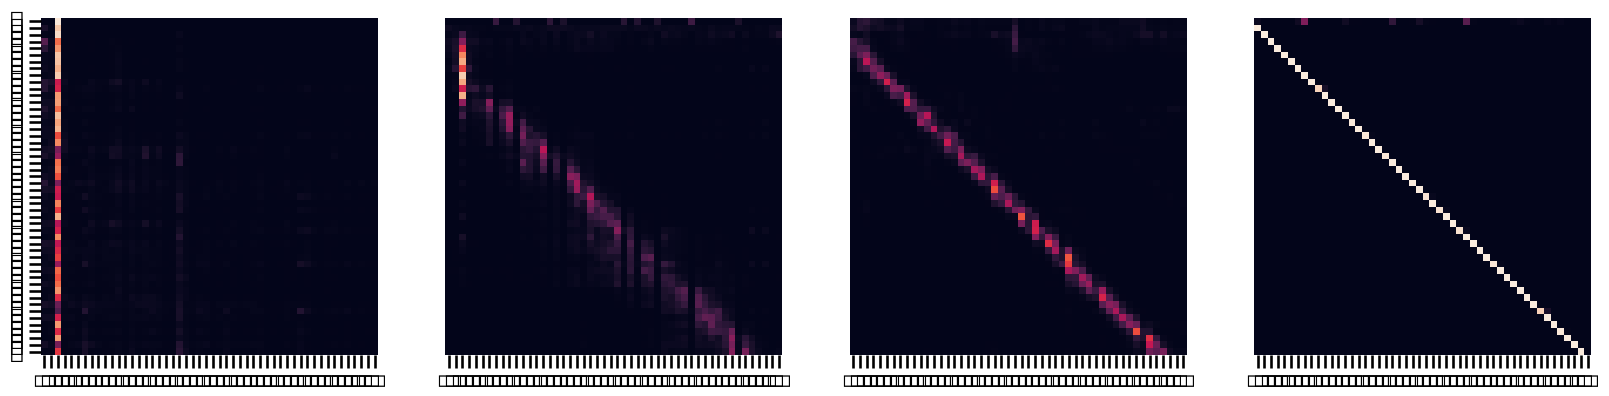

Encoder Layer 2


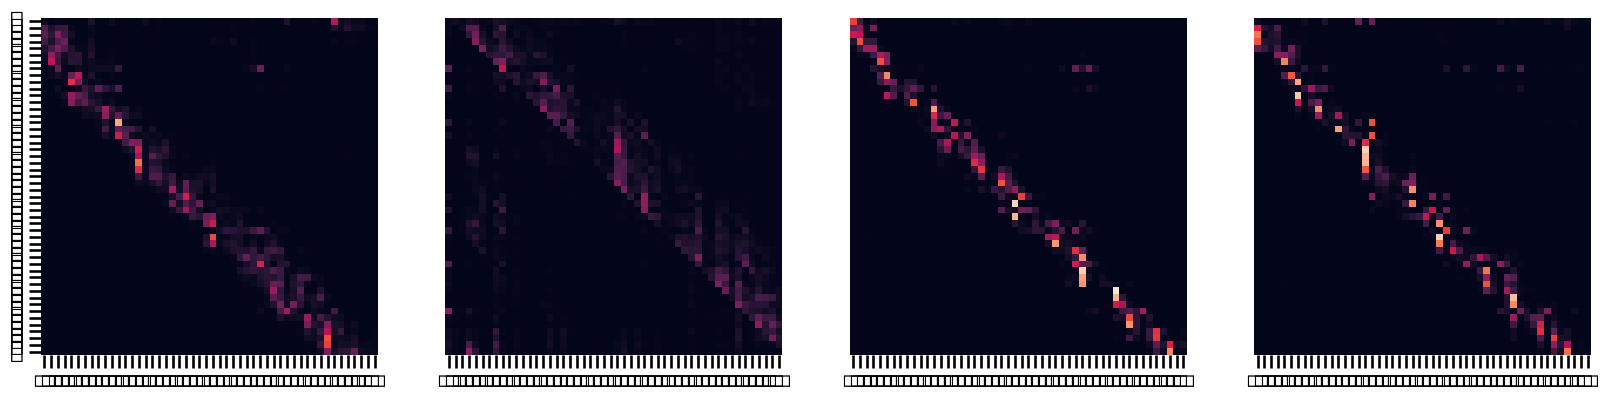

Encoder Layer 3


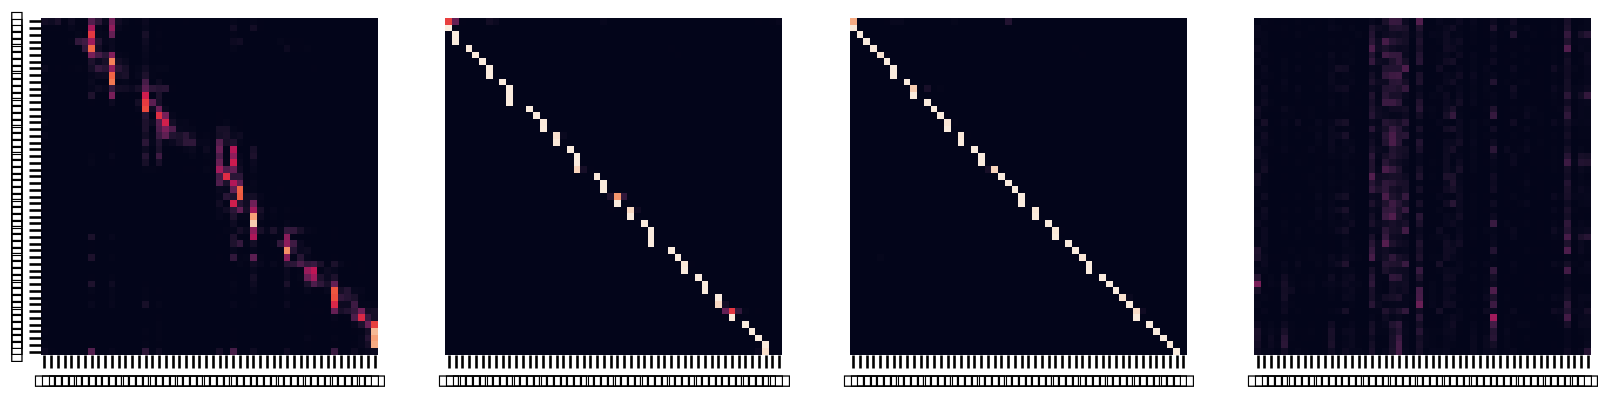

Decoder Self Layer 1


/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:80: UserWarning: Glyph 3988 (\N{TIBETAN SUBJOINED LETTER NGA}) missing from current font.
  fig.canvas.draw()
/ext3/miniconda3/lib/python3.9/site-packages/seaborn/utils.py:658: UserWarning: Glyph 3988 (\N{TIBETAN SUBJOINED LETTER NGA}) missing from current font.
  bboxes = [l.get_window_extent() for l in labels]
/ext3/miniconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 3988 (\N{TIBETAN SUBJOINED LETTER NGA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


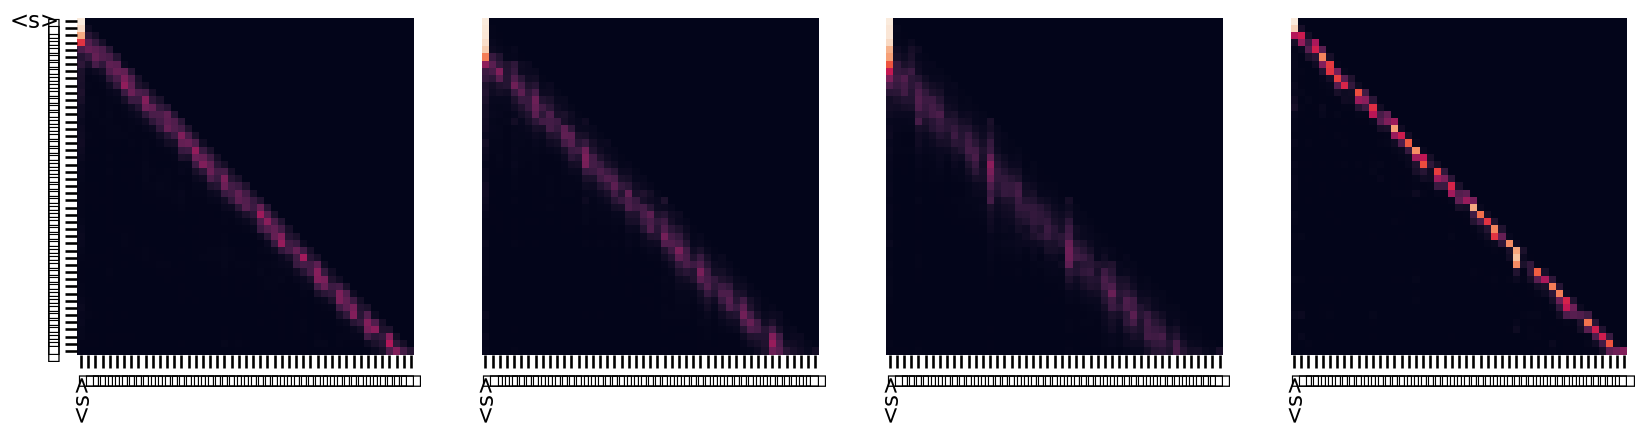

Decoder Src Layer 1


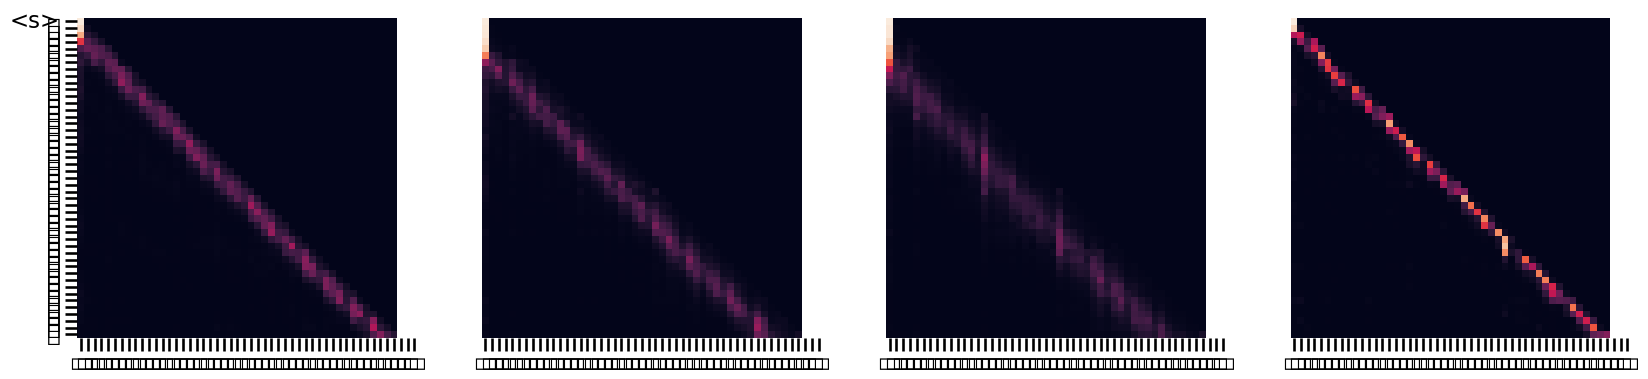

Decoder Self Layer 2


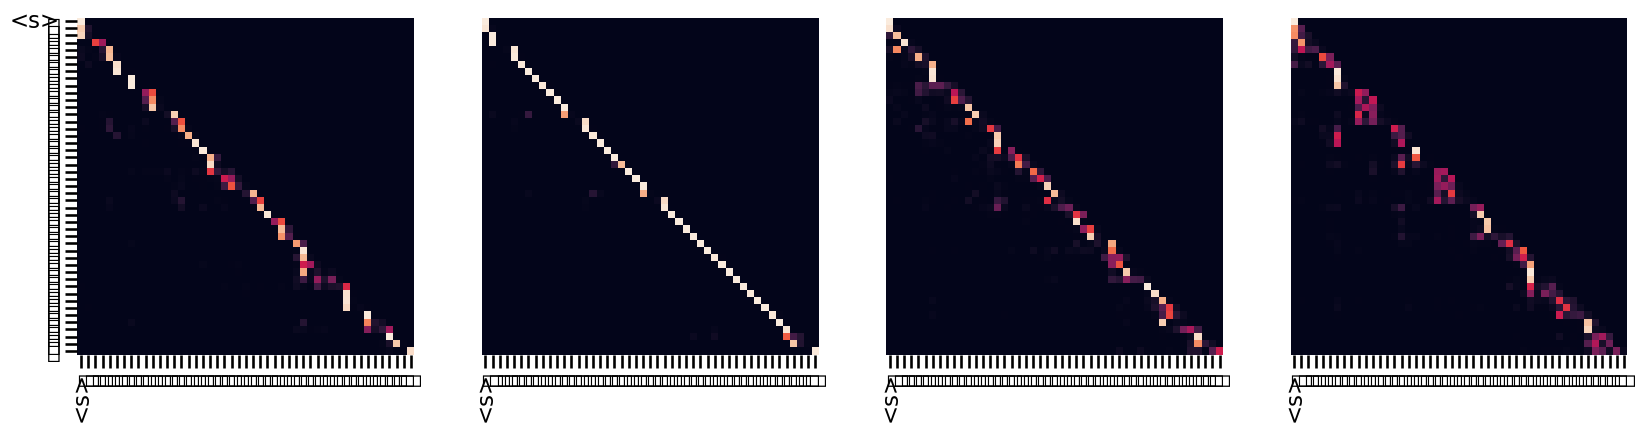

Decoder Src Layer 2


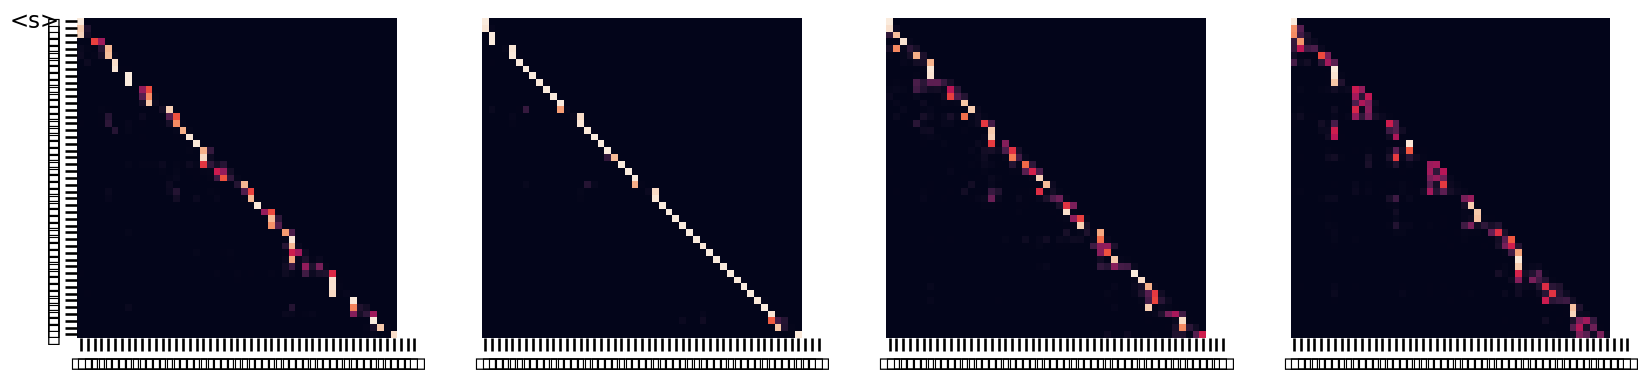

Decoder Self Layer 3


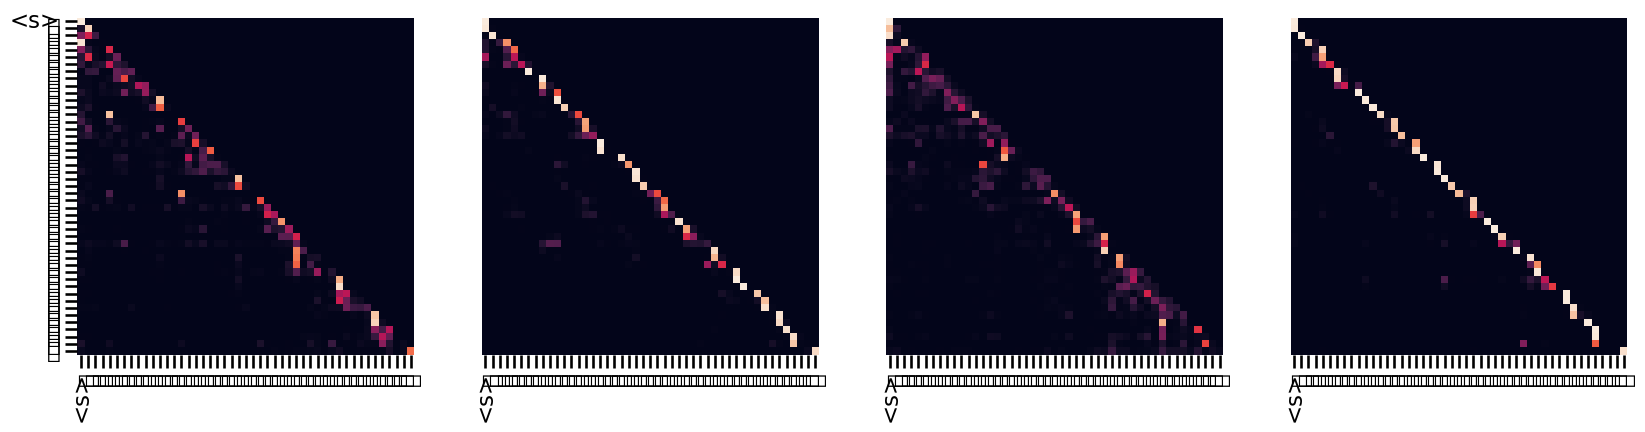

Decoder Src Layer 3


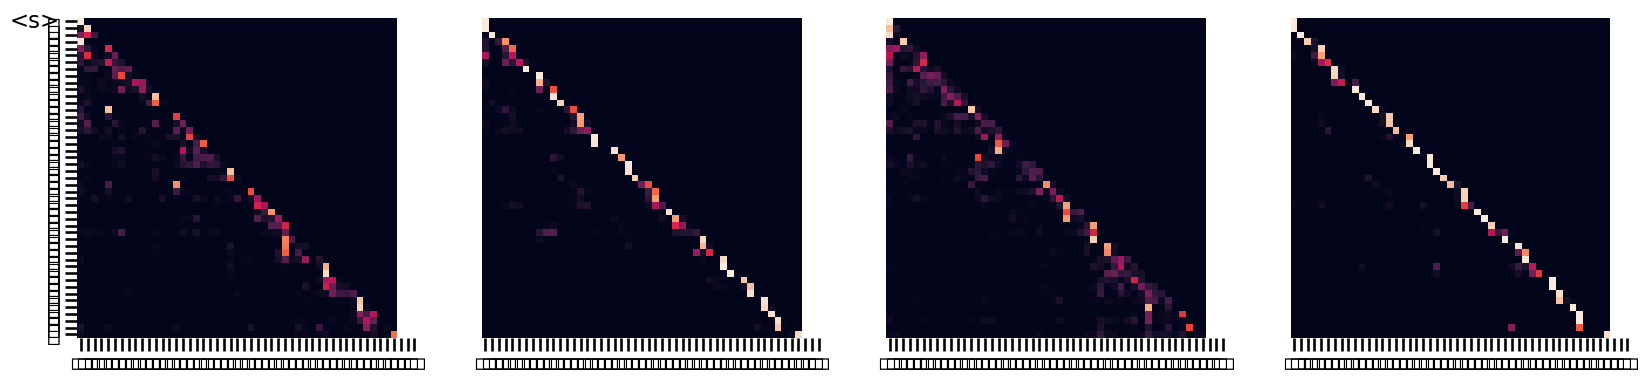

In [ ]:
tgt_sent = trans.split()

def draw(output, x, y, ax):
    seaborn.heatmap(output.cpu().data.numpy(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(3):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(3):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()

Encoder Layer 0
Encoder Layer 1
Encoder Layer 2


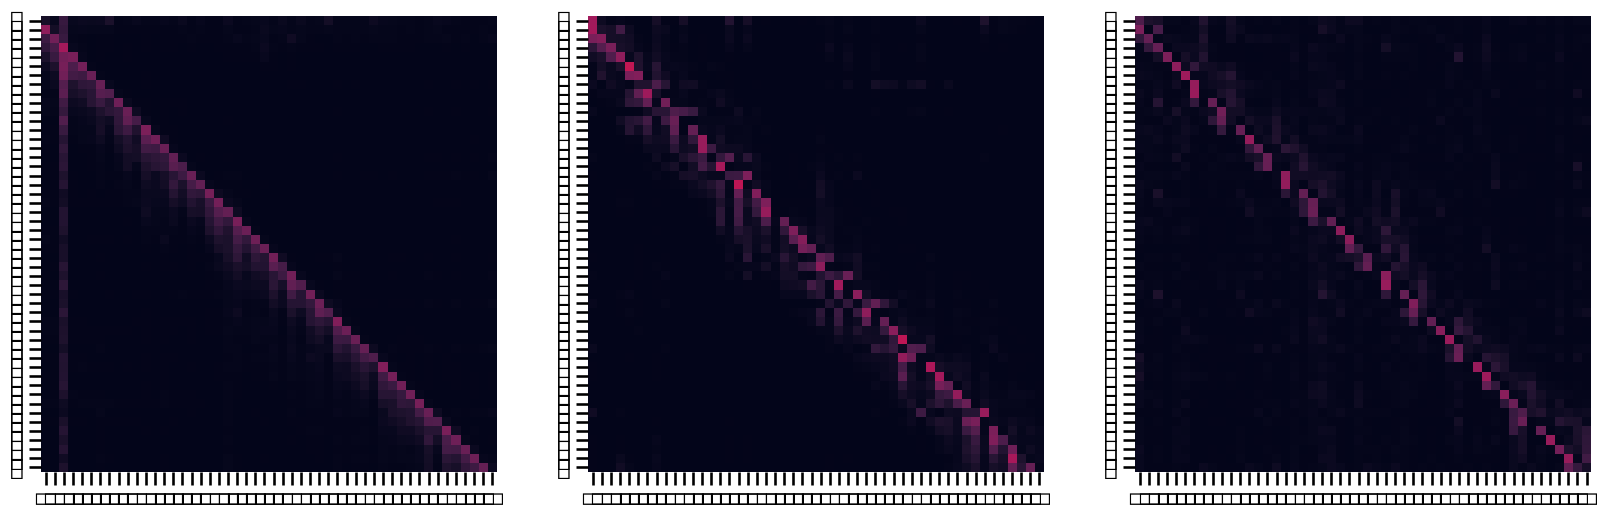

Decoder Self Layer 0
Decoder Self Layer 1
Decoder Self Layer 2


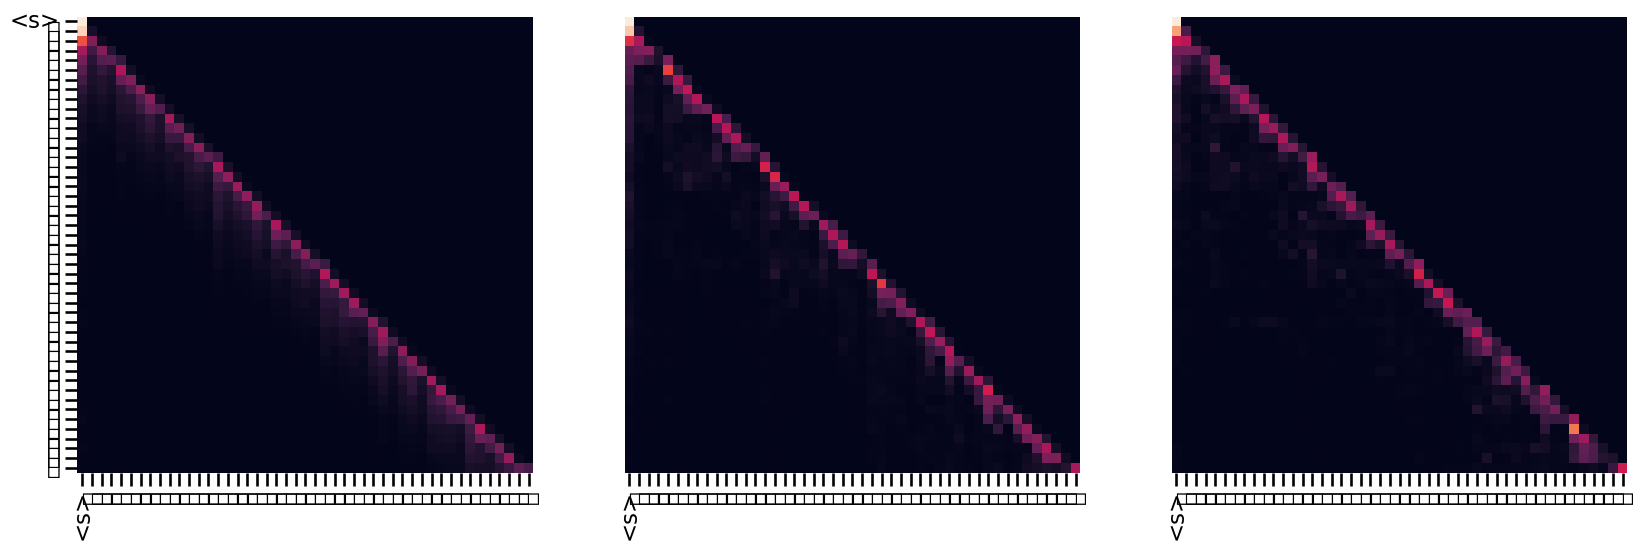

Decoder Src Layer 1
Decoder Src Layer 2
Decoder Src Layer 3


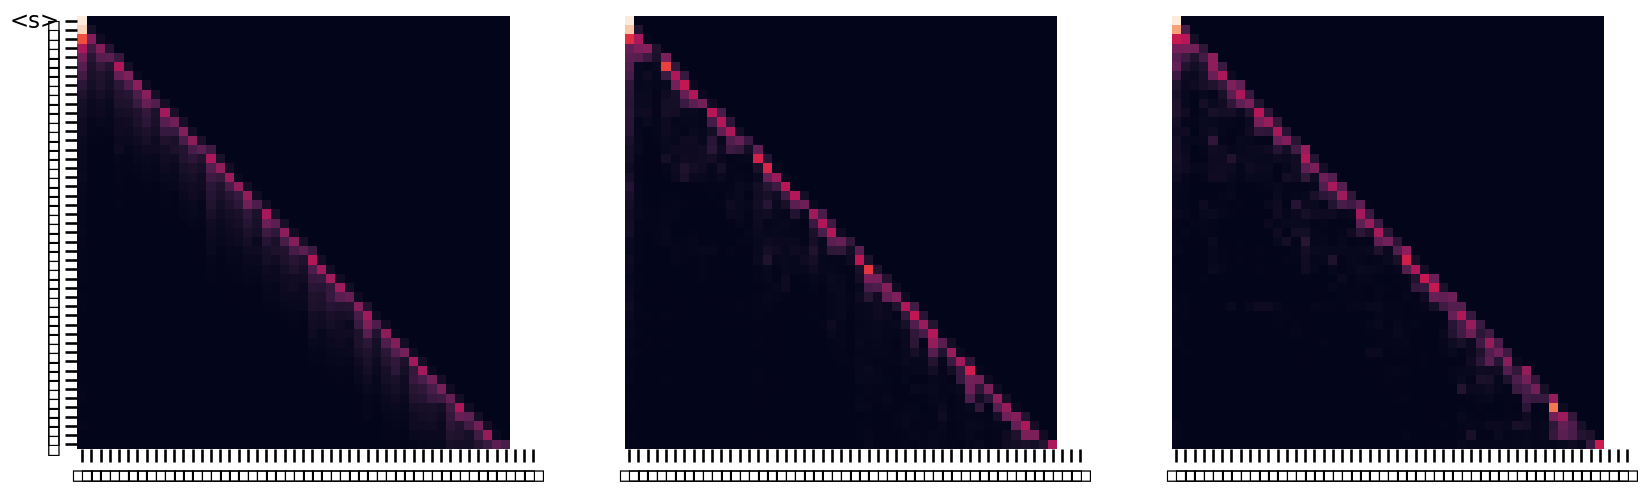

In [ ]:
tgt_sent = trans.split()

def draw(output, x, y, ax):
    seaborn.heatmap(output.cpu().data.numpy(), 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
fig, axs = plt.subplots(1,3, figsize=(20, 10))
for layer in range(3):
    print("Encoder Layer", layer)
    att_enc = torch.mean(model.encoder.layers[layer].self_attn.attn[0, :].data, axis=0)
    draw(att_enc, sent, sent, ax=axs[layer])
plt.show()
    
fig, axs = plt.subplots(1,3, figsize=(20, 10))
for layer in range(3):
    print("Decoder Self Layer", layer)
    att_dec_self = torch.mean(model.decoder.layers[layer].self_attn.attn[0, :].data[:len(tgt_sent), :len(tgt_sent)], axis=0)
    draw(att_dec_self, tgt_sent, tgt_sent if layer ==0 else [], ax=axs[layer])
plt.show()

fig, axs = plt.subplots(1,3, figsize=(20, 10))
for layer in range(3):
    print("Decoder Src Layer", layer+1)
    att_dec_src = torch.mean(model.decoder.layers[layer].self_attn.attn[0, :].data[:len(tgt_sent), :len(sent)], axis=0)
    draw(att_dec_src, sent, tgt_sent if layer ==0 else [], ax=axs[layer])
plt.show()

## 15. **Visualizing Correction Result**

In [ ]:

tt_src_sentences_list = ['དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།']
tt_trg_sentences_list = ['དང་། གཅད་པ་དང་། དྲལ་བ་དང་། དབུག་པ་དང་། གནས་ལྔ་པོ་འདི་ལྟ་སྟེ།']

tt_examples = get_examples(tt_src_sentences_list,
                            tt_trg_sentences_list)

tt = data.Dataset(tt_examples, fields)

tt_iter = MyIterator(tt, batch_size=BATCH_SIZE, device=device,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)


In [ ]:
for i, batch in enumerate(tt_iter):
    
    src = batch.src.transpose(0, 1)[:1]
    # print(src)
    src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)

    # print(confi)
    out, prob_list = greedy_decode(model, src, src_mask, 
                        max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS,
                        start_symbol=TRG.vocab.stoi["<s>"])
    print('prob: ', prob_list)
    print('Original Noisy Sentence: ', tt_src_sentences_list[i])

    print("Model Corrected Sentence: ", end="")
    pred = ""
    for i in range(1, out.size(1)):
        sym = TRG.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end ="")
        pred += sym
        
    print()
    print("Ground Truth Sentence: ", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TRG.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end ="")
    print()
    if i == 1:
        break

prob:  [0.5209761, 0.82090676, 0.92116606, 0.92210525, 0.5875901, 0.8735395, 0.9100814, 0.9251465, 0.8888192, 0.9212779, 0.9207935, 0.9219422, 0.92622066, 0.926273, 0.91466963, 0.8137627, 0.92501056, 0.9246553, 0.8999265, 0.9193136, 0.925971, 0.91853064, 0.9222041, 0.92543024, 0.92607707, 0.9145338, 0.91118175, 0.92320603, 0.9306042, 0.77453554, 0.8426432, 0.93727446, 0.9402292, 0.93298185, 0.9291352, 0.9151555, 0.9287086, 0.9239615, 0.92045754, 0.9087076, 0.9255135, 0.92867, 0.9340519, 0.9337723, 0.9288885, 0.9315659, 0.8083135]
Original Noisy Sentence:  དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།
Model Corrected Sentence: དང་།དྲལ་བ་དང་།དབུག་པ་དང་།གནས་ལྔ་པོ་འདི་ལྟ་སྟེ།
Ground Truth Sentence: 	དང་།གཅད་པ་དང་།དྲལ་བ་དང་།དབུག་པ་དང་།གནས་ལྔ་པོ་འདི་ལྟ་སྟེ།


## 16. **Compute Accuracy**

In [ ]:
def get_diff_token(a, b):
  mb = ed.matching_blocks(ed.editops(a,b), a, b)
  match_idx = [(t[0], t[0]+t[2]) for t in mb]
  match_idx = [np.arange(t[0], t[1]) for t in match_idx]
  match_idx = np.concatenate(match_idx, axis=0 )
  all_index = np.arange(len(a))
  not_same = np.array(list(set(all_index).difference(match_idx)))
  # group cluster
  if len(not_same) == 0:
    res = []
  elif len(not_same) == 1:
    res = [[not_same[0]]]
  else:
    res = []
    cur_group = [not_same[0]]
    for i in range(1, len(not_same)):
      if cur_group[-1] + 1 == not_same[i]:
        cur_group.append(not_same[i])
        if i == len(not_same) - 1:
          res.append(cur_group)
      else:
        res.append(cur_group)
        cur_group = [not_same[i]]
  diff_token = ["".join(a[i] for i in grp) for grp in res]

  return diff_token

In [ ]:
diff_A_list, diff_B_list, diff_C_list = [], [], []

for j in range(200):
  print(j)
  sent_data = df.reset_index().loc[j]
  sent = sent_data.noisy_text
  sent_true = sent_data.true_text
  print('Original Noisy Sentence: ', sent)

  src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
  src = Variable(src).to(device)
  src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
  out, prob_list = greedy_decode(model, src, src_mask,
                      max_len=512, start_symbol=TRG.vocab.stoi["<s>"])
  print("Translation:", end="\t")
  pred = ""
  for i in range(1, out.size(1)):
      sym = TRG.vocab.itos[out[0, i]]
      if sym == "</s>": break
      pred += sym
  print(pred)
  print("Ground Truth Sentence: ", sent_true)

  # compare noisy with true, a = noisy, b = true
  a, b = sent, sent_true
  diff_A = get_diff_token(a, b)
  diff_A_list.append(diff_A)
  # compare pred with true, a = pred, b = true
  a, b = pred, sent_true
  diff_B = get_diff_token(a, b)
  diff_B_list.append(diff_B)
  # compare noisy with pred, a = noisy, b = pred
  a, b = sent, pred
  diff_C = get_diff_token(a, b)
  diff_C_list.append(diff_C)

0
Original Noisy Sentence:  ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
Translation:	འདུལ་བ་ཀ་བཞུགས་སོ།།
Ground Truth Sentence:  ༄༅། །འདུལ་བ་ཀ་བཞུགས་སོ། །
1
Original Noisy Sentence:  ཡུལཨངགཙམརལམ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ།།དེས་དུས་གཞན་ཞིགན་ཨང་གའིརྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེབའགྱུར་ན།དེས་རང་གི་ཚོགས་ཡན་ལག་བཞིབ་གླང་པོ་ཆེས་ཚོགསདང་།པའིཚོགས་དང༌།ཤིང་ཏམའིཚོགས་དབ།དབངཆུད་ཚོགས་གོ་བསོན་ཏེ།ཡུམམ་གཏྟགཞོམ་པརབཙགསཔ་བམགདན་སྤྱ
Translation:	ཡུལ་ཨང་གཙང་མར་ལམ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ།།དེས་དུས་གཞན་ཞིག་ན་ཨང་གའི་རྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེ་བར་གྱུར་ན།དེས་རང་གི་ཚོགས་ཡན་ལག་བཞི་པ་གླང་པོ་ཆེ་སྣ་ཚོགས་དང་།པདྨའི་ཚོགས་དང་།ཤིང་ཏ་མའི་ཚོགས་དང་།དབང་ཆུད་ཚོགས་གོ་བསྟན་ཏེ།ཡུམ་མ་ག་དྷཱ་གཞོམ་པར་བཙགས་པ་བསམ་གཏན་གྱི་སྤྱ
Ground Truth Sentence:  ཡུལ་ཨང་ག་ཙམ་པ་མ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ། །དེ་ནས་དུས་གཞན་ཞིག་ན་ཨང་གའི་རྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེ་བར་གྱུར་ནས། དེས་དཔུང་གི་ཚོགས་ཡན་ལག་བཞི་པ་གླང་པོ་ཆེ་པའི་ཚོགས་དང་། རྟ་པའི་ཚོགས་དང་། ཤིང་རྟ་པའི་ཚོགས་དང་། དཔུང་བུ་ཆུང་གི་ཚོགས་གོ་བསྐོན་ཏེ། ཡུལ་མ་ག་དྷཱ་གཞོམ་པར་བརྩམས་པ་དང་། མ་ག་དྷཱ་ན་གནས་པའི་སྐྱ
2
Origina

Translation:	འཕགས་པ་དང་།དེས་རྒོལ་བ་ཁ་ཅིག་ནི་ཚར་བཅད་དེ་རྒོལ་བའི་ཤིང་རྟ་ལ་སྦྱོར་བར་བྱེད།ཁ་ཅིག་ནི་མགོར་ཐལ་བའི་བུམ་པ་དག་གིས་བསྟན།ཁ་ཅིག་ནི་འཁོར་གི་དཔོང་སར་ལྔ་བཞིན་དུ་ཐག་རིང་པོ་ནས་ཡོངས་སུ་སྤོང་བར་བྱེད།ཁ་ཅིག་ནི་གདུགས་དང་།རྒྱལ་དང་།བ་དན་དག་གིས་བསྲུང་བར་བྱེད།ཁ་ཅིག་ནི་སློབ་མ་ཉིད་དུ་ཁས་ལེན་པར་བྱེད་ཅིང་དེ་མཐར་གྱིས་གྲོང་དང་།གྲོང་ཕྱིར་དང་།གྲོང་རྡལ་དང་།དབུ་ཚོགས་དང་།ཚོད་འདག་ཏུ་རྒོལ་བ་འདུལ་ཞིང་རྒྱལ་པོའི་ཁབ་ཏུ་ཕྱིན་ཏོ།།བྲམ་ཟེ
Ground Truth Sentence:  འཕགས་པ་དང་། དེས་རྒོལ་བ་ཁ་ཅིག་ནི་ཚར་བཅད་དེ་རྒོལ་བའི་ཤིང་རྟ་ལ་སྦྱོར་བར་བྱེད། ཁ་ཅིག་ནི་མགོར་ཐལ་བའི་བུམ་པ་དག་གིས་བསྣུན། ཁ་ཅིག་ནི་འཕོང་གི་དཔོང་སར་ཁྭ་བཞིན་དུ་ཐག་རིང་པོ་ནས་ཡོངས་སུ་སྤོང་བར་བྱེད། ཁ་ཅིག་ནི་གདུགས་དང་། རྒྱལ་མཚན་དང་། བ་དན་དག་གིས་བསུ་བར་བྱེད། ཁ་ཅིག་ནི་སློབ་མ་ཉིད་དུ་ཁས་ལེན་པར་བྱེད་ཅིང་དེ་མཐར་གྱིས་གྲོང་དང་། གྲོང་ཁྱེར་དང་། གྲོང་རྡལ་དང་། དབྱེ་ཚོངས་དང་། ཚོང་རྡལ་དག་ཏུ་རྒོལ་བ་འདུལ་ཞིང་རྒྱལ་པོའི་ཁབ་ཏུ་ཕྱིན་ཏོ། །བྲམ་ཟེ
10
Original Noisy Sentence:  རེས་བསམསབ།བདག་ཅནསྙིང་གལབ་ནསོང་སྟེ་ཕྱིན་ནས་རྒྱལ་པོ་གཟུགས་ཅན་སྙིང་པོལ་རྒྱལ་བ་དང་ཚོསྤེལ་བ་བྱས་ཏེ་ཕྱོགས་གཅིག་ཏུ་འདུགའོ།།ཕྱོ

Translation:	་བྱེད་པ་དེ་དག་གིས་བྲམ་ཟེའི་ཁྱེའུ་འདི་ལ་མིང་ཅིར་གདགས་ཞེས་བསམས་ན།བྲམ་ཟེའི་ཁྱེའུ་འདི་བྲམ་ཟེ་སར་རྒྱལ་གྱི་བུ་ཡིན་པས།བྲམ་ཟེའི་ཁྱེའུ་འདིའི་མིང་རྒྱལ་དུ་གདགས་སོ་སྙམ་ནས་དེའི་མིང་ཅིར་སོ་སྙམ་ནས་དེའི་མིང་ཉེ་རྒྱལ་ཞེས་བཏགས་སོ།།བྲམ་ཟེས་རང་རྒྱལ་གྱིས་སྨྲས་པ།མེས་པོས་བྲམ་ཟེའི་ཁྱེའུ་འདི་ནི་ཅིར་བཏགས་ཏེ་རྒྱལ་ཞེས་བྱ་བར་བཏགས་སོ།།དེས་བསམས་པ།མེས་པོས་བྲམ་ཟེའི་ཁྱེའུ
Ground Truth Sentence:  ཁྱེའུའི་མིང་ཅིར་གདགས་ཞེས་བསམས་ན། བྲམ་ཟེའི་ཁྱེའུ་འདི་བྲམ་ཟེ་སྐར་རྒྱལ་གྱི་བུ་ཡིན་པས། བྲམ་ཟེའི་ཁྱེའུ་འདིའི་མིང་ཉེ་རྒྱལ་དུ་གདགས་སོ་སྙམ་ནས་དེའི་མིང་ཉེ་རྒྱལ་ཞེས་བྱ་བར་བཏགས་སོ། །བྲམ་ཟེ་སྐར་རྒྱལ་གྱིས་སྨྲས་པ། མེས་པོས་བྲམ་ཟེའི་ཁྱེའུ་འདིའི་མིང་ཅིར་བཏགས་ཉེ་རྒྱལ་ཞེས་བྱ་བར་བཏགས་སོ། །དེས་བསམས་པ། མེས་པོས་བྲམ་ཟེའི་ཁྱེའུ
18
Original Noisy Sentence:  སྦྱིན་པ་དང་།ལེན་པ་ལམཁས་བའི་བྲམ་ཟེ་རིག་བྱེད་དང་རིགབྱེདཀྱིཡན་ལག་གི་ཕ་རོལ་དུསོགས།ཟག་གི་ཐོལ་དུ་སོན།མེ་བུའི་ཤེས་པས་རང་གི་སྒྲུབ་གསལ་བརབྱེད་པ།གཞནགྱིས་ཚར་གཅོད་ནུསཁར་གྱུར་ཏོ།།དེས་བས་རིག་པའི་གནས་ཐམས་པསཡོབཅདགཉིསཀྱིས་དབང་བོའི་བརྡསོདཔ་བཀླགས་ནསནད་ཚར་བཅད་པར་གྱུར་ཏོ།དེདུསགཞཞིགནནད་ཕ་དཔལྷན་འདོནཔར་བྱེད་།དཔན

Translation:	གཞོན་ནུ་མ་སྐྱེས་དགྲ་ཀླུའི་རྒྱལ་པོའི་སྐྱེ་བོ་དང་།ཡིད་འོང་གཉིས་ཀྱི་དུས་སྟོན་ནས་སུ་མྱོང་བར་བྱེད་དུ་བཏང་བ།ཐོས་ནས་དེས་བསྐུར་ནས་དེས་བསམས་པ།གཞོན་ནུ་མ་སྐྱེས་དགྲ་འདི་ཕ་འདས་ནས་རྒྱལ་པོར་འགྱུར་ལ།བྲམ་ཟེའི་ཁྱེའུ་བང་ནས་གྱེས་དེ་ཡང་བདེ་བར་དུས་ནས་མདུན་ན་འདོན་དུ་གྱུར་པས།དེ་བསྙེན་ན་དུས་སུ་འབྲས་བུ་སྐྱེར་རོ་སྙམ་ནས་དེས་བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་ལ་སྨྲས་པ།བུ་སོང་ལ་ཀླུའི་རྒྱལ་པོ་རི་བོ་དང་།
Ground Truth Sentence:  གཞོན་ནུ་མ་སྐྱེས་དགྲ་ཀླུའི་རྒྱལ་པོ་རི་བོ་དང་། ཡིད་འོང་གཉིས་ཀྱི་དུས་སྟོན་ཉམས་སུ་མྱོང་བར་བྱེད་དུ་བཏང་བ། ཐོས་ནས་དེས་བསམས་པ། གཞོན་ནུ་མ་སྐྱེས་དགྲ་འདི་ཕ་འདས་ནས་རྒྱལ་པོར་འགྱུར་ལ། བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་འདི་ཡང་བདག་འདས་ནས་མདུན་ན་འདོན་དུ་འགྱུར་བས། དེ་བསྟེན་ན་དུས་སུ་འབྲས་བུ་སྟེར་བར་འགྱུར་རོ་སྙམ་ནས་དེས་བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་ལ་སྨྲས་པ། བུ་སོང་ལ་ཀླུའི་རྒྱལ་པོ་རི་བོ་དང་།
27
Original Noisy Sentence:  ༩ནས་བྲམཟེའི་ཁྱེའུཔནསསྐྱེསཀྱིསཉི་མགཅིགཀྱང་ཟནགཅད་པཁྱགསོ།གཉིས་དང༌།གསུམནས་དྲུག་གི་ཟན་གཅད་བྱས་སོ།།དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེསཀྱི་ཕམ་གཉིས་བྲམ་ཟེའི་ཁྱེའུཔ་ནས་སྐྱེས་ག་ནས་་བྲམཟེའི་ཁྱེའུབནསསྐྱེགལ
Translati

Translation:	་པ་ཡང་དག་པར་གང་དག་ཚེ་འདི་ཉིད་ལ་རང་གི་མངོན་པར་ཤེས་པས་འཇིག་རྟེན་འདི་དང་འཇིག་རྟེན་ཕ་རོལ་མངོན་སུམ་དུ་བྱས་སོ།།ཚངས་པ་སྤྱད་པ་བསྙེན་པར་བྱ་བ་བྱས་སོ།།སྲིད་པ་འདི་ལས་གཞན་མི་ཤེས་སོ་ཞེས་གོ་བར་བྱེད་པ་དག་མེད་དོ།།སྲོག་ནི་འདི་ཉིད་ལ་འཚོ་ཞིང་དེ་ཕྱིས་ཆད་པར་འགྱུར་ཞིག་པར་འགྱུར་ཏེ་འོག་ཏུ་ངང་ངོ་།།སྐྱེས་བུའི་ལུས་ནི་འབྱུང་བ་ཆེན་པོ་བཞི་ལས་གྱུར་པ་ཡིན
Ground Truth Sentence:  ཡང་དག་པར་སོང་བ་ཡང་དག་པར་ཞུགས་པ་གང་དག་ཚེ་འདི་ཉིད་ལ་རང་གི་མངོན་པར་ཤེས་པས་འཇིག་རྟེན་འདི་དང་འཇིག་རྟེན་ཕ་རོལ་མངོན་སུམ་དུ་བྱས་ནས་བསྒྲུབས་ཏེ་བདག་ཅག་ནི་སྐྱེ་བ་ཟད་དོ། །ཚངས་པར་སྤྱད་པ་བསྟེན་ཏོ། །བྱ་བ་བྱས་སོ། །སྲིད་པ་འདི་ལས་གཞན་མི་ཤེས་སོ་ཞེས་གོ་བར་བྱེད་པ་དག་མེད་དོ། །སྲོག་ནི་འདི་ཉིད་ལ་འཚོ་ཞིང་དེ་ཕྱིས་ཆད་པར་འགྱུར། ཞིག་པར་འགྱུར་ཏེ་ཤི་བའི་འོག་ཏུ་མི་འབྱུང་ངོ་། །སྐྱེས་བུའི་ལུས་ནི་འབྱུང་བ་ཆེན་པོ་བཞི་ལས་གྱུར་པ་ཡིན
36
Original Noisy Sentence:  བ0གཉིས་འདི་སྙམ་དུ་འབབབྱས།ཤཡིཚོམས་གཅིག་ཏུབྱས།ཤའི་བུས་གཅིག་ཏུ་བྱས།འི་ཕུང་པོ་གཅིག་ཏུ་བྱསནས་དེ་ལྟར་ཀུན་དུ་སྒྲུབ་པར་བྱེད་པ་ལ་གཞི་དེལས་སྡིག་པ་ཡང་མེད།ཞི་དེལསསྡིགུཔཡང་མེད།གཞིདིསསྡིགཔར་འགྱུརཔ་ཡང་མེདདོ།།ཆུཀླུག་གཱའིལྕོ་ནས་ཀ

Translation:	རབ་ཏུ་བྱུང་བ་དེ་ཐམས་ཅད་བདུད་རྩི་ཚོལ་བ་ཡིན་ན་ཁོ་བོས་བདུད་རྩི་ཅུང་ཟད་ཀྱང་མ་རྙེད་དེ།འདི་ལྟར་འདི་ཉིད་ཀྱི་གསོ་སྦྱོང་བསྐུལ་ལྡན་པ་ལ་ལྷ་དྲུག་སྟེང་གི་ནམ་མཁའ་ལ་རྒྱུ་བ་རྣམས་ཀྱི་སྒྲ་ཐོས་ནས་གངས་ཀྱི་ངོས་དང་ཉེ་བ་ཆུ་ཀླུང་སྐལ་ལྡན་ཤིང་རྟ་བའི་གྲམ་དྲང་སྲོང་ས་དང་རྩི་རྣམས་ཀྱི་གཞོན་ནུ་བྱུང་སྟེ།རེ་བྲམ་ཟེ་ལྟ་བ་དང་མཚན་མཁན་དག་གིས་གཞོན་ནུ་དེ་ཕོ་བྲང་གི་ནང་ན་བཞུགས་པར་གྱུར
Ground Truth Sentence:  ཟད་རབ་ཏུ་བྱུང་བ་དེ་ཐམས་ཅད་བདུད་རྩི་དོན་དུ་གཉེར་ཞིང་བདུད་རྩི་ཚོལ་བ་ཡིན་ན་ཁོ་བོས་བདུད་རྩི་ཅུང་ཟད་ཀྱང་མ་རྙེད་དེ། འདི་ལྟར་འདི་ཉིད་ཀྱི་གསོ་སྦྱོང་བཅྭ་ལྔ་པ་ལ་ལྷ་དག་སྟེང་གི་ནམ་མཁའ་ལ་རྒྱུ་བ་རྣམས་ཀྱི་སྒྲ་ཐོས་ནས་གངས་ཀྱི་ངོས་དང་ཉེ་བ་ཆུ་ཀླུང་སྐལ་ལྡན་ཤིང་རྟ་པའི་འགྲམ་དྲང་སྲོང་སེར་སྐྱའི་བསྟི་གནས་དང་ཧ་ཅང་མི་རིང་བར་ཤཱཀྱ་རྣམས་ཀྱི་གཞོན་ནུ་བྱུང་སྟེ། དེ་བྲམ་ཟེ་ལྟས་པ་དང་མཚན་མཁན་དག་གིས་གཞོན་ནུ་དེ་ཕོ་བྲང་གི་ནང་ན་བཞུགས་པར་གྱུར
45
Original Noisy Sentence:  ཏུདྭཅིང་མཐོན་པོརྣམས་ནི་བཅུར་གྱུར།དཐུང་བའི་མཐའཉིས་གྲལ་བསྟེ།གསོན་པའི་ཁུལ་ཆིབཡིན།།ཞེས་བྱ་བ་ཡིན་པས་དུས་ཀྱིཆོས་དབལྡན་པར་གྱུར་ཏོ།།དེ་དེ་རྣམས་ཀྱི་གོས་སྔོན་པོ།སེར་པོ་དང་།དམར་པོ་ང་།འབོ་ག་གི་ཕྱོ

Translation:	་བྱུང་བ་དང་།།དེ་ཡི་རྒྱུད་དེ་འགོག་མ་ཡིན་པའང་།།དེ་བཞིན་གཤེགས་པ་ཉིད་ཀྱིས་བཀའ་སྩལ་ཏེ།།དེ་སྐད་གསུང་བའི་ཚུལ་ཅན་དགེ་སློང་ཆེ།།ཆོས་ཀྱི་རྣམ་གྲངས་འདི་བཤད་པ་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་ཆོས་རྣམས་ལ་ཆོས་ཀྱི་མི་བདག་བྲལ་བ་སྐྱེས་སོ།།དེ་ནས་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་ཆོས་མཐོང་བ་དང་།ཆོས་ཐོས་པ་དང་།ཆོས་རིགས་དང་།ཆོས་གཏིང་སྐྱེ་བ
Ground Truth Sentence:  རྣམས་གང་དག་རྒྱུ་ལས་བྱུང་བ་དང་། །དེ་ཡི་རྒྱུ་དང་དེ་འགོག་གང་ཡིན་པའང་། །དེ་བཞིན་གཤེགས་པ་ཉིད་ཀྱིས་བཀའ་སྩལ་ཏེ། །དེ་སྐད་གསུང་བའི་ཚུལ་ཅན་དགེ་སྦྱོང་ཆེ། །ཆོས་ཀྱི་རྣམ་གྲངས་འདི་བཤད་པ་ན་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་ཆོས་རྣམས་ལ་ཆོས་ཀྱི་མིག་རྡུལ་མེད་ཅིང་དྲི་མ་དང་བྲལ་བ་སྐྱེས་སོ། །དེ་ནས་ཀུན་དུ་རྒྱུ་ཉེ་རྒྱལ་ཆོས་མཐོང་བ་དང་། ཆོས་ཐོས་པ་དང་། ཆོས་རིག་པ་དང་། ཆོས་ཀྱི་གཏིང་སླེབ
54
Original Noisy Sentence:  སོན་གང་ཡིན་དུ།།དེ་བཞིན་གཤེགས་པཉིད་ཀྱིས་བཀའwལ་ཏེ།།དེ་ལྟར་གསུང་བའི་ཚུལནྟན་དགེ་སྦྱོང་ཆེ།།ཚེ་དང་ལྡནམ་ད་དུང་ཡ་ཨན་གཅིག་བརྗོདཅིགཚོད་ལྡན་པ་བརྗོད་པར་བྱའོ།།ཆོས་རྣམས་གང་དག་ལས་བྱུང་དང༌།།དེ་ཡིན་དང་དེའགོག་གང་ཡིནཔས།དེ་བཞིན་གཤེགས་པ་ཉིད་ཀྱིས་བགལསལ་སྟེ་དེས་གསུང་བའི་ཚུལ་ཅན་ཤེས་ཚེ་ཆོགམ་གྲངས་འདི་བཤད
Translation:	སོན་ག

Translation:	བུ་མི་ཤེས་སོ་ཞེས་གང་ཡོངས་སུ་མྱ་ངན་ལས་འདའ་བར་བྱེད་དོ།།དེ་ལུས་ཀྱི་མཐའ་པའི་ཚོར་བ་མྱོང་བར་བྱེད་པ་ལུས་ཀྱི་མཐའ་པའི་ཚོར་བ་མྱོང་ངོ་སྙམ་དུ་ཡང་དག་པའི་ལྟ་བ་བཞིན་རབ་ཏུ་ཤེས་སོ།།སྲོག་གི་མཐའ་བའི་ཚོར་བ་མྱོང་བར་བྱེད་པ་ན་སྲོག་མཐའ་བཙོར་བ་མྱོང་ཇི་ལྟ་བ་བཞིན་རབ་ཏུ་ཤེས་སོ།།ལུས་ཞིག་པའི་འོག་ཏུ་གཡོངས་སུ་གཏུགས་པས་འདི་ཉིད་དུ་དེའི་ཚེ་རབ་ཐམས་ཅད་ལུས་པར་འགག་པར་འགྱུར
Ground Truth Sentence:  མི་ཤེས་སོ་ཞེས་གོ་བར་བྱེད་ཅིང་བདག་ཉིད་ཁོ་ནས་ཡོངས་སུ་མྱ་ངན་ལས་འདའ་བར་བྱེད་དོ། །དེ་ལུས་ཀྱི་མཐའ་པའི་ཚོར་བ་མྱོང་བར་བྱེད་པ་ན་ལུས་ཀྱི་མཐའ་པའི་ཚོར་བ་མྱོང་ངོ་སྙམ་དུ་ཡང་དག་པ་ཇི་ལྟ་བ་བཞིན་རབ་ཏུ་ཤེས་སོ། །སྲོག་གི་མཐའ་པའི་ཚོར་བ་མྱོང་བར་བྱེད་པ་ན་སྲོག་གི་མཐའ་པའི་ཚོར་བ་མྱོང་ངོ་སྙམ་དུ་ཡང་དག་པ་ཇི་ལྟ་བ་བཞིན་རབ་ཏུ་ཤེས་སོ། །ལུས་ཞིག་པའི་འོག་ཏུ་སྲོག་ཡོངས་སུ་གཏུགས་པས་འདི་ཉིད་དུ་དེའི་ཚོར་བ་ཐམས་ཅད་མ་ལུས་པར་འགག་པར་འགྱུར
63
Original Noisy Sentence:  བཀབ་པར་གྱུར།།དེདེ།རརབ་བྱུང་ནས་གཅིག་པུདབེན་པ་བག་ཡོདཔ་ཚུནཔ་དང་ལྡནས་བདགཉིདབཏང་བའགནས་སོ།།གཅིག་པུ་དབེན་པ་བག་ཡོདཔ་ཚུནཔ་དང་ལྡན་པ་བདག་བར་གནས་པ་རིགས་ཀྱི་གང་དག་གིཕྱིར་སྐྲ་དང་བཅུ་བྲེགས་ཏེ་གོས་ངུར་སྨྲིག་དག་བགོས་ནས

Translation:	་བྱས་ཏེ་ལན་གསུམ་དུ་བཟླས་ན།དེའི་འོག་ཏུ་དགེ་འདུན་ལ་རྟུལ་ཞུགས་བརྩེ་བ་ཅན་དགེ་འདུན་བཙུན་པ་རྣམས་ཀྱིས་ཐུགས་བརྩེ་བའི་སླད་དུ་བདག་རབ་ཏུ་རུང་བྱུང་དུ་གསོལ།བསྙེན་པར་རྫོགས་པར་མཛད་དུ་གསོལ།དེ་བཞིན་དུ་ལན་གཉིས་ལན་གསུམ་དུ་བཟླས་ཏེ།དེའི་འོག་ཏུ་དགེ་སློང་གཅིག་ཅིག་གིས་གུ་རོ་འབྱམ་ཐབས་བྱའོ།།འདི་ལྟར་བྱས་ཏེ་ལན་འདི་དག་བརྗོད་པར་བྱས་ན།དགེ་འདུན་སྟོན་པ་རྣམས་གསན་དུ་གསོལ།མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་ལ་རབ་ཏུ
Ground Truth Sentence:  ཐུགས་བརྩེ་བ་ཅན་དགེ་འདུན་བཙུན་པ་རྣམས་ཀྱིས་ཐུགས་བརྩེ་བའི་སླད་དུ་བདག་རབ་ཏུ་དབྱུང་དུ་གསོལ། བསྙེན་པར་རྫོགས་པར་མཛད་དུ་གསོལ། དེ་བཞིན་དུ་ལན་གཉིས་ལན་གསུམ་དུ་བཟླས། དེའི་འོག་ཏུ་དགེ་སློང་གཅིག་གིས་གསོལ་བ་བྱས་ཏེ་ལས་བྱའོ། །འདི་ལྟར་བྱས་ཏེ་འདུག་ལ་འདི་སྐད་བརྗོད་པར་བྱ་སྟེ། དགེ་འདུན་བཙུན་པ་རྣམས་གསན་དུ་གསོལ། མིང་འདི་ཞེས་བགྱི་བ་འདི་དགེ་འདུན་ལ་རབ་ཏུ
72
Original Noisy Sentence:  futབྱེད་ནུས།གཞན་མུ་སྟེགསཅན་དག་ཤེས་ལྡན་དག་ཤཱཀྱའི་བུའི་ང་ཁནཔོས་དང༌།སློབ་ཡོན་མེད་པསལེགསཔར་མ་སྦྱངས་པ་དང་།ལེགས་པར་མ་བགོས་པ།སྦྱམཐོནམོ་དང།སྒྲ་ཆེན་པོ་ང།རྒོད་བག་གི་སྤྱོད་ལམ་གྱིས་བྲུམཟེ་དང་ཁྱིམ་བདག་གི་ཁྱིམདག་ཏུའང་ཞིང་དེ་དག་དེར་ཟས་སློང་བ

Translation:	ཞེས་བརྗོད་པར་བྱའོ།།རབ་ཏུ་བྱུང་བས་ལེགས་སོ་ཞེས་བརྗོད་པར་བྱའོ།།དེའི་དབང་བྱུང་བ་དེ་བསྒྲུབ་པར་བྱའོ།།དེའི་འོག་ཏུ་དགེ་ཚུལ་ཉིད་ལ་སྒྲུབ་པར་བྱེད་པའི་དགེ་སློང་ལ་གཏད་པར་བྱའོ།།དེས་ཀྱང་མཁས་པ་གང་ཞེས་ཇི་སྐད་སྨྲས་ནས་ཡོངས་སུ་གནང་བས་སུ་ཐོབ་པ།དགེ་སློང་དེ་ཉིད་དུ་ངས་བླང་བས་དགེ་ཚུལ་ཉིད་དུ་བདེ་བར་སྒྲུབ་པར
Ground Truth Sentence:  ཞེས་བརྗོད་པར་བྱའོ། །རབ་ཏུ་བྱུང་བས་ལེགས་སོ་ཞེས་བརྗོད་པར་བྱའོ། །དེ་ནི་རབ་ཏུ་བྱུང་བ་ཉེ་བར་སྒྲུབ་པའོ།། །།དེའི་འོག་ཏུ་དགེ་ཚུལ་ཉིད་དུ་ཉེ་བར་སྒྲུབ་པར་བྱེད་པའི་དགེ་སློང་ལ་གཏད་པར་བྱའོ། །དེས་ཀྱང་མཁན་པོ་ལ་ཅི་ཡོངས་སུ་དག་གམ་ཞེས་དྲིས་ནས་ཡོངས་སུ་དག་ན་སྐྱབས་སུ་འགྲོ་བ་དང་། དགེ་ཚུལ་ཉིད་དུ་ཁས་བླང་བས་དགེ་ཚུལ་ཉིད་དུ་ཉེ་བར་བསྒྲུབ་པར
81
Original Noisy Sentence:  iozདང་པོ་འདིས་བདགའཕགས་པ་དགུ་བཅོམ་པ་དེ་དག་གིབསླབ་པ་ལ་རྗེསས་སློབ་བོ།།རྗེས་སུ་སྒྲུབ་བོ།།རྗེས་སུ་བགྱིད་དོ།།གཞནཡང་ཇི་ལྟར་འཕགས་པ་དགྲ་བཅོམ་པ་དེ་དག་གིས་ཇི་སྲིད་འཚོའི་བར་དུ་མ་བྱིན་པར་ལེན་པ་དང།མིཚངས་པར་སྤྱོད་པ་དང་།བརྫུན་དུ་སྐུ་བདང་།འབྲུའི་ཆང་དང་བཅོས་པའི་ཆང་མྱོས་པར་འགྱུར་བབག་མེད་པའི་གནས་དང།གླུ་དང༌།གར་དང་།རོལ་མོའི་སྒྲ་དང༌།ཕྲེང་བ་དང་།སྔོས
Translatio

Translation:	པར་བྱའོ།།འདི་ལ་ལྷུང་བཟེད་ལག་པ་གཡོན་པར་བཞག་སྟེ།ལག་པ་གཡས་པས་བཀབ་ནས་རྒན་པའི་མཐའ་ལོགས་དཔང་བཅས་པས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱ་སྟེ།བཙུན་པ་འདིས་ཚེ་དང་ལྡན་པ་དགོངས་སུ་གསོལ།ཚེ་དང་ལྡན་པ་ཚིག་འདི་ཤེས་བགྱི་བ་ལྷུང་བཟེད་འདི་མི་ཆུང་ངམ།མི་ཚེའམ།མི་སྐྱེའམ།དགེ་སློང་ཐམས་ཅད་ཀྱིས་ཀྱང་ལྷུང་བཟེད་དེ་ལྟ་ནས་ལྷུང་བཟེད་བཟང་ངོ་ཞེས་བརྗོད་པར་བྱའོ།།གལ་ཏེ་དེ་སྐ
Ground Truth Sentence:  ལྷུང་བཟེད་ལག་པ་གཡོན་པར་བཞག་སྟེ། ལག་པ་གཡས་པས་བཀབ་ནས་རྒན་པའི་མཐའ་ལོགས་ནས་དགེ་སློང་རེ་རེའི་མདུན་དུ་འགྲེང་སྟེ་འདུད་པ་དང་བཅས་པས་འདི་སྐད་ཅེས་བརྗོད་པར་བྱ་སྟེ། བཙུན་པའམ་ཚེ་དང་ལྡན་པ་དགོངས་སུ་གསོལ། ཚེ་དང་ལྡན་པ་མིང་འདི་ཞེས་བགྱི་བའི་ལྷུང་བཟེད་འདི་མི་ཆུང་ངམ། མི་ཆེ་འམ། མི་སྐྱ་འམ། དགེ་སློང་ཐམས་ཅད་ཀྱིས་ཀྱང་ལྷུང་བཟེད་དེ་ལྟ་བུ་ཉིད་མ་ཡིན་ན་རེ་རེ་ནས་ལྷུང་བཟེད་བཟང་ངོ་ཞེས་བརྗོད་པར་བྱའོ། །གལ་ཏེ་དེ་སྐ
89
Original Noisy Sentence:  ནམམནིང་པ་ཡིན་ནམ།དགེ་སློང་མ་སུན་བྱུང་བ་མ་ཡིན་ནམ།རྐུ་ཐབསསུ་གནས་པ་མ་ཡིན་ནམ།ཐ་དད་དུ་གནས་པས་ཡིན་ནམ།གནས་པར་མི་བྱ་བམཡིན་ནམ།མུ་སྟེགས་ཅན་མ་ཡིན་ནམ།མུསྟེགས་ཅན་ཞུགས་པས་ཡིན་ནམ།ཕ་བསད་པ་མ་ཡིན་ནམ།མ་བསད་པམ་ཡིནནམ།དགྲ་བཅོམ་པ་བསད་པ་མ་ཡིནནམ།དགེ་འདུན་

Translation:	འཆག་སར་མ་བྱས་པའམ།བྱིབས་སུ་བྱས་པའམ།བྱ་སྐྱིབས་སུ་མ་བྱས་པའམ།གཞན་ཡང་གནས་མལ་རུང་བ་གང་དགེ་འདུན་ནམ་གང་ཟག་ལས་རོ་དང་།དེ་ལ་ཁྱོད་ཀྱིས་ཡོངས་སུ་ཚོད་ཟིན་པར་གྱིས་ཤིག།ཇི་ལྟར་གནས་འཇིག་འདུན་ནམ་འཆའ་འམ།དེས་དམའ་བའོ
Ground Truth Sentence:  འཆག་སར་མ་བྱས་པའམ། བྱ་སྐྱིབས་སུ་བྱས་པའམ། བྱ་སྐྱིབས་སུ་མ་བྱས་པའམ། གཞན་ཡང་གནས་མལ་རུང་བ་གང་དགེ་འདུན་ནམ་གང་ཟག་ལས་རྙེད་ན། དེ་ཡང་ཁྱོད་ཀྱིས་ལོང་ལ་ཚོད་ཟིན་པར་གྱིས་ཤིག །ཇི་ལྟར་ཁྱོད་གནས་འདི་ལྟ་བུ་ལ་དམ་འཆའ་འམ། དེས་དམ་འཆའོ
98
Original Noisy Sentence:  ཞེས་བརྗོད་བར་བྱའོ།མིཔ་འདིཞེས་བྱ་བ་ཁྱོད་ཉོན་ཅིགསྐྲུན་གྱི་ནང་ན་བཀུས་ཏེ་བོར་བཞིརུང་བ་མེད་ཀྱང་སླ་བསྟེལ་གནསན་དགེ་སློངལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབཅུ་བྱུང་བ་དང་བསྙེན་པར་རྫོགས་པདགསྨོག་ས།ཁོར་འགྱུར་རོ།།མི་འདིཞེས་བྱ་བ་ཁྱོདཇི་སྲིད་འཚོའི་བར་དུ་བཀུས་ཏེ་བོར་བའིསན་གྱིས་འཚོབའསྤྲོ་འམ།
Translation:	་བྱ་བ་ཁྱོད་ཉོན་ཅིག།སྤྲིན་གྱི་ནང་ན་བཀུས་ཏེ་བོར་བ་ནི་རུང་བ་མེད་ཀྱང་སླ་བ་སྟེ་ལ་གནས་ན་དགེ་སློང་ལེགས་པར་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་བྱུང་བ་དང་བསྙེན་པར་རྫོགས་པ་དག་སྨོས་སོ།།འཁོར་བར་འགྱུར་རོ།།མི་འདི་ཞེས་བྱ་བ་ཁྱོད་ཇི་སྲིད་འཚོའི་བར་དུ་བཀྲུས་ཏེ་བོར་བའི་ས

Translation:	པར་སྨྲ་བར་བྱེད།སོ་སོར་ཀུན་དགའ་བར་བྱེད།རྟག་ཏུ་ཡང་ཉན་ཅིག་གནས་པར་བྱེད་དོ།།ལྷ་རྣམས་བདག་དང་ལྷན་ཅིག་གཏམ་འདྲེ་བར་བྱེད།ཕེབས་པར་སྨྲ་བར་བྱེད།སོ་སོར་ཀུན་དགའ་བར་བྱེད།རྟག་ཏུ་ཡང་ལྷན་ཅིག་གནས་པར་བྱེད་དོ།།ཀླུ་རྣམས་དང་།གནོད་སྦྱིན་རྣམས་དང་།ནམ་མཁའ་ལྡིང་རྣམས་དང་།དྲི་ཟ་རྣམས་དང་།མིའམ་ཅི་རྣམས་དང་།ལྟོ་འཕྱེ་ཆེན་པོ་རྣམས་དང་།
Ground Truth Sentence:  པར་སྨྲ་བར་བྱེད། སོ་སོར་ཀུན་དགའ་བར་བྱེད། རྟག་ཏུ་ཡང་ལྷན་ཅིག་གནས་པར་བྱེད་དོ། །ལྷ་རྣམས་བདག་དང་ལྷན་ཅིག་གཏམ་འདྲེ་བར་བྱེད། ཕེབས་པར་སྨྲ་བར་བྱེད། སོ་སོར་ཀུན་དགའ་བར་བྱེད། རྟག་ཏུ་ཡང་ལྷན་ཅིག་གནས་པར་བྱེད་དོ། །ཀླུ་རྣམས་དང་། གནོད་སྦྱིན་རྣམས་དང་། ནམ་མཁའ་ལྡིང་རྣམས་དང་། དྲི་ཟ་རྣམས་དང་། མིའམ་ཅི་རྣམས་དང་། ལྟོ་འཕྱེ་ཆེན་པོ་རྣམས་དང་།
107
Original Noisy Sentence:  མི་དགསརྣམས་དང་།ཤིའརྣམས་དང༌།གྲུལ་བུམ་རྣམས་དང་གྲུལཔོ་རྣམས་དང་།ལུས་སྲུལ་པོ་རྣམསདང་།རྡུལ་ཁྲོད་ཀྱི་ཤཟརྣམས་བདགད་ལྷན་ཅིག་གཏམ་འདྲེ་བར་བྱེད།ཕེབས་པར་སྨཱབར་བྱེད།སོ་སོ་ཀུན་དགའབར་བྱེད།སྨྱུག་ཏུཡཔལྷན་ཅིགགནས་པར་བྱེད་དོ།།མཐོབ་བཞིན་དུ་བདགགིས་མིརྟགཔའིའདུ་ཤེས།མི་རྟག་བལ་སྡུག་བསྔཡབ
Translation:	མི་དགས་རྣམས་དང་།ཤི་འཕྲོ་རྣམས་དང་།གྲུལ་བུམ་རྣམས

Translation:	གནས་སྦྱིན་པར་བྱ།དགེ་ཚུལ་ཉེ་བར་གཞག་པར་བྱ་ཞིང་བདག་ཉིད་ཀྱང་མི་གནས་པར་འཇུག་པར་བྱའོ།།གཞན་ཡང་ལོ་ནི་ཡོན་ཏན་དུ་བྱུང་བར་བྱ།བསྙེན་པར་རྫོགས་པར་བྱ།གནས་སྦྱིན་པར་བྱ།དགེ་ཚུལ་ཉེ་བར་གཞག་པར་བྱ་ཞིང་བདག་ཉིད་ཀྱང་མི་གནས་པར་འཇུག་པར་བྱའོ།།སྣ་གང་ཞེ་ན།ཚུལ་ཁྲིམས་ཕུན་སུམ་ཚོགས་པ་དང་།ཏིང་ངེ་འཛིན་མུན་སུམ་ཚོགས་པ་དང་།ཤེས་རབ་ཕུན་སུམ་ཚོགས་པ་དང་།རྣམ་འགྲོལ་བ་ཕུན་སུམ་ཚོགས
Ground Truth Sentence:  པར་རྫོགས་པར་བྱ། གནས་སྦྱིན་པར་བྱ། དགེ་ཚུལ་ཉེ་བར་གཞག་པར་བྱ་ཞིང་བདག་ཉིད་ཀྱང་མི་གནས་པར་འདུག་པར་བྱའོ། །གཞན་ཡང་ལོ་བཅུ་ལོན་པ་ཆོས་ལྔ་དང་ལྡན་པས་རབ་ཏུ་དབྱུང་བར་བྱ། བསྙེན་པར་རྫོགས་པར་བྱ། གནས་སྦྱིན་པར་བྱ། དགེ་ཚུལ་ཉེ་བར་གཞག་པར་བྱ་ཞིང་བདག་ཉིད་ཀྱང་མི་གནས་པར་འདུག་པར་བྱའོ། །ལྔ་གང་ཞེ་ན། ཚུལ་ཁྲིམས་ཕུན་སུམ་ཚོགས་པ་དང་། ཏིང་ངེ་འཛིན་ཕུན་སུམ་ཚོགས་པ་དང་། ཤེས་རབ་ཕུན་སུམ་ཚོགས་པ་དང་། རྣམ་པར་གྲོལ་བ་ཕུན་སུམ་ཚོགས
116
Original Noisy Sentence:  བཙཝརབ་ཏུ་དབྱུང་བར་བྱ།བསྙེན་པ་རྫོགས་འཁུ།གནམ་སྦྱིན་པས་བུ།དགེ་ཚུལ་ཉེ་བར་གཞག་པར་བྱ་ཞིང་བ་གཉིད་ཀྱང་མི་གནས་པར་འདུག་པ་བྱའོ།།གཞན་ཡང་ལོ་བཅུལོན་པཆོས་ལྔ་དང་ལྡན་བས་རབ་དུ་བྱུང་བར་བྱ།བསྙེན་པར་རྫོགས་པ་བྱ།གནས་སྦྱིན་བཅུ།དགེ་ཚུལ

Translation:	འདུན་གྱིས་ཞུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བྱ་བ་ལ་སློབ་པ་ནི་ཞི་བར་དུ་མཁན་པོ་དེ་ཤེས་རབ་ལ་ཟླ་བ་བཞིའི་བར་དུ་མཁན་པོས་སྦྱར་བའི་གོས་དག་གིས་གསོལ་ཏོ།།འདི་ནི་གསོལ་བའོ།།ལན་ནི་འདི་ལྟར་བྱ་སྟེ།དགེ་འདུན་གསོལ་བའོ།།ལས་ནི་འདི་ལྟར་བྱ་སྟེ།དགེ་འདུན་བཙུན་པ་རྣམས་གསན་དུ་གསོལ།མུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བགྱི་བ་འདི་མངའ་ཞེས་བགྱི་བས་རབ་འབྱུང་བར་འཚལ་ནས།མུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བགྱི་བའི་བར་དུ་མཁན་པོས་དགེ་འདུན
Ground Truth Sentence:  འདུན་གྱིས་མུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བྱ་བ་ལ་ཟླ་བ་བཞིའི་བར་དུ་མཁན་པོས་སྦྱར་བའི་གོས་དག་གིས་གནས་པ་གསོལ་ཏོ། །འདི་ནི་གསོལ་བའོ། །ལས་ནི་འདི་ལྟར་བྱ་སྟེ། དགེ་འདུན་བཙུན་པ་རྣམས་གསན་དུ་གསོལ། མུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བགྱི་བ་འདི་མིང་འདི་ཞེས་བགྱི་བ་ལས་རབ་ཏུ་འབྱུང་བར་འཚལ་ནས། མུ་སྟེགས་ཅན་མིང་འདི་ཞེས་བགྱི་བ་འདི་ཟླ་བ་བཞིའི་བར་དུ་མཁན་པོས་སྦྱར་བའི་གོས་དག་གིས་གནས་པར་དགེ་འདུན
125
Original Noisy Sentence:  1བྱབའི་སྤྲུགས་ཏོ།།གསན་ནས་ཀྱང་སངས་རྒྱས་བཅོམ་ལྡན་འདས་རྣམས་ནི་མཁྱེན་བཞིན་དུ་རྨེད་པར་མཛདང་སྟེ།མཁྱེན་བཞིན་དུ་ཆེད་བ།མཁྱེན་ཀྱང་མི་བ།དུསསུ་རྨེབ།དུས་ལས་ཡོལ་བ་མི་ཆེདབ།དོན་དང་ལྡན་བརྨདབ།དོན་དང་མི་ལྡན་པ་མི་རྨང་བས་སངས་རྒྱས་བཅ

Translation:	ཤོག་མཁན་པོའི་གདུ་འདོང་ཞེས་དེས་དེ་ཁྲིད་དེ་མཁན་པོའི་གན་དུ་སོང་ནས་སྨྲས་པ།མཁན་པོ་རིགས་ཀྱི་བུ་འདི་རབ་ཏུ་འབྱུང་བར་འཚལ་གྱིས་འདི་རབ་ཏུ་བྱུང་དུ་གསོལ།དེས་དེ་རབ་ཏུ་ཕྱུང་ངོ་།།དེའི་མ་ཡིག་དཔོན་གྱིས་དེ་དགར་མཆིས།དེ་རིང་ཁོ་གོས་གནས་སོ།།ངེས་ཀྱང་སྨྲས་པ།བདག་གིས་ཀྱང་དེ་སྨྲས་སོ།།ཡིག་དཔོན་གྱིས་སྨྲས་པ།དེ
Ground Truth Sentence:  ཤོག་མཁན་པོའི་གན་དུ་འདོང་ཞེས་དེས་དེ་ཁྲིད་དེ་མཁན་པོའི་གན་དུ་སོང་ནས་སྨྲས་པ། མཁན་པོ་རིགས་ཀྱི་བུ་འདི་རབ་ཏུ་འབྱུང་བར་འཚལ་གྱིས་འདི་རབ་ཏུ་དབྱུང་དུ་གསོལ། དེས་དེ་རབ་ཏུ་ཕྱུང་ངོ་། །དེའི་མ་ཡིག་དཔོན་གྱི་གན་དུ་སོང་སྟེ་སྨྲས་པ། ཁྱེའུ་དེ་ད་གར་མཆིས། དེ་དེ་རིང་ཁོ་བོས་གཞུས་སོ། །དེས་ཀྱང་སྨྲས་པ། བདག་གིས་ཀྱང་དེ་དེ་རིང་གཞུས་སོ། །ཡིག་དཔོན་གྱིས་སྨྲས་པ། དེ
134
Original Noisy Sentence:  དབཞིན་རབ་ཏུ་བྱུང་པོ།།ཅིའི་ཕྱི་ཀྱིས་ཁོ་བོལ་ལ་སྨྲས།དེས་སུས་པ།མཁནཔོ་ཁྱོད་ཀྱིས་བདག་ལསྨྲསམཙི༔དེམི་དགའ་བར་གྱུར་ཅིང་འདུག་པ།དེའི་ལྷནཅིག་བ་ནས་པརང་ཉེ་གནསརྣམས་ལྷགས་ཏེ་སྨྲས་པ།མཁན་པོ་ཁྱོད་ཅིའི་སདདུ་མིདགྱེས་ཤིང་བཞུགས་དམ་རིགས་ཀྱི་ཡུལབྱུང་བས་ཁོ་བོསནད་ངཉེབ་
Translation:	བཞིན་རབ་ཏུ་བྱུང་ངོ་།།ཅིའི་ཕྱིར་ཁོ་བོ་ལ་ལ་སྨྲས་པ།དེས་སྨྲས་པ།མཁན་པོ་ཁ

Translation:	ཁོ་ན་མེད་པ་དང་།མི་འགྲན་པ་དང་།མི་འབྲུ་བདག་བསད་པ་དེའི་ཚེ་ན་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོའི་སྲིང་མོའི་བུ་གཉིས་ཤིག་བསམ་པ་བོར་ནས།དེ་དག་ལ་བྱམས་པས་མཉན་པ་དང་ཐོགས་ཏེ་སེར་སྐྱའི་གནས་སུ་དོང་བ་དང་།དེ་དག་གིས་དེ་གཉིས་བཞིན་གཟུགས་ལས་ངོས་ནས་སྨྲས་པ།ཁྱེའུ་གཉིས་ཁྱོད་ཕ་མ་གཉིས་གནས་ན།དེ་གཉིས་ཀྱི་གནས་སུ་དོང་
Ground Truth Sentence:  ར་སྐྱའི་གནས་ན་གནས་པའི་ཤཱཀྱ་ཁོན་མེད་པ་དང་། མི་འགྲན་པ་དང་། མི་འཁུ་བ་དག་བསད་པ་དེའི་ཚེ་ན་ཚེ་དང་ལྡན་པ་ཀུན་དགའ་བོའི་སྲིང་མོའི་བུ་གཉིས་ཤིག་ཕ་མས་བོར་ནས། དེ་དང་དེ་ན་འཁྱམ་པ་ལས་མཉན་ཡོད་ཀྱི་ཚོང་པ་དག་ཟོང་ཐོགས་ཏེ་སེར་སྐྱའི་གནས་སུ་དོང་བ་དང་། དེ་དག་གིས་དེ་གཉིས་བཞིན་གཟུགས་ལས་ངོ་ཤེས་ནས་སྨྲས་པ། ཁྱེའུ་གཉིས་ཁྱོད་ཀྱི་ཕ་མ་གཉིས་གང་ན། དེ་གཉིས་ཀྱིས་སྨྲས་
143
Original Noisy Sentence:  །མེ་ཏོག་དང་།འབྲས་བུ་དག་འབུལ་ན།དགེ་སློང་དག་ཀྱང་འདི་གཉིས་ལ་ལྷུང་བཟེད་ཀྱི་ལྷགམ་སྦྱིན་པར་འགྱུར་རོ།དེས་དེ་གཉིས་བསྡུསནས་དགེ་སློཏ་དག་ལ་ལོ་མ་དང་།མེ་ཏོག་དང་།འབྲས་བུ་དག་འབུལ་དུ་གཞུག་པར་བརྩམསཔ་དང་།དགེ་སློང་དག་ཀྱང་དེ་གཉིསལ་ལྷུང་བཟེད་ཀྱི་ལྕག་མ་སྦྱིན་པར་བྱེད་དོ།།དེ་དག་གིས་དེ་གཉིས་ལཞག་ཉུང་ཤས་ཤིག་བྱིནནས་ཡང་མི་སྦྱིན་པར་བརྩམས་པ་དང་།ཚདང་ལྡན་

Translation:	མེད་ཁང་འདི་གཉིས་ལྷའི་བུ་སུ་ཡང་མི་འདུག།དེ་དག་གི་སྨྲས་པ།སུ་ཡང་མི་འདུག་གོ།།ཅིའི་ཕྱིར།དེ་དག་གིས་སྨྲས་པ།འཕགས་པ་ཀུན་དགའ་བོའི་སྲིང་མོའི་ལུག་ཀྱིས་རབ་ཏུ་བྱུང་ནས་བརྩོན་འགྲུས་བརྩམས་ཤིང་སྤྱོད་པ་དེ་གཉིས་ཤི་ཞིང་དུས་ལ་བབས་ན་འདིར་སྐྱེ་བར་འགྱུར་བས་དེ་གཉིས་ཀྱི་དོན་དུ་བཞག་གོ།།དེ་གཉིས་ཡོངས་སུ་དགའ་ནས་ཚེ་དང་ལྡན
Ground Truth Sentence:  མེད་ཁང་འདི་གཉིས་ན་ལྷའི་བུ་སུ་ཡང་མི་འདུག །དེ་དག་གིས་སྨྲས་པ། སུ་ཡང་མི་འདུག་གོ། །ཅིའི་ཕྱིར། དེ་དག་གིས་སྨྲས་པ། འཕགས་པ་ཀུན་དགའ་བོའི་སྲིང་མོའི་བུ་གཉིས་རབ་ཏུ་བྱུང་ནས་བརྩོན་འགྲུས་བརྩམས་ཤིང་སྤྱོད་པ་དེ་གཉིས་ཤི་ཞིང་དུས་ལ་བབ་ན་འདིར་སྐྱེ་བར་འགྱུར་བས་དེ་གཉིས་ཀྱི་དོན་དུ་བཞག་གོ། །དེ་གཉིས་ཡོངས་སུ་དགའ་ནས་ཚེ་དང་ལྡན
151
Original Noisy Sentence:  བལལ་རི་དང་།པཱ་ཏི་དང་།སུ་གྱོད་ག་དག་གི་སྦྱདག་སྒྲོགས་ཤིང་དེའགཞལ་མེད་ཁང་མའཆདར་སྟན་བདམས་བ་ལྷའི་བུམདག་གིས་ཡོངས་སུ་གང་བ་གཉིསཔག་མཆིས་ཏེ།དེ་གཉིས་ན་ལྷའི་བུ་སུཡང་མ་མཆིས་པ་མཐོང་ནས།བདག་ཅགགཉིས་ཀྱིས་ཤེས་ལྡན་དག་ཅིའི་ཕྱིར་གཞལ་མེད་ཁང་འདི་གའི་མི་འདུག་ཅེས་བགྱིས་ན།དེ་དག་གིམམིད་སསུ་ཡང་མི་འདུག་གོ།
Translation:	་དག་གིས་ཡོངས་སུ་གང་བ་གཉིས་པ་གང་མཆིས་ཏེ།དེ་གཉིས་ན་ལྷའི་བ

Translation:	མི་མཛད་ན།བཙུན་པ་འཛུམ་པ་མཛད་པའི་རྒྱུ་ནི་གང་ལགས།རྐྱེན་ནི་གང་ལགས།ཚིགས་སུ་བཅད་པ་ཡང་གསོལ་པ།ཁ་དོག་སྣ་ཚོགས་སྟོང་གིས་བཀྲ་བ་ཡི།།ཚོགས་རྣམས་ཞལ་གྱི་སྒྲོས་ནས་བྱུང་གྱུར་ཏེ།།དེ་ཡིས་ཕྱོགས་རྣམས་ཐམས་ཅད་སྣང་བར་གྱིས་པ།།ཉི་མ་དག་པ་དལ་བར་གྱུར་པ་ཇི་བཞིན་ནོ།།རྗོད་བྲལ་ཞུམ་དང་རྒྱ
Ground Truth Sentence:  འཛུམ་པ་མི་མཛད་ན། བཙུན་པ་འཛུམ་པ་མཛད་པའི་རྒྱུ་ནི་གང་ལགས། རྐྱེན་ནི་གང་ལགས། ཚིགས་སུ་བཅད་པ་ཡང་གསོལ་པ། ཁ་དོག་སྣ་ཚོགས་སྟོང་གིས་བཀྲ་བ་ཡི། །ཚོགས་རྣམས་ཞལ་གྱི་སྒྲོས་ནས་བྱུང་གྱུར་ཏེ། །དེ་ཡིས་ཕྱོགས་རྣམས་ཐམས་ཅད་སྣང་བགྱིས་པ། །ཉི་གདུགས་བདལ་བར་གྱུར་པ་ཇི་བཞིན་ནོ། །རྒོད་བྲལ་ཞུམ་དང་རྒྱ
160
Original Noisy Sentence:  ུགསཔརབསམས་ལ།།སངས་རྒྱས་འགྲོ་བ་མཆོག་གི་རྒྱུར་གྱུརབ།།རྒྱལབདགྲ་ཐུལ་བྱེད་རྒྱུ་མ་མཆིས་པར།།ལྕབ་དུང་ལྟར་དཀར་འཛུམ་སྟེན་མིམཛད།།ངེད་བརྟནཡ་རང་བློརུསམཁྱེན་ནས།ཐུབབཉྩམཆོག་དགེ་སྦྱོང་བྱེདབང་པོ།།ཉན་པའི་སྐྱེ་བོསོམ་ཉི་ལྡནནཱམས་ལ།།ཐེཚོམསྐྱེས་པ་གསུང་ཚིག་བརྟན་པ་དང་།
Translation:	་བྱེད་རྒྱུ་མ་མཆིས་པར།།སངས་རྒྱས་འགྲོ་བ་མཆོག་གི་རྒྱུར་གྱུར་པ།།རྒྱལ་བ་དགྲ་ཐུལ་བྱེད་རྒྱུ་མ་མཆིས་པར།།ལྟ་བ་དང་ལྟར་དཀར་འཛུམ་སྟེན་མི་མཛད།།ངེད་བརྟན་ཡང་རང་བློ་རུས་མཁྱ

Translation:	པ་དང་དྲུག་སྡེ་དག་གིས་སྨྲས་པ།དགའ་བོ་ཉེ་དགའ་རྒན་ཞུགས་འདིས་ཅི་ཞིག་ཤེས།གཅིག་ལས་འཕྲོས་སོ།།འདིའི་རེ་ཞིག་སྨྲས་པས་གཅིག་ལས་འཕྲོས་པའི་ཆོས་སྟོན་གྱིས་དགེ་སློང་འདི་དག་ནི་སྡེ་སྣོད་གསུམ་དང་ལྡན།།ཆོས་ཕྱོགས་བཅུའི་གནས་དང་གྲོང་ཁའི་སློབ་མ་ལ་ཙན་ཤ་སྟག་ཡིན་ན།ཅིའི་ཕྱིར་འདི་དག་ལ་གསོལ་བ་མི་འདེབས།དེ་དག་གིས་དེ་ལ་གསོལ་པ།
Ground Truth Sentence:  པ་དང་དྲུག་སྡེ་དག་གིས་སྨྲས་པ། དགའ་བོ་ཉེ་དགའ་རྒན་ཞུགས་འདིས་ཅི་ཞིག་ཤེས། གཅིག་ལས་འཕྲོས་པའོ། །འདི་ནི་རེ་ཞིག་རྫུབས་པས་གཅིག་ལས་འཕྲོས་པའི་ཆོས་སྟོན་གྱིས་དགེ་སློང་འདི་དག་ནི་སྡེ་སྣོད་གསུམ་དང་ལྡན་པ། ཆོས་སྒྲོགས་པ། རིགས་པ་དང་གྲོལ་བའི་སྤོབས་པ་ཅན་ཤ་སྟག་ཡིན་ན། ཅིའི་ཕྱིར་འདི་དག་ལ་གསོལ་བ་མི་འདེབས། དེ་དག་གིས་དེ་ལ་སྨྲས་པ།
169
Original Noisy Sentence:  རྒན་ཐུགསཁྱོད་ཀྱིས་ཅི་ཤེས།དེས་སྨྲས་པ།གཅིག་ལས་འཕྲོས་པའོ།།དེ་དག་གིས་སྦས་པ།ཞུགསཁྱོདར་ལྷུག་རྫབུ་ག་བས་གཅིག་ལས་འཕྲོས་པའིཆོས་སྟོན་གྱི།དགེ་སློང་འདི་མ་དང་ལྡན་པ།ཆོས་སྒྲོགས་པ།རིགས་བ་དང་གྲོལ་བའི་སློབསཔ་ཅན་ཤ་སྟག་ཡིན།ཅིའི@པ་འདིདག་ལགསོལགམི་འདེབས།སམྦྷས
Translation:	རྒན་ཐུགས་ཁྱོད་ཀྱིས་ཅི་ཤེས།དེས་སྨྲས་པ།གཅིག་ལས་འཕྲོས་པའོ།།དེ་དག་གིས་སྨྲས་པ།ཞུགས་ཁྱོད་དང་ལྷ

Translation:	བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་ཞི་བ་ལྟ་བས་ཆོག་མི་ཤེས་ཤིང་མཐོང་ན་མི་མཐུན་པ་མེད་པ་ཡིན་ཏེ།ལྔ་གང་ཞེ་ན།དགེ་སློང་དག་གླང་པོ་ཆེ་ཅང་ཤེས་གཞོན་ནུ་དང་འཁོར་ལོ་མ་སྐྱེ་བའི་རྒྱལ་པོ་དང་རྒྱ་མཚོ་དྲུག་ཅན་པ་དང་།དེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང་དག་པར་རྫོགས་པའི་སངས
Ground Truth Sentence:  བཅོམ་ལྡན་འདས་ཀྱིས་དགེ་སློང་དག་ལྔ་པོ་འདི་དག་ནི་བལྟ་བས་ཆོག་མི་ཤེས་ཤིང་མཐོང་ན་མི་མཐུན་པ་མེད་པ་ཡིན་ཏེ། ལྔ་གང་ཞེ་ན། དགེ་སློང་དག་གླང་པོ་ཆེ་ཅང་ཤེས་གཞོན་ཤ་ཅན་དང་། འཁོར་ལོས་སྒྱུར་བའི་རྒྱལ་པོ་དང་། རྒྱ་མཚོ་དུག་ཅན་པ་དང་། རིའི་རྒྱལ་རྒྱལ་པོ་རི་རབ་དང་། དེ་བཞིན་གཤེགས་པ་དགྲ་བཅོམ་པ་ཡང་དག་པར་རྫོགས་པའི་སངས
178
Original Noisy Sentence:  ts།པའཚུནབཙལནས་ལམསྲཔཞིགམཐོང་ནས་དེ་དེ་བཞུགས་པ་དང།ཇི་ཙམན་ས་ལའི་དགོན་པ་གཙུག་ལག་ཁང་རྟ་བབསམཐོན་པོ་དང་ལྡན་པ།མཐོངས་ཁུང་དང༌།སཡཁུང་དུ་བ་ཅན་དང་།ལན་ཀནགྱིས་བརྒྱན་པ།སྙིང་དང་མིག་འཕྲོག་པར་བྱེདཔ།མཐོ་རིས་ཀྱི་ཐེམ་སྐསསུ་གྱུར་བ་ཁྲི་དཔ་ཁྲིད་ཡོཁྱད་ཕུན་སུམཚོགས་པདང་ལྡན་པ།ཞིང་ལྗོན་ས་ཀྱིས་བསྐོརབ།རྫིང་བུ་དང་མཚེའུས་ཉེབམཛེསབར་བྱས
Translation:	པའི་ཚུན་བཙལ་ནས་ལམ་སྲང་ཞིག་མཐོང་ནས་དེ་དེ་བཞུགས་པ་དང་།ཇི་ཙམ་ན་ས་ལའི་དགོན་པ་གཙུག་ལག་ཁང་རྟ་བབས་

Translation:	འཚོ་ངང་པའི་རྒྱལ་པོ་འདབ་མ་བརྐྱང་།བལྟར་འཕྲུལ་གྱིས་སྟེང་གི་ནམ་མཁའ་ལ་སོང་ངོ་།།ཇི་ཙམ་དུ་ཚོང་པ་ལྔ་བརྒྱ་པོ་དེ་དག་རྫས་མ་ཁོས་སུ་འབེབས་སར་བྱེད་པ་ན།དེ་དག་གིས་དེ་མཐོང་ནས་དེ་དག་གིས་སྨྲས་པ།འཕགས་པ་དགེ་འདུན་འཚོ་ཁྱོད་བྱོན་ཏམ།བྱོན་པ་ལེགས་སོ།།ཁོ་བོ
Ground Truth Sentence:  པ་དང་། དེ་ནས་ཚེ་དང་ལྡན་པ་དགེ་འདུན་འཚོ་ངང་པའི་རྒྱལ་པོ་འདབ་མ་བརྐྱང་པ་ལྟར་རྫུ་འཕྲུལ་གྱིས་སྟེང་གི་ནམ་མཁའ་ལ་སོང་ངོ་། །ཇི་ཙམ་ན་ཚོང་པ་ལྔ་བརྒྱ་པོ་དེ་དག་རྫས་མཁོས་སུ་འབེབས་པར་བྱེད་པ་ན། དེ་དག་གིས་དེ་མཐོང་ནས་དེ་དག་གིས་སྨྲས་པ། འཕགས་པ་དགེ་འདུན་འཚོ་ཁྱོད་བྱོན་ཏམ། བྱོན་པ་ལེགས་སོ། །ཁོ་བོ
187
Original Noisy Sentence:  འོངས་སོ།གང་དུ་བཞུད།དེསསྩལ་པ།རིགསཀྱི་བུ་ལྔ་བརྒྱ་པོ་འདིདག་བཅོམལྡན་འདསལེགས་གསུངས་པའིཆོས་འདུལབལརབ་ཏུ་པར་རྫོགས་པ་དགེ་སློང་གི་དངོསཔོ་འདོདབས་བཅོམ་ལྡན་འདས་ཀྱི་སྤྱན་སྔར་འགྲོའོ།དེ་དག་གིས་སྨྲས་པ།འཕགས་པ་དགེ་འདུན་འཚོལདག་ཅགང་རག་ཏུའབྱུང་གིས་བོས་མཁསསུ་འབེབས་ཀྱི་བརང་རེ་ཞིག་གཞེས་སུ་གསོལ།ཚེ་དང་ལྡན་
Translation:	འོངས་སོ།།གང་དུ་བཞུད།དེས་སྨྲས་པ།རིགས་ཀྱི་བུ་ལྔ་བརྒྱ་པོ་འདི་དག་བཅོམ་ལྡན་འདས་ལེགས་གསུངས་པའི་ཆོས་འདུལ་བ་ལ་རབ་ཏུ་ཉེ་བར་རྫོགས་པ་དགེ་སློང་གི་དངོས

Translation:	བཅོམ་ལྡན་འདས་འོད་སྲུང་ཞེས་བྱ་བ་འཇིག་རྟེན་བྱུང་སྟེ།དེ་བཱ་རཱ་ཎ་སཱི་ན་དྲང་སྲོང་བདགས་ཀྱིས་གསན་ཏེ་བར་རྟེན་ཅིང་བཞུགས་སོ།།དེའི་བསྟན་པ་ལ་འདི་རབ་ཏུ་བྱུང་ནས་ཞལ་ཏ་བྱེད་པར་གྱུར་ཅིང་དེ་ལ་ལྷན་ཅིག་གནས་པ་ལྔ་བརྒྱ་ཡོད་པར་གྱུར་ཏོ།།རི་བོགས་ན་གནས་པའི་སྐྱེ་བོའི་ཚོགས་དེ་ཡང་ཕལ་ཆེར་མངོན་ནས་དེའི་ཚེ་ཇི་སྲིད་པ་ཚངས་
Ground Truth Sentence:  བཅོམ་ལྡན་འདས་འོད་སྲུང་ཞེས་བྱ་བ་འཇིག་རྟེན་དུ་བྱུང་སྟེ། དེ་བཱ་རཱ་ཎ་སཱི་ན་དྲང་སྲོང་སྨྲ་བ་རི་དགས་ཀྱི་ནགས་ན་ཉེ་བར་རྟེན་ཅིང་བཞུགས་སོ། །དེའི་བསྟན་པ་ལ་འདི་རབ་ཏུ་བྱུང་ནས་ཞལ་ཏ་བྱེད་པར་གྱུར་ཅིང་དེ་ལ་ལྷན་ཅིག་གནས་པ་ལྔ་བརྒྱ་ཡོད་པར་གྱུར་ཏོ། །རི་བྲགས་ན་གནས་པའི་སྐྱེ་བོའི་ཚོགས་དེ་ཡང་ཕལ་ཆེར་དེ་ལ་མངོན་པར་དད་པར་གྱུར་ཏོ། །དེ་ནས་དེས་ཚེ་ཇི་སྲིད་པར་ཚངས་
196
Original Noisy Sentence:  འAདགཙད་པསངས་རྒྱས་བཅོམ་ལྡན་འདསམ་ཞུསཔ།བཙུན་པ་ཀླུགཞོནནུ་སྤྲུལ་པསདང་པོ་གང་དུ་དད་པ་ཐོབ་པར་སུབཅོམ༣ས་འདུས་ཀྱིས་བཀའ་སྩལ་བ།དགེ་སློང་དག་བསྐལ་པ་བཟང་པོ་པ་དགྲ་བཅོམ་པ་ཡང་དག་པར་རྫོགས་པའི་སངས་རྒྱསརེག་པ་དང་ཞབས་སུ་ལྡན་པ།བདེ་བར་གཤེགསལ།འཇིག་རྟེན་མཁྱེན་པ།སྐྱེས་བུ་འདུལ་བའི་ཁ་ལོ་སྒྱུར་བ།བླནམེད་པ།ལྷ་དང་མི་རྣམས་ཀྱི་སྟོནཔ་སངས་རྒྱས་བཅོམ་ལ

In [ ]:
# flatten list of lists
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

diff_A_list = flatten(diff_A_list)
diff_B_list = flatten(diff_B_list)
diff_C_list = flatten(diff_C_list)

A_tokens = [tokenizer.encode(a).tokens for a in diff_A_list]
A_tokens = flatten(A_tokens)
B_tokens = [tokenizer.encode(b).tokens for b in diff_B_list]
B_tokens = flatten(B_tokens)
C_tokens = [tokenizer.encode(c).tokens for c in diff_C_list]
C_tokens = flatten(C_tokens)

def get_counter(tokens):
  counter = {}
  for token in tokens:
    if token not in counter:
      counter[token] = 0
    counter[token] += 1
  return counter

A = get_counter(A_tokens)
B = get_counter(B_tokens)
C = get_counter(C_tokens)


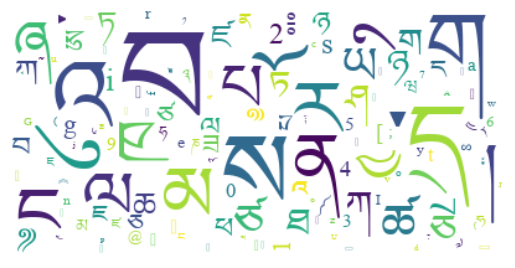

In [ ]:
wordcloud = WordCloud(background_color="white", 
                      font_path='font/himalaya.ttf',
                      max_words=1000, contour_width=3, 
                      contour_color='steelblue')
A_plot = wordcloud.generate_from_frequencies(frequencies=A)
plt.figure()
plt.imshow(A_plot, interpolation="bilinear")
plt.axis("off")
plt.show()

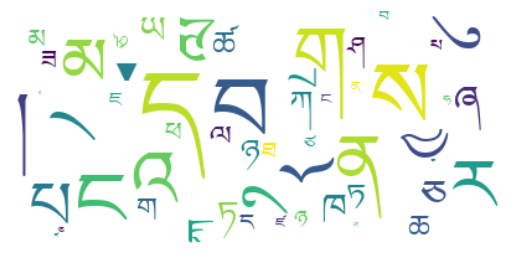

In [ ]:
B_plot = wordcloud.generate_from_frequencies(frequencies=B)
plt.figure()
plt.imshow(B_plot, interpolation="bilinear")
plt.axis("off")
plt.show()

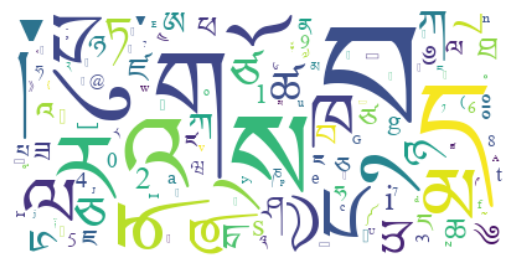

In [ ]:
C_plot = wordcloud.generate_from_frequencies(frequencies=C)
plt.figure()
plt.imshow(C_plot, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
s_pred_list = []
s_org_list = []
for k in range(100):
  sent_data = df.reset_index().loc[k]
  sent = sent_data.noisy_text
  sent_true = sent_data.true_text
  sent_true = sent_true.replace(' ', '')
  print('Original Noisy Sentence: ', sent)

  src = torch.LongTensor([[SRC.vocab.stoi[w] for w in sent]])
  src = Variable(src).to(device)
  src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2).to(device)
  out, prob_list = greedy_decode(model, src, src_mask, 
                      max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS, start_symbol=TRG.vocab.stoi["<s>"])
  print("Translation:", end="\t")
  pred = ""
  for i in range(1, out.size(1)):
      sym = TRG.vocab.itos[out[0, i]]
      if sym == "</s>": break
      pred += sym
  print(pred)
  print("Ground Truth Sentence: ", sent_true)

  mb_pred = ed.matching_blocks(ed.editops(pred, sent_true), pred, sent_true)
  mb_org = ed.matching_blocks(ed.editops(sent, sent_true), sent, sent_true)
  matched_org = ''.join([sent[x[0]:x[0]+x[2]] for x in mb_org])
  org_len = max([len(sent_true), len(sent)])
  s_org = len(matched_org)/org_len
  s_org_list.append(s_org)
  #print(f'matched original token in true token: \n{matched_org}')
  print(f'score before correction: {s_org:.4f}')

  matched_pred = ''.join([pred[x[0]:x[0]+x[2]] for x in mb_pred])
  s_pred = len(matched_pred)/len(sent_true)
  s_pred_list.append(s_pred)
  #print(f'matched pred token in true token: \n{matched_pred}')
  print(f'score after correction: {s_pred:.4}')

print(f'score before correction: {np.mean(s_org_list):.4}')
print(f'score after correction: {np.mean(s_pred_list):.4}')

Original Noisy Sentence:  ངོagjའདུལ་བ་ཀ་བཞུགས་སོ།།
Translation:	འདུལ་བ་ཀ་བཞུགས་སོ།།
Ground Truth Sentence:  ༄༅།།འདུལ་བ་ཀ་བཞུགས་སོ།།
score before correction: 0.7917
score after correction: 0.8261
Original Noisy Sentence:  ཡུལཨངགཙམརལམ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ།།དེས་དུས་གཞན་ཞིགན་ཨང་གའིརྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེབའགྱུར་ན།དེས་རང་གི་ཚོགས་ཡན་ལག་བཞིབ་གླང་པོ་ཆེས་ཚོགསདང་།པའིཚོགས་དང༌།ཤིང་ཏམའིཚོགས་དབ།དབངཆུད་ཚོགས་གོ་བསོན་ཏེ།ཡུམམ་གཏྟགཞོམ་པརབཙགསཔ་བམགདན་སྤྱ
Translation:	ཡུལ་ཨང་གཙང་མར་ལམ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ།།དེས་དུས་གཞན་ཞིག་ན་ཨང་གའི་རྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེ་བར་གྱུར་ན།དེས་རང་གི་ཚོགས་ཡན་ལག་བཞི་པ་གླང་པོ་ཆེ་སྣ་ཚོགས་དང་།པདྨའི་ཚོགས་དང་།ཤིང་ཏ་མའི་ཚོགས་དང་།དབང་ཆུད་ཚོགས་གོ་བསྟན་ཏེ།ཡུམ་མ་ག་དྷཱ་གཞོམ་པར་བཙགས་པ་བསམ་གཏན་གྱི་སྤྱ
Ground Truth Sentence:  ཡུལ་ཨང་ག་ཙམ་པ་མ་གཏོགས་པ་བཅོམ་ནས་ཕྱིར་ལྡོག་པར་བྱེད་དོ།།དེ་ནས་དུས་གཞན་ཞིག་ན་ཨང་གའི་རྒྱལ་པོ་དཔུང་དང་མཐུ་ཆེ་བར་གྱུར་ནས།དེས་དཔུང་གི་ཚོགས་ཡན་ལག་བཞི་པ་གླང་པོ་ཆེ་པའི་ཚོགས་དང་།རྟ་པའི་ཚོགས་དང་།ཤིང་རྟ་པའི་ཚོགས་དང་།དཔུང་བུ་ཆུང་གི་ཚོགས་གོ་བསྐོན་ཏེ།ཡུལ་མ་ག་དྷཱ་ག

Translation:	་བྱང་ཕྱོགས་ན་ཚིག་རྩུབ་བོ།།ཞེས་ཚིགས་སུ་བཅད་པ་ཡང་སྨྲས་སོ།།དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་ཡུལ་དབུས་ཅི་འདྲ།ཤེས་ལྡན་དག་ཡུལ་དབུས་ནི་ཡུལ་རྣམས་ཀྱི་མཆོག་ཡིན་ཏེ།སཱ་ལུ་དང་།བུ་རམ་ཤིང་དང་།ཕྲེང་བ་དང་།ལང་དང་།མ་ཧེ་ཕུན་སུམ
Ground Truth Sentence:  ློ་ཅན་གནས་པ་སྟེ།།ལྷོ་ཕྱོགས་ན་ནི་གཡོན་བྱེད་འདུག།ནུབ་ཀྱི་ཡུལ་ན་ཕྲ་མ་ཅན།།བྱང་ཕྱོགས་ན་ནི་ཚིག་རྩུབ་བོ།།ཞེས་ཚིགས་སུ་བཅད་པ་ཡང་སྨྲས་སོ།།དེ་ནས་དྲིས་པ།བྲམ་ཟེའི་ཁྱེའུ་ཡུལ་དབུས་ཅི་འདྲ།ཤེས་ལྡན་དག་ཡུལ་དབུས་ནི་ཡུལ་རྣམས་ཀྱི་མཆོག་ཡིན་ཏེ།སཱ་ལུ་དང་།བུ་རམ་ཤིང་གི་ཕྲེང་བ་དང་།བ་ལང་དང་།མ་ཧེ་ཕུན་སུམ
score before correction: 0.7382
score after correction: 0.6982
Original Noisy Sentence:  isའཕགས་པ་དང་།དེས་རྒོལ་བ་ཁཅིག་ནི་ཚར་བཅད་དེ་རྒོལ་བའི་ཤིང་རྟལ་སྦྱོར་བར་བྱེད།ཁཅིགཞི་མགོར་ཐལ་བའི་བུམ་པ་དག་གིས་བསྟན།ཁཅིགནི་འཁོང་གི་དཔོངསརལཱ་བཞིན་དུ་ཐགརིང་པོ་ནས་ཡོངས་སུ་སྤོང་བ་བྱེད།ན་དུ་ཐགརིང་པོ་ནསཡོངས་སུ་མྱོང་བར་བྱེད།ཁཅིགནི་གདུགསདང་།རྒྱལདང༌།བ་དན་དག་གིས་བསུ་བར་བྱེད།ཁ་ཅིག་ནི་སློབམཉིད་དུ་ཁས་ལེན་པར་བྱེད་ཅིང་དེ་མཐར་གྱིས་གྲོང་དང་།གྲོ་ཕྱིར་དང་།གྲོང་རྡལ་དང་།དབུཚོགས་དང་།ཚོད་འདག་ཏུ་རྒོལ་བའདུལ་ཞིང་རྒྱལ་པོའི་ཁབ་ཏུ་ཕྱ

Translation:	ཀྱིས་སྨྲས་པ།བླུན་པོ་ཁྱོད་ཅི་ཤེས་ཞེས་དེ་གཉིས་ཀྱིས་ཡིན་པར་བྱས་ཏེ་གང་བྲམ་ཟེ་ཐེ་ཙོམ་ལྟར་རྒྱལ་ཆུང་མའི་དོན་དུ་བྱིན་ནོ།།དེས་དེ་ཡལ་གྱི་འབྱོར་པ་ཆེན་པོས་བག་མར་བླངས་སོ།།བྲམ་ཟེའི་ཁྱེའུ་སྟོང་རིས་ཀྱིས་བསམས་པ།འདི་དག་གིས་བདག་བརྙས་པ།རྒྱལ་པོ་རྒྱུ་གདམས་ནས་
Ground Truth Sentence:  ཀྱིས་སྨྲས་པ།བླུན་པོ་ཁྱོད་ཅི་ཤེས་ཞེས་དེ་གཉིས་ཀྱིས་དེའི་ཚིག་ཚིག་མ་ཡིན་པར་བྱས་ཏེ་ཤཱ་རི་ཀཱ་བྲམ་ཟེ་སྐར་རྒྱལ་ལ་ཆུང་མའི་དོན་དུ་བྱིན་ནོ།།དེས་དེ་དཔལ་གྱི་འབྱོར་པ་ཆེན་པོས་བག་མར་བླངས་སོ།།བྲམ་ཟེའི་ཁྱེའུ་སྟོད་རིངས་ཀྱིས་བསམས་པ།འདི་དག་གིས་བདག་བརྙས་པར་གྱུར་པ་གང་ཡིན་པ་དེ་ཐམས་ཅད་ནི་ཐོས་
score before correction: 0.7425
score after correction: 0.7836
Original Noisy Sentence:  འ་ལམ་ཁྱེའུའི་མིངཅིར་གདགསཞེས་བསམསན།བྲམཟེའི་ཁྱེའུའདི་བྲམ་ཟེ་སར་རྒྱལགྱི་བུ་ཡིནཔས།བྲམ་ཟེའི་ཁྱེའུའདིའིམིང་རྐྱལ་དུ་གདགཡསོ་སྙམནས་དེའི་མིང་སོ་སྙམནས་དེའིམིང་ཉེ་རྒྱལ་ཞེསཟབཏགསསོ།།བྲམ་ཟེསར་རྒྱལ་གྱིས་སྐྱས་པ།མེས་པོས་བྲམ་ཟེའི་ཁྱེའུའaམིཅིརབཏགསཏེ་རྒྱལ་ཞེས་བྱ་བར་བཏགས་སོ།།དེས་བསམསལ།མེས་པོས་བྲམ་ཟེའི་ཁྱེའུ
Translation:	་བྱེད་པ་དེ་དག་གིས་བྲམ་ཟེའི་ཁྱེའུ་འདི་ལ་མིང་ཅིར་གདགས་ཞེས་བསམས་ན།བྲམ་

Translation:	བྲམ་ཟེའི་ཁྱེའུ་དུང་དུ་ངག་ཡིན་པ་དེ་ནི་ཡོད་ཀུན་གྱི་ཕ་རོལ་ན་མངོན་པར་དམིགས་སོ།།མདོག་དབང་པོའི་རྣམ་པ་དག་རྣམ་པར་ཤེས་པར་མི་ནུས་སོ།།བྲམ་ཟེའི་ཁྱེའུ་དག་གོར་མ་ཆག་པར་མི་ནུས་སོ།།དེ་དག་གིས་སྐབས་དེ་རྒྱས་པར་བརྗོད་པ་དང་དེས་བ
Ground Truth Sentence:  བསམ་པ་ནང་ན་ཡོད་པ་ཀུན།།ཕྱི་རོལ་ནས་ནི་ཉེ་བར་དམིགས།།སྐད་མདོག་དབང་པོའི་རྣམ་པ་དག།རྣམ་པར་སྦ་བར་མི་ནུས་སོ།།བྲམ་ཟེའི་ཁྱེའུ་དག་གོར་མ་ཆག་པར་ཅི་ཞིག་ཉེས་སོ།།དེ་དག་གིས་སྐབས་དེ་རྒྱས་པར་བརྗོད་པ་དང་དེས་སྨྲས་པ།བ
score before correction: 0.7474
score after correction: 0.799
Original Noisy Sentence:  36སགྲོངཤི་ཐགསཙནངུམཚིའཚོལ་ཕལོ།ཞིག་གི་ཕྱིར་བྲམ་ཟེམདུནན་འདོན་གྲུ་འཛིན་ཅེས་བགྱི་བ་ཞིག་མཆིས་པ་དེའི་བུ་བྲམཟེའི་ཁྱེའུ་བ་ནས་སྐྱེས་ཞེས་བགྱི་བདེ་བསུ་བའི་སྨདདུའོ།བུ་དེ་ཁྱོད་པསཆེས་ཤེས་རབ་ཅ་ཞིག་ཡིན་ནམ་ཅི།ཡང་དེ་ནི་བདག་པས་ཆེས་ཤེས་རབ་ཙནམ་ལགས་ཏེ།འདི་ལྟར་དེ་ལྟརདོ་ཆེས་ཕྱུག་པ་ལགས་སོ།།དེསཚིགས་སུ་བཅད་པསྐྱས་བ།མི་ག་ངརིགས་ཀྱིས་རྒནཔ་དང༌།ན་ཚོད་རྒན་དང་ནོར་གྱིས་རྒན།དེ་ཀུན་ཐོས་པས་རྒན་བ་ཡི།
Translation:	གྲོང་ཤིང་ཐགས་ཅན་དུ་མཆི་འཚོ་ལ་ཕ་རོལ་ཞིག་གི་ཕྱིར་བྲམ་ཟེ་མདུན་ན་འདོན་གྲུ་འཛིན་ཅེས་བགྱི་བ་ཞིག་མཆིས་པ་

Translation:	ལགས་པ།ཡབ་ཡུམ་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་དགའ་མཆིས།དེ་གཉིས་ཀྱིས་སྨྲས་པ།བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་དབེན་པ་འདི་དག་ལ་བསམ་ནས་མལ་དཀོན་པར་སོང་སྟེ།བྲམ་ཟེའི་ཁྱེའུ་ལྔ་བརྒྱ་ཙམ་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་གྱི་ཚིག་དག་ཀློག་ཏུ་འཇུག་གོ།བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་པའི་ཁྱེའུ་ཉེ་རྒྱལ་ག་ལ་སོང་སྟེ་སྨྲས་པ།ཉེ་རྒྱལ་ཆུ་ཤོག་བདག་ཅག
Ground Truth Sentence:  པ།ཡབ་ཡུམ་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་གར་མཆིས།དེ་གཉིས་ཀྱིས་སྨྲས་པ།བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་དབེན་པ་ལ་དགའ་བས་གནས་མལ་དགོན་པར་སོང་སྟེ།བྲམ་ཟེའི་ཁྱེའུ་ལྔ་བརྒྱ་ཙམ་བྲམ་ཟེའི་གསང་ཚིག་དག་ཀློག་ཏུ་འཇུག་གོ།།བྲམ་ཟེའི་ཁྱེའུ་པང་ནས་སྐྱེས་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་ག་ལ་བ་དེར་སོང་སྟེ་ཕྱིན་ནས་སྨྲས་པ།ཉེ་རྒྱལ་ཚུར་ཤོག་བདག་ཅག
score before correction: 0.7793
score after correction: 0.8931
Original Noisy Sentence:  དང་།གནས་ཤིངཕྲ་བལིནོ།།འདི་ལྟརཚེ་དང་ལན་རབསལ་བརྒྱུན་རབ་བྱུང་བར་གྱུར་ཅི་འདི་ལྟའ་ཅི་འདེལྟའཚེད་ལྡནཔ;ཤཱ་རིའི་བུསསྨོནལམའདིསྐད་ཅེས།པཎང་ཕྱུག་པའི་ཁྱིམ་དང་ཡི།དབུལ་པོའི་ཁྱིམ་དུ་མི་སྐྱེ་བར།།བར་མའིཁྱིམ་དུ་རྫོའགྱུ་ཞིག།རྟག་ཏུབ་བྱུང་མང་བར་ཤོག
Translation:	དང་།གནས་ཤིང་ཕྲ་བ་ཡིན་ནོ།།འདི་ལྟར་ཚེ་དང་ལྡན་པ་ཤཱ་རིའི་

Translation:	པར་འདུལ་བ་ནོ་ཞེས་བྲི་བ་དྲིས་པའི་ལན་འདེབས་པར་བྱེད་དོ།།འཇིག་རྟེན་ཕ་རོལ་གཞན་མ་ཡིན་པ་ཉིད་དང་གཞན་མ་ཡིན་པ་ཉིད་མ་ཡིན་པ་ཡིན་ནམ་ཞེས་བྱ་བ་འདི་ནི།དེ་ལ་ཁོ་བོ་འཇིག་རྟེན་ཕ་རོལ་གཞན་མ་ཡིན་པ་ཉིད་དང་།གཞན་མ་ཡིན་པ་ཉིད་མ་ཡིན་པ་ཡིན་ནོ་ཞེས་བྱ་བ་འདི་ནི།འཇིག་རྟེན་ཕ་རོལ་དེ་ཉིད་དང་དེ་ཉིད་མ་ཡིན་པ་ཡིན་ནམ་ཞེས་དྲི་བ་འདྲི།དེ་ལ་ཁོ་བོ་འཇིག་རྟེན་ཕ་རོལ་དེ་ཉིད་དང་ཉིད་མ་ཡིན་པ་ཡིན་ནོ་ཞེས
Ground Truth Sentence:  པ་ཡིན་ནོ་ཞེས་དྲི་བ་དྲིས་པའི་ལན་འདེབས་པར་བྱེད་དོ།།འཇིག་རྟེན་ཕ་རོལ་གཞན་མ་ཡིན་པ་ཉིད་དང་གཞན་མ་ཡིན་པ་ཉིད་མ་ཡིན་པ་ཡིན་ནམ་ཞེས་དྲི་བ་འདྲི་ན།དེ་ལ་ཁོ་བོ་འཇིག་རྟེན་ཕ་རོལ་གཞན་མ་ཡིན་པ་ཉིད་དང་།གཞན་མ་ཡིན་པ་ཉིད་མ་ཡིན་པ་ཡིན་ནོ་ཞེས་དྲི་བ་དྲིས་པའི་ལན་འདེབས་པར་བྱེད་དོ།།འཇིག་རྟེན་ཕ་རོལ་དེ་ཉིད་དང་དེ་ཉིད་མ་ཡིན་པ་ཡིན་ནམ་ཞེས་དྲི་བ་འདྲི་ན།དེ་ལ་ཁོ་བོ་འཇིག་རྟེན་ཕ་རོལ་དེ་ཉིད་དང་དེ་ཉིད་མ་ཡིན་པ་ཡིན་ནོ་ཞེས
score before correction: 0.8196
score after correction: 0.8886
Original Noisy Sentence:  དྲི་བདྲིས་པའི་ལན་འདེབས་པར་བྱེད་དོ།།དེ་ནས་བྲམ་ཟེའི་ཁྱེའུ་ཉེ་རྒྱལ་དང་མང་ནས་སྐྱེས་གཉིས་འདིསྙམ་དུ་སེམས་ཏེ།སྟོནཤེསའདིཡངལམ་གོལབཞུགས་པ།ལམ་ངནབལེགས་པར་སྒ

Translation:	ནགས་སུ་གཤེགས་ནས་ལོ་དྲུག་དཀའ་བ་སྤྱད་དེ་དགེ་བ་བྱེད་པ་ཅི་ཡང་མེད་པར་རིགས་ཅི་བདེར་དབུགས་རྔུབ་པར་མཛད།ཅི་བདེར་དབུགས་འབྱིན་པར་མཛད་ཅིང་འབྲས་ཆན་དང་ཐ་ན་དོན་ལ་སོགས་པ་ཞལ་ཟས་རྒྱ་ཆེན་པོ་དག་ཀྱང་གསོལ་བར་མཛད།ཅི་དང་།དེ་དག་གིས་སྐུད་མཛད།ས་ཀྱང་སུ་བསིལ་བར་མཛད་ཅིང་གྲོང་སྡེ་འདོད་དུ་གཤེགས་ནས་གྲོང་པའི་བུ་མོ་དགའ་མོ་དང་།
Ground Truth Sentence:  ་ནས་མཚན་མོ་ནམ་ཕྱེད་ན།ནགས་སུ་གཤེགས་ནས་ལོ་དྲུག་ཏུ་དཀའ་བ་སྤྱད་དེ་དཀའ་བ་བྱེད་པ་ཅི་ཡང་མེད་པར་རིག་ནས་ཅི་བདེར་དབུགས་རྔུབ་པར་མཛད།ཅི་བདེར་དབུགས་འབྱིན་པར་མཛད་ཅིང་འབྲས་ཆན་དང་ཟན་དྲོན་ལ་སོགས་པ་ཞལ་ཟས་རྒྱ་ཆེན་པོ་དག་ཀྱང་གསོལ་བར་མཛད།ཞུན་མར་དང་།འབྲུ་མར་དག་གིས་སྐུ་དག་ཀྱང་སྐུད་པར་མཛད།ཆུ་དྲོན་པོས་ཀྱང་སྐུ་བསིལ་བར་མཛད་ཅིང་གྲོང་སྡེ་འདོད་དུ་གཤེགས་ནས་གྲོང་པའི་བུ་མོ་དགའ་མོ་དང་།
score before correction: 0.7450
score after correction: 0.8074
Original Noisy Sentence:  ༄༅བཞིནཙི་ཤིནཛེསསུ་མི་འབྲང་ངོ༌།།དེགཉིས་ཕྱིར་བྱུང་སྟེ་བལྟས།ཇིཙམན་སེམས་ཅན་གཅིག་ཀྱང་ཕྱི་བཞིན་ཕྱིབཞིན་རྗེསསུམི་འབྲང་བར་མཐོང་ས་དེ་གཉིས་ཀྱིས་བསམས་པ།བདག་ཅག་གཉིསསྔོན་དཡུལདུའདོ་བ་ནསློབ་མ་ཆགས་འབུམ་གདུ་མ་དགཕྱིབཞིན་ཕྱིབཞིན་རྗེས་སུ་འབྲང་བའག

Translation:	ཏེ།སླར་སྨྲ་བ་སྨྲ་ཞག་བདུན་སྐྱེ་བ་ཙམ་དང་།ལག་པ་ན་ཁྱུང་བཟེད་དང་།བྱ་མ་བུམ་ཐོགས་པ་དང་།དགེ་སློང་བསྙེན་པར་རྫོགས་ནས་ལམ་ལ་ལོན་པའི་སྤྱོད་ལམ་ལྟ་བུར་གནས་པར་གྱུར་ཏོ།།ཡང་སྨྲས་པ།དེ་བཞིན་གཤེགས་པས་ཚུར་ཤོག་བཀའ་སྩལ་པས།།སྒྲ་ས
Ground Truth Sentence:  ཏེ།སྐྲ་དང་ཁ་སྤུ་ཞག་བདུན་སྐྱེས་པ་ཙམ་དང་།ལག་པ་ན་ལྷུང་བཟེད་དང་།བྱ་མ་བུམ་ཐོགས་པ་དང་།དགེ་སློང་བསྙེན་པར་རྫོགས་ནས་ལོ་བརྒྱ་ལོན་པའི་སྤྱོད་ལམ་ལྟ་བུར་གནས་པར་གྱུར་ཏོ།།ཡང་སྨྲས་པ།དེ་བཞིན་གཤེགས་པས་ཚུར་ཤོག་བཀའ་སྩལ་པས།།སྐྲ་བྱི་ས
score before correction: 0.7962
score after correction: 0.9005
Original Noisy Sentence:  དསློབསབཞིན་གྱི་གཟུགསཝས་ངོ་ཤེསཞསསྦས་པ།ཤེས་ལྡན་ཁྱོད་སྟོད་རིངས་ཡིན་ནམ།།ཁོ་བོ་སྐྱེ་བོདག་གིས་དེ་ལྟར་ཤེས་སོ།།བྲམ་ཟེགནས་ལེན་གྱི་བུ་དེབ་རེ།དུསལ་བབ་བོ།།དེའི་རྒྱུ་མདེག་རེ།དེ་ཡང་དུས་ལ་བབ་བོ།།བུམཟེར་རྒྱལ་གརེ།དེ་ཡང་ས་འབབགོ།ཤཱརིགགཡེདེཡད་དུས་ལ་བབ་བོ།།ཤཱཔའིཤེ
Translation:	སློབ་མ་བཞིན་གྱི་གཟུགས་ལས་ངོ་ཤེས་ནས་སྨྲས་པ།ཤེས་ལྡན་ཁྱོད་སྟོང་རིངས་ཡིན་ནམ།།ཁོ་བོ་སྐྱེ་བོ་དག་གིས་དེ་ལྟར་ཤེས་སོ།།བྲམ་ཟེ་གནས་ལེན་གྱི་བུ་དེ་བ་རེ།དུས་ལ་བབ་བོ།།དེའི་རྒྱུ་མ་དེ་གང་།དེ་ཡང་དུས་ལ་བབ་བོ།།བྲམ་ཟེར་རྒ

Translation:	གཏོད་པར་བྱེད་པ་ཡིན་པས།རྒྱལ་བུ་དེ་ཤིང་ལྗོན་པ་རྩ་བ་ནས་བཅད་པ་བཞིན་དུ་རང་སངས་རྒྱས་དེའི་ནང་དུ་གཉིས་ལ་གཏུགས་ནས་སྨྲས་པ།འཕགས་པ་ཁྱོད་ཀྱི་ཡོན་ཏན་གྱི་ཚོགས་འདི་ལྟ་བུ་བསྙེས་སམ།ཐོབ་བོ།།དེས་བསམས་པ།འཕགས་པ་འདིས་ཡོན་ཏན་གྱི་ཚོགས་གང་ཅུང་ཟད་ཐོས་པ་གང་ཡིན་པ་དེ་ནི་ཐམས་ཅད་བདག་ལ་བརྟེན་ནས་ཐོབ་པ་ཡིན་ན།འཕགས་པ་འདིས་སྔོན་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་དེ་ལྟ་བུར་སྐྱེས་པ་ཡིན་ནོ།།བདག་གིས་རབ་ཏུ་འབྱུང་བ་མ་ཡིན་ནོ་སྙམ་ནས།
Ground Truth Sentence:  ནི་རྫུ་འཕྲུལ་ལ་མྱུར་དུ་སེམས་གཏོད་པར་བྱེད་པ་ཡིན་པས།རྒྱལ་བུ་དེ་ཤིང་ལྗོན་པ་རྩ་བ་ནས་བཅད་པ་བཞིན་དུ་རང་སངས་རྒྱས་དེའི་རྐང་པ་གཉིས་ལ་གཏུགས་ནས་སྨྲས་པ།འཕགས་པ་ཁྱོད་ཀྱི་ཡོན་ཏན་གྱི་ཚོགས་འདི་ལྟ་བུ་བརྙེས་སམ།ཐོབ་བོ།།དེས་བསམས་པ།འཕགས་པ་འདིས་ཡོན་ཏན་གྱི་ཚོགས་གང་ཅུང་ཟད་ཐོབ་པ་གང་ཡིན་པ་དེ་ཐམས་ཅད་བདག་ལ་བརྟེན་ནས་ཐོབ་པ་ཡིན་ན།འཕགས་པ་འདིས་སྔོན་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་དེ་ལྟ་བུར་སྐྱེས་པ་ཡིན་ལ།བདག་གིས་རབ་ཏུ་འབྱུང་བ་མ་ཐོབ་པ་གང་ཡིན་པ་དེ་ནི་ཁྱིམ་འདི་ལྟ་བུར་སྐྱེས་པ་ཡིན་ནོ་སྙམ་ནས།
score before correction: 0.7790
score after correction: 0.8305
Original Noisy Sentence:  rསཀྱིས་ཤ

Translation:	འགྲོ་བ་དཔོན་གང་ཞེ་ན།གང་ཞེ་ན།གང་ཞེ་ན།གང་ཞེ་ན།མིག་ལས་ཚིག་བཞི་པའི་ཚིགས་སུ་བཅད་པ་ཙམ་ཡང་ལན་གསུམ་དུ་བཟླས་ཏེ་བཟུང་བ་ཡིན་ནོ།།མཁན་པོ་གཉིས་གང་ཞེ་ན།རབ་ཏུ་འབྱིན་པར་བྱེད་པ་གང་ཡིན་པ་དང་།བསྙེན་པར་རྫོགས་པར་བྱེད་པ་གང་ཡིན་པའོ།།བཅོམ་ལྡན་འདས་དང་སློབ་དཔོན་དག
Ground Truth Sentence:  ཀློག་པའི་སློབ་དཔོན་གང་ཞེ་ན།གང་ལས་ཚིག་བཞི་པའི་ཚིགས་སུ་བཅད་པ་ཙམ་ཡང་ལན་གསུམ་དུ་བཟླས་ཏེ་བཟུང་བ་ཡིན་ནོ།།མཁན་པོ་གཉིས་གང་ཞེ་ན།རབ་ཏུ་འབྱིན་པར་བྱེད་པ་གང་ཡིན་པ་དང་།བསྙེན་པར་རྫོགས་པར་བྱེད་པ་གང་ཡིན་པའོ།།བཅོམ་ལྡན་འདས་ཀྱིས་མཁན་པོ་དང་སློབ་དཔོན་དག
score before correction: 0.8312
score after correction: 0.8918
Original Noisy Sentence:  གས་རབ་ཏུ་བྱུང་བསང་བྱ་ཞིང་བསྙེན་པར་རྫོགས་པར་བྱ་ཞེས་བཀའསྩལནས།དགེ་སློང་རྣམས་ཀྱིས་ཇི་ལྟར་རབ་ཏུ་དབྱུང་བར་བྱ་བ་དང་།ཇི་ལྟར་བསྙེན་པར་རྫོགས་པར་བྱུ་པམི་ཤེསནས་བཅོམ་ལྡན་འདས་ཀྱིས་དཀྱིཆོསརྣམས་དྲིས་ནས་གཟུང་བར་བྱའོ།བཟུང་ནས་བབས་སུ་འགྲོ་དང་།དགེ་བསྙེནཉིད་དུ་ཁས་བླངས་པས་དགེ་བསྙེནགྱི་སྡོམ་པ་སྦྱིན་པར་བྱའོ།།འདི་ལྟར་སྨིན་པར་བྱ་སྟེ།
Translation:	་བྱ་ཞིང་བསྙེན་པར་རྫོགས་པར་བྱ་ཞེས་བཀའ་སྩལ་ནས།དགེ་སློང་རྣམས་ཀྱིས་ཇི་ལྟར་རབ་ཏུ་དབྱུང་

Translation:	་དང་།གླགས་དང་།གླགས་དང་།གླགས་དང་།ཉུག་པ་དང་།རྒྱན་དང་ཁ་དོག་འཆང་བ་དང་།ཁྲི་སྟན་མཐོན་པོ་དང་།ཁྲི་སྟན་ཆེན་པོ་དང་།དུས་མ་ཡིན་པའི་ཟས་དང་།གསེར་དངུལ་ལེན་པ་སྤངས་ཏེ།གསེར་དངུལ་ལེན་པ་ལས་སླར་ལོག་པ་དེ་བཞིན་དུ།བདག་མིང་འདི་ཞེས་བགྱི་བས་ཀྱང་དུས་འདི་ནས་བཟུང་སྟེ་ཇི་སྲིད་འཚོའི་བར་དུ་མ་བྱིན་པར་ལེན་པ་དང་།མི་ཚངས་པར་སྤྱོད་པ་དང་།བརྫུན་དུ་སྨྲ་བ་དང་།འཕྲུལ་ཆེ་ཞིང་དང་བཅས་པའི་རོ་མྱོས་པར་འགྱུར་བ་བག་མེད་པའི་གནས་དང་།གླ་གར་དང་།
Ground Truth Sentence:  །ཕྲེང་བ་དང་།སྤོས་ཉུག་པ་དང་།རྒྱན་དང་ཁ་དོག་འཆང་བ་དང་།ཁྲི་སྟན་མཐོན་པོ་དང་།ཁྲི་སྟན་ཆེན་པོ་དང་།དུས་མ་ཡིན་པའི་ཟས་དང་།གསེར་དངུལ་ལེན་པ་སྤངས་ཏེ།གསེར་དངུལ་ལེན་པ་ལས་སླར་ལོག་པ་དེ་བཞིན་དུ།བདག་མིང་འདི་ཞེས་བགྱི་བས་ཀྱང་དུས་འདི་ནས་བཟུང་སྟེ་ཇི་སྲིད་འཚོའི་བར་དུ་མ་བྱིན་པར་ལེན་པ་དང་།མི་ཚངས་པར་སྤྱོད་པ་དང་།བརྫུན་དུ་སྨྲ་བ་དང་།འབྲུའི་ཆང་དང་བཅོས་པའི་ཆང་མྱོས་པར་འགྱུར་བ་བག་མེད་པའི་གནས་དང་།གླུ་གར་དང་།
score before correction: 0.9067
score after correction: 0.9627
Original Noisy Sentence:  །ཡན་ལག་བཅུ་པ་འདིས་བདག་འཕགས་པ་དགྲ་བཅོམ་བ་དེ་དག་གི་བསླབ་པ་ལ་རྗེས་སུ་སློབ་བོ།།རྗེས་སུ་སྒྲུབ་བོ།རྗེས་སུ་བགྱིད་

Translation:	་བྱའོ།།གལ་ཏེ་མི་ནུས་ཞེས་ཟེར་ན།འོ་ན་སོང་ཤིག་ཅེས་བརྗོད་པར་བྱའོ།།གལ་ཏེ་མི་ནུས་ཞེས་ཟེར་ན།སྤྱོད་སྟོན
Ground Truth Sentence:  བ་མ་ཡིན་ནམ།སྤྲུལ་པ་མ་ཡིན་ནམ།དུད་འགྲོ་མ་ཡིན་ནམ་ཞེས་དྲི་བར་བྱའོ།།དེས་མ་ལགས་ཞེས་བརྗོད་པར་བྱའོ།།ཁྱོད་ལ་ལ་ལའི་བུ་ལོན་མང་ཡང་རུང་ཉུང་ཡང་རུང་ཅུང་ཟད་ཆགས་པ་མེད་དམ།གལ་ཏེ་བུ་ལོན་ཆགས་སོ་ཞེས་ཟེར་ན།ཁྱོད་བསྙེན་པར་རྫོགས་ནས་འཇལ་ནུས་སམ་ཞེས་དྲི་བར་བྱའོ།།གལ་ཏེ་མི་ནུས་ཞེས་ཟེར་ན།འོ་ན་སོང་ཤིག་ཅེས་བརྗོད་པར་བྱའོ།།གལ་ཏེ་བསྙེན་པར་རྫོགས་ནས་འཇལ་ནུས་ཞེས་ཟེར་ན།ཁྱོད་སྔོན
score before correction: 0.7706
score after correction: 0.2647
Original Noisy Sentence:  td3།བྱེདདབབཀྲེས་རབ་དང་།སྐྱཟབ་དགརྐང་བས་དང་།མཚན་བར་རྡོལ་བ་དང་།རིགས་དང་།རིམས་དྲག་བོ་དང་།ཉིན་གཅིག་པ་དང་།ཉིན་གཉིས་པ་དང་།ཉིན་གསུམ་པ་དང་།ཉིན་བཞི་པ་དང་།འདུས་བ་དང་།རིམསཉིན་རེབ་དང༌།རྟགཁའིརིམས་དང་།རིགས་ལྡང་དུབ་བརང་ཤུབོད།གསུདབ་དང་།སྐྱིགས་བུ་དང་།ལུད་པ་དང་།དབུགསམི་བདེབ་ལྟོགབ་དང་།ཡན་ལག་ཏུ་ཟུག་
Translation:	བྱེད་དང་།བཀྲེས་རབ་དང་།སྐྲ་ཟ་བ་དང་།རྐང་པས་དང་།མཚན་བར་རྡོལ་བ་དང་།རིགས་དང་།རིམས་དྲག་པོ་དང་།ཉིན་གཅིག་པ་དང་།ཉིན་གཉིས་པ་དང་།ཉིན་གསུམ་པ་དང་།ཉིན་བཞི་པ་ད

Translation:	པར་འགྱུར་རོ།།འདི་ལྟ་སྟེ་དཔེར་ན་ཤིང་ཏ་ལའི་མགོ་བཅད་ན་སྔོན་པོར་འགྱུར་དུ་མི་རུང་བ།འཕེལ་ཞིང་རྒྱས་པ་དང་ཡངས་པར་འགྱུར་དུ་མི་རུང་བ་བཞིན་ནོ།།བཞི་གང་སྟེ།འདོད་པ་དང་།འདོད་པ་ལ་ཞེན་པ་དང་།འདོད་པ་ལ་འཆུམས་པ་དང་།འགྲོ་བ་དང་།ལྷག་པར་ཞེན་པ་ནི་བཅོམ་ལྡན་འདས་ཀྱིས་རྣམ་གྲངས་དུ་མས་སྨད་དོ།།འདོད་པ་ལ་ལྟོས་
Ground Truth Sentence:  པར་འགྱུར་རོ།།འདི་ལྟ་སྟེ་དཔེར་ན་ཤིང་ཏ་ལའི་མགོ་བཅད་ན་སྔོན་པོར་འགྱུར་དུ་མི་རུང་ལ།འཕེལ་ཞིང་རྒྱས་པ་དང་ཡངས་པར་འགྱུར་དུ་མི་རུང་བ་བཞིན་ནོ།།བཞི་གང་ཞེ་ན།འདོད་པ་དང་།འདོད་པ་ལ་ཞེན་པ་དང་།འདོད་པ་ལ་འཆུམས་པ་དང་།འདོད་པ་ལ་ལྷག་པར་ཞེན་པ་ནི་བཅོམ་ལྡན་འདས་ཀྱིས་རྣམ་གྲངས་དུ་མས་སྨད་དོ།།འདོད་པ་སྤངས་
score before correction: 0.8125
score after correction: 0.9522
score before correction: 0.7995
score after correction: 0.8419


In [ ]:
np.mean(s_pred_list), np.mean(s_org_list)

(0.8419361661411461, 0.7994951229719818)

In [ ]:
mb = ed.matching_blocks(ed.editops(tt_trg_sentences_list[0], pred), tt_trg_sentences_list[0], pred)
idx = range(len(tt_trg_sentences_list[0]))
correct_idx = [idx[x[0]:x[0]+x[2]] for x in mb]
correct_score = np.zeros(len(tt_trg_sentences_list[0]))
for r in correct_idx:
  for num in r:
    correct_score[num] = 1
acc = np.mean(correct_score)
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7333


In [ ]:
true_tokens = tokenizer.encode(tt_trg_sentences_list[0]).tokens

pred_tokens = tokenizer.encode(pred).tokens
pred_attn = [(k, v) for k, v in zip(pred_tokens, prob_list)]

In [ ]:
# to display in ipython notebook
from IPython.display import display, HTML
def colorize(words, color_array, color_code):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap(color_code)
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

print(f'\nNOISY TEXT: {tt_src_sentences_list}')
# color_confi_list = tt_confi_list[0]
# noisy_s = colorize(noisy_tokens, color_confi_list, 'twilight')
# display(HTML(noisy_s))

print('\nMODEL CORRECTED TEXT: ')
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

color_prob_list = 1- np.array(prob_list)
# color_prob_list = softmax(color_prob_list)
pred_s = colorize(pred_tokens, color_prob_list, 'OrRd')
display(HTML(pred_s))

print('\nGROUND TRUTH TEXT: ')
color_correct_score = 1- np.array(correct_score)
pred_s = colorize(tt_trg_sentences_list[0], color_correct_score, 'OrRd')
display(HTML(pred_s))





NOISY TEXT: ['དང༔གནདཔ་དང་།དྲལ་བ་དང༌།དབུག་པ་དང་།གནས་ལཔོའདི་ལྟསྟེ།']

MODEL CORRECTED TEXT: 



GROUND TRUTH TEXT: 


## 18.Compute BLEU Score

In [ ]:
def lookup_words(x, vocab):
    return [vocab.itos[i] for i in x]

def compute_BLEU(model, data_iter):
    bleu_score = []

    model.eval()
    for batch in tqdm(data_iter):
        src = batch.src.transpose(0, 1)[:1]
        trg = batch.trg
        src_mask = (src != SRC.vocab.stoi["<pad>"]).unsqueeze(-2)
        result, _ = greedy_decode(model, src, src_mask,
                               max_len=MAX_SENT_LENGTH_PLUS_SOS_EOS,
                               start_symbol=TRG.vocab.stoi["<s>"])

        # remove <s>
        trg = trg[1:, 0]
        # remove </s> and <pad>
        trg = trg[:torch.where(trg == TRG.vocab.stoi["</s>"])[0][0]]

        pred = " ".join(lookup_words(result.squeeze(0)[1:], vocab=TRG.vocab))
        targ = " ".join(lookup_words(trg, vocab=TRG.vocab))
        print("Pred: ", pred)
        print("Target: ", targ)
        print()
        s = sacrebleu.raw_corpus_bleu([pred], [[targ]], .01).score
        print(f'score: {s}')
        bleu_score.append(s)

    return bleu_score

In [ ]:
BLEU_test_iter = MyIterator(BLEU_test, batch_size=1, device=device,
                       repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                       batch_size_fn=None, train=False)

print("BLEU score: ", np.mean(compute_BLEU(model, BLEU_test_iter)))

  0%|          | 0/500 [00:00<?, ?it/s]

Pred:  འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། །
Target:  ༄ ༅ ། ། འ ད ུ ལ ་ བ ་ ཀ ་ བ ཞ ུ ག ས ་ ས ོ ། །



  0%|          | 1/500 [00:00<01:14,  6.71it/s]

score: 81.0157734932427


  0%|          | 2/500 [00:02<13:41,  1.65s/it]

Pred:  བ ་ བ ྱ ས ། ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ་ བ ས ྒ ོ ་ བ འ ི ་ བ ས ྒ ོ ་ བ ་ མ ི ་ ཁ མ ་ མ ོ ། ། བ ས ྒ ོ ས ་ པ ་ ན ི ་ ད བ ྱ ུ ང ་ བ ་ ས ོ ་ ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ན ་ པ ས ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། བ ས ྡ ོ ས ་ པ ་ ད ང ་ ། མ ི ་ བ ས ྒ ོ ་ བ ་ མ ི ་ ཁ མ ་ མ ོ ། ། བ ས ྒ ོ ས ་ པ ་ ན ི ་ ད བ ྱ ུ ང ་ བ ་ ས ོ ་ ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ན ་ པ ས ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ བ ས ྒ ོ ་ བ ་ མ ི ་ ཁ མ ་ མ ོ ། ། བ ས ྒ ོ ས ་ པ ་ ན ི ་ ད བ ྱ ུ ང ་ བ ་ ས ོ ་ ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ན ་ པ ས ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། ཞ ེ ་ ས ྡ ང ་ ད ང ་ ། མ
Target:  ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ཆ ོ ས ་ 

  1%|          | 3/500 [00:03<09:55,  1.20s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ར བ ས ་ པ ་ ད ང ་ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ར ་ བ ྱ ེ ་ བ འ ི ་ ག ལ ་ ཏ ེ ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ཁ ྲ ི ་ ཤ ོ མ ས ་ ཤ ི ག ། ཚ
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ོ ང ་ ལ ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ཁ ྲ ི ་ ཤ ོ མ ས ་ ཤ ི ག ། ཚ

score: 69.82231275577792


  1%|          | 4/500 [00:04<08:49,  1.07s/it]

Pred:  མ ུ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ བ ཅ ུ ་ ཀ ུ ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ ལ ་ ར མ ་ བ ཅ ས ་ པ འ ི ་ ག ོ ་ ས ླ ོ བ ་ མ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ། ས ྐ ྱ ེ ས ་ པ ་ ད ང ་ ། མ ་ ན ི ང ་ བ ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ འ བ ྱ ུ ང ་ བ ར ་ ག ན ས ་ པ ར ་ མ ་ བ ཅ ས ་ པ ་ ད ེ ་ བ ད ུ ན ་ པ ོ
Target:  ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ ག ཏ ུ མ ་ པ ོ

score: 70.815318863472


  1%|          | 5/500 [00:05<08:20,  1.01s/it]

Pred:  བ ་ ཚ ུ ལ ་ བ ་ ག ཞ ི ། ། བ མ ་ པ ོ ་ ག ས ུ མ ་ པ ། ས ྡ ོ མ ་ ལ ། ཕ ་ ར ོ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ བ ་ ན ། ། བ ྱ ་ བ ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ མ ་ ལ ྡ ང ་ ད ང ་ ། ། ས ྨ ྱ ོ ས ་ པ ་ ག ན ང ་ བ ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ། ད ྲ ན ་ པ ་ བ ྱ ་ བ ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ མ ་ ལ ྡ ང ་ ད ུ ། ། ས ྨ ྱ ོ ས ་ པ ་ ག ན ང ་ བ ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ། ད ྲ ན
Target:  འ ད ུ ལ ་ བ ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ུ ་ ག ས ུ མ ་ པ ། ས ྡ ོ མ ་ ལ ། ར ྒ ྱ ལ ་ པ ོ ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ བ ་ ད ང ་ ། ། བ ྱ ་ བ ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ མ ་ ལ ྡ ང ་ ད ང ་ ། ། ས ྨ ྱ ོ ས ་ པ ་ ག ན ང ་ བ ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ། ད ྲ ན ་ པ ་ བ ཅ ུ ་ པ ོ ་ ད ག ་ ཡ ི ན ་ ན

score: 67.0128572313396


  1%|          | 6/500 [00:06<08:00,  1.03it/s]

Pred:  མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ བ ར ྗ ོ ད ་ བ ྱ འ ོ ། ། ལ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཡ ང ་ བ ད ག ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ཡ ོ ན ་ མ འ ི ་ མ ཚ ན ་ མ འ མ ། མ ཚ ན ་ མ འ མ །
Target:  པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ །

score: 79.98113164143255


  1%|▏         | 7/500 [00:07<07:50,  1.05it/s]

Pred:  ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཟ ུ ང ་ ཤ ི ག ། ས ོ ད ་ ཅ ི ག ། ཚ ི ད ་ ས ྐ ད ་ ཅ ི ག ་ ས ྨ ྲ ས ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ མ ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ འ ཚ ོ ་ བ ་ ད ག ་ ར ྣ ་ ད ག ་ ཤ ི ང ་ ར ྟ ་ ས ྲ ུ ང ་ བ ་ ད ང ་ ། ས ོ ་ ཕ ག ་ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། མ ཚ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ ད ང ་ ། འ ཛ ི ན
Target:  ཤ ཱ ཀ ྱ འ ི ་ ས ྲ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཟ ུ ང ་ ཤ ི ག ། ས ོ ད ་ ཅ ི ག ། ཆ ི ང ས ་ ཤ ི ག ། ས ྤ ྱ ུ ག ས ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ ག ི ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ འ ཚ ོ ་ བ ་ ད ང ་ ། ར ྟ ་ ར ྫ ི ་ ད ང ་ ། ཤ ི ང ་ ར ྟ ་ ས ྲ ུ ང ་ བ ་ ད ང ་ ། ས ོ ་ ཕ ག ་ ས ྐ ྱ ེ ད ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ འ ཛ ི ན

score: 80.33232834911905


  2%|▏         | 8/500 [00:07<07:32,  1.09it/s]

Pred:  ཀ ྱ ི ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ ར ྣ ་ བ ར ་ བ ྱ ་ བ ་ ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ ཞ ི ག ་ ང ས ་ ཞ ུ ་ བ ་ འ ད ི ་ ལ ྟ ་ བ ས ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཞ ུ ་ བ ་ ཞ ུ ས ་ ཤ ི ག ་ ད ང ་ ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ུ ་ བ ་ ལ ུ
Target:  ཀ ྱ ི ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ེ ་ ཞ ི ག ་ ང ས ་ ཞ ུ ་ བ ་ འ ད ི ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ མ ་ བ བ ་ ཀ ྱ ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཞ ུ ་ བ ་ ཞ ུ

score: 76.41726362808379


  2%|▏         | 9/500 [00:08<07:46,  1.05it/s]

Pred:  ས ྟ ོ བ ས ་ མ ཉ མ ་ པ ། བ ར ྩ ོ ན ་ པ ་ མ ཉ མ ་ པ ། མ ི ་ མ ཉ མ ་ པ ་ ད ང ་ ། བ ར ྙ ེ ས ་ པ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ད ང ་ མ ཉ ེ ས ་ པ ར ་ བ ྱ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ ན ོ ། ། ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ཡ ི ན ། ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར
Target:  བ ར ྩ ོ ན ་ པ ་ མ ཉ མ ་ པ ། མ ི ་ མ ཉ མ ་ པ ་ ད ང ་ མ ཉ མ ་ པ ་ བ ར ྙ ེ ས ་ པ འ ི ་ ས ྟ ོ ན ་ པ ་ ང ་ མ ཉ ེ ས ་ པ ར ་ བ ྱ ས ་ ཀ ྱ ི ་ མ ་ མ ཉ ེ ས ་ པ ར ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ས ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ག ཅ ི ག ་ ཏ ུ ་ ག ན ག ་ པ ་ ཡ ི ན ། ག ཅ ི ག ་ ཏ ུ ་ ད ཀ ར

score: 83.29114073007416


  2%|▏         | 10/500 [00:09<07:46,  1.05it/s]

Pred:  བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ས ་ ད ེ ར ་ ག ་ ལ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ོ ་ བ ོ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ན ས ་ ཟ ུ ང ་ ཤ ི ག ་ ད ང ་ ། ཁ ོ ་ བ ོ འ ི ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ འ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ པ ོ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ྲ ྭ ་ ལ ་ འ ཇ ུ ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ འ ད ུ ན
Target:  ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ས ་ ད ེ ་ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ོ ་ བ ོ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ྲ ྭ ་ ན ས ་ ཟ ུ ང ་ ཤ ི ག ་ ད ང ་ ། ཁ ོ ་ བ ོ འ ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ འ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ད ེ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ག ྲ ྭ ་ ལ ་ འ ཇ ུ ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན

score: 85.48569818234988


  2%|▏         | 11/500 [00:11<08:45,  1.07s/it]

Pred:  ན ད ་ ས ེ ར ་ བ འ ི ་ ས ་ ད ང ་ ག ཏ ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ་ ག ང ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ ཏ ོ ། ། ད ེ ་ ད ག ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ་ ག ང ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཞ ི
Target:  ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི

score: 56.58353426554284


  2%|▏         | 12/500 [00:12<08:35,  1.06s/it]

Pred:  ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ྨ ྲ ས ་ པ ་ ད ེ ་ ག ད ོ ན ་ ག ད ོ ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ མ ་ ར ག ་ ལ ་ ཡ ང ་ ལ ག ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཉ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ུ ་ ལ ས ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར
Target:  ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར

score: 78.34286442926401


  3%|▎         | 13/500 [00:13<08:31,  1.05s/it]

Pred:  འ ཆ ག ་ ས ར ་ མ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ི བ ས ་ ས ུ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ས ུ ་ མ ་ བ ྱ ས ་ པ འ མ ། ག ཞ ན ་ ཡ ང ་ ག ན ས ་ མ ལ ་ ར ུ ང ་ བ ་ ག ང ་ ད ག ེ ་ འ ད ུ ན ་ ན མ ་ ག ང ་ ཟ ག ་ ལ ས ་ ར ོ ་ ད ང ་ ། ད ེ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ཚ ོ ད ་ ཟ ི ན ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ཇ ི ག ་ འ ད ུ ན ་ ན མ ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ འ ་ བ འ ོ
Target:  འ ཆ ག ་ ས ར ་ མ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ས ུ ་ བ ྱ ས ་ པ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ས ུ ་ མ ་ བ ྱ ས ་ པ འ མ ། ག ཞ ན ་ ཡ ང ་ ག ན ས ་ མ ལ ་ ར ུ ང ་ བ ་ ག ང ་ ད ག ེ ་ འ ད ུ ན ་ ན མ ་ ག ང ་ ཟ ག ་ ལ ས ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ལ ོ ང ་ ལ ་ ཚ ོ ད ་ ཟ ི ན ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ཇ ི ་ ལ ྟ ར ་ ཁ ྱ ོ ད ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ ད མ ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ ་ འ ཆ འ ོ

score: 81.56040706610209


  3%|▎         | 15/500 [00:14<06:05,  1.33it/s]

Pred:  ས ྟ ར ་ ཡ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ ད ག ་ ག ི ས ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཅ ོ མ ་ མ མ ། ཡ ུ ལ ་ ལ ྗ ོ ང ས ་ བ ཅ ོ མ ་ ན ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ཏ ེ ། བ ་ ལ ང ་ བ ས ་ ད ད ་ ད མ ། མ ཐ ེ འ མ ། ར བ ་ ས ད ་ པ འ ི ་ ཁ ྲ ག ་ ས ་ ཡ ན ་ ལ ག ་ ག ི ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ །
Target:  ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ ད ག ་ ག ི ས ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཅ ོ མ ་ མ མ ། ཡ ུ ལ ་ ལ ྗ ོ ང ས ་ བ ཅ ོ མ ་ ན ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ཏ ེ ། བ ་ ལ ང ་ བ ས ད ་ ད མ ། མ ་ ཧ ེ ་ འ མ ། ར ་ བ ས ད ་ པ འ ི ་ ཁ ྲ ག ་ ག ི ས ་ ཡ ན ་ ལ ག ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ །

score: 81.9688586109121
Pred:  ་ པ འ ི ་ ཕ ྱ ི ར ་ ཕ ུ ལ ་ ལ ས ་ ལ ་
Target:  ད ེ ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ཞ ི ག ་ པ ་ ད ང ་ ག ོ ག ས ་ པ ་ ས ླ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ཕ ུ ལ ་ བ ་ ཅ ུ ང ་ ཟ

  3%|▎         | 16/500 [00:19<16:07,  2.00s/it]

Pred:  ད ག ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ་ ན ་ ད ེ ་ མ ་ ས ྡ ི ག ་ པ འ ི ་ བ ས མ ་ པ ་ ཟ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ་ འ ཁ ོ ད ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ད ུ ག ་ ཟ ོ ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ག ཡ ང ་ ས ར ་ འ ཆ ོ ང ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ་ ཤ ི

  3%|▎         | 17/500 [00:21<16:29,  2.05s/it]

Pred:  མ ཚ ན ་ མ ་ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ མ ། ར ྩ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཕ ྱ ག ་ ར ྒ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག
Target:  མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག

score: 91.78821446608231


  4%|▎         | 18/500 [00:23<15:52,  1.98s/it]

Pred:  ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ་ ར ་ ད ྭ ་ ཏ ི འ ི ་ བ ུ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག འ ་ བ ོ ས ་ བ ཙ ུ ན ་ པ ་ བ ཀ འ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ཞ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ལ ྟ ར ་ མ ཉ ན ་ ན ས ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ད ་ པ ་ ད ག ེ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ ར ྩ ེ ག ས ་ ན ས ་ ལ ག ་ པ ་ ད ང ་ ག ཅ ི ག ་ མ ུ ་ ཁ ྲ ི ་ བ ཤ མ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན
Target:  ལ ག ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ཁ ྲ ི ་ ཤ ོ མ ས ་ ཤ ི ག ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ བ ཙ ུ ན ་ པ ་ བ ཀ འ ་ བ ཞ ི ན ་ འ ཚ ལ ་ ཞ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ལ ྟ ར ་ མ ཉ ན ་ ན ས ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཅ ི ག ་ ཏ ུ ་ ཁ ྲ ི ་ བ ཤ མ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན

score: 70.01025

  4%|▍         | 19/500 [00:24<13:46,  1.72s/it]

Pred:  མ ཁ ས ་ པ ར ་ བ ྱ འ ོ ། ། ཡ ུ ང ས ་ མ ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ད ེ ། ལ ས ་ ར ི མ ་ ཞ ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ ག ུ ལ ་ མ ི ་ ན ུ ས ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ད ོ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ར ང ་ ད ུ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ བ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ མ ད ོ ང ་ ང མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ བ ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ན ང ་ ད ུ
Target:  ཞ ེ ས ་ བ ྱ འ ོ ། ། ལ ུ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ང ག ་ ག ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ བ ུ ལ ་ མ ི ་ ན ུ ས ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ན ང ་ ད ུ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ མ ་ ད ོ ང ་ ང མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ན ང ་ ད ུ

score: 78.23897359133159


  4%|▍         | 20/500 [00:25<12:04,  1.51s/it]

Pred:  ས ྨ ད ་ བ ྱ ར ་ ག ན ས ་ ཀ ྱ ི ་ ག ཞ ི འ ི ་ བ ས ྡ ུ ས ་ པ འ ི ་ ར ྩ ོ མ ་ པ ། ད བ ྱ ར ་ ག ན ས ་ པ ་ ད ང ་ ཟ ས ་ ད ང ་ ། ། ད བ ྱ ར ་ ར མ ་ པ ་ ད ང ་ ལ ྔ ་ པ ོ ་ ད ང ་ ། ། ས ྨ ི ག ་ ད ང ་ ལ ོ ་ མ ་ ས ྙ མ ་ ཚ ི ལ ་ ལ ྷ མ ། ། ད བ ྱ ར ་ ད ང ་ ཀ ོ ་ ལ ་ ག ན ས ་ པ ་ ན ི ་ ད ག ་ ག ོ ། ། ས ྡ ོ མ ་ པ ། ད བ ྱ ར ་ ག ན ས ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ བ ་ ད ང ་ ། ། འ ག ྲ ོ ་ བ ་ ད ག ་ ད ང ་ ན ི
Target:  ག ག ་ ད བ ྱ ེ འ ི ་ ག ཞ ི ་ ར ྫ ོ ག ས ་ ས ྷ ོ ། ། ། ། ད བ ྱ ར ་ ག ན ས ་ ཀ ྱ ི ་ ག ཞ ི འ ི ་ བ ས ྡ ུ ས ་ པ འ ི ་ ས ྡ ོ མ ་ ལ ། ད བ ྱ ར ་ ག ན ས ་ པ ་ ད ང ་ ཟ ས ་ ད ང ་ ན ི ། ། ད བ ྱ ར ་ ར ལ ་ བ ་ ད ང ་ ལ ྔ ་ པ ོ ་ ད ང ་ ། ། ས ྨ ི ག ་ ད ང ་ ལ ོ ་ མ ་ ར ྩ ྭ ་ མ ཆ ི ལ ་ ལ ྷ མ ། ། ད བ ྱ ར ་ ད ང ་ ཀ ོ ་ ལ ྤ ག ས ་ བ ཞ ི ་ ད ག ་ ག ོ ། ། ས ྡ ོ མ ་ ལ ། ད བ ྱ ར ་ ག ན ས ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ བ ་ ད ང ་ ། ། འ ཆ ར ་ ཀ ར ་ འ ག ྲ ོ ་ བ ་ ད ག ་ ད ང ་ ན ི

score: 71.3910251606585


  4%|▍         | 21/500 [00:26<11:03,  1.39s/it]

Pred:  ་ པ ་ ད ང ་ ། ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ས ྐ ྱ ེ ད ་ པ ་ ས ྙ མ ་ ཅ ན ་ ད ག ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ ན ་ མ ོ ་ ཐ ོ ག ་ ཐ ག ་ ཚ ོ ས ་ བ ཤ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྐ ྱ ་ ར ང ས ་ མ ་ ཤ ར ་ བ ར ་ ད ག ་ ག
Target:  ད ར ་ བ ྱ ། ཆ ག ་ ཆ ག ་ བ ྱ ། བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ ་ ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ྙ ེ ད ་ པ ་ ས ྣ ུ མ ་ བ ག ་ ཅ ན ་ ད ག ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ ན ་ མ ོ ་ ཐ ོ ག ་ ཐ ག ་ ཆ ོ ས ་ བ ཤ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ས ྐ ྱ ་ ར ེ ང ས ་ མ ་ ཤ ར ་ བ ར ་ ད ག ག

score: 80.92500757839271


  4%|▍         | 22/500 [00:27<10:06,  1.27s/it]

Pred:  ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན ་ ས ་ ད ེ ་ བ ས ྲ ུ བ ས ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ པ ་ ད ང ་ ། ག ད ུ ག ས ་ ག ཤ ི ས ་ ཟ ེ ར ་ ཞ ེ ས ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ཡ ོ ད ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ོ ན ་ བ ུ ད ་ མ ེ ད ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ་ ད ང ་ ། ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ
Target:  ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན ་ ལ ས ་ ད ེ ་ བ ས ྲ བ ས ་ པ ་ ད ང ་ ། ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ པ ་ ད ང ་ ། ག ཏ ུ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ར ོ ་ ཞ ེ ས ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ག ཞ ན ་ ཞ ི ག ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ན ་ བ ུ ད ་ མ ེ ད ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ་ ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ

score: 80.31956007583265


  5%|▍         | 23/500 [00:28<09:40,  1.22s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ཡ ི ན ་ པ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ག ང ་ ད ུ ་ ས ོ ང ་ ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ
Target:  ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ད ུ ་ ས ོ ང ་ ན ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ

score: 90.09166393620241


  5%|▍         | 24/500 [00:29<09:04,  1.14s/it]

Pred:  མ ་ ཡ ི ན ་ པ ་ ག ང ་ ཞ ེ ་ ན ། བ ཀ ར ་ བ འ ི ་ ག ན ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཕ ྱ ི ས ་ པ ་ ད ག ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཁ ས ་ འ ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན
Target:  ཡ ི ན ་ པ ་ ག ང ་ ཞ ེ ་ ན ། བ ཀ ར ་ བ འ ི ་ ག ན ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཁ ྱ ི མ ་ པ ་ ད ག ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ུ ་ ཁ ས ་ འ ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན

score: 86.56945837808175


  5%|▌         | 25/500 [00:30<08:58,  1.13s/it]

Pred:  བ ར ་ ཞ ི ་ བ ར ་ འ ག ྱ ུ ར ་ བ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ ཇ ུ ག ་ པ ། ། འ ད མ ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། ། འ ཆ ི ་ བ ད ག ་ ས ྡ ེ ་ ན ི ་ ག ཞ ོ མ ་ པ ར ་ བ ྱ ། ། ག ང ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ ག ཡ ོ ད ་ པ ར ་ བ ྱ ། ། ཆ ོ ས ་ འ ད ུ ལ ་ འ ད ི ་ ལ ་ ས ྤ ྱ ོ ད ་ འ ག ྱ ུ ར ་ བ ། ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ བ ར ་ ས ྤ ང ས ་ ན ས ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཐ ་ མ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར །
Target:  པ ར ་ བ ྱ ་ ཞ ི ང ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ས ྟ ན ་ ལ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ། ། འ ད མ ་ བ ུ འ ི ་ ཁ ྱ ི མ ་ ལ ་ ག ླ ང ་ ཆ ེ ན ་ བ ཞ ི ན ། ། འ ཆ ི ་ བ ད ག ་ ས ྡ ེ ་ ན ི ་ ག ཞ ོ མ ་ པ ར ་ བ ྱ ། ། ག ང ་ ཞ ི ག ་ ར བ ་ ཏ ུ ་ བ ག ་ ཡ ོ ད ་ པ ར ། ། ཆ ོ ས ་ འ ད ུ ལ ་ འ ད ི ་ ལ ་ ས ྤ ྱ ོ ད ་ འ ག ྱ ུ ར ་ བ ། ། ས ྐ ྱ ེ ་ བ འ ི ་ འ ཁ ོ ར ་ བ ་ ར བ ་ ས ྤ ང ས ་ ན ས ། ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ ཐ ་ མ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར །

score: 86.96316461608909


  5%|▌         | 26/500 [00:31<08:49,  1.12s/it]

Pred:  ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ེ ་ ར ུ ང ་ བ འ ི ་ ས ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ད ་ པ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ལ ྕ ག ས ་ ད ང ་ ། ས ྐ ུ ག ས ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ་ བ ་ ཁ ོ ་ ར ་ བ ་ ད ང ་ ། མ ི ་ ག ཙ ང ་ བ ས ་ ས ྤ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ ན ི ་ མ ་ ཡ ི ན ་ པ ་ ར ྣ མ ས ་ ཁ ྲ ོ ་ བ ོ ་ ས
Target:  ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ས ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ས ྣ བ ས ་ ད ང ་ ། ས ྐ ྱ ུ ག ས ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ་ བ ་ བ ོ ར ་ བ ་ ད ང ་ ། མ ི ་ ག ཙ ང ་ བ ས ་ ས ྦ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ མ ི ་ མ ་ ཡ ི ན ་ པ ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ན ས

score: 76.49126389862673


  5%|▌         | 27/500 [00:32<08:52,  1.13s/it]

Pred:  པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ས ྒ ྲ ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ བ ཤ མ ་ པ ་ བ ྱ ས ་ ན ས ་ ག ན ྡ ྷ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་
Target:  ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ བ ཤ མ ་ པ ་ བ ྱ ས ་ ན ས ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་

score: 81.97960303693768


  6%|▌         | 28/500 [00:34<08:48,  1.12s/it]

Pred:  མ ཁ ྱ ེ ན ་ ཀ ྱ ང ་ མ ི ་ ས ྲ ི ད ། ད ུ ས ་ ས ུ ་ ད ག ེ ་ ད ུ ས ་ འ ག འ ་ ཡ ོ ལ ་ པ ་ ས ི མ ་ ད ང ་ ། ད ང ་ ལ ྡ ན ་ པ ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ི ་ ས ྨ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ར ྙ ེ ད ་ པ ་ ཕ ྱ ི ས ་ ཟ ླ ོ ག ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན
Target:  ྨ ེ ད ་ པ ། ད ུ ས ་ ས ུ ་ ར ྨ ེ ད ་ པ ། ད ུ ས ་ ལ ས ་ ཡ ོ ལ ་ བ ར ་ མ ི ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ི ་ ར ྨ ེ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ར ྨ ེ ད ་ པ ་ ལ ་ ཆ ུ ་ ལ ོ ན ་ ག ྱ ི ས ་ ཟ ླ ོ ག ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན

score: 76.89892216264414


  6%|▌         | 29/500 [00:35<08:48,  1.12s/it]

Pred:  བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ུ ང ་ ད ུ ་ ང ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཡ ོ ད ་ ཀ ུ ན ་ ག ྱ ི ་ ཕ ་ ར ོ ལ ་ ན ་ མ ང ོ ན ་ པ ར ་ ད མ ི ག ས ་ ས ོ ། ། མ ད ོ ག ་ ད བ ང ་ པ ོ འ ི ་ ར ྣ མ ་ པ ་ ད ག ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ག ་ ག ོ ར ་ མ ་ ཆ ག ་ པ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྐ བ ས ་ ད ེ ་ ར ྒ ྱ ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ ད ེ ས ་ བ
Target:  བ ས མ ་ པ ་ ན ང ་ ན ་ ཡ ོ ད ་ པ ་ ཀ ུ ན ། ། ཕ ྱ ི ་ ར ོ ལ ་ ན ས ་ ན ི ་ ཉ ེ ་ བ ར ་ ད མ ི ག ས ། ། ས ྐ ད ་ མ ད ོ ག ་ ད བ ང ་ པ ོ འ ི ་ ར ྣ མ ་ པ ་ ད ག ། ར ྣ མ ་ པ ར ་ ས ྦ ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ག ་ ག ོ ར ་ མ ་ ཆ ག ་ པ ར ་ ཅ ི ་ ཞ ི ག ་ ཉ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྐ བ ས ་ ད ེ ་ ར ྒ ྱ ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ

score: 70.5539050938537


  6%|▌         | 30/500 [00:36<08:46,  1.12s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྨ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ཛ ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ ཏ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ཟ ན ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས

score: 91.4327952958376


  6%|▌         | 31/500 [00:37<08:46,  1.12s/it]

Pred:  ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ས ་ ཉ ི ་ མ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཟ ན ་ ག ཅ ད ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ག ཉ ི ས ་ ད ང ་ ། ག ས ུ མ ་ ན ས ་ ད ྲ ུ ག ་ ག ི ་ ཟ ན ་ ག ཅ ད ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ་ ཕ ་ མ ་ ག ཉ ི ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ བ ཅ ུ ས ་ ས ྐ ྱ ེ ས ་ ལ
Target:  ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ས ་ ཉ ི ་ མ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཟ ན ་ ག ཅ ད ་ པ ་ བ ྱ ས ་ ས ོ ། ། ག ཉ ི ས ་ ད ང ་ ། ག ས ུ མ ་ ན ས ་ ད ྲ ུ ག ་ ག ི ་ བ ར ་ ད ུ ་ ཡ ང ་ ཟ ན ་ ག ཅ ད ་ པ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ་ ཕ ་ མ ་ ག ཉ ི ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ལ

score: 80.10348392700732


  6%|▋         | 32/500 [00:38<08:55,  1.15s/it]

Pred:  པ ར ་ ག ཞ ག ་ པ ་ འ བ འ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ
Target:  བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ

score: 87.35016336260723


  7%|▋         | 33/500 [00:39<08:48,  1.13s/it]

Pred:  ཏ ེ ། ས ླ ར ་ ས ྨ ྲ ་ བ ་ ས ྨ ྲ ་ ཞ ག ་ བ ད ུ ན ་ ས ྐ ྱ ེ ་ བ ་ ཙ མ ་ ད ང ་ ། ལ ག ་ པ ་ ན ་ ཁ ྱ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ལ མ ་ ལ ་ ལ ོ ན ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཚ ུ ར ་ ཤ ོ ག ་ བ ཀ འ ་ ས ྩ ལ ་ པ ས ། ། ས ྒ ྲ ་ ས
Target:  ཏ ེ ། ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ ཞ ག ་ བ ད ུ ན ་ ས ྐ ྱ ེ ས ་ པ ་ ཙ མ ་ ད ང ་ ། ལ ག ་ པ ་ ན ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ལ ོ ་ བ ར ྒ ྱ ་ ལ ོ ན ་ པ འ ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ལ ྟ ་ བ ུ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཡ ང ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ས ་ ཚ ུ ར ་ ཤ ོ ག ་ བ ཀ འ ་ ས ྩ ལ ་ པ ས ། ། ས ྐ ྲ ་ བ ྱ ི ་ ས

score: 85.80373420822124


  7%|▋         | 34/500 [00:40<08:41,  1.12s/it]

Pred:  མ ་ ད ག ་ ད ང ་ ར ྐ ང ་ ར ྡ ུ ལ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ས ྦ ྲ ུ མ ་ པ ོ ར ་ འ ཇ ུ ས ་ པ ་ ད ང ་ ། ། མ ཆ ུ ་ མ ེ ད ་ ལ ུ ས ་ ལ ་ མ ཚ ན ་ ཅ ན ། ། ར ྒ ན ་ ཆ ེ ས ་ པ ་ ད ང ་ ག ཞ ོ ན ་ ཆ ེ ས ་ ད ང ་ ། ། ཐ ེ ང ་ པ ོ ་ འ ཆ ར ་ ཤ ུ ་ བ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ར ྡ ུ ལ ་ ས ྐ ུ ར ་ མ ི ་ འ ཐ ུ ང ་ ད ང ་ ། ། ལ ཱ ་ བ ་ ལ ྐ ུ ག ས ་ པ ་ འ ོ ན ་ པ ་ ད ང ་ ། ། ར ྟ ེ ན ་ འ ཕ ྱ ེ ད ་ ན ི ་ ར ྐ ང ་ པ ་ འ བ ར ། ། ད ང ་
Target:  ར ྡ ུ མ ་ ད ག ་ ད ང ་ ར ྐ ང ་ ར ྡ ུ མ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ཟ ླ ུ མ ་ པ ོ ར ་ འ ཇ ས ་ པ ་ ད ང ་ ། ། མ ཆ ུ ་ མ ེ ད ་ ལ ུ ས ་ ལ ་ ར ྨ ་ མ ཚ ན ་ ཅ ན ། ། ར ྒ ན ་ ཆ ེ ས ་ པ ་ ད ང ་ ག ཞ ོ ན ་ ཆ ེ ས ་ ད ང ་ ། ། ཐ ེ ང ་ པ ོ ་ ས ྨ ད ་ འ ཆ ར ་ ཞ ར ་ བ ་ ད ང ་ ། ། ལ ག ་ ས ོ ར ་ ར ྡ ུ མ ་ ས ྒ ུ ར ་ མ ི འ ུ ་ ཐ ུ ང ་ ད ང ་ ། ། ལ ྦ ་ བ ་ ལ ྐ ུ ག ས ་ པ ་ འ ོ ན ་ པ ་ ད ང ་ ། ། ར ྟ ེ ན ་ འ ཕ ྱ ེ ་ ད ང ་ ན ི ་ ར ྐ ང ་ འ བ མ ་ ད ང ་

score: 80.43029467409788


  7%|▋         | 35/500 [00:41<08:33,  1.11s/it]

Pred:  ད ང ་ ཁ ྱ ེ འ ུ ་ ལ མ ། ཆ ུ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ད ག ་ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྱ ོ ས ་ ས མ ་ འ ག ྱ ུ ར ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ན ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ི ་
Target:  ཁ ྱ ེ ར ་ ར མ ། ཆ ུ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་

score: 77.5708841731776


  7%|▋         | 36/500 [00:43<08:59,  1.16s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ད ག ་ ག ི ་ ས ླ ོ ང ་ ད ག ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ག ན ས ་ པ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ མ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ག ན ས ་ པ ་ ས ྤ ྱ ད ་ ན ས ་ ས ེ མ ས ་ མ ག ུ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན

score: 85.49508072567029


  7%|▋         | 37/500 [00:44<08:49,  1.14s/it]

Pred:  ད ང ་ ། ཕ ུ ར ་ པ ་ བ ྷ ཱ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ད ུ ལ ་ ཞ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ག ས ུ མ ་ ཞ ི ག ། ལ ས ་ ཁ ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ མ
Target:  ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ ཏ ུ ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ན ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ས ུ ་ ཞ ི ག ། ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ

score: 81.57071308155837


  8%|▊         | 38/500 [00:45<08:52,  1.15s/it]

Pred:  ག ང ་ ད ག ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ད ག ོ ན ་ པ ་ ཐ ུ ག ་ པ ་ ད ང ་ ། ག ན ས ་ ལ ་ ལ ་ ཐ ུ ག ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ཅ ི ང ་ མ ཚ ན ་ ཆ ུ ང ་ ཡ ང
Target:  ག ང ་ ད ག ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ད ག ོ ན ་ པ ་ ལ ་ ཐ ུ ག ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ལ ་ ཐ ུ ག ་ པ འ ི ་ བ ར ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ཅ ི ང ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ཡ ང

score: 82.31722863202735


  8%|▊         | 39/500 [00:46<08:45,  1.14s/it]

Pred:  ད ང ་ བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ས ྐ ྱ ེ ་ བ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ལ ་ ར ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ག ི ་ འ ཛ མ ་ བ ུ ་ ཐ མ ས ་ ཅ ད ་ ལ ་ ས ྔ ོ ན ་ ད ུ ་ འ ག ྲ ོ ་ བ ་ ཡ ི
Target:  ད ང ་ ། བ ཀ ུ ར ་ ས ྟ ི ་ ལ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ པ ། ད བ ང ་ པ ོ ་ ད ང ་ ཉ ེ ་ ད བ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ག ི ་ འ ཕ ྲ ལ ་ ག ྱ ི ་ བ ྱ ་ བ ་ ཐ མ ས ་ ཅ ད ་ ལ ་ ས ྔ ོ ན ་ ད ུ ་ འ ག ྲ ོ ་ བ ་ ཡ ི

score: 83.25724167618999


  8%|▊         | 40/500 [00:47<08:49,  1.15s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ད ག ་ ག ི ་ བ ར ་ བ འ ི ་ ས ་ ད ང ་ ། ར ྙ ི ང ་ ས ྐ ད ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ ་ ད ང ་ ། ལ ྷ ་ མ ི ག ་ ག ི ་ ས ྒ ྲ ་ མ ་ མ ི ག ་ ཀ ྱ ོ ག ་ པ ོ འ ི ་ ར ་ བ ་ ད ང ་ ། ག ཏ ད ་ པ ར ་ བ ད ག ་ ཐ ོ ས ་ ན ། ད ག ེ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ག
Target:  མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ག ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ཀ ྱ ོ ག ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག

score: 74.324965478814


  8%|▊         | 41/500 [00:48<08:54,  1.16s/it]

Pred:  ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ད ང ་ པ ོ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། ཐ ་ མ འ ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཐ མ ས ་ ཅ ད ་ ཡ ི ན ་ ག ྱ ི ་ ད ང ་ པ ོ ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ་ མ ་ ཡ ི ན ་ པ འ མ ་ ལ ྟ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ
Target:  ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ བ ཞ ི ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། ཐ ་ མ འ ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཐ ་ མ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ཐ ་ ལ ྷ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ

score: 89.28045751152625


  8%|▊         | 42/500 [00:50<08:58,  1.18s/it]

Pred:  ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ། ཁ ོ ་ མ ོ ས ་ ག ཉ ེ ན ་ ད ེ ་ ད ག ་ ལ ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ་ ལ ོ ་ ཉ ི ས ་ ས མ ་ ཅ ི ། ། འ ད ི ་ ལ ྟ ་ བ ུ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ང ན ་ པ ་ བ ས ྒ ྱ ུ ར ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ར ་ ག ཟ ི ག ས ་ ན ་ བ ཞ ི ན ་ བ ས ྟ ར ་ ཏ ེ ། ད ེ ་ ལ ྟ ་ ཡ ོ ད ་ ཀ ྱ ི ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྙ ི ང ་ ག ་ འ ོ ང ས ་ ན ས ་ ཁ ་ ཆ ོ ས ་ མ ན འ ་ མ ་ ལ ས
Target:  ་ ན ི ་ ཟ ོ ས ་ ལ ། ང ན ་ པ ་ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ བ ྱ ི ན ་ ན ོ ། ། ཁ ོ ་ མ ོ ས ་ ག ཉ ེ ན ་ ད ེ ་ ད ག ་ ལ ་ ཁ ྱ ེ ད ་ ཅ ག ་ ལ ོ ་ ཉ ེ ས ་ ས མ ་ ཅ ི ། འ ད ི ་ ལ ྟ ་ བ ུ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ང ན ་ པ ་ བ ས ྐ ུ ར ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ང ན ་ པ ་ ན ི ་ མ ་ བ ས ྐ ུ ར ་ ཏ ེ ། ད ེ ་ ལ ྟ ་ མ ོ ད ་ ཀ ྱ ི ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ པ ་ འ ོ ང ས ་ ན ས ་ ཁ ོ ་ མ ོ ས ་ མ ན འ ་ མ ་ ལ ་ ས

score: 73.19095169292699


  9%|▊         | 43/500 [00:51<09:02,  1.19s/it]

Pred:  ག ཞ ོ མ ། ། བ ར ་ འ ཇ ུ ག ་ པ ་ ད ག ་ ལ ་ མ ཁ ས ་ པ ། ས ྟ ོ བ ས ་ བ ཅ ུ འ ི ་ ས ྟ ོ བ ས ་ ད ང ་ ལ ྡ ན ་ པ ། ཕ ྱ ོ ག ས ་ བ ཅ ུ ར ་ ས ྙ ན ་ པ ས ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྨ ྲ ས ་ པ ། བ ར ྒ ྱ ་ ཕ ྲ ག ་ བ ཅ ུ ར ་ ད བ ང ་ ས ྒ ྱ ུ ར ་ བ ་ ལ ས ་ ཀ ྱ ང ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཉ ི ན ་ ལ ན ་ ག ས ུ མ ་ མ ཚ ན ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ག ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ བ ར ་ ག ཟ ི ག ས ་ ན ས ། ག ཞ ན ་ ཉ མ ས ་ པ ར ་ ག ྱ ུ
Target:  པ ར ་ འ ཇ ུ ག ་ པ ་ ད ག ུ ་ ལ ་ མ ཁ ས ་ པ ། ས ྟ ོ བ ས ་ ི ་ ས ྟ ོ བ ས ་ ད ང ་ ལ ྡ ན ་ པ ། ཕ ྱ ོ ག ས ་ བ ཅ ུ ར ་ ས ྙ ན ་ པ ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྒ ྱ ས ་ པ ། བ ར ྒ ྱ ་ ཕ ྲ ག ་ བ ཅ ུ ར ་ ད བ ང ་ ས ྒ ྱ ུ ར ་ བ ་ ལ ས ་ ཁ ྱ ད ་ པ ར ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ན ི ་ ཉ ི ན ་ ལ ན ་ ག ས ུ མ ་ མ ཚ ན ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ག ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ན ས ། ག ང ་ ན ་ ཉ མ ས ་ པ ར ་ ག ྱ ུ

score: 83.08192748406157


  9%|▉         | 44/500 [00:52<08:57,  1.18s/it]

Pred:  པ ོ ་ ཁ ོ ་ བ ོ ས ་ ཚ ོ ལ ་ བ ཞ ག ་ ག ི ས ་ ད ེ ་ ག ཅ ི ག ་ ག ོ ། ། ད ེ ས ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྤ ྲ ུ ལ ་ པ ། ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ཅ ི འ ི ་ ཕ ྱ ི ར ། བ ཤ ང ་ བ ར ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཐ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ ད ག ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ འ ང ་ འ བ ྱ ོ ས ་ ཤ ི ག ། ཞ ེ ས ་ ཡ ང ་ ཡ ུ ད ་ པ ་ ད ང ་ ས ྨ ྲ ས ་ པ །
Target:  ཁ ོ ་ བ ོ ས ་ ག ྱ ོ ་ མ ོ ་ བ ཞ ག ་ ག ི ས ་ ད ེ ར ་ ག ཅ ི ་ ཤ ི ག ། ད ེ ས ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། བ ུ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ། བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ བ ོ ས ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ ད ག ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ །

score: 76.20737580608562


  9%|▉         | 45/500 [00:53<08:58,  1.18s/it]

Pred:  ལ ྷ ག ་ པ ་ ད ག ་ ལ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་
Target:  ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་

score: 78.17585768846686


  9%|▉         | 46/500 [00:54<08:54,  1.18s/it]

Pred:  པ ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ པ ་ ད ང ་ ། ག ད ུ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ལ ྕ ི བ ས ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ མ ར ་ མ ེ ་ བ ུ ས ་ པ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ བ ས མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ
Target:  ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ ཆ ག ་ བ ཏ བ ་ པ ་ ད ང ་ ། ཕ ྱ ག ་ ད ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ག ྱ ི ་ མ ར ་ མ ེ ་ བ ུ ས ་ པ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ

score: 80.23546057231808


  9%|▉         | 47/500 [00:56<09:03,  1.20s/it]

Pred:  ལ ོ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཟ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ར ྩ ྭ ་ མ ུ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ཆ ད ་ པ ར ། ཉ ི ད ་ ཉ ེ ས ་ ད མ ི ག ས ་ ས ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཙ ོ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྣ མ ་ པ ར ་ འ ཕ ྲ ུ ལ ་ པ འ ི ་ མ ཆ ི ལ ་ ལ ྟ ས ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ྲ ད ་ བ ུ འ ི ་ མ ཆ ི ལ ་ ད བ ོ ད ་ ད ེ ་ ཉ ི ད ་ ལ ས ་ ད མ ི ག ས ་ ས ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །
Target:  ས ྨ ྱ ུ ག ་ ལ ོ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ར ྩ ྭ ་ མ ུ ན ་ ཛ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ཆ ང ་ བ ་ ད ང ་ ། ད ེ ་ ཉ ི ད ་ ཉ ེ ས ་ ད མ ི ག ས ་ ས ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྩ ྭ ་ མ ུ ན ་ ཛ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ྲ ད ་ བ ུ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ཆ ང ་ བ ་ ད ང ་ ། ད ེ ་ ཉ ི ད ་ ཉ ེ ས ་ ད མ ི ག ས ་ ས ུ ་ ག ྱ ུ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ །

score: 

 10%|▉         | 48/500 [00:57<08:44,  1.16s/it]

Pred:  ས ྤ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ འ ད མ ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ོ ང ་ ན ས ་ ད ེ འ ི ་ འ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ད བ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ང ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ཏ ེ ག ས ་ འ བ ྲ ས ་ བ ུ འ ི ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ ཡ ང ་ འ
Target:  ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ོ ང ་ ན ས ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ

score: 69.71121710070634


 10%|▉         | 49/500 [00:58<08:54,  1.19s/it]

Pred:  པ ་ ཉ ི ད ་ ད ག འ ་ བ ་ ད ེ ་ བ ར ་ ག ཟ ི མ ས ་ ས མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ས ུ ས ་ ད ེ ་ ད ུ ་ ས ེ མ ས ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ མ ་ ལ ་ ས ྟ ན ་ ར ི མ ་ པ ་ ས ྩ ལ ་ བ ་ ག ཞ ི ་ ལ ་ ཉ ེ ་ ད ག འ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ས ྙ མ ་ མ མ མ ། ཁ ོ ་ བ ོ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ར ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ོ ་ བ ོ ་ ག ྲ ལ ་ ར ི མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི ་ ལ ྷ ག ་ པ ་ ཞ ི ག ་ ཐ ོ བ ་ ས ྟ ེ ། ད ེ ་ ཞ ི ག ་ ག ི ས ་ ད ོ ག ས ་ ན ས ་ ཁ ོ ་ བ ོ ་ བ ླ ་ འ ོ ག ་ ཀ ྱ ང ་ མ ི ་
Target:  པ ་ ཉ ེ ་ ད ག འ ་ བ ད ེ ་ བ ར ་ ག ཟ ི མ ས ་ ས མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ས ུ ས ་ པ ོ ་ ཆ ེ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ མ ལ ་ ས ྟ ན ་ ར ི མ ་ པ ་ བ ར ྒ ྱ ད ་ ལ ་ ཉ ལ ་ བ ་ བ ཞ ི ན ་ ཉ ེ ་ ད ག འ ་ ཡ ང ་ ད ེ ་ བ ཞ ི ན ་ ས ྙ མ ་ མ མ ། ཁ ོ ་ བ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ར ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ོ ་ བ ོ ་ ག ྲ ལ ་ ར ི མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི ་ ལ ྡ ེ ག ་ པ ་ ཞ ི ག ་ ཐ ོ བ ་ ས ྟ ེ ། ད ེ ་ ཞ ི ག ་ ག ི ས ་ ད ོ ག ས ་ ན ས ་ ཁ ོ ་ བ ོ ་ བ ླ ་ འ ོ ག ་ ཀ ྱ ང ་ མ ི ་

score: 82.44510418079277


 10%|█         | 50/500 [00:59<09:29,  1.26s/it]

Pred:  ་ བ ྱ འ ོ ། ། ས ྦ ྱ ང ་ བ ར ྟ ེ ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ྱ ེ ་ བ ོ ་ མ ྱ ོ ང ་ བ ་ ད ང ་ མ ཆ ི ལ ་ པ ་ ད ང ་ ། ཕ ུ ག ་ ར ོ ན ་ ད ག ་ འ ཇ ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ུ ་ ག ང ་ ད ྲ ་ བ ་ ཅ ན ་ ད ུ ་ བ ྱ འ ོ ། ། ས ྦ ྱ ང ་ བ ར ྟ ེ ན ་ མ ་ ཐ ག ་ ཏ ུ ། ཏ ྲ ེ ་ ལ ་ ཏ ་ ད ག ་ འ ཇ ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ོ ་ ག ླ ེ ག ས ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ར ླ ུ ང ་ ག ི ས ་ ཁ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ི ་ ར ྣ མ ་ པ ་ ལ ྟ ་ བ ུ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཕ ྱ ི ་ ར ུ བ ་ ལ ་ ན ང ་ ཡ ང ས ་ པ ར ་ བ ྱ འ ོ ། ། ཁ ྭ ་ ད ང ་ ། མ ཆ ི ལ ་ པ ་ ད ང ་ ། ཕ ུ ག ་ ར ོ ན ་ ད ག ་ འ ཇ ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ར ་ ཁ ུ ང ་ ད ྲ ་ བ ་ ཅ ན ་ ད ུ ་ བ ྱ འ ོ ། ། ས ྦ ྲ ང ་ བ ུ ་ ཏ ྲ ེ ་ མ ་ བ ུ ་ ཀ ་ ད ང ་ ། ཏ ྲ ེ ་ ལ ་ ཏ ་ ད ག ་ འ ཇ ུ ག ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྒ ོ ་ ག ླ ེ ག 

 10%|█         | 51/500 [01:00<08:58,  1.20s/it]

Pred:  ་ བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ་ ཚ ི ག ་ ར ྩ ུ བ ་ བ ོ ། ། ཞ ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཡ ུ ལ ་ ད བ ུ ས ་ ཅ ི ་ འ ད ྲ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ི ་ ཡ ུ ལ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཡ ི ན ་ ཏ ེ ། ས ཱ ་ ལ ུ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། ལ ང ་ ད ང ་ ། མ ་ ཧ ེ ་ ཕ ུ ན ་ ས ུ མ
Target:  ླ ོ ་ ཅ ན ་ ག ན ས ་ པ ་ ས ྟ ེ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ན ་ ན ི ་ ག ཡ ོ ན ་ བ ྱ ེ ད ་ འ ད ུ ག ། ན ུ བ ་ ཀ ྱ ི ་ ཡ ུ ལ ་ ན ་ ཕ ྲ ་ མ ་ ཅ ན ། ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ་ ན ི ་ ཚ ི ག ་ ར ྩ ུ བ ་ བ ོ ། ། ཞ ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ྲ ི ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཡ ུ ལ ་ ད བ ུ ས ་ ཅ ི ་ འ ད ྲ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ི ་ ཡ ུ ལ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཡ ི ན ་ ཏ ེ ། ས ཱ ་ ལ ུ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ག ི ་ ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། བ ་ ལ ང ་ ད ང ་ ། མ ་ ཧ ེ ་ ཕ ུ ན ་ ས ུ མ

score: 63.47695458786985


 10%|█         | 52/500 [01:02<08:59,  1.20s/it]

Pred:  ག ལ ་ ཏ ེ ་ ཤ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ ད ི ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ས ་ ཕ མ ་ པ ་ པ ོ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས
Target:  ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཕ ས ་ ཕ མ ་ པ ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས

score: 82.1172665543099


 11%|█         | 53/500 [01:03<09:07,  1.23s/it]

Pred:  པ འ ི ་ མ ྱ ི ་ ད ེ ས ་ ཁ ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྒ ྱ ་ ད ང ་ བ ལ ྟ ར ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ འ ཚ ུ ལ ་ ད ུ ་ ས ེ མ ས ་ ག ཏ ོ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ད ྲ ང ་ ས ྲ ོ ང ་ ད ེ ་ ཤ ི ་ བ ་ ལ ེ ན ་ པ ་
Target:  བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ས ་ ང ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ བ ་ ལ ྟ ར ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ ར ་ བ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ ྱ ུ ར ་ ད ུ ་ ས ེ མ ས ་ ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ་ ད ྲ ང ་ ས ྲ ོ ང ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་

score: 83.3804455

 11%|█         | 54/500 [01:04<09:06,  1.23s/it]

Pred:  པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ག ་ ཅ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ས ྦ ྱ ི ན ་ ད ུ ་ ས ུ ན ་ ད ུ ་ ང ས ་ ཏ ེ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ྔ ོ ན ་ ར ོ ལ ་ ཉ ི ད ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ན ་ མ ཐ ོ ན ་ པ ་ ད ག ་ ཤ ོ མ ་ པ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས
Target:  བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྤ ྱ ན ་ ད ྲ ང ས ་ ཏ ེ ། ད ེ ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ག ་ བ ཤ མ ས ་ པ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ས ྔ ོ ན ་ ར ོ ལ ་ ཉ ི ད ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ག ་ ཤ ོ མ ་ པ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས

score: 79.65703715665

 11%|█         | 55/500 [01:05<08:38,  1.16s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ག ི ས ་ ས ྲ ི ད ་ འ ཛ ི ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད པ ེ ་ ད ག ་ ཉ མ ས ་ འ ཚ ོ ་ བ ར ་ བ ྱ ་ བ ་ འ མ ། འ ོ ན ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ
Target:  བ ར ་ བ ྱ འ མ ། འ ོ ན ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ ། ཅ ི ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ འ མ ། འ ོ ན ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ

score: 60.456426775931774


 11%|█         | 56/500 [01:06<08:39,  1.17s/it]

Pred:  ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ ལ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ་ ད ང ་ ། ར ི མ ་ པ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ུ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། མ ཐ ོ ང
Target:  ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ུ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང

score: 91.42038941423311


 11%|█▏        | 57/500 [01:08<09:06,  1.23s/it]

Pred:  མ ོ ས ་ ས ྨ ྲ ས ་ པ ། མ ི ང ་ ས ོ ་ བ ་ ད ག ་ ན ི ་ ད ག ོ ན ་ པ འ ི ་ ས ྒ ྲ ་ ན ི ་ ད ག ་ ག ི ་ འ ཚ ོ ་ བ ར ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ འ ོ ང ་ མ ་ ཐ ལ ་ འ ད ོ ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ན ི ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ད ག ་ ག ི ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ས ་ ད ེ ་ ལ ་ ར ི མ ་ ག ྱ ི ས ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ འ ག འ ་ ཡ ང ་ ས ོ ། ། ཞ ི ་ བ
Target:  མ ་ མ ོ ས ་ ས ྨ ྲ ས ་ པ ། མ ི ང ་ པ ོ ་ བ ད ག ་ ན ི ་ ད ག ོ ན ་ པ འ ི ་ ས ྨ ན ་ ད ག ་ ག ི ས ་ འ ཚ ོ ་ བ ར ་ མ ི ་ ན ུ ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ཅ ག ་ ག ྲ ོ ང ་ མ ཐ ར ་ འ ད ོ ང ་ ང ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ན ི ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ད ག ་ ག ི ས ་ ག ན ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ེ ས ་ ད ེ ་ ད པ ལ ་ ག ྱ ི ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ 

 12%|█▏        | 58/500 [01:09<09:12,  1.25s/it]

Pred:  འ ག ྲ ོ ་ བ ་ ད པ ོ ན ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ཞ ེ ་ ན ། ག ང ་ ཞ ེ ་ ན ། ག ང ་ ཞ ེ ་ ན ། མ ི ག ་ ལ ས ་ ཚ ི ག ་ བ ཞ ི ་ པ འ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཙ མ ་ ཡ ང ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ་ བ ཟ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ག ང ་ ཞ ེ ་ ན ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག
Target:  ཀ ླ ོ ག ་ པ འ ི ་ ས ླ ོ བ ་ ད པ ོ ན ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ལ ས ་ ཚ ི ག ་ བ ཞ ི ་ པ འ ི ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཙ མ ་ ཡ ང ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ་ བ ཟ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ག ང ་ ཞ ེ ་ ན ། ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག

score: 87.95802078205418


 12%|█▏        | 59/500 [01:10<08:44,  1.19s/it]

Pred:  ན མ ་ ས ྲ ི ད ་ མ ོ ་ བ ད ག ་ ན ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ འ ི ་ ཕ ་ མ ་ ལ ་ ཡ བ ་ ཡ ུ མ ་ ག ྲ ོ ་ བ ཞ ི ན ་ མ ྱ ུ ས ་ ན ་ བ ྱ ་ བ ་ མ ཆ ི ས ་ ས ོ ་ ཞ ེ ས ་ ན ས ་ ད ུ མ ་ ཞ ི ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ ན ས ། ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ར ང ་ ཉ ི ད ་ འ ོ ང ས ་ ཏ ེ ་ ཡ བ ་ ཡ ུ མ ་ པ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ལ ། ད ེ ་ ད བ ྱ ི ག
Target:  ན མ ། ས ྲ ི ང ་ མ ོ ་ བ ད ག ་ ན ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། ད ེ ་ ས ོ ང ་ ན ས ་ ད ེ འ ི ་ ཕ ་ མ ་ ལ ་ ཡ བ ་ ཡ ུ མ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ མ ཆ ི ས ་ ས ོ ་ ཞ ེ ས ་ ས ྦ ྲ ན ་ པ ་ ན ས ་ ད ུ ་ མ ་ ཞ ི ག ་ ག ི ས ་ ས ྦ ྲ ན ་ ན ་ ཡ ང ་ ད ེ ་ ད ག ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ ན ས ། ཇ ི ་ ཙ མ ་ ན ་ ད ེ ་ ར ང ་ ཉ ི ད ་ འ ོ ང ས ་ ཏ ེ ་ ཡ བ ་ ཡ ུ མ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད བ ྱ ི ག

score: 72.90455087209172


 12%|█▏        | 60/500 [01:11<08:52,  1.21s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ང ལ ་ པ ་ ད ུ ་ ཞ ི ག ་ ཕ ུ ལ ་ ལ ོ ། ། ད ེ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ང ལ ་ པ ་ ད ུ ་ ཞ ི ག ་ ཕ ུ ལ ། ང འ ི ་ ཡ ུ ལ ་ ན ས ་ ད པ ྱ ་ མ ི ་ འ ད འ ་ འ མ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད པ ྱ ་ ད ེ ་ ལ ས ་ འ ད ུ ་ བ ་ ག ང ་ ལ ་ མ ཆ ི ས ། ལ ྷ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ག ས ་ ས
Target:  ོ ་ ད ག ་ ག ི ས ་ ད པ ྱ ་ ཉ ུ ང ་ ཤ ས ་ ཤ ི ག ་ ཕ ུ ལ ་ ལ ོ ། ། ད ེ ས ་ བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ང ་ ལ ་ ད པ ྱ ་ ཉ ུ ང ་ ང ུ ་ ཞ ི ག ་ ཕ ུ ལ ། ང འ ི ་ ཡ ུ ལ ་ ན ས ་ ད པ ྱ ་ མ ི ་ འ ད ུ ་ འ མ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ད པ ྱ ་ ད ེ ་ ལ ས ་ འ ད ུ ་ བ ་ ག ང ་ ལ ་ མ ཆ ི ས ། ལ ྷ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ག ས

score: 87.79471717758169


 12%|█▏        | 61/500 [01:13<08:59,  1.23s/it]

Pred:  ཆ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ོ ས ་ ཏ ེ ་ བ ུ ་ ཆ ད ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ས ུ ་ ས ྐ ྱ ེ ་ བ ་ ལ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ས ྲ ི ད ་ འ ཚ ོ འ ི ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ལ ་ བ ྱ ི ན ་ པ ་ ལ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་
Target:  ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ྤ ང ས ་ ཏ ེ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ལ ས ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་

score

 12%|█▏        | 62/500 [01:14<09:03,  1.24s/it]

Pred:  ར ུ ལ ་ པ ་ བ ཞ ི ན ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ བ ས མ ས ་ པ ས ། ཞ ག ་ བ ད ུ ན ་ ལ ོ ན ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ཡ ི ་ ས ྣ ང ་ བ ས ་ བ ྱ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ན ས ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཤ ེ ས ་ པ ་ ད ེ ས ་ བ ་ ར ྣ མ ས ་ ལ ་ ལ ་ ལ ་ ན ི ་ ས ྣ མ ་ ས ྦ ྱ ར ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ། ལ ་ ལ ་ ལ ་ བ ླ ་ ག ོ ས ། ལ ་ ལ ་ ལ ་ ན ི ་ ཤ མ ་ ཐ བ ས ། ལ ་ ལ ་ ན ི ་ ཚ ུ ལ ་ ལ ྡ ན ། མ ཁ ན ་ ལ ྕ ང ་ བ ཟ ེ ད ། ལ ་ ལ ་ ན ི ་ བ ཟ ེ ད ་ ཆ ུ ང ་
Target:  ད ེ ་ བ ཞ ི ན ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ས ་ བ ས མ ས ་ པ ། ཞ ག ་ བ ད ུ ན ་ ལ ོ ན ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ མ ི ་ ས ྣ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ན ས ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ས ་ པ ་ ད ེ ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ལ ་ ལ ་ ལ ་ ན ི ་ ས ྣ མ ་ ས ྦ ྱ ར ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ། ལ ་ ལ ་ ལ ་ ན ི ་ བ ླ ་ ག ོ ས ། ལ ་ ལ ་ ལ ་ ན ི ་ ཤ མ ་ ཐ བ ས ། ལ ་ ལ ་ ལ ་ ན ི ་ ར ྔ ུ ལ ་ ཟ ན ། ལ ་ ལ ་ ལ ་

score: 81.37111397836931


 13%|█▎        | 63/500 [01:15<08:56,  1.23s/it]

Pred:  ཏ ེ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ་ ཤ ་ ལ ྕ ག ས ་ ཁ མ ་ ཚ ད ་ ཁ མ ་ ཚ ད ་ ད ུ ་ བ ཅ ད ་ ད ེ ། ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཡ ང ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ཡ ང ་ ས ར ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ལ ྷ འ ི ་ བ ུ ་ མ ོ ་ ཡ ང ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ པ ། ས ྐ ྱ ེ ས ་ པ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ་ ད བ ུ ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ང ་ ད ང ་ ། ཕ ྱ ུ ག ་ པ
Target:  ཏ ེ ་ ར ྒ ྱ བ ་ ཀ ྱ ི ་ ཤ ་ ལ ྤ ག ས ་ ཁ མ ་ ཚ ད ་ ཁ མ ་ ཚ ད ་ ད ུ ་ བ ཅ ད ་ ད ེ ། ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ཟ ོ ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཡ ང ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ཡ ང ་ ས ླ ར ་ བ ྱ ུ ང ་ ། ལ ྷ འ ི ་ བ ུ ་ མ ོ ་ ཡ ང ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ས ྐ ྱ ེ ས ་ པ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། མ ཛ ེ ས ་ པ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ། ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ

score: 90.78953274952158


 13%|█▎        | 64/500 [01:16<09:10,  1.26s/it]

Pred:  ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ བ ླ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ བ ད ག ་ ལ ་ ལ ྟ ་ བ ་ ད ེ ་ ཡ ང ་ ས ྤ ོ ང ་ བ ་ ད ང ་ ། འ ད ོ ར ་ བ ་ ད ང ་ ། མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ལ ྟ ་ བ ་ ག ཞ ན ་ ཡ ང ་ མ ཚ མ ས ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། མ ི ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ མ ོ ། ། མ ད འ ་ ཇ ུ ག ་ ག ི ་ བ ུ ་ ལ ུ ས ་ འ ད ི ་ ན ི ་ ག ཟ ུ ག ས ་ ཅ ན ་ ར ག ས ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ འ ཕ ག ས ་ པ འ ི
Target:  ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ བ ླ ང ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ བ ད ག ་ ལ ་ ལ ྟ ་ བ ་ ད ེ ་ ཡ ང ་ ས ྤ ོ ང ་ བ ་ ད ང ་ ། འ ད ོ ར ་ བ ་ ད ང ་ ། མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ལ ྟ ་ བ ་ ག ཞ ན ་ ཡ ང ་ མ ཚ མ ས ་ མ ི ་ ས ྦ ྱ ོ ར ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ མ ི ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ མ ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ལ ུ ས ་ འ ད ི ་ ན ི ་ ག ཟ ུ ག ས ་ ཅ ན ་ ར ག ས ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ 

 13%|█▎        | 65/500 [01:18<09:36,  1.33s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ བ ཅ ུ ་ ག ས ེ ར ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ ཤ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ཞ ག ་ པ ོ ་ ས ྲ ོ ག ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ མ ། བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཆ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ བ ཅ ུ ་ ག ས ེ ར ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ ཤ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ཞ ག ་ པ ོ ་ ས ྲ ོ ག ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས
Target:  ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ 

 13%|█▎        | 66/500 [01:19<08:38,  1.20s/it]

Pred:  ་ པ ་ ད ག ་ འ ཇ ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ས ། ད ེ ་ ད ག ་ ཇ ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ བ ྱ ེ ད ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས

score: 80.15058511282467


 13%|█▎        | 67/500 [01:20<08:17,  1.15s/it]

Pred:  པ ་ ད ེ ་ ལ ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ས ེ ར ་ ག ཟ ོ ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ང ེ ས ་ པ ར ་ འ ག ེ ག ས ་ ཏ ེ ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ཐ ་ མ ཁ ན ་ ཀ ྱ ང ་ ཤ ི ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཤ ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཚ ེ ། ཐ བ ས ་ ས ྟ ོ ན ་ པ འ ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ད ེ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན
Target:  ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ མ ེ ར ་ ཞ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ད ུ ག ་ ཟ ོ ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ག ཡ ང ་ ས ར ་ མ ཆ ོ ང ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ཐ ག ་ པ ས ་ འ ག ེ ག ས ་ ཏ ེ ་ ཤ ི ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ ཤ ི ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ང ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ་ ན ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན

score: 61.218645068559404


 14%|█▎        | 68/500 [01:21<08:25,  1.17s/it]

Pred:  ད ག ེ ་ བ ་ མ ི ་ བ ག ྱ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ཚ ུ ར ་ མ ཆ ི འ མ ། ཡ ོ ང ས ་ ས ུ ་ ཡ ང ་ ར ུ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ག ྱ ི ་ ས ྟ ེ ། ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ་ མ ི ་ འ ག ལ ་ བ ར ་ མ ཛ ད ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ བ ུ ་ ན ི ་ ས ྐ ྱ ེ ས ་
Target:  བ ཟ ླ ོ ག ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ཚ ུ ར ་ མ ཆ ི འ མ ། ཕ ར ་ མ ཆ ི ་ ཡ ང ་ ར ུ ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ག ྱ ི ་ ས ྟ ེ ། ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་

score: 79.99661299319317


 14%|█▍        | 69/500 [01:22<08:42,  1.21s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ཅ ུ ་ ག ང ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ བ ྱ ས ་ པ ་ པ ོ འ མ ། ཆ ོ མ ་ ང ན ་ པ ་ ད ག ་ ག ས ོ ད ་ པ འ མ ། ཕ ྱ ི ར ་ ས ྒ ྲ ོ ལ ་ བ འ མ ། ད ག ྲ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ་ ལ ྔ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ ན ། བ ས ླ བ ་ པ ་ ད ོ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ་ ས ུ མ ་ ད ུ འ མ ་ ཕ ྲ ི ན ་ པ ་ ག ཏ ང ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ བ ཅ ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས །
Target:  ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ། ཆ ོ མ ་ ར ྐ ུ ན ་ པ འ མ ། ག ས ོ ད ་ པ འ མ ། ཕ ྱ ི ར ་ ར ྒ ོ ལ ་ བ འ མ ། ད ག ྲ ་ བ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཟ ུ ང ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ འ ི ་ ད ོ ན ་ ག ྱ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ འ མ ་ ཕ ྲ ི ན ་ པ ་ ག ཏ ང ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཚ ང ས ་ པ ་ མ ཚ ུ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས 

 14%|█▍        | 70/500 [01:24<08:59,  1.26s/it]

Pred:  ས ོ ག ས ་ པ འ ི ་ ས ྒ ྲ ་ ད ག ་ ག ྲ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ན ི ་ ལ ས ་ ད ག ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ་ ལ ་ ལ ྟ ོ ས ་ པ ། ད ེ ་ ག ཉ ི ས ་ ད ེ ར ་ ད ོ ང ་ བ ་ ད ང ་ ད ྲ ི ་ ཙ མ ་ ན ་ ག ཅ ོ ད ་ པ ་ ད ང ་ ། འ ཚ ག ་ པ ་ ད ང ་ ། ར ྡ ུ ང ་ བ ་ ད ང ་ ། འ ད ྲ ལ ་ བ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ལ ས ་ ད ག ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ད ེ ས ་ བ ཅ ི ག ་ ན ི ་ ས ོ ག ་ ལ ེ ་ ད ག ་ ག ི ས ་ འ ཚ ོ ག ་ པ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ར ང ་ ཞ ི ག ་ ད
Target:  པ ་ ད ང ་ ། ར ྡ ུ ང ་ བ ་ ད ང ་ ། འ ད ྲ ལ ་ བ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ས ྒ ྲ ་ ད ག ་ ག ྲ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ་ ཅ ི ་ ལ ག ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ང ་ ལ ་ ལ ྟ ོ ས ་ ཤ ི ག ། ད ེ ་ ག ཉ ི ས ་ ད ེ ར ་ ད ོ ང ་ བ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ག ཅ ོ ད ་ པ ་ ད ང ་ ། འ ཚ ེ ག ་ པ ་ ད ང ་ ། ར ྡ ུ ང ་ བ ་ ད ང ་ ། འ ད ྲ ལ ་ བ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ལ ས ་ ད ག ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ན ི ་ ས ོ ག ་ ལ ེ ་ ད ག ་ ག ི ས ་ འ ཚ 

 14%|█▍        | 71/500 [01:25<08:56,  1.25s/it]

Pred:  ས ེ མ ས ་ ཏ ེ ། ག ན ས ་ ར བ ་ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ འ ད མ ་ བ ཅ ས ་ ན ་ བ ུ ད ་ མ ེ ད ་ འ ད ི ་ བ ས ོ ད ་ ན མ ས ་ མ ི ་ འ ཚ ལ ་ བ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ང ་ ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ མ ོ ་ འ བ ུ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ མ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ལ ས ་ བ
Target:  ས ེ མ ས ་ ཏ ེ ། ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ་ བ ུ ད ་ མ ེ ད ་ འ ད ི ་ བ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ མ ོ ་ འ བ ུ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ མ ན འ ་ མ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ

score: 83.30824516029361


 14%|█▍        | 72/500 [01:26<08:58,  1.26s/it]

Pred:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ླ ུ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི ་ ཤ ེ ས ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཡ ི ན ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ང ་ བ ྲ མ ་ ཟ ེ ་ ཐ ེ ་ ཙ ོ མ ་ ལ ྟ ར ་ ར ྒ ྱ ལ ་ ཆ ུ ང ་ མ འ ི ་ ད ོ ན ་ ད ུ ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ད ེ ་ ཡ ལ ་ ག ྱ ི ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ བ ག ་ མ ར ་ བ ླ ང ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ས ྟ ོ ང ་ ར ི ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ད ག ་ ག ི ས ་ བ ད ག ་ བ ར ྙ ས ་ པ ། ར ྒ ྱ ལ ་ པ ོ ་ ར ྒ ྱ ུ ་ ག ད མ ས ་ ན ས ་
Target:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ླ ུ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི ་ ཤ ེ ས ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ེ འ ི ་ ཚ ི ག ་ ཚ ི ག ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ཤ ཱ ་ ར ི ་ ཀ ཱ ་ བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ལ ་ ཆ ུ ང ་ མ འ ི ་ ད ོ ན ་ ད ུ ་ བ ྱ ི ན ་ ན ོ ། ། ད ེ ས ་ ད ེ ་ ད པ ལ ་ ག ྱ ི ་ འ བ ྱ ོ ར ་ པ ་ ཆ ེ ན ་ པ ོ ས ་ བ ག ་ མ ར ་ བ ླ ང ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ས ྟ ོ ད ་ ར ི ང ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ད ག ་ ག ི ས ་ བ ད ག ་ བ ར ྙ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ཐ 

 15%|█▍        | 73/500 [01:27<09:00,  1.27s/it]

Pred:  ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ བ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ བ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ ལ ས ་ ཏ ེ ་ ལ ུ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག
Target:  ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ 

 15%|█▍        | 74/500 [01:29<08:27,  1.19s/it]

Pred:  ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ བ ཞ ག ་ པ ས ་ ཕ ྲ ི ན ་ ཆ ད ་ ད ུ ་ བ ྱ ་ བ ་ ཆ ད ་ ད ེ ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ཡ ང ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ཁ ྱ ོ ་ ཤ ུ ག ་ ད ེ ་ ག ཉ ི ས ་ ར ྒ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ཉ ི ད ་ ལ ་ ཕ ྱ ི ་ མ འ ི ་ ད ུ ག ་ ག ོ ། ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ར ེ
Target:  ག ་ ག ི ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ན ང ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཅ ི ་ ན ས ་ ད པ ྱ ་ ད ེ ་ ད ག ་ ར ང ་ འ ད ུ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ བ ཞ ག ་ པ ས ་ ཕ ྱ ི ན ་ ཆ ད ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ཆ ད ་ ད ོ ། ། མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ཡ ང ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ཁ ྱ ོ ་ ཤ ུ ག ་ ད ེ ་ ག ཉ ི ས ་ ར ྒ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ཉ ི ད ་ ལ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ད ུ ག ་ ག ོ ། ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ད ེ

score: 55.984975825083346


 15%|█▌        | 75/500 [01:30<08:37,  1.22s/it]

Pred:  ཕ ན ་ ཚ ུ ན ་ བ ས ྙ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ཙ ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ ཚ ་ ད ག འ ་ བ ་ ཞ ེ ས ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ མ ་ ར ོ ལ ་ ཏ ེ ་ ར ྒ ན ་ པ ོ ་ ལ ་ ཏ ེ ་ ར ྒ ན ་ པ ོ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། ཤ ི ་ བ ་ ག ཟ ི ག ས ་ པ ས ་ ཐ ུ ག ས ་ བ ྱ ུ ང ་ ན ་ མ ཚ ན ་ མ ོ ན ་ མ ེ ད
Target:  ཕ ན ་ ཚ ུ ན ་ བ ས ྙ ད ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ཅ ས ་ ཏ ེ ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ ད ོ ང ་ ང ོ ་ ། ། ག ང ་ ག ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ ར ྩ ་ ད ག ུ ་ པ ་ ཞ ེ ས ་ ཀ ྱ ང ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ མ ་ ར ོ ལ ་ ཏ ེ ་ ར ྒ ན ་ པ ོ ་ ད ང ་ ། ན ་ བ ་ ད ང ་ ། ཤ ི ་ བ ་ ག ཟ ི ག ས ་ པ ས ་ ཐ ུ ག ས ་ བ ྱ ུ ང ་ ན ས ་ མ ཚ ན ་ མ ོ ་ ན མ ་ ཕ ྱ ེ ད

score: 88.24101067611673


 15%|█▌        | 76/500 [01:31<09:01,  1.28s/it]

Pred:  ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ྲ ུ ག ་ ག ི ་ ས ྐ ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ ་ ན ་ ཏ ེ ་ བ ལ ་ པ ོ ་ ས ེ འ ུ ར ་ བ ་ ད ང ་ ། མ ང ་ པ ོ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ ས ྐ ད ་ ད ུ ་ ལ ུ ང ་ ག ི ་ ར ་ བ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ལ ་ པ ོ ་ ས ེ འ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ོ ་ ས ོ ར ་ བ ས ྟ ན ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས
Target:  ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ག ་ ག ི ས ་ བ ས ྐ ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཕ ྱ ོ ག ས ་ ད ེ ་ ར ྩ ི ག ་ པ ་ ད ག ་ ག མ ། འ ོ བ ས ་ ད ག ་ ག ི ས ་ བ ས ྐ ོ ར ་ བ ་ ད ང ་ ། མ ་ ད ད ་ པ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ མ ་ ད ུ ་ ལ ུ ང ་ ག འ ི ་ ར ་ བ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ལ ་ པ ོ ་ ས ེ འ ུ འ ི ་ ར ་ བ ་ ཡ ི ན ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ 

 15%|█▌        | 77/500 [01:33<09:08,  1.30s/it]

Pred:  ལ ་ ན ོ ར ་ མ ང ་ པ ོ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཆ ེ ་ བ ། ཡ ོ ང ས ་ ས ུ ་ བ ཟ ུ ང ་ བ ། ཡ ུ ང ས ་ ཤ ི ང ་ ཆ ེ ་ བ ། ར ྣ མ ་ ཐ ོ ས ་ ཀ ྱ ི ་ བ ུ འ ི ་ ན ོ ར ་ ད ང ་ ལ ྡ ན ་ པ ། ར ྣ མ ་ ཐ ོ ས ་ ཀ ྱ ི ་ བ ུ ་ ལ ་ ན ོ ར ་ ག ྱ ི ས ་ འ ག ྲ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ ས ྟ ེ ། ད ེ ས ་ ར ི ག ས ་ མ ཉ མ ་ པ ་ ལ ས ་ ཆ ུ ང ་ མ ་ བ ླ ང ས ་ ས ོ ། ། ད ེ ང ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཅ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ ད ག འ ་ བ
Target:  ག ྲ ུ ་ འ ཛ ི ན ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ཕ ྱ ུ ག ་ པ ་ ན ོ ར ་ མ ང ་ བ ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཆ ེ ་ བ ། ཡ ོ ང ས ་ ས ུ ་ བ ཟ ུ ང ་ བ ། ཡ ང ས ་ ཤ ི ང ་ ར ྒ ྱ ་ ཆ ེ ་ བ ། ར ྣ མ ་ ཐ ོ ས ་ ཀ ྱ ི ་ བ ུ འ ི ་ ན ོ ར ་ ད ང ་ ལ ྡ ན ་ པ ། ར ྣ མ ་ ཐ ོ ས ་ ཀ ྱ ི ་ བ ུ ་ ལ ་ ན ོ ར ་ ག ྱ ི ས ་ འ ག ྲ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ ས ྟ ེ ། ད ེ ས ་ ར ི ག ས ་ མ ཉ མ ་ པ ་ ལ ས ་ ཆ ུ ང ་ མ ་ བ ླ ང ས ་ ན ས ། ད ེ ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ 

 16%|█▌        | 78/500 [01:34<09:01,  1.28s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ འ ཇ ུ ར ་ བ ྱ འ ོ ། ། ལ ག ་ པ ས ་ ཆ ང ་ ར ྒ ྱ ུ ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ་ བ བ ་ ས ོ ་ ལ ་ ད མ ས ་ བ ཏ ག ས ་ པ ས ་ འ ད ུ ས ་ པ ་ ད ེ ་ བ ཅ ག ་ པ ར ་ བ ྱ འ ོ ། ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ཆ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ས ྒ ྲ ་ བ ྱ ུ ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ཅ ན ་ ག ྱ ི ས ་ བ ཅ ག ་ པ འ མ ། ར ྡ ུ ལ ་ ག ྱ ི ས ་ ན ང
Target:  ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཕ ྲ ེ ད ་ ད ག ་ ལ ་ འ ཇ ུ ་ བ ར ་ བ ྱ འ ོ ། ། ལ ག ་ པ ས ་ ཆ ང ་ ར ྒ ྱ ུ ད ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྦ ུ ་ བ ུ ་ བ ས ྐ ོ ན ་ ལ ་ ས ྐ ུ ད ་ པ ས ་ བ ཏ ག ས ་ པ ་ ལ ་ འ ཇ ུ ས ་ ཏ ེ ་ བ ཅ ག ་ པ ར ་ བ ྱ འ ོ ། ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ཆ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ས ྒ ྲ ་ བ ྱ ུ ང ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ཅ ན ་ ག ྱ ི ས ་ བ ཅ ག ་ པ ར ་ མ ི ་ བ ྱ འ 

 16%|█▌        | 79/500 [01:35<09:06,  1.30s/it]

Pred:  ན ི ་ ད ེ ་ ལ ག ས ། མ ེ ་ ན ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ོ ་ ལ ྔ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ མ ི ་ ག ན ས ་ པ ར ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ འ བ ྲ ོ ག ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ེ ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ བ ་ ར ྒ ྱ
Target:  ར ྒ ྱ ུ ་ ན ི ་ ད ེ ་ ལ ག ས ། ར ྐ ྱ ེ ན ་ ན ི ་ ད ེ ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ལ ོ ་ ལ ྔ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ མ ི ་ ག ན ས ་ པ ར ་ ལ ྗ ོ ང ས ་ ར ྒ ྱ ུ ར ་ འ ག ྲ ོ ་ བ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྟ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ཡ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ལ ྕ ི ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ད ང ་ ། ར ྒ ྱ

s

 16%|█▌        | 80/500 [01:36<08:59,  1.28s/it]

Pred:  ་ བ ྱ ར ་ ག ན ས ་ པ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ ན ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ འ མ ་ ཅ ི ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ ར ྣ མ ་ པ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ །
Target:  ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ 

 16%|█▌        | 81/500 [01:38<08:58,  1.29s/it]

Pred:  ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཅ ོ ་ ལ ྔ ་ པ ་ ན ད ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ན ི ་ ན ཱ ་ བ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ག ཅ ེ ས ་ ད ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ མ ི ་ ན ུ ས ་ ན ་ ད ད ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ་ ར ྔ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས །
Target:  ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ན ད ་ པ ས ་ མ ི ་ ན ་ བ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ན ི ་ ན ་ བ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ཁ ྱ ོ ད ་ འ ད ུ ག ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ མ ི ་ ན ་ བ ས ་ ན ད ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ 

 16%|█▋        | 82/500 [01:39<09:06,  1.31s/it]

Pred:  བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ས ་ ད ུ བ ་ ཁ ུ ར ་ ག ྱ ི ས ་ བ ྱ ། ། མ ི ་ ག ང ་ ལ མ ་ ག ྱ ི ས ་ ད ུ ས ་ ར ྣ མ ས ་ ད ང ་ ། ། ཡ ང ་ ན ་ མ ་ ལ ུ ས ་ ག ཏ འ ་ ག ན ང ་ ར ྟ ེ ན ་ ལ ྟ ་ བ ུ ་ མ ེ ་ མ ི ་ མ ོ ས ་ ན ི ། ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ག ་ པ ་ མ ཛ ད ། ། མ ཛ ེ ས ་ པ ར ་ བ ད ུ ད ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ས ྙ ེ ན ་ ར ྫ ོ ག ས ་ པ ་ ཡ ི ། ། ར ྫ ོ ག ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ས ་ མ ཁ ྱ ེ ན ་ ཏ ོ ། ། བ ད ེ ན ་ པ འ ི ་ མ ཚ ན ་ ག ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ོ ། ། ས ང ས
Target:  ེ ན ་ འ ཕ ྱ ེ ་ ད ང ་ ན ི ་ ར ྐ ང ་ འ བ མ ་ ད ང ་ ། ། བ ུ ད ་ མ ེ ད ་ ཀ ྱ ི ས ་ ད ུ བ ་ ཁ ུ ར ་ ག ྱ ི ས ་ ད ུ བ ། ། མ ི ་ ག ང ་ ལ མ ་ ག ྱ ི ས ་ ད ུ བ ་ ར ྣ མ ས ་ ད ང ་ ། ། ཡ ་ ཟ ་ མ ་ ལ ུ ག ་ ག ཏ འ ་ ག མ ་ ད ང ་ ། ། ད ེ ་ ལ ྟ ་ བ ུ ་ ཡ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ། ། ད ྲ ང ་ ས ྲ ོ ང ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ག ་ པ ་ མ ཛ ད ། ། མ ཛ ེ ས ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ས ྙ ེ ན ་ ར ྫ ོ ག ས ་ པ ར ། ། ར ྫ ོ ག ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ས ་ ར བ ་ མ ཁ ྱ ེ ན 

 17%|█▋        | 83/500 [01:40<08:53,  1.28s/it]

Pred:  ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ར ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ་ བ ྱ ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ་ བ ་ ད ེ འ ི ་ བ ར ་ ཆ ད ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ ད མ
Target:  ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ་ བ ྱ ས ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ་ བ ་ ད ེ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ

score: 93.15514415904458


 17%|█▋        | 84/500 [01:42<08:52,  1.28s/it]

Pred:  བ ྱ ས ་ ཏ ེ ་ ས ོ ང ་ ན ས ། ད ེ ་ བ ྱ ས ་ ཤ ེ ས ་ པ ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ་ ས ྤ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཚ ོ ་ ལ ྟ ུ ང ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཚ ོ ད ་ ཁ ོ ་ བ ོ ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ འ ད ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ཅ ི ་ ཡ ང ་ མ ི ་ འ ཚ ལ ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ བ ག ྱ ི ས ་ པ ་ འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ །
Target:  བ ྱ ས ་ ཏ ེ ་ ས ོ ང ་ ན ས ། ད ེ ་ བ ྱ ས ་ པ ་ ཤ ེ ས ་ པ ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཚ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཁ ོ ་ བ ོ ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ འ ད ོ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ཅ ི ་ ཡ ང ་ མ ི ་ འ ཚ ལ ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ བ ག ྱ ི ས ་ པ ་ འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ །

score: 92.94148372177887


 17%|█▋        | 85/500 [01:43<08:55,  1.29s/it]

Pred:  ས ུ ས ་ ད མ ་ མ ཆ ི ས ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ང ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ེ ་ ལ ྟ ར ་ ད བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ་ ར ྟ ག ས ་ མ ཛ ད ་ ལ ། ས ླ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། ད ུ ས ་ ལ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ འ ད ྲ ི ས ་ ཏ ེ ། ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ པ ོ ས ་ ལ ་ ལ ྟ ུ ང ་ བ
Target:  ྱ ི ད ་ པ ར ་ ས ྤ ྲ ོ ་ བ ་ ས ུ ་ ཡ ང ་ མ ་ མ ཆ ི ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ེ ང ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ཛ ད ་ ལ ། ས ླ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ ཏ ེ ། ད 

 17%|█▋        | 86/500 [01:44<09:06,  1.32s/it]

Pred:  ་ པ ་ ད ང ་ ། མ ི ་ ལ ྡ ན ་ པ ་ མ ེ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ། མ ཁ ྱ ེ ན ་ པ ་ མ ི ་ ར ྨ ེ ད ་ པ ། ད ུ ས ་ ས ུ ་ མ ེ ད ་ པ ། ད མ ་ པ ས ་ ཡ ོ ལ ་ བ ར ་ མ ི ་ ཆ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ྱ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ྱ ེ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ྱ ེ ད ་ པ ་ ལ
Target:  ུ ང ་ བ ་ ད ང ་ ། ར ྐ ེ ་ བ ་ ད ང ་ ། ས ྐ མ ་ པ ་ ད ང ་ ། ལ ུ ས ་ མ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ། མ ཁ ྱ ེ ན ་ ཀ ྱ ང ་ མ ི ་ ར ྨ ེ ད ་ པ ། ད ུ ས ་ ས ུ ་ ར ྨ ེ ད ་ པ ། ད ུ ས ་ ལ ས ་ ཡ ོ ལ ་ བ ར ་ མ ི ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ ར ྨ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ི ་ ར ྨ ེ ད ་ 

 17%|█▋        | 87/500 [01:45<08:49,  1.28s/it]

Pred:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ཤ ུ ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ་ པ ་ ར ྐ ང ་ པ ་ འ ག ྲ ོ ་ ཡ ི ་ ན ུ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ད ྲ ན ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ས ེ ར ་ ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ཀ ་ ད ང ་ ། ཤ ེ ལ ་ ག ྱ ི ས ་ ཁ ུ ་ བ ོ ་ འ བ ྱ ས ་ ཤ ི ང ་ འ ད
Target:  ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ྲ ུ ག ་ ས ྡ ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ད ག ོ ང ས ་ པ ་ ན ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ་ པ ས ་ ར ྐ ང ་ པ ས ་ འ ག ྲ ོ ་ མ ི ་ ན ུ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཞ ོ ན ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ད ང ་ ། ད ང ུ ལ ་ ད ང ་ ། བ ཻ ་ ཌ ཱ ུ ར ྱ ་ ད ང ་ ། ཤ ེ ལ ་ ག ྱ ི ས ་ ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ཤ ི ང ་ པ ད

score: 82.93746060512709


 18%|█▊        | 88/500 [01:46<08:18,  1.21s/it]

Pred:  ད ང ་ ། ག ན ས ་ ཤ ི ང ་ ཕ ྲ ་ བ ་ ཡ ི ན ་ ན ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ས ྨ ོ ན ་ ལ མ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། བ ར ་ མ ་ ད ང ་ ཕ ྱ ུ ག ་ པ འ ི ་ ཁ ྱ ི མ ་ ད ང ་ ཡ ི ། ད བ ུ ལ ་ པ ོ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ མ ི ་ ས ྐ ྱ ེ ་ བ ར ་ བ ྱ ། ། བ ར ་ མ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ར ྫ ོ ག ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ། ར ྟ ག ་ ཏ ུ ་ བ ་ བ ྱ ུ ང ་ མ ང ་ བ ར ་ ཤ ོ ག
Target:  བ ་ ད ང ་ ། ག ག ས ་ ཤ ི ང ་ ཕ ྲ ་ བ ་ ཡ ི ན ་ ན ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ན ི ་ ཚ ེ ་ ར བ ས ་ ལ ྔ ་ བ ར ྒ ྱ ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ི ་ ལ ྟ ར ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ས ྨ ོ ན ་ ལ མ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཧ ་ ཅ ང ་ ཕ ྱ ུ ག ་ པ འ ི ་ ཁ ྱ ི མ ་ ད ང ་ ན ི ། ། ད བ ུ ལ ་ པ ོ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ མ ི ་ ས ྐ ྱ ེ ་ བ ར ། ། བ ར ་ མ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྐ ྱ ེ ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ། ར ྟ ག ་ ཏ ུ ་ ར བ ་ བ ྱ ུ ང ་ མ ང ་ བ ར ་ ཤ ོ ག

score: 61.989466474148834


 18%|█▊        | 89/500 [01:48<08:35,  1.25s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ཁ ་ ཅ ི ག ་ ན ུ བ ་ ག ས ོ ས ་ ས ུ ་ ད ོ ད ་ པ ་ ན ས ། ཁ ་ ཅ ི ག ་ བ ལ ་ ཡ ུ ལ ་ ག ྱ ི ་ བ ད ུ ད ་ ར ི ། མ ཉ ན ་ ཡ ོ ད ་ པ འ ི ་ ན ་ ཀ ུ ན ་ ག ཟ ོ ང ་ ཐ ོ ག ས ་ ཏ ེ ་ བ ལ ་ ཚ ུ ལ ་ ད ུ ་ ལ ྷ ག ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ས ཾ ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ག ང ་ ན ས ་ ད ེ ་ འ ད ི ར ་ ལ ྷ ག ས ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཉ ན ་ ཡ ོ ད ་ ན ས ་ ས ོ ། ། བ ད ག ་ ཅ ག ་ ག ི ་ ག ཉ ེ ན ་ འ ཕ ག ས ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ཡ ོ
Target:  ཱ ཀ ྱ ་ ར ྣ མ ས ་ ཁ ་ བ ཏ ག ་ པ ་ ན ། ད ེ ་ ད ག ་ ལ ས ་ ཁ ་ ཅ ི ག ་ ན ུ བ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ད ོ ང ་ བ ་ ན ས ། ཁ ་ ཅ ི ག ་ བ ལ ་ ཡ ུ ལ ་ ག ྱ ི ་ བ ར ་ ད ུ ་ ད ོ ང ་ ང ོ ་ ། ། མ ཉ ན ་ ཡ ོ ད ་ པ འ ི ་ ད ོ ན ་ མ ཐ ུ ན ་ ད ག ་ ཟ ོ ང ་ ཐ ོ ག ས ་ ཏ ེ ་ བ ལ ་ ཡ ུ ལ ་ ད ུ ་ ལ ྷ ག ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ར ྣ མ ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ང ་ ན ས ་ ད ་ འ ད ི ར ་ ལ ྷ ག ས ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། མ ཉ ན ་ ཡ ོ ད 

 18%|█▊        | 90/500 [01:49<09:05,  1.33s/it]

Pred:  བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཡ ུ མ ་ ད ུ ས ་ ཀ ྱ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ཞ ི ག ་ བ ྱ ེ ད ་ པ ་ ན ི ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྤ ྱ ོ ད ་ ལ མ ་ བ ས ི ན ་ ཅ ི ང ་ ས ྦ ྱ ི ན ་ པ ་ ན ི ་ ཉ ི ང ་ མ ཛ ོ ད ་ ད ང ་ བ ང ་ ག ན ས ་ ཀ ྱ ི ་ ག ཤ ི ས ་ མ ཐ ོ ང ་ བ ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཐ ོ ས ་ ས ོ ། ། འ ོ ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཚ ོ ང ་ པ ་ ད ག ་ བ ཅ ོ མ ། ལ ྟ ་ བ ་ ན ི ་ ཆ ོ ས ་ མ ་ མ ཆ ི ས ་ ས ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ྲ ོ ག ་ ད ང ་ ཕ ྲ ལ ། འ ཇ ི ག ས ་ པ ་ ཉ ེ ་ བ
Target:  བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ང འ ི ་ ཡ ུ ལ ་ ད ུ ་ ས ུ ས ་ ཀ ྱ ང ་ ཆ ོ མ ་ ར ྐ ུ ན ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ཞ ི ག ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ག ས ད ་ པ འ ི ་ ག ྱ ོ ད ་ ལ ་ བ ས ྐ ྲ ི ན ་ ཅ ི ང ་ ས ྐ ྱ ི ན ་ པ ་ ན ི ་ ང ་ ཉ ི ད ་ ཀ ྱ ི ་ མ ཛ ོ ད ་ ད ང ་ ། བ ང ་ བ ་ ན ས ་ ས ྦ ྱ ི ན ་ ན ོ ་ ཞ ེ ས ་ མ ་ ཐ ོ ས ་ ས མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ ཐ ོ ས ་ ས ོ ། ། འ ོ ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཚ ོ ང ་ པ ་ ད ག ་ བ ཅ ོ མ 

 18%|█▊        | 91/500 [01:51<09:14,  1.35s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཤ ུ ་ བ ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ ་ ན ས ་ ས ་ ན ང ་ པ ར ་ ར བ ་ ཏ ུ ་ ཞ ེ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་
Target:  ད ེ ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཞ ུ ་ བ ་ ལ ུ ང ་ བ ས ྟ ན ་ པ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ན ང ་ པ ར ་ ས ྔ ར ་ བ ཞ ེ ང ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ུ ང ་ ལ ་ ག ད ན ་ བ ཤ མ ས ་ པ ་ ཉ ི ད ་ ལ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ ་ ས ྟ ེ ། ག ྲ ོ ་ 

 18%|█▊        | 92/500 [01:52<09:11,  1.35s/it]

Pred:  འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྔ ་ མ འ ི ་ ཟ ླ ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ད མ ་ བ ཅ ས ་ ལ ། ད ད ་ མ ་ བ ཅ ས ་ ས ོ ང ་ ན ས ་ ཚ ུ ལ ་ ཤ ི ང ་ ཡ ང ་ བ ླ ང ས ། ག ན ས ་ ལ ་ ལ ་ ཡ ང ་ བ ས ། ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད ད ་ པ ་ བ ྱ ས ་ ན ། བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ན ་ ད ེ འ ི ་ ག ན ས ་ ར ེ ་ ར ེ ས ་ མ འ ི ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ ཡ ང ་ ཡ ི ན ་ ལ །
Target:  འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྔ ་ མ འ ི ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ད མ ་ བ ཅ ས ་ ལ ། ད ེ ་ ད མ ་ བ ཅ ས ་ པ ར ་ ས ོ ང ་ ན ས ་ ཚ ུ ལ ་ ཤ ི ང ་ ཡ ང ་ བ ླ ང ས ། ག ན ས ་ མ ལ ་ ཡ ང ་ བ ླ ང ས ། ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ ཡ ང ་ བ ཅ ས ་ ན ས ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ན ་ ད ེ འ ི ་ ག ན ས ་ ད ེ ར ་ ས ྔ ་ མ འ ི ་ ཟ ླ 

 19%|█▊        | 93/500 [01:53<08:46,  1.29s/it]

Pred:  ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ་ ག ན ས ་ མ ལ ་ ར བ ་ ཏ ུ ་ ས ྟ ོ བ ས ་ ལ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ཀ ྱ ི ས ། ཚ ེ ་ ད
Target:  ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ས ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ས ྐ ོ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ཀ ྱ 

 19%|█▉        | 94/500 [01:55<08:42,  1.29s/it]

Pred:  ཡ ོ ང ས ་ ས ུ ་ ཟ ད ་ ད ོ ་ ཞ ེ ས ་ ཐ ོ བ ་ པ ་ ཙ མ ་ ག ྱ ི ་ ཚ ེ ་ ཅ ི ་ ལ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ན ས ་ ག ྲ ུ བ ་ ང ོ ས ་ འ ག འ ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ད ེ ར ་ ས ོ ན ་ ཏ ོ ། ། ད ེ ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ པ ་ ད ང ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཅ ི ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་ ད ེ ་ ར ེ ་ ས ྤ ྱ ོ ད ་ ཀ ྱ ི ་ ས འ ི ་ མ ལ ་ ག ྱ ི ས ་ བ ས ད ་ པ འ ི ་ ལ ག ་ ན ་ བ ་ ས ེ ར ་ ཕ ྱ ེ ་ མ ་ བ ུ མ ་ པ ་ ད ང ་ བ ཞ ད ་ ད ུ ་ བ ད ེ ་ བ ས ་ ཚ ི མ ་ པ
Target:  ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ན ས ་ ས ླ ར ་ འ ོ ང ས ་ པ ་ འ ག འ ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། བ ཞ ི ན ་ བ ཟ ང ས ་ བ ད ག ་ ད ེ ར ་ ས ོ ན ་ ཏ ོ ། ། ད ེ ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ པ ་ ད ང ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཅ ི ་ ས ྟ ེ ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་ ད ེ ་ ན ་ ར ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཕ འ ི ་ ར ལ ་ ག ྲ ི ས ་ བ ས ད ་ པ འ ི ་ འ ོ ག ་ ན ་ ག ས ེ ར ་ ཕ ྱ ེ ་ མ ་ བ ུ མ ་ པ ་ ག ང ་ བ ཞ ག ་ ག ི ས ་ ད ེ ་ ཕ ྱ ུ ང ་ ལ ་ བ ད ག ་ ཉ ི ད ་ ལ ་ ཡ ུ ན ་ ད ུ ་ བ ད ེ ་ བ ས ་ ཚ ི མ ་ པ

score: 74.88585767246059


 19%|█▉        | 95/500 [01:56<08:43,  1.29s/it]

Pred:  ར ི ་ ཙ ི འ ི ་ མ ཐ འ ་ མ ེ ད ། ད ེ ས ་ ན ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ན ི ་ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ད ེ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ ཤ ི ན ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ས ྨ ྲ ་ བ འ ི ་ མ ཇ ུ ག ་ བ ཟ ུ ང ་ བ ་ བ ྱ ུ ང ་ བ ་ ཅ ི ་ ལ ྟ ་ བ ་ ཞ ི ག ་ བ ྱ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས
Target:  ར ི ང ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ོ ་ མ ་ མ ེ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ ད ེ ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ ཅ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ འ ི ་ མ ཇ ུ ག ་ མ ་ ལ ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ར ྐ ྱ ལ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ 

 19%|█▉        | 96/500 [01:57<08:39,  1.28s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ལ ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྲ ུ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ན ང ་ བ ་ ས ྟ ེ
Target:  ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ འ ི ་ ག ན ང ་ བ ་ ས 

 19%|█▉        | 97/500 [01:58<08:40,  1.29s/it]

Pred:  ལ ྷ ་ འ ད ི ་ ན ི ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ཆ ེ ན ་ པ ོ ་ མ ན ར ་ མ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ད ག ེ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ བ ྱ ས ་ ན ས ་ ན ུ བ ་ པ འ ི ་ ལ ས ་ ཀ ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ྷ འ ི ་ བ ུ ་ འ མ ་ ལ ྷ འ ི ་ བ ུ ་ མ ོ འ ི ་ ཆ ོ ས ་ ལ ྡ ི ང ་ ཞ ི ང ་ ཅ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ོ ན ་ པ ་ ལ ་ ས ེ མ ས ་ ག ས ུ མ ་ ས ྟ ེ ་ ག ན ས ་ མ ི ་ འ ཐ ོ ས ་ པ ་ ད ང ་ ། ག ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་
Target:  འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ཆ ེ ན ་ པ ོ ་ མ ན ར ་ མ ེ ད ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ད ག ེ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ བ ྱ ས ་ ན ས ་ ར ྒ ྱ ལ ་ ཆ ེ ན ་ བ ཞ ི འ ི ་ ར ི ས ་ ཀ ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ྷ འ ི ་ བ ུ འ མ ་ ལ ྷ འ ི ་ བ ུ ་ མ ོ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ན ི ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ོ ན ་ པ ་ ལ ་ ས ེ མ ས ་ ག ས ུ མ ་ ས ྐ ྱ ེ ་ ས ྟ ེ ། ག ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ པ ་ ད ང ་ ། ག 

 20%|█▉        | 98/500 [02:00<08:50,  1.32s/it]

Pred:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྨ ན ་ ག ཉ ི ས ་ བ ཤ མ ས ་ ཤ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ཡ ང ་ ག ཉ ི ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ འ ད ི ་ བ ྱ ས ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ར ྒ ྱ བ ་ ཏ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ཀ ྱ ང ་ འ ོ ང ས ་ ས མ ། མ ཁ ན ་ པ ོ ་ མ ཆ ི ས ་ ས ོ ། ། ལ ེ ག ས ་ ས ོ ། ། ཞ མ ས ་ ཀ ྱ ི ས
Target:  ན ་ ཀ ླ ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཕ ྱ ི ར ་ ས ྟ ན ་ ག ཉ ི ས ་ བ ཤ མ ས ་ ཤ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ཡ ང ་ ག ཉ ི ས ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ྟ ན ་ བ ཤ མ ས ་ པ ་ ད ང ་ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ འ ད ི ་ བ ྱ ས ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ར ྒ ྱ བ ་ ཏ ུ ་ བ ལ ྟ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ང ་ འ ོ 

 20%|█▉        | 99/500 [02:01<08:23,  1.25s/it]

Pred:  ཆ ེ ་ བ འ ི ་ ར ི ག ས ་ ད ང ་ ། ང ན ་ ས ོ ང ་ ཆ ོ ས ་ ས ྨ ྲ ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ལ ་ ཐ ོ ག ས ་ པ ་ བ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ཐ ོ ག ས ་ བ ཞ ི ན ་ ད ུ ་ བ ཙ ས ་ ཤ ི ང ་ ང འ ི ་ བ ས ྟ ན ་ པ ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། འ ད ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ཞ ུ ག ས ་ མ ཉ མ
Target:  ཆ ེ ་ བ འ ི ་ ར ི ག ས ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ས ་ ས ྤ ྲ ས ་ པ འ ི ་ ར ྣ ་ ཆ ་ ར ྣ ་ བ ་ ལ ་ ཐ ོ ག ས ་ བ ཞ ི ན ་ ད ུ ་ བ ཙ ས ་ ཤ ི ང ་ ང འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ། འ ད ི ས ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ད ང ་ ཤ ུ ག ས ་ མ ཉ མ

score: 82.23707875095045


 20%|██        | 100/500 [02:02<08:33,  1.28s/it]

Pred:  ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ མ ས ་ ས མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ཆ ུ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཡ བ ་ ང ང ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ
Target:  ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ 

 20%|██        | 101/500 [02:04<08:37,  1.30s/it]

Pred:  ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ བ ཤ ང ་ ཐ ོ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ང ་ ས ྙ མ ་ ན ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ར ་ བ ྱ ས ་ པ འ ི ་ མ ད ོ ་ ད ོ ན ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ
Target:  ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ

score: 80.84093583369544


 20%|██        | 102/500 [02:05<08:33,  1.29s/it]

Pred:  ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ད ང ་ ། འ ཚ ོ ་ བ ་ བ ར ྟ ན ་ པ ོ ་ ད ང ་ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ ས ྐ ུ ་ ག ད ུ ང ་ ག ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ར ི ་ མ ོ ་ ར ི ག ས ་ ཀ ྱ ི ས ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཙ ན ་ ད ན ་ ག ྱ ི ས ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ས ྲ ོ ག ་ ཤ ི ང ་ ག ཟ ུ ག ས ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ག ཟ ུ ག ས ་ པ ་ ད ང ་ ། མ ད ོ ་ ལ ་ ར ི མ ་ བ ཞ ི ་ འ མ ་ མ ད ོ ་ ས ྡ ེ འ ི ་ ང ེ ས ་ པ ་ ཡ ང ་ ར ུ ང ་ བ ་ ད ང ་ ། འ ག ྱ ོ ད ་ པ ་ ས ྡ ི ག ་ པ འ ི ་ ལ ྟ ་ བ
Target:  ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ང ་ ། ག ན ས ་ མ ལ ་ ད ང ་ ། འ ཚ ོ ་ བ ་ བ ར ྟ ན ་ པ ོ ་ ད ང ་ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ ས ྐ ུ ་ ག ད ུ ང ་ ག ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ལ ་ ད ྲ ི ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཙ ན ་ ད ན ་ ག ྱ ི ས ་ བ ྱ ུ ག ་ པ ་ ད ང ་ ། ས ྲ ོ ག ་ ཤ ི ང ་ ག ཟ ུ ག ས ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ མ ཚ ན ་ ག ཟ ུ ག ས ་ པ ་ ད ང ་ ། མ ད ོ ་ ས ྡ ེ འ ི ་ ར ི ས ་ བ ཞ ི ་ ལ ས ་ མ ད ོ ་ ས ྡ ེ འ ི ་ ར ི ས ་ ག ང ་ ཡ ང ་ ར ུ ང ་ 

 21%|██        | 103/500 [02:06<08:47,  1.33s/it]

Pred:  ཡ ུ ལ ་ ཨ ང ་ ག ཙ ང ་ མ ར ་ ལ མ ་ ག ཏ ོ ག ས ་ པ ་ བ ཅ ོ མ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ད པ ུ ང ་ ད ང ་ མ ཐ ུ ་ ཆ ེ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ད ེ ས ་ ར ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ པ ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ས ྣ ་ ཚ ོ ག ས ་ ད ང ་ ། པ ད ྨ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ཤ ི ང ་ ཏ ་ མ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ད བ ང ་ ཆ ུ ད ་ ཚ ོ ག ས ་ ག ོ ་ བ ས ྟ ན ་ ཏ ེ ། ཡ ུ མ ་ མ ་ ག ་ ད ྷ ཱ ་ ག ཞ ོ མ ་ པ ར ་ བ ཙ ག ས ་ པ ་ བ ས མ ་ ག ཏ ན ་ ག ྱ ི ་ ས ྤ ྱ
Target:  ཡ ུ ལ ་ ཨ ང ་ ག ་ ཙ མ ་ པ ་ མ ་ ག ཏ ོ ག ས ་ པ ་ བ ཅ ོ མ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ད པ ུ ང ་ ད ང ་ མ ཐ ུ ་ ཆ ེ ་ བ ར ་ ག ྱ ུ ར ་ ན ས ། ད ེ ས ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ པ ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ པ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ར ྟ ་ པ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ཤ ི ང ་ ར ྟ ་ པ འ ི ་ ཚ ོ ག ས ་ ད ང ་ ། ད པ ུ ང ་ བ ུ ་ ཆ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ག ོ ་ བ ས ྐ ོ 

 21%|██        | 104/500 [02:08<08:58,  1.36s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། བ ད ག ་ ག ི ་ བ ྲ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ཕ ་ ད ང ་ མ ་ བ ྱ ས ། ཤ ི ་ བ འ ི ་ ཁ ོ ང ས ་ ས ུ ་ བ ར ྩ ི ས ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ླ ར ་ ཁ ྱ ི མ ་ ད ུ ་ འ ཇ ུ ག ། བ ད ག ་ ས ོ ང ་ ལ ་ འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ན ་ པ ོ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ མ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ བ ་ ད ང ་ ། ཆ ེ
Target:  ག ན ས ་ ཁ ྱ ད ་ པ ར ་ ཅ ན ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ཡ ི ་ ག ེ ་ བ ྲ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ལ ྟ ར ་ བ ད ག ་ ཕ ་ ད ང ་ མ ས ་ ཤ ི ་ བ འ ི ་ ཁ ོ ང ས ་ ས ུ ་ བ ར ྩ ི ས ་ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ས ླ ར ་ ཁ ྱ ི མ ་ ད ུ ་ འ ཇ ུ ག ། བ ད ག ་ ས ོ ང ་ ལ ་ འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ 

 21%|██        | 105/500 [02:09<08:57,  1.36s/it]

Pred:  མ ོ ་ ད ག ་ ལ ་ ཚ ུ ར ་ ཤ ོ ག ། ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ི ར ་ ཡ ང ་ བ ས ྒ ྲ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ག ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ག ད ག ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ར ེ ག ་ པ ར ་ བ ྱ ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ས ྐ ྱ ུ ར ་ བ ་ ལ ་ མ ཆ ི ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ
Target:  མ ོ ་ ད ག ་ ཡ ང ་ ཚ ུ ར ་ ཤ ེ ག ། ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཕ ྱ ི ར ་ ཡ ང ་ བ ས ྒ ྲ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ན ་ ལ ག ་ ད ང ་ ཉ ི ང ་ ལ ག ་ ད ག ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ ར ེ ག ་ ན ་ ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ར ེ ག ་ པ ར ་ བ ྱ ས ་ པ ས ་ བ ད ག ་ ཅ ག ་ ས ླ ར ་ ག ་ ལ ་ མ ཆ ི ་ ཞ ེ ས ་ ད ེ ་ ད ག ་ ས ྨ ོ ད ་ པ ར ་ བ ྱ ེ ད ། འ ཕ ྱ ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ

score: 85.78414907659443


 21%|██        | 106/500 [02:11<09:20,  1.42s/it]

Pred:  ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། བ ླ ོ ་ འ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ བ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྙ ི ང ་ ས ྤ ྱ ི ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ོ ་ ད ང ་ ། ག ཏ ང ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ག ང ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ག ང ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག
Target:  ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ 

 21%|██▏       | 107/500 [02:12<09:15,  1.41s/it]

Pred:  ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ ས ླ ོ བ ་ ད པ ོ ན ་ འ ག ྱ ོ ད ་ པ ་ བ ས ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ། འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ོ ང ་ ན ས ་ ད ང ོ ས ་ པ ོ ་ ད ང ་ པ ོ ་ ན ་ ད ག འ ་
Target:  ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ འ ག ྱ ོ ད ་ པ ་ བ ས ལ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ 

 22%|██▏       | 108/500 [02:13<09:11,  1.41s/it]

Pred:  འ བ ྲ ུ ་ མ ཆ ར ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ། ས ྙ ན ་ ད ང ་ ཆ ོ ས ་ ན ི ་ ར ྣ མ ་ ད ེ ས ་ ད ང ་ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ར ་ ཆ ད ་ བ ྱ ེ ད ་ ག ཏ ོ ག ས ་ པ ། ། ཡ ང ་ ད ག ་ བ ས ུ ག ་ པ འ ི ་ ཚ ོ ག ས ་ ཡ ི ན ་ ན ོ ། ། འ ད ུ ་ བ ྱ ེ ད ་ ཡ ང ་ ད ག ་ ད བ ྱ ེ ་ བ ཙ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ན ་ འ བ བ ་ མ ག ྱ ི ས ་ ཐ ེ བ ས ་ པ ར ་ བ ད ུ ད ་ མ ང ་ པ ོ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ
Target:  ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ཞ ེ ་ ན ། ། ། ། བ ར ་ ས ྡ ོ མ ་ ལ ། ག ཞ ང ་ འ བ ྲ ུ མ ་ ཆ ར ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ། ས ྙ ན ་ ད ང ་ ཆ ོ ས ་ ན ི ་ ར ྣ མ ་ ང ེ ས ་ ད ང ་ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ར ་ ཆ ད ་ བ ྱ ེ ད ་ ག ཏ ོ ག ས ་ པ ། ། ཡ ང ་ ད ག ་ བ ས ྡ ུ ས ་ པ འ ི ་ ཚ ོ ག ས ་ ཡ ི ན ་ ན ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཞ ང ་ འ བ ྲ ུ མ ་ ག ྱ ི ས ་ ཐ ེ བ ས ་ པ ་ ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ འ ད ུ ག ་ ཅ ི ང ་ མ 

 22%|██▏       | 109/500 [02:15<09:00,  1.38s/it]

Pred:  བ ོ ར ་ འ ད ུ ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ བ ཅ ུ ག ་ ན ས ་ ཉ ུ ང ་ ང ུ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ ཡ ི ་ འ ད ུ ་ ཤ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ཏ ོ ། ། ཁ ྱ ི མ ་ པ ་ ག ོ ས ་ ད ཀ ར ་ པ ོ ་ ཅ ན ་ ས ྣ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ མ ཁ ྲ ེ ག ས ་ ལ ་ ལ ས ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ
Target:  པ ོ ར ་ འ ད ུ ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ ཞ ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ཏ ེ ། ཁ ྱ ི མ ་ པ ་ ག ོ ས ་ ད ཀ ར ་ པ ོ ་ ཅ ན ་ ས ྐ ྲ ་ ད ང ་ ཁ ་ ས ྤ ུ ་ མ ་ བ ྲ ེ ག ས ་ པ ་ ལ ས ་ ལ ེ ག ས ་ པ ར ་ 

 22%|██▏       | 110/500 [02:16<08:44,  1.34s/it]

Pred:  ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ་ ད ང ་ པ ོ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ་ ད ང ་ པ ོ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ ས མ ་ ཡ ི ན ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ འ ད ུ ལ ་ བ འ ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ །
Target:  པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ཉ ི ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ག ས ུ མ ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། བ ཞ ི ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ བ ཞ ི ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ད ང ་ པ ོ ས ་ མ ་ ཡ ི ན ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ། ག ས ུ མ ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ་ ད ང ་ པ ོ ས ་ ཡ ི ན ་ ག ྱ ི ། ག ཉ ི ས ་ པ ས ་ མ ་ ཡ ི ན ་ ཞ ེ ས 

 22%|██▏       | 111/500 [02:17<08:04,  1.24s/it]

Pred:  བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཡ ང ་ ས ྣ ུ མ ་ ད ག ་ ག ི ་ ར ྙ ེ ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ་ ག ན ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ས ྣ བ ས ་ པ ་ ད ང ་ ། ལ ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ལ ྡ ེ ད ་ པ ་ བ ས ྐ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ མ ཉ ན ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ལ ་ ལ
Target:  བ ས ུ ས ་ ན ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཁ ྲ ུ ས ་ བ ྱ ་ ཞ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཡ ང ་ ས ྣ ུ མ ་ བ ག ་ ག ི ་ ར ྙ ེ ད ་ པ ་ ད བ ུ ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ལ ་ ག ན ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ག ན ས ་ མ ལ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ལ ས ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ མ ཉ ན ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ལ ་ ལ

score: 72.92929342798783


 22%|██▏       | 112/500 [02:18<08:12,  1.27s/it]

Pred:  བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཞ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ མ ཆ ོ ད ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ འ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་
Target:  ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག 

 23%|██▎       | 113/500 [02:20<08:57,  1.39s/it]

Pred:  ཅ ན ་ ཚ ད ་ མ ེ ད ་ པ ་ ཆ ུ ང ་ ང ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ ག ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྙ ེ ད ་ པ ་ ས ྟ ོ བ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ད ག ་ ས ེ མ ས ་ ཅ ན ་ ག ྱ ི ་ ར ྙ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ུ ན ་ ག ྱ ི ་ ཁ ་ ས ྦ ྱ ར ་ ད ག ུ འ ི ་ ར ྙ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྙ ེ ད ་ པ ་ ས ྟ ོ བ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ུ ན ་ ག ྱ ི ་ ཁ ་ ས ྦ ྱ ར ་ ད ག ུ འ ི ་ ར ྙ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ བ ྱ ་ བ ་ ཁ ྱ ེ ར ་ བ ས ྒ ྱ ུ ར ་ བ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ས ད ་ པ ་ ཆ ད ་ པ
Target:  ཅ ན ་ ར ྐ ེ ད ་ པ ་ ཆ ད ་ པ ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ ག ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྙ ེ ད ་ པ ་ ས ྟ ོ བ ས ་ པ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ས ེ ར ་ ས ྣ ས ་ ཟ ི ལ ་ ག ྱ ི ས ་ ན ོ ན ་ པ ས ་ ར ྙ ེ ད ་ པ ་ བ ས ྒ ྱ ུ ར ་ ཏ ེ ། ད བ ྱ ར ་ ག ྱ ི ་ ར ྙ ེ ད ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ུ ན ་ ག ྱ ི ར ་ 

 23%|██▎       | 114/500 [02:21<08:49,  1.37s/it]

Pred:  ལ ུ ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ས ྟ ོ ན ་ བ ྱ ེ ད ། ཚ ི ག ་ ག ི ས ་ མ ི ་ ས ྟ ོ ན ་ པ ས ་ ད ེ ་ ལ ་ ས ྙ ི ང ་ བ ར ྩ ེ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ས ྐ ད ་ ད ུ ་ ས ྨ ྲ ་ བ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ བ ་ ལ ྟ ར ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ བ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ ྱ ུ ར ་ ད ུ ་ ས ེ མ ས
Target:  ལ ུ ས ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ། ཚ ི ག ་ ག ི ས ་ མ ི ་ ས ྟ ོ ན ་ པ ས ་ ད ེ ་ ལ ་ ས ྙ ི ང ་ བ ར ྩ ེ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ས ་ ང ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ བ ་ ལ ྟ ར ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ མ ང ོ ན ་ པ ར ་ འ ཕ ག ས ་ ན ས ་ འ བ ར ་ བ ་ ད ང ་ ། ག ས ལ ་ བ ་ ད ང ་ ། ཆ ར ་ འ བ ེ བ ས ་ པ ་ ད ང ་ ། ག ླ ོ ག ་ འ བ ྱ ི ན ་ པ འ ི ་ ཆ ོ ་ འ ཕ ྲ ུ ལ ་ ད ག ་ བ ྱ ་ བ ར ་ བ ར ྩ མ ས ་ ས ོ ། ། ས ོ ་ ས ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ 

 23%|██▎       | 115/500 [02:23<08:47,  1.37s/it]

Pred:  མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཚ ེ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ས ྙ ན ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ ས ྨ ྲ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ས ྙ ན ་ ད ག ་ བ ཏ ོ ན ་ པ ས ་ མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ན ་ ག ས ུ མ ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ བ ད ག ་ ག ི ས ་ ས ་ ར ེ
Target:  མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ས ྙ ན ་ པ ་ ས ྙ ན ་ པ ར ་ ས ྨ ྲ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ག ི ས ་ ཆ ོ ས ་ ས ྙ ན ་ ད ག ུ ་ བ ཏ ོ ན ་ པ ས ་ མ ཚ ན ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ 

 23%|██▎       | 116/500 [02:24<08:50,  1.38s/it]

Pred:  ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ ཆ ོ ས ་ མ ག ོ ས ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ ་ ར ོ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ཞ ུ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ད ེ
Target:  ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ ཆ ོ ས ་ ག ོ ས ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ འ ོ ་ ཞ ེ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས 

 23%|██▎       | 117/500 [02:25<08:50,  1.38s/it]

Pred:  ད ག ་ ད ང ་ ། བ ོ ང ་ བ ུ ་ ད ག ་ ག ི ས ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ད ྲ ་ བ འ ི ་ ཐ ོ ང ་ ཅ ེ ་ ན ། ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ ལ ག ས ་ ན ས ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ ྲ ང ་ ད ང ་ ། ཚ ོ ང ་ ལ ་ ད ག ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ར ྒ ྱ ུ ་ བ ་ ན ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ འ ག ྲ མ ་ ད ུ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ མ ་ ག ད ུ བ ་ པ ་ བ ས མ ། ཇ ི ་ ས ྙ ེ ད ་ པ ་ ལ ྟ ར ་ ར ྙ ི ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཀ ུ ་ བ ོ ་ ག ྱ
Target:  ད ག ་ ད ང ་ ། བ ོ ང ་ བ ུ ་ ད ག ་ ག ི ས ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ད ོ ང ་ བ འ ི ་ ཟ ོ ང ་ ཁ ྱ ེ ར ་ ཏ ེ ། ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ཕ ག ས ་ ན ས ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ ད ང ་ ། ཚ ོ ང ་ ར ྡ ལ ་ ད ག ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ར ྒ ྱ ུ ་ བ ་ ན ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ འ ག ྲ མ ་ ད ུ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ མ ་ ག ྱ ི ས ་ ད ུ བ ་ པ ་ བ ས 

 24%|██▎       | 118/500 [02:27<08:37,  1.35s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཞ ི ་ བ ་ ལ ྟ ་ བ ས ་ ཆ ོ ག ་ མ ི ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ་ མ ེ ད ་ པ ་ ཡ ི ན ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ཅ ང ་ ཤ ེ ས ་ ག ཞ ོ ན ་ ན ུ ་ ད ང ་ འ ཁ ོ ར ་ ལ ོ ་ མ ་ ས ྐ ྱ ེ ་ བ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ར ྒ ྱ ་ མ ཚ ོ ་ ད ྲ ུ ག ་ ཅ ན ་ པ ་ ད ང ་ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ྔ ་ པ ོ ་ འ ད ི ་ ད ག ་ ན ི ་ བ ལ ྟ ་ བ ས ་ ཆ ོ ག ་ མ ི ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ མ ི ་ མ ཐ ུ ན ་ པ ་ མ ེ ད ་ པ ་ ཡ ི ན ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ཅ ང ་ ཤ ེ ས ་ ག ཞ ོ ན ་ ཤ ་ ཅ ན ་ ད ང ་ ། འ ཁ ོ ར ་ ལ ོ ས ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ་ མ ཚ ོ ་ ད ུ ག ་ ཅ ན ་ པ ་ ད ང ་ ། ར ི འ ི ་ ར ྒ ྱ ལ ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ི ་ ར བ ་ ད ང ་ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ 

 24%|██▍       | 119/500 [02:28<08:37,  1.36s/it]

Pred:  མ ི ་ མ ཛ ད ་ ན ། བ ཙ ུ ན ་ པ ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ འ ི ་ ར ྒ ྱ ུ ་ ན ི ་ ག ང ་ ལ ག ས ། ར ྐ ྱ ེ ན ་ ན ི ་ ག ང ་ ལ ག ས ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ག ས ོ ལ ་ པ ། ཁ ་ ད ོ ག ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ང ་ ག ི ས ་ བ ཀ ྲ ་ བ ་ ཡ ི ། ། ཚ ོ ག ས ་ ར ྣ མ ས ་ ཞ ལ ་ ག ྱ ི ་ ས ྒ ྲ ོ ས ་ ན ས ་ བ ྱ ུ ང ་ ག ྱ ུ ར ་ ཏ ེ ། ། ད ེ ་ ཡ ི ས ་ ཕ ྱ ོ ག ས ་ ར ྣ མ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྣ ང ་ བ ར ་ ག ྱ ི ས ་ པ ། ། ཉ ི ་ མ ་ ད ག ་ པ ་ ད ལ ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ཇ ི ་ བ ཞ ི ན ་ ན ོ ། ། ར ྗ ོ ད ་ བ ྲ ལ ་ ཞ ུ མ ་ ད ང ་ ར ྒ ྱ
Target:  འ ཛ ུ མ ་ པ ་ མ ི ་ མ ཛ ད ་ ན ། བ ཙ ུ ན ་ པ ་ འ ཛ ུ མ ་ པ ་ མ ཛ ད ་ པ འ ི ་ ར ྒ ྱ ུ ་ ན ི ་ ག ང ་ ལ ག ས ། ར ྐ ྱ ེ ན ་ ན ི ་ ག ང ་ ལ ག ས ། ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ཡ ང ་ ག ས ོ ལ ་ པ ། ཁ ་ ད ོ ག ་ ས ྣ ་ ཚ ོ ག ས ་ ས ྟ ོ ང ་ ག ི ས ་ བ ཀ ྲ ་ བ ་ ཡ ི ། ། ཚ ོ ག ས ་ ར ྣ མ ས ་ ཞ ལ ་ ག ྱ ི ་ ས ྒ ྲ ོ ས ་ ན ས ་ བ ྱ ུ ང ་ ག ྱ ུ ར ་ ཏ ེ ། ། ད ེ ་ ཡ ི ས ་ ཕ ྱ ོ ག ས ་ ར ྣ མ ས ་ ཐ མ ས ་ ཅ ད ་ ས ྣ ང ་ བ ག ྱ ི ས ་ པ ། ། ཉ ི ་ ག ད ུ ག ས ་ བ ད ལ ་ བ ར ་ ག ྱ ུ ར ་ པ ་ ཇ ི ་ བ ཞ ི ན ་ ན ོ ། ། 

 24%|██▍       | 120/500 [02:29<08:30,  1.34s/it]

Pred:  ག ན ས ་ པ ་ ད ག ་ ལ ྷ ག ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ེ ན ་ པ ་ ག ས ོ ལ ་ བ ་ ཉ ེ ་ བ ར ་ ཉ ོ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྐ ུ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ བ ་ ས ྟ ེ ་ ང ོ ་ ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི ་ ལ ་ ན ན ་ ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ
Target:  ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ 

 24%|██▍       | 121/500 [02:31<08:28,  1.34s/it]

Pred:  བ ས ལ ་ ལ ། ང ་ བ ད ེ ་ ཆ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། ད ེ ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ པ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ ་ བ འ ི ་ མ ད ོ ་ འ ད ོ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྟ ུ ང
Target:  བ ས ལ ་ ལ ། ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ 

 24%|██▍       | 122/500 [02:32<08:27,  1.34s/it]

Pred:  ར ྒ ན ་ ཐ ུ ག ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཅ ི ་ ཤ ེ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཞ ུ ག ས ་ ཁ ྱ ོ ད ་ ད ང ་ ལ ྷ ག ་ མ ་ ར ྫ བ ་ ད ག ་ བ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ད ང ་ ལ ྡ ན ་ པ ། ཆ ོ ས ་ ས ྒ ྲ ོ ག ས ་ པ ། ར ི ག ས ་ པ ་ ད ང ་ ག ྲ ོ ལ ་ བ འ ི ་ ས ྤ ོ བ ས ་ པ ་ ཅ ན ་ ཤ ་ ས ྟ ག ་ ཡ ི ན ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ད ག ་ ལ ་ ག ས ོ ལ ་ བ ། མ ི ་ འ ད ེ བ ས ། ས ྨ ྲ ས
Target:  ྨ ྲ ས ་ པ ། ར ྒ ན ་ ཞ ུ ག ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཅ ི ་ ཤ ེ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ན ་ ཞ ུ ག ས ་ ཁ ྱ ོ ད ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ར ྫ ུ བ ས ་ པ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ད ང ་ ལ ྡ ན ་ པ ། ཆ ོ ས ་ ས ྒ ྲ ོ ག ས ་ པ ། ར ི ག ས ་ པ ་ ད ང ་ ག ྲ ོ ལ ་ བ འ ི ་ ས ྤ ོ བ ས ་ པ ་ ཅ ན ་ ཤ ་ ས ྟ ག ་ ཡ ི ན ་ ན ། ཅ ི 

 25%|██▍       | 123/500 [02:34<08:45,  1.39s/it]

Pred:  ་ བ ྱ ེ ད ་ ད ོ ། ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ན ས ་ ཆ ུ ང ་ མ ་ ག ས ུ མ ་ པ ོ ་ ཆ ེ ན ་ མ ་ ད ང ་ ། བ ར ་ མ ་ ད ང ་ ། ཆ ུ ་ ན ས ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ན ས ། ད ་ ས ྟ ེ ང ་ ག ི ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ས ྐ ྱ ེ ས ་ པ ་ མ ེ ད ་ པ ར ་ ར ོ ལ ་ མ ོ ས ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཞ ན ་ ད ག ་ ལ ་ ག ུ ར ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཁ ྱ ེ ག ་ བ ད ག ་ ས ྟ ོ བ ས
Target:  ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ར ྩ ི ག ས ་ ས ོ ། ། ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང ་ ། ད བ ྱ ར ་ ག ྱ ི ་ བ ཙ ུ ག ས ་ ན ས ་ ཆ ུ ང ་ མ ་ ག ས ུ མ ་ པ ོ ་ ཆ ེ ན ་ མ ་ ད ང ་ ། བ ར ་ མ ་ ད ང ་ ། ཆ ུ ན ་ མ ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ན ས ། ད ེ ་ ས ྟ ེ ང ་ ག ི ་ ཁ ང ་ བ ཟ ང ས ་ ཀ ྱ ི ་ ག ཞ ི ་ ལ ་ ས ྐ ྱ ེ ས ་ པ ་ མ ེ ད ་ པ ར ་ ར ོ ལ ་ མ ོ ས ་ ར 

 25%|██▍       | 124/500 [02:35<08:33,  1.37s/it]

Pred:  ཉ ི ་ མ ་ བ ཞ ི ་ ཆ ་ ཤ ར ་ བ ་ ད ང ་ ། ག ུ ང ་ ཚ ི ག ས ་ མ ་ ཡ ོ ལ ་ བ ་ ད ང ་ ། ཉ ི ་ མ ་ བ ཞ ི ན ་ ལ ུ ས ་ པ ་ ད ང ་ ། ཉ ི ་ མ ་ བ ར ྒ ྱ ད ་ མ ་ ན ུ བ ་ པ ་ ད ང ་ ། ཉ ི ་ མ ་ ན ུ བ ་ པ ་ ད ང ་ ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ར ྣ མ ས ་ མ ་ ཤ ར ་ བ ་ ད ང ་ ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ར ྣ མ ས ་ ཤ ར ་ བ ་ ས ྟ ེ ། བ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ས ྣ ་ ཚ ོ ད ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ུ ས ་ ཚ ོ ད ་ ན ི ་ ལ ྔ ་ ས ྟ ེ ། ད ག ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ུ ས ་ ད ང ་ །
Target:  ཉ ི ་ མ ་ བ ཞ ི ་ ཆ ་ ཤ ར ་ བ ་ ད ང ་ ། ག ུ ང ་ ཚ ི ག ས ་ མ ་ ཡ ོ ལ ་ བ ་ ད ང ་ ། ཉ ི ་ མ ་ བ ཞ ི ་ ཆ ་ ལ ུ ས ་ པ ་ ད ང ་ ། ཉ ི ་ མ ་ བ ར ྒ ྱ ད ་ ཆ ་ ལ ུ ས ་ པ ་ ད ང ་ ། ཉ ི ་ མ ་ མ ་ ན ུ བ ་ པ ་ ད ང ་ ། ཉ ི ་ མ ་ ན ུ བ ་ པ ་ ད ང ་ ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ར ྣ མ ས ་ མ ་ ཤ ར ་ བ ་ ད ང ་ ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ར ྣ མ ས ་ ཤ ར ་ བ ་ ས ྟ ེ ། ད ེ ་ ན ི ་ ཉ ི ན ་ མ ཚ ན ་ ག ྱ ི ་ ཆ ་ བ ར ྗ ོ ད ་ པ འ ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ུ ས ་ ཚ ོ ད ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ུ ས ་ ཚ ོ ད ་ ན ི ་ ལ ྔ ་ ས ྟ ེ ། 

 25%|██▌       | 125/500 [02:36<08:34,  1.37s/it]

Pred:  བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ བ ལ ྟ ་ བ ་ ད ང ་ ། བ ར ྐ ྱ ང ་ ས ྣ མ ་ བ ས ྡ མ ་ པ ་ ད ང ་ ། བ ཏ ུ ང ་ བ ་ ད ང ་ ། ས ྙ མ ་ ས ྦ ྱ ར ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཐ ོ ག ས ་ ལ ་ མ ཛ ེ ས ་ པ ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ད ་ ས ྙ ོ མ ས ་ འ ག ྲ ུ བ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ས ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཡ ི ན ་ ཅ ི ག ། ལ ྕ ག ས ་ ཤ ི ང ་ ག ན ས ་ པ ་ ད ག ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ འ ད ི ་ ལ ་ མ
Target:  བ ་ ད ང ་ ། ར ྣ མ ་ པ ར ་ བ ལ ྟ ་ བ ་ ད ང ་ ། བ ས ྐ ུ མ ་ པ ་ ད ང ་ ། བ ར ྐ ྱ ང ་ བ ་ ད ང ་ ། ས ྣ མ ་ ས ྦ ྱ ར ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཐ ོ ག ས ་ པ ་ མ ཛ ེ ས ་ པ ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ར ྒ ྱ ུ ་ བ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ་ ན ས ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ འ ད ི ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ཇ ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ལ ྷ ག ས 

 25%|██▌       | 126/500 [02:38<08:43,  1.40s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ཚ ེ ་ འ ད ི ་ འ བ ྲ ས ་ བ ུ ་ ར ྣ མ ་ པ ར ་ ས ི ག ་ ག ི ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ ཡ ི ད ་ ཀ ྱ ི ས ་ ད མ ་ པ ་ ས ྡ ི ག ་ པ ་ ས ྤ ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ག ས ུ ང ས ་ ས ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ས ་ ད ེ ་ བ ཟ ུ ང ་ ན ས ་ ས ོ ། ། ད ེ ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཉ ི ན ་ པ ར ་ བ ྱ ི ་ བ ོ ་ ལ ་ འ ག ྲ ོ འ མ ་ ན ུ བ ་ མ ོ ། ། བ ད ག ་ ག ི ས ་ ད ེ འ ི ་ ཁ ་ འ ག ས ་ པ ་ ན ་ ལ ོ ག ་ ད ེ ས ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཅ ི འ ི ་ ཉ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ མ ན ོ ས ་ ཏ ེ ་ མ ི ་ ག ཟ ུ
Target:  འ ད ི འ ི ་ འ བ ྲ ས ་ བ ུ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ་ ད མ ་ པ ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཆ ོ ས ་ ས ྡ ི ག ་ པ ་ ས ྤ ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ག ས ུ ང ས ་ ན ་ འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ས ་ ད ེ ་ མ ་ ས ྤ ང ས ་ ས ོ ། ། ད ེ ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཉ ི ན ་ པ ར ་ བ ྱ ི ་ བ ོ ་ ལ ་ འ ག ྲ ོ འ མ ་ ན ུ བ ་ མ ོ ། བ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ 

 25%|██▌       | 127/500 [02:39<08:38,  1.39s/it]

Pred:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ཐ ་ ད ད ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ ན ། འ ད ི ་ ཡ ང ་ འ ག ག ་ པ ་ ཚ ་ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི ་ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན 

 26%|██▌       | 128/500 [02:41<08:46,  1.42s/it]

Pred:  པ ར ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ུ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ོ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ྟ ུ ང ་ བ ་ ད ྲ ན ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ད ག ་ ལ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ས ླ བ ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ང ས ་ ས ུ ་ ག ས ོ ལ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ལ ེ ག ས ་ པ ། བ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ག ཟ ུ ག ས ་ ལ ་ བ ད ག ་ ག ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ག ས ་ ཏ ེ །
Target:  ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ྟ ུ ང ་ བ ་ ད ྲ ན ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ུ ང ་ ན ་ མ ོ ་ ལ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ལ ། བ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི 

 26%|██▌       | 129/500 [02:42<08:41,  1.41s/it]

Pred:  འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ་ ས ླ ོ ང ་ ག ཞ ུ ག ་ ག མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ འ མ ་ ས ྒ ྲ ་ ད ང ་ ། ར ྙ ི ང ་ ས ླ ད ་ ད ང ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ག ི ས ་ ད ང ་ ། ལ ྔ ་ མ ི ག ་ ཁ ྱ ོ ག ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས
Target:  འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ར ྟ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ེ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ལ ྡ ེ ་ མ ི ག ་ ག ི ་ ས ྒ 

 26%|██▌       | 130/500 [02:43<08:36,  1.40s/it]

Pred:  མ ི ་ མ ཁ ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ ལ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ལ ྟ ་ བ ས ་ ད ང ་ ། ས ྐ ྱ ུ ག ས ་ པ ་ ད ང ་ ། འ བ ྲ ུ ་ བ ད ག ་ ད ེ ་ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ བ ྱ ་ བ ་ ཐ ོ ས ་ ཏ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ འ མ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ མ
Target:  པ ས ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ཤ ང ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ས ྣ བ ས ་ ད ང ་ ། ས ྐ ྱ ུ ག ས ་ པ ་ ད ང ་ ། འ ཁ ྲ ུ ་ བ ་ ད ག ་ བ ོ ར ་ ཞ ི ང ་ མ ི ་ ག ཙ ང ་ བ ས ་ ས ྦ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ ཀ ླ ུ ་ ཁ ྲ ོ ས ་ ཏ ེ ་ ས ྤ ྱ ོ ད ་ ཡ 

 26%|██▌       | 131/500 [02:45<08:32,  1.39s/it]

Pred:  ག ད ུ བ ་ ཀ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ འ ི ་ ཁ ྲ ི འ ི ་ ད པ ེ ་ བ ཞ ི ་ ལ ་ ཡ ི ་ ད ག ས ་ བ ཞ ི ་ བ ཏ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ད ེ ས ་ ར ྒ ྱ ང ་ ར ི ང ་ པ ོ ་ ན ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། མ ི ་ ག ོ མ ་ མ མ ། མ ི ་ ཤ ེ ས ་ ས མ ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ ་ མ ོ འ མ ། ཀ ླ ུ ་ མ ོ འ མ །
Target:  ྡ ུ ག ་ པ ་ ད པ ུ ང ་ ར ྒ ྱ ན ་ ད ང ་ ། ར ྣ ་ ཆ ་ ག ད ུ བ ་ ཀ ོ ར ་ ད ང ་ ། བ ྱ ུ ག ་ པ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ད ེ འ ི ་ ཁ ྲ ི འ ི ་ ར ྐ ང ་ པ ་ བ ཞ ི ་ ལ ་ ཡ ི ་ ད ག ས ་ བ ཞ ི ་ བ ཏ ག ས ་ ཤ ི ང ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ད ེ ས ་ ར ྒ ྱ ང ་ ར ི ང ་ པ ོ ་ ན ས ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། མ ི ་ ས ྐ ོ མ ་ མ མ ། མ ི ་ 

 26%|██▋       | 132/500 [02:45<06:27,  1.05s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ག ་ ད བ ྱ ེ ་ ཐ ུ ང ་ བ ར ་ བ ྱ འ ོ
Target:  ་ བ ླ ་ ག ོ ས ་ ཕ ྲ ག ་ པ ་ ག ཅ ི ག ་ ཏ ུ ་ ག ཟ ར ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ད ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ཞ ི ག ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ། བ ྲ ོ ་ ཚ བ ས ་ ཆ ེ ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ ན ་ ད ེ ་ ལ ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ

score: 0.9014748553007454


 27%|██▋       | 133/500 [02:46<07:02,  1.15s/it]

Pred:  ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ། ། མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི
Target:  འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང 

 27%|██▋       | 134/500 [02:48<07:27,  1.22s/it]

Pred:  ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ བ ྷ ་ ལ ུ མ ་ མ ི ་ བ ཞ ེ ས ་ ས ྨ ྲ ས ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ལ ུ ག ས ་ ཀ ྱ ི ་ བ ྱ ་ ཡ ུ མ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ག ཉ ེ ན ་ ད ག ་ ག ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ཤ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ་ ཁ ོ ་ མ ོ ས ་ མ ན ་ ག ད ན ་ ད ེ ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ ཐ ོ ས ་ ལ ། ད ེ ་ ན ི ་ བ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ ཕ ྱ ི ན ་ ན ོ །
Target:  ད ེ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ མ ི ་ ཟ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ཐ ུ ་ ལ ུ མ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྒ ྱ ུ ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ག ཉ ེ ན ་ ད ག ་ ག ི ས ་ ཁ ོ ་ མ ོ ་ ལ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ ཤ ི ག ་ བ ས ྐ ུ ར ་ བ ་ ད ེ ་ ཁ ོ ་ མ ོ ས ་ མ ན འ ་ མ ་ ལ ་ ག ཏ ད ་ ན ། ད ེ ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ བ ས ོ ད ་ པ 

 27%|██▋       | 135/500 [02:49<07:46,  1.28s/it]

Pred:  བ ཞ ི ན ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ ་ ལ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ ས ྟ ེ ་ ད ེ ་ མ ི ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི འ ི ་ ས ླ ད ་ ད ུ ་ མ ི ་ ད ག ྱ ེ ས ་ ཤ ི ང ་ བ ཞ ུ ག ས ་ ད མ ་ ར ི ག ས ་ ཀ ྱ ི ་ ཡ ུ ལ ་ བ ྱ ུ ང ་ བ ས ་ ཁ ོ ་ བ ོ ས ་ ན ད ་ ང ་ ཉ ེ ་ བ ར ་
Target:  བ ཞ ི ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ མ ་ ས ྨ ྲ ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ས ྨ ྲ ས ་ ས མ ་ ཅ ི ། ད ེ ་ མ ི ་ ད ག འ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ལ ྷ ག ས ་ ཏ ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཅ ི འ ི ་ ས ླ ད ་ ད ུ ་ མ ི ་ ད ག ྱ ེ ས ་ ཤ ི ང ་ བ ཞ ུ ག ས ། བ ུ ་ ད 

 27%|██▋       | 136/500 [02:51<07:59,  1.32s/it]

Pred:  ར ྣ མ ས ་ ལ ་ བ ྱ ་ བ ་ ལ ྷ ག ་ པ ར ་ བ ྱ ས ་ པ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ འ ི ་ ཚ ོ ག ས ་ བ ས ག ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ག ད ུ ལ ་ བ འ ི ་ ད ུ ས ་ ན ི ་ འ བ ྲ ས ་ བ ུ ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ར ྟ ོ ལ ་ བ ་ ལ ་ ས ྡ ོ ད ་ པ ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ པ ར ་ ག ཟ ི ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ཅ ི ་ འ ད ི ་ ག ཉ ི ས ་ ན ི ་ ས ྔ ོ ན ་ བ ས ག ་ ད ུ ལ ་ བ ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ ེ ་ ཉ ན ་ ཐ ོ ས ་ ཀ ྱ ི ས ་ ག ད ུ ལ ་ བ ་ ཡ ི ན ་ ས ྙ མ ་ ད ུ
Target:  ར ྣ མ ས ་ ལ ་ བ ྱ ་ བ ་ ལ ྷ ག ་ པ ར ་ བ ྱ ས ་ པ ། ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ འ ི ་ ཚ ོ ག ས ་ བ ས ག ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ག ད ུ ལ ་ བ འ ི ་ ད ུ ས ་ ན ི ་ འ བ ྲ ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྨ ི ན ་ པ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ར ྟ ོ ལ ་ པ ་ ལ ་ ས ྡ ོ ད ་ པ ་ ལ ྟ ་ བ ུ ་ ཡ ི ན ་ པ ར ་ ག ཟ ི ག ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ོ ང ས ་ ཏ ེ ། ཅ ི ་ འ ད ི ་ ག ཉ ི ས ་ ར ེ ་ ཞ ི ག ་ ས ྟ ོ ན ་ པ ས ་ ག ད ུ ལ ་ བ ་ ཡ ི ན ་ ན མ ། འ ོ ན ་ ཏ 

 28%|██▊       | 138/500 [02:52<05:59,  1.01it/s]

Pred:  བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ། བ ཙ ུ ན ་ པ ་ འ མ ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ག ང ་ མ ཛ ད ་ པ ་ འ ཛ ི ན ་ པ ་ ད ག ་ ལ ་ ཡ ང ་ མ ྱ ོ ང ་ མ ་ བ ག ྱ ི ས ་ ལ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ས ྔ ོ ན ་ ག ྱ ི ་ ཕ ་ མ ེ ས ་ ད ག ་ ག ི ་ ད མ ་ པ འ ི ་ ག ྱ ད ་ བ ྲ མ ་ ཟ ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། བ ྱ ་ མ ་ བ ད ག ་ མ ཛ ད ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ར ྩ ་ ལ ག ་ ག ི ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ་ ཏ ེ ། ཁ ྲ ག ་ ད ང ་ མ ཆ ི ་ མ འ ི
Target:  བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ག ང ་ མ ཛ ད ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ན ི ་ བ ད ག ་ ལ ་ ཕ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། མ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ས ྔ ོ ན ་ ག ྱ ི ་ ཕ ་ མ ེ ས ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ བ ྲ མ ་ ཟ ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། 

 28%|██▊       | 139/500 [02:54<06:57,  1.16s/it]

Pred:  ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ླ ང ་ ན ། མ ཉ མ ་ པ ར ་ མ ི ་ བ ླ ང ་ བ ་ ད ང ་ ། མ ང ོ ན ་ པ ར ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ླ ང ་ ན ། མ ཉ མ ་ པ ར ་ མ ་ བ ྱ ེ ད ་ པ འ མ ། མ ་ ཤ ་ ཀ ་ ལ ྔ ་ ལ ས ་ ལ ྷ ག ་ པ ་ ལ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ཤ ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ཞ ན ་ ད ག ་ ག ི ་ ག ྲ ོ ང ་ ག ྲ ང ་ ན ་ འ ད ུ ག ་ པ འ མ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ག ་ པ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ཞ ུ ་ བ འ ི
Target:  ི ་ ཕ ུ བ ་ མ ་ ཡ ང ་ མ ་ བ ྱ ི ན ་ པ ར ་ མ ི ་ བ ླ ང ་ ན ། མ ་ ཤ ་ ཀ ་ ལ ྔ འ མ ། མ ་ ཤ ་ ཀ ་ ལ ྔ ་ ལ ས ་ ལ ྷ ག ་ པ ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ད ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ཞ ན ་ ད ག ་ ག ི ་ ག ྲ ོ 

 28%|██▊       | 140/500 [02:55<07:30,  1.25s/it]

Pred:  ་ བ ྱ ེ ད ་ ར ྒ ྱ ུ ་ མ ་ མ ཆ ི ས ་ པ ར ། ། ས ང ས ་ ར ྒ ྱ ས ་ འ ག ྲ ོ ་ བ ་ མ ཆ ོ ག ་ ག ི ་ ར ྒ ྱ ུ ར ་ ག ྱ ུ ར ་ པ ། ། ར ྒ ྱ ལ ་ བ ་ ད ག ྲ ་ ཐ ུ ལ ་ བ ྱ ེ ད ་ ར ྒ ྱ ུ ་ མ ་ མ ཆ ི ས ་ པ ར ། ། ལ ྟ ་ བ ་ ད ང ་ ལ ྟ ར ་ ད ཀ ར ་ འ ཛ ུ མ ་ ས ྟ ེ ན ་ མ ི ་ མ ཛ ད ། ། ང ེ ད ་ བ ར ྟ ན ་ ཡ ང ་ ར ང ་ བ ླ ོ ་ ར ུ ས ་ མ ཁ ྱ ེ ན ་ ན ས ། ། ཐ ུ བ ་ པ ་ ཉ ི ་ མ ་ མ ཆ ོ ག ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ བ ཟ ང ་ པ ོ ། ། ཉ ན ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ས ོ མ ་ ཉ ི ་ ལ ྡ ན ་ ར ྣ མ ས ་ ལ ། ། ཐ ེ ་ ཚ ོ མ ་ ས ྐ ྱ ེ ས ་ པ ་ ག ས ུ ང ་ ཚ ི ག ་ བ ར ྟ ན ་ པ ་ ད ང ་ །
Target:  ི ་ བ ཞ ི ན ་ ན ོ ། ། ར ྒ ོ ད ་ བ ྲ ལ ་ ཞ ུ མ ་ ད ང ་ ར ྒ ྱ ག ས ་ པ ་ ར བ ་ ས ྤ ང ས ་ ལ ། ། ས ང ས ་ ར ྒ ྱ ས ་ འ ག ྲ ོ ་ བ ་ མ ཆ ོ ག ་ ག ི ་ ར ྒ ྱ ུ ར ་ ག ྱ ུ ར ་ པ ། ། ར ྒ ྱ ལ ་ བ ་ ད ག ྲ ་ ཐ ུ ལ ་ བ ྱ ེ ད ་ ར ྒ ྱ ུ ་ མ ་ མ ཆ ི ས ་ པ ར ། ། ར ྩ ་ བ ་ ད ུ ང ་ ལ ྟ ར ་ ད ཀ ར ་ འ ཛ ུ མ ་ ས ྟ ོ ན ་ མ ི ་ མ ཛ ད ། ། ད ེ ་ ས ླ ད ་ བ ར ྟ ན ་ པ ་ ར ང ་ བ ླ ོ ་ ད ུ ས ་ མ ཁ ྱ ེ ན ་ ན ས ། ། ཐ ུ བ ་ པ ་ ཁ ྱ ུ ་ མ ཆ ོ ག ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ས ྐ ྱ ེ ་ ད 

 28%|██▊       | 141/500 [02:57<07:43,  1.29s/it]

Pred:  ད བ ྱ ར ་ ཉ ེ ་ བ ར ་ བ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ འ ད ུ ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཡ ི ད ་ ལ ་ བ ྱ ེ ་ བ འ ི ་ ཁ ྱ ད ་ པ ར ་ ད ེ ་ ད ག ་ བ ཟ ུ ང ་ ན ས ་ ཆ ུ བ ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ། ཀ ི ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ད ེ ་ ད ང ་ ད ེ ་ ར ྣ མ ས ་ ས ུ ་ ད བ ྱ ར ་ བ ་ ད ང ་ ། ར ང ་ མ ང ་ འ ཆ འ ོ ། ། ག ང ་ ད ག ་ ས ྔ ོ ན ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ འ ི ་ ཀ ་ ལ ྟ ར ་ ར ྟ ོ ག ས ་ པ ་ ད ག ་ ས ྨ ྲ ས ་ ན ས ་ ག ོ ང ་ མ ་ ད ག ་ འ ད ྲ ི
Target:  ར ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ འ ི ་ ད བ ྱ ར ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ འ ད ུ ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཡ ི ད ་ ལ ་ བ ྱ ེ ད ་ པ འ ི ་ ཁ ྱ ད ་ པ ར ་ ད ེ ་ ད ང ་ ད ེ ་ ད ག ་ བ ཟ ུ ང ་ ན ས ་ ཆ ུ བ ་ པ ར ་ བ ྱ ས ་ ཏ ེ ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ཡ ུ ལ ་ འ ཁ ོ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ད ེ ་ ད ང ་ ད ེ ་ ར ྣ མ ས ་ ས ུ ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ འ ཆ འ ོ ། ། ག ང ་ ད ག ་ ས ྟ ོ ན ་ ཟ ླ ་ འ བ ྲ ི ང ་ 

 28%|██▊       | 142/500 [02:58<08:04,  1.35s/it]

Pred:  པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ད པ ེ ར ་ ན ་ ཤ ི ང ་ ཏ ་ ལ འ ི ་ མ ག ོ ་ བ ཅ ད ་ ན ་ ས ྔ ོ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ཡ ང ས ་ པ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ་ ག ང ་ ས ྟ ེ ། འ ད ོ ད ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ཞ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ འ ཆ ུ མ ས ་ པ ་ ད ང ་ ། འ ག ྲ ོ ་ བ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཞ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། འ ད ོ ད ་ པ ་ ལ ་ ལ ྟ ོ ས ་
Target:  པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ད པ ེ ར ་ ན ་ ཤ ི ང ་ ཏ ་ ལ འ ི ་ མ ག ོ ་ བ ཅ ད ་ ན ་ ས ྔ ོ ན ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ ལ ། འ ཕ ེ ལ ་ ཞ ི ང ་ ར ྒ ྱ ས ་ པ ་ ད ང ་ ཡ ང ས ་ པ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ མ ི ་ ར ུ ང ་ བ ་ བ ཞ ི ན ་ ན ོ ། ། བ ཞ ི ་ ག ང ་ ཞ ེ ་ ན ། འ ད ོ ད ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ཞ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ འ ཆ ུ མ ས ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ་ ལ ་ ལ ྷ ག ་ པ ར ་ ཞ ེ ན ་ པ ་ ན 

 29%|██▊       | 143/500 [03:00<08:23,  1.41s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ཁ ོ ད ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ལ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཐ བ ་ ཀ ྲ ོ ལ ་ བ ྱ ེ ད ། མ ཚ ང ་ འ ད ྲ ུ ་ བ ར ་ བ ྱ ེ ད ། འ ཐ བ ་ མ ོ ་ བ ྱ ེ ད ་ པ ། འ བ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ། ར ྩ ོ ད ་ པ འ ི ་ ཞ ི
Target:  ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ཁ ོ ད ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཐ བ ་ ཀ ྲ ོ ལ ་ བ 

 29%|██▉       | 144/500 [03:01<08:24,  1.42s/it]

Pred:  ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ས ོ ང ་ བ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཐ ོ ང ་ ཞ ི ང ་ ར ྒ ྱ ་ ཆ ེ ་ བ ་ ཞ ི ག ་ ག ི ་ ས ྒ ོ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ན ག ་ ལ ་ ཆ ེ ་ བ ། མ ི ག ་ ད མ ར ་ བ ། ས ྦ ྱ ི ན ་ ས ྙ ི ང ་ ར ྗ ེ ་ བ ། ལ ག ་ ན ་ ད བ ྱ ི ག ་ པ ་ ཐ ོ ག ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ཀ ུ ན ་ ད ུ ་ ར ྡ ོ ་ ར ྗ ེ ་ འ ད ི ་ ན ་ ཆ ུ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ཅ ི ར ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཡ ང ་ ར ྐ ྱ ེ ན ་ ད ང
Target:  འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ ས ོ ང ་ བ ་ ལ ས ་ ཇ ི ་ ཙ མ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ མ ཐ ོ ་ ཞ ི ང ་ ར ྒ ྱ ་ ཆ ེ ་ བ ་ ཞ ི ག ་ ག ི ་ ས ྒ ོ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ན ག ་ ལ ་ ཆ ེ ་ བ ། མ ི ག ་ ད མ ར ་ བ ། བ ྱ ི ན ་ ས ྙ ི ང ་ ར ླ ོ ་ བ ། ལ ག ་ ན ་ ད བ ྱ ི ག ་ པ ་ ཐ ོ ག ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ མ ཐ ོ ང ་ ན ས ། ད ེ ་ ད ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ཀ ྱ ེ ་ ན ང ་ ར ྗ ེ ་ འ ད ི ་ ན ་ ཆ ུ 

 29%|██▉       | 145/500 [03:03<08:34,  1.45s/it]

Pred:  ས ླ ོ བ ་ མ ་ བ ཞ ི ན ་ ག ྱ ི ་ ག ཟ ུ ག ས ་ ལ ས ་ ང ོ ་ ཤ ེ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ས ྟ ོ ང ་ ར ི ང ས ་ ཡ ི ན ་ ན མ ། ། ཁ ོ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ུ ་ ད ེ ་ བ ་ ར ེ ། ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ འ ི ་ ར ྒ ྱ ུ ་ མ ་ ད ེ ་ ག ང ་ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། བ ྲ མ ་ ཟ ེ ར ་ ར ྒ ྱ ལ ་ བ ་ ད ེ ། ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཡ ེ ་ ཤ ེ ས ་ ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ཤ ཱ ་ ར ི འ ི ་ བ ུ ་ ཤ ེ
Target:  ད ེ ་ ས ྒ ོ ་ བ ས ་ བ ཞ ི ན ་ ག ྱ ི ་ ག ཟ ུ ག ས ་ ལ ས ་ ང ོ ་ ཤ ེ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ས ྟ ོ ད ་ ར ི ང ས ་ ཡ ི ན ་ ན མ ། ཁ ོ ་ བ ོ ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ར ་ ཤ ེ ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ུ ་ ད ེ ་ ག ་ ར ེ ། ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། ད ེ འ ི ་ ཆ ུ ང ་ མ ་ ད ེ ་ ག ་ ར ེ ། ད ེ ་ ཡ ང ་ ད ུ ས ་ ལ ་ བ བ ་ བ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ག ་ ར ེ ། ད 

 29%|██▉       | 146/500 [03:04<08:47,  1.49s/it]

Pred:  ལ ག ས ་ པ ། ཡ བ ་ ཡ ུ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ག འ ་ མ ཆ ི ས ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད བ ེ ན ་ པ ་ འ ད ི ་ ད ག ་ ལ ་ བ ས མ ་ ན ས ་ མ ལ ་ ད ཀ ོ ན ་ པ ར ་ ས ོ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ ཚ ི ག ་ ད ག ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ་ ལ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ུ ་ ཤ ོ ག ་ བ ད ག ་ ཅ ག
Target:  པ ། ཡ བ ་ ཡ ུ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ར ་ མ ཆ ི ས ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད བ ེ ན ་ པ ་ ལ ་ ད ག འ ་ བ ས ་ ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ར ་ ས ོ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཙ མ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ག ས ང ་ ཚ ི ག ་ ད ག ་ ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ ག ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ 

 29%|██▉       | 147/500 [03:06<08:39,  1.47s/it]

Pred:  འ ད ོ ད ་ ཅ ི ང ་ ར ྒ ུ ད ་ པ ་ ལ ་ མ ་ ད ང ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ལ ་ བ ྲ མ ་ ཟ ེ ་ ད ུ མ ་ ཞ ི ག ་ ག ི ས ་ བ ུ ་ མ ོ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ད ེ ་ ན ས ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ད ེ ་ ར ི ག ས ་ མ ཉ མ ་ པ ་ ལ ས ་ ཆ ུ ང ་ མ ་ བ ླ ང ས ་ ཏ ེ ། ད ེ ་ ད ེ ་ ད ང ་ ལ ན ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྩ ོ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ད ེ འ ི ་ ཆ ུ ང ་ མ ་ བ ུ ་ ཡ ི ག ་ ར ི ང ་ བ
Target:  འ ད ོ ད ་ ཅ ི ང ་ ར ྒ ུ ད ་ པ ་ ལ ་ མ ་ ད ད ་ པ ་ ཡ ི ན ་ པ ས ་ ད ེ ་ ལ ་ བ ྲ མ ་ ཟ ེ ་ ད ུ ་ མ ་ ཞ ི ག ་ ག ི ས ་ བ ུ ་ མ ོ ་ ཆ ུ ང ་ མ ར ་ ལ ེ ན ་ ད ུ ་ བ ཅ ུ ག ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ུ ་ ད ེ ས ་ ར ི ག ས ་ མ ཉ མ ་ པ ་ ལ ས ་ ཆ ུ ང ་ མ ་ བ ླ ང ས ་ ཏ ེ ། ད ེ ་ ད ེ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ མ ག ུ ར ་ ས ྤ ྱ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ར ྩ ེ ་ བ ར ་ བ ྱ ེ ད ། ད ག འ ་ བ ར ་ བ ྱ 

 30%|██▉       | 148/500 [03:07<08:33,  1.46s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ ད ང ་ ། ས ེ ག ་ ཚ ུ ལ ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ད ག ག ་ བ ྱ ་ ག ས ་ པ ་ མ ཛ ད ་ ཟ ི ན ་ ཏ ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ཤ ི ན ་ ཏ ུ ་ ཤ ེ ས ་ པ ་ ད ང ་ ཕ ྱ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ །
Target:  མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ བ ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ ཕ ་ ད ང ་ ། ད ག ེ ་ ཚ ུ ལ ་ མ ་ ར ྣ མ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ད ག ག ་ 

 30%|██▉       | 149/500 [03:08<08:24,  1.44s/it]

Pred:  ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ན ུ བ ་ མ ོ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། མ ཚ ན ་ མ ོ ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ག ོ ལ ་ བ ར ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ད ུ ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ལ མ ་ ག ོ ལ ་ བ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ འ ག ྲ ོ ་ བ ་ ན ི ་ མ ་ ཡ ི ན ། འ ད ུ ག ་ པ འ ི ་ མ ་ ཡ ི ན ། འ ག ྲ ེ ང ་ བ འ ི ་ མ ་ ཡ ི ན ། ཉ ལ ་ བ འ ི
Target:  ་ པ ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ཐ ་ ལ ྷ ག ་ ག ི ་ བ ར ་ ག ྱ ི ས ་ མ ་ ཡ ི ན ་ པ འ མ ། ག ལ ་ ཏ ེ ་ ན ུ བ ་ མ ོ ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ཉ ི ན ་ པ ར ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། མ ཚ ན ་ མ ོ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ག ོ ལ ་ བ ་ ན ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ལ མ ་ ད ུ ་ བ ྱ ས ་ པ ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ མ ་ ད ུ ་ བ ྱ ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ལ མ ་ ག ོ ལ ་ བ ར ་ བ ྱ 

 30%|███       | 150/500 [03:10<08:39,  1.49s/it]

Pred:  ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ་ ས ེ མ ས ་ ད པ འ ་ ཆ ེ ན ་ པ ོ ་ ག ས ན ་ ད ུ ་ ག ཡ ོ ་ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ྱ ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ ལ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ ཏ བ ་ པ ་ ལ ག ས ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ ་ ལ ག ས ། ན ུ ས ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ཇ ོ ་ བ ཞ ུ ག ས ་ པ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ེ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ
Target:  བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ ཏ བ ་ པ 

 30%|███       | 151/500 [03:11<08:36,  1.48s/it]

Pred:  ད ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ ུ མ ་ ཕ ྱ ི ར ་ བ ཤ ུ མ ས ་ པ ། ཁ ྱ ོ ད ་ ག ས ོ ན ་ པ ོ ར ་ ཁ ོ ་ མ ོ ་ ད ང ་ ན མ ་ ཞ ི ག ་ ཕ ྲ ད ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ བ ཀ ྲ ་ ཤ ི ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། ཆ ས ་ པ ་ ལ ་ འ ད ི ་ འ ད ྲ ་ བ འ ི ་ བ ཀ ྲ ་ མ ི ་ ཤ ི ས ་ པ ་ ས ་ འ ོ ང ས ་ ན ་ ན ས ་ ད ེ ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ད ་ ས ྨ ྲ ས ་ པ ། ང ན ་ ས ོ ང ་ ལ ་ མ ི ་ འ ཕ ྱ ི ར ་ མ ི ་ ག ཟ ི ག ས ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ར ག ་ ག ི ་ ལ ག ་ ན ་ ར ྩ ུ བ ་ པ ོ ་ བ ྱ ུ ང ་ ག ི ས ་
Target:  ེ ། ཡ ུ མ ་ བ ད ག ་ མ ཆ ི ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ས ་ ང ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ ུ མ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཤ ུ མ ས ། བ ུ ་ ཁ ྱ ོ ད ་ ག ས ོ ན ་ པ ོ ར ་ ཁ ོ ་ མ ོ ་ ད ང ་ ན མ ་ ཞ ི ག ་ ཕ ྲ ད ་ ས ྙ མ ་ མ ོ ད ། ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ བ ཀ ྲ ་ ཤ ི ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། ཆ ས ་ པ ་ ལ ་ འ ད ི ་ འ ད ྲ ་ བ འ ི ་ བ ཀ ྲ ་ མ ི ་ ཤ ི ས ་ པ ་ ས ྨ ྲ འ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ཏ ེ 

 30%|███       | 152/500 [03:13<08:42,  1.50s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ མ ང ་ པ ོ ་ འ ད ི ་ ན ི ་ ཆ ུ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ འ ོ ན ་ ཀ ྱ ང ་ ཅ ང ་ མ ི ་ ད ག འ ་ བ འ ོ ། ། ད ེ ས ་ ད ེ ་ ཞ ུ ག ས ་ ཏ ེ ་ ཆ ུ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ ས ྒ ྲ ་ ཕ ྱ ུ ང ་ བ ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ས ྡ ོ ང ་ ད ུ མ ་ ཚ ི ག ་ པ ་ འ ད ྲ ་ བ ་ ད ུ ས ་ ག ོ ང ་ བ ས ྒ ྲ ེ ང ་ བ ་ ལ ་ ད ང ་ ས ྒ ྲ ས ་ ལ ོ ག ་ པ ། ལ ྷ འ ི ་ བ ུ ་ ལ ་ ལ ྟ ་ བ ་ འ ད ུ ག ་ པ ། ཁ བ ་ ཀ ྱ ི ་ མ ི ག ་ ཙ མ ་ ག ྱ ི ་ ཁ ་ ཡ ོ ད ་ པ ་ བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ད ུ ་ མ ས ་ བ ད ུ ད ་ ར ྣ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྐ ོ ར ་ ན ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ས ྙ ི ང ་ ར ྗ
Target:  ེ ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཡ ང ་ ཀ ྱ ེ ་ ན ང ་ ར ྗ ེ ་ འ ད ི ་ ན ་ ཆ ུ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ འ ོ ན ་ ཀ ྱ ང ་ ཅ ང ་ མ ི ་ ས ྨ ྲ ་ བ ར ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ས ་ ད ེ ར ་ ཞ ུ ག ས ་ ཏ ེ ་ ཆ ུ ་ ཆ ུ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ས ྒ ྲ ་ ཕ ྱ ུ ང ་ བ ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ས ྡ ོ ང ་ ད ུ མ ་ ཚ ི ག ་ པ ་ འ ད ྲ ་ བ ་ ར ུ ས ་ ག ོ ང ་ བ ས ྒ ྲ ེ ང ་ བ ་ ལ ྟ ་ བ ུ ་ ར ང ་ ག ི ་ ས ྐ ྲ ་ ད ང ་ 

 31%|███       | 153/500 [03:14<08:07,  1.41s/it]

Pred:  ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ས ་ ཉ ེ ས ་ པ ་ འ ད ི ས ་ ར ང ་ འ ད ི ་ ད ག ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ི ་ ཤ ེ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ེ ་ ན ། ར ྣ མ ་ པ ་ འ ད ི ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ ། ། ད ག ག ་ ད བ ྱ ེ འ ི ་ ག ཞ ི ་ ར ྫ ོ ག ས ་ ས ོ ། །
Target:  བ འ ི ་ ས ྒ ོ ར ་ འ ོ ང ས ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ འ ཕ ག ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ས ྔ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ས ་ ཉ ེ ས ་ པ ་ འ ད ི ་ ད ང ་ འ ད ི ་ ད ག ་ བ ྱ ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ་ བ ུ ་ ན ི ་ ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ི ་ ཤ ེ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ེ ་ ན ། ར ྣ མ ་ པ ་ འ ད ི ་ ད ག ་ མ ་ ག ཏ ོ ག ས ་ པ འ ོ ། ། ད ག ག ་ ད བ ྱ ེ འ ི ་ ག ཞ ི ་ ར ྫ ོ ག ས ་ ས ྷ ོ ། །

score: 78

 31%|███       | 154/500 [03:16<08:06,  1.41s/it]

Pred:  ད ག ་ ད ང ་ ། ལ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཐ ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྱ ོ ག ས ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ོ ར ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ག ཏ ུ ན ་ ལ ་ བ ད ག ་ ད ང ་ ། ས ྤ ུ ་ བ ད ག ་ ད ང ་ ། ར ེ ད ་ པ ་ ཚ ད ་ མ ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ མ ཐ ོ ང ་ ན ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ་ ལ ས ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ད ེ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ར ྒ ྱ ུ
Target:  ད ག ་ ད ང ་ ། ལ ོ ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཐ ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྱ ག ས ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ོ ར ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ག ཏ ུ ན ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ཕ ྲ ུ ་ བ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ར ྐ ེ ད ་ པ ་ ཆ ད ་ པ ་ ཆ ུ ་ ར ྒ ྱ ུ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ བ ་ མ ཐ ོ ང ་ ན ། བ ཙ ུ ན ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས 

 31%|███       | 155/500 [03:17<08:03,  1.40s/it]

Pred:  འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ མ ་ པ ར ་ བ ག ྱ ི ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ པ ས ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ང ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ད ང ་ ས ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ་ འ ད ྲ ེ ན ་ པ ར ་ ར བ ་ ཏ ུ ་ ཞ ི ག ་ པ ར ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ
Target:  འ ཕ ག ས ་ པ ་ འ ད ི ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ག ྱ ི ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ག ྱ ི ད ་ པ ས ། ཀ ྱ ེ ་ མ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ང ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ར ་ ད ྲ ན ་ པ ར ་ བ ག ྱ ི ་ བ 

 31%|███       | 156/500 [03:18<08:08,  1.42s/it]

Pred:  ད ུ ག ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ ས ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ ང ེ ས ་ པ ར ་ བ ྱ ས ་ ལ ། བ ང ་ བ ་ ད ང ་ ། ཁ ྲ ུ ང ་ ཁ ྲ ུ ང ་ ད ང ་ ། མ ཁ ྱ ་ ད ང ་ ། ན ་ ཚ ོ ་ ད ང ་ ། ར ི ་ ས ྐ ེ ག ས ་ ད ང ་ ། ཁ ུ ་ བ ྱ ུ ག ་ ད ང ་ ། མ ན ོ ་ བ ར ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ལ ་ ར ི ང ་ པ ོ ་ ལ ་ ག ྱ ི ས ་ འ བ ར ་ བ ་ ཞ ི ག ་ ད ང ་ ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ བ ག ོ ས ་ ཤ ི ང ་ ལ ེ ག ས ་ པ ར ་ ས ྤ ང ས ་ པ ། ས ླ ོ བ ་
Target:  ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ས ྣ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ས ་ པ ། ང ང ་ པ ་ ད ང ་ ། ཁ ྲ ུ ང ་ ཁ ྲ ུ ང ་ ད ང ་ ། ར ྨ ་ བ ྱ ་ ད ང ་ ། ན ེ ་ ཙ ོ ་ ད ང ་ ། ར ི ་ ས ྐ ེ ག ས ་ ད ང ་ ། ཁ ུ ་ བ ྱ ུ ག ་ ད ག ་ མ ང ོ ན ་ པ ར ་ ས ྒ ྲ ་ འ བ ྱ ི ན ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ལ ྟ ར ་ ད པ ལ ་ ག ྱ ི ས ་ འ བ ར ་ བ ་ ཞ ི ག ་ ད ང ་ ། ད ེ ་ ན ་ ད 

 31%|███▏      | 157/500 [03:20<08:06,  1.42s/it]

Pred:  ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ ག ཅ ི ག ་ ད ང ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ས ྨ ོ ན ་ པ ་ ད ང ་ ། ས ླ ད ་ ར ོ ལ ་ ད ང ་ བ ཅ ས ་ པ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ ར ུ ང ་ ང མ ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ ར ུ ང ་ ས ྟ ེ ། འ ད ི ་ ལ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ན ི ་ ད ེ ་ ལ ་ བ ས ྐ ྱ ེ ད ་ པ འ ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ་ ཆ ེ ན ་ པ ོ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ཇ ི ་ ད ང ་ པ ོ ར ་ མ ཚ མ ས
Target:  ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ ག ཅ ི ག ་ ད ང ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ང ་ ད ང ་ ། ས ླ ད ་ ར ོ ལ ་ ད ང ་ བ ཅ ས ་ པ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྐ ྱ ེ ད ་ པ ར ་ ར ུ ང ་ ང མ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ བ ས ྐ ྱ ུ ང ་ བ ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ་ ཆ ུ ང ་ ང ུ འ ོ ། ། ད ེ ་ ལ ་ བ ས ྐ ྱ ེ ད ་ པ ་ ན ི ་ འ 

 32%|███▏      | 158/500 [03:21<08:14,  1.44s/it]

Pred:  མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ལ ་ ཁ ོ ་ བ ོ ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། བ ད ག ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ོ ས ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ས ་ མ ི ན ་ ན ོ ། ། བ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ག ོ ང ས ་ པ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ད ྲ ན ་ པ ར ་ བ ྱ ས ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ག ང ་ ག ི ་ ཕ ྱ ི ར
Target:  འ ཚ ལ ་ བ ས ་ ཁ ྱ ོ ད ་ ལ ་ ལ ོ ་ མ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ད ང ་ ། ས ོ ་ ཤ ི ང ་ ད ག ་ ས ྟ ོ བ ས ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ལ ་ ཁ ོ ་ བ ོ ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ས ། བ ད ག ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ོ ས ་ བ ག ྱ ི ས ་ ས ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ས ་ མ ི ་ ད ྲ ན ་ ན ོ ། ། བ ད ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ད ག 

 32%|███▏      | 159/500 [03:23<08:18,  1.46s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཆ ོ ས ་ ལ ་ མ ྱ ོ ས ་ པ ་ ག ན ང ་ བ ་ ས ྩ ལ ་ བ ར ་ བ ས ྟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ས ་ ན ་ ག ས ུ ང ་ ཞ ི ག ། ག ད ུ ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ར ་ ག ཞ ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ མ ྱ ོ ས ་ པ ་ ལ ་ ས ྐ ྱ ེ ས ་ པ འ ི ་ ག ན ང ་ བ ་ ས ྩ ལ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ུ ་ ལ
Target:  ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ས ྨ ྱ ོ ས ་ པ ་ ལ ་ ས ྨ ྱ ོ ས ་ པ འ ི ་ ག ན ང ་ བ ་ ས ྩ ལ ་ བ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ས ྨ ྱ ོ ས ་ པ ་ ལ ་ ས ྨ ྱ ོ ས ་ 

 32%|███▏      | 160/500 [03:24<08:15,  1.46s/it]

Pred:  པ ར ་ བ ག ྱ ི འ ོ ། ། བ ར ་ ཆ ད ་ བ ྱ ུ ང ་ ན ་ བ ཀ ུ ར ་ ར ོ ། ། བ ར ྐ ྱ ང ་ པ འ ོ ། ། བ ས ྡ ེ བ ་ བ ོ ། ། ག ཟ ུ ང ས ་ ག ད བ ་ བ ོ ། ། ག ོ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ཡ ང ་ ན ་ འ ད ི ་ ལ ་ ལ ྷ ན ་ ཟ བ ས ་ ས ུ ་ བ ྱ ས ་ ན འ ོ ། ། ར ྐ ྱ ེ ན ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ལ ུ ས ་ ཏ ེ ། ཆ ོ ས ་ ག ོ ས ་ འ ད ི ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཟ ླ ས ་ ན ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ་ ཡ ོ ད ་ ད ོ ། ། བ ཅ ས ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ འ ི ་ ག ད ུ ང ་ བ འ ོ
Target:  པ ར ་ བ ག ྱ ི འ ོ ། ། བ ར ་ ཆ ད ་ མ ་ བ ྱ ུ ང ་ ན ་ བ ཀ ྲ ུ འ ོ ། ། བ ར ྐ ྱ ང ་ ང ོ ་ ། ། ད ྲ འ ། ། བ ས ྡ ེ བ ་ བ ོ ། ། ག ཟ ུ ང ས ་ ག ད བ ་ བ ོ ། ། ད ྲ ུ བ ་ བ ོ ། ། ཁ ་ བ ས ྒ ྱ ུ ར ་ ར ོ ། ། ཡ ང ་ ན ་ འ ད ི ་ ལ ་ ལ ྷ ན ་ ཐ བ ས ་ ས ུ ་ ག ླ ན ་ ན ོ ། ། ར ྐ ྱ ེ ན ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ག ྱ ི ས ་ ཏ ེ ། ཆ ོ ས ་ ག ོ ས ་ འ ད ི ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ 

 32%|███▏      | 161/500 [03:25<07:09,  1.27s/it]

Pred:  ག ས ང ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ
Target:  བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ

score: 33.144652371537276


 32%|███▏      | 162/500 [03:27<07:25,  1.32s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ག ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ འ ད ི ར ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ས ་ ན ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ འ ད ི ་ ད ག ་ ར ྒ ྱ ུ ད ་ བ ཅ ོ མ ་ མ མ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ག ས ོ ལ ་ ཞ ེ ས ་ ས ྨ ྲ ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ལ ན
Target:  ན ་ ལ ག ་ བ ྱ ུ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ཤ ི ག ། བ ད ག ་ ཅ ག ་ འ ད ི ར ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ན ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ་ འ ད ི ་ ད ག ་ ག ྲ ོ ང ་ བ ཅ ོ མ ་ མ མ ་ ཞ ེ ས ་ བ ྱ ་ 

 33%|███▎      | 163/500 [03:28<07:30,  1.34s/it]

Pred:  ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ ་ ད ེ ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ཚ ོ འ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ ད ུ ་ ག ང ་ ལ ག ས ་ ས ོ ་ ཞ ེ ས ་ ད ེ ་ འ ཚ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཁ ྱ ེ འ ུ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ལ ོ ་ མ ་ ད ང ་ ། ཤ ོ ་ ད ང ་ ། མ ་ ད ང ་ ། ཞ ུ ན ་ མ ར ་ ད ང ་ ། མ ར ་ ག ྱ ི ་ ས ྙ ི ང ་ བ ུ ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ ཡ ོ ་ བ ྱ ད ་ ཀ ྱ ི ་ བ ྱ ེ ་ བ ྲ ག ་ ག ཙ ོ ་ བ ོ ་ ད ག ་ ག ི ས ་ བ ར ་ བ ྱ ེ ད ་ ས ྐ ྱ ེ ད ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ར ྫ ི ང ་ ན ་ ག ན ས ་
Target:  ཞ ེ ས ་ མ ི ང ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ ་ འ ད ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ཚ ོ འ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ་ ཁ ྱ ེ འ ུ ་ འ ི ་ མ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ར ་ ག ད ག ས ་ ས ོ ་ ཞ ེ ས ་ ད ེ འ ི ་ མ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཁ ྱ ེ འ ུ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ འ ོ ་ མ ་ ད ང ་ ། ཞ ོ ་ ད ང ་ ། མ ར ་ ད ང ་ ། ཞ ུ ན ་ མ ར ་ ད ང ་ ། མ ར ་ ག ྱ ི ་ ས ྙ ི ང ་ ག ུ ་ ད 

 33%|███▎      | 164/500 [03:30<07:48,  1.40s/it]

Pred:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ས ྐ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཕ ྲ ་ བ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ར ྣ མ ་ པ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ས ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ལ ་ པ ། ས ྤ ྱ ོ ད ་ བ ཅ ུ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ལ ྷ ག ་ པ ་ ད ག ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད བ ་
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ 

 33%|███▎      | 165/500 [03:31<07:55,  1.42s/it]

Pred:  ད ེ ་ ཅ ི ་ ཡ ོ ད ། ད ེ ་ ན ས ་ ད ེ ་ བ ྱ ེ ད ་ པ ་ ལ ག ས ་ ཏ ེ ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ལ ོ ང ས ་ པ ར ་ ཁ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ག ོ ་ ར ི མ ས ་ པ ་ ར ྣ མ ས ་ ཡ ོ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ། ཚ ་ བ ་ ཤ ོ ག ་ བ ད ག ་ ཅ ག ་ ད ེ ར ་ འ བ ྲ ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ད ེ ར ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ད ག ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ོ ང ་ བ ་ མ ཐ ོ ང ་ ན ས ་ བ ས མ ས ་ ལ ། ག ན ས ་ ང ན ་ ལ ེ ན ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ ན ་ ལ ས
Target:  ད ེ ་ ན ་ ཅ ི ་ ཡ ོ ད ། ད ེ ་ ན ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ག ན ས ་ ཏ ེ ། ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ འ ག ྲ ོ ་ བ ར ་ ཆ ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཡ ོ ་ བ ྱ ད ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ། ཚ ུ ར ་ ཤ ོ ག ་ བ ད ག ་ ཅ ག ་ ད ེ ར ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ད ེ ར ་ འ ད ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ད ག ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ་ ན ས ་ འ ོ ང ་ བ ་ མ ཐ ོ ང ་ ན ས ་ ད 

 33%|███▎      | 166/500 [03:33<08:08,  1.46s/it]

Pred:  ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ར ྟ ེ ན ་ ཅ ི ང ་ འ བ ྲ ེ ལ ་ པ ར ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ མ ཁ ས ་ པ ར ་ བ ྱ འ ོ ། ། མ ་ ཐ ོ བ ་ པ ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ་ ར ྟ ོ ག ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ མ ས ་ མ ང ོ ན ་ ད ུ ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ འ ད ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ད ག ོ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ བ ས ླ བ ་ པ ་ ཉ ེ ་ བ ར ་ ས ྦ ྱ ར ་ བ ར ་ བ ྱ ་ བ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ མ ་ བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས
Target:  ་ པ ་ ད ང ་ ། ཁ མ ས ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ར ྟ ེ ན ་ ཅ ི ང ་ འ བ ྲ ེ ལ ་ བ ར ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ མ ཁ ས ་ པ ར ་ བ ྱ འ ོ ། ། མ ་ ཐ ོ བ ་ པ ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ་ ར ྟ ོ ག ས ་ པ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ མ ་ བ ྱ ས ་ པ ་ མ ང ོ ན ་ ད ུ ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ 

 33%|███▎      | 167/500 [03:33<06:36,  1.19s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། ད ུ ས ་ ད ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ ལ ། བ ད ག ་ ཅ ག ་ ག ི ་ མ ི ་ བ ས ྔ ོ ་ བ ་ བ ྱ ་ བ ་ ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན
Target:  ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ག ལ ་ ཏ ེ ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་ ད ེ ་ ད ག ་ ན ་ ར ེ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཕ འ ི ་ ས ྔ ོ ན ་ ག ྱ ི ་ ཁ ང ་ པ ་ ར ྙ ི ང ་ པ ་ ན ་ ལ ྕ ག ས ་ ཟ ང ས ་ ག ས ེ ར ་ ཕ ྱ ེ ས ་ ག ང ་ བ ་ ཟ ུ ང ་ བ ཞ ི ་ ད ང ་ ། ད བ ུ ས ་ ན ་ ག ས ེ ར ་ ག ྱ ི ་ ཁ ར ་ བ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ཡ ོ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ད ག ་ ཕ ྱ ུ ང ་ ལ ་ བ ད ག ་ ལ ་ ཡ ུ ན ་ ད ུ ་ བ ད ེ ་ བ ས ་ ཚ ི མ ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ད ུ ས ་ ད ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ ལ ། བ ད ག ་ ཅ ག ་ ག ི ་ མ ི ང ་ ན ས ་ ཕ ྱ ུ ང ་ ས ྟ ེ ་ ཡ ོ ན ་ བ ས ྔ ོ ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ་ ད ང ་ ། ད ེ ས ་ ན

score: 10.322311654760446


 34%|███▎      | 168/500 [03:34<06:39,  1.20s/it]

Pred:  འ ཚ ོ ་ ང ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ ། བ ལ ྟ ར ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ ས ོ ང ་ ང ོ ་ ། ། ཇ ི ་ ཙ མ ་ ད ུ ་ ཚ ོ ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ར ྫ ས ་ མ ་ ཁ ོ ས ་ ས ུ ་ འ བ ེ བ ས ་ ས ར ་ བ ྱ ེ ད ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཁ ྱ ོ ད ་ བ ྱ ོ ན ་ ཏ མ ། བ ྱ ོ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ོ ་ བ ོ
Target:  པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ང ང ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ མ ་ བ ར ྐ ྱ ང ་ པ ་ ལ ྟ ར ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ས ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ ས ོ ང ་ ང ོ ་ ། ། ཇ ི ་ ཙ མ ་ ན ་ ཚ ོ ང ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ར ྫ ས ་ མ ཁ ོ ས ་ ས ུ ་ འ བ ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཁ ྱ ོ ད ་ བ ྱ ོ ན ་ ཏ མ ། བ ྱ ོ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ོ ་ བ 

 34%|███▍      | 169/500 [03:37<08:38,  1.57s/it]

Pred:  ན ་ ན ི ་ ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ར ི ག ས ་ བ ད ག ་ ས ུ ས ་ ཏ ེ ། ག ང ་ ད ག ་ ཀ ྱ ང ་ འ ད ི འ ོ ། ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ང ས ་ ར བ ་ ཏ ུ ་ བ ས ྐ ྱ ང ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ བ ས ྐ ྲ ུ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ པ ་ ཤ ི ང ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ལ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ག ས ུ མ ་ ག ྱ ི ་ འ ད ོ མ ས ་ ད ང ་ ཡ ང ་ བ ར ྩ ོ ན ་ པ ་ ད ང ་ ག ས ེ ར
Target:  ན ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ར ྟ ོ ག ས ་ པ ་ ད ག ་ ས ྨ ྲ ས ་ ཏ ེ ། ག ོ ང ་ མ ་ ད ག ་ ཀ ྱ ང ་ འ ད ྲ ི འ ོ ། ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ག ྲ ང ས ་ ཀ ྱ ང ་ བ ཅ ུ ར ་ བ ས ྐ ང ས ་ ན ས ་ ད ེ ས ་ ད ེ ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ས ྤ ང ས ་ ཤ ི ང ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ྲ ་ བ ཅ ོ མ ་ 

 34%|███▍      | 170/500 [03:40<10:35,  1.93s/it]

Pred:  ག ཞ ན ་ ན ས ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ བ ད ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ག ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ཆ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ཉ ུ ང ་ བ ་ མ ེ ད ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་
Target:  མ ། ད ེ འ ི ་ ན ོ ར ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། མ ེ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ 

 34%|███▍      | 171/500 [03:40<08:50,  1.61s/it]

Pred:  ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ད ུ འ ོ ། ། ཞ ུ ་ བ ་ ལ ྔ ་ པ ོ ་ ག ང ་ ད ུ ་ ཇ ི ་ ས ྐ ད ་ ད ུ ་ ས ྤ ང ་ བ འ ི ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ བ ར ྗ ོ ད ་ པ ་
Target:  ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ར ྡ ོ ་ ཅ ན ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ན ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ག ྲ ོ ང ་ ན ་ བ ཙ ུ ན ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ མ ཆ ི ས ་ པ ་ ད ེ ་ བ ད ག ་ ག ི ་ མ ཁ ན ་ པ ོ ་ ལ ག ས ་ ཏ ེ ། ད ེ ་ ཡ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ས ྤ ྱ ོ ད ་ ད མ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ཞ ུ ་ བ ་ ལ ྔ ་ པ ོ ་ ག ོ ང ་ ད ུ ་ ཇ ི ་ ས ྐ ད ་ ད ུ ་ ས ྤ ང ་ བ འ ི ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ བ ར ་ བ ར ྗ ོ ད ་ པ ་

score: 4.004174386765631


 34%|███▍      | 172/500 [03:43<09:55,  1.81s/it]

Pred:  འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། བ ད ག ་ ཉ ི ད ་ ཐ མ ས ་ ཅ ད ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ མ ི ་ ད ག འ ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ ལ ེ ན ་ པ ་ མ ེ ད ་ པ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ད ེ ་ ལ ་ བ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ཁ ་ ཅ ི ག ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ལ ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་
Target:  འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། བ ད ག ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ན ི ་ མ ང ོ ན ་ པ ར ་ མ ི ་ ད ག འ ་ བ ་ ད ང ་ ། ཉ ེ ་ བ ར ་ ལ ེ ན ་ པ ་ མ ེ ད ་ པ ་ ད ང ་ ། ལ ྷ ག ་ པ ར ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ི ན ་ ན ོ ། ། མ ེ ར ་ འ ཇ ུ ག ་ ག ི ་ བ ུ ་ ད ེ ་ ལ ་ བ ད ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ལ ་ ཁ ་ ཅ ི ག ་ མ ི ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ 

 35%|███▍      | 173/500 [03:44<09:17,  1.71s/it]

Pred:  པ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ས ྲ ེ ག ་ ཅ ི ང ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ལ ་ ཡ ང ་ ཚ ི ག ་ འ ཆ ག ས ་ ད ང ་ ཁ མ ས ་ ད ང ་ ། ས ོ ་ ས ོ ་ ཡ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཚ ི ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ྷ ུ ག ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཀ ླ ས ་ པ ས ་ བ ད ག ་ ད བ ྱ ེ ་ བ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ས ུ མ ་ བ
Target:  ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཕ ོ ་ བ ྲ ང ་ འ ཁ ོ ར ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ས ྲ ེ ག ་ ཅ ི ང ་ འ ོ ང ་ ས ྟ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ཡ ང ་ ཚ ི ག ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ྒ ོ ་ ཁ ང ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཚ ི ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ་ ཐ ུ ག ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ 

 35%|███▍      | 174/500 [03:46<08:58,  1.65s/it]

Pred:  ་ བ ྱ ས ་ པ འ ི ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ས ་ པ འ ི ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ོ ན ་ པ ་ ཞ ོ ན ་ ན ས ་ ས ྲ ང ་ ག ི ་ ད བ ུ ག ས ་ ན ས ་ ལ ག ་ པ ་ བ ས ྒ ྲ ེ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ལ ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ འ ད ི ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ེ ད ་ ཅ ག ་ ན ི ་
Target:  ཁ ྲ ་ བ ོ ར ་ བ ྱ ས ་ ཤ ི ང ་ པ ད ་ མ ་ བ ཞ ི ན ་ ད ུ ་ བ ྱ ི ་ ད ོ ར ་ བ ྱ ས ་ པ འ ི ་ བ ཞ ོ ན ་ པ ་ ད ག ་ ཉ ེ ་ བ ར ་ བ ཞ ག ་ ས ྟ ེ ། ད ེ ་ ད ག ་ བ ཞ ོ ན ་ པ ་ ལ ་ ཞ ོ ན ་ ན ས ་ ས ྲ ང ་ ག ི ་ ད བ ུ ས ་ ན ས ་ ལ ག ་ པ ་ བ ས ྒ ྲ ེ ང ་ ས ྟ ེ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ལ ་ ན ད ་ མ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ 

 35%|███▌      | 175/500 [03:47<08:39,  1.60s/it]

Pred:  ཀ ་ ག ོ ད ་ ད ེ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ྲ ང ས ་ འ ད ེ བ ས ་ ས ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཞ ན ་ འ ག ོ ད ་ ན ་ མ ང ོ ན ་ ད ུ ་ འ ད ུ ་ བ ་ ན ི ་ མ ན ་ ད ེ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ྒ ྱ ུ ད ་ འ ད ེ བ ས ་ ས ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ན ་ འ ད ུ ་ བ ་ ད ང ་ འ ག ོ ད ་ པ ་ མ ང ོ ན ་ ད ུ ་ ཤ ེ ས ་ ཤ ི ག ་ ག ི ས ་ ཚ ོ ར ་ བ ར ་ བ ྱ འ ོ ། ། འ ད ུ ལ ་ བ ་ ག ཞ ི ། བ མ ་ པ ོ ་ ད ག ུ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ འ ག ྲ མ ་ ས ོ ང ་ ས ྟ ེ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྟ ་ བ བ ས ་ མ ཐ ོ ན
Target:  ད ེ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ྲ ང ས ་ འ ད ེ བ ས ་ ས ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ན ་ འ ག ོ ད ་ པ ་ ན ི ་ མ ང ོ ན ་ ལ ་ འ ད ུ ་ བ ་ མ ི ་ མ ང ོ ན ་ པ ་ ད ེ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ྲ ང ས ་ འ ད ེ བ ས ་ ས ུ ་ ག ཞ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ང ་ ན ་ འ ད ུ ་ བ ་ ད ང ་ འ ག ོ ད ་ པ ་ མ ང ོ ན ་ པ ་ ད ེ ར ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ྲ ན ་ པ ་ ད ང ་ ཤ ེ ས ་ བ ཞ ི ན ་ ག ྱ ི ས ་ ཚ ོ ད ་ ར ི ག ་ པ 

 35%|███▌      | 176/500 [03:49<08:27,  1.57s/it]

Pred:  བ ས ྲ ང ་ ན ས ་ ད ྲ ན ་ པ ་ ཕ ྱ ོ ག ས ་ པ ་ ལ ་ བ ཞ ག ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ས ྟ ི ་ ག ན ས ་ ད ེ ་ ན ་ ལ ྷ ་ མ ོ ་ ཞ ི ག ་ འ ག ག ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ མ ཚ ན ་ མ ོ ་ ཐ ུ ན ་ ད ང ་ པ ོ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ་ ལ ་ བ ད ེ ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ་ མ ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཚ ེ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ོ ་ ཁ ྱ ོ ད ་ བ ད ེ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ། ཁ ོ ང ས ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ྱ ་ བ ས ་ བ ས ྟ ན ་ ན ས ་ ད ེ ་ ད
Target:  བ ས ང ་ ན ས ་ ད ྲ ན ་ པ ་ ཕ ྱ ོ ག ས ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ས ྟ ི ་ ག ན ས ་ ད ེ ་ ན ་ ལ ྷ ་ མ ོ ་ ཞ ི ག ་ འ ད ུ ག ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ མ ཚ ན ་ མ ོ ་ ཐ ུ ན ་ ད ང ་ པ ོ ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། 

 35%|███▌      | 177/500 [03:50<08:14,  1.53s/it]

Pred:  འ ད ས ་ ཉ ུ ང ་ བ ་ ཞ ི ག ་ ར ུ ང ས ་ ཏ ེ ་ བ ྱ ི ན ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ད ག ་ བ ད ག ་ བ ྲ ེ ལ ་ ག ྱ ི ས ་ ཞ ི ག ་ ཨ ུ ་ ཙ མ ་ ཞ ི ག ་ ག ཞ ེ ས ་ ཤ ི ག ་ ད ང ་ ། ས ླ ད ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ པ ་ ད ྲ ག ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ཚ ུ ལ ་ ག ལ ་ ཏ ེ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ཏ ུ ན ་ ལ ་ ཁ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཁ ྱ ོ ད ་ ཉ ི ད ་ ག ད ུ ན ་ ད ུ ་ བ ཞ ུ ག ་ ས ྟ ེ ། བ ར ྡ ུ ང ་ བ ར ་ ཡ ང ་ བ ྱ ། འ བ ུ མ ་ ད ུ ་ ཚ ི ག ས
Target:  ཉ ུ ང ་ བ ་ ཞ ི ག ་ ར ྡ ུ ང ས ་ ཏ ེ ་ བ ྱ ི ན ་ ཅ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ན ས ་ བ ར ྟ ན ་ ད ག ་ བ ད ག ་ བ ྲ ེ ལ ་ ག ྱ ི ས ་ ར ེ ་ ཞ ི ག ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ ག ཞ ེ ས ་ ཤ ི ག ་ ད ང ་ ། ས ླ ད ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ ལ ོ ། ། ད ེ ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཀ ུ ན ་ ན ས ་ ད ཀ ྲ ི ས ་ པ ་ ད ྲ ག ་ པ ོ ས ་ ས ྨ ྲ ས ་ པ ། ད ག ེ ་ ཚ ུ ལ ་ ག ལ ་ ཏ ེ ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ཏ ུ ན ་ ལ ་ ར ེ ག ་ ཏ ུ ་ ར ུ ང ་ ན ་ ཁ ོ ་ བ ོ ་ ཅ ག ་ ག ི ས ་ ཁ 

 36%|███▌      | 178/500 [03:52<08:23,  1.56s/it]

Pred:  ཆ ོ ས ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ འ ི ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ འ ཇ ོ ག ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ེ ་ ལ ྟ ར ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ཟ ླ ས ་ པ ་ ག ཉ ི ས ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ
Target:  པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ འ ཇ ོ 

 36%|███▌      | 179/500 [03:53<08:05,  1.51s/it]

Pred:  ས ྤ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ད ོ ང ་ ཅ ི ག ་ ན ི ་ འ ོ ན ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ར ་ ག ཟ ུ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ
Target:  ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ོ ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག 

 36%|███▌      | 180/500 [03:56<10:04,  1.89s/it]

Pred:  ་ བ ྱ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ ོ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ཅ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ལ ྟ ་ ས ྟ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ན ་ བ ཅ ོ ས ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ཡ ང ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ
Target:  པ ར 

 36%|███▌      | 181/500 [03:57<08:56,  1.68s/it]

Pred:  པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ུ ས ་ པ འ ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ། མ ེ ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ །
Target:  པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ །

score: 80.53669964119472


 36%|███▋      | 182/500 [03:59<08:42,  1.64s/it]

Pred:  ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ཕ ྱ ི ན ་ ཆ ད ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ལ ་ ས ྐ ྱ ོ ན ་ བ ྱ ་ བ ར ་ ར ྗ ེ ས ་ ས ུ ་ ཕ ན ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ར ་ ཕ ྱ ི ན ་ ཆ ད ་ འ ག ྲ ུ བ ་ པ ་ ད ང ་ ། བ ྱ ་ བ ་ ད ང ་ ། ག ས ོ ་ ས ྐ ྱ ོ ང ་ ལ ས ་ ད ྲ ན ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ ཀ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ད ག ་ ག ི ས ་ འ ཇ ུ ག ་ པ ་ ཅ ི ་ ལ
Target:  ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ང ་ ཕ ྱ ི ན ་ ཆ ད ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ྱ ་ བ ་ ད ང ་ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ལ ་ ཏ ྲ ོ ན ་ བ ྱ ་ བ ར ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ང ་ ཕ ྱ ི ན ་ ཆ ད ་ འ ད ུ ག ་ 

 37%|███▋      | 183/500 [04:00<08:23,  1.59s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ང ་ ཤ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ལ ་ ན འ ང ་ མ འ ི ་ མ ལ ་ བ ས ྐ ུ ལ ་ བ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ཆ ི ལ ་ བ ུ ་ མ ་ ར ྩ ེ ་ མ ོ ་ ས ྐ ུ ་ བ ུ ་ བ ཅ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ བ ྱ ་ ན ོ ར ་ ཁ ་ བ ས ང ་ ག ན ང ་ བ འ ི ་ ར ི ་ བ ོ ་ ཆ ་ བ ྱ ུ ང ་ བ ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ ག ི ས
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ཆ ི ལ ་ ལ ྷ མ ་ ར ྩ ེ ་ མ ོ ་ ས ྦ ུ ་ བ ུ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ྱ ་ ར ྒ ོ ད ་ ཀ 

 37%|███▋      | 184/500 [04:02<08:04,  1.53s/it]

Pred:  བ ར ་ ག ན ས ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཤ མ ་ ས ྐ ྱ ེ ས ་ ཅ ི ་ ཁ ྱ ོ ད ་ མ ཁ ན ་ པ ོ འ ི ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ ད མ ་ འ ོ ན ་ ཏ ེ ་ ས ྨ ན ་ ཚ ོ ལ ་ བ ར ་ བ ྱ ེ ད ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ འ ད ི ་ ཉ ི ད ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ལ ་ བ ད ག ་ ག ི ས ་ ན ི ་ ས ྨ ན ་ བ ཙ ལ ་ བ ར ་ བ ྱ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ ན ས ། ཁ ྱ ོ ད ་ མ ཁ ན ་ པ ོ འ ི ་ ག ཡ ོ ག ་ བ ྱ ོ ས ་ ཤ ི ག ་ ད ང ་ ཁ ོ ་ བ ོ ས ་ ས ྨ ན ་ བ ཙ ལ ་ ལ ོ ། ། ཉ ེ ་ ཆ ་ ལ
Target:  ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ས ྟ ོ ན ་ པ ་ ཡ ང ་ ད ག ་ ར ྒ ྱ ལ ་ བ ་ ཅ ན ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ས ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཅ ི ་ ཁ ྱ ོ ད ་ མ ཁ ན ་ པ ོ འ ི ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ ད མ ་ འ ོ ན ་ ཏ ེ ་ ས ྨ ན ་ ཚ ོ ལ ་ བ ར ་ བ ྱ ེ ད ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ འ ད ི ་ ཉ ི ད ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ལ ་ བ ད ག ་ ག ི ས ་ ན ི ་ ས ྨ ན ་ བ ཙ ལ ་ བ 

 37%|███▋      | 185/500 [04:03<08:01,  1.53s/it]

Pred:  བ ཞ ི ་ བ ྱ ུ ང ་ བ ་ ད ག ་ ཅ ག ་ ན ི ་ མ ི ་ བ ྱ ། འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྔ ོ ན ་ བ ཤ ེ ས ་ ལ ྡ ན ་ འ ད ི ་ ཡ ང ་ ལ མ ་ ག ོ ལ ་ བ ར ་ ཞ ུ ག ས ་ པ ་ ལ ་ མ ང ོ ན ་ པ ར ་ ལ ེ ག ས ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ས ྟ ེ ། ལ མ ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཡ ང ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ ད ོ ། ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ ལ ེ ག ས ་ པ ར ་ ས ྟ ོ ན ་ པ ་ ས ྟ ེ ། ། ག ང ་ ག ི
Target:  འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྟ ོ ན ་ པ ་ ཤ ེ ས ་ ལ ྡ ན ་ འ ད ི ་ ཡ ང ་ ལ མ ་ ག ོ ལ ་ བ ར ་ ཞ ུ ག ས ་ པ ་ ལ མ ་ ང ན ་ པ ་ ལ ེ ག ས ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ས ྟ ེ ། ལ མ ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ 

 37%|███▋      | 186/500 [04:04<07:52,  1.51s/it]

Pred:  ཅ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ། ས ུ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ །
Target:  ཀ ྱ ི ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ལ ྟ ུ ང ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི ན ། ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ མ ་ ཡ ི ན ། ཉ ེ ས ་ བ ྱ ས ་ ཀ ྱ ི ས ་ མ ་ ཡ ི ན ་ ན མ ། ག ལ ་ ཏ ེ ་ ས ོ ་ ས ོ ར ་ བ ཤ ག ས ་ པ ས ་ ཡ ི ན ་ ག ྱ ི ། ཕ ས ་ ཕ མ ་ པ ས ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ལ ྷ ག ་ མ ས ་ མ ་ ཡ ི 

 37%|███▋      | 187/500 [04:06<07:51,  1.51s/it]

Pred:  བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཁ ་ ལ ོ ་ ན ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ་ ཁ ོ ་ མ ོ ས ་ ཤ ེ ས ་ ས མ ། ཁ ོ ་ མ ོ ས ་ ས ྒ ོ ་ ད བ ྱ ེ ་ བ ་ མ ི ་ ན ུ ས ་ ས ོ ། ། མ ག ོ ་ བ ོ ས ་ ཁ ྱ ོ ད ་ བ ས ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ མ ་ ཤ ི ་ བ ་ ན ི ་ བ ླ འ ི
Target:  བ ཤ ང ་ ད ུ ་ འ ག ྲ ོ འ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ཁ ོ ་ མ ོ ས ་ ག ྱ ོ ་ མ ོ ་ ད ང ་ ། ཆ ུ ་ ད ང ་ ། ས ་ བ ཞ ག ་ ག ི ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཤ ང ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ་ ཁ ོ ་ མ ོ ས ་ མ ི ་ ཤ ེ ས ་ ས མ ་ ཅ ི ། ཁ ོ ་ མ ོ ས ་ ས ྒ ོ 

 38%|███▊      | 188/500 [04:07<07:42,  1.48s/it]

Pred:  ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ བ ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ་ ས ླ ར ་ བ ཙ ོ ས ་ པ འ ི ་ ར ྒ ྱ ུ ར ་ ག ཞ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ཞ ན ་ ད པ ྱ ད ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ད ག ུ མ ་ མ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ང འ ི ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ང ་ མ ཛ ད ་ པ ་ ད ེ ་ ན ི ་ ཚ ང ས ་ པ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ན ི ་ བ ར ྒ ྱ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ཞ ུ ང ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ས
Target:  ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཡ བ ་ ཀ ྱ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ པ ་ ས ླ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ར ྒ ྱ ུ ར ་ ག ཞ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ལ ྷ ས ་ ག ན ང ་ ན ་ ད པ ྱ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ད ག ུ མ ་ མ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ང འ ི ་ ཡ བ ་ ཀ ྱ ི ས ་ ག ང ་ མ ཛ ད ་ པ ་ ད ེ ་ ན ི ་ ཚ ང ས ་ པ ས ་ བ ྱ ས ་ པ འ ོ ། ། ད ེ ་ ན ི ་ བ ར ྒ ྱ ་ བ 

 38%|███▊      | 189/500 [04:09<07:45,  1.50s/it]

Pred:  ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ ད བ ང ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ལ ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ས ་ ཀ ྱ ང ་ མ ཁ ས ་ པ ་ ག ང ་ ཞ ེ ས ་ ཇ ི ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ན ང ་ བ ས ་ ས ུ ་ ཐ ོ བ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ང ས ་ བ ླ ང ་ བ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ད ུ ་ བ ད ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ ར
Target:  ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ འ ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ད ུ ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ས ་ ཀ ྱ ང ་ མ ཁ ན ་ པ ོ ་ ལ ་ ཅ ི ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ག མ ་ ཞ ེ ས 

 38%|███▊      | 190/500 [04:10<07:33,  1.46s/it]

Pred:  ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ཡ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ ད ེ ་ ན ས ་ བ ྱ ུ ང ་ ན ས ་ ཁ ྱ ི མ ་ ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ཞ ུ ག ས ་ ས ོ ། ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ པ ས ་ ཀ ྱ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ད ོ ་ ལ ོ འ ི ་ ར ྗ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ བ ྲ ད ་ པ ་ ཅ ི ག ་ ཅ ི ་ ལ ྟ ར ་ འ ཕ ྲ ོ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ མ ོ ད ། བ ཞ ི ་ ལ ས ་ ཅ ོ ད ་ ཀ ྱ ི ་ ག ཅ ི ག ་ ལ ་ ས ྙ ོ མ ས ་ པ ར ་ འ ཕ ྲ ོ ་ བ ་ ས ྟ ེ ། འ ོ ན ་ ཀ ྱ ང ་ ཁ ོ ་ བ ོ
Target:  ཞ ུ ག ས ་ པ ་ ད ེ ས ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ཁ ྱ ི མ ་ ཞ ི ག ་ ཏ ུ ་ ཞ ུ ག ས ་ ས ོ ། ། ད ེ ་ ཡ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ ད ེ ་ ན ས ་ བ ྱ ུ ང ་ ན ས ་ ཁ ྱ ི མ ་ ག ཞ ན ་ ཞ ི ག ་ ཏ ུ ་ ཞ ུ ག ས ་ ས ོ ། ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ པ ས ་ ཀ ྱ ང ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ད ོ ན ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ཁ ོ ་ བ ོ འ ི ་ ར ྗ ེ ས ་ བ ཞ ི ན ་ ད ུ ་ འ བ ྲ ང ་ བ ་ ཅ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ད ི ་ ད བ ྲ 

 38%|███▊      | 191/500 [04:12<07:35,  1.47s/it]

Pred:  ཁ ོ ་ ན ་ མ ེ ད ་ པ ་ ད ང ་ ། མ ི ་ འ ག ྲ ན ་ པ ་ ད ང ་ ། མ ི ་ འ བ ྲ ུ ་ བ ད ག ་ བ ས ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ན ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ བ ུ ་ ག ཉ ི ས ་ ཤ ི ག ་ བ ས མ ་ པ ་ བ ོ ར ་ ན ས ། ད ེ ་ ད ག ་ ལ ་ བ ྱ མ ས ་ པ ས ་ མ ཉ ན ་ པ ་ ད ང ་ ཐ ོ ག ས ་ ཏ ེ ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ས ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ཉ ི ས ་ བ ཞ ི ན ་ ག ཟ ུ ག ས ་ ལ ས ་ ང ོ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ ་ ག ཉ ི ས ་ ཁ ྱ ོ ད ་ ཕ ་ མ ་ ག ཉ ི ས ་ ག ན ས ་ ན ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ག ན ས ་ ས ུ ་ ད ོ ང ་
Target:  ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ ་ ཁ ོ ན ་ མ ེ ད ་ པ ་ ད ང ་ ། མ ི ་ འ ག ྲ ན ་ པ ་ ད ང ་ ། མ ི ་ འ ཁ ུ ་ བ ་ ད ག ་ བ ས ད ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ན ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ བ ུ ་ ག ཉ ི ས ་ ཤ ི ག ་ ཕ ་ མ ས ་ བ ོ ར ་ ན ས ། ད ེ ་ ད ང ་ ད ེ ་ ན ་ འ ཁ ྱ མ ་ པ ་ ལ ས ་ མ ཉ ན ་ ཡ ོ ད ་ ཀ ྱ ི ་ ཚ ོ ང ་ པ ་ ད ག ་ ཟ ོ ང ་ ཐ ོ ག ས ་ ཏ ེ ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ས ུ ་ ད ོ 

 38%|███▊      | 192/500 [04:13<07:34,  1.48s/it]

Pred:  ས ྨ ི ན ་ མ ་ འ ཛ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ེ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། བ ཙ ས ་ ན ས ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ད ྲ ུ ག ་ འ ད ུ ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ ན ས ་ ཉ ི ་ མ ་ བ ཙ ུ ན ་ ག ས ུ མ ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ ས ་ པ འ ི ་ བ ཙ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ ཁ ྱ ེ འ ུ ་ འ མ ་ ཅ ི ་ ག ད ག ས ་ ཞ ེ ས ་ མ ི ང ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཁ ྱ ེ འ ུ ་ ད ེ ་ ཡ ང ་ ད ུ ་ བ ླ ང ས ་ ན ས ་ ཐ ོ བ ་ པ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ མ ་ མ ི ་ ག ན ས ་ ས ྐ ྱ ེ ་ ས ྙ མ ་ ན ས ་ ད ེ ་ མ ི ང ་ བ ད ུ ན ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས
Target:  ྡ ན ་ པ ། ལ ག ་ པ ་ ར ི ང ་ བ ། འ ཕ ྲ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ ཆ ེ ་ བ ། ས ྨ ི ན ་ མ ་ འ ཇ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ེ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། བ ཙ ས ་ ན ས ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ད ག ་ འ ད ུ ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ ན ས ་ ཉ ི ་ མ ་ བ ད ུ ན ་ ག ས ུ མ ་ ཉ ི ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ ས ་ པ འ ི ་ བ ཙ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ མ ི ང ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད 

 39%|███▊      | 193/500 [04:15<08:02,  1.57s/it]

Pred:  འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ འ ད ྲ ེ ས ་ པ ་ ད ག ་ མ ད ོ ་ བ ས ་ འ ཁ ོ ར ་ བ འ ི ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ས ག ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ེ ་ ད ག ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ང ་ ད ྲ ག ་ ག ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ད ེ ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ས ུ ་ ཡ ི ན ། ལ ས ་ ག ར ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ འ ཛ མ ་ བ ུ འ ི ་ བ ར ་ བ ས མ ས ་ ན ་ ན ི ་ ད ེ ་ ཆ ེ ས ་ པ ར ་ ད ཀ འ
Target:  བ ྱ ུ ང ་ ཞ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ཞ ི ་ བ ས ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ད ེ ་ ད ག ་ ག ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ད ྲ ི ས ་ པ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ས ུ ་ ཡ ི ན ། ལ ས ་ ག ང ་ ག ི ས ་ 

 39%|███▉      | 194/500 [04:17<07:50,  1.54s/it]

Pred:  བ ྱ ེ ད ་ ན ས ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ང ་ ཁ ོ ་ ན ་ པ ོ ས ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ེ ད ་ པ ས ་ ལ ེ ག ས ་ པ ར ་ མ ་ ས ྤ ང ས ་ པ ་ ད ང ་ ། ལ ེ ག ས ་ པ ར ་ མ ་ བ ག ོ ས ་ པ ། ས ྒ ྱ ུ ་ མ ཐ ོ ན ་ མ ོ ང ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ར ྒ ོ ད ་ པ ་ ད ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ག ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད ག ་ ག ི ་ ཁ ྱ ི མ ་ ད ག ་ ཏ ུ འ ང ་ ཞ ི ང ་ ད ེ ་ ད ག ་ ད ེ ར ་ ཟ ས ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཟ ས ་ ས ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད །
Target:  ཀ ྱ ང ་ བ ྱ ེ ད ་ ན ས ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ག ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཤ ཱ ཀ ྱ འ ི ་ བ ུ འ ི ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ མ ཁ ན ་ པ ོ ་ མ ེ ད ་ པ ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ མ ེ ད ་ པ ས ་ ལ ེ ག ས ་ པ ར ་ མ ་ ས ྦ ྱ ང ས ་ པ ་ ད ང ་ ། ལ ེ ག ས ་ པ ར ་ མ ་ བ ག ོ ས ་ པ ་ ད ང ་ ། ས ྒ ྲ ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ས ྒ ྲ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ར ྒ ོ ད ་ བ ག ་ ག ི ་ ས ྤ ྱ ོ ད ་ ལ མ ་ ག ྱ ི ས ་ བ ྲ མ ་ ཟ ེ ་ ད ང ་ ཁ ྱ ི མ ་ བ ད 

 39%|███▉      | 195/500 [04:18<07:49,  1.54s/it]

Pred:  བ ག ྲ ོ ་ ཚ ་ བ ས ་ ཆ ེ ་ བ ་ མ ི ང ་ ན ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ཤ ི ག ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཡ ང ་ བ ཅ ུ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ཏ ེ ། ག ན ས ་ ག ང ་ ག ི ་ ཚ ེ ་ མ ི ང ་ ན ི ་ ཞ ི ག ་ ན ་ བ ་ ས ླ ོ ང ་ བ ྱ ེ ད ་ ལ ་ བ ས ྡ ུ ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ཐ ོ བ ་ པ ས ་ ཆ ེ ་ བ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཆ ོ ས ་ ར ྣ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ ཁ ོ ་ ན ་ ཉ ི ད ་ མ ཆ ི འ ོ ། ། ད ེ འ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ ཁ ་ བ
Target:  བ ་ བ ྲ ོ ་ ཚ བ ས ་ ཆ ེ ་ བ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཡ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ཏ ེ ། ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ བ ྲ ོ ་ ཚ བ ས ་ ཆ ེ ་ བ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ེ ་ བ ར ་ ཆ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ག ོ ་ ཞ ེ ས ་ ཁ ོ ་ ན ་ ཉ ི ད ་ མ ཆ ི འ ོ ། ། ད ེ འ ི 

 39%|███▉      | 196/500 [04:19<06:08,  1.21s/it]

Pred:  ཆ ད ་ ད ྲ ི ་ བ ་ ག ས ོ ལ ་ ཅ ི ག ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ
Target:  ཆ ད ་ ད ྲ ི ་ བ ་ ག ས ོ ལ ་ བ འ ི ་ ལ ས ་ ས ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ བ ར ་ ཆ ད ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ད ྲ ི ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ས ་ བ ྱ ེ ད ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ མ ད ུ ན ་ ད ུ ་ ཕ ་ ག ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ར ྩ ྭ ་ བ ཏ ི ང ་ བ ་ ལ ་ ར ྟ ི ང ་ པ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ མ ན ན ་ ན ས ་ ཙ ོ ག ་ ཙ ོ ག ་ པ ོ ར ་ འ ད ུ ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ

score: 7.413776880967002


 39%|███▉      | 197/500 [04:20<06:31,  1.29s/it]

Pred:  ག ྱ ི ས ་ ས ླ ར ་ ཡ ང ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར བ ་ ཏ ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ཚ ོ ག ས ་ བ ར ྙ ེ ད ་ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ད ེ ་ ད ག ་ ག ི ་ ད ོ ན ་ ད ུ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར
Target:  འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ོ ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ཚ ོ ག ས ་ པ ་ 

 40%|███▉      | 198/500 [04:22<06:57,  1.38s/it]

Pred:  ག ི ་ བ ུ ་ འ ད ི ་ མ ཐ ུ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ་ མ ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཚ ེ ་ ཉ ི ན ་ མ ོ ་ ག ཙ ོ ་ བ ོ ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ བ ཙ ས ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ཉ ི ན ་ མ ོ ་ ཐ ོ ན ་ པ ོ ་ བ ད ག ་ ག ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཡ ས ་ པ ་ ཙ མ ་ ཉ ི ད ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ར ི ག ས ་ ད ང ་ མ ཐ ུ ན ་ པ ར ་ མ ི ང ་ བ ཏ ག ས ་ ས ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ མ ་ མ ་ བ ར ྒ ྱ ད ་ པ ོ ་ ད ེ ་ ལ ་ འ ཚ ོ ་ བ
Target:  ག ི ་ བ ུ ་ འ ད ི འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ མ ོ ད ་ ཀ ྱ ི ། ད ེ ་ ན ི ་ ད ེ ་ ལ ྟ ་ མ ་ ཡ ི ན ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ན ི ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་ ད པ འ ི ་ མ ཐ ུ ་ ཡ ི ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། ག ང ་ ག ི ་ ཉ ི ན ་ མ ོ ་ ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ བ ཙ ས ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ཉ ི ན ་ མ ོ ་ བ ླ ོ ན ་ པ ོ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ད ག ་ 

 40%|███▉      | 199/500 [04:23<07:29,  1.49s/it]

Pred:  བ ུ ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ས ོ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ཧ ུ ད ་ ཟ ེ ར ་ ད ང ་ ། ཨ ་ ན ུ ་ ཟ ེ ར ་ ད ང ་ ། ཨ ུ ཏ ྤ ལ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ང ་ བ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ ལ ྟ ར ་ ག ས ་ པ ་ ཆ ེ ན ་ པ ོ ར ་ ད ོ ང ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ བ ས ི ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ འ བ བ ་ པ ར ་ བ ྱ ེ ད ་ ལ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ག ྲ ང ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ ན ི ་ ང ོ ་ བ ོ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ ལ ྟ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ ན ་ ང ོ ་ བ ོ ར ་ ག ྱ ུ ར ་ ཏ ེ ་ ལ ྟ ་ བ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ས ་ ས ེ མ ས ་ ཅ ན
Target:  བ ུ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ས ོ ་ ཐ མ ས ་ ཐ མ ས ་ ད ང ་ ། ཀ ྱ ི ་ ཧ ུ ད ་ ཟ ེ ར ་ ད ང ་ ། ཨ ་ ཆ ུ ་ ཟ ེ ར ་ ད ང ་ ། ཨ ུ ཏ ྤ ལ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ་ པ ་ ད ང ་ ། པ ད ་ མ ་ ལ ྟ ར ་ ག ས ་ པ ་ ཆ ེ ན ་ པ ོ ར ་ ད ོ ང ་ ས ྟ ེ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ཚ ་ བ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ཏ ུ ་ བ ས ི ལ ་ 

 40%|████      | 200/500 [04:25<07:27,  1.49s/it]

Pred:  མ ཐ འ ི ་ བ ར ་ ད ུ ་ བ ུ མ ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཉ ི ས ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ི ས ་ ན ི ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། འ ོ ན ་ ཏ ེ ་ མ ང ་ པ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ར ྒ ན ་ ར ི མ ས ་ ན ི ་ མ ཐ འ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་
Target:  ི ་ མ ཐ འ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ི ་ བ ར ་ ད ུ ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཉ ི ས ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ཅ ི ག ་ ཤ ོ ས ་ ཀ ྱ ི ས ་ ན ི ་ ག ཞ ོ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ ས ོ ། ། འ ོ ན ་ ཏ ེ ་ མ ང ་ པ ོ ་ ཞ ི ག ་ ཡ ོ ད ་ ན ་ ག ཅ ི ག ་ ག ི ས ་ ན ི ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ྲ ི མ ་ པ 

 40%|████      | 201/500 [04:26<07:19,  1.47s/it]

Pred:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ཇ ི ་ ལ ྟ ར ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ུ ན ་ ཕ ྱ ུ ང ་ བ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ས ་ བ ས ི ལ ་ བ ར ་ བ ྱ འ ོ ། ། ཞ ི ་ ག ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ འ ད ི ་ ལ ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ར ོ ་ ལ ་ ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ
Target:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ང ་ ཟ ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ས ་ བ ས ྙ ི ལ ་ བ ར ་ བ ྱ འ ོ ། ། འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ 

 40%|████      | 202/500 [04:28<07:57,  1.60s/it]

Pred:  ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ འ ཛ ི ན ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ ས ྐ ྱ ེ ས ་ ས ོ ་ ས ོ ་ ལ ་ ས ྨ ོ ས ་ པ འ ི ་ ཚ ེ ། ན ང ་ པ ་ ས ྩ ལ ་ ཅ ི ང ་ ། ག ལ ་ ཏ ེ ་ ཚ ུ ར ་ མ ཆ ི ་ ཡ ང ་ བ ཟ ླ ོ ག ་ པ ་ ལ ་ མ ི ་ བ ག ྱ ི ། བ ཀ འ ་ མ ི ་ ཡ ང ་ བ ཟ ླ ོ ག ་ པ ་ མ ི ་ བ ག ྱ ི ་ བ ར ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ ས ྐ ྱ ེ ས ་ ཆ ུ ར ་ མ ཆ ི ་ མ ། ད ེ ས ་ མ ཆ ི ་ ཡ ང ་ ར ུ ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ འ ཛ ི ན ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ད ་ ད ང ་ ། ག ལ
Target:  ་ ཅ ག ་ མ ཐ ུ ན ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ཅ ེ ས ་ ལ ས ་ ར ྣ མ ས ་ མ ི ་ བ ག ྱ ི ད ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྱ ེ ་ མ ་ 

 41%|████      | 203/500 [04:30<08:11,  1.65s/it]

Pred:  མ ར ་ མ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ན ་ ར ི ང ་ པ ོ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ཚ ལ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ
Target:  མ ར ་ མ ེ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ག ཅ ི ག ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ཡ ུ ར ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ར ྐ ང ་ པ ་ ཡ ་ ག ཅ ི ག ་ ཀ ྱ ང ་ བ ར ྐ ྱ ང ་ བ ར ་ བ ྱ འ ོ ། ། འ ོ ན ་ ཀ ྱ ང 

 41%|████      | 204/500 [04:32<08:05,  1.64s/it]

Pred:  བ ཞ ི ན ་ ག ྱ ི ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ས ྟ ེ ་ བ ལ ྟ ས ་ ན ། ཇ ི ་ ཙ མ ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ག ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ད ང ་ ཡ ུ ལ ་ ད ུ ་ འ ད ོ ང ་ བ ་ ན ་ ས ླ ོ བ ་ མ ་ ཆ ག ས ་ འ བ ྲ ུ མ ་ ག ད ུ ང ་ མ ་ ད ག ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ འ བ ྲ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ན ། ད ་ ལ ྟ ར ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན
Target:  བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཕ ྱ ི ར ་ བ ྱ ུ ང ་ ས ྟ ེ ་ བ ལ ྟ ས ་ ན ། ཇ ི ་ ཙ མ ་ ན ་ ས ེ མ ས ་ ཅ ན ་ ག ཅ ི ག ་ ཀ ྱ ང ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ཕ ྱ ི ་ བ ཞ ི ན ་ ར ྗ ེ ས ་ ས ུ ་ མ ི ་ འ བ ྲ ང ་ བ ར ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ཆ ད ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ུ ་ འ ད ོ ང ་ བ ་ ད ེ 

 41%|████      | 205/500 [04:33<07:56,  1.62s/it]

Pred:  ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ན ་ ད ུ ག ་ ཉ ེ ར ་ བ ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་
Target:  ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད 

 41%|████      | 206/500 [04:35<07:44,  1.58s/it]

Pred:  བ ྱ ེ ད ་ བ ྱ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ་ ལ ོ ་ ན ་ ཆ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ས ་ བ ས ྒ ྲ ལ ་ ན ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ་ ལ ོ ན ་ ཆ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ག འ ་ ཞ ི ག ་ ག ི ས ་ འ ད ོ ད
Target:  བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ུ ་ ལ ོ ན ་ ཆ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ 

 41%|████▏     | 207/500 [04:35<05:46,  1.18s/it]

Pred:  ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད
Target:  ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད

score: 0.2816274334436814


 42%|████▏     | 208/500 [04:36<05:50,  1.20s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ཞ ི ང ་ ག ོ ང ་ མ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ ཆ ོ ས ་ ར ྐ ུ ན ་ མ ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། ཆ ོ མ ་ ར ྐ ུ ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ འ བ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས
Target:  ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ ཆ ོ མ ་ ར ྐ ུ ན ་ པ ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། ཆ ོ མ ་ ར ྐ ུ ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར 

 42%|████▏     | 209/500 [04:38<06:20,  1.31s/it]

Pred:  མ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ི ་ འ ཕ ྲ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཀ ྱ ི ་ ཤ ་ ཟ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། མ ཐ ོ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ བ ད ག ་ ག ི ས ་ མ ི ་ ར ྟ ག ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ། མ ི ་ ར ྟ ག ་ པ ་ ལ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ
Target:  ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཀ ྱ ི ་ ཤ ་ ཟ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ 

 42%|████▏     | 210/500 [04:39<06:45,  1.40s/it]

Pred:  པ ་ ད ག ། ན ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ཐ ་ ད ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ད ་ ན ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ྱ ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ་ བ ་ ཉ ེ ་ བ ར ་ འ ཁ ོ ར ་ ལ ་ བ ླ ང ་ བ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ད ེ ་ ཞ ི ག ་ ག ེ ར ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ཡ ི ན ་ པ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ཏ ེ ། བ ུ ་ མ ོ ་ ད ེ ་ ཆ ུ ་ འ ཆ ད ་ ཅ ི ང ་ ད ུ ས ་ བ ག ྱ ི ད ་ ན ་ ད ག ་ པ ་ བ ླ ང ས
Target:  པ ་ ཉ ི ད ་ ད མ ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ཐ ་ ད ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཆ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ན ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང 

 42%|████▏     | 211/500 [04:41<07:20,  1.52s/it]

Pred:  བ ྱ ས ་ པ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཚ ི ག ་ པ ་ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ུ ན ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ་ བ ་ བ ག ་ ར ས ་ ག ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ད ུ ལ ་ ག ྱ ུ ར ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ས ྣ ་ བ ས ་ ཀ ྱ ི ས ་ ལ ུ ང ་ བ ར ་ བ ྱ ས ་ པ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཀ ་ བ ་ ད ང ་ ། ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཤ ི ང ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ལ ོ ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ །
Target:  བ ྱ ས ་ པ ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ར ྩ ི ག ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཀ ་ བ ་ འ ད ྲ ་ བ ་ ག ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཀ ་ བ ་ ས 

 42%|████▏     | 212/500 [04:43<07:15,  1.51s/it]

Pred:  མ ེ ད ་ ད མ ། ། ར ི ག ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ཡ ང ་ ཤ ེ ས ་ ས མ ། ཁ ་ ང ན ་ ས ྨ ྲ ས ་ ས མ ། ར ི ག ་ པ ས ་ མ ི ་ ར ྣ མ ས ་ བ ྲ ོ ས ་ ཏ ེ ། ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྐ ོ ར ་ ལ ྷ ་ ན ས ་ ས ླ ར ་ ཐ བ ས ་ ས ུ ་ ས ྐ ུ ར ་ པ ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ བ ས ྐ ོ ར ་ བ ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ། ག ན ས ་ ཟ ན ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ མ ་ ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ན ་ ང
Target:  མ ེ ད ་ ད མ ། ར ི ག ས ་ ཀ ྱ ི ་ ན ་ ཆ ུ ང ་ ལ ་ ག ཤ ེ ས ་ ས མ ། ཁ ་ ང ན ་ ས ྨ ྲ ས ་ ས མ ། ར ེ ག ་ པ ས ་ མ ི ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ཏ ེ ། ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ས ྒ ོ ར ་ ལ ྷ ག ས ་ ན ས ་ ས ྤ ར ་ ཐ བ ས ་ ས ུ ་ ས ྐ ུ ར ་ པ ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ། ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ 

 43%|████▎     | 213/500 [04:44<07:27,  1.56s/it]

Pred:  ་ བ ྱ ས ་ ན ས ་ འ ཁ ོ ད ་ ད ོ ། ། ག ས ེ ར ་ ག ྱ ི ་ ག ོ ས ་ ས ྔ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ན ི ་ བ ཅ ུ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ཐ ུ ང ་ བ འ ི ་ མ ཐ འ ་ ཉ ི ས ་ ག ྲ ལ ་ བ ་ ས ྟ ེ ། ག ས ོ ན ་ པ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ བ ུ ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ོ ས ་ ས ྔ ོ ན ་ པ ོ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ ོ ་ ད ང ་ ། འ བ ོ ག ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ར ྒ ྱ ་ ཏ ེ ་ ད ུ ར ་ ཁ ྲ ོ ད ་ ད ུ ་ བ ས ྐ ྱ ལ ་ ན ས ་ བ ས ྲ ེ ག ས ་ ཏ ེ ། འ ོ ག ་ ཏ ུ ་ མ ུ ་ ན ་ བ ས ང ་ ཡ ང ་ བ ྱ ས ་ ན ས ་ འ ཁ ོ ད ་ ད ོ ། ། ག ས ེ ར ་ ག
Target:  ཅ ི ང ་ ། མ ཐ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ན ི ་ མ ཐ འ ་ ལ ྟ ུ ང ་ འ ག ྱ ུ ར ། ། ཕ ྲ ད ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ བ ྲ ལ ་ བ ་ ས ྟ ེ ། ། ག ས ོ ན ་ པ འ ི ་ མ ཐ འ ་ ན ི ་ འ ཆ ི ་ བ ་ ཡ ི ན ། ། ཞ ེ ས ་ བ ྱ ་ བ ་ ཡ ི ན ་ པ ས ་ ད ུ ས ་ ཀ ྱ ི ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ོ ས ་ ས ྔ ོ ན ་ པ ོ ་ ད ང ་ ། ས ེ ར ་ པ ོ ་ ད ང ་ ། ད མ ར ་ པ 

 43%|████▎     | 214/500 [04:46<07:15,  1.52s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཁ ྲ ི ད ་ བ ད ག ་ ད ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཁ ྱ ད ་ པ ར ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ཡ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ། ཀ ་ པ ི
Target:  ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཀ ་ པ ི ་ ན ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ཁ 

 43%|████▎     | 215/500 [04:46<05:43,  1.20s/it]

Pred:  ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ཡ ང ་ མ ི ་ ཡ ི ན ་ པ ་ ར ྣ མ ས ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ བ ར ྩ ི ག ས ་ ལ ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ །
Target:  ག ཙ ང ་ བ ས ་ ས ྦ ག ས ་ པ འ ི ་ ག ན ས ་ མ ལ ་ བ ཞ ག ་ པ ས ་ མ ི ་ མ ་ ཡ ི ན ་ པ ་ ར ྣ མ ས ་ ཁ ྲ ོ ས ་ ན ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ད ང ་ ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ྒ ོ ་ ཁ ང ་ ར ྣ མ ས ་ ས ུ ་ འ ད ུ ག ་ ན ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ འ བ བ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ཡ ང ་ མ ི ་ མ ་ ཡ ི ན ་ པ ་ ར ྣ མ ས ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ བ ར ྩ ི ག ས ་ ལ ། ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ །

score: 4.642347179920025


 43%|████▎     | 216/500 [04:48<06:07,  1.29s/it]

Pred:  མ ཐ ོ ང ་ ན ་ བ ཟ ོ ད ་ པ ་ ག ས ོ ལ ་ ལ ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ མ ཉ ན ་ ཡ ོ ད ་ ཀ ྱ ི ་ ས ྒ ོ ར ་ བ ས ྡ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ོ ་ ཤ ་ ཐ བ ས ་ བ ག ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ང ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ར ང ་ བ ྱ ུ ང ་ ན ་ འ ཁ ོ ར ་ ལ ོ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ ད ་ ས ུ ས ་ འ བ ུ ལ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ོ ད ་ ན ས ་ ང ེ ས ་ པ ་ བ ར ྐ ྱ ང ་ ས
Target:  ད ་ ཀ ྱ ི ་ ས ྒ ོ ར ་ བ ས ྡ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཡ ང ་ ས ྔ ་ ད ྲ ོ ་ ཤ མ ་ ཐ བ ས ་ བ ག ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ས ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ་ ཁ ོ ་ བ ོ ་ ལ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ 

 43%|████▎     | 217/500 [04:49<06:22,  1.35s/it]

Pred:  འ ད ས ་ བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ཁ ོ ང ་ ང མ ། ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ོ ན ་ ས ྐ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ན ་ ང ག ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ མ ི ་ མ ་ ཡ ི ན ་ པ ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ །
Target:  བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ འ ད ི ར ་ ད 

 44%|████▎     | 218/500 [04:51<06:37,  1.41s/it]

Pred:  ས ོ ང ་ ས ྙ མ ་ ད ུ ་ འ ག ྱ ུ ར ་ ལ ། ས ོ ང ་ ས ྙ མ ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ུ ལ ་ བ ་ ག ཞ ི ་ བ མ ་ པ ོ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ། འ ད ི ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ་ ད ག ་ ར བ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག
Target:  ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། ། ། འ ད ུ ལ ་ བ ་ ག ཞ ི ། བ མ ་ པ ོ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ 

 44%|████▍     | 219/500 [04:52<05:45,  1.23s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ང ་ ། ས ྔ ོ ན ་ ག ྱ ི ་ ག ན ས ་ ད ང ་ ། འ ཆ ི ་ འ ཕ ོ ་ བ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ། ཟ ག ་ པ ་ ཟ ད ་ པ ་ ཐ ོ བ ་ བ ོ ། ། བ ད ག ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ར ྣ མ ་ པ ར ་ ག ཏ ན ་ པ ་ ད ང ་ ག ཅ ི ག ་ ག ི ་ ལ ས ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ
Target:  ད ུ ་ ཞ ུ ག ས ་ པ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ལ ན ་ ག ཅ ི ག ་ ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ཕ ྱ ི ར ་ མ ི ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ་ འ བ ྲ ས ་ བ ུ ་ ད ང ་ ། ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ག ྱ ི ་ ཡ ུ ལ ་ ད ང ་ ། ལ ྷ འ ི ་ ར ྣ ་ བ ་ ད ང ་ ། ས ེ མ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ང ་ ། ས ྔ ོ ན ་ ག ྱ ི ་ ག ན ས ་ ད ང ་ ། འ ཆ ི ་ འ ཕ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ ད ང ་ ཟ ག ་ པ ་ ཟ ད ་ པ ་ ཐ ོ བ ་ བ ོ ། ། བ ད ག ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ར ྣ མ ་ པ ར ་ ཐ ར ་ པ ་ བ ར ྒ ྱ ད ་ ལ ་ བ ས མ ་ ག ཏ ན ་ པ ་ ད ང ་ ག ཉ ི ་ ག འ ི ་ ཆ ་ ལ ས ་ ར ྣ མ ་ པ ར ་ ག ྲ ོ ལ ་ བ

score: 33.226129721505835


 44%|████▍     | 220/500 [04:53<06:07,  1.31s/it]

Pred:  བ ག ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ཏ ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ུ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ཞ ན ་ ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ །
Target:  འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ 

 44%|████▍     | 221/500 [04:55<06:31,  1.40s/it]

Pred:  ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ མ ི ་ ཡ ི ན ་ པ ར ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ཏ ེ ། ག ན
Target:  ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད 

 44%|████▍     | 222/500 [04:56<06:50,  1.48s/it]

Pred:  ད བ ྱ ར ་ ད ང ་ བ ཤ ག ས ་ པ ་ བ ད ག ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ག ་ ལ ་ ཆ ོ ས ་ ས ྨ ྲ ་ བ ར ་ བ ྱ འ ོ ། ། བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ བ ས མ ་ པ འ མ ། བ ཤ ག ས ་ པ འ མ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ པ ས ་ ཕ ྱ ི ར ་ བ ཅ ོ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ འ མ ། ར ྨ ི ་ ལ མ ་ འ ཁ ོ ར ་ བ ་ མ ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ ད བ ུ ས ་ ས ུ ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཅ ུ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ ཚ ོ ག ས ་ ས ་ ལ ་ མ ཐ འ ་ འ ཁ ོ བ ་ པ ། ར ྒ ྱ ུ ་ ག ཞ ན ་ མ ེ ད
Target:  བ ྱ ་ བ ་ ད ང ་ ། བ ཤ ག ས ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ར ་ བ ྱ ་ བ ་ ད ག ་ ལ ་ ས ོ ་ ས ོ ར ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཉ ེ ས ་ པ ་ ཤ ེ ས ་ པ ་ བ ས ྡ མ ་ པ འ མ ། བ ཤ ག ས ་ པ འ མ ། བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ པ ས ་ ཕ ྱ ི ར ་ བ ཅ ོ ས ་ ཏ ེ ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ 

 45%|████▍     | 223/500 [04:58<07:07,  1.54s/it]

Pred:  ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ྱ ས ་ པ ་ ད ེ ས ་ ད ང ོ ས ་ པ ོ ་ ག ཞ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ་ ར ྒ ྱ ལ ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ས ་ མ ་ མ ོ ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ཏ ེ ། ཕ ྱ ི ར ་ འ ོ ང ་ བ འ ི ་ འ བ ྲ ས ་ བ ུ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ར ྡ ོ ་ ར ྗ ེ ་ ཅ ན ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཚ ོ ག ས ་ ཆ ུ ང ་ ང ུ ་ ས ྟ ེ ་ ག ྲ ང ས ་ བ ཅ ུ ར ་ བ ས ྐ ང ་
Target:  ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ་ ག ན ང ་ ན ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ པ ར ་ འ ཚ ལ ་ ལ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ ས ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང 

 45%|████▍     | 224/500 [04:59<07:00,  1.52s/it]

Pred:  ཐ ུ བ ་ པ ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ། ར ི ག ས ་ ད ང ་ ཞ ི ་ བ འ ི ་ བ ར ་ ད ུ ་ ག ན ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ ་ ལ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ཐ བ ས ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ལ ུ ང ་ ག ི ་ ག ཅ ི ག ་ ལ ོ ་ བ ད ུ ན ་ ལ ོ
Target:  ཐ ུ བ ་ པ ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ། ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ 

 45%|████▌     | 225/500 [05:01<07:12,  1.57s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། འ ད ི ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ད ེ ན ་ པ འ ི ་ ད ུ ས ་ ན ། འ ད ི ་ ན ི ་ འ བ ྱ ུ ང ་ བ འ ི ་ ད ུ ས ་ ཏ ེ ། ཁ ོ ་ བ ོ ས ་ ཁ ྱ ོ ད ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ ད ྲ ི ས ། ཁ ྱ ོ ད ་ ལ ་ འ ཇ ི ག ་ པ ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ པ ་ ལ ས ་ མ ི ་ ཞ ེ ས ་ མ ྱ ོ ས ་ ཤ ི ག ། མ ་ ཡ ི ན ་ པ ་ ལ ་ ཡ ང ་ མ ་ ཡ ི ན ་ ཞ ེ ས ་ མ ་ ཐ ོ བ ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ས ྐ ྱ ེ ས ་ པ ་ ཡ ི ན ། ས ྐ ྱ ེ ས ་ པ ་ ལ ག ས ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ྐ ྱ ེ ས ་ པ འ ི ་ ད བ ང ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ ལ ། ད ེ ས ་ ལ ྷ ན ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ོ
Target:  ་ བ ཅ ུ ག ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། འ ད ི ་ ན ི ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ བ ད ེ ན ་ པ འ ི ་ ད ུ ས ། འ ད ི ་ ན ི ་ འ བ ྱ ུ ང ་ བ འ ི ་ ད ུ ས ་ ཏ ེ ། ཁ ོ ་ བ ོ ས ་ ཁ ྱ ོ ད ་ ལ ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ག ་ ད ྲ ི ས ། ཁ ྱ ོ ད ་ མ ་ འ ཛ ེ མ ་ པ ར ་ བ ྱ ོ ས ་ ལ ་ ཡ ི ན ་ པ ་ ལ ་ ཡ ང ་ ཡ ི ན ་ ཞ ེ ས 

 45%|████▌     | 226/500 [05:03<06:59,  1.53s/it]

Pred:  ད ང ་ ། ག ཞ ན ་ ཡ ང ་ མ ེ ་ ཏ ོ ག ་ ག ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ བ ྲ ས ་ བ ུ འ ི ་ ཞ ི ང ་ ཨ ་ ན ུ ར ་ ད ང ་ ། ས ྐ ྱ ུ ་ ར ུ ་ ར ་ ད ང ་ ། བ ་ ར ུ ་ ར ་ ད ང ་ ། ན ུ ་ ལ ེ ་ ཤ མ ་ ད ང ་ ། པ ི ་ པ ི ་ ལ ི ང ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ། ཏ ང ་ ཤ ི ང ་ ཀ ུ ན ་ ད ང ་ ། ས ྲ ་ ར ྩ ི ་ ད ང ་ ། ར ྒ ྱ ་ ས ྐ ྱ ེ ག ས ་ ད ང ་ །
Target:  ད ང ་ ། ག ཞ ན ་ ཡ ང ་ མ ེ ་ ཏ ོ ག ་ ག ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི ན ་ པ འ ོ ། ། འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ན ི ་ ཨ ་ ར ུ ་ ར ་ ད ང ་ ། ས ྐ ྱ ུ ་ ར ུ ་ ར ་ ད ང ་ ། བ ་ ར ུ ་ ར ་ ད ང ་ ། ན ་ ལ ེ ་ ཤ མ ་ ད ང ་ ། པ ི ་ པ ི ་ ལ ི ང ་ ད ང ་ ། ག ཞ ན ་ ཡ ང ་ འ བ ྲ ས ་ བ ུ འ ི ་ ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ག ཏ ོ ག ས ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ག ང ་ ཡ ི 

 45%|████▌     | 227/500 [05:04<06:58,  1.53s/it]

Pred:  ས ྔ ག ས ། མ ཛ ེ ས ་ པ ། ག ས ལ ་ བ ། ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ བ ། མ ་ ག ད ུ ག ས ་ ལ ྟ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ། འ ག འ ་ ཞ ི ང ་ ག ད ག ས ་ ད ང ་ བ ྲ ལ ་ བ འ ི ་ བ ྱ ེ ་ མ ་ ཆ ེ ་ བ ། ས ྨ ི ན ་ མ ་ འ ཇ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། ད པ ྲ ལ ་ བ ་ ཙ མ ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ཐ ུ ག ་ མ ་ ད ེ ་ ན ི ་ མ ་ འ ད ུ ན ་ ག ས ུ མ ་ ཉ ི ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ ས ་ པ འ ི ་ བ ཙ ས ་ ས ྟ ོ ན ་ ར ྒ ྱ ་ ཆ ེ ར ་ བ ྱ ས ་ ན ས ་ ཁ ྱ ེ འ ུ ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ མ ི ང ་ འ ད ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཞ ན ་ ད ག ་ ག ི ས
Target:  ས ྡ ུ ག ་ པ ། མ ཛ ེ ས ་ པ ། ག ས ལ ་ བ ། ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ་ བ ། མ ག ོ ་ ག ད ུ ག ས ་ ལ ྟ ་ བ ུ ་ ད ང ་ ལ ྡ ན ་ པ ། ལ ག ་ པ ་ ར ི ང ་ བ ། ད པ ྲ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ ཆ ེ ་ བ ། ས ྨ ི ན ་ མ ་ འ ཇ ར ་ བ ། ས ྣ འ ི ་ ག ཟ ང ས ་ མ ཐ ོ ་ བ ་ ཞ ི ག ་ བ ཙ ས ་ ས ོ ། ། བ ཙ ས ་ ན ས ་ ད ེ འ ི ་ ཉ ེ ་ ད ུ ་ ད ག ་ འ ད ུ ས ་ ཤ ི ང ་ ལ ྷ ག ས ་ ན ས ་ ད ེ ་ ཉ ི ་ མ ་ བ ད ུ ན ་ ག ས ུ མ ་ ཉ ི ་ ཤ ུ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ཙ 

 46%|████▌     | 228/500 [05:06<06:46,  1.49s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ས ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ཉ མ ས ་ ཤ ེ འ མ ། ལ ྟ ་ བ ་ ཉ མ ས ་ ཤ ི འ མ ། ས ྤ ྱ ོ ད ་ ཉ མ ས ་ ཤ ེ འ མ ། འ ཚ ོ ་ བ ་ ཉ མ ས ་ ཞ ེ ས ་ ག ླ ེ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ད ྲ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ད ག ་ ཅ ག ་ ག ི ་ ན ང ་ ན ་ ག ང ་ ག ི ས ་ ཆ ུ ་ མ འ ི ་ བ ུ མ ་ པ འ མ ་ ན ག ས ་ ཏ ེ ་ ག ཅ ི ག ་ པ ུ ས ་ ན ་ ག ཅ ི ག ་ པ ུ ་ ད ེ ས ་ བ ཀ ང ་ ལ ་ ག ན ས ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཅ ི ག
Target:  ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ས ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ་ ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ཉ མ ས ་ ཤ ེ འ མ ། ལ ྟ ་ བ ་ ཉ མ ས ་ ཤ ེ འ མ ། ས ྤ ྱ ོ ད ་ པ ་ ཉ མ ས ་ ཤ ེ འ མ ། འ ཚ ོ ་ བ ་ ཉ མ ས ་ ཞ ེ ས ་ ག ླ ེ ང ་ བ ར ་ མ ི ་ བ ྱ ་ ད ྲ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ད ག ་ ཅ ག ་ ག ི ་ ན ང ་ ན ་ ག ང ་ ག ི ས ་ ཆ ུ ་ ར འ ི ་ བ ུ མ ་ པ འ མ ། ཁ ྲ ུ ས ་ ཀ ྱ ི ་ བ ུ མ ་ པ ་ ས ྟ ོ ང ་ པ ་ ས ྐ མ ་ པ ོ ་ ཆ ུ ་ མ ེ ད ་ པ ར ་ མ ཐ ོ ང ་ ན ། ག ལ ་ 

 46%|████▌     | 229/500 [05:07<06:46,  1.50s/it]

Pred:  པ ་ ད ག ་ འ ད ུ ན ་ པ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྐ ུ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ ན ་ འ བ ྱ ོ ར ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ར ྩ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ། ཁ ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ད ང ་ ། ཁ མ ས ་ བ ད ག ་
Target:  ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ས ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ 

 46%|████▌     | 230/500 [05:09<06:53,  1.53s/it]

Pred:  བ ་ ན འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ ས ྤ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ལ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ད ུ ་ ག ཅ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ བ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ང ་ མ ད ུ ན ་ ད ུ ་ ད ེ ་ ར ྣ མ ས ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ཕ ྱ ི ར ་ བ ྱ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག འ ་ ཞ ི ག ་ ག ན ས ་ ག ང ་ ག ི ་ ས ླ ོ ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ཕ ྱ ི ར ་
Target:  བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ག ཅ ོ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ 

 46%|████▌     | 231/500 [05:10<06:54,  1.54s/it]

Pred:  འ ད ི ་ ས ྙ མ ་ ད ུ ་ འ བ བ ་ བ ྱ ས ། ཤ འ ི ་ ཚ ོ མ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ བ ུ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ད ེ འ ི ་ ཕ ུ ང ་ པ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ལ ྟ ར ་ ཀ ུ ན ་ ད ུ ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ་ ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ད ེ ་ ན ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ས ་ ས ྡ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ཆ ུ ་ ཀ ླ ུ ག ་ ག ི ་ བ ུ འ ི ་ ལ ྕ ེ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ག ཅ ོ ད ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ད ུ ་ ག ཤ ེ ག ་ པ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ད ུ ་ ར ྡ ུ ང ་ བ ར ་ བ ྱ ེ ད །
Target:  བ ྱ ས ། ཤ འ ི ་ ཚ ོ མ ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ བ ུ ང ས ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ། ཤ འ ི ་ ཕ ུ ང ་ པ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ལ ྟ ར ་ ཀ ུ ན ་ ད ུ ་ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ་ ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ཡ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ ལ ྷ ོ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ག ཅ ོ ད ་ པ ར ་ བ ྱ 

 46%|████▋     | 232/500 [05:12<06:54,  1.55s/it]

Pred:  ཚ ེ ་ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ཁ ན ་ པ ོ ་ འ ད ི ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཚ ི ག ་ ག ི ས ་ ཀ ུ ན ་ ད ུ ་ ས ྐ ད ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཁ ་ བ ོ འ ི ་ ད ུ ན ་ ད ུ ་ བ ུ ་ མ ོ ་ འ ད ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ ར ྣ མ ་ པ ར ་ ག ཏ ན ་ ལ ་ ད བ བ ་ པ ར ་ བ ྱ ེ ད ་ ན ུ ས ་ ས མ ། ག ན ས ་ ལ ེ ན ་ ག ྱ ི ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ་ མ ཚ ོ ་ ཐ ོ ག ་ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ག ྱ ེ ས ་ པ ར
Target:  ཚ ེ ་ ས ྤ ེ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ པ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ འ ད ི ་ ལ ག ས ་ ས ོ ། ། ར ྒ ྱ ལ ་ པ ོ ས ་ འ ོ ང ས ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ཚ ི ག ་ ག ི ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ཁ ྱ ོ ད ་ ཁ ོ ་ བ ོ འ ི ་ མ ད ུ ན ་ ད ུ ་ བ ྲ མ ་ ཟ ེ ་ འ ད ི ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ 

 47%|████▋     | 233/500 [05:13<06:52,  1.54s/it]

Pred:  ཀ ུ ན ་ ད ུ ་ འ ད ྲ ལ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ ལ ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ང ་ མ ེ ད ། ན མ ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ད ུ ལ ་ བ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ ས ྡ ོ མ ་ པ ་ ད ང ་ ། ད ོ ན ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། ད ོ ན ་ མ ཐ ུ ན ་ པ ས ་ ད ེ ་ ལ ྟ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ང ་ བ ས ོ ད ་ ན མ ས ་ མ ི ་ བ ྱ ེ ད ་ པ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ
Target:  བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ ལ ། ཆ ུ ་ ཀ ླ ུ ང ་ ག ང ་ ག ཱ འ ི ་ བ ྱ ང ་ ན ས ་ ས ྦ ྱ ི ན ་ པ ་ བ ྱ ེ ད ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ག ྲ ོ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ང ་ མ ེ ད ། ག ཞ ི ་ ད ེ ་ ལ ས ་ ས ྡ ི ག ་ པ ་ ད ང ་ བ ས ོ ད ་ ན མ ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ད ུ ལ ་ བ ་ ད ང ་ ། ཡ ང ་ ད ག ་ པ ར ་ 

 47%|████▋     | 234/500 [05:15<07:04,  1.60s/it]

Pred:  ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ལ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ན ་ ར ེ ་ ཐ ག ་ པ ས ་ འ ག ེ ག ས ་ ཏ ེ ་ ག ཞ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ ཞ ི ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ང ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ་ ཅ ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ས ོ ང ་ བ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ། ལ ས ་ ར ུ མ ་ ལ ་ ད ག ག ་ ས འ ི ་ འ ག ོ ག ་ བ ྱ ེ ད ་ ད ེ ། ། ཉ ི ་ ཟ ླ ་ ས ྨ ི ན ་ ན ས ་ བ ྱ ུ ང ་ བ ་ ལ ྟ ར ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ན ི ་ ཞ ེ ་ ས ྡ ང ་ འ ག ྱ ུ ར ། ། ཞ ེ ས
Target:  ན ་ ར ེ ་ ཆ ུ ར ་ མ ཆ ོ ང ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ཁ ་ ཅ ི ག ་ ན ་ ར ེ ་ ཐ ག ་ པ ས ་ འ ག ེ ག ས ་ ཏ ེ ་ ཤ ི ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ ཤ ི ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ཀ ྱ ི ། ང ེ ས ་ པ ར ་ འ བ ྱ ུ ང ་ བ འ ི ་ ཐ བ ས ་ ས ྟ ོ ན ་ པ ་ ན ི ་ འ ག འ ་ ཡ ང ་ མ ེ ད ་ ད ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ར 

 47%|████▋     | 235/500 [05:16<06:50,  1.55s/it]

Pred:  ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ཤ ི ག ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཚ ལ ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ ཁ ྲ ོ ་ བ ས ་ ཆ ེ ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ ན ་ ད ེ ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ འ ད ྲ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ེ འ ི ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ་ ལ ོ ག ས ་ ས ུ ་ ཐ ལ ་ མ ོ ་ ས ྦ ྱ ར ་ བ ་ བ ཏ ུ ད ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ས ོ ལ ་ ཏ ོ ། ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ཤ ི ག ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ བ ྲ ོ ་ འ ཚ ལ ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ་ བ ྲ ོ ་ ཚ བ ས ་ ཆ ེ ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ ན ་ ད ེ ་ ལ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། 

 47%|████▋     | 236/500 [05:18<06:54,  1.57s/it]

Pred:  ཀ ྱ ི ས ་ ཀ ུ ན ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ འ ི ་ ཞ བ ས ་ མ ཆ ི འ ོ ། ། ད ེ ་ ན ས ་ ད ེ ་ མ ་ ད པ ུ ང ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ པ ་ ག ོ ་ ཆ ་ ས ྟ ོ ན ་ ཏ ེ ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ན ས ་ བ ྱ ུ ང ་ ། ས ་ བ ོ ན ་ པ ད ་ མ ་ ཆ ེ ན ་ པ ོ ་ ས ྟ ེ ང ་ ག ི ་ ད བ ང ་ བ ཟ ང ས ་ ཀ ྱ ི ་ ག ཞ ི ར ་ ག ཏ ོ ག ས ་ ན ་ བ ླ ོ ན ་ པ ོ ་ ཚ ོ ག ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ ཅ ི ང ་ འ ད ུ ག ་ པ ་ ད ེ ས ་ ད ེ ་ བ ྱ ུ ང ་ བ ་ མ ཐ ོ ང ་ ན ས ་ ག ས ལ ་ ད ུ ་ ས ྨ
Target:  ཀ ྱ ི ས ་ ཀ ུ ན ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྲ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ལ ྷ འ ི ་ ག ན ས ་ ས ྐ བ ས ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཡ ང ་ ལ ག ས ་ ལ ། ལ ྷ འ ི ་ ཞ བ ས ་ ག ང ་ ན ་ བ ་ ད ེ ་ ན ་ བ ད ག ་ ཅ ག ་ ག ི ་ མ ག ོ ་ མ ཆ ི ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ད ེ ས ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ པ ་ ག ོ ་ བ ས ྐ ོ ན ་ ཏ ེ ། ར ྒ ྱ ལ ་ པ ོ འ 

 47%|████▋     | 237/500 [05:20<06:52,  1.57s/it]

Pred:  ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ད ག ེ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ ལ ་ བ བ ས ་ འ ཆ ེ ་ བ ་ ན ི ་ ར ི ས ་ ཀ ྱ ི ་ ལ ྷ ན ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ྷ འ ི ་ བ ུ འ མ ། ལ ྷ འ ི ་ བ ུ ་ མ ོ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ན ི ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ོ ན ་ པ ་ ལ ་ ས ེ མ ས ་ ག ས ུ མ ་ ས ྐ ྱ ེ ་ ས ྟ ེ ། ག ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ པ འ ོ ། ། ད ེ ས ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ན ང ་ ན ས ་ འ ཕ ོ ས ་ པ ་ ད ང ་ ། ར ྒ ྱ ལ ་ ཆ ེ ན ་ བ ཞ ི ས ་ ཀ ྱ ི ་ མ ི ན ་ ད ུ ་ ས ྐ ྱ ེ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ ཁ ང ་ ག ི
Target:  ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ད ེ ་ ད ག ེ ་ བ འ ི ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ད ུ ས ་ ལ ་ བ བ ་ ན ས ་ ར ྒ ྱ ལ ་ ཆ ེ ན ་ བ ཞ ི འ ི ་ ར ི ས ་ ཀ ྱ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ལ ྷ འ ི ་ བ ུ འ མ ། ལ ྷ འ ི ་ བ ུ ་ མ ོ འ ི ་ ཆ ོ ས ་ ཉ ི ད ་ ན ི ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ོ ན ་ པ ་ ལ ་ ས ེ མ ས ་ ག ས ུ མ ་ ས ྐ ྱ ེ ་ ས ྟ ེ ། ག ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ པ ་ ད ང ་ ག ང ་ ད ུ ་ ས ྐ ྱ ེ ས 

 48%|████▊     | 238/500 [05:21<06:52,  1.58s/it]

Pred:  ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ར ྩ ོ ན ་ པ འ ི ་ འ ཆ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ་ ག ྲ ོ ་ བ ཞ ི ་ ས ྐ ྱ ེ ་ ས ྟ ེ ་ བ ཅ ི ང ་ བ ར ་ བ ྱ འ ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ས ་ ར ི མ ་ པ ་ ག ཅ ི ག ་ པ འ ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ར ི མ ་ པ ་ ཤ ེ ས ་ པ ་ མ ་ ཡ ི ན ། ར ི མ ་ པ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ་ ན ོ ། ། ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཚ
Target:  ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ར ྨ ས ་ པ ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ག ཅ ི ག ་ ཏ ུ ་ བ ར ྩ ོ ན ་ པ འ ི ་ འ ཆ ག ་ ས ་ འ ད ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ་ ཡ ི ན ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ས ་ ར ི མ ་ པ ་ ག ཅ ི ག ་ པ 

 48%|████▊     | 239/500 [05:23<06:55,  1.59s/it]

Pred:  ས ྤ ྱ ོ ད ་ ད ུ ་ ཞ ུ ག ས ་ པ ས ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ཡ ང ་ ན ས ་ མ ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ས ོ ་ ས ོ ར ་ ར ི ག ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ཁ ྱ མ ས ་ ས ུ ་ ས ྒ ོ མ
Target:  ས ྩ ལ ་ པ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ུ ་ ཞ ུ ག ས ་ པ ས ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ བ ས ྒ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ས ྒ ོ ་ ཁ ང ་ ད ུ ་ ར ྣ ལ ་ འ བ ྱ ོ ར ་ ས ྒ ོ མ ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ཡ ུ ར ་ ན ས ་ མ ་ ད ད ་ པ ་ ར ྣ མ ས ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཅ ི ་ ཁ ྱ ེ ད ་ འ ད ུ ་ བ ར ་ ཉ ལ ་ བ འ ི ་ བ ར ྟ ུ ལ ་ ཞ ུ ག ས ་ ཅ ན ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ཅ ོ ་ འ ད ྲ ི ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ 

 48%|████▊     | 240/500 [05:24<06:55,  1.60s/it]

Pred:  ན ས ་ ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ མ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ བ ་ ན ི ་ མ ་ ལ ག ས ་ པ ་ ད ག ་ འ ད ུ ག ་ ར ྟ ོ ག ས ་ ན ་ ད ུ ག ་ ཉ ེ ར ་ ན ་ ཡ ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ ད ུ ང ་ ས ྟ ེ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ ཡ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ག ས ང ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ས ྡ ེ ་ འ ད ི ་ ལ ་ བ ར ་ ད ུ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ས ། མ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ །
Target:  ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ །

score: 51.15561951838183


 48%|████▊     | 241/500 [05:26<06:52,  1.59s/it]

Pred:  བ ུ འ ི ་ ག ླ ི ང ་ བ ་ པ ོ ་ ལ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ ཤ ི ང ་ མ ད ོ ་ འ ཛ ི ན ་ ན མ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ས ོ ལ ་ པ ། མ ་ མ ོ ་ ལ ་ ག ས ལ ་ བ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ཟ ོ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ཟ ོ ་ བ ། མ ་ མ ོ ་ ལ ་ ག ཟ ོ ་ བ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ མ ཁ ས ་ པ ། འ ད ུ ལ ་ བ ་ ལ ་ མ ཁ ས ་ པ ། མ ་ མ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ཡ ི ན ་ ན ། ག ལ ་ ཏ ེ ་ ཆ ེ ད
Target:  བ ུ འ ི ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ུ ས ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ ཤ ི ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ ་ ག ས ལ ་ བ ། མ ་ མ ོ ་ ལ ་ ག ས ལ ་ བ ། མ ད ོ ་ ས ྡ ེ 

 48%|████▊     | 242/500 [05:27<06:24,  1.49s/it]

Pred:  ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ས ྡ ེ ་ ད ག ་ ལ ྷ ག ས ་ ན །
Target:  ང མ ། འ ོ ན ་ ཏ ེ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ 

 49%|████▊     | 243/500 [05:29<06:32,  1.53s/it]

Pred:  ན ས ་ ཆ ུ ་ འ ཛ ག ་ པ ་ ག ང ་ ད ུ ་ བ བ ་ པ ་ ཚ ུ ན ་ ཆ ད ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ འ ཁ ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། མ ི ་ མ ཐ ུ ན ་ མ ་ ཕ ྱ ེ ད ་ ན འ ོ ་ ལ ་ ཚ བ ས ་ ཅ ན ་ ཚ ུ ལ ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ག ྲ ོ ང ་ ག ི ་ མ ཚ མ ས ་ ཀ ྱ ི ་ ག ས ང ་ བ ་ ད ང ་ ། ཆ ག ་ ག ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ལ ོ
Target:  ན ས ་ ཆ ུ ་ འ ཛ ག ་ པ ་ ག ང ་ ད ུ ་ བ བ ་ པ ་ ཚ ུ ན ་ ཆ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ན ་ འ ཁ ོ ད ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ེ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ 

 49%|████▉     | 244/500 [05:31<06:44,  1.58s/it]

Pred:  པ ་ ལ ས ་ ཇ ི ་ ས ྟ ེ ་ མ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ླ ེ ང ་ བ ར ་ བ ྱ ། བ ར ་ མ ི ་ བ ྱ ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ད ྲ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ླ ེ ང ་ བ ར ་ བ ྱ ེ ད ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ར ྣ མ ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ད ེ ་ བ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ག ཅ ི ག ་ མ ་ ག ཏ ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ད ང ་ བ ཅ ས ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཏ མ ་ འ ད ྲ ེ ས ་
Target:  ཇ ི ་ ས ྟ ེ ་ མ ི ་ འ ག ྲ ུ བ ་ ན ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ླ ེ ང ་ བ ར ་ མ ི ་ བ ྱ ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ད ྲ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ླ ེ ང ་ བ ར ་ བ ྱ ེ ད ། མ ི ་ འ ད ོ ད ་ བ ཞ ི ན ་ ད ུ ་ ད ྲ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། 

 49%|████▉     | 245/500 [05:32<06:30,  1.53s/it]

Pred:  ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། ས ྤ ྲ ི ན ་ ག ྱ ི ་ ན ང ་ ན ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ མ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ ་ ལ ་ ག ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ད ག ་ ས ྨ ོ ས ་ ས ོ ། ། འ ཁ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། མ ི ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ བ ཀ ྲ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ འ ི ་ ས ྤ ྲ ི ན ་ ག ྱ ི ས ་ འ ཚ ོ ་ བ འ མ །
Target:  ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ ད མ ་ འ ཆ འ ་ འ མ ། ད ེ ས ་ ད མ ་ འ ཆ འ ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། ས ྨ ན ་ ག ྱ ི ་ ན ང ་ ན ་ བ ཀ ུ ས ་ ཏ ེ ་ བ ོ ར ་ བ ་ ན ི ་ ར ུ ང ་ བ ་ ར ྙ ེ ད ་ ཀ ྱ ང ་ ས ླ ་ བ ་ ས ྟ ེ ། ད ེ ་ ལ ་ ག ན ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ད ག ེ ་ 

 49%|████▉     | 246/500 [05:33<05:22,  1.27s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ བ ས ྒ ོ ་ བ ་ ད ང ་ ། ། ཆ ོ ས ་ ད ང ་ ཆ ོ ས ་ མ ི ན ་ ག ཏ ོ ག ས ་ པ ་ ད ང ་ ། ། ན ད ་ ག ས ོ ་ བ འ ི ་ ལ ས ་ ར ྣ མ ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད
Target:  ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། ལ ས ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ད ག ་ བ ྱ ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ཞ ི ་ ར ྫ ོ ག ས ་ ས ོ ། ། ། ། ད ག ག ་ ད བ ྱ ེ འ ི ་ ག ཞ ི འ ི ་ བ ས ྡ ུ ས ་ པ འ ི ་ ས ྡ ོ མ ་ ལ ། ད ག ག ་ ད བ ྱ ེ ་ ཆ ོ ས ་ མ ི ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ ། ། ཟ ླ ོ ས ་ ད ང ་ ད བ ྱ ར ་ ད ང ་ ཕ ྱ ི ་ མ འ ོ ། ། ས ྡ ོ མ ་ ལ ། ད ག ག ་ ད བ ྱ ེ ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ བ ་ ད ང ་ ། ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ བ ས ྒ ོ ་ བ ་ ད ང ་ ། ། ཆ ོ ས ་ ད ང ་ ཆ ོ ས ་ མ ི ན ་ ག ཏ ོ ག ས ་ པ ་ ད ང ་ ། ། ན ད ་ པ ་ ག ས ོ ་ བ འ ི ་ ལ ས ་ ར ྣ མ ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ུ ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད

score: 14.860877102803137


 49%|████▉     | 247/500 [05:34<05:46,  1.37s/it]

Pred:  ན ག ས ་ ས ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ལ ོ ་ ད ྲ ུ ག ་ ད ཀ འ ་ བ ་ ས ྤ ྱ ད ་ ད ེ ་ ད ག ེ ་ བ ་ བ ྱ ེ ད ་ པ ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ ར ་ ར ི ག ས ་ ཅ ི ་ བ ད ེ ར ་ ད བ ུ ག ས ་ ར ྔ ུ བ ་ པ ར ་ མ ཛ ད ། ཅ ི ་ བ ད ེ ར ་ ད བ ུ ག ས ་ འ བ ྱ ི ན ་ པ ར ་ མ ཛ ད ་ ཅ ི ང ་ འ བ ྲ ས ་ ཆ ན ་ ད ང ་ ཐ ་ ན ་ ད ོ ན ་ ལ ་ ས ོ ག ས ་ པ ་ ཞ ལ ་ ཟ ས ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ་ ད ག ་ ཀ ྱ ང ་ ག ས ོ ལ ་ བ ར ་ མ ཛ ད ། ཅ ི ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྐ ུ ད ་ མ ཛ ད ། ས ་ ཀ ྱ ང ་ ས ུ ་ བ ས ི ལ ་ བ ར ་ མ ཛ ད ་ ཅ ི ང ་ ག ྲ ོ ང ་ ས ྡ ེ ་ འ ད ོ ད ་ ད ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ག ྲ ོ ང ་ པ འ ི ་ བ ུ ་ མ ོ ་ ད ག འ ་ མ ོ ་ ད ང ་ །
Target:  ་ ན ས ་ མ ཚ ན ་ མ ོ ་ ན མ ་ ཕ ྱ ེ ད ་ ན ། ན ག ས ་ ས ུ ་ ག ཤ ེ ག ས ་ ན ས ་ ལ ོ ་ ད ྲ ུ ག ་ ཏ ུ ་ ད ཀ འ ་ བ ་ ས ྤ ྱ ད ་ ད ེ ་ ད ཀ འ ་ བ ་ བ ྱ ེ ད ་ པ ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ ར ་ ར ི ག ་ ན ས ་ ཅ ི ་ བ ད ེ ར ་ ད བ ུ ག ས ་ ར ྔ ུ བ ་ པ ར ་ མ ཛ ད ། ཅ ི ་ བ ད ེ ར ་ ད བ ུ ག ས ་ འ བ ྱ ི ན ་ པ ར ་ མ ཛ ད ་ ཅ ི ང ་ འ བ ྲ ས ་ ཆ ན ་ ད ང ་ ཟ ན ་ ད ྲ ོ ན ་ ལ ་ ས ོ ག ས ་ པ ་ ཞ ལ ་ ཟ ས ་ ར ྒ ྱ ་ ཆ ེ ན ་ པ ོ ་ ད ག 

 50%|████▉     | 248/500 [05:36<06:06,  1.45s/it]

Pred:  ས ྙ མ ་ མ ཐ ོ ང ་ ན ས ། མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ མ ཆ ི འ ོ ། ། བ ུ ད ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཐ ོ ང ་ བ ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ་ ས ྟ ེ ། ད པ ེ ར ་ ན ་ མ ེ ་ ཏ ོ ག ་ ཨ ུ ་ ད ུ མ ་ བ ུ ར ་ མ ཚ ུ ང ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཞ བ ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ོ ས ་ ལ ། བ ད ག ་ ག ི ་ ཚ ེ ་ བ ད ུ ད ་ ད མ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ བ ར ་ བ ་ ན ་ བ ལ ྟ ་ བ ་ འ ད ི ་ ད ག ་ ཀ ྱ ང ་ ཞ ུ ས ་ ཤ ི ག ། བ ཙ ུ ན
Target:  ས ྐ ུ ་ མ ་ མ ཐ ོ ང ་ བ ས ། མ ཁ ན ་ པ ོ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ས ྐ ུ ་ ལ ྟ ར ་ མ ཆ ི འ ོ ། ། བ ུ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཐ ོ ང ་ བ ་ ན ི ་ ར ྙ ེ ད ་ པ ར ་ ད ཀ འ ་ ས ྟ ེ ། ད པ ེ ར ་ ན ་ མ ེ ་ ཏ ོ ག ་ ཨ ུ ་ ད ུ མ ་ བ ཱ 

 50%|████▉     | 249/500 [05:38<06:26,  1.54s/it]

Pred:  ཉ ེ ་ བ ས ་ ཞ ི ་ བ ་ ལ ་ ཕ ྱ ེ ད ་ པ ་ ན ་ མ ་ ར ི ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ཅ ོ ་ ལ ྔ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ར ྩ ོ ད ་ པ འ ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ འ ད ུ ན ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ཚ ོ ་ འ ཛ ི ན ་ པ ་ འ ད ི ་ ད ག ་ ག ི ས ་ ར ྩ ོ ད ་ པ ་ ད ེ ་ ར ྩ ོ ད ་ པ ་ ཞ ི ་ བ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ་ བ ད ུ ན ་ ག ྱ ི ས ་ ད ུ ལ ་ བ ར ་ ས ྤ ྱ ོ ད ་ ད ོ ། ། ད ེ ་ ན ི
Target:  ཉ ེ ་ བ ར ་ ཞ ི ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ན མ ་ ར ི ང ་ ཞ ི ག ་ ཟ ད ་ ད ེ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ཡ ི ན ་ ལ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ར ྩ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཞ ི ་ ལ ས ་ ར ྩ ོ ད ་ 

 50%|█████     | 250/500 [05:39<06:24,  1.54s/it]

Pred:  ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ད ་ ད ོ ། ། ས ྟ ན ་ ཁ ྱ ེ ར ་ ཅ ི ག ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ ག ཉ ི ས ་ ཁ ྲ ི ད ་ ན ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ཐ ོ ག ་ ག ཅ ི ག ་ ཏ ུ ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ང ་ ། ཆ ུ ས ་ ལ ་ ཏ ེ ། ད ེ ་ ན ་ ག ཅ ོ ད ་ པ ་ ད ང ་ ། འ ཚ ོ ག ་ པ ་ ད ང ་ ། ར ྡ ུ ང ་ བ ་ ད ང ་ ། འ ད ྲ ལ ་ བ ་ ལ
Target:  ག ཉ ི ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ད ་ ད ོ ། ། ས ྟ ན ་ ཁ ྱ ེ ར ་ ཅ ི ག ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ེ ་ ག ཉ ི ས ་ ཁ ྲ ི ད ་ ན ས ་ ཉ ི ན ་ མ ོ ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ཽ ད ་ ག ལ ་ ག ྱ ི ་ བ ུ ་ ཆ ེ ན ་ པ ོ ས ་ ཕ ྱ ོ ག ས ་ ག 

 50%|█████     | 251/500 [05:41<06:25,  1.55s/it]

Pred:  མ ་ ཞ ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། ད ེ འ ི ་ ཚ ེ ་ ན ི ་ ར ེ ས ་ ཚ ི ག ་ ག མ ། མ ེ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ ས ེ མ ས ་ ཚ ི ག ་ ག མ ། མ ེ ས ་ ས མ ་ འ ཁ ོ ར
Target:  ན ས ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། ད ེ འ ི ་ ན ོ ར ་ མ ེ ས ་ ཚ ི ག ་ ག མ ། མ ེ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ འ ཁ ོ ར ་ ག ཞ ན ་ ན མ ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ན ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས 

 50%|█████     | 252/500 [05:41<05:06,  1.24s/it]

Pred:  ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ ན ུ ས ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ། འ ོ ་ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ ན ུ ས ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ། ས ྤ ྱ ོ ད ་ ས ྟ ོ ན
Target:  བ ་ མ ་ ཡ ི ན ་ ན མ ། ས ྤ ྲ ུ ལ ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ུ ད ་ འ ག ྲ ོ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ས ་ མ ་ ལ ག ས ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ ལ ་ ལ འ ི ་ བ ུ ་ ལ ོ ན ་ མ ང ་ ཡ ང ་ ར ུ ང ་ ཉ ུ ང ་ ཡ ང ་ ར ུ ང ་ ཅ ུ ང ་ ཟ ད ་ ཆ ག ས ་ པ ་ མ ེ ད ་ ད མ ། ག ལ ་ ཏ ེ ་ བ ུ ་ ལ ོ ན ་ ཆ ག ས ་ ས ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ། ཁ ྱ ོ ད ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ འ ཇ ལ ་ ན ུ ས ་ ས མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ ན ུ ས ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ། འ ོ ་ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ འ ཇ ལ ་ ན ུ ས ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ། ཁ ྱ ོ ད ་ ས ྔ ོ ན

score: 7.001896981958593


 51%|█████     | 253/500 [05:43<05:03,  1.23s/it]

Pred:  ད ག ་ ལ ྷ ག ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ བ ས ྟ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ ཤ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ མ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ །
Target:  ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ། ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ 

 51%|█████     | 254/500 [05:44<04:55,  1.20s/it]

Pred:  ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ང ་ བ ་ ག ཉ ི ས ་ པ ་ ག ང ་ མ ཆ ི ས ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ན ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ འ ད ི ་ ད ག ་ ན ི ་ མ ི ་ འ ད ུ ག ་ ཅ ེ ས ་ བ ག ྱ ི ས ་ ན ། ད ེ ་ ད ག ་ ག ི ་ མ ི ་ མ ི ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ད ེ ་ ལ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ་ ག ོ །
Target:  ེ ་ ན ་ ཅ ི ་ བ ྱ ེ ད ། ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། པ ི ་ བ ང ་ ད ང ་ ། འ ོ ད ་ མ ་ ད ང ་ ། བ ལ ་ ལ ་ ར ི ་ ད ང ་ ། མ ་ ཧ ་ ཏ ི ་ ད ང ་ ། ས ུ ་ ག ྷ ོ ་ ཥ ་ ཀ ་ ད ག ་ ག ི ་ ས ྒ ྲ ་ ད ག ་ ས ྒ ྲ ོ ག ས ་ ཤ ི ང ་ ད ེ ་ ན ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ མ ལ ་ ཆ ་ ད ང ་ ས ྟ ན ་ བ ཤ མ ས ་ པ ་ ལ ྷ འ ི ་ བ ུ ་ མ ོ ་ ད ག ་ ག ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ག ང ་ བ ་ ག ཉ ི ས ་ ཤ ི ག ་ མ ཆ ི ས ་ ཏ ེ ། ད ེ ་ ག ཉ ི ས ་ ན ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ། བ ད ག ་ ཅ ག ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ག ཞ ལ ་ མ ེ ད ་ ཁ 

 51%|█████     | 255/500 [05:45<04:57,  1.21s/it]

Pred:  ད བ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ལ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ ད ་ འ ད ུ ལ ་ བ ་ ཡ ི ན ་ ན ་ བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཟ ུ ང ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད
Target:  ད བ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྗ ེ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ང ་ ། མ ང ོ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ད ེ ་ བ ད ག ་ ལ ་ ད ུ ས ་ ད ང ་ ད ུ ས ་ ས ུ ་ ད ང ོ ས ་ ད ང ་ ས ྐ ྱ ེ ད ་ འ བ ུ ལ ་ བ ་ ཡ ི ན ་ ན ་ བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ བ ཟ ུ ང ་ ས ྙ མ ་ མ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ ད

score: 96.16024465450826


 51%|█████     | 256/500 [05:47<05:30,  1.35s/it]

Pred:  བ ྱ ེ ད ་ ག ང ་ ག ི ས ་ ལ ྷ ་ མ ་ ཡ ུ འ ང ་ ཞ ུ ང ་ མ ་ བ ཅ ང ས ་ ས མ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ལ ྷ ་ མ ་ ཡ ུ ལ ་ ད ང ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ང ་ ག ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ག ་ འ ཕ ག ས ་ ས ྐ ྱ ེ ས ་ པ ོ ས ་ ས ེ མ ས ་ ག ན ས ་ པ འ ི ་ ས ་ བ ོ ས ་ ས ེ ར ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ ་ ར ྣ མ ་ པ ་ བ ཏ ག ས ་ ན ། ད ེ ་ ད ག ་ ལ ས
Target:  ཁ ྱ ེ ད ་ ཅ ག ་ ག ི ས ་ ལ ྷ མ ་ ཡ ུ འ ུ ་ ཐ ུ ང ་ མ ་ བ ཅ ང ས ་ ས མ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྗ ེ ས ་ ས ུ ་ མ ་ ག ན ང ་ ང ོ ་ ཞ ེ ས ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ 

 51%|█████▏    | 257/500 [05:48<05:54,  1.46s/it]

Pred:  ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི ་ འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྤ ྲ ུ ལ ་ པ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ལ ་ འ ོ ་ མ ་ ད ང ་ ། ར ྡ ུ ལ ་ ཁ ྲ ོ ད ་ ཤ ་ ཟ ་ ར ྣ མ ས ་ ས ྒ ྲ ་ ཐ ོ ག ས ་ ས ོ ། ། ར ྩ ྭ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ད ག ་ ག ི ་ ཐ ོ ས ་ ས ོ ། ། ཀ ླ ུ ་ ར ྣ མ ས ་ ད ང ་ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ད ང ་ ། ཤ ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། ག ྲ ུ ལ ་ བ ུ མ ་ ར ྣ མ ས ་ ད ང ་ ། ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ ། ལ ུ ས ་ ས ྲ ུ ལ ་ པ ོ ་ ར ྣ མ ས ་ ད 

 52%|█████▏    | 258/500 [05:50<06:03,  1.50s/it]

Pred:  བ ྱ འ ོ ། ། འ བ ུ མ ་ པ ་ ལ ་ ས ྦ ྱ ར ་ བ འ ོ ། ། ཉ མ ས ་ པ ་ ར ི མ ་ ཞ ི ང ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ག ི ་ ད བ ང ་ པ ོ ་ ན ད ་ ཀ ྱ ི ས ་ ཉ མ ས ་ པ འ མ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ཅ ད ་ པ འ ོ ། ། ད ེ ་ ལ ་ མ ་ ན ི ང ་ ས ྔ ་ མ ་ བ ཞ ི ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ན ས ་ མ ་ ཞ ི ང ་ ད ང ་ ། ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ པ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། འ ཁ ྱ ུ ད ་ ན ས ་ ལ ྟ ་ བ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། ཕ ྲ ག ་ ད ོ ག ་ ཅ ན ་ ག ྱ ི ་ མ ་ ན ི ང ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ བ ད ུ ན ་ བ ྱ ུ ང ་ བ ་ ན ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ས ི ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ
Target:  བ ར ་ འ ག ྱ ུ ར ་ བ འ ོ ། ། ཉ མ ས ་ པ འ ི ་ མ ་ ན ི ང ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ ག ི ་ ད བ ང ་ པ ོ ་ ན ད ་ ཀ ྱ ི ས ་ ཉ མ ས ་ པ འ མ ་ མ ཚ ོ ན ་ ག ྱ ི ས ་ བ ཅ ད ་ པ འ ོ ། ། ད ེ ་ ལ ་ མ ་ ན ི ང ་ ས ྔ ་ མ ་ བ ཞ ི ་ པ ོ ་ ས ྐ ྱ ེ ས ་ ན ས ་ མ ་ ན ི ང ་ ད ང ་ ། ཟ ླ ་ བ ་ ཕ ྱ ེ ད ་ པ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། འ ཁ ྱ ུ ད ་ ན ས ་ ལ ྡ ང ་ བ འ ི ་ མ ་ ན ི ང ་ ད ང ་ ། ཕ ྲ ག ་ ད ོ ག ་ ཅ ན ་ ག ྱ ི ་ མ ་ ན ི ང 

 52%|█████▏    | 259/500 [05:51<06:06,  1.52s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ས ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ན ་ པ ་ ད ེ འ ི ་ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ད ོ ག ་ པ ོ ་ ད ོ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ར ་ བ ྱ
Target:  ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ 

 52%|█████▏    | 260/500 [05:53<06:07,  1.53s/it]

Pred:  ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ལ ། བ ྱ ་ ག ཉ ི ས ་ ད ང ་ ས ུ ན ་ ཕ ྱ ུ ང ་ ད ང ་ ། ། ཆ ུ ་ ཟ ླ ་ བ ས ་ ག ན ས ་ ད ང ་ མ ་ ན ི ང ་ ད ང ་ ། ། ད ུ ད ་ འ ག ྲ ོ ་ ད ང ་ ན ི ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ། ། མ ་ བ ས ད ་ པ ་ ད ང ་ བ ས ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ་ བ ཞ ུ ག ས ་ ས ོ ། ། ག ང ་ ག ི ་ འ ཕ ག ས ་ ས ྐ ྱ ེ ས ་ པ ོ ་ མ ི ་ ག ཏ ི ་ མ ུ ག ་ ཅ ན ་ ག ྱ ི ས ་ ས ེ ར ་ ས ྐ ྱ འ ི ་ ག ན ས ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ཱ ཀ ྱ
Target:  འ ག ྱ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ལ ། བ ྱ ་ ར ོ ག ་ ས ྐ ྲ ོ ད ་ ད ང ་ ས ུ ན ་ ཕ ྱ ུ ང ་ ད ང ་ ། ། ར ྐ ུ ་ ཐ བ ས ་ ག ན ས ་ ད ང ་ མ ་ ན ི ང ་ ད ང ་ ། ། ད ུ ད ་ འ ག ྲ ོ ་ ད ང ་ ན ི ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ། ། མ ་ བ ས ད ་ པ ་ ད ང ་ ཕ ་ བ ས ད ་ པ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ོ ད ་ ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ཀ ུ ན ་ 

 52%|█████▏    | 261/500 [05:55<06:06,  1.53s/it]

Pred:  བ ྱ ེ ད ་ ད ང ་ ། བ ཀ ྲ ེ ས ་ ར བ ་ ད ང ་ ། ས ྐ ྲ ་ ཟ ་ བ ་ ད ང ་ ། ར ྐ ང ་ པ ས ་ ད ང ་ ། མ ཚ ན ་ བ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ར ི ག ས ་ ད ང ་ ། ར ི མ ས ་ ད ྲ ག ་ པ ོ ་ ད ང ་ ། ཉ ི ན ་ ག ཅ ི ག ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ས ུ མ ་ པ ་ ད ང ་ ། ཉ ི ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། འ ད ུ ས ་ པ ་ ད ང ་ ། ར ི མ ས ་ ཉ ི ན ་ ར ེ ་ བ ་ ད ང ་ ། ར ྟ ག ་ པ འ ི ་ ར ི མ ས ་ ད ང ་ ། ར ི ག ས ་ ལ ྡ ང ་ ད ུ ་ བ ་ ད ང ་ ། ར ྐ ང ་ པ ་ ད ང ་ ། ས ྐ ྱ ི ག ས ་ བ ུ ་ ད ང ་ ། ལ ུ ད ་ པ ་ ད ང ་ ། ད བ ུ ག ས ་ མ ི ་ བ ད ེ ་ བ ་ ལ ྟ ོ ག ་ པ ་ ད ང ་ ། ཡ ན ་ ལ ག ་ ཏ ུ ་ ཟ ུ ག ་
Target:  བ ྱ ེ ད ་ ད ང ་ ། བ ཀ ྲ ེ ས ་ ང བ ་ ད ང ་ ། ས ྐ ྱ ་ ར ྦ བ ་ ད ང ་ ། ར ྐ ང ་ བ མ ་ ད ང ་ ། མ ཚ ན ་ བ ར ་ ར ྡ ོ ལ ་ བ ་ ད ང ་ ། ར ི མ ས ་ ད ང ་ ། ར ི མ ས ་ ད ྲ ག ་ པ ོ ་ ད ང ་ ། ཉ ི ན ་ ག ཅ ི ག ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ཉ ི ས ་ པ ་ ད ང ་ ། ཉ ི ན ་ ག ས ུ མ ་ པ ་ ད ང ་ ། ཉ ི ན ་ བ ཞ ི ་ པ ་ ད ང ་ ། འ ད ུ ས ་ པ ་ ད ང ་ ། ར ི མ ས ་ ཉ ི ན ་ ར ེ ་ བ ་ ད ང ་ ། ར ྟ ག ་ པ འ ི ་ ར ི མ ས ་ ད ང ་ ། ར ི མ ས ་ ལ ྡ ང ་ ད ུ བ ་ པ ་ 

 52%|█████▏    | 262/500 [05:56<06:14,  1.57s/it]

Pred:  ལ ་ ག ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཞ ེ ས ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཇ ི ག ་ ག ོ ། ། ཡ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ད བ ང ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ར ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ད ུ ལ ་ བ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ོ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ་ ད ང ་ ཕ ྱ ི ན ་ ཅ ི ་ མ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ལ ུ ང ་ ག ན ོ ད ་ པ ར ་ བ ྱ ། བ ཀ ླ ག ་ པ ར ་ བ ྱ ། ཁ ་ ཏ ོ ན ་ ད ུ ་ བ ྱ འ ོ ། ། ཟ ུ ང ་ འ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ཁ མ ས ་ ལ ་ མ ཁ ས ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ མ ཆ ེ ད
Target:  ར ྣ མ ས ་ ལ ་ ག ུ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། ཞ ེ ་ ས ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཇ ི ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ད བ ང ་ ད ུ ་ འ ག ྱ ུ ར ་ བ ར ་ ག ན ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ི ་ ད ུ ལ ་ བ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ འ ོ ། ། ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ོ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ ང ེ ས ་ པ ར ་ ས ྦ ྱ ར ་ བ ར ་ 

 53%|█████▎    | 263/500 [05:58<06:10,  1.56s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ན ུ བ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ འ ི ་ བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ས ་ ཡ ུ ལ ་ ཐ མ ས ་ ཅ ད ་ མ ཐ ོ ང ་ ཞ ི ང ་ ཐ ོ ས ་ ན ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ི ་ མ ་ མ ཐ ོ ང ་ མ ་ ཐ ོ ས ་ ས ོ ། ། ཤ ་ འ ཕ ོ ་ ན ི ་ བ ླ ོ ་ འ ག ས ་ པ ་ ས ྟ ེ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ན ི ་ ག ཡ ོ ན ་ བ ྱ ེ
Target:  བ ོ ་ ན ི ་ ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ན ུ བ ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། ཡ ང ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ན ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ 

 53%|█████▎    | 264/500 [05:59<06:12,  1.58s/it]

Pred:  ་ ད ག ་ ལ ་ བ ོ ས ་ ཁ ྱ ད ་ ད ག ུ ་ འ ད ུ ན ་ ལ ག ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ མ ེ ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ ཕ ུ ལ ་ བ ་ ཅ ན ་ མ ོ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ཉ ི ད ་ ན ང ་ ད ུ ་ ལ ་ ས ྒ ྲ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ། ར ི ང ་ ཞ ི ག ་ ཟ ད ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ། ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ །
Target:  ་ ལ ། ད ེ ར ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ ཕ ུ ལ ། བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ། ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ོ ས ་ ད ང ་ ཟ ང ་ ཟ ི ང ་ ག ི ་ ར ྙ ེ ད ་ པ ་ མ ང ་ ད ུ ་ ཕ ུ ལ ་ ལ ། 

 53%|█████▎    | 265/500 [06:01<06:08,  1.57s/it]

Pred:  ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ་ ད ག ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ མ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ར ི ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས
Target:  ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས 

 53%|█████▎    | 266/500 [06:03<06:12,  1.59s/it]

Pred:  ག ལ ་ ཏ ེ ་ ར ྐ ྱ ེ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ར ་ ལ ྡ ེ ་ མ ི ་ ག ས ུ ང ས ་ ཏ ེ ། ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ ག ས ེ ར ་ མ ོ ་ ག ཡ ུ ལ ་ ཁ ྲ ོ ་ མ ི ག ་ ས ྦ ས ་ ཀ ྱ ི ས ་ ཕ ྱ ེ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྟ ོ ང ་ པ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ས ་ པ ་ ད ག ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ཇ ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ན ི ་ འ ཇ ུ ག ་ པ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྱ ་ བ ་ ག ང ་ ཞ ེ ་ ན །
Target:  ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ར ྐ ྱ ེ ན ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ུ ང ་ ན ་ ད ེ ས ་ ཕ ྱ ོ ག ས ་ ད བ ེ ན ་ པ ར ་ ལ ྡ ེ ་ མ ི ག ་ ས ྦ ས ་ ཏ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ོ ་ བ ོ ས ་ ཕ ྱ ོ ག ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ལ ྡ ེ ་ མ ི ག ་ ས ྦ ས ་ ཀ ྱ ི ས ་ ཕ ྱ ེ ་ ལ ་ ཞ ུ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ 

 53%|█████▎    | 267/500 [06:05<07:13,  1.86s/it]

Pred:  ས ོ ན ་ ག ང ་ ཡ ི ན ་ ད ུ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ལ ྟ ར ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཆ ེ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ་ ད ུ ང ་ ཡ ང ་ ད ག ་ ལ ས ་ བ ྱ ུ ང ་ ད ང ་ ། ། ད ེ ་ ཡ ི ན ་ ད ང ་ ད ེ ་ འ ག ོ ག ་ ག ང ་ ཡ ི ན ་ པ ས ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ལ ྟ ར ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ཤ ེ ས ་ ཚ ེ ་ ཆ ེ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཆ ོ ས ་ ར ྣ མ ས ་ ག ང ་ ད ག ་ ལ ས ་ བ ྱ ུ ང ་ ད ང ་ ། ། ད ེ ་ ཡ ི ་ ཚ ེ ་ ད ང ་ ད ེ ་ འ ག ྲ ོ ་ ག ང ་ ཡ ི ན ་ པ ས ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ལ ྟ ར ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ཤ ེ ས ་ ར བ ་ ཆ ོ ག ། མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད
Target:  ད ེ ་ ཡ ི ་ ར ྒ ྱ ུ ་ ད ང ་ ད ེ ་ འ ག ོ ག ་ ག ང ་ ཡ ི ན ་ པ འ ང ་ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག 

 54%|█████▎    | 268/500 [06:07<06:52,  1.78s/it]

Pred:  མ ཁ འ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ས ྐ ས ་ ཀ ྱ ི ་ ར ི མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ ཚ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཐ ེ མ ་ ས ྐ ས ་ ཀ ྱ ི ་ ཐ ེ མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ ར ྒ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཆ ུ ་ ལ ོ ག ་ མ ་ ན ུ བ ་ ཙ མ ་ ལ ་ འ བ ྲ ོ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཉ ི ད ་ ལ ོ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྙ ོ མ ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ཉ ི ས ་ ལ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་
Target:  འ ོ བ ས ་ ལ ་ མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ང ་ ར ི མ ་ ལ ་ མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ ཀ ྱ ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ད ུ ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ས ྐ ས ་ ཀ ྱ ི ་ ར ི མ ་ པ ་ ག ཉ ི ས ་ ལ ་ ཐ ོ ད ་ ར ྒ ལ ་ ད ུ ་ ག ཟ ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ོ མ ་ པ ་ ག ཅ ི ག ་ ག ི ས ་ ཐ ེ 

 54%|█████▍    | 269/500 [06:08<06:38,  1.73s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ེ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྙ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ །
Target:  འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ བ ཤ མ ་ པ ་ བ ྱ ས ་ ན ས ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ བ ས ྒ ོ ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ཕ ྱ ོ ག 

 54%|█████▍    | 270/500 [06:10<06:30,  1.70s/it]

Pred:  ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ ར ོ ལ ་ ག ྱ ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། འ ཁ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྱ ོ ན ་ མ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ག ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན
Target:  འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ག ཟ ུ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ཀ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ 

 54%|█████▍    | 271/500 [06:12<06:26,  1.69s/it]

Pred:  འ ོ ང ས ་ ས ོ ། ། ག ང ་ ད ུ ་ བ ཞ ུ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ འ ད ི ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ེ ག ས ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ ཉ ེ ་ བ ར ་ ར ྫ ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ་ འ ད ོ ད ་ པ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ག ྲ ོ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ལ ་ ད ག ་ ཅ ག ་ ང ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ག ི ས ་ བ ོ ས ་ མ ཁ ས ་ ས ུ ་ འ བ ེ བ ས ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ར ེ ་ ཞ ི ག ་ ག ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་
Target:  ོ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ། ། ཁ ོ ་ བ ོ ་ འ ོ ང ས ་ ས ོ ། ། ག ང ་ ད ུ ་ བ ཞ ུ ད ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ འ ད ི ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ ང ས ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ད 

 54%|█████▍    | 272/500 [06:13<06:19,  1.66s/it]

Pred:  ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ འ ཚ ོ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ག ྱ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ མ ་ ཡ ི ན ་ བ ད ུ ན ་ ད ང ་ ། ཤ ་ ཟ ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ བ ད ུ ན ་ ད ང ་ ། མ ི ་ བ ད ུ ན ་ ད ང ་ ། མ ཚ ོ ་ བ ད ུ ན ་ ད ང ་ ། མ ཚ ོ ་ བ ད ུ ན ་ བ ར ྒ ྱ ་ ད ང ་ ། ར ྨ ི ་ ལ མ ་ ཆ ེ ན ་ པ ོ ་ བ ད ུ ན ་ ད ང ་ ། མ ི འ མ ་ བ ད ུ ན ་ བ ར ྒ ྱ
Target:  ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ འ ཚ ོ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ར ི ག ས ་ བ ཞ ི ་ ཁ ྲ ི ་ ད ག ུ ་ ས ྟ ོ ང ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ག ྱ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ག ཅ ེ ར ་ བ ུ ་ པ འ ི ་ ག ན ས ་ བ ད ུ ན ་ ད ང ་ ། ལ ྷ ་ མ ་ ཡ ི ན ་ བ ད ུ ན ་ ད ང ་ ། ཤ ་ ཟ ་ བ ད ུ 

 55%|█████▍    | 273/500 [06:15<06:06,  1.62s/it]

Pred:  པ ར ་ ཤ ེ ས ་ ན ་ བ ཞ ུ ག ས ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ས ྡ ོ མ ་ ལ ། མ ང ་ པ ོ ་ བ ས ྐ ུ ་ ད ང ་ བ ཞ ག ་ པ ་ ད ང ་ ། ཁ ྱ ུ ་ ད ང ་ ར ྣ མ ་ པ ་ ལ ྔ ་ པ ་ ད ང ་ ། འ ད ོ ང ་ བ ས ་ ར ྣ མ ་ པ ར ་ ག ན ས ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ད ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ ར ་ ད བ ྱ ེ ་ བ ་ ཅ ི ་ ལ ྔ ་ པ ་ ད ག ་ ལ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ ལ ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ཆ ོ ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ མ ་ འ ོ ང ས ་ ཏ
Target:  པ ར ་ ཤ ེ ས ་ ན ་ བ ཤ ག ས ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ། ། ས ྡ ོ མ ་ ལ ། མ ང ་ པ ོ ་ བ ས ྒ ྲ ེ ་ ད ང ་ བ ཞ ག ་ པ ་ ད ང ་ ། ། བ ྱ ་ ད ང ་ ར ྣ མ ་ པ ་ ལ ྔ ་ པ ་ ད ང ་ ། ། འ ད ོ ང ་ བ ས ་ ར ྣ མ ་ ག ན ས ་ བ ྱ ་ བ ་ ད ང ་ ། ། ཡ ོ ང ས ་ ས ུ ་ ད ག ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྔ འ མ ་ ལ ྷ ག ་ པ 

 55%|█████▍    | 274/500 [06:16<05:59,  1.59s/it]

Pred:  བ ས ྙ ེ ན ་ ར ྫ ོ ག ས ་ ཞ ི ང ་ ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཉ ི ་ ག ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ མ ་ ལ ོ ན ་ ན ་ ག ཅ ི ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ྲ ོ ག ས ་ པ ོ ་ འ ག འ ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ག ཏ ད ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ག ང ་ ག ི ་ ཡ ི ན ་ པ ་ ད ེ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ མ ི ་ ས ུ ་ བ ཅ ོ མ ་ ལ ྡ ན
Target:  བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ཚ ུ ལ ་ ད ུ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཉ ི ་ ག ་ ལ ོ ་ ཉ ི ་ ཤ ུ ་ མ ་ ལ ོ ན ་ ན ་ ག ཅ ི ག ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ཅ ི ག ་ ཤ ོ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ྲ ོ ག ས ་ པ ོ ་ འ ག འ ་ ལ ་ ག ཏ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ང ་ ལ ་ ག ཏ ད ་ པ ་ ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ 

 55%|█████▌    | 275/500 [06:18<05:56,  1.59s/it]

Pred:  བ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ག ི ས ་ བ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ག ས ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད ུ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ོ ད ་ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ང ་ ད ག ་ འ ད ི ་ ན ་ བ ད ག ་ ས ྤ ྱ ོ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ
Target:  པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ 

 55%|█████▌    | 276/500 [06:20<06:38,  1.78s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ད བ ྱ ར ་ ག ན ས ་ ས ྨ ྲ ་ བ ་ ལ ས ། ད ེ ་ ད ག ་ ག ི ས ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ད མ ་ ག ྱ ི ས ་ ར ླ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ཁ ྱ ི མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ད བ ྱ ར ་ ག ན ས ་ ས ྨ ྲ ་ བ ་ ལ ས ། ད ེ ་ ད ག ་ ག ི ས ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ད མ ་ ག ྱ ི ས ་ ར ླ ན ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྱ ི མ ་ ག ྱ ི
Target:  ང ་ ད ག ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ འ ཆ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། 

 55%|█████▌    | 277/500 [06:22<06:23,  1.72s/it]

Pred:  མ ེ ད ་ ཁ ང ་ འ ད ི ་ ག ཉ ི ས ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ། ད ེ ་ ད ག ་ ག ི ་ ས ྨ ྲ ས ་ པ ། ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ་ ག ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ ལ ུ ག ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ད ུ ས ་ ལ ་ བ བ ས ་ ན ་ འ ད ི ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག འ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན
Target:  མ ེ ད ་ ཁ ང ་ འ ད ི ་ ག ཉ ི ས ་ ན ་ ལ ྷ འ ི ་ བ ུ ་ ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ས ུ ་ ཡ ང ་ མ ི ་ འ ད ུ ག ་ ག ོ ། ། ཅ ི འ ི ་ ཕ ྱ ི ར ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ བ ུ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ས ྤ ྱ ོ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ད ུ ས 

 56%|█████▌    | 278/500 [06:23<06:05,  1.65s/it]

Pred:  འ ད ི ས ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ར ་ མ ་ ཤ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ི ་ མ ི ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ག ་ ས ྟ ེ ་ ག ང ་ ཟ ག ་ མ ་ ཡ ི ན ། འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ཉ ི ད ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ད ག ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ག ས ོ ལ ་ ག ྱ ི ས ། ག ལ ་ ཏ ེ ་ འ ད ོ ད ་ ན ་ ན ི ་ འ ག ལ ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ག ལ ་ ཏ ེ ་ ག ང ་ ཟ ག ་ བ ཞ ུ ག ས ་ ད ང ོ ས ་ པ ོ ་ མ ་ ལ ག ས
Target:  འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཅ ག ་ ད ོ ན ་ འ ད ི ་ ལ ་ འ ད ུ ས ་ ཤ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ི ་ མ ་ ཡ ི ན ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ད ང ོ ས ་ པ ོ ་ བ ཞ ག ་ ས ྟ ེ ་ ག ང ་ ཟ ག ་ མ ་ ཡ ི ན ། འ ོ ན ་ ཀ ྱ ང ་ བ ད ག ་ ཉ ི ད ་ ཤ ི ན ་ ཏ ུ ་ ར ྣ མ ་ པ ར ་ ད ག ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ོ ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ 

 56%|█████▌    | 279/500 [06:25<05:59,  1.63s/it]

Pred:  ས ླ ར ་ ག ཤ ེ ག ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ད ག ་ ཉ ི ད ་ ས ད ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ི ལ ་ བ ུ ་ ད ང ་ ། ག ད ུ ག ས ་ ད ང ་ ། བ ས ི ལ ་ ཡ བ ་ ར ྣ མ ས ་ ཕ ུ ལ ་ ན ས ་ ག ལ ་ ཏ ེ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ས ོ ན ་ པ ོ ་ ཞ ི ག ་ ན ་ ལ ་ ག ོ ར ་ འ ོ ང ་ ཞ ི ང ་ མ ྱ ུ ར ་ ད ུ ་ འ ད ོ ང ་ བ ར ་ ཤ ོ ག ་ ཤ ི ག ། འ ོ ན ་ ཏ ེ ་ འ ོ ན ་ ཏ ེ ་ ད ུ ས ་ ལ ས ་ འ ད ས ་ ཏ ེ ་ ཤ ི ་ འ ཕ ོ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ་ འ ག ྲ ོ ་ བ འ ི ་ ག ན ས ་ ག ན ས ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ཅ ེ ས ་ བ ྱ ་ བ ་ ཡ ི
Target:  ལ ་ ས ླ ར ་ ག ཤ ེ ག ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ཕ འ ི ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ད ེ ་ ག ཉ ི ད ་ ས ད ་ པ ་ ད ང ་ ཇ ི ་ ཙ མ ་ ན ་ ད ྲ ི ལ ་ བ ུ ་ ད ང ་ ། ག ད ུ ག ས ་ ད ང ་ ། བ ས ི ལ ་ ཡ བ ་ ར ྣ མ ས ་ ཕ ུ ལ ་ ན ས ་ ག ལ ་ ཏ ེ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ས ོ ན ་ པ ོ ་ ཞ ི ག ་ ན ་ ལ ་ ག ོ ར ་ འ ོ ང ་ ཞ ི 

 56%|█████▌    | 280/500 [06:28<07:20,  2.00s/it]

Pred:  པ ར ་ ས ླ ་ བ ་ པ ་ ད ང ་ ། བ ང ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ུ ་ ཕ ོ ་ ཤ ེ ས ་ ཤ ི ང ་ བ ུ ་ མ ོ ་ ཤ ེ ས ་ པ འ ོ ། ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ར ་ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ བ ་ ཡ ི ན ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ཡ ི ད ་ ད ག འ ་ ཞ ི ང ་ མ ག ུ ་ ན ས ་ ཁ ྱ ི མ ་ ཐ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ད ག ྱ ེ ས ་ པ ་ བ ས ྐ ྱ ེ ད ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ལ ་ ལ ེ ན ་ ཅ ི ང ་ ཞ ུ ག ས ་ བ ཞ ི ན ་ ད ེ ་ ལ ་ ར བ ་ ད ག ་ ག ི ་ ད ག འ ་ བ ར ་ བ ད ག ་ ག ི ་ ད ག འ ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ བ ུ ་ མ ོ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ུ ་ ཕ ོ ་ ཤ ེ ས ་ ཤ ི ང ་ བ ུ ་ མ ོ ་ ཤ ེ ས ་ པ འ ོ ། ། ག ལ ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ར ་ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ བ ་ ཡ ི ན ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ བ ུ ་ མ ོ ས ་ འ ག ྱ ུ ར ་ ན ་ ད ཀ ུ ་ བ ་ ཡ ི ན ་ པ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ ག ན ས ་ ས ོ ། ། ད ེ ་ ཡ ི ད ་ ད ག འ ་ ཞ ི ང ་ མ ག ུ ་ ན ས ་ ཁ ྱ ི མ ་ ཐ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ར ྗ ེ འ ི ་ ས ྲ ས ་ ད ག ྱ ེ ས ་ པ ་ བ ས ྐ ྱ ེ ད ་ ད ུ ་ ག ས ོ ལ ། བ ད ག ་ ལ ་ ལ ེ ན ་ ཅ ི ང ་ ཞ ུ ག ས ་

 56%|█████▌    | 281/500 [06:29<06:51,  1.88s/it]

Pred:  ད ུ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ཁ ོ ་ བ ོ ་ ད ེ ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ ག ྱ ི ས ་ ས ོ ང ་ ཤ ི ང ་ ། ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ ལ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང
Target:  ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ། ། ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ཁ ོ ་ བ ོ ་ ད ེ ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན 

 56%|█████▋    | 282/500 [06:31<06:29,  1.79s/it]

Pred:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ བ ད ག ས ་ ཀ ྱ ི ས ་ ག ས ན ་ ཏ ེ ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ་ ལ ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ལ ྔ ་ བ ར ྒ ྱ ་ ཡ ོ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ི ་ བ ོ ག ས ་ ན ་ ག ན ས ་ པ འ ི ་ ས ྐ ྱ ེ ་ བ ོ འ ི ་ ཚ ོ ག ས ་ ད ེ ་ ཡ ང ་ ཕ ལ ་ ཆ ེ ར ་ མ ང ོ ན ་ ན ས ་ ད ེ འ ི ་ ཚ ེ ་ ཇ ི ་ ས ྲ ི ད ་ པ ་ ཚ ང ས ་
Target:  བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ད ེ ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ ས ྨ ྲ ་ བ ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ་ ན ག ས ་ ན ་ ཉ ེ ་ བ ར ་ ར ྟ ེ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ེ ་ ལ ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ལ ྔ ་ བ 

 57%|█████▋    | 283/500 [06:32<06:17,  1.74s/it]

Pred:  ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ཏ ེ ར ་ བ ར ་ བ ྱ ་ བ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ག ྲ ལ ་ ར ི མ ས ་ བ ཞ ི ན ་ ད ུ ་ འ ཁ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ
Target:  ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ 

 57%|█████▋    | 284/500 [06:34<06:05,  1.69s/it]

Pred:  ཉ ེ ་ བ ་ ད ང ་ ། ཁ ྲ ི ་ ན ས ་ ཁ ྲ ི ད ་ ད ང ་ ། ཁ ྲ ི འ ུ ་ ན ས ་ ལ ྷ འ ི ་ འ ུ ར ་ ཤ ི ང ་ ཤ ོ ད ་ ཀ ྱ ི ས ་ ག ཞ ི ར ་ མ ི ་ འ བ བ ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ླ ུ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཐ ོ ས ་ པ ར ་ ག ན ོ ད ་ པ ་ མ ེ ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ར ི མ ་ འ ཛ ུ ད ་ ད ོ ། ། ད ེ ་ ཟ ླ ་ བ ་ བ ར ྒ ྱ ད ་ ད མ ་ ད ག ུ ་ འ ད ུ ས ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ་ ག ཟ ུ ག ས ་ བ ཟ ང ་ བ ། བ ལ ྟ ་ ན ་ ས ྡ ུ ག ་ པ ། མ ཛ ེ ས ་ པ ། ག ས ེ ར ་ ག ྱ ི ་ མ ད ོ ག ་ འ ད ྲ ། མ ག ོ ་ ག ད ུ ག ས ་ ལ ་ བ ུ ད ་ པ ་ ལ ྡ ན ་ པ ། ལ ག ་ པ ་ ར ི ང ་ བ ། འ ཕ ྲ ལ ་ བ འ ི ་ ད བ ྱ ེ ས ་ ཆ ེ
Target:  བ ུ ་ ད ང ་ ། ཁ ྲ ི ་ ན ས ་ ཁ ྲ ི ར ་ ད ང ་ ། ཁ ྲ ི འ ུ ་ ན ས ་ ཁ ྲ ི འ ུ ར ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ཤ ོ ད ་ ཀ ྱ ི ས ་ ག ཞ ི ར ་ མ ི ་ འ བ བ ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྒ ྲ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ི ་ ཐ ོ ས ་ པ ར ་ ག ན ོ ད ་ པ ་ མ ེ ད ་ པ ་ ཉ ི ད ་ ད ུ ་ ར ི མ ་ ག ྲ ོ ་ བ ྱ ེ ད ་ ད ུ ་ འ ཛ ུ ད ་ ད ོ ། ། ད ེ ་ ཟ ླ ་ བ ་ བ ར ྒ ྱ ད ་ ད མ ་ ད ག ུ ་ འ ད ས ་ ཏ ེ ་ ཁ ྱ ེ འ ུ ་ ག ཟ ུ ག 

 57%|█████▋    | 285/500 [06:36<06:00,  1.68s/it]

Pred:  པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ས ྔ ོ ན ་ བ ད ེ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ་ བ ས མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ཞ ི ་ ལ ས ་ ལ ྟ ུ ང ་ བ ་ ད ག ་ ད ེ ་ ག ལ ་ ཏ ེ ་ ལ ེ ག ས ་ པ ར ་ ག ས ུ མ ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ ལ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ད ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ད ང ོ ས ་ པ ོ ་ འ ཆ ར ་ ཀ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ག ྱ ི འ མ ། ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ མ ི ་ བ ྱ །
Target:  པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ས ྔ ོ ན ་ ག ང ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ན ་ ཕ མ ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ཞ ི ་ ལ ས ་ ལ ྟ ུ ང ་ བ ་ ག ང ་ ཡ ང ་ ར ུ ང ་ བ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ག ལ ་ 

 57%|█████▋    | 286/500 [06:37<05:53,  1.65s/it]

Pred:  ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ། ད ེ ་ ཡ ི ་ ར ྒ ྱ ུ ད ་ ད ེ ་ འ ག ོ ག ་ མ ་ ཡ ི ན ་ པ འ ང ་ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ས ྐ ད ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཆ ེ ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད ་ པ ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ ཀ ྱ ི ་ མ ི ་ བ ད ག ་ བ ྲ ལ ་ བ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ོ ས ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཆ ོ ས ་ ཐ ོ ས ་ པ ་ ད ང ་ ། ཆ ོ ས ་ ར ི ག ས ་ ད ང ་ ། ཆ ོ ས ་ ག ཏ ི ང ་ ས ྐ ྱ ེ ་ བ
Target:  ར ྣ མ ས ་ ག ང ་ ད ག ་ ར ྒ ྱ ུ ་ ལ ས ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ། ད ེ ་ ཡ ི ་ ར ྒ ྱ ུ ་ ད ང ་ ད ེ ་ འ ག ོ ག ་ ག ང ་ ཡ ི ན ་ པ འ ང ་ ། ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ། ད ེ ་ ས ྐ ད ་ ག ས ུ ང ་ བ འ ི ་ ཚ ུ ལ ་ ཅ ན ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ཆ ེ ། ། ཆ ོ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ ག ྲ ང ས ་ འ ད ི ་ བ ཤ ད ་ པ ་ ན ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཆ ོ ས ་ ར ྣ མ ས ་ ལ ་ ཆ ོ 

 57%|█████▋    | 287/500 [06:39<06:05,  1.71s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ལ ེ ་ ལ ོ ་ བ ྱ ེ ད ་ ཀ ྱ ང ་ བ ད ག ་ ཅ ག ་ བ ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ས ྦ ྱ ར ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ེ ་ ལ ་ འ ོ ག ་ ཏ ུ ་ ག ཏ ུ ག ས ་ པ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ུ ར ་ ར ་ ར ི ག ་ པ འ ོ ་ ས ྙ མ ་ ད ུ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ་ བ ར ་ ས ོ ག ས ་ ཅ ན ་ ད ག ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ཏ ེ །
Target:  ླ ོ ང ་ མ ་ འ ོ ང ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ ད ག ་ མ ་ འ ོ ང ས ་ ཏ ེ ་ མ ེ ད ་ ཀ ྱ ང ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ར ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས 

 58%|█████▊    | 288/500 [06:41<06:04,  1.72s/it]

Pred:  ད ྲ ི ་ བ ད ྲ ི ས ་ པ འ ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ང ་ མ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྟ ོ ན ་ ཤ ེ ས ་ འ ད ི ་ ཡ ང ་ ལ མ ་ ག ོ ལ ་ བ ཞ ུ ག ས ་ པ ། ལ མ ་ ང ན ་ པ ་ ལ ེ ག ས ་ པ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ཡ ི ན ་ ཏ ེ ། ལ མ ་ འ ཛ ུ ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ བ ཞ ི ན ་ ད ུ ་ མ ཁ ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ
Target:  ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ད ེ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ ད ྲ ི ས ་ པ འ ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ས ྟ ོ ན ་ པ ་ ཤ ེ ས ་ 

 58%|█████▊    | 289/500 [06:43<06:10,  1.76s/it]

Pred:  ་ ད ང ་ ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ེ ད ་ པ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ཉ ི ད ་ ན ་ བ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ཁ ྱ ོ ད ་ ཚ ུ ལ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ད ང ་ ། ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ག ང ་ ཟ ག ་ མ ་ ཡ ི ན ་ པ ་ ག ང ་ ཟ ག ་ ཤ ེ ས ་ པ ་ ད ང ོ ས ་ པ ོ ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ག ང ་ ཟ ག ་ ད ང ་ ད ང ོ ས ་ པ ོ ་ མ ི ་ ཤ ེ ས ་ པ ་ ས ྟ ེ ། ད ང ོ ས ་ པ ོ ་ ཤ ེ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ེ ་ ན ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ་ པ ར ་ ད བ ྱ ེ ར ་ པ ་ ད ེ ་ ཉ ི ད ་ ས ྨ ྲ ས ་ པ ་ ཤ ེ ས ། ར ྨ ོ ང ས ་ པ ། མ ི
Target:  ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཕ ོ ་ ཉ ་ བ ཏ ང ་ ས ྟ ེ ་ འ ཇ ོ ག ་ ན ་ ཕ ོ ་ ཉ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ེ ་ ན ི ་ ན ་ བ ས ་ ས ྦ ྱ ོ ར ་ མ ི ་ བ ཟ ོ ད ་ ཀ ྱ ི ས ་ ཁ ྱ ོ ད ་ ཚ ུ ར ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ 

 58%|█████▊    | 290/500 [06:44<06:15,  1.79s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ ལ ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ བ ས མ ས ་ ན ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ བ ྲ མ ་ ཟ ེ ་ ས ར ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི འ ི ་ མ ི ང ་ ར ྒ ྱ ལ ་ ད ུ ་ ག ད ག ས ་ ས ོ ་ ས ྙ མ ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ ཅ ི ར ་ ས ོ ་ ས ྙ མ ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ཏ ག ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ ས ་ ར ང ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། མ ེ ས ་ པ ོ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ ན ི ་ ཅ ི ར ་ བ ཏ ག ས ་ ཏ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ བ ཏ ག ས ་ ས ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། མ ེ ས ་ པ ོ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ
Target:  ཁ ྱ ེ འ ུ འ ི ་ མ ི ང ་ ཅ ི ར ་ ག ད ག ས ་ ཞ ེ ས ་ བ ས མ ས ་ ན ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི ་ བ ྲ མ ་ ཟ ེ ་ ས ྐ ར ་ ར ྒ ྱ ལ ་ ག ྱ ི ་ བ ུ ་ ཡ ི ན ་ པ ས ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ འ ད ི འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ུ ་ ག ད ག ས ་ ས ོ ་ ས ྙ མ ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ཞ ེ ས ་ 

 58%|█████▊    | 291/500 [06:46<06:07,  1.76s/it]

Pred:  བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ འ ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཉ ི ས ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ འ བ ྲ ས ་ པ ་ ཡ ོ ད ། ཚ ོ ག ས ་ ཀ ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ ཡ ོ ད ་ ད ོ ། ། ད ོ ན ་ ག ང ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ཞ ེ ་ ན ། ། བ ར ་ ས ྡ ོ མ ་ ལ ། ག ཞ
Target:  བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ོ ད ། ད ག ག ་ ད བ 

 58%|█████▊    | 292/500 [06:48<06:05,  1.76s/it]

Pred:  ་ བ ར ྗ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ར ྟ ོ ག ་ པ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ར ྗ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ ་ ག ན ས ་ ཀ ྱ ི ་ ལ ོ ་ ར ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ར ྒ ྱ ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ འ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི
Target:  ལ ག ས ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ར ྡ ོ ་ བ ཞ ག ་ པ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི 

 59%|█████▊    | 293/500 [06:50<05:57,  1.73s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ཚ ུ ལ ་ ཡ ི ན ་ པ ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ལ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ མ ཐ ུ ན ་ པ ་ ལ ས ་ མ ཐ ུ ས ་ པ ས ་ ག ས ོ ས ་ ཏ ེ ་ བ ས ྐ ྱ ེ ད ་ ན ས ། ད ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཡ ི ་ ག ེ ་ ད པ ོ ན ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ང ་ ། ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ ན ་ ཟ ླ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཡ ི ་ ག ེ ་ ད ག ་ ལ ོ བ ས ་ ན ས ་ ཕ ྱ ི ་ ར ོ ལ ་ ག ྱ ི ་ བ ས ྟ ན ་ བ ཅ ོ ས ་ བ ག ག ་ པ ་ བ ཅ ས ་ ས ོ ། ། ད ེ འ ི ་ ཡ ི ་ ག ེ ་ འ བ ྲ ུ འ ི ་ ཡ ི ་ ག ེ ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ལ ་ ས ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད ང ་ ན ང ་ ད ུ
Target:  བ ་ ད ང ་ ། ད ེ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ཚ ུ ལ ་ མ ་ ཡ ི ན ་ པ ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། མ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཉ ེ ་ ད ུ འ ི ་ མ ཐ ུ ་ ད ང ་ ལ ག ་ མ ཐ ུ ས ་ བ ས ྙ ོ ད ་ ཅ ི ང ་ ག ས ོ ས ་ ཏ ེ ་ བ ས ྐ ྱ ེ ད ་ ན ས ། ད ེ ས ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ཡ ི ག ་ ད པ ོ ན ་ ལ ་ བ ཅ ོ ལ ་ བ ་ ད ང ་ ། ཁ ྱ ེ འ ུ ་ ད ེ འ ི ་ ན ་ ཟ ླ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ི ་ ཡ ི ག ་ འ བ ྲ 

 59%|█████▉    | 294/500 [06:51<05:55,  1.73s/it]

Pred:  ར ་ ར ི ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ན ་ ར ྣ མ ་ པ ར ་ ད པ ྱ ོ ད ་ པ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ ད ང ་ ། ཞ ག ་ བ ད ུ ན ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ འ ི ་ བ ར ་ ད ུ ་ བ ཙ ོ ་ བ ་ ས ོ ་ ས ོ ར ་ བ ས ྟ ེ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ འ ི ་ བ ད ེ ་ ག ང ་ འ བ ྲ ས ་ ཆ ན ་ ད ང ་ ། ཟ ན ་ ས ྔ ོ ན ་ ད ང ་ ། ཤ ་ ད ང ་ ། ག ྷ ཱ ་ མ ་ ཁ ུ ་ ར ོ ། ཐ ུ ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ ཞ ི ང ་ བ ཏ ུ ང ་ བ ་ ར ྣ མ ས ་ བ ར ྒ ྱ ད ་ པ ོ ་ ཤ ི ང ་ ཐ ོ ག ་ ཙ ོ འ ི ་ བ ཏ ུ ང ་ བ ་ ད ང ་ ། ཆ ུ ་ ག
Target:  པ ར ་ ག ྱ ུ ར ་ ལ ག ས ་ ས ོ ། ། ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ན ་ ར ྣ མ ་ པ ་ བ ཞ ི ་ པ ོ ་ ད ུ ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ཐ ུ ན ་ ཚ ོ ད ་ ད ུ ་ ར ུ ང ་ བ ་ ད ང ་ ། ཞ ག ་ བ ད ུ ན ་ པ ་ ད ང ་ ། འ ཚ ོ ་ བ འ ི ་ བ ར ་ ད ུ ་ བ ཅ ང ་ བ ་ ས ོ ་ ས ོ ར ་ བ ས ྟ ེ ན ་ པ ར ་ 

 59%|█████▉    | 295/500 [06:53<05:48,  1.70s/it]

Pred:  ཡ ན ་ ལ ག ་ བ ཅ ུ ་ པ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ླ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ག ྱ ི ས ་ ལ ེ ག ས ་ པ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ འ ི ་ ཆ ོ ་ ག ་ ར ྫ ོ ག ས ་ ས ོ ། ། ། ། ད ེ འ ི ་ ག ད ུ ག ས ་ ཉ ི ད ་ ད ེ ས ་ ཉ ི ་ ཤ ུ ་ ཚ ང ་ ན ་ མ ཁ ན ་ པ ོ ས ་ ད ེ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས
Target:  ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ བ ཅ ུ ་ པ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ས ླ ོ བ ་ ད པ ོ ན ་ ག ྱ ི ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག 

 59%|█████▉    | 296/500 [06:55<05:42,  1.68s/it]

Pred:  འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ ད ཀ འ ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ་ ན ི ། ར བ ་ ས ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ །
Target:  ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ 

 59%|█████▉    | 297/500 [06:57<06:50,  2.02s/it]

Pred:  པ ར ་ བ ས ྟ ེ ད ་ ད ང ་ པ ོ ་ ན ས ་ ལ ་ ན ི ་ ཚ ོ ང ་ པ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྲ ན ་ ད ང ་ ། ས ྤ ོ ང ་ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ན ུ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ད ག ས ་ མ ཚ ན ་ ད ང ་ ། བ ཀ ྲ ་ ཤ ི ས ་ ད ང ་ ། བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ན ས ་ མ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ། ཡ ུ མ ་ བ ད ག ་ མ ཚ ན ་ ཕ ྱ ག ་ འ ཚ ལ ་ ལ ོ ། ། ད ེ ས ་
Target:  བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ ད ་ ད པ ོ ན ་ བ ཅ ོ མ ་ པ ས ་ ན ི ་ ཚ ོ ང ་ པ ་ ར ྣ མ ས ་ བ ཅ ོ མ ་ ཞ ེ ས ་ བ ྱ འ ོ ། ། བ ྲ ན ་ ད ང ་ ། ས ྐ ྱ ོ ང ་ བ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ག ང ་ ག ི ས ་ ཀ ྱ ང ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ག ཏ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན 

 60%|█████▉    | 298/500 [07:00<06:57,  2.07s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ན ས ་ བ ཅ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཕ ྱ ི ་ ར ོ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ བ ས ་ ལ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ང ་ ར ི མ ་ མ ཆ ོ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ག ན ས ་ མ
Target:  ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ འ ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ས ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ན ས ་ བ ར ྒ ྱ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཕ ྱ ི ་ ར ོ ལ ་ ལ ་ མ ཆ ོ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ོ བ ས ་ ལ ་ མ 

 60%|█████▉    | 299/500 [07:03<08:01,  2.39s/it]

Pred:  ག ས ོ ད ་ ད ོ ། ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ག ྲ ལ ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ་ ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ མ ་ ཆ ུ ་ འ ག ྲ ི མ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ས ུ མ ་ པ ་ ཕ ོ ར ་ ད ུ ་ བ ླ ུ ག ས ་ ན ས ་ ས ོ ར ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ས ་ ར ེ ག ་ ཤ ི ན ་ ཏ ུ ་ ག ྲ ང ས ་ ན ས ་ ང ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ཅ ག ་ ན ི ་ ཤ ི ན ་ ཏ ུ ་ ག ྲ ང ་ མ ོ ་ འ ད ི ་ ན ་ ང ས ་ ཁ ུ ་ བ ་ ས ྐ ོ ལ ་ བ ་ འ ཐ ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ས ེ མ ས ་ ཅ ན
Target:  ས ོ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཟ ས ་ ཀ ྱ ི ་ ག ྲ ལ ་ ད ུ ་ འ ད ུ ག ་ ས ྟ ེ ་ ད ེ འ ི ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཆ ུ ་ འ ག ྲ ི མ ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ད ེ ས ་ ཆ ུ ་ ཁ ་ ཕ ོ ར ་ ད ུ 

 60%|██████    | 300/500 [07:04<07:16,  2.18s/it]

Pred:  ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ཡ ང ་ ཚ ི ག ་ འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ས མ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ཚ ི ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ་ ཟ ུ ག ་ ན ུ ས ། ད ོ ན ་ ཤ ེ ས ་ ས ླ ོ ང ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད པ ྱ ོ ད ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཡ ི ན ་ ན ོ ། ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ འ ད ི ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཞ ི ག ་ ཏ ུ ་ བ ར ྩ ི ག ས ་ ཏ ེ ་ མ ་ ཤ ོ ར ་ བ ས ་ ཟ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ
Target:  འ ོ ང ་ ས ྟ ེ ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ཀ ་ ཡ ང ་ ཚ ི ག ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ས མ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ཚ ི ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ང ་ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ ཡ ང ་ ཚ ི ག ་ ལ ་ ཐ ུ ག ་ ན ས ། ད ེ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ 

 60%|██████    | 301/500 [07:06<06:18,  1.90s/it]

Pred:  ས ྒ ོ ་ ན ་ ས ྐ ད ་ འ བ ྱ ི ན ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ས ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ོ ་ ལ ག ས ་ འ ཆ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ ྕ ག ས ་ བ ཅ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ང ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ
Target:  ས ྒ ོ ་ ན ་ ས ྐ ད ་ འ བ ྱ ི ན ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ོ ་ ལ ྤ ག ས ་ འ ཆ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ ྤ ག ས ་ བ ཅ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། བ ཅ ང ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ོ ་ ལ

score: 94.38744358740193


 60%|██████    | 302/500 [07:07<06:05,  1.84s/it]

Pred:  ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ མ ི ་ ས ྤ ྱ ོ ད ་ ད མ ། ད ེ ས ་ མ ི ་ ས ྲ ི ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ས མ ་ པ ་ ན ་ འ ད བ ་ ཀ ྱ ི ས ་ ད མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྐ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ་ བ ས ་ ས ྨ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ པ འ ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ཏ ོ ། ། བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ད ང ་ ཕ ྱ ི ན
Target:  ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ལ ་ མ ི ་ ས ྤ ྱ ོ ད ་ ད མ ། ད ེ ས ་ མ ི ་ ས ྤ ྱ ོ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ཉ ོ ན ་ ཅ ི ག ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ན ི ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ པ ་ ན ི ་ 

 61%|██████    | 303/500 [07:09<05:42,  1.74s/it]

Pred:  ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ད ག ་ ག ི ་ ད མ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ འ ད ུ ག ་ ལ ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། བ ར ྩ ི ག ས ་ པ ་ ད ང ་ ། ཚ ི མ ་ པ ་ ད ང ་ ། ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ ར ུ ང ་ བ འ ི ་ ཕ ྱ ོ ག ས ་ ས ུ ་ བ ད ེ ་ བ ་ ད ང ་ ། ག ཅ ི ་ བ ་ ད ང ་ ། མ ཆ ི ལ ་ མ ་ ད ང ་ ། ས ྣ བ ས ་
Target:  ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ག ད ུ ག ་ པ ་ ག ན ས ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ཤ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ། ད ེ ་ ན ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ་ པ ། ར ྨ ོ ང ས ་ པ ། མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ མ ི ་ 

 61%|██████    | 304/500 [07:10<05:33,  1.70s/it]

Pred:  ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ད ང ་ ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ླ ོ བ ་ པ ་ ཡ ང ་ ད ེ ་ ལ ་ ཐ ུ ག ་ པ ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཡ ང ་ ག ཤ ེ ར ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ ས ྲ ོ ག ་ ཁ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ བ འ ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ད ེ ་ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ད
Target:  ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ལ མ ་ ད ང ་ ། འ ཆ ག ་ ས ་ ད ང ་ ། ཁ ྱ མ ས ་ ད ང ་ ། ས ྒ ོ ་ ཁ ང ་ ཡ ང ་ ད ེ ད ་ ལ ་ ཐ ུ ག ། ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཡ ང ་ ག ཤ ེ ར ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ 

 61%|██████    | 305/500 [07:12<05:40,  1.75s/it]

Pred:  ལ ྡ ན ་ འ ད ས ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ པ ས ་ ར ྟ ག ་ ཏ ུ ་ བ ཏ ོ ན ་ ལ ་ བ ར ྩ ོ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། ཁ ྱ ོ ད ་ འ ད ི ་ ལ ་ ས ེ ར ་ ས ྣ ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། འ ཁ ོ ན ་ འ ད ི ་ ལ ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ཀ ྱ ང ་ ས ེ མ ས ་ ན ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ས ྤ ྲ ུ ལ ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ད ག ་ ཕ ན ་ ཚ ུ ན ་ བ ར ྩ ོ ན ་ པ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ ཕ ྱ ོ ག ས ་ ད ང ་ ག ཤ ེ ག ས ་ ཤ ེ ས ། ཆ ོ ས ་ ལ ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ད ི ་ ཅ ི ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ས ྤ ྲ ུ ལ ་ པ ་ ལ ག ས ་ ས ོ ། ། བ ཅ ོ མ
Target:  ལ ྡ ན ་ པ ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ བ ར ྩ མ ས ་ པ ས ་ ར ྟ ག ་ ཏ ུ ་ ཁ ་ ཏ ོ ན ་ ལ ་ བ ར ྩ ོ ན ་ པ ་ ཡ ི ན ་ ན ་ ཅ ི ་ ཁ ྱ ོ ད ་ འ ད ི ་ ལ ་ ས ེ ར ་ ས ྣ ་ བ ྱ ེ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ོ ་ བ ོ ་ ན ི ་ འ ད ི ་ ལ ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ ས ེ ར ་ ས ྣ ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ན ི ་ ས ྤ ྲ 

 61%|██████    | 306/500 [07:14<05:40,  1.75s/it]

Pred:  ད ག ེ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ས ་ ཡ ོ ག ་ ལ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ཆ ག ས ་ པ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ ས ོ ག ས ་ པ ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ད ག ་ ག ི ས ་ ར ང ་ ག ི ་ ད ོ ན ་ མ ་ འ ད ྲ ེ ས ་ པ ་ ར ྗ ེ ས ་ ས ུ ་ ཐ ོ བ ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ོ ས ་ པ ར ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ པ ་ ད ང ་ ། བ ད ག ་ ག ང ་ ད ག ་ ག ི ་ བ ྲ ི ་ ན ་ མ ང ག ་ ག ཞ ུ ག ་ པ ་ ད ང ་ བ ས ྒ ོ ་ བ ་ ད ང ་
Target:  ད ག ེ ་ བ ་ ད ང ་ ལ ྡ ན ་ པ ་ ལ ེ ག ས ་ ས ོ ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ཕ ན ་ ཡ ོ ན ་ ལ ྔ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྗ ེ ས ་ ས ུ ་ མ ཐ ོ ང ་ བ འ ི ་ མ ཁ ས ་ པ ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ ལ ་ མ ོ ས ་ པ ་ ཁ ོ ་ ན ར ་ ར ི ག ས ་ ཏ ེ ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ད ག ་ ག ི ས ་ ར ང ་ ག ི ་ ད ོ ན ་ མ ་ འ ད ྲ ེ ས 

 61%|██████▏   | 307/500 [07:16<05:37,  1.75s/it]

Pred:  ཅ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ྱ ་ ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ི འ ི ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ི འ ི ་ ད ག འ ་ བ ་ ད ང ་ ར ྩ ེ ད ་ མ ོ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། བ ུ ་ ག ཞ ོ ན ་ ན ུ ་ པ ་ ན ས ་ བ ྱ ང ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ལ ་ འ ད ུ ་ བ ་ ག
Target:  ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ར ི ་ ད ག ས ་ ག ད ུ ག ་ པ ་ ད ག ་ ད ང ་ ། ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ྱ ་ ད ག ོ ས ་ ས ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ 

 62%|██████▏   | 308/500 [07:18<05:37,  1.76s/it]

Pred:  བ ཀ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ེ ། ར ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ཚ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ ས ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ཚ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ པ ་ ར ི ག ས ་ ཀ ྱ ི ་ ག ང ་ ད ག ་ ག ི ་ ཕ ྱ ི ར ་ ས ྒ ྲ ་ ད ང ་ བ ཅ ུ ་ ག ྲ ག ས ་ ཏ ེ ་ ག ོ ས ་ ང ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ བ ག ོ ས ་ ན ས ་ ཡ ང ་ ད ག ་ པ ་ ཁ ོ ་ ན ར ་ ད ད ་ པ ས ་ ཁ ྱ ི མ ་ ན ས ་ ཁ ྱ ི མ ་ མ ེ ད ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ མ ཐ འ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ་ ད ེ ་ ཚ
Target:  བ ཀ བ ་ པ ར ་ ག ྱ ུ ར ། ། ད ེ ་ ད ེ ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ར ྟ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ ས ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད བ ེ ན ་ པ ་ བ ག ་ ཡ ོ ད ་ པ ་ ར ྟ ུ ན ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ད ག ་ ཉ ི ད ་ བ ཏ ང ་ བ ར ་ ག ན ས ་ པ ་ ན ་ ར ི ག ས ་ 

 62%|██████▏   | 309/500 [07:19<05:35,  1.76s/it]

Pred:  ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ལ ་ མ ཁ ས ་ པ འ ི ་ བ ྲ མ ་ ཟ ེ ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ཕ ་ ར ོ ལ ་ ད ུ ་ ས ོ ག ས ་ པ ། ཟ ག ་ ག ི ་ ཕ ་ ར ོ ལ ་ ད ུ ་ ས ོ ན ་ པ ། མ ེ འ ུ འ ི ་ ཤ ེ ས ་ པ ས ་ ར ང ་ ག ི ་ ས ྒ ྲ ུ བ ་ ག ས ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ། ག ཞ ན ་ ག ྱ ི ས ་ ཚ ར ་ ག ཅ ོ ད ་ ན ུ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ས ་ བ ས ་ ར ི ག ་ པ འ ི ་ ག ན ས ་ ཐ མ ས ་ ཅ ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ད བ ང ་ པ ོ འ ི ་ བ ར ྡ ་ ས ྤ ྲ ོ ད ་ པ ་ བ ཀ ླ ག ས ་ ན ས ་ ན ད ་ ཚ ར ་ བ ཅ ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ན ད ་ ཕ ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ། ད ེ ་ ན ས
Target:  ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ལ ་ མ ཁ ས ་ པ འ ི ་ བ ྲ མ ་ ཟ ེ ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ཕ ་ ར ོ ལ ་ ད ུ ་ ས ོ ན ་ པ ། མ ེ ་ ལ ྟ ་ བ ུ འ ི ་ ཤ ེ ས ་ པ ས ་ ར ང ་ ག ི ་ ས ྨ ྲ ་ བ ་ ག ས ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ། ག ཞ ན ་ ག ྱ ི ་ ས ྨ ྲ ་ བ ་ ཚ ར ་ ག ཅ ོ ད ་ ན ུ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ས ་ ཕ ས 

 62%|██████▏   | 310/500 [07:21<05:29,  1.74s/it]

Pred:  ཞ ི ག ་ མ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ ད ག ་ པ ་ ད ང ་ ལ ྡ ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ལ ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཡ ོ ང ས ་ ས ུ ་ ར ྟ ོ ག ་ པ ་ མ ་ བ ྱ ུ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཀ ་ ཡ ི ན ་ ཁ ྱ ོ ད ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ། ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ ུ ར ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ། ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ་ ད ང ་ །
Target:  ན ི ་ ད ག ་ ཅ ི ང ་ མ ཆ ོ ག ་ ཏ ུ ་ ད ག ་ པ ་ ད ང ་ ལ ྡ ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ལ ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཡ ོ ང ས ་ ས ུ ་ ར ྟ ོ ག ་ པ ་ མ ་ བ ྱ ུ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ། ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ ན ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ འ ག ྲ ོ ་ བ ར ་ འ ག ྱ 

 62%|██████▏   | 311/500 [07:23<05:19,  1.69s/it]

Pred:  འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ུ ག ས ་ ས ོ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ ཡ ལ ་ བ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ས ོ ར ་ ཤ ི ག ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ བ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཅ ི ་ ཙ མ ་ ད ེ ས ་ ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཨ ེ ་ མ འ ོ ་ བ ཞ ི ན ་ བ ཟ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཁ ོ ་ བ ོ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ད ར ་ མ ི ་ འ ཇ ུ ག ་ པ ་ ཞ ི ག
Target:  འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ྷ ག ས ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཁ ྱ ོ ད ་ བ ས ོ ད ་ ན མ ས ་ ཀ ྱ ི ་ མ ཐ ུ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ས ོ ང ་ ཤ ི ག ། ཡ ི ་ ད ག ས ་ ཀ ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ཞ ུ ག ས ་ པ ་ ལ ་ ག ས ོ ན ་ པ ོ ར ་ འ ག ྲ ོ ་ བ ་ འ ག འ ་ ཡ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ་ ས ོ ང ་ བ ་ ད ང ་ ཅ ི ་ ཙ མ ་ ན ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ད ེ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ས 

 62%|██████▏   | 312/500 [07:24<04:59,  1.59s/it]

Pred:  པ འ ི ། ། ཆ ུ ་ མ ི ་ ཟ ་ བ འ ང ་ ཚ ོ ག ས ་ ད བ ུ ས ། ། མ ེ ད ་ ལ ུ ས ་ ཆ ན ་ ར ྣ མ ས ་ ལ ་ ན ི ། ། འ བ ྲ ས ་ བ ུ ་ ད ག ར ་ འ ག ྱ ུ ར ་ བ ་ ཉ ི ད ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ས ོ ན ་ བ ྱ ུ ང ་ བ ག ྲ ོ ད ་ པ ས ་ བ ླ ་ ན ་ མ ེ ད ་ ལ ། ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ག ྱ ུ ར ་ པ ་ ཉ ི ད ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ར ་ ཆ ད ། ། ས ྙ ི ང ་ ར ྗ ེ ་ ད ང ་ ལ ྡ ན ་ པ ། ། ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ་ བ ྱ མ ས ་ པ ་ ཞ ི ག ་ འ ད ུ ག ་ ག ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ མ ི ་ ད བ ུ ལ ་ པ ོ
Target:  ཡ ང ་ ན ི ། ། ཆ ུ ད ་ མ ི ་ ཟ ་ བ འ ང ་ ཚ ོ ག ས ་ ད ང ་ ད ུ ས ། ། ར ྙ ེ ད ་ ན ་ ལ ུ ས ་ ཅ ན ་ ར ྣ མ ས ་ ལ ་ ན ི ། ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ཏ ུ ་ འ ག ྱ ུ ར ་ བ ་ ཉ ི ད ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ྔ ོ ན ་ བ ྱ ུ ང ་ བ ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ བ ཱ ་ ར ཱ ་ ཎ ་ ས ཱ ི ་ ན ས ་ ཧ ་ ཅ ང ་ ཐ ག ་ མ ི ་ ར ི ང ་ བ འ ི ་ བ ས ྟ ི ་ ག ན ས ་ ཤ ི ག ་ ན ་ ད ྲ ང ་ ས ྲ ོ ང ་ བ ྱ མ ས ་ པ འ ི ་ བ ད ག ་ ཉ ི ད ་ ཅ ན ། ས ྙ ི ང ་ ར ྗ ེ ་ ད ང ་ ལ ྡ ན ་ པ ། ས ེ མ ས ་ ཅ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ་ བ ྱ མ ས ་ པ ་ 

 63%|██████▎   | 313/500 [07:26<05:32,  1.78s/it]

Pred:  ག ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ག ང ་ ན ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ྷ ག ་ ན ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ ལ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ལ ྷ ག ་ ན ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ས ་ ལ ་ ཕ ོ ་ བ ཏ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ས ྩ ལ ་ ད ུ ་ ག ས ོ ལ ་ ཞ ེ ས ་ ས ྙ ི ང ་ ན ་ ཞ ག ་ བ ད ུ ན ་
Target:  ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ བ ྱ ་ བ ་ ཡ 

 63%|██████▎   | 314/500 [07:28<05:22,  1.73s/it]

Pred:  པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ཉ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཀ ླ ུ ་ ར ྣ མ ས ་ ད ང ་ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ར ྣ མ ས ་ ད ང ་ ། ན མ ་ མ ཁ འ ་ ལ ྡ ི ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ྲ ི ་ ཟ ་ ར ྣ མ ས ་ ད ང ་ ། མ ི འ མ ་ ཅ ི ་ ར ྣ མ ས ་ ད ང ་ ། ལ ྟ ོ ་ འ ཕ ྱ ེ ་ ཆ ེ ན ་ པ ོ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ལ ྷ ་ ར ྣ མ ས ་ བ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ཏ མ ་ འ ད ྲ ེ ་ བ ར ་ བ ྱ ེ ད ། ཕ ེ བ ས ་ པ ར ་ ས ྨ ྲ ་ བ ར ་ བ ྱ ེ ད ། ས ོ ་ ས ོ ར ་ ཀ ུ ན ་ ད ག འ ་ བ ར ་ བ ྱ ེ ད ། ར ྟ ག ་ ཏ ུ ་ ཡ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ཀ ླ ུ ་ 

 63%|██████▎   | 315/500 [07:29<05:17,  1.72s/it]

Pred:  ཚ ུ ལ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ མ ང ་ ས ྙ མ ་ བ ཙ ུ ན ་ པ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཕ ྱ ག ་ ག ི ་ ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ས ་ ར ྡ ུ ལ ་ ད ག འ ་ ཞ ེ ས ་ བ ད ག ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ཉ ུ ང ་ ང ུ ་ ད ང ་ ། ས ྐ ྱ ུ ར ་ ཤ ས ་ ད ང ་ ། ཉ ུ ང ་ ང ུ ་ ད ང ་ ། ལ ུ ག ས ་ ད ང ་ ། ད ེ ་ ད ག ་ ད ོ ག ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ད ང ་ བ ས ྐ ུ ར ་ བ ་ ར ྒ ྱ འ ི ་ ཆ ར ་ ཡ ང ་ ཉ ེ ར ་ མ ི ་ མ ཆ ི ། ས ྟ ོ ང ་ ག ི ་ ཆ ་ ད ང ་ ། བ ར ྒ ྱ ་ ས ྟ ོ ང ་ ག ི ་ ཆ ་ ད ང ་ ། ག ྲ ང ས ་ ད ང ་ ། ཆ ་ ད ང ་ ། བ ག ྲ ང ་ བ ་ ད ང ་ ། ད པ ེ ་ ད ང ་ ། ར ྒ ྱ ུ ར ་ ཡ ང ་ ཉ ེ ་ བ
Target:  ར ྡ ུ ལ ་ ག ང ་ ད ག ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ག ང ་ མ ང ་ ས ྙ མ ། བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཕ ྱ ག ་ ག ི ་ ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ས ་ ར ྡ ུ ལ ་ ད ག ་ བ ཞ ེ ས ་ པ ་ ག ང ་ ད ག ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཉ ུ ང ་ བ ་ ད ང ་ ། ཉ ུ ང ་ ང ུ ་ ད ང ་ ། ཉ ུ ང ་ ཤ ས ་ ད ང ་ ། ཉ ུ ང ་ ཟ ད ་ ལ ག ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ད ོ ག ས ་ ལ ་ ག ན ས ་ པ འ 

 63%|██████▎   | 316/500 [07:31<05:05,  1.66s/it]

Pred:  ཤ ོ ག ་ མ ཁ ན ་ པ ོ འ ི ་ ག ད ུ ་ འ ད ོ ང ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ཁ ྲ ི ད ་ ད ེ ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ག ྱ ི ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ས ་ ད ེ ་ ད ག ར ་ མ ཆ ི ས ། ད ེ ་ ར ི ང ་ ཁ ོ ་ ག ོ ས ་ ག ན ས ་ ས ོ ། ། ང ེ ས ་ ཀ ྱ ང ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ ད ེ ་ ས ྨ ྲ ས ་ ས ོ ། ། ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ད ེ
Target:  ཤ ོ ག ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ འ ད ོ ང ་ ཞ ེ ས ་ ད ེ ས ་ ད ེ ་ ཁ ྲ ི ད ་ ད ེ ་ མ ཁ ན ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ འ ད ི ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ག ྱ ི ས ་ འ ད ི ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། ད ེ ས ་ ད ེ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ མ ་ ཡ ི ག ་ ད པ ོ ན ་ ག ྱ ི ་ ག ན ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ འ ུ 

 63%|██████▎   | 317/500 [07:33<05:01,  1.65s/it]

Pred:  ཆ ེ ན ་ པ ོ ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ཡ ང ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ བ ་ ག ཞ ི ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ས ལ ་ ལ ས ་ ཤ མ ་ ག ་ ག ི ས ་ ས ོ ང ་ བ ས ྒ ོ ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ མ ཚ མ ས ་ ག ཉ ི ་ ག ར ་ ད ག ེ ་ འ ད ུ ན ་ བ ཀ ོ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ མ ཚ མ ས ་ ག ་ ག ར ་ ཤ ི ང ་ ང མ ། ད བ ྱ ུ ག ་ པ འ མ ། ས ེ ག ་ ག མ ། ར ི ་ ལ ྟ ེ ས ་ ལ ྕ ེ ས ་ མ ན ན ་ ན ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ
Target:  ཆ ེ ན ་ པ ོ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ཇ ེ ་ ད ང ་ པ ོ ར ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ཡ ང ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ བ ་ ག ཞ ི ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ད ག ྲ ོ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ བ ཤ མ ་ པ ་ བ ྱ ས ་ ན ས ་ ག ཎ ྜ ཱ ི ་ བ ར ྡ ུ ང ས ་ ཏ ེ ་ ད ྲ ི ས ་ པ འ ི ་ ཚ ི ག 

 64%|██████▎   | 318/500 [07:34<04:54,  1.62s/it]

Pred:  ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ང ་ པ ོ ར ་ ས ྟ ོ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཕ ག ་ མ ོ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ཉ ི ད ་ ཀ ྱ ི ས ་ མ ན ན ་ ན ས ་ ཚ ོ ག ས ་ ས ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཐ ལ ་ མ ོ ་ ས ྦ ྱ ོ ར ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ་ ད ེ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ག
Target:  ས ླ ོ ང ་ ལ ས ་ བ ྱ ེ ད ་ པ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ག ས ོ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ང ་ པ ོ ར ་ ས ྟ ོ ན ་ པ ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ས ུ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཕ ་ ག ུ འ ི ་ ས ྟ ེ ང ་ ད ུ ་ ར ྩ ྭ ་ བ ཏ ི ང ་ བ ་ ལ ་ ར ྟ ི ང 

 64%|██████▍   | 319/500 [07:36<04:47,  1.59s/it]

Pred:  ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ག ཏ ི ་ མ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ག ཏ ི ་ མ ུ ག ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ས ྦ ྱ ོ ར ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ
Target:  ད ག ་ ན ི ་ ཁ ་ ཅ ི ག ་ བ ཟ ོ ད ་ ད ོ ་ ཞ ེ ས ་ ལ ྟ ་ བ འ ི ་ ལ ྟ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ འ ད ི ་ ན ི ་ ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ འ ད ོ ད ་ ཆ ག ས ་ པ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ཀ ུ ན ་ ད ུ ་ ཞ ེ ་ ས ྡ ང ་ བ ་ མ ེ ད ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ག ཏ ི ་ མ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། 

 64%|██████▍   | 320/500 [07:37<04:52,  1.63s/it]

Pred:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ བ ག ྱ ི ་ བ ་ ཡ ང ་ ད ུ ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ཁ ྱ ོ ན ་ བ ཞ ུ ག ས ་ པ ས ་ ན ་ ས ་ མ ལ ་ འ ཇ ུ ག ་ པ འ ི ་ བ ར ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ལ ག ས ་ ཏ ེ ། འ ད ི
Target:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ 

 64%|██████▍   | 321/500 [07:39<04:49,  1.62s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ན ས ་ འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ན ས ་ ཁ ་ ན ་ ལ ྟ
Target:  ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ཁ ྱ ོ ད ་ ལ ་ ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཏ ེ ། ག ལ ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ བ ད ག ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང 

 64%|██████▍   | 322/500 [07:41<04:54,  1.65s/it]

Pred:  ག ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ཀ ྱ ེ ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ན ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག འ ་ ན ི ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ལ ་ ས ོ ་ ས ོ ར ་ ས ྣ ང ་ བ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ་ བ ཞ ི འ ི ་ ཚ ེ ་ ལ ྷ ག ་ པ ་ ད ག འ ་ བ ་ ད ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི
Target:  ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ 

 65%|██████▍   | 323/500 [07:42<04:56,  1.67s/it]

Pred:  བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ད ཀ འ ོ ། ། ར བ ་ ཏ ུ ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ད ་ པ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ང ་ ག ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ་ ན ག ས ་ ཁ ྲ ོ ད ་ ད ེ ། ར ི ་ ད ྲ ུ ང ་ ད ང ་ ། བ ས ་ མ ཐ འ ་ ད ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ཁ ོ ང ་ ད ུ ་ ཆ ུ ད ་ པ ར ་ ད ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ད ག ོ ན ་ པ ར ་ ག ན ས ་ པ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ ར ི ་ ད ག ས ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ད ུ ག ་ པ ་ ལ
Target:  བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ེ ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད ་ ད ཀ འ ོ ། ། ར བ ་ ཏ ུ ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ་ ད ཀ འ ོ ། ། ག ཅ ི ག ་ པ ུ ་ ཉ ི ད ་ ལ ་ མ ང ོ ན ་ པ ར ་ ད ག འ ་ བ ར ་ ད ཀ འ ོ ། ། ག ན ས ་ མ ལ ་ ད ག ོ ན ་ པ ་ ན ག ས ་ ཁ ྲ ོ ད ་ ད ང ་ ། ར ི ་ ད ྲ ུ ང ་ ད ང ་ ། བ ས ་ མ ཐ འ ་ ད ག ་ ཏ ུ ་ ག ན ས ་ པ ་ ཁ ོ ང ་ ད ུ ་ ཆ ུ ད ་ པ ར ་ ད 

 65%|██████▍   | 324/500 [07:44<04:57,  1.69s/it]

Pred:  ད བ ྱ ེ ་ ག ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ མ ་ ད ག ་ ཁ ་ ད བ ྱ ེ ་ བ ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ འ ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ར ྒ ན ་ ཞ ུ ག ས ་ མ ི ་ ཤ ེ ས ། ད ོ ན ་ ད ེ ས ་ མ ི ་ ག ས ལ ་ བ ། མ ི ་ མ ཁ ས ་ པ ་ ག ཞ ན ་ ད ག ་ ག ི ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ མ ། ས ྤ ྱ ོ ད ་ ལ མ ་ ག ྱ ི ་ ལ མ ་ ཀ ར ་ ར ི ག ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ར ི ག ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ན །
Target:  ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ 

 65%|██████▌   | 325/500 [07:46<05:02,  1.73s/it]

Pred:  ར ྗ ེ ས ་ ས ུ ་ བ ཅ ས ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ཀ ག ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ག ན ང ་ བ ་ ཤ ེ ས ་ པ ་ ས ྟ ེ ། ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ པ ོ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ག ན ས ་ པ ་ ཡ ི ན ་ པ འ ི ་ ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ འ ཆ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག
Target:  བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ཅ ས ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ར ྗ ེ ས ་ ས ུ ་ བ ཅ ས ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ཀ ག ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། ག ན ང ་ བ ་ ཤ ེ ས ་ པ ་ ས ྟ ེ ། ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ པ ོ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། 

 65%|██████▌   | 326/500 [07:48<04:53,  1.69s/it]

Pred:  པ ་ ད ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ཉ ེ ་ ད ག འ ་ ར ྒ ན ་ ཞ ུ ག ས ་ འ ད ི ས ་ ཅ ི ་ ཞ ི ག ་ ཤ ེ ས ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ ས ོ ། ། འ ད ི འ ི ་ ར ེ ་ ཞ ི ག ་ ས ྨ ྲ ས ་ པ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ད ང ་ ལ ྡ ན ། ། ཆ ོ ས ་ ཕ ྱ ོ ག ས ་ བ ཅ ུ འ ི ་ ག ན ས ་ ད ང ་ ག ྲ ོ ང ་ ཁ འ ི ་ ས ླ ོ བ ་ མ ་ ལ ་ ཙ ན ་ ཤ ་ ས ྟ ག ་ ཡ ི ན ་ ན ། ཅ ི འ ི ་ ཕ ྱ ི ར ་ འ ད ི ་ ད ག ་ ལ ་ ག ས ོ ལ ་ བ ་ མ ི ་ འ ད ེ བ ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ལ ་ ག ས ོ ལ ་ པ །
Target:  པ ་ ད ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ད ག འ ་ བ ོ ་ ཉ ེ ་ ད ག འ ་ ར ྒ ན ་ ཞ ུ ག ས ་ འ ད ི ས ་ ཅ ི ་ ཞ ི ག ་ ཤ ེ ས ། ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ོ ། ། འ ད ི ་ ན ི ་ ར ེ ་ ཞ ི ག ་ ར ྫ ུ བ ས ་ པ ས ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ད ག ་ ན ི ་ ས ྡ ེ ་ ས ྣ ོ ད ་ ག ས ུ མ ་ ད ང ་ ལ ྡ ན ་ པ ། ཆ ོ ས ་ ས ྒ ྲ ོ ག ས ་ པ ། ར ི ག ས 

 65%|██████▌   | 327/500 [07:49<04:34,  1.58s/it]

Pred:  ་ བ ྱ འ ོ ། ། ད ེ ་ ལ ་ འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ར ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ན ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ག ླ ི ང ་ བ ་ པ ོ ་ ཡ ང ་ བ ར ྡ ་ ད ང ་ ཅ ི ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྱ ད ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྡ ་ ས ྤ ྲ ུ ལ ་ པ ་ ད ང ་ ང ག ་ ག ི ས ་ བ ས ྡ མ ས ་ པ ་ ཡ ི ན ་ ལ ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ ལ ། འ ད ུ ལ ་ བ ་ ལ ་ འ ཛ ི ན ་ པ ། མ ་ མ ོ ་ འ ཛ ི ན ་ པ ། མ ད ོ ་ ས ྡ ེ ་ ལ ་ ག ས ལ ་ བ ། འ ད ུ ལ ་ བ ་ ལ
Target:  ལ ་ མ ཁ ས ་ པ ། མ ་ མ ོ ་ ལ ་ མ ཁ ས ་ པ ་ ཡ ི ན ་ ན ། ག ལ ་ ཏ ེ ་ ཆ ེ ད ་ ད ུ ་ བ ས མ ས ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ ཆ ོ ས ་ ད ང ་ ། ཆ ོ ས ་ ལ ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ་ ལ ་ འ ད ུ ལ ་ བ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ ལ ་ འ ད ུ ལ ་ བ ་ མ ་ ཡ ི ན ་ པ ར ་ ས ྟ ོ ན ་ པ ་ ཡ ི ན ་ ན ། ད ེ ་ ལ ྟ ་ བ ུ འ ི ་ ག ླ ེ ང ་ བ ་ པ ོ ་ ལ ་ ཡ ང ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ཅ ི ང ་ ཡ ང ་ ད ག ་ པ ར ་ བ ར ྡ ་ ས ྤ ྲ ད ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ 

 66%|██████▌   | 328/500 [07:51<04:49,  1.68s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ག ། ད ེ ་ ད ག ་ ག ི ས ་ འ ཐ ག ་ པ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ཁ ོ ་ ན ་ ལ ་ བ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ འ ཛ ུ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། བ ལ ུ ག ས ་ ཀ ྱ ི ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ག ཉ ི ས ་ ཤ ི ག ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ འ ད ུ ག ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ག ཉ ི ས ་ ས ུ ་ ཡ ང ་ མ ི ་ ག ཞ ུ ག ་ ག མ ། ད ུ ད ་ འ ག ྲ ོ འ ི ་ ས ྲ ས ་ པ ། ས ུ ་ ཡ ང ་ མ ི ་ ག ཞ ུ ག ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ བ ྲ ུ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ལ ེ ས ་ འ ད ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ད ུ ལ ་ བ
Target:  ང ་ ། ད ེ ་ ན ་ ཁ ་ ཅ ི ག ་ ན ི ་ ས ོ ག ་ ལ ེ ་ ད ག ་ ག ི ས ་ འ ཚ ེ ག ་ པ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ར ང ་ ཐ ག ་ ད ག ་ ག ི ས ་ འ ཐ ག ་ པ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ཟ ང ས ་ པ ོ ་ ཆ ེ ་ ཁ ོ ལ ་ བ ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ འ ཇ ུ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ེ ་ ན ་ ལ ྕ ག ས ་ ཀ ྱ ི ་ 

 66%|██████▌   | 329/500 [07:53<05:08,  1.80s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ན ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར ྟ ུ ལ ་ ཞ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཅ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ ར ུ ང ་ བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ཅ ི ག ་ ག ི ས ་ ག ུ ་ ར ོ ་ འ བ ྱ མ ་ ཐ བ ས ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ས ་ ཏ ེ ་ ལ ན ་ འ ད ི ་ ད ག ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ས ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ས ྟ ོ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ར བ ་ ཏ ུ
Target:  ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ་ ཅ ན ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ བ ད ག ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ ད ུ ་ ག ས ོ ལ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ 

 66%|██████▌   | 330/500 [07:55<05:03,  1.79s/it]

Pred:  ཀ ཟ ེ འ ི ་ ཁ ྱ ེ ར ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ད ུ ་ ཁ ྱ ོ ད ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ མ ི ག ་ ག ི ་ བ ར ་ ད ུ ་ ག ྱ ུ ར ་ པ ་ བ ཞ ི ་ འ ག འ ་ ན ི ་ ཆ ུ འ ི ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ བ ྱ ེ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ལ ན ་ འ ག འ ་ ན ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ལ ྟ ར ་ འ ད ོ ང ་ ང ོ ་ ། ། ལ ན ་ ལ ག ་ འ ད ི ་ ཡ མ ་ ས ྲ ེ ག ་ ཤ ི ང ་ ཐ ུ ར ་ འ ད ོ ང ་ ང ོ ་ ། ། ར ི ་ ཙ མ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ད ེ ་ ད ག ་ ཡ ི ་ ག ེ ་ འ ད ི ་ ད ག ་ པ ར ་ མ ་ བ ྲ ེ ག ་ ཤ ི ང ་ ཐ ུ ར ་ ད ོ ང ་ བ ་ ད ང ་ ། ད ེ ་ ད ག ་ ལ མ ་ ག ྱ ི ་ བ ར ་ ད ུ ་ བ ར ་ ས ྐ བ ས ་ ཀ ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ འ ད ི ་ ད ག ་ བ ྱ ུ ང ་ ས ྟ ེ །
Target:  བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ ་ ན ི ་ འ ད ི ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ག ི ་ ཚ ེ ་ མ ི ་ ཀ ླ ོ ག ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ད ེ འ ི ་ ཚ ེ ་ ན ་ ལ ན ་ འ ག འ ་ ན ི ་ ཆ ུ འ ི ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ བ ྱ ེ ད ་ ད ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ལ ན ་ འ ག འ ་ ན ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ལ ྟ ར ་ འ ད ོ ང ་ ང ོ ་ ། ། ལ 

 66%|██████▌   | 331/500 [07:56<04:58,  1.76s/it]

Pred:  པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ར ང ་ བ ཞ ི ན ་ ད ོ ན ་ ད ུ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ པ འ ི ་ ཉ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ཇ ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན །
Target:  ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ 

 66%|██████▋   | 332/500 [07:58<04:53,  1.75s/it]

Pred:  ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ལ ་ པ ་ ད ེ ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ ལ ་ ལ ྷ ག ས ་ པ ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ན ་ མ ཐ ུ ན ་ པ འ ི ་ ཤ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ
Target:  ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ 

 67%|██████▋   | 333/500 [08:00<04:50,  1.74s/it]

Pred:  ད ག ་ ག ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ལ ྟ ར ་ བ ས ད ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ ས ྒ ོ ་ ཁ ་ ཅ ད ་ ད ེ ་ ར ་ བ ་ ད ག ་ ག ི ་ ཁ ་ ས ྐ ྱ ེ ང ས ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཡ ང ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཙ མ ་ པ ར ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ཤ ི ང ་ ར ི ང ་ པ ོ ་ ལ ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ ག ོ ་ བ ཏ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ང ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ར ྡ ོ ་ བ ོ ་ ཡ ི ན ་ པ ་ ད ེ ་ ག ན ས ་ ས ྐ བ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ར ་ བ ྱ ས ་ ཀ ྱ ི ས ། ག ལ ་ ཏ ེ ་ ཇ ི ་ ལ ྟ ར ་ འ བ ྱ ུ ང ་ ན ་ ད ེ ་ ལ ྟ ར ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ ཕ ྱ ི ར ་ མ ི ་ འ བ ྱ ུ ང ་ འ ཁ ྱ ོ ད ་ ཀ ྱ ང ་ ག ན ས
Target:  ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཇ ི ་ ལ ྟ ར ་ བ ས ད ་ པ ་ ཐ ོ ས ་ ན ས ་ ད ེ ས ་ ས ྒ ོ ་ བ ཅ ད ་ ད ེ ་ ར ་ བ ་ ད ག ་ ག ི ་ ཁ ར ་ ས ྦ ྲ ེ ང ས ་ ན ས ་ འ ད ུ ག ་ ག ོ ། ། ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཡ ང ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཙ མ ་ པ ར ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ས ་ ཤ ི ང ་ ར ི ང ་ པ ོ ་ ལ ་ ཨ ང ་ ག འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ 

 67%|██████▋   | 334/500 [08:02<04:50,  1.75s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ ཤ ེ ས ་ ད ང ་ ། འ ད ུ ་ བ ་ ད ང ་ ། འ ད ུ ་ བ ྱ ེ ད ་ ད ང ་ ། འ བ ུ མ ་ ད ང ་ ། ས ྣ ོ ད ་ ད ང ་ ། ཞ ོ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ཕ ྱ ུ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ་ ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ། མ ི
Target:  ག ྱ ི ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ། ཆ ོ ས ་ ག ོ ས ་ ད ང ་ ། ཁ ར ་ བ ་ ད ང ་ ། ག ཏ ུ ར ་ བ ུ ་ ད ང ་ ། ར ི ལ ་ བ ་ ས ྤ ྱ ི ་ བ ླ ུ ག ས ་ ད ང ་ ། འ བ ྲ ུ ་ མ ར ་ ས ྣ ོ ད ་ ད ང ་ ། ཞ ྭ ་ ད ང ་ ། ལ ྷ མ ་ ས ྒ ྲ ོ ་ ག ུ ་ ཅ ན ་ ད ང ་ ། མ ཆ ི ལ ་ ལ ྷ མ ་ ད ག ་ མ ཐ ོ ང ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ 

 67%|██████▋   | 335/500 [08:03<04:47,  1.74s/it]

Pred:  འ བ ྲ ས ་ བ ུ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ་ ཉ ི ད ་ མ ཚ མ ས ་ ས ྦ ྱ ོ ར ་ ཞ ི ང ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ས ྙ མ ་ མ ོ ། ། ཁ མ ས ་ ག ང ་ ཡ ང ་ ད ེ ་ ལ ་ བ ད ག ་ ག ི ས ་ བ ཀ ྲ ་ ཏ ྱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ བ ས ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ པ འ ི ་ ག ན ས ་ བ ཟ ང ་ པ ོ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ལ ས ་ བ ད ག ་ ག ི ་ ར ྐ ྱ ེ ན ་ ཆ ེ ན ་ པ ོ ་ ཞ ི ག ་ ཏ ུ ་ ས ྐ ྱ ེ ས ་ ས ོ ། ། ཁ ྲ ོ ་ ཡ ང ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ འ ག ྲ ོ ་ ན ་ ད ེ ་ ན ་ ཁ ྲ ོ ་ མ ོ འ ི ་ བ ུ ་ མ ོ ་ ས ྨ ད ་ འ ཚ ོ ང ་ བ ྱ ེ ད ་ པ ་ ད ེ ས ། ཁ ྱ ོ ད ་ ཀ ྱ ི
Target:  འ བ ྲ ས ་ བ ུ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ ཉ ི ང ་ མ ཚ མ ས ་ ས ྦ ྱ ོ ར ་ ཞ ི ང ་ ལ ྟ ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ག ་ ས ྙ མ ་ མ ོ ། ། ཁ ོ ་ མ ོ ས ་ ག ང ་ ཡ ང ་ འ ཕ ག ས ་ པ ་ ཀ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ བ ས ་ ས ུ མ ་ བ ཅ ུ ་ ར ྩ ་ ག ས ུ མ ་ པ འ ི ་ ག ན ས ་ བ ཟ ང ་ པ ོ ར ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ 

 67%|██████▋   | 336/500 [08:05<05:00,  1.83s/it]

Pred:  ་ པ ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ག ང ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ག ང ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ས ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། ད ེ ་ ལ ྟ ར ་ ད ེ ་ ད ག ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ས ུ མ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ན ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ག ང ་ བ ྱ ེ ད ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ཟ ླ ས ་ པ ་ ད ང ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར
Target:  ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཡ ང ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ར ྗ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ 

 67%|██████▋   | 337/500 [08:07<04:55,  1.82s/it]

Pred:  འ ཕ ེ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། འ ཚ ེ ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ས ེ ར ་ བ ར ་ བ ྱ ་ བ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ བ ྱ ས ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཉ ེ ར ་ བ ཙ ོ ག ས ་ ལ ས ་ ཉ ེ ས ་ པ ་ ས ྦ ོ མ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ
Target:  བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ 

 68%|██████▊   | 338/500 [08:09<04:45,  1.76s/it]

Pred:  ཐ ལ ་ བ ་ ག ླ ེ ང ་ བ ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ བ ླ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། ལ ག ་ ས ྟ ང ས ་ ད ང ་ ། ཐ ོ ར ་ ཚ ུ ག ས ་ ད ང ་ ། ར བ ་ བ ས ྔ ག ས ་ བ ྱ ་ བ ་ ད ང ་ ། ཀ ྱ ེ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ང ེ ས ་ བ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྙ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ འ ི ་ ལ ས ་ ད ྲ ུ ག ་ པ ོ ་ མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ བ ྱ ེ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ ཏ ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ས ྦ ྱ ི ན ་ པ ་ ད ང ་ །
Target:  ཐ ལ ་ བ ་ བ ླ ང ་ བ ་ ད ང ་ ། བ ྱ ་ མ ་ བ ུ མ ་ བ ླ ང ་ བ ་ ད ང ་ ། ས ་ བ ླ ང ་ བ ་ ད ང ་ ། ལ ག ་ ས ྟ ང ས ་ ད ང ་ ། ཐ ོ ར ་ ཚ ུ ག ས ་ ད ང ་ ། ར བ ་ བ ས ྔ ག ས ་ བ ྱ ་ བ ་ ད ང ་ ། ཀ ྱ ེ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ང ་ ། ང ེ ས ་ བ ར ྗ ོ ད ་ ཀ ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། མ ཆ ོ ད ་ ས ྦ ྱ ི ན ་ ག ྱ ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྙ ན ་ ཚ ི ག ་ ག ི ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ། ས ྲ ི ད ་ ས ྲ 

 68%|██████▊   | 339/500 [08:11<04:44,  1.77s/it]

Pred:  མ ོ ས ་ པ ་ ད ང ་ ། ང ན ་ པ ར ་ འ ོ ང ས ་ པ ་ ད ྲ ུ ག ་ ད ང ་ ། ལ ུ ས ་ ཀ ྱ ི ་ ཚ ོ ར ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ི ་ བ ཟ ད ་ པ ་ ར ྩ ུ བ ་ པ ་ ཚ ་ བ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ཅ ོ ག ་ བ ཟ ོ ད ་ ཅ ི ང ་ བ ྲ ག ་ པ ་ ད ག ་ ལ ་ ཇ ི ་ ལ ྟ ར ་ ས ྙ མ ་ པ ར ་ ཕ ྱ ག ་ ཡ ང ་ བ ཟ ོ ད ་ ཅ ི ང ་ ད ང ་ ད ུ ་ ལ ེ ན ་ ན ུ ས ་ པ འ ི ་ བ ར ་ བ ཞ ི ་ ཅ ན ་ ཡ ི ན ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། ས ོ ་ ས ོ ར ་ བ ས ྟ ེ ན ་ པ ་ འ ད ི ས ་ ཀ ྱ ང ་ ག ོ ང ་ མ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ཙ ང ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ད ག ེ ་ བ འ ི ་ ར ྩ ་ བ ་ ག ླ ེ ང ་ ག ི ་ ད ང ོ ས ་ པ ོ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་
Target:  ས ྨ ྲ ས ་ པ ་ ད ང ་ ། ང ན ་ པ ་ འ ོ ང ས ་ པ ་ ད ག ་ ད ང ་ ། ལ ུ ས ་ ཀ ྱ ི ་ ཚ ོ ར ་ བ ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ི ་ བ ཟ ད ་ པ ་ ར ྩ ུ བ ་ པ ་ ཚ ་ བ ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ས ྲ ོ ག ་ འ ཕ ྲ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ བ ྱ ུ ང ་ ང ོ ་ ཅ ོ ག ་ བ ཟ ོ ད ་ ཅ ི ང ་ ཟ ག ་ པ ་ ད ག ་ ལ ་ ཇ ི ་ མ ི ་ ས ྙ མ ་ པ ར ་ བ ྱ ་ བ ་ ཡ ང ་ བ ཟ ོ ད ་ 

 68%|██████▊   | 340/500 [08:12<04:45,  1.78s/it]

Pred:  ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ་ བ ར ་ ར ྩ ོ ལ ་ ཞ ི ང ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ས ླ ོ བ ་ པ ར ་ བ ྱ ེ ད ། འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ག ང ་ ཡ ང ་ ག ན ས ་ ད ེ ར ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ད ང ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ འ ི ་ ག ན ས ་ འ ད ི ་ ཡ ོ ད ་ པ ར ་ ཐ ོ ས ་ ལ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ང ་ ན ི ་ བ ད ག ་ ཏ ུ ་ ག ཏ ུ མ ་ འ ད ྲ ེ ས ་ པ ། ཕ ེ བ ས ་ པ ར ་ ས ྤ ྲ ུ ལ ་ པ ། ས ོ ་ ས ོ ར ་ འ ཛ ི ན ་ པ ། འ ག ྲ ོ ས ་ བ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ས །
Target:  ཞ ི ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ་ བ ར ་ ར ྩ ོ ལ ་ ཞ ི ང ་ ད ེ ་ ལ ྟ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ཀ ུ ན ་ ཏ ུ ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ། ས ླ ོ བ ་ པ ར ་ བ ྱ ེ ད ། འ ཛ ི ན ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ། ག ང ་ ཡ ང ་ ག ན ས ་ ད ེ ར ་ ད བ ྱ ར ་ 

 68%|██████▊   | 341/500 [08:14<04:41,  1.77s/it]

Pred:  བ ཙ ལ ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ་ ལ ྟ ་ བ ུ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ས ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ། ག ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ་ བ ྱ འ ོ ། ། ལ ྔ ་ ག ང ་ ཞ ེ ་ ན ། བ ྱ ུ ང ་ བ ་ ཤ ེ ས ་ པ ་ ད ང ་ ། བ ཅ ས ་ པ ་ ཤ ེ ས ་ པ ་ ད ང ་ །
Target:  ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ 

 68%|██████▊   | 342/500 [08:16<04:47,  1.82s/it]

Pred:  ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཕ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ལ ་ ང ན ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ག ་ འ བ ྱ ི ན ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ བ ས ་ ས ུ ་
Target:  ཆ ེ ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཟ ་ མ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ ན ི ང ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཕ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། མ ་ བ ས ད ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ད ག ྲ ་ བ 

 69%|██████▊   | 343/500 [08:18<04:40,  1.79s/it]

Pred:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ ར ྨ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས མ ་ པ ་ ཞ ི ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ེ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ མ ི ་ ག ཉ ི ས ་ པ ་ མ ་ ཡ ི ན ། ར ི མ ་ ག ས ུ མ ་ པ ་ མ ་ ཡ ི ན ། ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ད ་ པ ་ པ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས
Target:  ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ་ ར ྨ ས ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ བ ས མ ་ པ ་ ཅ ི ་ ཞ ི ག ་ ག ི ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ག ན ས ་ མ ལ ་ བ ས ྲ ུ ང ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ེ ད ་ པ ་ ལ ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ེ ། ད ེ ་ ལ 

 69%|██████▉   | 344/500 [08:20<04:49,  1.85s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ མ ི ་ འ ག ྲ ུ བ ་ བ ྱ ེ ད ་ པ ་ ས ྲ ོ ང ་ ཤ ི ག ། ཀ ་ ཡ ི ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ོ ས ་ ཤ ི ག ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཏ ུ ་ མ ི ་ འ ག ྲ ུ བ ་ བ ྱ ེ ད ་ པ ་ ས ྲ ོ ང ་ ཤ ི ག ། ཀ ་ ཡ ི ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ད ག ུ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ེ ད ་ པ ་ ད ག ་ ཉ མ ས ་ ས ུ ་ མ ི ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ
Target:  ་ ག ན ས ་ ས ུ ་ མ ི ་ འ ག ྲ ོ ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ས ོ ང ་ ཤ ི ག ། ཀ ་ པ ི ་ ན ་ ཁ ྱ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ཉ མ ས ་ ས ུ ་ མ ི ་ མ ྱ ོ ང ་ བ ར ་ མ ་ བ ྱ ེ ད ་ པ ར ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ོ ས ་ ཤ ི ག ། ཀ ་ པ 

 69%|██████▉   | 345/500 [08:21<04:39,  1.80s/it]

Pred:  ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ཟ ེ ར ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ེ ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ས ོ ང ་ ས ྟ ེ ་ བ ས ྐ ོ ས ་ ན ས ་ ཇ ི ་ ཙ མ ་ ན ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ ས ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ འ ཚ ོ ང ་ མ ་ ར ེ ་ ར ེ འ ི ་ ད ྲ ུ ང ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཕ ་ ད ང ་ ། མ ་ ད ང ་ ། མ ི ང ་ པ ོ ་ ད ང ་ ། མ ན འ ་ མ ་ ད ང ་ ། བ ྲ ན ་ མ ོ ་ ད ྲ ག ས ་ མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ར ེ
Target:  ན ་ ག ལ ་ ཏ ེ ་ བ ྱ ུ ང ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ཟ ེ ར ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ེ ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ས ོ ང ་ ས ྟ ེ ་ བ ར ྐ ོ ས ་ ན ས ་ ཇ ི ་ ཙ མ ་ ན ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ ད ེ ་ ཁ ོ ་ ན ་ བ ཞ ི ན ་ ད ུ ་ ག ྱ ུ ར ་ ཏ ེ ་ ད ེ ས ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ 

 69%|██████▉   | 346/500 [08:23<04:34,  1.78s/it]

Pred:  ར ྣ མ ས ་ ས ྐ ྱ ོ ན ་ ག ཞ ི ་ ད ག ྱ ེ ས ་ ས ླ ེ བ ས ་ ཏ ེ ། ད ེ ་ ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ས ་ ས ྐ ྱ ེ ་ བ ོ ་ བ ས ེ ང ་ བ ས ེ ང ་ བ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ི ད ་ པ ་ ད ང ་ ། ཉ མ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ན ་ བ ས ་ ཉ མ ་ ང ་ བ ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ ས ྟ ེ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ག ད ག ས ་ པ ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ད ་ ལ ྟ ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ འ ད ི ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ་ བ ོ ་ བ ས ེ ང ་ བ ས ེ ང ་ བ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ཡ ི ད
Target:  ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ ཐ ེ བ ས ་ ཏ ེ ། ད ེ ་ ར ྣ མ ས ་ ས ྟ ོ ན ་ ཀ འ ི ་ ན ད ་ ཀ ྱ ི ས ་ བ ཏ བ ་ པ ས ་ ས ྐ ྱ ་ བ ོ ་ བ ས ེ ང ་ བ ས ེ ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཅ ི ང ་ ར ི ད ་ པ ་ ད ང ་ ། ཉ མ ་ ཆ ུ ང ་ བ ་ ད ང ་ ། ན ་ བ ས ་ ཉ མ ་ ད མ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི 

 69%|██████▉   | 347/500 [08:25<04:29,  1.76s/it]

Pred:  ལ ས ་ འ ད ི འ ི ་ འ བ ྲ ས ་ བ ུ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ་ ད མ ་ པ ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཆ ོ ས ་ ས ྡ ི ག ་ པ ་ ས ྤ ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ བ ད ག ་ ག ི ་ བ ་ ད ང ་ མ ་ ད ག ་ ཤ ི ་ ན ས ་ ད ེ ང ་ ད ུ ་ ལ ོ ་ བ ཅ ུ ་ ག ཉ ི ས ་ ལ ོ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ན ས ་ འ ོ ང ས ་ པ ་ འ ག འ ་ མ ཐ ོ ང ་ བ ་ ཡ ོ ད ་ ད མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ད ེ ར ་ ས ོ ན ་ ཏ ོ ། ། ད ེ ་ ཡ ི ད ་ མ ་ ཆ ེ ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ས ྲ ི ང ་ མ ོ ་ ག ལ ་ ཏ ེ ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ན ་
Target:  མ ཐ ོ ང ་ ས ྟ ེ ། ད ེ ་ ད ག ་ ན ་ ར ེ ་ ལ ས ་ འ ད ི འ ི ་ འ བ ྲ ས ་ བ ུ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ་ ན ི ་ ཡ ི ད ་ ད ུ ་ མ ི ་ འ ོ ང ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ་ ད མ ་ པ ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཆ ོ ས ་ ས ྡ ི ག ་ པ ་ ས ྤ ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ར ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཀ ྱ ེ ་ ས ྐ ྱ ེ ས ་ བ ུ ་ བ ད ག ་ ག ི ་ ཕ ་ ད ང ་ མ ་ ད ག ་ ཤ ི ་ ན ས ་ ད ེ ང ་ ད 

 70%|██████▉   | 348/500 [08:27<04:29,  1.77s/it]

Pred:  པ འ ི ་ ཚ ུ ན ་ བ ཙ ལ ་ ན ས ་ ལ མ ་ ས ྲ ང ་ ཞ ི ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ེ ་ བ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ་ ལ འ ི ་ ད ག ོ ན ་ པ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྟ ་ བ བ ས ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ། མ ཐ ོ ང ་ ན ས ་ ཁ ུ ང ་ ད ང ་ ། ས ་ ལ ་ ཁ ུ ང ་ ད ུ ་ བ ་ ཅ ན ་ ད ང ་ ། ལ ན ་ ཀ ན ་ ག ྱ ི ས ་ བ ར ྒ ྱ ན ་ པ ། ས ྙ ི ང ་ ད ང ་ མ ི ག ་ འ ཕ ྲ ོ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ། མ ཐ ོ ་ ར ི ས ་ ཀ ྱ ི ་ ཐ ེ མ ་ ས ྐ ས ་ ས ུ ་ ག ྱ ུ ར ་ པ ་ ཁ ྲ ི ད ་ པ ་ ཁ ྲ ི ད ་ ད ོ ། ། ཁ ྱ ད ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ལ ྡ ན ་ པ ། ཞ ི ང ་ ལ ྗ ོ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ས ྐ ོ ར ་ བ ། ར ྫ ི ང ་ བ ུ ་ ད ང ་ མ ཚ ེ འ ུ ས ་ ཉ ེ ་ བ ར ་ མ ཛ ེ ས ་ པ ར ་ བ ྱ ས
Target:  ཕ ན ་ ཚ ུ ན ་ བ ཙ ལ ་ ན ས ་ ལ མ ་ ས ྲ ང ་ ཞ ི ག ་ མ ཐ ོ ང ་ ན ས ་ ད ེ ་ ད ེ ར ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཇ ི ་ ཙ མ ་ ན ་ ས ་ ལ འ ི ་ ད ག ོ ན ་ པ ་ ཞ ི ག ་ ན ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྟ ་ བ བ ས ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ། མ ཐ ོ ང ས ་ ཁ ུ ང ་ ད ང ་ ། ས ྐ ར ་ ཁ ུ ང ་ ད ྲ ་ བ ་ ཅ ན ་ ད ང ་ ། ལ ན ་ ཀ ན ་ ག ྱ ི ས ་ བ ར ྒ ྱ ན 

 70%|██████▉   | 349/500 [08:29<04:31,  1.80s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ག ལ ་ ཏ ེ ་ ས ེ མ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ མ ི ་ འ ག ྱ ུ ར ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ལ ེ ན ་ པ འ ོ ། ། ད ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ཙ ལ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ལ ེ ན ་ པ ས ་ འ ད ུ ན ་ པ ་ ད ྲ ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། མ ག ྱ ོ ག ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ །
Target:  ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ར ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ར ྣ མ ས ་ ཡ ང 

 70%|███████   | 350/500 [08:30<04:26,  1.78s/it]

Pred:  ག ྱ ི ས ་ ན ་ ན ི ་ ས ་ མ ཚ ན ་ མ ོ འ ི ་ ཐ ོ ་ ར ང ས ་ ཀ ྱ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ས ྙ ི ང ་ ར ྗ ེ ་ ས ྙ ེ ད ་ ད ུ ་ འ ད ུ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ ཕ ྱ ི ན ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ད ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ར ྒ ྱ བ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ འ ད ི ་ ད
Target:  ག ྱ ི ས ་ ན ོ ན ་ ན ས ་ མ ཚ ན ་ མ ོ འ ི ་ ཐ ོ ་ ར ང ས ་ ཀ ྱ ི ་ ད ུ ས ་ ཀ ྱ ི ་ ཚ ེ ་ ས ྙ ི ང ་ ར ྗ ེ ་ ར ྗ ེ ་ ས ྐ ད ་ ད ུ ་ ང ུ འ ོ ། ། ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ས མ ས ་ པ ། འ ད ི ་ ན ི ་ བ ད ག ་ ག ི ་ བ ྱ ་ བ ་ ཁ ོ ་ ན ་ ཡ ི ན ་ ག ྱ ི ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ད ེ ་ ན ས ་ ར 

 70%|███████   | 351/500 [08:32<04:24,  1.78s/it]

Pred:  ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ འ ཚ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ལ ས ་ བ ར ྟ ེ ན ་ ན ས ་ འ ཚ ལ ་ བ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ར ྗ ེ ས ་ ས ུ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ྣ མ ས ་ ད ེ འ ི ་ ད ུ ས ་ ལ ་ བ བ ་ པ ར ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ད ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ས ྐ ྱ ེ ས ་ མ འ ི ་ ཚ ལ ་ བ ྱ ་ ཀ ་ ལ ན ་ ད ་ ཀ འ ི ་ ག ན ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་
Target:  ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ འ ཚ ལ ་ བ ་ ག ང ་ ལ ག ས ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ལ ས ་ བ ར ྟ ེ ན ་ ན ས ་ འ ཚ ལ ་ བ ་ ལ ག ས ་ ན ། ག ལ ་ ཏ ེ ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད ་ པ ་ ས ྤ ྱ ོ ད ་ ན ་ བ ད ག ་ ཅ ག ་ ཀ ྱ ང ་ མ ཁ ན ་ པ ོ ་ ག ཉ ི ས ་ ར བ ་ ཏ 

 70%|███████   | 352/500 [08:34<04:31,  1.84s/it]

Pred:  ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ེ ་ ད ག ་ ན ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ པ ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ ད ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ི ག ་ ཅ ི ང ་ ད ག ྲ ོ ལ ་ བ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ འ ཚ མ ་ པ ་ ཆ ེ ན ་ པ ོ ་ ག ཞ ི ་ ག ཅ ི ང ་ ད ག ྲ ོ ལ ་ བ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ མ ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག
Target:  ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ 

 71%|███████   | 353/500 [08:36<04:25,  1.81s/it]

Pred:  ར ི ལ ་ བ ་ ད ག འ ་ ཞ ི ག ་ ད ང ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ལ ུ ས ་ ད བ ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ད ང ་ ། ས ང ས ་ ར ྒ ོ ལ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ལ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ལ ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ བ ུ ས ་ བ ད ག ་ ག ི ས ་ བ ས ྟ ན ་ པ འ ི ་ ཚ ི ག ་ ན ི ་ འ ཁ ོ ར ་ ག ི ་ འ ོ ང ་ ས ར ་ འ བ འ ་ བ ཞ ི ན ་ ད ུ ་ ཐ ུ ག ་ ར ི ང ་ པ ོ ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ
Target:  བ ླ ུ ག ས ་ ག ཟ ར ་ ད ག ་ ད ང ་ ། ད ག ང ་ ག ཟ ར ་ ད ག ་ ད ང ་ ། ར ི ལ ་ བ ་ ད ག ་ ལ ོ ང ་ ཤ ི ག ་ ད ང ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ད ོ ང ་ ང ོ ་ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ བ ླ ང ས ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ འ ཕ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ོ ལ ་ བ ་ 

 71%|███████   | 354/500 [08:37<04:18,  1.77s/it]

Pred:  ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན མ ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ ད ག ་ བ ྱ ས ་ ན ས ་ ད ོ ང ་ ང ོ ་ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་ ཕ ་ མ ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་ འ ོ ང ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ུ ར ་ ད ོ ན ་ ན ས ། ད ེ ད ་ ད པ ོ ན ་ ག ་ ར ེ ་ པ ར ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ག ཉ ི ས ་ ས ྔ ོ ན ་ ད ུ ་ ས ོ ང ་ ན ས ་ ད ེ ད ་ ད པ ོ ན ་ ག ང ་ ར ེ ་ ཞ ེ ས ་ ད ྲ ི ས ་ པ ་ ད ང ་ མ ཇ ུ ག ་ ས ་ འ ོ ད ་ ད ོ ། ། འ ཇ ུ ག ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ད ེ ་ ཞ ེ ས ་ ད ྲ ི ས ་ པ ་ ད ང ་ བ ར ་ ན ས ་ ས ོ ང ་ ང ོ ་ ཞ ེ ས ་ ར ྫ ས ་ ར ྣ མ ་
Target:  མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ན ང ་ ཁ ྲ ི མ ས ་ ས ུ ་ བ ཅ འ ་ བ ་ ད ག ་ བ ྱ ས ་ ན ས ་ ད ོ ང ་ ང ོ ་ ། ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ བ འ ི ་ ཕ ་ མ ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ འ ོ ང ས ་ ས ོ ་ ཞ ེ ས ་ ཐ ོ ས ་ ན ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ུ ར ་ ད ོ ང ་ ན ས ། ད ེ ད ་ ད པ ོ ན ་ ག ་ ར ེ ་ ས 

 71%|███████   | 355/500 [08:39<04:15,  1.76s/it]

Pred:  བ ར ་ བ ྱ ་ བ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྙ མ ་ ན ས ། ད ེ ་ མ ་ ཐ ག ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ོ ང ་ ས ྟ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ག ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ཡ ུ ལ ་ ཐ ་ ད ད ་ པ ་ ལ ྟ ་ འ ཁ ོ ད ་ མ ་ ན མ ་ ཤ ི ང ་ ད ེ འ ི ་ ག ད མ ས ་ པ ་ ད ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ག ི ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ཞ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ར ྩ ་ བ ་ ད ང ་ ། ས ྡ ོ ང ་ བ ུ ་ ད ང ་ ། མ ོ ་ མ ་ ད ང ་ །
Target:  ཅ ི ་ འ བ བ ས ་ པ ར ་ བ ྱ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྙ མ ་ ན ས ། ད ེ ་ མ ཐ འ ་ འ ཁ ོ བ ་ ཏ ུ ་ ས ོ ང ་ ས ྟ ེ ། ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ག ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ཡ 

 71%|███████   | 356/500 [08:41<04:10,  1.74s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཙ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཙ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ན ་ ས ་ ད ང ་ ས ྤ ོ བ ས ་ པ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཆ ོ ག ་ ཏ ུ ་ བ ས ྟ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ འ ི ་ ས ྨ ོ ན ་ ལ མ ་ ག ྱ ི ་ ད བ ང ་ ག ི ས ་ ཏ ེ ། ག ང ་ ད ུ
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཐ ེ ་ ཙ ོ མ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ཐ ེ ་ ཙ ོ མ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ཱ ་ ར ི འ ི ་ བ ུ ས ་ ལ ས ་ ཅ ི ་ ཞ ི ག ་ བ ག ྱ ི ས ་ ན ། ལ ས ་ ད 

 71%|███████▏  | 357/500 [08:41<03:11,  1.34s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ འ ད ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ང ོ ་ ། ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ྱ ོ ང ་ བ
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ་ ད ོ ང ་ བ

score: 1.5936741868570605


 72%|███████▏  | 358/500 [08:43<03:26,  1.45s/it]

Pred:  ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ཞ ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ བ ཅ ས ་ པ ་ ད ེ ་ མ ཚ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། མ ི ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ཇ ི ག ས ་ པ ས ་ ཡ ུ ལ ་ ག ཞ ན ་ ན ས ། ཡ ུ ལ ་ ག ཞ ན ་ ད ུ ་ བ ྲ ོ ས ་ ས མ ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ང ་ ཚ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། མ ་ ལ ་ བ
Target:  བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། བ ད ག ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ། མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ཏ ེ ་ ག ན ས ་ འ ད ི ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ ་ ད ེ ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཟ ུ ང ་ ང མ ། བ ཙ ོ ན ་ ད ུ ་ བ ཟ ུ ང ་ ང མ ། བ ས ད ་ ད མ ། ད ེ འ ི ་ ན ོ ར ་ འ ཕ ྲ ོ ག ས ་ ས མ ། 

 72%|███████▏  | 359/500 [08:45<03:36,  1.54s/it]

Pred:  ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ བ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ བ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། བ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ
Target:  ན ི ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ ཏ བ ་ པ འ མ ། ས ྲ ད ་ བ ུ ་ བ ྲ ེ ས ་ པ འ མ ། ར ྡ ོ ་ བ ཞ ག ་ པ འ མ ། ས ྲ ོ ལ ་ བ ཏ ོ ད ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། ན ུ བ ་ ཕ ྱ ོ ག ས ་ ད ང ་ ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཡ ང ་ ས ེ ང ་ ལ ྡ ེ ང ་ ག ི ་ ཕ ུ ར ་ པ ་ བ ཏ བ ་ 

 72%|███████▏  | 360/500 [08:47<03:45,  1.61s/it]

Pred:  འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ལ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཅ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ མ ་ ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ད མ ། ས ྐ ྱ ེ ས ་ པ འ མ ་ མ ་ ན ི ང ་ ག ང ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ད བ ྱ ར ་ ག ན ས ་ ད ང ་ མ ་ ས ྐ ྱ ེ ས ་ པ འ མ
Target:  འ ད ི ་ ན ས ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ བ ུ ས ་ ར ྐ ྱ ེ ན ་ བ ྱ ས ་ ཏ ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ས ོ ང ་ བ ་ ལ ས ་ ད བ ྱ ར ་ ར ལ ་ ན ་ ལ ྟ ུ ང ་ བ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ན ག ས ་ ཁ ྲ ོ ད ་ ཅ ི ག ་ ཏ ུ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ བ ར ྩ ི ག ས ་ ལ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ བ ར ་ ག ོ ང ་ མ ་ བ ཞ ི ན ་ ཏ ེ ། 

 72%|███████▏  | 361/500 [08:47<02:45,  1.19s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཁ ོ ་ མ ོ ས ་ ས ྨ ྲ ས ་ པ །
Target:  ྱ ི ར ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ག ཤ ེ ག ས ་ ཏ ེ ་ ར ི མ ་ ག ྱ ི ས ་ ཁ ོ ་ མ ོ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ བ ྱ ོ ན ་ པ ་ ད ང ་ ། ཁ ོ ་ མ ོ ས ་ ད ེ འ ི ་ ས ྐ ུ ་ འ ཛ ེ ས ་ ཤ ི ང ་ ཐ ུ ག ས ་ ད ང ་ བ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ཀ ྱ ང ་ ཁ ོ ་ མ ོ ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ད ེ ་ ལ ་ ཁ ོ ་ མ ོ ་ ད ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཕ ུ ལ ་ ཏ ེ ་ ཁ ོ ་ མ ོ འ ི ་ བ ླ ོ ་ ས ྐ ྱ ེ ས ་ པ ། ད ེ ་ ལ ་ ཁ ྱ ི མ ་ ཐ བ ་ ར ྗ ེ ས ་ ས ུ ་ ཡ ི ་ ར ང ་ བ ་ འ བ ུ ལ ་ ད ུ ་ བ ཅ ུ ག ་ ན ་ ར བ ་ ཏ ུ ་ ད ག འ ་ བ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ས ྙ མ ་ པ ་ ལ ས ་ ད ེ ས ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ཏ ེ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ཁ ོ ་ མ ོ ས ་ ས ྨ ྲ ས ་ པ །

score: 0.024462369335466503


 72%|███████▏  | 362/500 [08:48<02:53,  1.25s/it]

Pred:  པ ། འ ད ུ ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ོ ན ་ བ ཤ ད ་ པ ་ ཧ ་ ཅ ང ་ ཉ ུ ང ་ ང ུ ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ ཡ ོ ན ་ བ ཤ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ད ུ ་ བ ར ་ བ ྱ འ ོ །
Target:  ཉ ུ ང ་ ང ུ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཡ ོ ན ་ བ ཤ ད ་ པ ་ ཧ ་ ཅ ང ་ ཉ ུ ང ་ ང ུ ར ་ མ ི ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ ཡ ོ ན ་ བ ཤ ད ་ པ ར ་ ར ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ྱ ེ ད ་ པ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ཇ ུ ག ་ ཏ ུ ་ འ ད ུ ་ ཞ ི ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ མ ད ུ ན ་ ད ུ ་ ད ག ྱ ེ ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ 

 73%|███████▎  | 363/500 [08:50<03:08,  1.38s/it]

Pred:  ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ ས ྡ ེ ས ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ཕ ྱ ི ར ་ བ ས ྒ ྲ ག ས ་ ན ས ། ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ེ ས ་ ལ ྡ ན ་ ཚ ོ ང ་ པ ་ ད ག ་ ཉ ོ ན ་ ཅ ི ག ། ག ྲ ོ ང ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ན ་ བ ས ྐ ྱ བ ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ེ ད ་ ལ ས ་ ག ང ་ ཞ ི ག ་ ག ྲ ོ ང ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ འ ི ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ཤ ོ ག ་ མ ་ མ ེ ད ་ པ ་ ད ང ་ ། བ ས ྐ ལ ་ པ འ ི ་ ད ྲ ན ་ པ ་ མ ི ་ ད ག ོ ས ་ པ ་ ད ང ་ ། ག ྲ ུ ་ བ ཅ ས ་ མ ི ་ ད ག ོ ས ་ པ ར ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ འ ཇ ུ ག ་ པ ར ་ ས ྤ ྲ ོ ་ བ ་ ད ེ ་
Target:  ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ོ བ ས ་ ཀ ྱ ི ་ ས ྡ ེ ས ་ ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ ད ྲ ི ལ ་ བ ས ྒ ྲ ག ས ་ ན ས ། ག ན ས ་ པ འ ི ་ ག ྲ ོ ང ་ ན ་ ག ན ས ་ པ འ ི ་ ཤ ེ ས ་ ལ ྡ ན ་ ཚ ོ ང ་ པ ་ ད ག ་ ཉ ོ ན ་ ཅ ི ག ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ར ་ འ ཇ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ེ ད ་ ལ ས ་ ག ང ་ ཞ 

 73%|███████▎  | 364/500 [08:52<03:23,  1.50s/it]

Pred:  བ ཞ ི ན ་ ད ུ ། ། བ ད ག ་ ག ི ་ ལ ག ་ ཙ མ ་ འ ཛ ག ས ་ པ ས ། ། བ ཟ ླ ོ ག ་ པ ར ་ བ ག ྱ ི ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ད ེ ས ་ ཀ ླ ུ ་ ཡ ི ་ ག ན ས ་ ད ེ ་ ཉ མ ས ་ པ ར ་ བ ྱ ས ་ པ ་ ཉ ི ད ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ས ྦ ྲ ུ མ ་ པ ས ་ ད ང ་ པ ོ ་ ད ེ ར ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ཉ ན ་ ཡ ི ན ་ ར ྒ ྱ ལ ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ མ ག ོ ན ་ མ ེ ད ་ ཟ ས ་ ས ྦ ྱ ི ན ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ན ི ་ བ ཞ ུ ག ས ་ ས ོ ། ། ཇ ི ་ ཙ མ ་ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཚ ལ ་ ད ུ ་ ཕ ྱ ི ན ་ པ ་ ད ང ་ ། ད ེ ས ་ ད ེ ་ ལ ྟ ་ ན ་ བ ཟ ང ་ པ ོ ་ བ
Target:  བ ཞ ི ན ་ ད ུ ། ། བ ད ག ་ ག ི ་ ལ ག ་ ཏ ུ ་ ཆ ུ ་ འ ཛ ག ས ་ པ ས ། ། བ ཟ ླ ོ ག ་ པ ར ་ བ ག ྱ ི ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ད ེ ས ་ ཀ ླ ུ ་ ད ེ ་ ག ན ས ་ ད ེ ་ ན ས ་ ཉ མ ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ར ་ ད ེ ར ་ ད ད ་ པ ་ ཐ 

 73%|███████▎  | 365/500 [08:53<03:32,  1.58s/it]

Pred:  ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ང ་ ཆ ུ བ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ། ས ྤ ྱ ོ ད ་ པ ་ ཅ ན ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ཚ ོ ག ས ་ ད ག ་ ལ ་ བ ར ྗ ོ ད ་ ད ོ ། ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ྱ ང ་ ཡ ང ་ ད ག ་ པ ར ་ ལ ྡ ན ་ པ ་ ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ། ད ག ེ ་ བ ས ྙ ེ ན ་ མ ་ འ ད ྲ ེ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ང ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ར ྣ མ ས ་ ཀ ྱ ང ་ ཡ ང ་ ད ག ་ པ ར ་ ས ྒ ྲ ུ བ
Target:  ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ང ་ ཆ ུ བ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ ར ྣ མ ས ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ མ ་ ར ྣ མ ས ་ ད ང ་ ། ག ཞ ན ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། བ ྲ མ ་ ཟ ེ ་ ད ང ་ ས ྤ ྱ ོ ད ་ པ ་ ཅ ན ་ ད ང ་ ། ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ས ྣ 

 73%|███████▎  | 366/500 [08:55<03:40,  1.64s/it]

Pred:  བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། བ མ ་ པ ོ ་ མ ཚ འ ་ མ འ མ ། ན ས ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ཚ ལ ་ ན ། ག ན ས ་ འ ད ི ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ མ ཚ ན ་ མ ་ ཕ ན ་ པ ་ བ ར ྗ ོ ད ་ པ ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ཕ ་ བ ོ ང ་ ག ི ་ མ ཚ ན ་ མ འ མ ། ར ྩ ི ག ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། ལ ྷ ོ ་ ཕ ྱ ོ ག ས ་ ས ུ
Target:  ་ མ ཚ ན ་ མ འ མ ། ཤ ི ང ་ ལ ྗ ོ ན ་ པ འ ི ་ མ ཚ ན ་ མ འ མ ། ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ འ མ ། ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ 

 73%|███████▎  | 367/500 [08:57<03:38,  1.65s/it]

Pred:  ་ བ ྱ ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ཇ ི ་ ལ ྟ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ར ྣ མ ས ་ ད ྲ ི ས ་ ན ས ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཟ ུ ང ་ ན ས ་ བ བ ས ་ ས ུ ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ ཉ ི ད ་ ད ུ ་ ཁ ས ་ བ ླ ང ས ་ པ ས ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ ས ྡ ོ མ ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ ས ྨ ི ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ །
Target:  མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ་ བ ་ ད ང ་ ། ཇ ི ་ ལ ྟ ར ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས 

 74%|███████▎  | 368/500 [08:59<03:43,  1.70s/it]

Pred:  ལ ྷ ན ་ ཅ ི ག ་ འ ཇ ི ག ས ་ པ ་ ད ུ ་ མ ས ་ ཀ ུ ན ་ ད ུ ་ ག ང ་ བ ་ ལ ག ས ་ པ ས ་ འ ཕ ག ས ་ པ ་ འ ད ུ ་ འ ཚ ོ ་ བ ་ ད ག ་ ཅ ག ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ན ་ ད ེ ས ་ ཅ ི ་ བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ལ ག ས ་ ཀ ྱ ི ས ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ད ག ་ ཅ ག ་ ད ང ་ ཐ བ ་ ཅ ི ག ་ བ ོ ར ་ ག ཏ ོ ང ་ བ ར ་ ག ས ོ ལ ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཉ ི ད ་ ལ ་ ག ན ས ་ ཤ ི ག ་ ད ང ་ ཁ ོ ་ བ ོ ས ་ ཟ ླ ོ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ
Target:  འ ཇ ི ག ས ་ པ ་ ད ུ ་ མ ས ་ ཀ ུ ན ་ ད ུ ་ ག ང ་ བ ་ ལ ག ས ་ པ ས ་ འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ས ་ བ ད ག ་ ཅ ག ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ མ ཆ ི ས ་ པ ་ ར ྣ མ ས ་ ལ ་ ཆ ོ ས ་ བ ས ྟ ན ་ ན ་ ད ེ ས ་ བ ད ག ་ ཅ ག ་ བ ད ེ ་ ལ ེ ག ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ལ ག ས ་ ཀ ྱ ི ས ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ འ ཕ 

 74%|███████▍  | 369/500 [09:00<03:40,  1.69s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར ་ ཆ ད ་ ད ང ་ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ཚ ུ ལ ་ ག ྱ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ ག ྱ ུ ར ་ པ ས ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ི ་ བ ར ་ ཆ ད ་ ད ུ ་ ག ྱ ུ ར ་ པ ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན །
Target:  ་ མ ཚ ན ་ ཐ ོ ག ས ་ པ ་ ད ང ་ ། འ ཕ ན ་ ར ི ང ས ་ འ ཛ ི ན ་ པ ་ ས ོ ་ ས ོ ར ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ྱ ་ བ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ བ ྱ ེ ད ་ པ ་ ར ྣ མ ས ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ག ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ས ུ མ ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ས ་ ན ་ ག ཞ ི ་ ད ེ ས ་ བ ད ག ་ ག ི ་ ས ྲ ོ ག ་ ག ི ་ བ ར 

 74%|███████▍  | 370/500 [09:02<03:46,  1.74s/it]

Pred:  མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ མ ཐ ོ ང ་ ར ི ང ་ ད ུ ་ ག ྱ ུ ར ་ ཅ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཏ ུ ་ ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཏ ུ ་ ས ྦ ྱ ར ་ བ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ད ང ་ ། ཡ ོ ན ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ ག ང ་ ཟ ག ་ ག ི ་ ལ ོ ང ས ་ ས ྤ ྱ ོ ད ་ ད ུ ་ ས ྤ ྱ ད ་ པ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ཤ ི ང ་ ཡ ོ ན ་ ད ང ་ ། ལ མ ་ འ ད ྲ ་ བ ་ ད ང ་ ། ག ང ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ ཏ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ེ མ ས ་ ཅ ན ་ ཐ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང
Target:  ོ ན ་ པ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། ལ ོ ་ མ ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ འ ད ྲ ་ བ ་ ད ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ འ ད ྲ ་ བ ་ ག ང ་ ད ག ་ མ ཐ ོ ང ་ བ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ 

 74%|███████▍  | 371/500 [09:04<03:45,  1.75s/it]

Pred:  ག ས ོ ལ ་ བ འ ོ ། ། ད ེ ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ག ྲ ེ ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ད ག ེ ་ འ ད ུ ན ་ བ ཅ ུ ་ ད ག ་ ས ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ཏ ེ ། བ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ལ ག ས ། བ ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ལ ་ མ ཐ ོ
Target:  ོ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ད ེ ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ བ ར ྟ ན ་ ག ྱ ི ་ མ ད ུ ན ་ ད ུ ་ འ ག ྲ ེ ང ་ བ ར ་ 

 74%|███████▍  | 372/500 [09:04<02:45,  1.29s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ ད ོ ན
Target:  མ ་ ད ག ་ ལ ་ ན ི ་ ར ྟ ོ ག ་ པ འ ི ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན

score: 0.07833886542328661


 75%|███████▍  | 373/500 [09:06<03:14,  1.53s/it]

Pred:  ལ ན ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ད ུ ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ ད ུ ་ མ ི ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ཆ ོ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ི ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ི ་ ན
Target:  ཀ ྱ ོ ག ་ པ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད 

 75%|███████▍  | 374/500 [09:08<03:27,  1.65s/it]

Pred:  ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྲ ི ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ན ི ་ མ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས
Target:  ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ཡ ི ་ ད ག ས ་ ར ྣ མ ས ་ ཀ 

 75%|███████▌  | 375/500 [09:10<03:32,  1.70s/it]

Pred:  ཀ ྱ ི ་ ག ད ན ་ ད ག ་ ཤ ོ མ ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ན ་ འ ད ི ་ ཚ ང ས ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ད ག ་ ས ྨ ྲ ས ་ ཤ ི ག ། ད ེ ས ་ བ ས ླ ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང ་ ད ེ ར ་ ག ཤ ེ ག ས ་ ས ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ འ ད ི ་ ཞ ི ག ་ བ ྱ ེ ད ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ག ས ོ ལ ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ འ ད ི ར ་ ག ང ་ ན ་ ག ཞ ན ་ བ ཤ མ ་ ད མ འ ་ ག ན ས ་ ད ེ ་ ན ་ ཀ ོ ་ ལ
Target:  ེ ས ་ ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ ཀ ོ ་ ལ ྤ ག ས ་ ཀ ྱ ི ་ ག ད ན ་ ད ག ་ ཤ ོ མ ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ི མ ་ བ ད ག ་ ས ྟ ན ་ འ ད ི ་ ད ག ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ འ ཚ མ ་ པ ་ མ ་ ཡ ི ན ་ ག ྱ ི ས ་ འ ད ི ་ ད ག ་ ས ྡ ུ ས ་ ཤ ི ག ། ད ེ ས ་ བ ས ྡ ུ ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ང 

 75%|███████▌  | 376/500 [09:12<03:33,  1.72s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ས ྤ ོ ང ་ བ ཏ ང ་ ལ ྔ ་ པ ་ ལ ག ས ་ ལ ། བ ད ག ་ ཅ ག ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ན ་ ཡ ི ད ་ ག ཉ ི ས ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ཏ ེ ། ག ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ བ ད ག ་ ཅ ག ་ བ ཤ ག ས ་ པ ར ་ བ ག ྱ ི ་ བ ་ ག ཅ ི ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ ག ཞ ན ་ ད ུ ་ མ ཆ ི ས ་ ལ ། ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། མ ཚ ན ་ མ ་ མ ཚ ོ ན ་ པ ་ ར ྣ མ ས ་ ལ ་ ད ྲ ི ས ་ ཏ ེ ། ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ བ ས ལ ་ མ ་ ལ ྟ ་ བ ་ ད ེ ས ། བ ཞ ི ་ པ ས ་ ལ མ ་ ལ ྟ ུ ང ་ བ ་ ད ེ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ས ྦ ྱ ར ་ བ ར ་ བ ག ྱ ི ད ་ པ ར ་ བ
Target:  ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ལ ག ས ་ ལ ། བ ད ག ་ ཅ ག ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ད ང ་ བ ཅ ས ་ པ ར ་ ག ྱ ུ ར ་ ན ། ག ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ བ ད ག ་ ཅ ག ་ བ ཤ ག ས ་ པ ར ་ བ ག ྱ ི ་ བ ་ བ ད ག ་ ཅ ག ་ ལ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ ག ཞ 

 75%|███████▌  | 377/500 [09:14<03:39,  1.78s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། བ ད ག ་ ཅ ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ས ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ བ ྲ ོ ས ་ ལ ་ ང ན ་ པ ་ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ མ ་ བ ྱ ི ན ་ ག ྲ ང ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཟ ས ་ ཟ ན ་ བ ད ག ་ ར ང ་ ག ི ་ ཤ ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ མ ི ་ ཟ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ ་ ལ ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ར ང ་ ག ི ་ ཤ ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ར ྒ ྱ ུ ་ ས ྐ ར ་ ལ ་ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ཁ ོ ་ མ ོ ས ་ བ ྲ ན ་ མ ོ ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ཅ ི ག ་ ལ ་ ར བ ་ ཏ ུ ་ བ ས ྐ ུ ར ་ ཏ ེ ་ ག ཉ ེ ན ་ བ ཤ ེ ས ་ ཀ ྱ ི ་ ག ན ་ ད ུ ་ བ ཏ ང ་ བ ་ ལ ས ། ད ེ ས ་ ལ མ ་ ཀ ་ ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་
Target:  ོ ད ་ པ ་ ཞ ི ག ་ བ ས ྐ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྤ ྲ ི ང ་ པ ་ འ ོ ང ས ་ ན ས ་ ཁ ོ ་ མ ོ ས ་ མ ན འ ་ མ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ག ་ ས ར ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ཡ ར ་ ག ཟ ི ག ས ་ བ ས ོ ད ་ པ ་ ད ག ་ ན ི ་ ཟ ོ ས ་ ལ ་ ང ན ་ པ ་ ད ག ་ ཁ ོ ་ མ ོ ་ ལ ་ མ ་ བ ྱ ི ན ་ ག ྲ ང ་ ད ེ ས ་ ས ྨ ྲ ས ་ པ ། 

 76%|███████▌  | 378/500 [09:16<03:52,  1.90s/it]

Pred:  ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ ་ བ ར ་ ས ྨ ྲ ་ བ འ ི ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ས ་ འ ཐ ེ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ་ བ འ ི ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ས ་ འ ཐ ེ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ི འ ི ་ ད ག འ ་ བ ་ ད ང ་ ཕ ུ ང ་ མ ོ ་ ད ག ་ ལ ས ་ ད བ ེ ན ་ པ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ས ུ ས ་ ག ཞ ོ ན ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ བ ུ ་ ད ང ་ ས ྔ ོ ན ་ ཁ ྱ ོ ད ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ བ ཞ ུ ག ས ་ པ ར ་ འ ད ོ ད ་ པ ་ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག
Target:  འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ག ཞ ན ་ ག ྱ ི ས ་ བ ྱ ི ན ་ པ ས ་ འ ཚ ོ ་ བ ར ་ བ ག ྱ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི 

 76%|███████▌  | 379/500 [09:18<03:46,  1.87s/it]

Pred:  ན མ ་ མ ་ ན ི ང ་ པ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ བ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཕ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། མ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ འ ད ུ ན ་ ད བ ྱ ེ ན ་ བ ྱ ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ལ ་ ང ན ་ ས ེ མ ས ་ ཀ ྱ ི ས ་ ཁ ྲ ག ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ། ས ྦ ྲ ུ ལ ་ མ ་ ཡ ི ན ་ ན མ ། ད ུ
Target:  ན མ ། མ ་ ན ི ང ་ མ ་ ཡ ི ན ་ ན མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ ཕ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ མ ་ ཡ ི ན ་ ན མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ་ ཡ ི ན ་ ན མ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ མ ་ ཡ ི 

 76%|███████▌  | 380/500 [09:19<03:42,  1.86s/it]

Pred:  ད ེ ས ་ མ ཚ ོ ན ་ ཐ ོ ག ས ་ པ ་ ག ཉ ེ ར ་ ཏ མ ། ད ེ ་ འ ཆ ི ར ་ བ ཅ ུ ག ་ ག མ ། ད ེ ་ ལ ་ འ ཆ ི ་ བ འ ི ་ བ ས ྔ ག ས ་ པ ་ བ ར ྗ ོ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ྱ ེ ་ མ ི ་ ཁ ྱ ོ ད ་ འ ཚ ོ ་ བ ་ ས ྡ ི ག ་ པ འ ི ་ ག ཙ ང ་ བ ་ ང ན ་ པ ་ འ ད ི ས ་ ཅ ི ་ ཞ ི ག ་ བ ྱ ། ཀ ྱ ེ ་ མ ི ་ ཁ ྱ ོ ད ་ ག ས ོ ན ་ པ ་ བ ས ་ ཤ ི ་ བ ླ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ག ི ་ འ ད བ ་ ད ང ་ ས ེ མ ས ་ ཀ ྱ ི ་ ཞ ི ང ་ ར ྟ ོ ག ་ པ ་ ད ག ་ ག ི ་ མ ག ྲ ང ས ་ ལ ས ་ ད ེ འ ི ་ ཚ ེ ་ བ ཅ ུ ག ་ ག མ ། ད ེ ་ འ ཆ ི ་ བ འ ི ་ བ ས ྔ ག ས ་ པ ་ བ ར ྗ ོ ད ་ ད ོ ར ་ ཡ ང ་ ར ྩ ོ མ ་ པ ་ ད ེ ས ་ ད ུ ས ་ བ ྱ ས ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཡ ང ་ ཕ མ ་ པ ར ་ ག ྱ ུ ར ་
Target:  ག ་ ད ར ་ ཏ ེ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ ད མ ། ད ེ ་ ལ ་ མ ཚ ོ ན ་ བ ྱ ི ན ་ ན མ ། ད ེ ་ ལ ་ མ ཚ ོ ན ་ ཐ ོ ག ས ་ པ ་ ག ཉ ེ ར ་ ཏ མ ། ད ེ ་ འ ཆ ི ར ་ བ ཅ ུ ག ་ ག མ ། ད ེ ་ ལ ་ འ ཆ ི ་ བ འ ི ་ བ ས ྔ ག ས ་ པ ་ བ ར ྗ ོ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ྱ ེ ་ མ ི ་ ཁ ྱ ོ ད ་ འ ཚ ོ ་ བ ་ ས ྡ ི ག ་ པ ་ 

 76%|███████▌  | 381/500 [09:21<03:37,  1.83s/it]

Pred:  བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྟ འ མ ། ཀ ླ ུ འ མ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ མ ་ ན ས ་ བ ད ག ་ ས ྐ ྱ ོ ན ་ ན ོ ། ། བ ད ག ་ བ ཀ ྲ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ན ས ་ ཟ ན ་ བ ྱ ི ན ་ ཏ ེ ། ད ེ ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ད ུ ་ ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ འ ཇ ུ ག ་ པ ་ ད ང ་ ། ད ེ ་ ལ ་ ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ད ི ར ་ ཉ ེ ས ་ ད མ ི ག ས ་ ད ག ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ་ བ ྱ ུ ང ་ ཤ ི ག ། ད ེ ས ་ འ ོ ང ས ་ ད མ ི ག ས ་ ད ག ་ མ ཐ ོ ང ་ བ ས ་ བ ྱ ུ ང ་ ས ྟ ེ ་ མ ཐ འ ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཉ ི
Target:  བ ས མ ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ ལ ྷ འ མ ། ཀ ླ ུ འ མ ། ག ན ོ ད ་ ས ྦ ྱ ི ན ་ ཞ ི ག ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ད ག ་ ས ྐ ོ མ ་ མ ོ ། ། བ ད ག ་ བ ཀ ྲ ེ ས ་ ས ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ཁ ྲ ུ ས ་ བ ྱ ས ་ ན ས ་ ཟ ན ་ བ ྱ ི ན ་ ཏ ེ ། ད ེ ་ ག ཞ ལ ་ མ ེ ད ་ ཁ ང ་ ད ུ ་ ཇ ི ་ ཙ མ ་ ཉ ི ་ མ ་ ན ུ བ ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ འ ད ུ ག ་ 

 76%|███████▋  | 382/500 [09:23<03:34,  1.82s/it]

Pred:  ཀ ་ ཤ ེ ས ་ པ ་ འ ཆ ུ ག ་ པ ་ ཞ ི ག ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ོ ། ། ད ེ ་ ན ས ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ། ག ན ས ་ འ ད ི ར ་ བ ཤ ད ་ པ ་ ད ག ་ ག ི ་ ད ྲ ུ ང ་ ད ུ ་ མ ་ ན ི ང ་ འ ད ི ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། ད བ ྱ ར ་ ག ན ས ་ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག
Target:  ན ི ང ་ ཞ ི ག ་ འ ོ ང ས ་ ན ས ་ མ ི ་ འ ཚ མ ་ པ འ ི ་ ག ས ོ ལ ་ བ ས ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཏ ེ ། འ ཕ ག ས ་ པ ་ བ ཞ ུ ག ས ་ ཤ ི ག ། འ ཕ ག ས ་ པ ་ ད ག ྱ ེ ས ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ད ག ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ག ྱ ི འ ོ ། ། ཁ ྱ ོ ད ་ ལ ་ བ ྲ ན ་ མ ོ ་ ད ང ་ ། ལ ས ་ བ ག ྱ ི ད ་ པ ་ འ བ ུ ལ ་ ལ ོ ། ། ད ེ ་ 

 77%|███████▋  | 383/500 [09:25<03:31,  1.81s/it]

Pred:  པ ར ་ བ ྱ འ ོ ། ། འ ད ི ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ། ལ ག ་ པ ་ ག ཡ ས ་ པ ས ་ བ ཀ བ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ད པ ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། བ ཙ ུ ན ་ པ ་ འ ད ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཚ ི ག ་ འ ད ི ་ ཤ ེ ས ་ བ ག ྱ ི ་ བ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ འ ད ི ་ མ ི ་ ཆ ུ ང ་ ང མ ། མ ི ་ ཚ ེ འ མ ། མ ི ་ ས ྐ ྱ ེ འ མ ། ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ེ ་ ལ ྟ ་ ན ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ བ ཟ ང ་ ང ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ས ྐ
Target:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ལ ག ་ པ ་ ག ཡ ོ ན ་ པ ར ་ བ ཞ ག ་ ས ྟ ེ ། ལ ག ་ པ ་ ག ཡ ས ་ པ ས ་ བ ཀ བ ་ ན ས ་ ར ྒ ན ་ པ འ ི ་ མ ཐ འ ་ ལ ོ ག ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ེ ་ ར ེ འ ི ་ མ ད ུ ན ་ ད ུ ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། བ ཙ ུ ན ་ པ འ མ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ 

 77%|███████▋  | 384/500 [09:27<03:27,  1.79s/it]

Pred:  ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ་ བ ་ ད ག ་ ཐ ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ག ན ས ་ ད ེ ་ ན ི ་ ག ཞ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ི ་ ཁ ར ་ བ འ ི ་ ད ང ་ ། ས ྤ ྲ
Target:  ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ 

 77%|███████▋  | 385/500 [09:28<03:28,  1.81s/it]

Pred:  བ ུ ་ མ ི ་ ཤ ེ ས ་ ས ོ ་ ཞ ེ ས ་ ག ང ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ པ འ ི ་ ཚ ོ ར ་ བ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ པ འ ི ་ ཚ ོ ར ་ བ ་ མ ྱ ོ ང ་ ང ོ ་ ས ྙ མ ་ ད ུ ་ ཡ ང ་ ད ག ་ པ འ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ར བ ་ ཏ ུ ་ ཤ ེ ས ་ ས ོ ། ། ས ྲ ོ ག ་ ག ི ་ མ ཐ འ ་ བ འ ི ་ ཚ ོ ར ་ བ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ས ྲ ོ ག ་ མ ཐ འ ་ བ ཙ ོ ར ་ བ ་ མ ྱ ོ ང ་ ཇ ི ་ ལ ྟ ་ བ ་ བ ཞ ི ན ་ ར བ ་ ཏ ུ ་ ཤ ེ ས ་ ས ོ ། ། ལ ུ ས ་ ཞ ི ག ་ པ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ཡ ོ ང ས ་ ས ུ ་ ག ཏ ུ ག ས ་ པ ས ་ འ ད ི ་ ཉ ི ད ་ ད ུ ་ ད ེ འ ི ་ ཚ ེ ་ ར བ ་ ཐ མ ས ་ ཅ ད ་ ལ ུ ས ་ པ ར ་ འ ག ག ་ པ ར ་ འ ག ྱ ུ ར
Target:  མ ི ་ ཤ ེ ས ་ ས ོ ་ ཞ ེ ས ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཁ ོ ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ པ འ ི ་ ཚ ོ ར ་ བ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ ལ ུ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ པ འ ི ་ ཚ ོ ར ་ བ ་ མ ྱ ོ ང ་ ང ོ ་ ས ྙ མ ་ ད ུ ་ ཡ 

 77%|███████▋  | 386/500 [09:30<03:30,  1.85s/it]

Pred:  ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ་ ད ེ ་ ད ག ་ ན ི ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ཁ ་ ཅ ི ག ་ ན ི ་ ད ོ ང ་ ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ད ོ ་ ས ྡ ེ ་ ད ང ་ ། བ ར ་ ད ེ ་ ལ ་ ག ཏ ད ་ ད ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ
Target:  པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད 

 77%|███████▋  | 387/500 [09:33<03:46,  2.00s/it]

Pred:  མ ྱ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ྱ ོ ད ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ལ ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ོ ས ་ ཤ ི ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ླ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད
Target:  ད ག ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར 

 78%|███████▊  | 388/500 [09:34<03:29,  1.87s/it]

Pred:  ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ མ ་ ན ི ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ བ ས ྐ ལ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ ར ྟ ག ས ་ ད ང ་ ། ས ླ ོ བ ་ ད པ ོ ན ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ
Target:  ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ན ི ་ ཡ ི ད ་ ག ཉ ི ས ་ ཀ ྱ ི ས ་ ཉ ེ ར ་ བ ས ྡ ོ ག ས ་ ལ ས ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི 

 78%|███████▊  | 389/500 [09:36<03:24,  1.84s/it]

Pred:  ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ག ང ་ ད ག ་ ཚ ེ ་ འ ད ི ་ ཉ ི ད ་ ལ ་ ར ང ་ ག ི ་ མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ད ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ས ོ ། ། ཚ ང ས ་ པ ་ ས ྤ ྱ ད ་ པ ་ བ ས ྙ ེ ན ་ པ ར ་ བ ྱ ་ བ ་ བ ྱ ས ་ ས ོ ། ། ས ྲ ི ད ་ པ ་ འ ད ི ་ ལ ས ་ ག ཞ ན ་ མ ི ་ ཤ ེ ས ་ ས ོ ་ ཞ ེ ས ་ ག ོ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ག ་ མ ེ ད ་ ད ོ ། ། ས ྲ ོ ག ་ ན ི ་ འ ད ི ་ ཉ ི ད ་ ལ ་ འ ཚ ོ ་ ཞ ི ང ་ ད ེ ་ ཕ ྱ ི ས ་ ཆ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ག ་ པ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ་ འ ོ ག ་ ཏ ུ ་ ང ང ་ ང ོ ་ ། ། ས ྐ ྱ ེ ས ་ བ ུ འ ི ་ ལ ུ ས ་ ན ི ་ འ བ ྱ ུ ང ་ བ ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན
Target:  ཡ ང ་ ད ག ་ པ ར ་ ས ོ ང ་ བ ་ ཡ ང ་ ད ག ་ པ ར ་ ཞ ུ ག ས ་ པ ་ ག ང ་ ད ག ་ ཚ ེ ་ འ ད ི ་ ཉ ི ད ་ ལ ་ ར ང ་ ག ི ་ མ ང ོ ན ་ པ ར ་ ཤ ེ ས ་ པ ས ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ འ ད ི ་ ད ང ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ བ ྱ ས ་ ན ས ་ བ ས ྒ ྲ ུ བ ས ་ ཏ ེ ་ བ ད ག ་ ཅ ག ་ ན ི ་ ས ྐ ྱ ེ ་ བ ་ ཟ ད ་ ད ོ ། ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ད 

 78%|███████▊  | 390/500 [09:38<03:26,  1.87s/it]

Pred:  ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ར ྩ ི ས ་ ད ང ་ ། ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ད ང ་ ། ག ཞ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ས ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ ླ ོ ར ་ པ ོ འ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ྟ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ཤ ི ང ་ བ ར ྟ ག ་ པ ་ ལ ་ ཉ ེ ་ བ ར ་ ཞ ུ ག ས ་ ཏ ེ ། ད ེ ་ བ ར ྟ ག ་ པ ་ བ ར ྒ ྱ ད ་ ར ྣ མ ས ་ ལ ་ བ ྱ ང ་ ཞ ི ང ་ འ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ཀ ླ ོ ག ་ པ ་ ལ ་ ག ཡ ོ ར ་ པ ོ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ འ ི ་ ཕ ས ་ འ ད ུ ག ་ པ འ ི ་ ཁ ང ་ པ ་ ག ས ུ མ ་ པ ོ ་ ད ག ུ ན ་ ག ྱ ི ་ ད ང ་ ། ད པ ྱ ི ད ་ ཀ ྱ ི ་ ད ང
Target:  ར ྩ ི ས ་ ད ང ་ ། ད བ ྱ ུ ང ་ བ ་ ད ང ་ ། ག ཞ ུ ག ་ པ ་ ད ང ་ ། ག ཞ ག ་ པ ་ ད ང ་ ། ལ ེ ན ་ པ ་ ད ང ་ ། ག ཞ ི ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ས ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ི ན ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ག ླ ང ་ པ ོ ་ ཆ ེ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། ར ྟ ་ བ ར ྟ ག ་ པ ་ ད ང ་ ། བ 

 78%|███████▊  | 391/500 [09:40<03:22,  1.86s/it]

Pred:  ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ན ་ པ ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ད ེ ་ ས ྐ ྱ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྙ ོ མ ས ་ མ ཚ ན ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ི ་ ད ེ ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ
Target:  ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ འ ད ི ར ་ ད ག ེ ་ འ ད ུ ན ་ མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང 

 78%|███████▊  | 392/500 [09:41<03:11,  1.77s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྐ ུ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། མ ་ ཞ ུ ག ས ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི ་ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ བ ད ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ག ི ས ་ ལ ྷ ག ས ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ང ས
Target:  བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང 

 79%|███████▊  | 393/500 [09:43<03:12,  1.80s/it]

Pred:  ད ེ ་ ལ ་ ལ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཅ ི ་ འ ད ྲ ་ བ ར ་ བ ྱ ས ་ པ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཅ ི ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ ས ྙ མ ་ ན ། ད ེ ས ་ མ ཐ འ ་ འ ཁ ོ བ ་ ད ུ ་ ས ོ ང ་ ས ྟ ེ ་ ཁ ྱ ི མ ་ བ ད ག ་ ཅ ི ་ ར ྗ ེ ས ་ ས ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ས ་ མ ང ོ ན ་ པ ར ་ ད ད ་ པ ས ་ ད ེ འ ི ་ ཕ ྱ ི ར ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ར ྩ ི ག ་ ཏ ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ད ེ ར ་ ཕ ྱ ོ ག ས ་ ད ང ་ ཡ ུ ལ ་ ཐ ་ ད ད ་ པ ་ འ ཁ ོ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ན ས ་ ཤ ི ང ་ ད ེ འ ི ་ ག ད མ ས ་ ང ག ་ ག ི ས
Target:  ད ེ ་ ལ ་ ཕ ་ བ ས ད ་ པ ་ མ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ར ་ བ ྱ འ ོ ། ། མ ་ ད ྲ ི ས ་ པ ར ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ཅ ི ་ ད ེ ་ འ བ བ ས ་ པ ར ་ བ ྱ འ མ ། མ ཐ འ ་ འ ཁ ོ བ ་ ཅ ི ག ་ ཏ ུ ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ 

 79%|███████▉  | 394/500 [09:45<03:06,  1.76s/it]

Pred:  ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ག ེ ་ ས ླ ོ ང ་ མ ག ོ ་ ར ེ ག ་ འ ད ི ་ ད ག ་ ལ ་ ས ུ ་ ཞ ི ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ བ ྱ ་ བ ར ་ ས ེ མ ས ་ ཞ ེ ས ་ ས ྨ ོ ས ་ པ ར ་ བ ྱ ེ ད ། ཕ ྱ ར ་ ཀ ་ ག ཏ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཟ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ན ད ་ པ ་ ཞ ི ག ་ ཀ ྱ ང ་ ན ད ་ ག ཡ ོ ག ་ ད ང ་ བ ླ ་ ཡ ི ག ་ ད ང ་ བ ྲ ལ ་ བ ས ་ ཤ ི ་ བ ར ་ ག ྱ ུ ར ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ར ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ང ས ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ག ཅ ི ག ་ ག ི ས
Target:  ེ ་ ད ག ་ ད ེ ར ་ ཟ ས ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཟ ས ་ ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ། ས ྲ ན ་ ཚ ོ ད ་ ས ླ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ས ྲ ན ་ ཚ ོ ད ་ ས ླ ོ ང ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ ེ ད ་ ད ེ ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ མ ག ོ ་ ར ེ ག ་ འ ད ི ་ ད ག ་ ལ ་ ས ུ ་ ཞ ི ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྦ ྱ ི ན ་ པ ་ ད ང ་ ། བ ྱ ་ བ ར ་ ས ེ མ ས ་ ཞ ེ ས ་ ས ྨ ོ ད ་ པ ར ་ བ 

 79%|███████▉  | 395/500 [09:47<03:15,  1.86s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ལ ་ ཏ ེ ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ལ ་ ཏ ེ ་ ག ན ས ་ པ འ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ད ེ ་ ད ག ་ ན ི ་ ས ེ མ ས ་ ཅ ན ་ ད
Target:  ་ བ ་ ད ང ་ ། ད པ ེ ་ ད ང ་ ། ར ྒ ྱ ུ ར ་ ཡ ང ་ ཉ ེ ་ བ ར ་ མ ི ་ མ ཆ ི འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ 

 79%|███████▉  | 396/500 [09:49<03:13,  1.86s/it]

Pred:  ཅ ད ་ ད ག ་ པ ་ ཡ ང ་ བ ར ྗ ོ ད ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ མ ི ག ་ འ བ ྱ ི ན ་ ད ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ཡ ང ་ ན ་ ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ུ ས ་ ས ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ང ས ་ ས ུ ་ ག ས ོ ལ ། ད ེ ང ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ད ོ ལ ་ པ ་ ལ ག ས ་ ལ ། ག ན ས ་ ག ང ་ ཞ ེ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ཚ ལ ་ བ ས ྡ ུ ས ་ པ ་ ལ ་ ཁ ་ བ ྲ ོ ་ མ ང ་ པ ོ ས ་ ཚ ེ ་ ད ག ་ ན ི ་ འ ད ི ་ ཞ ེ ས ་ བ ག ་ ག ས ོ ལ ་ པ ། ཡ ང ་ བ
Target:  ད ག ་ པ ་ ཡ ང ་ བ ར ྗ ོ ད ་ ད ོ ། ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ཡ ང ་ ན ་ ད ེ ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ུ ས ་ ས ུ ་ ར ྒ ན ་ པ འ ི ་ མ ཐ ར ་ འ ག ྲ ེ ང ་ ས ྟ ེ ་ འ ད ུ ད ་ པ ་ ད ང ་ བ ཅ ས ་ པ ས ་ འ ད ི 

 79%|███████▉  | 397/500 [09:51<03:14,  1.89s/it]

Pred:  པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ར ང ་ ག ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ོ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ན ན ་ ཟ ུ ར ་ ག ྱ ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། བ ས ྡ ི ག ས ་ པ འ ི ་ ལ ས ་ ད ང ་ ། ས ྨ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། བ ས ྐ ྲ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། ཕ ྱ ི ར ་ ད ག ྱ ེ ད ་ པ འ ི ་ ལ ས ་ ད ང ་ ། མ
Target:  པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ ན ན ་ ཐ ུ ར ་ ག ྱ ི ་ ལ ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ ད ག ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། 

 80%|███████▉  | 398/500 [09:53<03:13,  1.90s/it]

Pred:  པ ར ་ འ ད ུ ལ ་ བ ་ ན ོ ་ ཞ ེ ས ་ བ ྲ ི ་ བ ་ ད ྲ ི ས ་ པ འ ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ད ི ་ ན ི ། ད ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ། ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ད ི ་ ན ི ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ད ེ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ འ ད ྲ ི ། ད ེ ་ ལ ་ ཁ ོ ་ བ ོ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ད ེ ་ ཉ ི ད ་ ད ང ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས
Target:  པ ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ ད ྲ ི ས ་ པ འ ི ་ ལ ན ་ འ ད ེ བ ས ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ ད ང ་ ག ཞ ན ་ མ ་ ཡ ི ན ་ པ ་ ཉ ི ད ་ མ ་ ཡ ི ན ་ པ ་ ཡ ི ན ་ ན མ ་ ཞ ེ ས ་ ད ྲ ི ་ བ ་ འ ད ྲ ི ་ ན ། ད ེ ་ ལ ་ ཁ ོ ་ བ 

 80%|███████▉  | 399/500 [09:54<02:58,  1.77s/it]

Pred:  པ ོ ་ ད ཀ འ ་ ན ས ། ད ེ ས ་ ད ེ ་ ས ྨ ྲ ་ བ ་ ག ས ུ མ ་ ད ུ ་ ད ག ེ ་ ཚ ུ ལ ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ འ ད ུ ས ་ པ ་ ག ཉ ི ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ཏ ེ ། འ ད ུ ས ་ པ ་ ཆ ེ ན ་ པ ོ འ ི ་ ད བ ྱ ར ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ འ ི ་ ད བ ྱ ར ་ ཉ ེ ་ བ ར ་ ས ྒ ྲ ུ བ ་ པ ་ ལ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ང ་ ། ས ྟ ོ ན ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ འ ི ་ ཉ ལ ་ བ ་ ད ང ་ ། ཡ ི ན ་ པ འ ོ ། ། ད ེ ་ ལ ་ ག ང ་ ད ག ་ ད བ ྱ ར ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ འ ི
Target:  ས ་ བ ྱ ་ བ འ ི ་ ཡ ུ ལ ་ ག ྱ ི ་ མ ཐ འ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཚ ོ ག ས ་ ཉ ུ ང ་ ས ྟ ེ ་ ག ྲ ང ས ་ བ ཅ ུ ར ་ བ ས ྐ ང ་ བ ་ ད ཀ འ ་ ན ས ། ད ེ ས ་ ད ེ ་ ཟ ླ ་ བ ་ ག ས ུ མ ་ ད ུ ་ ད ག ེ ་ ཚ ུ ལ ་ ད ུ ་ བ ཞ ག ་ ག ོ ། ། ཆ ོ ས ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཉ ན ་ ཐ ོ ས ་ ར ྣ མ ས ་ ཀ ྱ ི ་ འ ད ུ ས ་ པ ་ ན ི ་ ག ཉ ི ས ་ ས ུ ་ འ ག ྱ ུ ར ་ ཏ ེ ། འ ད ུ ས ་ པ ་ ཆ ེ ན ་ པ ོ ་ ན ི ་ ད བ ྱ ར ་ ཟ ླ ་ 

 80%|████████  | 400/500 [09:56<02:59,  1.80s/it]

Pred:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ག ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ ཞ ི ག ་ འ ད ྲ ་ ཆ ག ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ བ ཟ ང ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ། ད ེ ་ ད ག ་ མ ཆ ི ས ་ མ ་ འ ཚ ལ ་ ཏ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ཡ ུ མ ་ ད ེ འ ི ་ བ ད ག ་ ཉ ི ད ་ ལ ག ས ་ ཏ ེ ། ས ་ ལ ་ བ བ ་ ད མ ་ པ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ི མ ་ ད ུ ་ ས ྐ ྱ ེ ས ་ ཏ ེ ། ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ཉ ོ ན ་ མ ོ ང ས ་ པ ་ ཐ མ ས ་ ཅ ད ་ ལ ས ་ ལ ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཉ ི ད ་ མ ང ོ ན ་ ད ུ ་ བ ག ྱ ི ས ་ ས ོ ། ། འ ཕ ག ས ་ པ ་ ད ེ ་ འ ད ྲ
Target:  ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ བ ད ག ་ ཅ ག ་ ག ི ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྐ ྱ ེ ས ་ ན ས ་ ར ི ང ་ པ ོ ་ མ ་ ལ ག ས ་ པ ་ ཞ ི ག ་ འ ད བ ་ ཆ ག ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ འ ད བ ་ བ ཟ ང ས ་ ཀ ྱ ི ས ་ ཕ ྲ ོ ག ས ་ ན ། ད ེ ་ ག ར ་ མ ཆ ི ས ་ མ ་ འ ཚ ལ ་ ཏ ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ཡ ུ མ ་ ད ེ 

 80%|████████  | 401/500 [09:58<02:48,  1.70s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ལ ྷ ག ས ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ
Target:  ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས 

 80%|████████  | 402/500 [09:59<02:53,  1.77s/it]

Pred:  བ ག ྱ ི ས ་ ཅ ུ ང ་ ཞ ི ག ་ བ ཅ འ ་ བ ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ག ཞ ོ ན ་ ན ུ ས ་ ག ོ ས ་ ད མ ི ག ས ་ ག ང ་ བ ་ ག ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ག ཞ ོ ན ་ ན ུ ས ་ ག ས ོ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ ར ི ག ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ལ ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ས ་ ཁ ོ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ་ ད ག ་ ན ད ་ པ ་ ར བ ་ ཏ ུ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ པ ས ་ ན ་ ས ྦ ྱ ར ་ བ ་ ཡ ི ན
Target:  བ ག ྱ ི ་ བ ་ ཅ ུ ང ་ ཞ ི ག ་ བ ཅ འ ་ བ ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ག ཞ ོ ན ་ ན ུ ས ་ ག ས ོ ས ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ འ ཚ ོ ་ བ ྱ ེ ད ་ ག ཞ ོ ན ་ ན ུ ས ་ ག ས ོ ས ་ ཀ ྱ ི ས ་ བ ཅ ོ མ ་ ལ ྡ 

 81%|████████  | 403/500 [10:01<02:59,  1.85s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ་ མ ེ ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཚ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ཀ ྱ ང ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། ས ྐ ྱ ེ ་ བ ་ འ ཁ ོ ར ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ག ན ས ་ ག ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ པ ུ ་ འ ཆ ི ས ་ པ ་ ད ེ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ མ ཆ ི ས ་ པ ་ ད ེ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ར ྫ ུ ན ་ པ ་ ད ེ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ས ླ བ ་ པ ར
Target:  ད ད ་ པ ར ་ ག ན ས ་ པ ་ ཉ ི ད ་ ད མ ། ག ན ས ་ པ ར ་ མ ི ་ བ ག ྱ ི ་ བ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཆ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ན ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར 

 81%|████████  | 404/500 [10:03<02:59,  1.87s/it]

Pred:  ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད ེ ་ བ ས ་ ན ། ག ང ་ བ ྱ ེ ་ བ ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ བ ཙ ུ ན ་ མ ོ ་ ད ང ་ ག ཞ ོ ན ་ ན ུ ་ ད ང ་ ། བ ླ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ོ མ ་ ག ྱ ི ་ ར ུ ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ མ ི ་ ད ང ་ ། ཡ ུ ལ ་ མ ི ་ ད ག ་ ད ང ་ ཐ བ ས ་ ཅ ི ག ་ ཏ ུ ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ ར ་ ལ ྷ ག ས ་ ལ ། ད ེ ར ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ར ྒ ྱ
Target:  ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ ན ། ད ོ ན ་ ད ེ ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ོ ན ་ ག ཞ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ ལ 

 81%|████████  | 405/500 [10:05<02:39,  1.68s/it]

Pred:  ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ུ ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ེ བ ་ ཙ མ ་ པ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ བ ྱ ་ བ ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། འ ད ུ ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ
Target:  ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག 

 81%|████████  | 406/500 [10:06<02:41,  1.72s/it]

Pred:  ་ ད ག ་ ག ི ས ་ ག ས ོ ་ བ ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ་ བ ཅ ོ ས ་ ད ག ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་
Target:  ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར 

 81%|████████▏ | 407/500 [10:08<02:45,  1.78s/it]

Pred:  ག ་ ལ ས ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ ད ུ ་ ས ྨ ྲ ས ་ པ ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ པ འ ི ་ ཆ ེ ད ་ ཀ ྱ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ ཁ ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ བ ཤ ེ ས ་ པ འ ི ་ ཚ ི ག ་ ག ི ས ་ བ ས ུ ་ བ ར ་ བ ྱ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ང ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ག ི ་ ཆ ་ ག ུ མ ་ ག ུ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ
Target:  ག ི ་ ལ ས ་ ག ཉ ི ས ་ ས མ ། ག ས ུ མ ་ འ ད ས ་ པ ར ་ བ ྱ ས ་ ན ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ར ་ ག ྲ ུ བ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ མ ་ ག ྲ ུ བ ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ན ོ ད ་ པ འ ི ་ ཆ ེ ད ་ ཀ ྱ ི ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ ག ཉ ི ས ་ ས མ 

 82%|████████▏ | 408/500 [10:10<02:34,  1.68s/it]

Pred:  ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ླ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ འ ི ་ ཤ ུ ་ པ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ས ོ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ེ ས ་ པ ར ་ ག ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ས ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ལ འ མ ། འ ོ ན ་ ཏ ེ ་ བ ད ག ་ འ བ འ
Target:  ག ལ ་ ཏ ེ ་ ར ྡ ོ ལ ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ལ ྷ ན ་ པ ས ་ བ ཏ བ ་ ས ྟ ེ ་ བ ཅ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ས ོ ང ་ ས ྟ ེ ་ ས ོ ན ་ ན ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཤ ེ 

 82%|████████▏ | 409/500 [10:12<02:34,  1.70s/it]

Pred:  ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི ་ ཆ ང ་ ད ང ་ བ ཅ ོ ས ་ པ འ ི ་ ཆ ང ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ག ླ ུ ་ ད ང ་ ། ག ར ་ ད ང ་ ། ར ོ ལ ་ མ ོ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། ས ྤ ོ ས
Target:  ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར 

 82%|████████▏ | 410/500 [10:14<02:39,  1.78s/it]

Pred:  ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ག ཞ ན ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ འ ད ོ ད ་ པ ་ འ ོ ང ས ་ ན ། ད ེ ས ་ ད ེ ་ ལ ་ བ ར ་ ཆ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ ད ྲ ི ས ་ ན ས ་ ག ཟ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཟ ུ ར ་ ན ས ་ ག ས ུ མ ་ ལ ་ ས ྐ ྱ བ ས ་ ས ུ ་ འ ག ྲ ོ ་ བ ་ ད ང ་ ། ད ག ེ ་ བ ས ྙ ེ ན ་ ཉ ི ད ་ ད ུ ་ ཁ ས ་ བ ླ ང ་ བ ས ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ ས ྡ ོ མ ་ པ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ར ྒ ྱ ུ
Target:  ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ས ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ འ ག འ ་ ཞ ི ག ་ ག ི ་ ག ན ་ ད ུ ་ ག ཞ ན ་ མ ུ ་ ས 

 82%|████████▏ | 411/500 [10:16<02:55,  1.98s/it]

Pred:  ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ུ ད ་ ར ྩ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ན ་ ན ་ ཁ ོ ་ བ ོ ས ་ བ ད ུ ད ་ ར ྩ ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ ར ྙ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ཉ ི ད ་ ཀ ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྐ ུ ལ ་ ལ ྡ ན ་ པ ་ ལ ་ ལ ྷ ་ ད ྲ ུ ག ་ ས ྟ ེ ང ་ ག ི ་ ན མ ་ མ ཁ འ ་ ལ ་ ར ྒ ྱ ུ ་ བ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྒ ྲ ་ ཐ ོ ས ་ ན ས ་ ག ང ས ་ ཀ ྱ ི ་ ང ོ ས ་ ད ང ་ ཉ ེ ་ བ ་ ཆ ུ ་ ཀ ླ ུ ང ་ ས ྐ ལ ་ ལ ྡ ན ་ ཤ ི ང ་ ར ྟ ་ བ འ ི ་ ག ྲ མ ་ ད ྲ ང ་ ས ྲ ོ ང ་ ས ་ ད ང ་ ར ྩ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ག ཞ ོ ན ་ ན ུ ་ བ ྱ ུ ང ་ ས ྟ ེ ། ར ེ ་ བ ྲ མ ་ ཟ ེ ་ ལ ྟ ་ བ ་ ད ང ་ མ ཚ ན ་ མ ཁ ན ་ ད ག ་ ག ི ས ་ ག ཞ ོ ན ་ ན ུ ་ ད ེ ་ ཕ ོ ་ བ ྲ ང ་ ག ི ་ ན ང ་ ན ་ བ ཞ ུ ག ས ་ པ ར ་ ག ྱ ུ ར
Target:  ཟ ད ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ཐ མ ས ་ ཅ ད ་ བ ད ུ ད ་ ར ྩ ི ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ ཞ ི ང ་ བ ད ུ ད ་ ར ྩ ི ་ ཚ ོ ལ ་ བ ་ ཡ ི ན ་ ན ་ ཁ ོ ་ བ ོ ས ་ བ ད ུ ད ་ ར ྩ ི ་ ཅ ུ ང ་ ཟ ད ་ ཀ ྱ ང ་ མ ་ ར ྙ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ར ་ འ ད ི ་ ཉ ི ད ་ ཀ ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ 

 82%|████████▏ | 412/500 [10:19<03:17,  2.24s/it]

Pred:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ པ ར ་ བ ས ྐ ོ ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ང ས ་ ད ག ག ་ བ ྱ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ བ ྲ ི མ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ག ཅ ི ག ་ པ ུ ་ ཞ ི ག ་ ཡ ི ན ་ ན ། ད ེ ས ་ ར ྒ ན ་ ར ི མ ས ་ ཀ ྱ ི ་ མ ཐ འ ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ག ཞ ོ ན ་ ན ུ ་ ར ི མ ས
Target:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ག ྱ ི ད ་ པ ར ་ བ ས ྐ ོ ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ང ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ཅ འ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཆ ེ ད ་ ད ུ ་ འ ཇ 

 83%|████████▎ | 413/500 [10:23<03:54,  2.70s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ང ་ ། མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས ུ ་ ས ་ ག ོ ས ་ བ ླ ་ ག ོ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ བ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ་ ཏ ེ ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ མ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཆ ོ ས ་ ག ོ ས ་ མ ཐ ང ་ ག ོ ས ་ བ ཟ ུ ང ་ ན ས ། ང ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས
Target:  ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ ་ འ ད ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ླ ་ ག ོ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ བ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས 

 83%|████████▎ | 414/500 [10:25<03:32,  2.47s/it]

Pred:  ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཞ ི ག ། ད ེ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ་ ཁ ོ ་ བ ོ ས ་ མ ི ་ ཤ ེ ས ་ མ ་ མ ི ་ ཁ ོ ་ བ ོ ས ་ ས ྒ ོ ར ་ བ ྱ ེ ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ཡ བ ་ ཁ ོ ་ བ ོ ས ་ ཁ ྱ ོ ད ་ བ ས ད ་ ད ོ ། ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ོ ་ བ ོ ་ ན ི ་ བ ཞ ི ་ ས ྟ ེ ། ཁ ོ ་ བ ོ ་ བ ུ ་ ཤ ི ག ་ ལ ་ ལ ྷ ་ མ ོ ་ འ ོ ད ་ ད ོ ། ། འ ད ོ ད ་ པ ་ ས ྟ ེ ན ་ པ ས ་ ས ྡ ི ག ་ པ འ ི ་ ལ ས ་ མ ི ་ བ ྱ ་ བ ་ ཅ ི ་ ཡ ང ་ མ ེ ད ་ པ ས ་ ས ྙ ི ང ་ ར ྗ ེ ་ མ ེ ད ་ པ འ ི ་ ས ེ མ ས ་ ད ང ་ ལ ྡ ན ་ པ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ཕ ་ ར ོ ལ ་ བ ཏ ང ་ བ ་ ད ེ ས ་ མ ག ྲ ི ན ་ པ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ས ྟ ེ ། ད ེ འ ི ་ མ ག ོ ་ ད ྲ ུ ང ས ་ ན ས ་ བ ཅ ད ་ ད ེ ་ ས ་ ལ ་ བ ས ྒ ོ ལ ་ ཏ ོ །
Target:  ི ག ། ད ེ ས ་ ཡ ང ་ ཡ ུ ད ་ ཙ མ ་ ཞ ི ག ་ བ ས ྡ ད ་ ད ེ ་ ས ྨ ྲ ས ་ པ ། ཡ བ ་ ས ྒ ོ ་ ཕ ྱ ེ ་ ཤ ི ག ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ཁ ྱ ོ ད ་ ག ང ་ ད ུ ་ འ ག ྲ ོ ་ འ ད ོ ད ་ པ ་ ཁ ོ ་ བ ོ ས ་ མ ི ་ ཤ ེ ས ་ ས མ ་ ཅ ི ། ཁ ོ ་ བ ོ ས ་ ས ྒ ོ ་ ད བ ྱ ེ ་ བ ར ་ མ ི ་ ན ུ ས ་ ས ོ ། ། ཡ བ ་ ཁ 

 83%|████████▎ | 415/500 [10:26<03:14,  2.29s/it]

Pred:  ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ ན ི ་ ཡ ོ ན ་ ཏ ན ་ ད ུ ་ བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ཇ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྣ ་ ག ང ་ ཞ ེ ་ ན ། ཚ ུ ལ ་ ཁ ྲ ི མ ས ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ཏ ི ང ་ ང ེ ་ འ ཛ ི ན ་ མ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ཤ ེ ས ་ ར བ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ ད ང ་ ། ར ྣ མ ་ འ ག ྲ ོ ལ ་ བ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས
Target:  པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ། ག ན ས ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ེ ་ བ ར ་ ག ཞ ག ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ བ ད ག ་ ཉ ི ད ་ ཀ ྱ ང ་ མ ི ་ ག ན ས ་ པ ར ་ འ ད ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ཡ ང ་ ལ ོ ་ བ ཅ ུ ་ ལ ོ ན ་ པ ་ ཆ ོ ས ་ ལ ྔ ་ ད ང ་ ལ ྡ ན ་ པ ས ་ ར བ ་ ཏ ུ ་ ད བ ྱ ུ ང ་ བ ར ་ བ ྱ ། བ ས ྙ ེ ན ་ 

 83%|████████▎ | 416/500 [10:28<03:01,  2.16s/it]

Pred:  ཏ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ཐ ོ ་ བ ཙ མ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ པ ་ བ ས ྟ ན ་ པ ་ མ ཐ ར ་ ཐ ུ ག ་ ག ི ་ བ ར ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ཆ ོ ས ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ད ག ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ས ོ ལ ་ བ ར ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ མ ་ ག ས ོ ལ ་ བ ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ག ས ོ ལ ་ བ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ
Target:  ཏ ེ ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ྲ ུ ག ་ ས ྡ ེ ་ ད ག ་ ག ི ས ་ ཐ ོ ་ བ ཙ མ ས ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ན ་ བ ས ྟ ན ་ པ ་ མ ཐ ར ་ ཐ ུ ག ་ ག ི ་ བ ར ་ ད ུ ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ང ་ ། ཆ ོ ས ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ད ག ་ ལ ་ མ ཆ ོ ད ་ པ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ 

 83%|████████▎ | 417/500 [10:30<02:56,  2.13s/it]

Pred:  པ ་ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག ་ ཀ ྱ ང ་ ས ྩ ོ ལ ་ ཅ ི ག ། བ ས ོ ད ་ ན མ ས ་ ད ག ་ ཀ ྱ ང ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ཀ ྱ ང ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ཀ ྱ ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཅ ང ་ མ ི ་ ས ྨ ྲ འ ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ་ ཉ ེ ་ ད ུ ་ ད ག ་ ག ི ་ ག ས ུ མ ་ ག ྱ ི ་ བ ད ུ ད ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ས ྲ ས ་ ག ཞ ོ ན ་ ན ུ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། ཁ ྱ ོ ད ་ ན ི ་ ཤ ི ན ་ ཏ ུ ་ ག ཞ ོ ན ་ ན ུ ་ མ ཁ ྱ ེ ན ་ པ ར ་ མ ཛ ོ ད ་ ཅ ི ག ། བ ད ེ ་ བ ་ བ ཞ ེ ད ་ པ ་ ལ ག ས ་ པ ས ་ ས ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ས ྡ ུ ག ་ བ ས ྔ ལ ་ མ ི ་ མ ཁ ྱ ེ ན ་ ཏ ོ ། ། ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ས ྤ ྱ ད
Target:  པ ་ ད ག ་ ལ ་ ཡ ང ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ྱ ོ ད ་ ཅ ི ག ། ས ྦ ྱ ི ན ་ པ ་ ད ག ་ ཀ ྱ ང ་ ས ྩ ོ ལ ་ ཅ ི ག ། བ ས ོ ད ་ ན མ ས ་ ད ག ་ ཀ ྱ ང ་ མ ཛ ོ ད ་ ཅ ི ག ། ད ེ ་ ས ྐ ད ་ ས ྨ ྲ ས ་ ཀ ྱ ང ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ 

 84%|████████▎ | 418/500 [10:32<02:53,  2.12s/it]

Pred:  ་ བ ྱ ་ བ ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ེ ར ་ ག ྱ ི ་ ཁ ྱ ེ འ ུ ་ ལ ་ པ ་ ག ས ེ ར ་ འ ད ྲ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ མ ཐ ར ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ཕ ྱ ི ན ་ ན ས ་ ད ེ ་ ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ འ ད ུ ག ་ ག ན ས ་ ས ུ ་ ཞ ུ ག ས ་ པ ་ ད ང ་ ། ཉ ེ ་ ར ྒ ྱ ལ ་ ག ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཁ ྱ ོ ད ་ ད ེ ་ བ ར ་ ག ན ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ག ས ེ ར ་ ག ླ ི ང ་ ག ི ས ་ ས ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ག ས ེ ར ་ ག ླ ི ང ་ ན ་ ང ོ ་ མ ཚ ར ་ ད ང ་ ར ྨ ད ་ ད ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ཆ ོ ས ་ ཅ ུ ང ་ ཟ ད ་ ཅ ི ་ མ ཐ ོ ང ་ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། བ ད ག ་ ག ི ས ་ ང ོ ་ མ ཚ ར ་ ད ང ་ ར ྨ ད ་ ད ུ ་ བ ྱ ུ ང ་ བ འ ི ་ ཆ ོ ས ་ ཆ ེ ན ་ མ ཐ ོ ང ་ ས ྟ ེ ། ཇ ི ་ ལ ྟ ར ་ བ ད ག ་ ག ི ས ་ ག ས ེ ར ། ར
Target:  ི ་ འ ོ ག ་ ཏ ུ ་ མ ྱ ་ ང ན ་ བ ས ང ་ བ ད ག ་ བ ྱ ས ་ ན ས ་ འ ཁ ོ ད ་ ད ོ ། ། ག ས ེ ར ་ ག ླ ི ང ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ར ལ ་ པ ་ ག ས ེ ར ་ འ ད ྲ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ཞ ི ག ་ མ ཐ ར ་ ག ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ 

 84%|████████▍ | 419/500 [10:34<02:49,  2.09s/it]

Pred:  འ ད ུ ག ་ ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཞ ག ་ ག ཉ ི ས ་ ས མ ་ ག ས ུ མ ་ ཞ ི ག ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ས ླ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ ད ག ས ་ མ ི ་ ས ོ ས ། མ ཉ ན ་ ཡ ོ ད ་ ར ྒ ྱ ་ ཆ ེ ་ ལ ་ ར ང ་ ག ི ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ད ང ་ ཡ བ ་ ཀ ྱ ི ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ཡ ི ན ་ པ ས ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ན ས ་ ས ྨ ྲ ས ་ པ ། མ ཁ ན ་ པ ོ ་ ར ྡ ོ ་ ར ྗ ེ ་ ལ ་ ར ང ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ པ ར ་ ཤ ེ ས ་ ས ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ད ེ ་ ཙ མ ་ ཡ ང ་ མ ི ་ ཤ ེ ས ་ ས མ ། ས ་ ཁ ྱ ོ ད ་ ལ ་ བ ས ྟ ན ་ པ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ས ྨ ྲ ས ་ པ ། ད ེ འ ི ་ ཤ མ ་ ཐ བ ས ་ ན ི
Target:  ཞ ི ང ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ན ས ་ ཞ ག ་ ག ཉ ི ས ་ ས མ ་ ག ས ུ མ ་ ཞ ི ག ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ར ྣ མ ས ་ བ ས ླ བ ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། བ ཞ ི ན ་ བ ཟ ང ས ་ ར ི ་ ད ག ས ་ ཀ ྱ ི ས ་ ར ི ་ 

 84%|████████▍ | 420/500 [10:36<02:42,  2.04s/it]

Pred:  ད ེ འ ི ་ ཚ ེ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ཁ ོ ར ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ འ ི ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ་ ན ས ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ྲ ོ ག ས ་ ང ས ་ ཚ ོ ག ས ་ ཡ ོ ང ས ་ ས ུ ་ འ ད ྲ ེ ན ་ པ ། ཚ ོ ག ས ་ ཀ ྱ ི ་ མ ད ུ ན ་ ན ས ་ འ ོ ད ་ པ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི ས ་ མ ཐ ོ ང ་ ང མ ། བ ཙ ུ ན ་ པ ་ མ ཐ ོ ང ་ ང ོ ་ ། ། འ ད ི ་ ག ཉ ི ས ་ ན ི ་ ཉ ན ་ ཐ ོ ས ་ ཐ ུ
Target:  ང ོ ་ ། ། ད ེ འ ི ་ ཚ ེ ་ ན ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ཁ ོ ར ་ བ ར ྒ ྱ ་ ཕ ྲ ག ་ ད ུ ་ མ འ ི ་ ག ུ ང ་ ལ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ ཅ ི ང ་ བ ཞ ུ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཀ ུ ན ་ ད ུ ་ ར ྒ ྱ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ད ང ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ག ཉ ི 

 84%|████████▍ | 421/500 [10:38<02:36,  1.98s/it]

Pred:  ན ས ་ མ ཐ འ ་ ས ུ ་ ཐ ུ ག ས ་ ག ཞ ུ ག ་ ག ོ ས ་ པ ་ ཡ ོ ད ་ ད ོ ། ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ད ་ ལ ས ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཏ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ེ ད ་ པ ས ་ ག ང ་ ཆ ོ ས ་ ཁ ྱ ད ་ པ ར ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ཡ ང ་ ད ེ ་ ཡ ང ་ ང ེ ད ་ ཀ ྱ ི ་ ལ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ན ་ ཁ ྱ ོ ད ་ ལ ྟ ་ ཅ ི ་ ས ྨ ོ ས ། ད ེ ས ་ བ ས མ ས ་ པ ། ག ལ ་ ཏ ེ ་ བ ད ག ་ འ ད ི ་ ད ག ་ ག ི ་ ན ང ་ ད ུ ་ བ ཅ ུ ག ་ པ ར ་ འ ག ྱ ུ ར ་ ག ྱ ི ས ། ཐ བ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ་ ཞ ི ག ་ བ ྱ འ ོ ་ ས ྙ མ ་ མ ོ ། ། ཁ ྱ ི མ ་ བ ད ག ་ ད ེ ་ མ ཁ ས ་ པ འ ི ་ ར ང ་ བ ཞ ི ན ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ན ས ་ ན ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ོ ད ་
Target:  ག ཞ ུ ག ་ ད ག ོ ས ་ པ ་ ཡ ོ ད ་ ད ོ ། ། འ ཕ ག ས ་ པ ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ང ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ་ ཡ ང ་ ལ ས ་ བ ག ྱ ི ད ་ ད ུ ་ ས ྩ ོ ལ ་ ཏ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ པ ས ་ ག ང ་ ཆ ེ ས ་ ཁ ྱ ད ་ པ ར ་ ད ུ ་ འ ཕ ག ས ་ པ ་ ར བ ་ ཏ ུ ་ ཕ ྱ ུ ང ་ ན ་ ཡ ང ་ ད ེ ་ ཡ ང ་ ང ེ 

 84%|████████▍ | 422/500 [10:40<02:32,  1.95s/it]

Pred:  ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ ྷ ག ་ པ འ ི ་ བ ས མ ་ པ ས ་ བ ཙ ལ ་ ཏ ེ ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ཁ ོ ད ་ ད ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ བ ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ར ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ས ་ པ འ ི ་ ར ྣ མ
Target:  ས ྙ མ ་ ན ས ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ལ ྷ ག ་ པ འ ི ་ བ ས མ ་ པ ས ་ བ ཙ ལ ་ ཏ ེ ་ ར ྙ ེ ད ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ད ག ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ འ ཁ ོ ད ་ ད ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད 

 85%|████████▍ | 423/500 [10:42<02:29,  1.94s/it]

Pred:  ག ྲ ང ས ་ ས ུ ་ ག ཏ ོ ག ས ་ པ ་ བ ླ ང ས ་ ན ། ཇ ི ་ ཙ མ ་ འ བ ྱ ི ན ་ པ ར ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ་ བ ླ ོ ན ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ླ ུ ་ མ ི ་ ཁ ྱ ོ ད ་ ན ི ་ ཀ ུ ན ་ མ འ ོ ། ། བ ྱ ི ས ་ པ འ ོ ། ། བ ླ ུ ན ་ པ འ ོ ། ། ཆ ུ ་ བ འ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ཞ ི ང ་ ག ས ོ ད ་ ད མ ། འ ཆ ི ང ་ ང མ ། ཕ ྱ ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ལ ྟ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ཡ ང ་ ཕ མ ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ པ ས ་ ག ན ས ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ད ི ་ བ ཀ འ ་ ས ྩ ལ ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ད ེ ་ ལ ྟ ་ བ ུ ་ བ ྱ ས ་ ན ་ བ ས ་ མ ཐ ར ་ མ ི ་ ར ུ ང ་ བ
Target:  ་ མ ་ བ ྱ ི ན ་ པ ་ ར ྐ ུ ་ བ འ ི ་ ག ྲ ང ས ་ ས ུ ་ ག ཏ ོ ག ས ་ པ ་ བ ླ ང ས ་ ན ། ཇ ི ་ ཙ མ ་ མ ་ བ ྱ ི ན ་ པ ར ་ བ ླ ང ས ་ པ ས ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ འ མ ་ བ ླ ོ ན ་ པ ོ ་ ཆ ེ ན ་ པ ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ། ཀ ྱ ེ ་ མ ི ་ ཁ ྱ ོ ད ་ ན ི ་ ར ྐ ུ ན ་ མ འ ོ ། ། བ ྱ 

 85%|████████▍ | 424/500 [10:44<02:24,  1.91s/it]

Pred:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ན ས ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ ཏ ེ ། ཇ ི ་ ཙ མ ་ ན ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ པ ་ བ ྱ ེ ་ བ ་ ར ི ་ ལ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ མ ཁ ོ ས ་ ས ུ ་ ཕ བ ་ ན ས ་ ར ྐ ང ་ པ ས ། ཉ ི ས ་ བ ག ུ ས ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ
Target:  ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ན ས ་ ག ན ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ད ུ ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ལ ་ ཞ ུ ག ས ་ ཏ ེ ། ཇ ི ་ ཙ མ ་ ན ་ ར ི མ ་ ག ྱ ི ས ་ མ ཉ ན ་ ཡ ོ ད ་ ད ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ར ྣ ་ བ ་ བ ྱ ེ ་ བ ་ ར ི ་ 

 85%|████████▌ | 425/500 [10:47<02:44,  2.20s/it]

Pred:  བ ླ ང ་ བ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ འ ད ུ ན ་ པ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ླ ང ་ བ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ ག ི ་ ད ང ་ ། ག ཅ ི ག ་ ག ི ས ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ང ་ ། ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ཇ ི ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ མ ི ང ་ ད ག ་ བ ར ྗ ོ ད ་ པ ར ་ ན ུ ས ་ པ འ ི ་ བ ར ་ ད ུ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ད ུ ན ་ པ ་ ལ ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ བ ླ ང ་ བ ར ་ བ ྱ ་ བ ་ མ ི ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ག ཅ ི ག ་ ག ི ས ་ ག ཅ ི ག ་ ག ི ས ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ང ་ ། ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ཡ ང ་ ར ུ ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ང ས ་ ད ག ེ ་ ས ླ ོ ང ་ བ ད ུ ན ་ པ ་ ལ ་ བ ག ྱ ི ད ་ པ

 85%|████████▌ | 426/500 [10:49<02:37,  2.12s/it]

Pred:  ཡ ང ་ ད ག ་ པ ར ་ ལ ྡ ན ་ པ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ཉ ི ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ར ི བ ་ མ ་ ལ ྟ ོ ག ས ་ ཤ ི ག ། ག ས ུ མ ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ང ་ ལ ྟ ོ ག ས ་ ཤ ི ག ། ཁ ོ ་ བ ོ ས ་ ཀ ྱ ང ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ པ འ ི ་ ལ ུ ང ་ བ ར ྗ ོ ད ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ལ ་ ག ས ལ ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ བ ཀ ླ ག ་ པ ར ་ བ ར ྩ མ ས ་ ན ས ་ ད ེ ་ ན ་ ག ཅ ི ག ་ ན ི ་ མ ི ག ་ བ ཙ ུ མ ས ་ ཏ ེ ་ ག ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ཉ ི ས ་ པ ་ ན ི ་ ར ྒ ྱ བ ་ ཀ ྱ ི ས ་ ཕ ྱ ོ ག ས ་ ཏ ེ ་ ལ ུ ང ་ ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ག ས ུ མ ་ ན ི ་ ཐ ག ་ ར ི ང ་ པ ོ ར ་ འ ད ུ ག ་ ས ྟ ེ ་ ལ ུ ང ་ ན ོ ད ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ
Target:  ཡ ང ་ ད ག ་ པ ར ་ ལ ྡ ན ་ པ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ཉ ི ས ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ བ ར ་ མ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ག ས ུ མ ་ པ ་ ལ ་ ས ྨ ྲ ས ་ པ ། ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ ན ི ་ ར ི ང ་ པ ོ ་ ལ ྷ ོ ག ས ་ ཤ ི ག ། ཁ ོ ་ བ ོ ས ་ ཀ ྱ ང ་ ག ཅ ི ག ་ ལ ས ་ འ ཕ ྲ ོ ས ་ 

 85%|████████▌ | 427/500 [10:51<02:32,  2.09s/it]

Pred:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ མ ་ ག ཡ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ འ བ ུ ལ ་ བ ་ ད ང ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ བ ས ྙ ེ ན ་ བ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ག ས ོ ལ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ ག ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ད ག ་ མ ི ང ་ ག ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ བ ས ྙ ེ ན ་ བ ར ྫ ོ ག ས ་ པ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ག ་ ན ི ་ ཙ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ང ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ན ི ་ ལ ས ་ བ ར ྗ ོ ད ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ
Target:  མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ཁ ན ་ པ ོ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ས ་ བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ ག ས ོ ལ ་ ན ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ 

 86%|████████▌ | 428/500 [10:53<02:28,  2.06s/it]

Pred:  བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ་ ཀ ྱ ི ་ འ ཁ ོ ར ་ བ ར ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ར ྗ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ འ ད ི ་ ལ ྟ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ལ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ བ ཅ ད ་ ཅ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ བ ར ་ ག ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད
Target:  བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ བ ཅ ད ་ ཅ ི ང ་ ད ཀ ྱ ི ལ ་ འ ཁ ོ ར ་ བ ར ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ མ ཛ ད ་ པ ར ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ 

 86%|████████▌ | 429/500 [10:54<02:17,  1.94s/it]

Pred:  ག ང ་ ག ི ས ་ ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ས ྟ ན ་ པ ་ ད ེ འ ི ་ བ ས ྟ ན ་ པ ་ ལ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ག ི ས ་ ཤ ེ ས ་ ར བ ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ལ ྡ ན ་ པ །
Target:  ས ང ས ་ ར ྒ ྱ ས ་ ར ི ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ་ བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཤ ཱ ཀ ྱ ་ ཐ ུ བ ་ པ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ལ ུ 

 86%|████████▌ | 430/500 [10:56<02:03,  1.77s/it]

Pred:  ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྣ མ ་ ད ག ་ ལ ་ ཡ ང ་ ལ ་ ཚ ་ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་
Target:  ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ 

 86%|████████▌ | 431/500 [10:58<02:08,  1.86s/it]

Pred:  མ ་ ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ེ ར ་ ས ྐ ྱ ོ ང ་ ང ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ མ ེ ད ་ ད ང ་ བ ག ྱ ི ་ བ ་ ར ྣ མ ས ་ ལ ་ ར ེ ས ་ འ ག འ ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ས ་ འ ག འ ་ ན ི ་ མ ི ་ མ ཆ ི ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ཆ ེ ད ་ ད ང ་ བ ག ྱ ི ་ བ ་ ར ྣ མ ས ་ ར ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ག ་ ཅ ག ་ མ ཐ ུ ན ་ པ ར ་ མ ་ ག ྱ ུ ར ་ ཅ ེ ས ་ ལ ུ ས ་ ར ྣ མ ས ་ མ ི ་ བ ག ྱ ི ད ་ ན །
Target:  མ ཆ ི ། ད ག ེ ་ འ ད ུ ན ་ ད ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ག ྱ ི ད ། ར ེ ས ་ འ ག འ ་ ན ི ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ མ ི ་ བ ག ྱ ི ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ེ ་ 

 86%|████████▋ | 432/500 [10:59<01:48,  1.60s/it]

Pred:  ་ བ ྱ ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ འ ད ི ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ འ ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ག ང ་ ཟ ག ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི
Target:  ན ི ་ ཞ ང ་ པ ོ འ ོ ། ། ད ེ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྨ ྲ ས ་ པ ། འ ད ི ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ས ྲ ོ ག ་ ད ང ་ ཕ ྲ ལ ་ ལ མ ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ཕ ྲ ལ ་ ལ ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག ང ་ ཟ ག ་ འ ད ི ་ ན ི ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ཡ ི ན ་ ཏ ེ ། ག ང ་ ཟ ག ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ བ ས ད ་ པ ་ ན ི ་ ཆ ོ ས ་ འ ད ུ ལ ་ བ ་ འ ད ི ་ ལ ་ མ ི ་ ས ྐ ྱ ེ ་ བ འ ི ་ ཆ ོ ས ་ ཅ ན ་ ཡ ི ན ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང 

 87%|████████▋ | 433/500 [11:01<01:54,  1.71s/it]

Pred:  ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ ལ ས ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ ་ ས ྙ མ ་ ད ུ ་ མ ི ་ ས ེ མ ས ་ ཤ ི ང ་ ། ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ་ ལ ོ ་ འ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ར ི ང ་ པ ོ ར ་ བ ྱ ེ ད ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ོ ང ་ ན ས ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག
Target:  ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ད ོ 

 87%|████████▋ | 434/500 [11:03<01:57,  1.78s/it]

Pred:  འ ད ི ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ས ྲ ི ད ་ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ྷ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ་ བ ས ླ བ ་ པ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ས ླ ོ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ས ྒ ྲ ུ བ ་ བ ོ ། ། ར ྗ ེ ས ་ ས ུ ་ བ ག ྱ ི ད ་ ད ོ ། ། ག ཞ ན ་ ཡ ང ་ ཇ ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། འ ད ོ ད ་ པ ས ་ ལ ོ ག ་ པ ར ་ ག ཡ ེ མ ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ བ ྲ ུ འ ི
Target:  འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ། ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ྡ ོ ག ་ པ ར ་ བ ག ྱ ི འ ོ ། ། ཡ ན ་ ལ ག ་ ད ང ་ པ ོ ་ འ ད ི ས ་ བ ད ག ་ འ 

 87%|████████▋ | 435/500 [11:05<02:00,  1.85s/it]

Pred:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། འ ད ི ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཀ ྲ ུ ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཞ ི ག ་ ཅ ི ང ་ མ ཚ མ ས ་ བ ུ ་ ཆ ུ ང ་ ཡ ང ་ བ ཤ ི ག ་ ན ས ་ ཀ ྱ ི ས ། འ ཁ ོ ར ་ བ ་ བ ཀ ྲ ོ ལ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ད ང ་ ། ག ཞ ུ ག ་ མ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ཕ ྱ ོ ག ས ་ བ ཞ ི འ ི ་ ཚ ེ ་ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ཤ ར ་ ཕ ྱ ོ ག ས
Target:  ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། འ ད ི ་ ན ི ་ ལ ས ་ བ ར ྗ ོ ད ་ པ ་ ད ང ་ པ ོ ་ ས ྟ ེ ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ལ ན ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ 

 87%|████████▋ | 436/500 [11:07<02:00,  1.89s/it]

Pred:  པ ས ་ མ ་ ལ ུ ས ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྐ ྱ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ འ ཛ ེ ག ་ པ ་ ད ང ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ འ ི ་ ན ང ་ ད ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ས ་ ཆ ོ ས ་ ག ོ ས ་ ད ག ་ ད ང ་ འ བ ྲ ལ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ བ འ ི ་ ག ན ང ་ བ ་ ས ྩ ོ ལ ་ ལ ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། འ ད ི ་ ལ ྟ ར ་ བ ྱ ས ་ ས ོ །
Target:  མ ཐ ུ ན ་ པ ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ཀ ྱ ི ་ ས ྡ ོ མ ་ པ ས ་ མ ཚ མ ས ་ ཆ ེ ན ་ པ ོ ་ བ ཅ ད ་ པ ་ ལ ས ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང 

 87%|████████▋ | 437/500 [11:09<02:00,  1.91s/it]

Pred:  བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ན ་ ཉ ི ་ མ ་ འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ར ་ མ ཛ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ེ ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ འ ཆ འ ་ བ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ང ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ག ྱ ི ་ འ ཁ ོ ར ་ ལ ོ ་ ར ྣ མ ས ་ ས ུ ་ མ ཆ ོ ད ་ པ ར ་ བ ྱ ་ བ འ ི ་ ལ ས ་ ལ ་ ལ ྷ ག ་ པ ར ་ བ ར ྩ ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ྲ ི ་ ག ཙ ང ་ ཁ ང ་ ཕ ྱ ི ་ ད ོ ར ་ བ ྱ ། བ ར ྒ ྱ ན ་ པ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ པ ་ ད ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཕ ྱ ག ་ ད ར ་ བ ྱ ། ཆ ་ ག ཞ ག ་ བ ྱ ། བ ་ ལ ང ་ ག ི ་ ལ ྕ ི ་ བ
Target:  ་ ན ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ན ་ ཉ ི ་ མ ་ འ ད ི ་ ས ྙ ེ ད ་ ཅ ི ག ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ག ག ་ ད བ ྱ ེ ་ མ ཛ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ་ ཞ ེ ས ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ད ུ ་ ག ོ ་ བ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ འ ཆ འ 

 88%|████████▊ | 438/500 [11:11<01:59,  1.93s/it]

Pred:  བ ད ག ་ ཅ ག ་ ས ྙ ི ང ་ ག ་ ལ ་ བ ་ ན ་ ས ོ ང ་ ས ྟ ེ ་ ཕ ྱ ི ན ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ལ ་ ར ྒ ྱ ལ ་ བ ་ ད ང ་ ཚ ེ ་ ས ྤ ེ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ཕ ྱ ོ ག ས ་ ག ཅ ི ག ་ ཏ ུ ་ འ ད ུ ག ་ ག ོ ། ། ཕ ྱ ོ ག ས ་ ཏ ེ ་ ཡ ལ ་ ག ་ ད ང ་ ། འ ད བ ་ མ ་ ད ང ་ ། ལ ོ ་ མ ་ ལ ་ ཉ ུ ག ་ པ ར ་ བ ྱ ། ར ྒ ོ ལ ་ བ ་ ག ང ་ ད ག ་ ད ང ་ ། མ ཁ ས ་ པ ར ་ བ ག ྲ ང ་ བ ་ ག ང ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ཉ ེ ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། བ ད ག ་ ཀ ྱ ང ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ག ན ་ ད ུ ་ འ ག ྲ ོ འ ོ ་ ས ྙ མ ་ ན ས ་ བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ཟ ུ ག ས ། བ ླ ང ས ་ པ ་ མ ཆ ི ས ་ ཏ ེ ། ད ེ འ ི ་ ས ླ ད ་ ད ུ ་ ལ ྷ འ ི ་ ས ྤ ྱ ན ་ ས ྔ ར ་ ར ྒ ོ ལ ་ བ ་ ད ག ་
Target:  ེ ་ ད ེ ས ་ བ ས མ ས ་ པ ། བ ད ག ་ ག ི ས ་ ཅ ི འ ི ་ ཕ ྱ ི ར ་ ར ྩ ་ བ ་ ས ྤ ང ས ་ ཏ ེ ་ ཡ ལ ་ ག ་ ད ང ་ ། འ ད བ ་ མ ་ ད ང ་ ། ལ ོ ་ མ ་ ལ ་ ཉ ུ ག ་ པ ར ་ བ ྱ ། ར ྒ ོ ལ ་ བ ་ ག ང ་ ད ག ་ ད ང ་ ། མ ཁ ས ་ པ ར ་ བ ག ྲ ང ་ བ ་ ག ང ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ད ག ་ ཐ མ ས ་ ཅ 

 88%|████████▊ | 439/500 [11:12<01:57,  1.92s/it]

Pred:  ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ ཡ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ལ ེ ག ས ་ པ ་ ཞ ི ག ་ ན ས ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ ཁ ུ འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ བ ུ ་ མ ེ ད ་ པ ་ ད ེ ་ བ ུ ་ མ ང ོ ན ་ པ ར ་ འ ད ོ ད ་ པ འ ི ་ ཕ ྱ ི ར ་ ཞ ི ་ བ ་ ད ང ་ ། ཆ ུ ་ ལ ྷ ་ ད ང ་ ། ལ ུ ས ་ ང ན ་ མ ། འ བ ྱ ི ན ་ ད ང ་ ། ཚ ང ས ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ལ ྷ ་ ད ང ་ ། ན ག ས ་ ཚ ལ ་ ག ྱ ི ་ ལ ྷ ་ ད ང ་ ། བ ཞ ི ་ མ ད ོ འ ི ་ ལ ྷ ་ ད ང ་ ། ས ུ མ ་ མ ད ོ འ ི ་ ལ ྷ ་ ད ང ་ ། ག ཏ ོ ར ་ མ ་ ལ ེ ན ་ པ འ ི ་ ལ ྷ
Target:  ལ ྷ ་ ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ ོ ས ་ ཤ ི ག ། ཁ ྱ ོ ད ་ ལ ་ བ ུ ་ ཡ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། ལ ེ ག ས ་ པ ་ ཞ ི ག ་ ས ྨ ྲ ས ་ ཀ ྱ ི ས ། མ ་ ལ ་ བ ད ག ་ ག ི ས ་ བ ུ འ ི ་ ཕ ྱ ི ར ་ ལ ྷ ་ ར ྣ མ ས ་ ལ ་ ག ས ོ ལ ་ བ ་ བ ྱ འ ོ ་ ས ྙ མ ་ ན ས ་ བ ུ ་ མ ེ ད ་ པ ་ ད ེ ་ བ ུ ་ མ 

 88%|████████▊ | 440/500 [11:14<01:54,  1.91s/it]

Pred:  ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ད ཀ འ ་ བ ས ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ས ོ ། ། ས ྲ ི ད ་ མ ོ ་ བ ད ག ་ ག ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ཐ ོ ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཡ ི ད ་ མ ི ་ ཞ ེ ས ་ པ ར ་ འ ག ྱ ུ ར ། ད ེ ས ་ ས ྨ ྲ ས ་ པ ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ ཟ ། ཁ ོ ་ མ ོ ་ ག ན ས ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ྲ ོ ང ་ ག ི ་ བ ྲ མ ་ ཟ ེ ་ མ ོ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ འ བ བ ་ པ འ ི ་ ན ུ བ ་ མ ོ ་ ཁ ་ ཟ ས ་ ད ང ་ ས ོ ད ་ པ ་ ད ག ་ ས ྟ ་ ག ོ ན ་ བ ྱ ས ་ པ ་ ད ང ་ ། འ ཕ ག ས ་ པ ་ ཀ ཱ ་ ཏ ྱ ཱ ་ ཡ ་ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ོ ་ མ ོ ་ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ འ ི ་ ཕ ྱ ི ར ་ ག ན ས ་
Target:  ལ ས ་ ག ང ་ ག ི ས ་ འ ད ི ར ་ ས ྐ ྱ ེ ས ། ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ འ ཛ མ ་ བ ུ འ ི ་ ག ླ ི ང ་ པ འ ི ་ མ ི ་ ར ྣ མ ས ་ ན ི ་ ཡ ི ད ་ ཆ ེ ས ་ པ ར ་ ད ཀ འ ་ བ ས ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས ་ ས ོ ། ། ས ྲ ི ང ་ མ ོ ་ བ ད ག ་ ག ི ས ་ མ ང ོ ན ་ ས ུ མ ་ ད ུ ་ མ ཐ ོ ང ་ ན ་ ཇ ི ་ ལ ྟ ར ་ ཡ ི ད ་ མ ི ་ ཆ ེ ས 

 88%|████████▊ | 441/500 [11:16<01:53,  1.93s/it]

Pred:  པ ་ འ ཕ ག ས ་ པ ་ བ ད ེ ན ་ པ ་ བ ཞ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། ད ེ ས ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ག ང ་ མ ཛ ད ་ པ ་ འ ད ི ་ ལ ྟ ་ བ ུ འ ི ་ བ ད ག ་ ལ ་ ཕ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། མ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ར ྒ ྱ ལ ་ པ ོ ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། ལ ྷ ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ང ་ མ ་ བ ག ྱ ི ས ། ས ྟ ོ ན ་ ག ྱ ི ་ མ ེ ས ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ། ད ག ེ ་ ས ྦ ྱ ོ ང ་ ད ང ་ བ ྲ མ ་ ཟ ེ ་ ད ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ། བ ྱ མ ས ་ པ ་ ད ང ་ མ ཛ འ ་ བ ཤ ེ ས ་ ད ང ་ ། ར ྩ ལ ་ ག ཅ ི ག ་ ག ི ས ་ ཀ ྱ ང ་ མ ་ བ ག ྱ ི ས ་ ཏ ེ ། ཁ ྲ ག ་ ད ང ་ མ ཆ ི ་ མ འ ི
Target:  བ ུ ར ་ འ ཕ ག ས ་ པ འ ི ་ བ ད ེ ན ་ པ ་ བ ཞ ི ་ ཡ ང ་ ད ག ་ པ ར ་ ས ོ ་ ས ོ ར ་ ར ྟ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ཆ ོ ས ་ བ ས ྟ ན ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། ད ེ ས ་ བ ད ེ ན ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ཙ ུ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ག ང ་ མ 

 88%|████████▊ | 442/500 [11:18<01:53,  1.95s/it]

Pred:  ད ེ ་ ཚ ོ ལ ་ ད ུ ་ ས ོ ང ་ བ འ ི ་ མ ི ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ང ོ ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ བ ུ ད ་ མ ེ ད ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ བ ་ ཞ ི ག ་ ག ཟ ི ག ས ་ ས མ ། མ ཐ ོ ང ་ ས ྟ ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ བ ་ ཕ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ཡ ང ་ ད ེ ་ ད ་ ལ ྟ ར ་ ག ི ས ་ ཐ ུ ག ་ ན ་ ཉ ི ན ་ ཐ ོ ག ་ ཐ ག ། ཏ ུ ་ ཆ ུ ་ ལ ྟ ་ ཞ ི ང ་ འ ཁ ོ ད ་ ད མ ་ ཉ ེ ་ བ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད བ ྱ ུ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ན འ ང ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ། ག ལ ་ ཏ ེ ་ ཡ ་ ཡ ོ ད ་ པ ་ ཡ ི ན ་ ན ་ ག ཙ ང ་ བ ར ་ བ ྱ འ ོ ། ། ག ཞ ན ་ ད ག ་ ག ཡ ོ ་ བ ་ མ ེ ད ་ པ ར
Target:  བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ཆ ུ ་ ཆ ུ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ད ེ ་ ག ྲ ེ ད ་ ད ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ ར ོ ། ། ད ེ ་ ཚ ོ ལ ་ ད ུ ་ ས ོ ང ་ བ འ ི ་ མ ི ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ཐ ོ ང ་ ན ས ་ འ ཕ ག ས ་ པ ་ བ ད ག ་ ག ི ་ བ ུ ད ་ མ ེ ད ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ བ ་ ཞ ི 

 89%|████████▊ | 443/500 [11:20<01:52,  1.98s/it]

Pred:  ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ཡ ི ད ་ འ ོ ང ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ུ ས ་ ས ྟ ོ ན ་ ན ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ུ ་ བ ཏ ང ་ བ ། ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས ྐ ུ ར ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ འ ད ི ་ ཕ ་ འ ད ས ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ར ་ འ ག ྱ ུ ར ་ ལ ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ བ ང ་ ན ས ་ ག ྱ ེ ས ་ ད ེ ་ ཡ ང ་ བ ད ེ ་ བ ར ་ ད ུ ས ་ ན ས ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ད ུ ་ ག ྱ ུ ར ་ པ ས ། ད ེ ་ བ ས ྙ ེ ན ་ ན ་ ད ུ ས ་ ས ུ ་ འ བ ྲ ས ་ བ ུ ་ ས ྐ ྱ ེ ར ་ ར ོ ་ ས ྙ མ ་ ན ས ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ུ ་ ས ོ ང ་ ལ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ི ་ བ ོ ་ ད ང ་ །
Target:  ག ཞ ོ ན ་ ན ུ ་ མ ་ ས ྐ ྱ ེ ས ་ ད ག ྲ ་ ཀ ླ ུ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ར ི ་ བ ོ ་ ད ང ་ ། ཡ ི ད ་ འ ོ ང ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ུ ས ་ ས ྟ ོ ན ་ ཉ མ ས ་ ས ུ ་ མ ྱ ོ ང ་ བ ར ་ བ ྱ ེ ད ་ ད ུ ་ བ ཏ ང ་ བ ། ཐ ོ ས ་ ན ས ་ ད ེ ས ་ བ ས མ ས ་ པ ། ག ཞ ོ ན ་ ན ུ ་ 

 89%|████████▉ | 444/500 [11:23<01:53,  2.04s/it]

Pred:  ་ ད ང ་ ། ག ླ ག ས ་ ད ང ་ ། ག ླ ག ས ་ ད ང ་ ། ག ླ ག ས ་ ད ང ་ ། ཉ ུ ག ་ པ ་ ད ང ་ ། ར ྒ ྱ ན ་ ད ང ་ ཁ ་ ད ོ ག ་ འ ཆ ང ་ བ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ འ ི ་ ཟ ས ་ ད ང ་ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ས ྤ ང ས ་ ཏ ེ ། ག ས ེ ར ་ ད ང ུ ལ ་ ལ ེ ན ་ པ ་ ལ ས ་ ས ླ ར ་ ལ ོ ག ་ པ ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ཀ ྱ ང ་ ད ུ ས ་ འ ད ི ་ ན ས ་ བ ཟ ུ ང ་ ས ྟ ེ ་ ཇ ི ་ ས ྲ ི ད ་ འ ཚ ོ འ ི ་ བ ར ་ ད ུ ་ མ ་ བ ྱ ི ན ་ པ ར ་ ལ ེ ན ་ པ ་ ད ང ་ ། མ ི ་ ཚ ང ས ་ པ ར ་ ས ྤ ྱ ོ ད ་ པ ་ ད ང ་ ། བ ར ྫ ུ ན ་ ད ུ ་ ས ྨ ྲ ་ བ ་ ད ང ་ ། འ ཕ ྲ ུ ལ ་ ཆ ེ ་ ཞ ི ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ར ོ ་ མ ྱ ོ ས ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ བ ག ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ག ླ ་ ག ར ་ ད ང ་ །
Target:  ། ཕ ྲ ེ ང ་ བ ་ ད ང ་ ། ས ྤ ོ ས ་ ཉ ུ ག ་ པ ་ ད ང ་ ། ར ྒ ྱ ན ་ ད ང ་ ཁ ་ ད ོ ག ་ འ ཆ ང ་ བ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ། ཁ ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ད ང ་ ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ 

 89%|████████▉ | 445/500 [11:24<01:47,  1.96s/it]

Pred:  ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ྱ ི ་ ན ད ་ ག ཡ ོ ག ་ འ ོ ་ ཞ ེ འ མ ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས ་ ཆ ེ ན ་ པ ོ ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ན ་ ལ ེ ག ས ། ག ལ ་ ཏ ེ ་ བ ར ྩ ོ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ མ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ་ ལ ྟ ་ ས ྟ ེ ་ མ ཁ ན ་ པ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ལ ་ འ ག ྱ ོ ད ་ པ ་ ས ྐ ྱ ེ ས ་ ན ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ
Target:  ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ། ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྷ ན ་ ཅ ི ག ་ ག ན ས ་ པ ་ ད ང ་ ཉ ེ ་ ག ན ས ་ ར ྣ མ ས ་ ཀ ྱ ི ས ། ཨ ེ ་ མ འ ོ ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ མ ཁ ན ་ པ ོ ་ ད ང ་ ས ླ ོ བ ་ ད པ ོ ན ་ ད ག ་ ག ི ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ འ ོ ་ ཞ ེ འ མ ། བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ་ ཞ ེ ས ་ བ ར ྩ ོ ན ་ པ ་ ཤ ས 

 89%|████████▉ | 446/500 [11:26<01:47,  1.99s/it]

Pred:  བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ་ ག ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ས ་ ལ ོ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ་ འ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ར ེ ་ ཞ ི ག ་ ག ྲ ང ་ བ འ ི ་ ད ུ ས ་ ཡ ི ན ་ ན ་ ན ི ་ ཆ ུ ་ ད ྲ ོ ན ་ པ ོ ས ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ག ལ ་ ཏ ེ ་ ཚ ་ བ འ ི ་ ད ུ ས ་ ཡ ི ན ་ ན ་ ན ི ་ ཆ ུ ་ ག ཡ ོ ས ་ ཁ ྲ ུ ས ་ བ ྱ ེ ད ་ ད ུ ་ ག ཞ ུ ག ་ ག ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ མ ཁ ན ་ པ ོ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ད ང ་ ག ོ ས ་ ད ུ ར ་ ས ྨ ྲ ི ག ་ ད ག ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ་ ཞ ི ང ་ ད ེ ས ་ ཀ ྱ ང ་ ར ྐ ང ་ པ ་ ག ཉ ི ས ་ ག ན ས ་ ན ས ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ
Target:  བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ མ ི ་ བ ྲ ེ ག ་ ག ོ ་ ཞ ེ ས ་ ཟ ེ ར ་ ན ་ འ ོ ་ ན ་ ས ོ ང ་ ཤ ི ག ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ བ ྲ ེ ག ས ་ ཤ ི ག ་ ཅ ེ ས ་ ཟ ེ ར ་ ན ་ བ ྲ ེ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ 

 89%|████████▉ | 447/500 [11:28<01:47,  2.03s/it]

Pred:  བ ་ མ ི ་ ག ས ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཐ ོ ན ་ པ ོ ར ་ ག ད ོ ད ་ པ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ཡ ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ས ུ མ ་ ཅ ུ ་ ར ྩ ་ ག ཉ ི ས ་ ད ོ ར ་ ན ས ་ ས ུ མ ་ ཆ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ད ག ་ ག ོ ང ་ ད ུ ་ ས ུ མ ་ ཅ ུ ་ ར ྩ ་ ག ཉ ི ས ་ འ ཁ ོ ར ་ ཏ ེ ་ འ ོ ག ་ ག ི ་ ས ུ མ ་ ཆ ་ ད ོ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། འ ོ ག ་ ཏ ུ ་ ས ུ མ ་ ག ཉ ི ས ་ བ ོ ར ་ ཏ ེ ་ ག ོ ང ་ ད ུ ་ ས ུ མ ་ ཆ ་ བ ོ ར ་ བ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཕ ྱ ི ་ ཡ ང ས ་ ཤ ི ང ་ ན ང ས ་ པ ར ་ བ ྱ ེ ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ས ྐ ལ ་ ལ ུ ང ་ ར ྒ ྱ ་ མ ཚ ོ འ ི ་ ན མ ་ བ ལ ྟ ་ བ ུ ར ་ ག ད ོ ད ་ པ ར ་ བ ྱ ས
Target:  བ ་ མ ི ་ ག ས ལ ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། མ ཐ ོ ན ་ པ ོ ར ་ ག ད ོ ད ་ པ ར ་ མ ི ་ བ ྱ ་ བ ར ་ ས ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ བ ར ་ བ ྱ ་ ཞ ི ང ་ ས ུ མ ་ ག ཉ ི ས ་ ད ོ ར ་ ན ས ་ ས ུ མ ་ ཆ ར ་ 

 90%|████████▉ | 448/500 [11:31<01:45,  2.02s/it]

Pred:  པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ་ ཏ ེ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ ར ྣ མ ས ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ མ ི ་ བ ྱ འ ི ། ཐ མ ས ་ ཅ ད ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ད ང ་ ། ལ ྟ ་ བ ་ མ ཐ ུ ན ་ པ ་ ད ག ་ འ ད ུ ས ་ ཤ ི ང ་ འ ཁ ོ ད ་ ན ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ ག ཉ ི ས ་ ད ང ་ ། ག ས ོ ལ ་ བ ་ ད ང ་ བ ཞ ི འ ི ་ ལ ས ་ བ ྱ འ ོ ། ། ལ ས ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ད ག ་ བ ྱ ས ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ །
Target:  མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ ཞ ུ ག ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ར ྐ ུ ་ ཐ བ ས ་ ས ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ། ཐ ་ ད ད ་ ད ུ ་ ག ན ས ་ པ ་ ར ྣ མ ས ་ ད ང ་ མ ་ ཡ ི ན ་ ཏ ེ ། ག ན ས ་ པ ར ་ མ ི ་ བ ྱ ་ བ ་ ར ྣ མ ས ་ ད ང ་ འ ད ུ ས ་ ཤ ི ང ་ 

 90%|████████▉ | 449/500 [11:33<01:44,  2.05s/it]

Pred:  བ ཙ ུ ན ་ པ ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ེ ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ ཀ ྱ ང ་ ར ུ ང ་ ། ད ེ ་ ཉ ི ད ་ ད ུ ་ འ ད ུ ག ་ ཀ ྱ ང ་ ར ུ ང ་ ། ས ོ ་ ས ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ། ཐ ག ་ ར ི ང ་ པ ོ ར ་ ག ྱ ུ ར ་ ཀ ྱ ང ་ ར ུ ང ་ ས ྙ མ ་ ན ས ། ད བ ྱ ེ ན ་ ག ྱ ི ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ད བ ྱ ེ ན ་ ག ྱ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ར ུ ང ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ས ྡ ེ ་ ས ྦ ྱ ོ ང ་ ད ུ ་ ག ཉ ེ ར ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ན ས ་ པ ་ ཉ མ ་ བ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་
Target:  འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ 

 90%|█████████ | 450/500 [11:35<01:43,  2.08s/it]

Pred:  ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྟ ག ས ་ ད ང ་ ། ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ག ་ ཁ ར ་ ར ྙ ི ང ་ ས ྒ ྲ ་ ད ང ་ ། ས ྐ ད ་ ས ོ ལ ་ བ འ ི ་ ས ྒ ྲ ་ ད ང ་ ། ག ཏ ང ་ ར ག ་ ད ག ་ ཐ ོ ས ་ ན ་ ད ེ ་ ད ག ་ འ ད ི ་ ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང
Target:  ས ླ ོ ང ་ ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ བ ཞ ི འ མ ་ ལ ྷ ག ་ པ ་ ད ག ་ འ ད ུ ག ་ ཅ ི ང ་ མ ཐ ུ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ན ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ འ ི ་ ར ྣ མ ་ པ ་ ད ང ་ ། ག ླ ོ ་ 

 90%|█████████ | 451/500 [11:35<01:19,  1.62s/it]

Pred:  ས ྐ བ ས ་ འ ད ི ་ ན ི ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ན ུ ས ་ པ །
Target:  པ ར ་ བ ྱ ་ ས ྟ ེ ། ས ྐ བ ས ་ འ ད ི ར ་ ན ི ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ད ུ ་ ར ྒ ྱ ུ ་ ཞ ི ང ་ ག ཤ ེ ག ས ་ པ ་ ཡ ི ན ་ པ ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ག ང ་ ན ་ བ ་ ད ེ ར ་ ག ཤ ེ ག ས ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ག ྲ ོ ་ བ ཞ ི ན ་ ས ྐ ྱ ེ ས ་ བ ྱ ེ ་ བ ་ ཉ ི ་ ཤ ུ ་ པ འ ི ་ འ ཆ ག ་ ས ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ ད ེ ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ་ ར ྨ ས ་ པ །

score: 6.777293162905643


 90%|█████████ | 452/500 [11:38<01:25,  1.79s/it]

Pred:  བ ་ ག ྲ ྭ ་ ཕ ྱ ེ ད ་ བ ུ ་ ད པ འ ་ བ ་ ན ང ་ ད ུ ་ འ ཁ ྲ ུ ག ་ ར བ ་ ཏ ུ ་ ཞ ི ་ བ ། ཆ ོ མ ་ ར ྐ ུ ན ་ ད ང ་ ། མ ུ ་ ག ེ ་ ད ང ་ ། ན ོ ད ་ ད ང ་ བ ྲ ལ ་ བ ། ས ྣ འ ུ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ག ི ་ ཕ ྲ ེ ང ་ བ ་ ད པ བ ་ ལ ང ་ ད ང ་ ། མ ་ ཧ ེ ་ ཕ ུ ན ་ ས ུ མ ་ ཚ ོ ག ས ་ པ ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ས ྟ ེ ། ཆ ོ ས ་ ད ང ་ ལ ྡ ན ་ པ ་ ཆ ོ ས ་ ཀ ྱ ི ་ ར ྒ ྱ ལ ་ པ ོ ས ་ ཆ ོ ས ་ ཀ ྱ ི ་ ས ྲ ི ད ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ག ང ་ ག ི ་ ཚ ེ ་ ག ང ་ ད ུ ་ འ ད ོ ད ་ པ ་ ག ས ང ་ ཚ ི ག ་ ཚ ོ ལ ་ བ ་ ཞ ི ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ན ས ་ ལ ོ ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ ་ ན ་ བ ྲ མ ་ ཟ ེ ་ ར ི ག ་ བ ྱ ེ ད ་ ད ང ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ་ ཡ ན ་ ལ ག ་ ག ི ་ ཕ ་ ར ོ ལ ་ ད ུ ་ ས ོ ན ་ པ ་ ད ང ་ ། ན ་ ག ན ས ་ པ འ ི ་ མ ཐ ེ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ར ་ ག ྱ ུ ར ་ པ ་ ཞ ི ག ་
Target:  བ ་ ད ང ་ ། ཕ ྱ ི ་ ད ག ྲ ་ ད ང ་ ། ན ང ་ འ ཁ ྲ ུ ག ་ ར བ ་ ཏ ུ ་ ཞ ི ་ བ ། ཆ ོ མ ་ ར ྐ ུ ན ་ ད ང ་ ། མ ུ ་ ག ེ ་ ད ང ་ ། ན ད ་ ད ང ་ བ ྲ ལ ་ བ ། ས ཱ ་ ལ ུ ་ ད ང ་ ། བ ུ ་ ར མ ་ ཤ ི ང ་ ག ི ་ ཕ 

 91%|█████████ | 453/500 [11:39<01:26,  1.85s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ད ང ་ ། ས ེ མ ས ་ ཅ ན ་ ད མ ྱ ལ ་ བ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ས ྐ ྱ ེ ་ བ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ར ྒ ྱ ལ ་ པ ོ ་ ད ང ་ ། ས
Target:  ་ ད ུ ་ ས ྐ ྱ ེ ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ། ར ྟ ག ་ ཏ ུ ་ ར བ ་ བ ྱ ུ ང ་ མ ང ་ བ ར ་ ཤ ོ ག ། ཅ ེ ས ་ བ ཏ བ ་ པ འ ི ་ ཕ ྱ ི ར ་ ར ོ ། ། བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ པ ང ་ ན ས ་ ས ྐ ྱ ེ ས ་ ཀ ྱ ི ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ཉ ེ ་ ར ྒ ྱ ལ ་ ལ ་ ས ྨ ྲ ས ་ པ ། བ ྲ མ ་ ཟ 

 91%|█████████ | 454/500 [11:42<01:29,  1.95s/it]

Pred:  ད ག ་ ཅ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ མ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ་ ག ང ་ ད ུ ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ས ྐ ལ ་ པ ་ བ ཟ ང ་ པ ོ ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ ར ེ ག ་ པ ་ ད ང ་ ཞ བ ས ་ ས ུ ་ ལ ྡ ན ་ པ ། བ ད ེ ་ བ ར ་ ག ཤ ེ ག ས ་ པ ། འ ཇ ི ག ་ ར ྟ ེ ན ་ མ ཁ ྱ ེ ན ་ པ ། ས ྐ ྱ ེ ས ་ བ ུ ་ འ ད ུ ལ ་ བ འ ི ་ ཁ ་ ལ ོ ་ ས ྒ ྱ ུ ར ་ བ ། བ ླ ་ ན ་ མ ེ ད ་ པ ། ལ ྷ ་ ད ང ་ མ ི ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ས ྟ ོ ན ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ འ ོ ད ་ ས ྲ ུ ང ་ ཞ ེ ས ་ བ ྱ ་ བ ་ འ ཇ ི ག ་ ར ྟ ེ ན ་ ད ུ ་ བ ྱ ུ ང ་ ས ྟ ེ །
Target:  ཅ ད ་ ག ཅ ོ ད ་ པ ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ཀ ླ ུ ་ ག ཞ ོ ན ་ ན ུ ་ ས ྤ ྲ ུ ལ ་ པ ས ་ ད ང ་ པ ོ ་ ག ང ་ ད ུ ་ ད ད ་ པ ་ ཐ ོ བ ་ པ ར ་ ག ྱ ུ ར ། བ ཅ ོ མ ་ 

 91%|█████████ | 455/500 [11:43<01:15,  1.68s/it]

Pred:  ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ག ཞ ན ་ ཞ ི ག ་ ག ི ས ་ ས ོ ་ ས ོ ར ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ། ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ན ི ་ ཕ ྱ ི ་ ར ོ ལ ་ ག ྱ ི ས ་ ཁ མ ས ་ ལ ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ར ་ མ ི ་ འ ག ྱ ུ ར ། ཆ ུ འ ི ་ ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ། མ ེ འ ི ་ ཁ མ ས ་ ལ ་ འ ག ྱ ུ ར ། ར ླ ུ ང ་ ག ི ་ ཁ མ ས ་ ལ ་ མ ི ་ འ ག ྱ ུ ར ། འ ད ི ་
Target:  ས ་ ད ེ འ ི ་ ར ྣ མ ་ པ ར ་ ས ྨ ི ན ་ པ ས ་ ད ེ ་ འ ད ྲ ་ བ ་ ད ག ་ ཏ ུ ་ ག ྱ ུ ར ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ས ེ མ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ ཚ ོ ག ས ་ ར ྙ ེ ད ་ པ ། ར ྐ ྱ ེ ན ་ ཡ ོ ང ས ་ ས ུ ་ བ ས ྒ ྱ ུ ར ་ བ ། འ ོ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ཉ ེ ་ བ ར ་ ག ན ས ་ པ ། ག ད ོ ན ་ མ ི ་ ཟ ་ བ ར ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ག ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ྩ ག ས ་ པ ས ་ ད ེ ་ ད ག ་ ཉ ི ད ་ ཀ ྱ ི ས ་ ལ ས ་ བ ྱ ས ་ ཤ ི ང ་ བ ས ག ས ་ པ ་ ད ག ་ ག ཞ ན ་ ས ུ ་ ཞ ི ག ་ ག ི ས ་ ས ོ ་ ས ོ ར ་ མ ྱ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ། ད ག ེ ་ 

 91%|█████████ | 456/500 [11:45<01:18,  1.79s/it]

Pred:  འ ད ུ ན ་ ག ྱ ི ས ་ ཞ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ས ླ ོ བ ་ པ ་ ན ི ་ ཞ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ་ ད ེ ་ ཤ ེ ས ་ ར བ ་ ལ ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ ཏ ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ན ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ མ ང འ ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ས ་ ར བ ་ འ བ ྱ ུ ང ་ བ ར ་ འ ཚ ལ ་ ན ས ། མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ད ག ེ ་ འ ད ུ ན
Target:  འ ད ུ ན ་ ག ྱ ི ས ་ མ ུ ་ ས ྟ ེ ག ས ་ ཅ ན ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ལ ་ ཟ ླ ་ བ ་ བ ཞ ི འ ི ་ བ ར ་ ད ུ ་ མ ཁ ན ་ པ ོ ས ་ ས ྦ ྱ ར ་ བ འ ི ་ ག ོ ས ་ ད ག ་ ག ི ས ་ ག ན ས ་ པ ་ ག ས ོ ལ ་ ཏ ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི 

 91%|█████████▏| 457/500 [11:47<01:21,  1.89s/it]

Pred:  ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ད ོ ན ་ པ ར ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ུ ས ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ་ ད ོ ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ེ ས ་ ཉ ུ ང ་ བ ་ ད ག ་ ག ི ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ད ེ ་ ད ག ་ ག ི ་ ད ོ ན ་ ད ུ ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ས ྨ ི ན ་ པ ་ ག ུ ན ་ པ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ པ ས ་ ད ེ ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི
Target:  ཆ ོ ས ་ ཀ ྱ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ མ ཐ ུ ན ་ པ འ ི ་ འ ད ུ ་ ཤ ེ ས ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན 

 92%|█████████▏| 458/500 [11:49<01:22,  1.95s/it]

Pred:  ག ྲ ོ ང ་ ཤ ི ང ་ ཐ ག ས ་ ཅ ན ་ ད ུ ་ མ ཆ ི ་ འ ཚ ོ ་ ལ ་ ཕ ་ ར ོ ལ ་ ཞ ི ག ་ ག ི ་ ཕ ྱ ི ར ་ བ ྲ མ ་ ཟ ེ ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ག ྲ ུ ་ འ ཛ ི ན ་ ཅ ེ ས ་ བ ག ྱ ི ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ བ ུ ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ག ན ས ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ེ ་ བ ས ུ ་ བ འ ི ་ ས ླ ད ་ ད ུ འ ོ ། ། བ ུ ་ ད ེ ་ ཁ ྱ ོ ད ་ ང ས ་ ཆ ེ ས ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ ཞ ི ག ་ ཡ ི ན ་ ན མ ་ ཅ ི ། ཡ ང ་ ད ེ ་ ན ི ་ བ ད ག ་ པ ས ་ ཆ ེ ས ་ ཤ ེ ས ་ ར བ ་ ཅ ན ་ མ ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ད ེ ་ ལ ྟ ར ་ ད ེ ་ ཆ ེ ས ་ ཕ ྱ ུ ག ་ པ ་ ལ ག ས ་ ས ོ ། ། ད ེ ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། མ ི ་ ག ང ་ ར ི ག ས ་ ཀ ྱ ི ས ་ ར ྒ ན ་ པ ་ ད ང ་ ། ན ་ ཚ ོ ད ་ ར ྒ ན ་ ད ང ་ ན ོ ར ་ ག ྱ ི ས ་ ར ྒ ན ། ད ེ ་ ཀ ུ ན ་ ཐ ོ ས ་ པ ས ་ ར ྒ ན ་ པ ་ ཡ ི །
Target:  ག ྲ ོ ང ་ ཤ ི ང ་ ཐ ག ས ་ ཅ ན ་ ད ུ ་ མ ཆ ི ་ འ ཚ ལ ་ ལ ོ ། ། ཅ ི ་ ཞ ི ག ་ ག ི ་ ཕ ྱ ི ར ་ བ ྲ མ ་ ཟ ེ ་ མ ད ུ ན ་ ན ་ འ ད ོ ན ་ ག ྲ ུ ་ འ ཛ ི ན ་ ཅ ེ ས ་ བ ག ྱ ི ་ བ ་ ཞ ི ག ་ མ ཆ ི ས ་ པ ་ ད ེ འ ི ་ བ ུ ་ བ ྲ མ ་ ཟ ེ འ ི 

 92%|█████████▏| 459/500 [11:51<01:22,  2.00s/it]

Pred:  ད པ ལ ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ཐ མ ས ་ ཅ ད ་ ག ྲ ུ བ ་ པ འ མ ། བ ག ྱ ི ས ་ པ འ མ ་ ལ ག ས ་ པ ་ ན ང ་ མ ཚ མ ས ་ ད ང ་ ཕ ྱ ི ་ ར ོ ལ ་ ཉ ེ ་ འ ཁ ོ ར ་ འ ད ོ མ ་ ག ང ་ ད ང ་ བ ཅ ས ་ པ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ བ ག ྱ ི ས ་ ལ ག ས ་ ཏ ེ ། འ ད ི ་ ལ ྟ ར ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ད ེ ་ བ ཞ ི ན ་ ད ུ ་ འ ཛ ི ན ་ ཏ ོ ། ། ག ང ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ ག ན ས ་ ས ུ ་ བ ླ ོ ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ས ་ པ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ འ ད ུ ག ་ ལ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ད ང ་ །
Target:  ད ེ ་ ད ག ་ ན ི ་ ཅ ང ་ མ ་ ག ས ུ ང ་ ཤ ི ག ། ག ང ་ ད ག ་ མ ི ་ བ ཟ ོ ད ་ པ ་ ད ེ ་ ད ག ་ ན ི ་ ག ས ུ ང ་ ཤ ི ག ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ བ ཟ ོ ད ་ ཅ ི ང ་ ག ན ང ་ ན ས ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ག ན ས ་ ཐ མ ས ་ 

 92%|█████████▏| 460/500 [11:54<01:24,  2.12s/it]

Pred:  ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ག ི ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཅ ང ་ མ ི ་ ག ས ུ ང ་ བ ས ་ ག ན ང ་ བ ར ་ མ ི ་ ག ན ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ཞ བ ས ་ ག ཉ ི ས ་ ལ ་ མ ག ོ ་ བ ོ ས ་ ཕ ྱ ག ་ འ ཚ ལ ་ ཏ ེ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ས ྤ ྱ ན ་ ས ྔ ་ ན ས ་ ས ོ ང ་ ང ོ ་ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ཕ ་ མ ས ་ མ ་ ག ན ང ་ བ ་ ར བ ་ འ བ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ། བ ས ྙ ེ ན ་ པ ར ་ ར ྫ ོ ག ས ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ་ ག ྱ ུ ར ་ པ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ར ི ག ས
Target:  ཅ འ ་ བ ་ མ ཛ ད ་ ན ་ ལ ེ ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ར ྒ ྱ ལ ་ པ ོ ་ ཟ ས ་ ག ཙ ང ་ ལ ་ ཅ ང ་ མ ི ་ ག ས ུ 

 92%|█████████▏| 461/500 [11:56<01:22,  2.11s/it]

Pred:  མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ར ་ མ ད ང ་ ས ུ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ ད ང ་ ད ག ོ ང ས ་ བ ཏ བ ་ བ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། ར ྒ ྱ ལ ་ པ ོ འ ི ་ མ ་ ཡ ི ན ་ མ ོ ད ་ ཀ ྱ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ཤ ི ང ་ ག ི ་ མ ཆ ི ལ ་ ལ ྷ མ ་ ག ོ ན ་ པ ་ ད ག ་ ཅ ི ག ་ འ ོ ང ས ་ ཏ ེ ། ད ེ ་ ད ག ་ ག ི ས ་ འ ད ི ་ མ ་ ར ུ ང ་ བ ར ་ བ ྱ ས ་ ས ོ ། ། ད ེ ་ ཡ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ཅ ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ལ ་ ལ ྟ ་ མ ་ འ ཆ ི ་ བ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ྟ ་ བ ས ་ ན
Target:  མ ཐ ོ ང ་ ང ོ ་ ། ། མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ར ་ མ ་ ད ང ་ ས ུ མ ་ ར ྒ ྱ ལ ་ པ ོ ་ ག ས ལ ་ ར ྒ ྱ ལ ་ ད པ ུ ང ་ ག ི ་ ཚ ོ ག ས ་ ཡ ན ་ ལ ག ་ བ ཞ ི ་ ད ང ་ ད ག ོ ང ས ་ བ ཏ བ ་ བ མ ། ད ེ ་ ད ག ་ ག ི ས ་ ས ྨ ྲ ས ་ པ ། 

 92%|█████████▏| 462/500 [11:57<01:17,  2.03s/it]

Pred:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ པ ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ ས ྟ ེ ། ། ག ང ་ ག ི ་ ཆ ོ ས ་ འ ད ི ་ ད ེ ་ འ ད ྲ ། ། ད ེ ་ ཡ ི ་ ཆ ོ ས ་ མ ི ན ་ ཅ ི ་ ཞ ི ག ་ འ ད ྲ ། ། ཞ ེ ས ་ པ ས ་ ན ས ་ མ ྱ ོ ང ་ ས ྟ ོ ང ་ པ ་ བ ཞ ི ན ་ ད ུ ་ བ ར ྔ ུ བ ས ་ ཏ ེ ་ ད པ ང ་ ང ོ ་ ། ། ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ན ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ན ོ ག ་ ཅ ན ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ད ོ ང ་ ས ྟ ེ ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། ཤ ེ ས ་ ལ ྡ ན ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཆ ོ ས ་ ཀ ྱ ི ་ ཚ ུ ལ ་ ན ི ་ ག ང ་ ཡ ི ན ། ས ླ ོ བ ་ མ
Target:  ར ྣ མ ས ་ ཀ ྱ ི ས ་ ས ྤ ང ་ བ ར ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ད ུ ་ ར ི ག ་ ན ས ་ ཚ ི ག ས ་ ས ུ ་ བ ཅ ད ་ པ ་ ས ྨ ྲ ས ་ པ ། བ ླ ོ ་ ང ན ་ ལ ོ ག ་ པ ར ་ ས ྟ ོ ན ་ བ ྱ ེ ད ་ པ ། ། ད མ ན ་ པ ་ ས ྟ ོ ན ་ པ ར ་ ག ྲ ག ས ་ པ ་ ས ྟ ེ ། ། ག ང ་ ག ི ་ ཆ ོ ས ་ འ ད ི ་ ད ེ ་ འ ད ྲ ་ བ ། ། ད ེ ་ ཡ ི ་ ཆ ོ ས ་ མ ི ན 

 93%|█████████▎| 463/500 [12:00<01:19,  2.15s/it]

Pred:  ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ང ་ ཕ ོ ས ་ ཏ ེ ་ ལ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ བ ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ བ ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ མ ་ ག ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ འ ཕ ོ ས ་ ཏ ེ ་ ལ མ ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ས ྐ ྱ ེ ་ བ ར ་ འ ག ྱ ུ ར ། ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ ས ེ མ ས ་ ཅ ན ་ ད ག ་ ན ི ་ ད ུ ད ་ འ ག ྲ ོ ་ ར ྣ མ ས ་ ཀ ྱ ི ་ ན ང ་ ན ས ་ ཤ ི ་ བ ་ ད ག
Target:  ས ེ ན ་ མ ོ འ ི ་ ར ྩ ེ ་ མ ོ ་ ལ ་ ག ན ས ་ པ འ ི ་ ར ྡ ུ ལ ་ ད ག ་ ཇ ི ་ ས ྙ ེ ད ་ པ ་ ད ེ ་ ས ྙ ེ ད ་ ཀ ྱ ི ་ 

 93%|█████████▎| 464/500 [12:02<01:17,  2.16s/it]

Pred:  ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ཟ ་ བ ར ་ འ ག ྱ ུ ར ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ད ོ ་ ས ྡ ེ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། འ ད ུ ལ ་ བ ་ འ ཛ ི ན ་ པ ་ ད ང ་ ། ལ མ ་ འ ཛ ི ན ་ པ ་ ད ག ་ ལ ་ ད ྲ ི ས ་ ཏ ེ ། ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ བ ས ལ ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ ཆ ོ ས ་ བ ཞ ི ན ་ ད ུ ་ ཕ ྱ ི ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ད ེ ་ ལ ྟ ར ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ འ ི ་ ང ་ ན ི ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ ག ི ་ བ ར ་ ད ུ ་ ག ཅ ད ་ པ ར ་ མ ི ་ ས ྨ ྲ འ ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་
Target:  ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ྭ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ལ ྟ ུ ང ་ བ ་ ལ ་ ད ོ ག ས ་ པ ་ ད ང ་ ཡ ི ད ་ ག ཉ ི ས ་ ཟ ་ བ ར ་ ག ྱ ུ ར ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ས ་ ད ག ེ ་ ས ླ ོ ང 

 93%|█████████▎| 465/500 [12:04<01:16,  2.18s/it]

Pred:  ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ར ྒ ྱ ལ ་ བ ུ ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ར ྩ ་ བ ་ ན ས ་ བ ཅ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ར ང ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ འ ི ་ ན ང ་ ད ུ ་ ག ཉ ི ས ་ ལ ་ ག ཏ ུ ག ས ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ འ ད ི ་ ལ ྟ ་ བ ུ ་ བ ས ྙ ེ ས ་ ས མ ། ཐ ོ བ ་ བ ོ ། ། ད ེ ས ་ བ ས མ ས ་ པ ། འ ཕ ག ས ་ པ ་ འ ད ི ས ་ ཡ ོ ན ་ ཏ ན ་ ག ྱ ི ་ ཚ ོ ག ས ་ ག ང ་ ཅ ུ ང ་ ཟ ད ་ ཐ ོ ས ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཐ མ ས ་ ཅ ད ་ བ ད ག ་ ལ ་ བ ར ྟ ེ ན ་ ན ས ་ ཐ ོ བ ་ པ ་ ཡ ི ན ་ ན ། འ ཕ ག ས ་ པ ་ འ ད ི ས ་ ས ྔ ོ ན ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ མ ་ ཐ ོ བ ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ ཁ ྱ ི མ ་ ད ེ ་ ལ ྟ ་ བ ུ ར ་ ས ྐ ྱ ེ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། བ ད ག ་ ག ི ས ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ བ ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས །
Target:  ན ི ་ ར ྫ ུ ་ འ ཕ ྲ ུ ལ ་ ལ ་ མ ྱ ུ ར ་ ད ུ ་ ས ེ མ ས ་ ག ཏ ོ ད ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ པ ས ། ར ྒ ྱ ལ ་ བ ུ ་ ད ེ ་ ཤ ི ང ་ ལ ྗ ོ ན ་ པ ་ ར ྩ ་ བ ་ ན ས ་ བ ཅ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ 

 93%|█████████▎| 466/500 [12:06<01:14,  2.18s/it]

Pred:  བ ད ག ་ འ ད ུ ན ་ འ ཚ ོ ་ བ ་ བ ས ་ པ ་ ད ང ་ ། ད ེ ་ ད ག ་ ག ི ས ་ ར ྫ ས ་ མ ཁ ོ ས ་ ས ུ ་ ཕ བ ་ བ ོ ། ། ད ེ ་ ན ས ་ ད ེ ས ་ ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ས ྟ ོ ང ་ པ ོ ་ ད ེ ་ ད ག ་ ཁ ྲ ི ད ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ག ་ ལ ་ བ ་ ད ེ ར ་ ས ོ ང ་ ང ོ ་ ། ། ད ེ འ ི ་ ཚ ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ་ འ ཁ ོ ར ་ བ ་ ཕ ྱ ུ ག ་ ད ུ ་ མ འ ི ་ ག ུ ་ པ ་ ལ ་ བ ཞ ུ ག ས ་ ཏ ེ ་ ཆ ོ ས ་ ས ྟ ོ ན ་ པ ར ་ མ ཛ ད ་ ད ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ས ྐ ྱ ེ ས ་ ད ང ་ མ ས ་ ཏ ེ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ཁ ོ ་ ན ས ་ འ ོ ང ་ བ ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ཀ ྱ ང ་ ད ག ེ ་ ས ླ ོ ང ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཐ ག ་ ར ི ང ་ པ ོ
Target:  ཅ ག ་ ཀ ྱ ང ་ ར བ ་ ཏ ུ ་ འ བ ྱ ུ ང ་ ག ི ས ་ བ ོ བ ས ་ ལ ་ བ ད ག ་ ཅ ག ་ ར ྫ ས ་ མ ཁ ོ ས ་ ས ུ ་ འ བ ེ བ ས ་ ཀ ྱ ི ་ བ ར ་ ད ུ ་ ར ེ ་ ཞ ི ག ་ ག ཞ ེ ས ་ ས ུ ་ ག ས ོ ལ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད 

 93%|█████████▎| 467/500 [12:09<01:12,  2.21s/it]

Pred:  མ ི ་ བ ག ྱ ི ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ཆ ོ ས ་ བ ས མ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ཚ ོ ང ་ ཁ ྱ ོ ད ་ མ ཆ ོ ད ་ ཆ ེ ན ་ པ ོ ་ འ ཇ ུ ག ་ ཏ ུ ་ ས ོ ང ་ ལ ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ས ་ འ ཇ ི ག ས ་ པ ་ ད ང ་ འ ཇ ི ག ས ་ ས ུ ་ ར ུ ང ་ བ ་ ད ག ་ བ ཟ ོ ད ་ པ ར ་ ག ྱ ི ས ་ ཤ ི ག ་ ཅ ེ ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ན ི ་ མ ་ ཡ ི ན ་ ན ོ ་ ས ྙ མ ་ ན ས ། ད ེ ས ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཆ ོ ས ་ ག ོ ས ་ ཐ ོ ག ས ་ ཏ ེ ་ བ ད ག ་ ཉ ི ད ་ ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ་ འ ཆ ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ས ། ད ེ ་ ན ས ་ ཚ ོ ང ་ པ ་ ད ང ་ ། ར ྒ ྱ ་ མ ཚ ོ ་ ཆ ེ ན ་ པ ོ ས ་ མ ཆ ོ ང ་ བ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ེ ་ ན ས ་ ཚ ོ ང ་ པ ་ ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ བ ད ེ ་ ལ ྟ ར ་ བ ར ྩ མ ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ ས ྨ ྲ ས ་ པ ། འ ཕ ག ས ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ
Target:  མ ི ་ བ ག ྱ ི འ ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ས ་ བ ས མ ས ་ པ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ད ག ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ འ ཚ ོ ་ ཁ ྱ ོ 

 94%|█████████▎| 468/500 [12:11<01:07,  2.10s/it]

Pred:  ག ང ་ ག ི ས ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ འ བ ྱ ུ ང ་ ས ྙ མ ་ པ ་ ལ ས ། ང འ ི ་ ཡ ི ད ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ོ ག ་ ཅ ི ང ་ ད ེ ་ བ ཞ ི ན ་ ཆ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ མ ི ང ་ ད ང ་ ག ཟ ུ ག ས ། མ ི ང ་ ད ང ་ ག ཟ ུ ག ས ་ ཀ ྱ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ྲ ུ ག ། ས ྐ ྱ ེ ་ མ ཆ ེ ད ་ ད ྲ ུ ག ་ ག ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ར ེ ག ་ པ ་ ར ེ ག ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ཆ ོ ག ། ཚ ོ ར ་ བ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྲ ེ ད ་ པ ། ས ྲ ི ད ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ས ྐ ྱ ེ ་ བ ། ས ྐ ྱ ེ ་ བ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ ར ྒ ་ ཤ ི ་ ད ང ་ །
Target:  ག ང ་ ག ི ས ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ འ བ ྱ ུ ང ་ ས ྙ མ ་ པ ་ ལ ས ། ང འ ི ་ ཡ ི ད ་ ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ ་ ན ས ་ ཕ ྱ ི ར ་ ལ ོ ག ་ ཅ ི ང ་ ད ེ ་ ཕ ན ་ ཆ ད ་ ད ུ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ད ེ ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྣ མ ་ པ ར ་ ཤ ེ ས ་ པ འ ི ་ ར ྐ ྱ ེ ན ་ ག ྱ ི ས ་ མ ི ང ་ ད ང ་ ག ཟ ུ ག ས ། 

 94%|█████████▍| 469/500 [12:13<01:05,  2.12s/it]

Pred:  མ ་ མ ཆ ི ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ས མ ། ཁ ྱ ེ ད ་ ཅ ག ་ ལ ྗ ོ ང ས ་ ས ུ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ས མ ། ཁ ྱ ེ ད ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ བ ྲ ེ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར ་ མ ོ ང ་ ། བ ཙ ུ ན ་ པ ་ མ ེ ད ་ ད ེ ། བ ད ག ་ ཅ ག ་ ལ ོ ང ས ་ ཤ ི ག ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ཏ ེ ། བ ད ག ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ྲ ལ ་ བ ་ མ ་ མ ཆ ི ས ་ ལ ག ས ་ ས ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ཇ ི ་ ལ ྟ ་ བ ུ ་ ཞ ི ག ་ ཏ ུ ་ ལ ྗ ོ ང ས ་ ས ུ ་ ལ ག ་ པ ་ འ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ འ ཚ ལ ་ བ ་ ད ང ་ ། བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ ཀ ྱ ང ་ བ ྲ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར ། བ ཙ ུ ན ་ པ ་ འ ད ི ་ ལ ་ བ ད ག ་ ཅ ག ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ མ ང ་ པ ོ ས ་ ལ ྗ ོ ང ས ་ ཤ ི ག
Target:  ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྱ ེ ད ་ ཅ ག ་ ལ ྗ ོ ང ས ་ ས ུ ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ ས མ ། ཁ ྱ ེ ད ་ ཅ ག ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ཀ ྱ ི ས ་ བ ྲ ེ ལ ་ བ ར ་ མ ་ ག ྱ ུ ར 

 94%|█████████▍| 470/500 [12:15<01:03,  2.13s/it]

Pred:  བ ྱ ་ བ འ ི ་ ས ྤ ྲ ུ ག ས ་ ཏ ེ ། ། ག ས ན ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ཆ ེ ད ་ པ ། མ ཁ ྱ ེ ན ་ ཀ ྱ ང ་ མ ི ་ ག ད ུ ང ས ་ ས ུ ་ ར ྨ ེ ་ བ ། ད ུ ས ་ ལ ས ་ ཡ ོ ལ ་ བ ་ མ ི ་ ཆ ེ ད ་ པ ། ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ ར ྨ ད ་ པ ། ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ མ ི ་ ར ྨ ང ་ བ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ མ ི ་ ལ ྡ ན ་ པ ་ ར ྙ ེ ད ་ པ ་ ལ ་ ཆ ུ ་ ལ ོ ན ་ ག ྱ ི ས ་ ཀ ླ ོ ག ་ པ ར ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ ད ོ ན ་ ད ང ་ ལ ྡ ན ་ པ ་ མ ྱ ོ ང ་ བ ་ ལ ་ ད ུ ས ་ མ ཁ ྱ ེ ན ་ པ ་ ཡ ི ན ་ པ ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ཀ ྱ ི ་ ཆ ེ ད
Target:  བ འ ི ་ ས ྒ ྲ ་ ག ས ན ་ ཏ ོ ། ། ག ས ན ་ ན ས ་ ཀ ྱ ང ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ 

 94%|█████████▍| 471/500 [12:17<00:59,  2.04s/it]

Pred:  བ ར ྗ ོ ད ་ ཡ ོ ད ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ོ ས ་ ཤ ི ག ། ད ག ག ་ ད བ ྱ ེ ་ ལ ེ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ ས ྨ ྲ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཉ ེ ་ བ ་ འ ཁ ོ ར ་ ག ྱ ི ས ་ ཞ ུ ས ་ པ ། བ ཙ ུ ན ་ པ ་ ར ེ ་ ཞ ི ག ་ ད ག ག ་ ད བ ྱ ེ ་ བ ླ ང ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི འ མ ། མ ་ བ ུ ང ས ་ པ ་ ཞ ེ ས ་ བ ག ྱ ི ་ ས ྟ ེ ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཞ ེ ས ་ བ ྱ ་ ས ྟ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ
Target:  ད ོ ། ། བ ར ྗ ོ ད ་ པ ་ ཡ ང ་ ར ི ག ་ པ ར ་ བ ག ྱ ི ད ་ ད ོ ་ ཞ ེ ས ་ ས ྨ ྲ ོ ས ་ ཤ ི ག ། ད ག ག ་ ད བ ྱ ེ ་ ལ ེ ན ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཀ ུ ན ་ ཏ ུ ་ ས ྤ ྱ ོ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ བ ཞ ི ན ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ 

 94%|█████████▍| 472/500 [12:19<00:58,  2.08s/it]

Pred:  པ ར ་ བ ྱ ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ འ ི ་ ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ་ ས ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ད ུ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ཚ ན ་ མ ་ འ ད ི ་ ར ྣ མ ས ་ མ ི ན ་ ད ུ ་ ས ོ ་ ས ོ ར ་ ས ྐ ྱ ོ ང ་ ཅ ི ག ་ པ འ ི ་ ག ན ས ་ ར ྩ ོ མ ་ པ ས ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ག ན ས ་ བ ས ྡ ུ ་ བ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ བ ད ེ ་ བ ་ ལ ་ ར ེ ག ་ པ ར ་ ག ན ས ་ པ ར ་ བ ག ྱ ི ་ བ འ ི ་ ས ླ ད ་ ད ུ ་ ད ོ ན ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ག ྲ ོ ང ་ ག ི ་ ཉ ེ ་ འ ཁ ོ ར ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ ད ག ོ ན ་
Target:  ར ་ བ འ ི ་ མ ཚ ན ་ མ འ མ ། བ ྱ ་ ས ྐ ྱ ི བ ས ་ ཀ ྱ ི ་ མ ཚ ན ་ མ ་ བ ར ྟ ན ་ པ ོ ་ ལ ག ས ། བ ྱ ང ་ ཕ ྱ ོ ག ས ་ ས ུ ་ ན ི ་ ལ མ ་ པ ོ ་ ཆ ེ འ ི ་ མ ཚ ན ་ མ འ མ ། ཁ ྲ ོ ན ་ པ ་ ལ ་ ས ོ ག ས ་ པ འ ི ་ 

 95%|█████████▍| 473/500 [12:21<00:56,  2.09s/it]

Pred:  ད ེ ར ་ མ ་ ས ག ས ་ པ ་ ད ེ ་ ད ག ་ ཐ ོ ག ་ མ ་ ཉ ི ད ་ ད ུ ་ བ ུ མ ་ པ ་ ཕ ྱ ེ ད ་ པ ་ ན ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ཤ ེ ་ ད ག འ ་ ཡ ི ན ་ པ ར ་ ར ི ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ས ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ཁ ྲ ི ་ ད ང ་ ཆ ེ ན ་ པ ོ ་ ལ ་ ཉ ུ ལ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ད ྲ ི ་ ས ྟ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ད ུ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། འ ད ུ ག ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཁ ྲ ི ་ ས ྟ ན ་ མ ཐ ོ ན ་ པ ོ ་ ད ང ་ ས ྐ ྱ ོ ན ་ ཆ ེ ན ་ པ ོ ་ ལ ་ འ ད ུ ག
Target:  ད ག ་ ཐ ོ ག ་ མ ་ ཉ ི ད ་ ད ུ ་ ར ུ ལ ་ པ ་ ས ྦ ེ ད ་ པ ་ ན ི ་ ས ྐ ྱ ེ ས ་ བ ུ ་ ག ཏ ི ་ མ ུ ག ་ ཉ ེ ་ ད ག འ ་ ཡ ི ན ་ པ ར ་ ར ི ག ་ པ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ། ཉ ེ ས ་ ད མ ི ག 

 95%|█████████▍| 474/500 [12:23<00:55,  2.15s/it]

Pred:  བ ས ་ ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྤ ྱ ད ་ ད ོ ། ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ པ འ ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ར ོ ། ། བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ བ ར ྗ ོ ད ་ ད ོ ། ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཁ ྱ ོ ད ་ ད ེ ང ་ ཕ ྱ ི ན ་ ཆ ད ་ ཁ ྱ ོ ད ་ ཀ ྱ ི ་ ཐ ་ ན ་ བ ས མ ་ བ ཞ ི ན ་ ད ུ ་ ས ྲ ོ ག ་ ཆ ག ས ་ ག ྲ ོ ག ་ ས ྦ ུ ར ་ ཡ ང ་ ག ས ད ་ པ ར ་ མ ི ་ ན ུ ས ། མ ི འ མ ་ མ ི ་ ཆ ག ས ་ པ ་ ལ ྟ ་ ས ྨ ོ ས ་ ཀ ྱ ང ་ ཅ ི ་ ད ག ོ ས ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ ་ ད ག ྲ ་ བ ཅ ོ མ ་ པ ་ ཡ ང ་ ད ག ་ པ ར ་ ར ྫ ོ ག ས ་ པ འ ི ་ ས ང ས ་ ར ྒ ྱ ས ་ མ ཁ ྱ ེ ན ་ ཅ ི ང ་ ག ཟ ི ག ས ་ པ ་ ད ེ ས ། ཡ ང ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ མ ི འ མ ་ མ ི ར ་ ཆ ག ས ་ པ ་ ལ ་ བ ས མ ས ་ བ ཞ ི ན ་ ད ུ ་ ར ང ་ ག ི ས ་ ལ ག ་ ད ར ་ ཏ ེ ་ ས ྲ ོ ག ་ ག ཅ ོ ད ་ ད མ ། ད ེ ར ་ མ ཚ ོ ན ་ བ ྱ ི ན ་ ན མ །
Target:  ར ྣ མ ་ ག ྲ ང ས ་ ད ུ ་ མ ས ་ ས ྨ ད ་ ད ོ ། ། ས ྲ ོ ག ་ ག ཅ ོ ད ་ པ ་ ས ྤ ང ས ་ པ ་ ན ི ་ བ ས ྟ ོ ད ་ ད ོ ། ། བ ཀ ུ ར ་ ར ོ ། ། བ ས ྔ ག ས ་ ས ོ ། ། ས ྙ ན ་ པ ར ་ 

 95%|█████████▌| 475/500 [12:25<00:52,  2.09s/it]

Pred:  ་ ད ག ་ ད ང ་ ། ག ཏ ོ ར ་ མ ་ ལ ེ ན ་ པ འ ི ་ ལ ྷ ་ ད ག ་ ད ང ་ ། ལ ྷ ན ་ ཅ ི ག ་ ས ྐ ྱ ེ ས ་ པ ་ ད ག ་ ད ང ་ ། ཆ ོ ས ་ མ ཐ ུ ན ་ པ ་ ད ག ་ ད ང ་ ། ར ྟ ག ་ ཏ ུ ་ ར ྗ ེ ས ་ ས ུ ་ འ བ ྲ ང ་ བ འ ི ་ ལ ྷ ་ ད ག ་ ལ ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ས ོ ། ། འ ཇ ི ག ་ ར ྟ ེ ན ་ ན ང ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ པ འ ི ་ ར ྒ ྱ ུ ་ ལ ས ་ བ ུ ་ ད ང ་ བ ུ ་ མ ོ ་ ད ག ་ ས ྐ ྱ ེ འ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ འ ི ་ ག ཏ མ ་ ད ེ ་ ལ ྟ ་ བ ུ ་ ཡ ོ ད ་ ད ེ ། ད ེ ་ མ ེ ད ་ པ ་ ལ ྟ ་ ཡ ི ན ་ ཏ ེ ་ ག ལ ་ ཏ ེ ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ད ུ ་ ཟ ི ན ་ ན ་ ད ེ ་ ལ ་ ཡ ང ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ད པ ེ ར ་ ན ་ འ ཁ ོ ར ་ ལ ོ ས ་ ས ྒ ྱ ུ ར ་ བ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ བ ཞ ི ན ་ ད ུ ་ བ ུ ་ ས ྟ ོ ང ་ ཡ ོ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ
Target:  ང ་ ། བ ར ྒ ྱ ་ བ ྱ ི ན ་ ད ང ་ ། ཚ ང ས ་ པ ་ ལ ་ ས ོ ག ས ་ པ ་ ད ག ་ ལ ་ ག ས ོ ལ ་ བ ་ འ ད ེ བ ས ་ ཤ ི ང ་ ། ལ ྷ འ ི ་ བ ྱ ེ ་ བ ྲ ག ་ ག ཞ ན ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ཀ ུ ན ་ ད ག འ ་ ར ་ བ འ ི ་ ལ ྷ ་ ད ག ་ ད ང ་ ། ཚ ལ ་ ག ྱ ི ་ ལ ྷ ་ ད ག ་ ད ང ་ ། བ ཞ ི ་ མ ད ོ འ ི ་ ལ ྷ ་ ད ག ་ 

 95%|█████████▌| 476/500 [12:27<00:49,  2.06s/it]

Pred:  ཞ ེ ས ་ ད ེ ་ ད ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ག ོ ང ་ བ ད ེ ་ བ ་ ད ང ་ ཡ ི ད ་ བ ད ེ ་ བ ་ མ ་ ས ྐ ྱ ེ ས ་ པ ་ ས ྐ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ ཡ ང ་ ལ ེ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྲ ུ ང ་ བ ར ་ ས ེ མ ས ་ པ ་ ད ང ་ བ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ན ད ་ ག ཡ ོ ག ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ལ ་ ཡ ོ ད ་ ད མ ་ ཞ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ག ན ས ་ ལ ་ བ ར ྟ ག ་ པ ར ་ བ ྱ འ ོ ། ། ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ལ ྟ ར ་ བ ར ྟ ག ་ པ ར ་ བ ྱ ་ ཞ ེ ་ ན ། ཇ ི ་ ལ ྟ ར ་ ས ྤ ྱ ོ ད ་ ཡ ུ ལ ་ ག ྱ ི ་ ག ྲ ོ ང ་ འ ད ི ་ ན ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ ས ྟ ེ ར ་ བ ་ ད ག ་ ན ་ བ ར ་ ག ྱ ུ ར ་ ན ་ ན ི ་ ག ཡ ོ ག ་ ད ང ་ ། པ ་ བ ར ྟ ག ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ས ྐ ྱ བ ས ་ ཡ ོ ད ་ པ ར ་ ཞ ུ ག ས ་ ལ །
Target:  པ ར ་ བ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ལ ། ག ང ་ བ ད ེ ་ བ ་ ད ང ་ ཡ ི ད ་ བ ད ེ ་ བ ་ མ ་ ས ྐ ྱ ེ ས ་ པ ་ ས ྐ ྱ ེ ད ་ པ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ། ས ྐ ྱ ེ ས ་ པ ་ ཡ ང ་ ལ ེ ག ས ་ པ ར ་ ར བ ་ ཏ ུ ་ ར ྗ ེ ས ་ ས ུ ་ ས ྲ ུ ང ་ བ ར ་ ས ེ མ ས ་ པ ་ ད ང ་ བ ད ག ་ ན ་ བ ར ་ ག 

 95%|█████████▌| 477/500 [12:29<00:48,  2.11s/it]

Pred:  འ ག ྲ ེ ང ་ ས ྟ ེ ། ལ ག ་ པ ས ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ཟ ུ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ འ ི ་ ཆ ོ ས ་ ག ོ ས ་ བ ག ྱ ི ས ་ ལ ག ས ་ པ ་ ར ུ ང ་ བ ་ ས ྤ ྱ ད ་ པ ར ་ འ ོ ས ་ པ ་ འ ད ི ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ ད ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ་ པ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ཡ ་ ག ཉ ི ས ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ཟ ླ ས ། མ ཁ ན ་ པ ོ ས ་ ཐ བ ས ་ ཡ ི ན ་ ན ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ས ླ ོ བ ་ མ ས ་ ལ ེ ག ས ་ ས ོ ་ ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ཆ ོ ས ་ ག ོ ས ་ བ ླ ་ ག ོ ས ་ བ ཟ ུ ང ་ ན ས ་ ད ེ ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། ། བ ད ག
Target:  འ ག ྲ ེ ང ་ ས ྟ ེ ། ལ ག ་ པ ས ་ ཆ ོ ས ་ ག ོ ས ་ ས ྣ མ ་ ས ྦ ྱ ར ་ བ ཟ ུ ང ་ ན ས ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། མ ཁ ན ་ པ ོ ་ ད ག ོ ང ས ་ ས ུ ་ ག ས ོ ལ ། བ ད ག ་ མ 

 96%|█████████▌| 478/500 [12:32<00:47,  2.14s/it]

Pred:  ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ ད ུ ་ ར ུ ང ་ ང ོ ་ ས ྙ མ ་ ན ས ། ར ྟ ོ ག ་ པ ས ་ ད ོ ན ་ ད ུ ་ ག ཉ ེ ར ་ བ ་ ར ྟ ོ ག ་ པ འ ི ་ ཡ ོ ་ བ ྱ ད ་ ཅ ན ་ ད ེ ་ ད ག ་ ག ི ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ལ ས ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ མ ཉ མ ་ པ ་ ད ག ་ ལ ྷ ག ས ་ ན ། ད ེ ་ ད ག ་ ག ི ས ་ ཡ ང ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ་ ཞ ི ང ་ ས ོ ་ ས ོ ར ་ ཐ ར
Target:  ས ྙ མ ་ ད ུ ་ ས ེ མ ས ་ ཏ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ག ་ ཡ ོ ད ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ད ག ་ མ ་ ལ ྷ ག ས ་ པ ་ ད ེ ་ ད ག ་ མ ེ ད ་ པ ར ་ བ ད ག ་ ཅ ག 

 96%|█████████▌| 479/500 [12:34<00:44,  2.14s/it]

Pred:  ས ླ ུ ་ བ ར ་ ད མ ་ འ ཆ འ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཐ ོ ས ་ པ ་ ད ང ་ ད ོ ག ས ་ པ འ ི ་ ག ན ས ་ ག ས ུ མ ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ་ ད བ ྱ ར ་ ག ན ས ་ པ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། ཐ ོ ས ་ པ ་ ད ང ་ ། ད ོ ག ས ་ པ འ ི ་ ག ན ས ་ ག ས ུ མ ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ ཇ ི ་ ལ ྟ ར ་ བ ྱ ་ བ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ཞ ི མ ་ བ ད ུ ན ་ ན མ ་ བ ར ྒ ྱ ད ་ ན ་ ད ག ག ་ ད བ ྱ ེ
Target:  ས ྨ ྲ ་ བ ར ་ ད མ ་ འ ཆ འ ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ོ ན ་ ཀ ྱ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ མ ཐ ོ ང ་ བ ་ ད ང ་ ། 

 96%|█████████▌| 480/500 [12:36<00:43,  2.17s/it]

Pred:  ཡ ང ་ མ ཐ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ཆ ུ ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ ཀ ྱ ང ་ བ ག ྱ ི ། ས ྨ ྲ ་ བ འ ི ་ ཁ ྱ ུ ་ མ ཆ ོ ག ་ ད ེ ་ ད ག ་ ལ ་ ཡ ང ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ ག ྱ ི ། ར ྒ ོ ལ ་ བ ་ ད ག ་ ཀ ྱ ང ་ ཚ ར ་ ག ཅ ད ་ པ ར ་ བ ག ྱ ི ། ར ང ་ ག ི ་ ག ྲ ག ས ་ པ ་ ཡ ང ་ བ ས ག ་ པ ར ་ བ ག ྱ ི ། ར ྙ ེ ད ་ པ ་ ཡ ང ་ བ ས ྒ ྲ ུ བ ་ པ ར ་ བ ག ྱ ི ས ། བ ད ག ་ ཅ ག ་ ཡ ུ ལ ་ ད བ ུ ས ་ ས ུ ་ མ ཆ ི འ ོ ། ། བ ྲ མ ་ ཟ ེ ་ ད ེ ་ ས ླ ོ བ ་ མ ་ ལ ་ ར ྗ ེ ས ་ ས ུ ་ ཆ ག ས ་ པ ་ ད ང ་ བ ཅ ས ་ པ ་ ད ང ་ ། འ ཁ ོ ར ་ ཉ ུ ང ་ བ ་ ཡ ི ན ་ པ ས ་ ད ེ ས ་ བ ྲ མ ་ ཟ ེ འ ི ་ ཁ ྱ ེ འ ུ ་ ད ེ ་ ད ག ་ ལ ་ འ ད ི ་ ས ྐ ད ་ ཅ ེ ས ་ ས ྨ ྲ ས ་ ས ོ ། ། བ ད ག ་ ག ལ ་ ཏ ེ ་ ད ེ ་ ལ ྟ ་ ན ་ ག ཡ ང ་ ག ཞ ི ་ ད ག ་ ད ང ་ ། ཤ ི ང ་ ན ་ ད ག ་ ད ང ་ ། ད བ ྱ ུ ་ ག ུ ་ ད ག ་ ད ང ་ ། བ ླ ུ ག ས ་ ག ཟ ར ་ ད ག ་ ད ང ་ ། ད ང ་ ག ཟ ར ་ ད ག ་ ད ང ་ །
Target:  ཡ ང ་ མ ཐ ོ ང ་ བ ར ་ འ ག ྱ ུ ར ་ ཞ ི ང ་ ཆ ུ ་ ང ོ ག ས ་ ས ུ ་ ཉ ེ ་ ར ེ ག ་ ཀ ྱ ང ་ བ ག ྱ ི ། ས ྨ ྲ ་ བ འ ི ་ ཁ ྱ ུ ་ མ ཆ ོ ག ་ ད ེ ་ ད ག ་ ལ ་ ཡ ང ་ བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ 

 96%|█████████▌| 481/500 [12:38<00:42,  2.22s/it]

Pred:  འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ ང ས ་ པ ་ ཉ ེ ས ་ ད མ ི ག ས ་ ག ང ་ ན ི ་ བ ྱ ུ ང ་ བ ་ ད ེ ་ ན ི ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ། ད ེ ་ ལ ་ བ ས ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ར ི ག ས ་ ཀ ྱ ི ་ བ ུ ་ ད ག ་ ལ ་ ཉ ལ ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ བ ུ ད ་ མ ེ ད ་ ལ ་ ར ེ ག ་ པ ར ་ མ ི ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ང ་ ། ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ཁ ྱ ི མ ་ ཐ མ ས ་ ཅ ད ་ མ ོ ས ་ ཚ ལ ་ ལ ་ ད ག འ ་ བ ས ་ ད ེ ་ ར ྣ མ ས ་ ས ྐ ྱ ེ ད ་ མ ོ ས ་ ཚ ལ ་ ད ུ ་ ད ོ ང ་ བ ་ ད ང ་ ། བ ུ ད ་ མ ེ ད ་ ཅ ི ག ་ ཏ ུ ་ ཆ ུ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ད ེ ་ ག ྲ ེ ད ་ ད ེ ་ ཆ ུ ས ་ ཁ ྱ ེ ར ་ ར ོ
Target:  འ ི ་ ས ྐ བ ས ་ ད ེ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ག ས ོ ལ ་ པ ་ ད ང ་ ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ོ 

 96%|█████████▋| 482/500 [12:41<00:40,  2.24s/it]

Pred:  ད པ འ ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ ་ བ འ ོ ། ། ལ ས ་ ན ི ་ འ ད ི ་ ལ ྟ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ པ ར ་ ས ྤ ོ ང ་ ས ྟ ེ ། མ ི ་ ས ླ ད ་ ད ུ ་ ད ག ེ ་ ས ྦ ྱ ོ ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ་ བ ར ་ བ ས ོ ་ ཞ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ན ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ག ང ་ ག ི ་ ཚ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་
Target:  ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ འ ད ི ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ས ྤ ོ ང ་ བ འ ི ་ ཞ ལ ་ ཏ ་ བ ག ྱ ི ད ་ ད ོ ། ། འ ད ི ་ ན ི ་ ག ས ོ ལ 

 97%|█████████▋| 483/500 [12:43<00:38,  2.25s/it]

Pred:  ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ལ ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ུ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ག ཡ ས ་ ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ ྟ ་ ས ྟ ང ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ལ ྡ ོ ང ་ བ ུ ་ ར ྒ ྱ ུ ར ་ ག ཤ ེ ག ས ་ པ ས ་ ས ྐ ུ ་ ཐ མ ས ་ ཅ ད ་ ཀ ྱ ི ་ ག ཡ ས ་ ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ མ ་ ང ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ ན ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ འ ཁ ོ ར ་ ཆ ུ ར ་ བ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ ད ེ ་ བ ཞ ི ན ་ ག ཤ ེ ག ས ་ པ འ ི ་ འ ཁ ོ ར ་ ཉ ུ ང ་ བ ར ་ ག ཟ ི ག ས ་ ས ོ ། ། ག ཟ ི ག ས ་ ན ས ་ ཀ ྱ ི ས ་ ས ང ས ་ ར ྒ ྱ ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ར ྣ མ ས ་ ན ི ་ མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ ར ་ མ ཛ ད ་ པ ་ ས ྟ ེ ། མ ཁ ྱ ེ ན ་ བ ཞ ི ན ་ ད ུ ་ ར ྨ ེ ད ་ པ །
Target:  ན ས ་ ག ླ ང ་ པ ོ ་ ཆ ེ འ ི ་ ལ ྟ ་ ལ ྟ ང ས ་ ཀ ྱ ི ས ་ ར ྣ མ ་ པ ར ་ ག ཟ ི ག ས ་ པ ་ མ ཛ ད ་ པ ་ ཡ ི ན ་ པ ས ། ད ེ ་ ན ས ་ བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ས ྐ ུ 

 97%|█████████▋| 484/500 [12:45<00:35,  2.23s/it]

Pred:  ་ བ ྱ ས ་ ཏ ེ ་ ག ས ོ ་ ས ྦ ྱ ང ་ བ ྱ ེ ད ་ ཅ ི ང ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར ་ ད ེ ་ མ ་ ལ ང ས ་ ཤ ི ང ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ག མ ་ མ ་ ད ོ ང ་ བ ར ་ ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ླ ོ ་ བ ུ ར ་ ད ུ ་ འ ོ ང ས ་ པ ་ ད ང ་ ། ག ཉ ུ ག ་ མ ར ་ ག ན ས ་ པ ་ ཆ ེ ས ་ མ ང ་ པ ོ ་ ད ག ་ ལ ྷ ག ས ་ ན ་ བ ྱ ས ་ ག ས ོ ་ མ ྱ ོ ང ་ བ ཞ ི ་ པ ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ས ྔ ་ མ ་ ད ག ་ ལ ་ ཡ ང ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ མ ི ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ས ྐ ུ ལ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ུ ག
Target:  ོ ་ ས ོ ར ་ ཐ ར ་ པ འ ི ་ མ ད ོ ་ ག ད ོ ན ་ པ ་ འ ད ོ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ བ ཏ ོ ན ་ ཅ ི ང ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ྱ ས ་ པ ་ ཡ ི ན ་ ན ོ ། ། འ ཁ ོ ར 

 97%|█████████▋| 485/500 [12:48<00:34,  2.28s/it]

Pred:  ལ ྟ ར ་ ལ ྟ ་ བ ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ག ཉ ི ས ་ ས ུ ་ ཡ ང ་ མ ི ་ ག ཞ ུ ག ་ ག མ ་ ཞ ེ ས ་ བ ག ྱ ི ས ་ ན ། ད ེ ་ ད ག ་ ག ི ་ མ ཆ ི ད ་ ན ས ་ ས ུ ་ ཡ ང ་ ག ཞ ུ ག ་ ས ྟ ེ ། འ ད ི ་ ལ ྟ ར ་ འ ཕ ག ས ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ འ ི ་ ས ྲ ི ང ་ མ ོ འ ི ་ ལ ུ ས ་ ཉ ི ས ་ ར བ ་ ཏ ུ ་ བ ྱ ུ ང ་ ན ས ་ ལ ེ ་ ལ ོ ས ་ འ ད འ ་ བ ར ་ བ ྱ ེ ད ་ པ ་ ད ེ ་ ག ཉ ི ས ་ ཤ ི ་ ཞ ི ང ་ ལ ་ བ བ ་ ན ་ འ ད ི ར ་ ས ྨ ྲ ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ ད ེ ་ ག ཉ ི ས ་ ཀ ྱ ི ་ ད ོ ན ་ ད ུ ་ བ ཞ ག ་ ག ོ ་ ཞ ེ ས ་ མ ཆ ི འ ོ ། ། ད ག ེ ་ ཚ ུ ལ ་ ག ཉ ི ས ་ ན ་ ཉ ེ ས ་ ད མ ི ག ས ་ འ ད ི ་ ད ག ་ ད ང ་ ། ག ཞ ན ་ ད ག ་ ཀ ྱ ང ་ ལ ི ་ ལ ོ ས ་ འ བ ྱ ུ ང ་ བ ར ་ འ ག ྱ ུ ར ་ བ ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ཀ ྱ ི ས ་ ཤ ི ག ། ད ེ ་ ག ཉ ི ས ་ བ ར ྩ ོ ན ་ འ ག ྲ ུ ས ་ ར ྩ ོ མ ་ པ ་ བ ག ་ བ ར ྩ མ ས ་ ཤ ི ང ་ ། ག ལ ་ ཏ ེ ་ བ ྱ ང ་ ཆ ུ བ ་ ས ེ མ ས ་
Target:  ཤ ི ག ་ ཁ ོ ལ ་ ཞ ི ང ་ མ ཆ ི ས ་ པ ་ མ ཐ ོ ང ་ ན ས ་ བ ད ག ་ ཅ ག ་ ག ི ས ་ ཤ ེ ས ་ ལ ྡ ན ་ ད ག ་ འ ད ི ་ ག ཉ ི ས ་ ས ུ ་ ས 

 97%|█████████▋| 486/500 [12:50<00:31,  2.28s/it]

Pred:  ག ལ ་ ཏ ེ ་ བ ད ག ་ ད ེ ར ་ ས ོ ང ་ ན ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ ད ེ ར ་ ག ྱ ི ་ ན ་ ལ ོ ག ས ་ ས ུ ་ ད ག ེ ་ འ ད ུ ན ་ བ ྱ ེ ་ བ ར ་ མ ི ་ འ ག ྱ ུ ར ་ ན ར ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ག ལ ་ ཏ ེ ་ ད ེ ར ་ ས ོ ང ་ ལ ག ས ། མ ་ ས ོ ང ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ེ ར ་ ས ོ ང ་ བ ་ ལ ས ་ ཞ ག ་ བ ད ུ ན ་ འ ད ས ་ ཏ ེ ་ ད བ ྱ ར ་ ར ལ ་ མ ེ ད ་ ད ོ ། ། འ ད ི ་ ལ ྟ ར ་ ཡ ང ་ ད བ ྱ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ན ས ་ ག ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ས ་ འ ད ུ ན ་ ག ྱ ི ་ ད བ ྱ ེ ན ་ བ ྱ ་ བ ་ ས ྤ ོ ང ་ ཞ ི ང ་ བ ལ ་ ལ
Target:  ག ྲ ོ ག ས ་ བ ཤ ེ ས ་ པ ་ ཡ ི ན ་ ག ྱ ི ས ། ག ལ ་ ཏ ེ ་ བ ད ག ་ ད ེ ར ་ ས ོ ང ་ ན ་ བ ད ག ་ ག ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ ད ེ ར ་ ད བ ྱ ར ་ ག ྱ ི ་ ན ང ་ ལ ོ ག ས ་ ས ུ ་ ད ག 

 97%|█████████▋| 487/500 [12:52<00:29,  2.28s/it]

Pred:  བ ཅ ོ མ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ཅ ག ་ ན ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ལ ོ ང ས ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ ས ུ ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ་ པ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ ས ུ ་ བ ཙ ག ས ་ ཏ ེ ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ་ ལ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ས ྤ ྱ ད ་ པ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ུ ས ་ བ ཅ ོ ས ་ ད ུ ས ་ ས ུ ་ བ ཙ ག ས ་ ན ས ་ ས ུ ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ ས ུ ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ན ་ ཉ ི ་ མ ་ མ ར ་ ལ ་ ས ྤ ྱ ོ ད ་ པ ་ བ ཞ ི ན ་ ད ུ ་ ཞ ག ་ བ ད ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ ན ས ་ ད ག ེ
Target:  བ ཙ ོ ས ་ ལ ་ ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ཙ ག ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ལ ེ ན ་ བ ྱ ས ། ད ུ ས ་ མ ་ ཡ ི ན ་ པ ར ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས 

 98%|█████████▊| 488/500 [12:54<00:27,  2.28s/it]

Pred:  ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ག ཉ ེ ར ་ བ ར ་ བ ྱ འ ོ ། ། ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ཞ ི ག ་ ར ྙ ེ ད ་ ན ་ ད ེ ་ ལ ྟ ་ ན ་ ལ ེ ག ས ། འ ོ ན ་ ཏ ེ ་ མ ་ ར ྙ ེ ད ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ་ ག ི ས ་ ག ན ས ་ ད ེ ་ ཉ ི ད ་ ད ུ ་ ག ྱ ུ ར ་ པ ་ མ ར ་ ག ན ས ་ པ ར ་ ཁ ས ་ བ ླ ང ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ཁ ས ་ ལ ེ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། འ ད ི ་ ལ ྟ ་ ས ྟ ེ ་ ག ན ས ་ ཤ ི ང ་ ན མ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར བ ་ ཏ ུ ་ མ ང ་ པ ོ ་ ད ག ་ ད བ ྱ ར ་ ས ྔ ་ མ ར ་ ག ན ས ་ པ ར ་ ཁ ས ་ ད ུ ད ་ ག ྱ ུ ར ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཆ ེ ་ ག ེ ་ མ ོ ་ ཞ ི ག ་ ན ི ་ ག ལ ་ ཏ ེ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ལ ས །
Target:  ར ྙ ེ ད ་ པ ་ བ ས ྟ བ ས ་ པ ་ ད ང ་ ། བ ས ྙ ེ ན ་ བ ཀ ུ ར ་ བ ་ བ ས ྟ བ ས ་ པ ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ང ་ ལ ་ ས ོ ་ ས ོ ར ་ ཐ ར ་ པ ་ ས ྣ ང ་ བ ་ ག ཉ ེ ར ་ བ ར ་ བ ྱ འ ོ 

 98%|█████████▊| 489/500 [12:57<00:24,  2.26s/it]

Pred:  མ ེ ད ་ པ འ ི ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི ས ་ ད ེ འ ི ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ར ི ན ་ པ ོ ་ ཆ ེ ་ ལ ས ་ ལ ོ ར ་ ཁ ོ ར ་ ཡ ུ ག ་ ཏ ུ ་ ད པ ག ་ ཚ ད ་ ག ང ་ ཙ མ ་ ལ ་ འ ཕ ུ ར ་ ད ུ ་ ད པ ག ་ ཚ ད ་ ཕ ྱ ེ ད ་ པ ་ ཞ ི ག ་ བ ྱ ེ ད ་ ད ུ ་ བ ཅ ུ ག ་ ན ས ། ད ེ ་ ཞ ི ག ་ ཅ ི ང ་ ག ོ ག ས ་ བ ས ྐ ྱ ར ་ བ ཅ ོ ས ་ པ འ ི ་ ཕ ྱ ི ར ་ ག ྲ ོ ང ་ ཁ ྱ ེ ར ་ ག ྱ ི ་ ཤ ར ་ ཕ ྱ ོ ག ས ་ ཀ ྱ ི ་ ས ྒ ོ ་ ན ས ་ ད པ ྱ ་ འ ད ུ ་ བ ་ ག ང ་ ཡ ི ན ་ པ ་ ག ང ་ ཡ ི ན ་ པ ་ ད ེ ་ ད ག ་ ད ེ ས ་ མ ཆ ོ ད ་ ར ྟ ེ ན ་ ད ེ ་ ལ ་ ཕ ུ ལ ་ ལ ོ ། ། ག ང ་ ཀ ཱ ི ་ ཤ ི ་ ན ས ་ ད ེ འ ི ་ བ ུ ་ ལ ེ ག ས ་ ས ྐ ྱ ེ ས ་ ཞ ེ ས ་ བ ྱ ་ བ ་ ད ེ ་ ར ྒ ྱ ལ ་ ས ྲ ི ད ་ ལ ་ བ ཞ ག ་ པ ་ ད ང ་ ད ེ འ ི ་ བ ླ ོ ན ་ པ ོ ་ ད ག ་ ག ི ས ་ ད པ ྱ ི ་ ཉ ུ
Target:  མ ་ མ ེ ད ་ པ འ ི ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ འ ི ་ ད བ ྱ ི ང ས ་ ས ུ ་ ཡ ོ ང ས ་ ས ུ ་ མ ྱ ་ ང ན ་ ལ ས ་ འ ད ས ་ པ ་ ད ང ་ ར ྒ ྱ ལ ་ པ ོ ་ ཀ ྲ ྀ ་ ཀ ཱ ི ས ་ ད ེ འ ི ་ མ ཆ ོ ད ་ ར ྟ 

 98%|█████████▊| 490/500 [12:59<00:22,  2.24s/it]

Pred:  ས ྙ ེ ད ་ ན ་ ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ ཡ ི ན ་ ན ོ ། ། ག ཞ ན ་ ཡ ང ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ལ ས ་ ད བ ུ བ ་ པ ར ་ འ ད ོ ད ་ པ ར ་ བ ྱ ་ བ ་ ད ེ ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ འ ཕ ག ས ་ པ ་ ད ག ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ འ ི ་ ཕ ྱ ོ ག ས ་ ས ྟ ོ ན ་ པ ར ་ བ ག ྱ ི ད ་ ཀ ྱ ི ས ་ ཚ ུ ར ་ ས ྤ ྱ ོ ན ་ ཅ ི ག ་ ཅ ེ ས ་ ས ྤ ྲ ི ང ་ ན ། ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། ས ྒ ོ ་ ད ང ་ འ ག ྲ ོ ་ བ
Target:  ས ྤ ྲ ི ང ་ ན ། ཞ ག ་ བ ད ུ ན ་ བ ྱ ི ན ་ ག ྱ ི ས ་ བ ར ླ བ ས ་ ལ ་ ད ག ེ ་ བ ས ྙ ེ ན ་ ག ྱ ི ་ བ ྱ ་ བ འ ི ་ ཕ ྱ ི ར ་ ད ག ེ ་ ས ླ ོ ང ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ེ ་ བ ས ྙ 

 98%|█████████▊| 491/500 [13:01<00:20,  2.24s/it]

Pred:  ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ོ ། ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ང ་ ཞ ེ ་ ན ། ད ག ག ་ ད བ ྱ ེ ་ ལ ན ་ ག ཅ ི ག ་ བ ཟ ླ ས ་ པ ་ ལ ་ བ ར ྗ ོ ད ་ པ ་ མ ་ ར ྫ ོ ག ས ་ པ ར ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ཡ ི ན ་ ན ོ ། ། མ ཛ ོ ད ་ པ ་ ར ྫ ོ ག ས ་ ན ས ་ ག ང ་ ད བ ྱ ེ ་ འ ཇ ོ ག ་ པ འ ི ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ས ྟ ེ ། འ ད ི ་ ན ི ་ ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ འ ི ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ཡ ི ན ་ ཏ ེ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ
Target:  ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ད ང ་ ། ད ག ག ་ ད བ ྱ ེ ་ ག ཞ ག ་ པ ་ ཆ ོ ས ་ ད ང ་ མ ཐ ུ ན ་ པ ་ ལ ྔ ་ ད ང ་ ཆ ོ ས ་ ད ང ་ མ ི ་ མ ཐ ུ ན ་ པ ་ ག ཅ ི ག ་ ག ོ ། ། ད ག ག ་ ད བ 

 98%|█████████▊| 492/500 [13:03<00:18,  2.27s/it]

Pred:  ཐ ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ ཆ ོ ས ་ བ ཞ ི ན ་ འ ད ུ ལ ་ བ ་ བ ཞ ི ན ་ ས ླ ར ་ བ ག ྱ ི འ ོ ་ ཞ ེ ས ་ ད ེ ་ ལ ྟ ར ་ ལ ན ་ ག ཉ ི ས ། ད ེ ་ ལ ྟ ར ་ ལ ན ་ ག ས ུ མ ་ ད ུ ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ ་ བ ཞ ི ན ་ ད ུ ་ ད ག ེ ་ འ ད ུ ན ་ ག ས ར ་ བ ུ འ ི ་ བ ར ་ ག ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ ་ ས ྟ ེ ། ག ང ་ ལ ་ ད མ ་ ད བ ྱ ེ ་ བ ྱ ེ ད ་ པ ་ བ ྱ ེ ད ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཉ ི ས ་ ཡ ོ ད ་ ག ཅ ི ག ་ ལ ་ ག ཅ ི ག ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ཇ ི ་ ས ྟ ེ ་ ག ཅ ི ག ་ པ ུ ་ ཞ ི ག ་ ཡ ི ན ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ཞ ི ག ་ ག ི ་ མ ད ུ ན ་ ད ུ ་ ད ག ག ་ ད བ ྱ ེ ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ་ ར ྣ མ ས ་ ད ང ་ །
Target:  ལ ་ ཐ ུ ག ས ་ བ ར ྩ ེ ་ བ ར ་ མ ཛ ད ་ ད ུ ་ ག ས ོ ལ ། ལ ྟ ུ ང ་ བ ་ ཤ ེ ས ་ ཤ ི ང ་ མ ཐ ོ ང ་ ན ་ ཆ ོ ས ་ བ ཞ ི ན ་ འ ད ུ ལ ་ བ ་ བ ཞ ི ན ་ ས 

 99%|█████████▊| 493/500 [13:06<00:15,  2.25s/it]

Pred:  འ ཕ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ོ ལ ་ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ར ྒ ོ ལ ་ བ འ ི ་ ཤ ི ང ་ ར ྟ ་ ལ ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ བ ུ མ ་ པ ་ ད ག ་ ག ི ས ་ བ ས ྟ ན ། ཁ ་ ཅ ི ག ་ ན ི ་ འ ཁ ོ ར ་ ག ི ་ ད པ ོ ང ་ ས ར ་ ལ ྔ ་ བ ཞ ི ན ་ ད ུ ་ ཐ ག ་ ར ི ང ་ པ ོ ་ ན ས ་ ཡ ོ ང ས ་ ས ུ ་ ས ྤ ོ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ག ད ུ ག ས ་ ད ང ་ ། ར ྒ ྱ ལ ་ ད ང ་ ། བ ་ ད ན ་ ད ག ་ ག ི ས ་ བ ས ྲ ུ ང ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ ས ླ ོ བ ་ མ ་ ཉ ི ད ་ ད ུ ་ ཁ ས ་ ལ ེ ན ་ པ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ེ ་ མ ཐ ར ་ ག ྱ ི ས ་ ག ྲ ོ ང ་ ད ང ་ ། ག ྲ ོ ང ་ ཕ ྱ ི ར ་ ད ང ་ ། ག ྲ ོ ང ་ ར ྡ ལ ་ ད ང ་ ། ད བ ུ ་ ཚ ོ ག ས ་ ད ང ་ ། ཚ ོ ད ་ འ ད ག ་ ཏ ུ ་ ར ྒ ོ ལ ་ བ ་ འ ད ུ ལ ་ ཞ ི ང ་ ར ྒ ྱ ལ ་ པ ོ འ ི ་ ཁ བ ་ ཏ ུ ་ ཕ ྱ ི ན ་ ཏ ོ ། ། བ ྲ མ ་ ཟ ེ
Target:  འ ཕ ག ས ་ པ ་ ད ང ་ ། ད ེ ས ་ ར ྒ ོ ལ ་ བ ་ ཁ ་ ཅ ི ག ་ ན ི ་ ཚ ར ་ བ ཅ ད ་ ད ེ ་ ར ྒ ོ ལ ་ བ འ ི ་ ཤ ི ང ་ ར ྟ ་ ལ ་ ས ྦ ྱ ོ ར ་ བ ར ་ བ ྱ ེ ད ། ཁ ་ ཅ ི ག ་ ན ི ་ མ ག ོ ར ་ ཐ ལ ་ བ འ ི ་ བ 

 99%|█████████▉| 494/500 [13:08<00:13,  2.22s/it]

Pred:  ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ཕ ུ ལ ་ བ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ུ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ ད ོ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཡ ང ་ ན ་ ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ ད ོ ང ་ བ ་ ཞ ི ་ བ ྱ ེ ད ་ ད མ ། ད ག ེ ་ ས ླ ོ ང ་ ད ེ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ་ ན ང ་ ད ུ ་ ལ ེ ན ་ པ ར ་ མ ི ་ བ ྱ ེ ད ་ པ ར ་ མ ི ་ མ ཐ ུ ན ་ པ ར ་ བ ྱ ེ ད ་ ན ་ འ ག ལ ་ ཚ བ ས ་ ཅ ན ་ ད ུ ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ འ བ ུ ལ ་ བ ར ་ བ ྱ ེ ད ་ པ ས ་ ཀ ུ ན ་ ད ུ ་ ས ྤ ྱ ད ་ པ འ ི ་ ཆ ོ ས ་ ཇ ི ་ ལ ྟ ར ་ བ ཅ ས ་ པ ་ ར ྣ མ ས ་ ཡ ང ་ ད ག ་ པ ར ་ བ ླ ང ས ་ ཏ ེ ་ འ ཇ ུ ག ་ པ
Target:  ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ཕ ུ ལ ་ བ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ལ ུ ས ་ ཀ ྱ ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ ྱ ི ས ་ འ བ ུ ལ ་ བ ར ་ མ ི ་ བ ྱ ེ ད ། ང ག ་ ག ི ་ ར ྣ མ ་ པ ར ་ ར ི ག ་ བ ྱ ེ ད ་ ཀ 

 99%|█████████▉| 495/500 [13:10<00:11,  2.30s/it]

Pred:  པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ་ བ ས ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། བ ཙ ུ ན ་ པ ་ ར ེ ་ ཞ ི ག ་ ད ག ེ ་ ས ླ ོ ང ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ ལ ེ ན ་ པ ས ་ འ ད ུ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ ཏ ེ ་ ཁ ུ ལ ་ ད ུ ་ ར ྒ ྱ ུ ན ་ ཆ ད ་ ཅ ི ང ་ ད ུ ས ་ འ ག ྱ ི ད ་ ན ་ ལ ྡ ན ་ པ ་ ད ང ་ ཡ ོ ང ས ་ ས ུ ་ ད ག ་ པ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། ལ ྟ ེ ་ བ ་ འ ཁ ོ ར ་ མ ་ བ ླ ང ས ་ པ ་ ཡ ི ན ་ ཏ ེ ། ཡ ང ་ བ ླ ང ་ བ ར ་ བ ྱ འ ོ ། ། ཁ ྱ ི མ ་ ཉ ི ད ་ ད ུ ་ ག ཡ ར ་ ག ྱ ི ས ་ འ ཚ ེ ་ བ ར ་ བ ག ྱ ི ད ་ ད མ ། ད ག ེ ་ ཚ ུ ལ ་ ཉ ི ད ་ ད མ ། ཟ ་ མ ་ ཉ ི ད ་ ད མ ། མ ་ ན ི ང ་ ཉ ི ད ་ ད མ ། ད ག ེ ་ ས ླ ོ ང ་ མ ་ ས ུ ན ་ པ ་ ཉ ི ད ་ ད མ ། འ ད ྲ ་ བ ་ ཉ ི ད ་ ད མ ། བ ཅ ུ ད ་ པ ་ ཉ ི ད ་ ད མ །
Target:  པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི འ མ ། མ ་ བ ླ ང ས ་ པ ར ་ བ ར ྗ ོ ད ་ པ ར ་ བ ག ྱ ི ། ཉ ེ ་ བ ་ 

 99%|█████████▉| 496/500 [13:13<00:09,  2.46s/it]

Pred:  ཞ ེ ས ་ བ ར ྗ ོ ད ་ པ ར ་ བ ྱ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ད ག ེ ་ ས ླ ོ ང ་ ག ཅ ི ག ་ ག ི ས ་ ག ས ོ ལ ་ བ ་ བ ྱ ས ་ ཏ ེ ་ ལ ས ་ བ ྱ འ ོ ། ། ད ག ེ ་ འ ད ུ ན ་ བ ཙ ུ ན ་ པ ་ ར ྣ མ ས ་ ག ས ན ་ ད ུ ་ ག ས ོ ལ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ་ ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ ས ྤ ྲ ོ ་ ན ་ ག ལ ་ ཏ ེ ་ ད ག ེ ་ ས ླ ོ ང ་ ས ་ ལ ་ བ བ ་ ཅ ི ང ་ བ ཟ ོ ད ་ ན ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ ག ན ང ་ བ ར ་ མ ཛ ོ ད ་ ཅ ི ག ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ མ ི ང ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ག ྱ ི ས ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ ར ་ མ ི ང ་ འ ད ི ་ ཞ ེ ས ་ བ ག ྱ ི ་ བ ་ ད ག ེ ་ འ ད ུ ན ་ ལ ་ ད བ ྱ ར ་ ག ྱ ི ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་

 99%|█████████▉| 497/500 [13:16<00:07,  2.53s/it]

Pred:  ད ང ་ ། ག ན ད ་ པ ་ ད ང ་ ། ད ྲ ལ ་ བ ་ ད ང ་ ། ད བ ུ ག ་ པ ་ ད ང ་ ། ག ན ས ་ ལ ྔ ་ པ ོ ་ འ ད ི ་ ལ ྟ ་ ས ྟ ེ ། ར ྒ ྱ ུ ད ་ ན ས ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ས ྤ ུ ་ ག ྲ ག ས ་ པ ར ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ག ན ད ་ ད ུ ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ཉ ི ་ འ ཆ ོ ར ་ བ ར ་ འ ཕ ོ ག ་ པ ་ ད ང ་ ། ཚ ་ བ ས ་ ཆ ེ ་ བ ་ ད ེ ་ ད ག ་ ལ ་ ཡ ང ་ ཞ ུ ག ས ་ ཤ ི ང ་ བ ྱ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། བ ླ ོ ན ་ པ ོ འ ི ་ བ ུ ་ ལ ྔ ་ བ ར ྒ ྱ ་ པ ོ ་ ད ེ ་ ད ག ་ ཀ ྱ ང ་ བ ཟ ོ འ ི ་ ག ན ས ་ ད ང ་ ། ལ ས ་ ཀ ྱ ི ་ ག ན ས ་ ད ག ་ ལ ་ བ ྱ ང ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ བ ག ྲ ོ ་ ས ྦ ྱ ང ་ བ ་ བ ཅ ྭ ་ བ ར ྒ ྱ ད ་ པ ོ ་ ད ག ་ ལ ་ བ ཞ ུ ག ས ་ ན ས ་ ད ེ འ ི ་ མ ི ང ་ བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ འ ོ ། ། བ ཟ ོ ་ ས ྦ ྱ ང ས ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ཞ ེ ས ་ བ ྱ ་ བ ར ་ ག ྱ ུ ར ་ ཏ ོ ། ། ད ེ ་ ན ས ་ ད ུ ས ་ ག ཞ ན ་ ཞ ི ག ་ ན ་ ག ཞ ོ ན ་ ན ུ ་ ག ཟ ུ ག ས ་ ཅ ན ་ ས ྙ ི ང ་ པ ོ ་ ག ླ ང ་ པ ོ ་ ཆ ེ ་ ལ ་ ཞ ོ ན ་ ཏ ེ ་ ཡ ོ ང ས ་ ས ུ ་ བ ྱ ང ་ བ ་ ད ང
Target:  ད ང ་ ། ག ཅ ད ་ པ ་ ད ང ་ ། ད ྲ ལ 

100%|█████████▉| 498/500 [13:18<00:05,  2.56s/it]

Pred:  པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང ་ ས ྟ ེ ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད བ ྱ ར ་ ག ན ང ་ མ ་ བ ཅ འ ་ བ ར ་ བ ྱ འ ོ ། ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ད བ ྱ ར ་ མ ་ བ ཅ འ ་ བ ར ་ བ ྱ འ ོ ་ ཞ ེ ས ་ ག ས ུ ང ས ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ར ྣ མ ས ་ ཀ ྱ ི ས ་ ཇ ི ་ ལ ྟ ར ་ ག ན ས ་ པ ར ་ ད མ ་ བ ཅ འ ་ བ ་ མ ་ ཤ ེ ས ་ ན ས ། བ ཅ ོ མ ་ ལ ྡ ན ་ འ ད ས ་ ཀ ྱ ི ས ་ བ ཀ འ ་ ས ྩ ལ ་ པ ། ད ེ ་ ཉ ི ད ་ ཀ ྱ ི ་ ད བ ྱ ར ་ ཟ ླ ་ འ བ ྲ ི ང ་ པ ོ ་ ཆ ེ ས ་ བ ཅ ོ ་ ལ ྔ ་ ལ ་ ག ཙ ུ ག ་ ལ ག ་ ཁ ང ་ ཆ ག ་ ཆ ག ་ བ ྱ འ ོ ། ། ཕ ྱ ག ་ ད ར ་ བ ྱ འ ོ ། ། བ ཞ ི ་ ཕ ྱ ི ར ་ ག ང ་ ཕ ྱ ག ་ ད ར ་ བ ྱ འ ོ ། ། བ འ ི ་ ལ ྕ ི ་ བ ས ར ་ པ འ ི ་ བ ྱ ུ ག ་ པ ས ་ བ ྱ ུ ག ་ པ ར ་ བ ྱ འ ོ ། ། ག ན ས ་ མ ལ ་ ཐ མ ས ་ ཅ ད ་ ག ཅ ི ག ་ ཏ ུ ་ བ ས ག ་ པ ར ་ བ ྱ ་ ས ྟ ེ ། ཆ ུ ང ་ ང ུ ་ ན ་ ར ྐ ང ་ པ ་ བ ཀ ྲ ུ ་ བ ་ ཚ ོ ལ ་ ཟ ང ས ་ ཀ ྱ ང ་ མ ི ་ ས ྔ འ ོ ། ། ད ེ འ ི ་ འ ོ ག ་ ཏ ུ ་ ག ན ས ་ མ ལ ་ ས ྟ ོ བ ས ་ པ འ ི ་ ད ག ེ ་ ས ླ ོ ང ་ བ ས ྐ ོ
Target:  པ ། ད ེ ་ ལ ྟ ་ བ ས ་ ན ་ ར ྗ ེ ས ་ ས ུ ་ ག ན ང 

100%|█████████▉| 499/500 [13:21<00:02,  2.65s/it]

Pred:  མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ འ བ ུ ལ ་ ན ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ འ ད ི ་ ག ཉ ི ས ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ ས ྦ ྱ ི ན ་ པ ར ་ འ ག ྱ ུ ར ་ ར ོ ། ། ད ེ ས ་ ད ེ ་ ག ཉ ི ས ་ བ ས ྡ ུ ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ལ ་ ལ ོ ་ མ ་ ད ང ་ ། མ ེ ་ ཏ ོ ག ་ ད ང ་ ། འ བ ྲ ས ་ བ ུ ་ ད ག ་ འ བ ུ ལ ་ ད ུ ་ ག ཞ ུ ག ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ག ་ ཀ ྱ ང ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ལ ྷ ུ ང ་ བ ཟ ེ ད ་ ཀ ྱ ི ་ ལ ྷ ག ་ མ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ ད ོ ། ། ད ེ ་ ད ག ་ ག ི ས ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ཞ ག ་ ཉ ུ ང ་ ཤ ས ་ ཤ ི ག ་ བ ྱ ི ན ་ ན ས ་ ཡ ང ་ མ ི ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ར ྩ མ ས ་ པ ་ ད ང ་ ། ཚ ེ ་ ད ང ་ ལ ྡ ན ་ པ ་ ཀ ུ ན ་ ད ག འ ་ བ ོ ་ ལ ྟ ོ ་ འ ག ྲ ང ས ་ ཙ མ ་ ག ྱ ི ་ བ ས ོ ད ་ ས ྙ ོ མ ས ་ བ ླ ང ས ་ ན ས ་ ཕ ྱ ི ར ་ འ བ ྱ ུ ང ་ བ ར ་ བ ྱ ེ ད ་ ཅ ི ང ་ ད ེ ་ ཕ ྱ ེ ད ་ ན ི ་ བ ད ག ་ ཉ ི ད ་ ཟ ་ བ ར ་ བ ྱ ེ ད ། བ ྱ ེ ད ་ ན ི ་ ད ེ ་ ག ཉ ི ས ་ ལ ་ ས ྦ ྱ ི ན ་ པ ར ་ བ ྱ ེ ད ་ པ ་ ན ་ བ ོ ང ་ བ ས ེ ར ་ བ ས ེ ང ་ ལ ོ འ ི ་ པ ད ་ མ ་ ད ང ་ །

100%|██████████| 500/500 [13:24<00:00,  1.61s/it]

Pred:  ཡ ི ན ་ པ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ག ང ་ ད ུ ་ ས ོ ང ་ ན ། ལ ུ ས ་ ས མ ་ ས ེ མ ས ་ ར ེ ག ་ པ ར ་ འ ག ྱ ུ ར ་ བ ་ ད ེ ར ་ འ ག ྲ ོ ་ བ ར ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ར ྩ ོ ལ ་ བ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ར བ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ག ན ས ་ མ ་ ཡ ི ན ་ པ ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ན ས ་ ད ག ེ ་ ས ླ ོ ང ་ མ ེ ད ་ པ འ ི ་ ག ན ས ་ ས ུ ་ ག ན ོ ད ་ པ ་ བ ྱ ུ ང ་ བ ་ ད ང ་ ། ད ག ེ ་ འ ད ུ ན ་ ཐ མ ས ་ ཅ ད ་ ད ེ ར ་ འ ག ྲ ོ ་ མ ་ ག ཏ ོ ག ས ་ པ ར ་ འ ག ྲ ོ ་ བ ར ་ མ ི ་ བ ྱ འ ོ ། ། ད ག ེ ་ ས ླ ོ ང ་ ག ི ས ་ ག ས ོ ་ ས ྦ ྱ ོ ང ་ བ ཅ ོ ་ ལ ྔ ་ པ ་ ད ེ ་ ཉ ི ད ་ ལ ་ ད ག ེ ་ ས ླ ོ ང ་ ད ང ་ བ ཅ ས ་ པ འ ི ་ ག ན ས ་ ད ང ་ ། ད ག ེ ་ ས ླ ོ ང ་ ད ང ་